<a href="https://colab.research.google.com/github/jaeeyun103/company_aiagent/blob/main/AI%EB%A9%B4%EC%A0%91%EA%B4%80_AIAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step2_AI면접관 Agent v2.0**

## **0. 미션**

### 미션③ : 고도화

* 1) 모듈 고도화 : 다음 항목에 대해서 조 상황에 맞게 선택적으로 고도화 합니다.
    * 사전 준비 단계 고도화 : Resume 요약, 전략도출 등 단계 고도화 시도
    * 답변에 대한 평가 고도화 : 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화 : 전략 별 참조 질문 Vector DB 구성
    * 인터뷰 진행 검토 : 기준에 따라 종료 여부 검토, 추가질문(같은 부문 심화 질문?, 새로운 부문 질문?)
    * 최종 평가 피드백 : 질문과 답변에 대한 최종 평가 보고서 제공

* 2) 웹 화면 연결(Gradio)


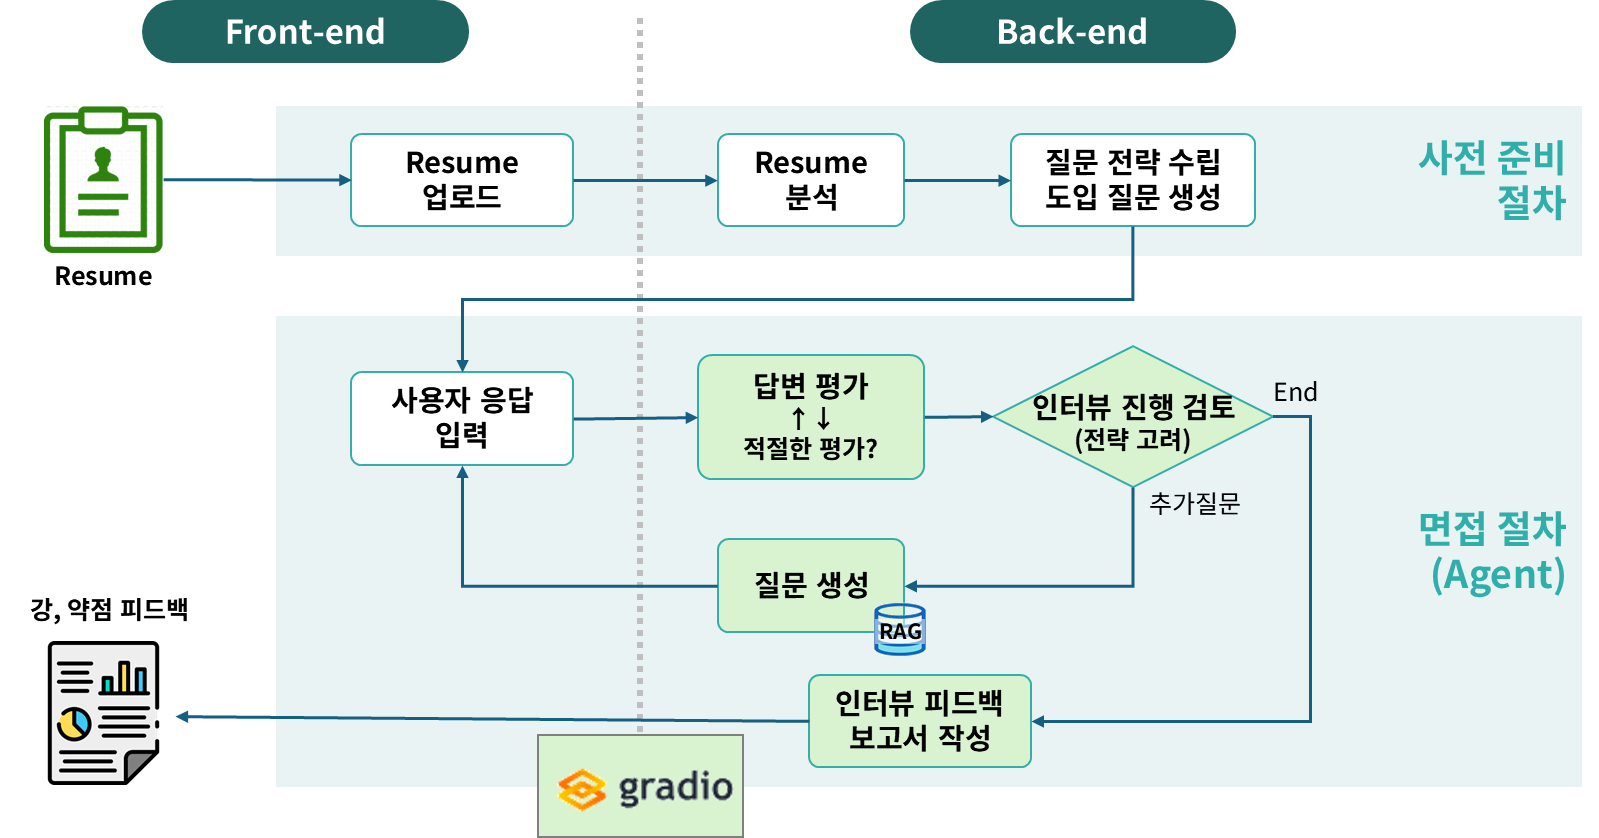

## **1. 환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(project_genai)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

In [ ]:
!pip install -r /content/drive/MyDrive/project_genai/requirements.txt -q

#### 2) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import os
import ast
import fitz  # PyMuPDF
from docx import Document
import random
import openai
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser, CommaSeparatedListOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langgraph.graph import StateGraph, START, END

### (3) OpenAI API Key 확인

In [ ]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/project_genai/'
# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [ ]:
print(os.environ['OPENAI_API_KEY'][:30])

sk-proj-Dt3MOvLw_UxXZzJyjYzV1G


## **2. 미션③ : 고도화1**

* 미션① 고도화
    * Step1의 코드들을 붙어 넣고, 고도화가 필요하다면 코드를 개선합니다.
    * 개선 권장 부분
        * Resume 분석 : 요약 및 키워드 범위를 정하는 프롬프트 개선
        * 질문 전략 수립 : 3가지 부문 조정하고 질문 전략을 잘 뽑기 위한 프롬프트 개선

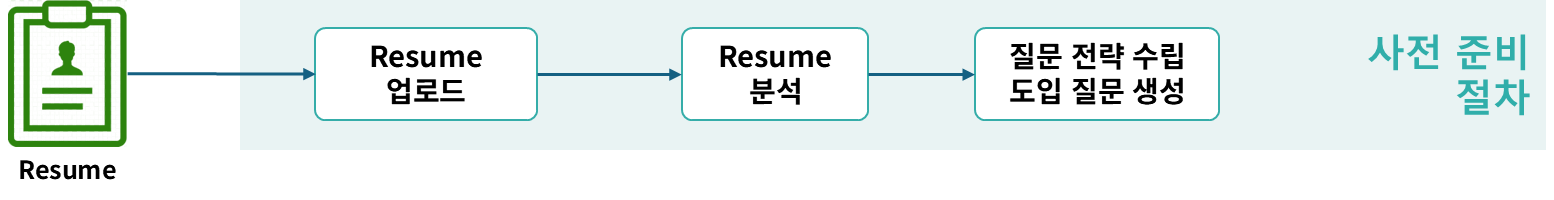

### (1) 파일 입력

In [ ]:
def extract_text_from_file(file_path: str) -> str:
    ext = os.path.splitext(file_path)[1].lower()

    if ext == ".pdf":
        doc = fitz.open(file_path)
        text = "\n".join(page.get_text() for page in doc)
        doc.close()
        return text

    elif ext == ".docx":
        doc = Document(file_path)
        return "\n".join(p.text for p in doc.paragraphs if p.text.strip())

    else:
        raise ValueError("지원하지 않는 파일 형식입니다. PDF 또는 DOCX만 허용됩니다.")

### (2) State 선언

In [ ]:
from typing import TypedDict, List, Dict

class InterviewState(TypedDict):
    # 기업 정보
    company_list: List[str]
    selected_company: str
    company_info: str


    # 고정 정보
    resume_text: str
    resume_summary: str
    resume_keywords: List[str]
    question_strategy: Dict[str, Dict]
    introduce_text: str
    introduce_summary: str
    resume_strength: str
    resume_weakness: str
    strategy_log: List[str]


    # 인터뷰 로그
    current_question: str
    current_answer: str
    current_strategy: str
    conversation: List[Dict[str, str]]
    evaluation : List[Dict[str, str]]
    reflection : str
    next_step : str
    final_summary : str

RAG

In [ ]:
from langchain_core.documents import Document
from langchain.document_loaders import TextLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
# ✅ 라이브러리 임포트
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
import os
import re


In [ ]:
# ✅ 필요한 패키지 설치 (최초 1회만 필요)
!pip install langchain openai chromadb

In [ ]:
def chunk_by_company_and_section(text: str) -> list[Document]:
    pattern = r"\[(.*?)\]\s*(기업\s개요.*?)\s*(?=\[|$)"
    matches = re.findall(pattern, text, flags=re.DOTALL)

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
        separators=["\n\n", "\n", ".", " "],
        add_start_index=True,
    )

    documents = []
    for company_name, full_content in matches:
        company_name = company_name.strip()

        # 예상질문 표현 여러 패턴 대응
        split_match = re.split(r"(?i)\n?예상\s*질문\s*\n?", full_content, maxsplit=1)

        info_part = split_match[0].strip()
        question_part = split_match[1].strip() if len(split_match) > 1 else ""

        info_chunks = splitter.create_documents(
            [info_part],
            metadatas=[{"company": company_name, "section": "info"}]
        )

        question_chunks = []
        if question_part:
            question_chunks = splitter.create_documents(
                [question_part],
                metadatas=[{"company": company_name, "section": "question"}]
            )

        documents.extend(info_chunks + question_chunks)

    return documents

In [ ]:
# ✅ 1. 텍스트 로드
text_file_path = path + "company_info.txt"
loader = TextLoader(text_file_path, encoding="utf-8")
documents = loader.load()
raw_text = documents[0].page_content

# ✅ 2. 섹션 기반 수동 청킹
structured_docs = chunk_by_company_and_section(raw_text)

# ✅ 3. 임베딩 모델 준비
embedding_model = OpenAIEmbeddings()

# ✅ 4. VectorDB 생성
vectorstore = Chroma.from_documents(
    documents=structured_docs,
    embedding=embedding_model,
    collection_name="company_info"
)

In [ ]:
def callRag(company_name: str) -> str:
    """
    주어진 회사 이름(company_name)에 해당하는 기업 정보를 벡터 검색하고
    개요, 역사, 비전, 미션, 핵심 가치를 요약해서 반환합니다.
    """

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

    # company metadata 필터링을 적용한 retriever 구성
    filtered_retriever = vectorstore.as_retriever(
        search_kwargs={"filter": {"company": company_name+" 기업 정보"}, "k": 3}
    )

    rag_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=filtered_retriever,
        return_source_documents=False,
        chain_type="stuff"
    )

    # 프롬프트 구성
    prompt_query = (
        f"{company_name} 기업의 개요, 역사, 비전, 미션, 핵심 가치를 요약해줘."
    )

    company_info = rag_chain.run(prompt_query)
    return company_info

### (3) Resume 분석

In [ ]:
# 3) resume 분석 --------------------
def analyze_resume(state: InterviewState) -> InterviewState:
    resume_text = state.get("resume_text", "")
    if not resume_text:
        raise ValueError("resume_text가 비어 있습니다. 먼저 텍스트를 추출해야 합니다.")

    llm = ChatOpenAI(model="gpt-4o-mini")

    # 요약 프롬프트 구성
    summary_prompt = ChatPromptTemplate.from_template(
        '''당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
        다음 이력서 및 자기소개서 내용에서 질문을 뽑기 위한 중요한 내용을 10문장 정도로 요약을 해줘(요약시 ** 기호는 사용하지 말것):\n\n{resume_text}'''
    )
    formatted_summary_prompt = summary_prompt.format(resume_text=resume_text)
    summary_response = llm.invoke(formatted_summary_prompt)
    resume_summary = summary_response.content.strip()

    # 키워드 추출 프롬프트 구성
    keyword_prompt = ChatPromptTemplate.from_template(
        '''당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
        다음 이력서 및 자기소개서내용에서 질문을 뽑기 위한 중요한 핵심 키워드를 5~10개 추출해줘. 도출한 핵심 키워드만 쉼표로 구분해줘:\n\n{resume_text}'''
    )
    formatted_keyword_prompt = keyword_prompt.format(resume_text=resume_text)
    keyword_response = llm.invoke(formatted_keyword_prompt)

    parser = CommaSeparatedListOutputParser()
    resume_keywords = parser.parse(keyword_response.content)

    #강점약점 추출 프롬프트 구성
    strength_prompt= ChatPromptTemplate.from_template(
        ''' 당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 인사담당자 AI입니다.
        다음 이력서 및 자기소개서 내용에서 지원자의 강점 3문장 정도로 요약해줘(요약시 ** 기호는 사용하지 말것):\n\n{resume_text}
          '''
    )
    formatted_strength_prompt = strength_prompt.format(resume_text=resume_text)
    strength_response = llm.invoke(formatted_strength_prompt)
    resume_strength = strength_response.content.strip()

    weakness_prompt= ChatPromptTemplate.from_template(
        ''' 당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 인사담당자 AI입니다.
        다음 이력서 및 자기소개서 내용에서 지원자의 약점 3문장 정도로 요약해줘(요약시 ** 기호는 사용하지 말것):\n\n{resume_text}
          '''
    )
    formatted_weakness_prompt = weakness_prompt.format(resume_text=resume_text)
    weakness_response = llm.invoke(formatted_weakness_prompt)
    resume_weakness = weakness_response.content.strip()

    return {
        **state,
        "resume_summary": resume_summary,
        "resume_keywords": resume_keywords,
        "resume_strength" : resume_strength,
        "resume_weakness" : resume_weakness,
    }

### (4) 질문 전략 수립

![스크린샷 2025-05-09 15.33.04.png](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAD5wAAAHiCAYA`AACOH1GOAAAMTGlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIQQIREBK6E0QkRJASggtgPQiiEpIAoQSY0JQsaOLCq5dRLCiqyCKHRCxYVcWxe5aFgsqK+tiwa68CQF02Ve+N983d/77z5l/zjl35t47ANDb+VJpDqoJQK4kTxYT7M8al5TMInUCHGgDMnAA9nyBXMqJigoHsAy0fy/vbgJE2V5zUGr9s/+/Fi2hSC4AAImCOE0oF+RCfBAAvEkgleUBQJRC3nxqnlSJV0OsI4MOQlylxBkq3KTEaSp8pc8mLoYL8RMAyOp8viwDAI1uyLPyBRlQhw6jBU4SoVgCsR/EPrm5k4UQz4XYBtrAOelKfXbaDzoZf9NMG9Tk8zMGsSqWvkIOEMulOfzp/2c6/nfJzVEMzGENq3qmLCRGGTPM25PsyWFKrA7xB0laRCTE2gCguFjYZ6/EzExFSLzKHrURyLkwZ4AJ8Rh5Tiyvn48R8gPCIDaEOF2SExHeb1OYLg5S2sD8oWXiPF4cxHoQV4nkgbH9Nidkk2MG5r2ZLuNy+vnnfFmfD0r9b4rseI5KH9POFPH69THHgsy4RIipEAfkixMiINaAOEKeHRvWb5NSkMmNGLCRKWKUsVhALBNJgv1V+lhpuiwopt9+Z658IHbsRKaYF9GPr+ZlxoWocoU9EfD7/IexYN0iCSd+QEckHxc+EItQFBCoih0niyTxsSoe15Pm+ceoxuJ20pyofnvcX5QTrOTNII6T58cOjM3Pg4tTpY8XSfOi4lR+4uVZ/NAolT/4XhAOuCAAsIAC1jQwGWQBcWtXfRe8U/UEAT6QgQwggjtUxQyMSOzrkcBrLCgAf0IkAvLBcf59vSKQD/mvQ1glJx7kVFcHkN7fp1TJBk8hzgVhIAfeK/qUJIMeJIAnkBH/wyM+rAIYQw6syv5/zw+w3xkOZML7GcXAjCz6gCUxkBhADCEGEW1xA9wH98LD4dUPVmecjXsMxPHdnvCU0EZ4RLhBaCfcmSQulA3xcixoh/pB/flJ+zE/uBXUdMX9cW+oDpVxJm4AHHAXOA8H94Uzu0KW2++3MiusIdp/i+CHJ9RvR3GioJRhFD+KzdCRGnYaroMqylz/mB+Vr2mD+eYO9gydn/tD9oWwDRtqiS3CDmDnsJPYBawJqwcs7DjWgLVgR5V4cMU96VtxA7PF9PmTDXWGrpnvT1aZSblTjVOn0xdVX55oWp5yM3InS6fLxBmZeSwO/GKIWDyJwHEEy9nJ2RUA5fdH9Xp7E933XUGYLd+5+b8D4H28t7f3yHcu9DgA+9zhK+Hwd86GDT8tagCcPyxQyPJVHK68EOCbgw53nz4wBubABsbjDNyAF/ADgSAURII4kAQmQu8z4TqXgalgJpgHikAJWA7WgHKwCWwFVWA32A/qQRM4Cc6CS+AKuAHuwtXTAV6AbvAOfEYQhITQEAaij5gglog94oywER8kEAlHYpAkJBXJQCSIApmJzEdKkJVIObIFqUb2IYeRk8gFpA25gzxEOpHXyCcUQ9VRHdQItUJHomyUg4ahcegENAOdghagC9ClaBlaie5C69CT6CX0BtqOvkB7MICpYUzMFHPA2BgXi8SSsXRMhs3GirFSrBKrxRrhc76GtWNd2EeciDNwFu4AV3AIHo8L8Cn4bHwJXo5X4XX4afwa/hDvxr8RaARDgj3Bk8AjjCNkEKYSigilhO2EQ4QzcC91EN4RiUQm0ZroDvdiEjGLOIO4hLiBuId4gthGfEzsIZFI+iR7kjcpksQn5ZGKSOtIu0jHSVdJHaQPZDWyCdmZHEROJkvIheRS8k7yMfJV8jPyZ4omxZLiSYmkCCnTKcso2yiNlMuUDspnqhbVmupNjaNmUedRy6i11DPUe9Q3ampqZmoeatFqYrW5amVqe9XOqz1U+6iurW6nzlVPUVeoL1XfoX5C/Y76GxqNZkXzoyXT8mhLadW0U7QHtA8aDA1HDZ6GUGOORoVGncZVjZd0Ct2SzqFPpBfQS+kH6JfpXZoUTStNriZfc7ZmheZhzVuaPVoMrVFakVq5Wku0dmpd0HquTdK20g7UFmov0N6qfUr7MQNjmDO4DAFjPmMb4wyjQ4eoY63D08nSKdHZrdOq062rreuim6A7TbdC96huOxNjWjF5zBzmMuZ+5k3mp2FGwzjDRMMWD6sddnXYe73hen56Ir1ivT16N/Q+6bP0A/Wz9Vfo1+vfN8AN7AyiDaYabDQ4Y9A1XGe413DB8OLh+4f/Zoga2hnGGM4w3GrYYthjZGwUbCQ1Wmd0yqjLmGnsZ5xlvNr4mHGnCcPEx0RsstrkuMkfLF0Wh5XDKmOdZnWbGpqGmCpMt5i2mn42szaLNys022N235xqzjZPN19t3mzebWFiMdZipkWNxW+WFEu2ZablWstzlu+trK0SrRZa1Vs9t9az5lkXWNdY37Oh2fjaTLGptLluS7Rl22bbbrC9Yofaudpl2lXYXbZH7d3sxfYb7NtGEEZ4jJCMqBxxy0HdgeOQ71Dj8NCR6RjuWOhY7/hypMXI5JErRp4b+c3J1SnHaZvT3VHao0JHFY5qHPXa2c5Z4FzhfH00bXTQ6DmjG0a/crF3EblsdLntynAd67rQtdn1q5u7m8yt1q3T3cI91X29+y22DjuKvYR93oPg4e8xx6PJ46Onm2ee537Pv7wcvLK9dno9H2M9RjRm25jH3mbefO8t3u0+LJ9Un80+7b6mvnzfSt9HfuZ+Qr/tfs84tpwszi7OS38nf5n/If/3XE/uLO6JACwgOKA4oDVQOzA+sDzwQZBZUEZQTVB3sGvwjOATIYSQsJAVIbd4RjwBr5rXHeoeOiv0dJh6WGxYedijcLtwWXjjWHRs6NhVY+9FWEZIIuojQSQvclXk/SjrqClRR6KJ0VHRFdFPY0bFzIw5F8uInRS7M/ZdnH/csri78TbxivjmBHpCSkJ1wvvEgMSVie3jRo6bNe5SkkGSOKkhmZSckLw9uWd84Pg14ztSXFOKUm5OsJ4wbcKFiQYTcyYenUSfxJ90IJWQmpi6M/ULP5Jfye9J46WtT+sWcAVrBS+EfsLVwk6Rt2il6Fm6d/rK9OcZ3hmrMjozfTNLM7vEXHG5+FVWSNamrPfZkdk7sntzEnP25JJzU3MPS7Ql2ZLTk40nT5vcJrWXFknbp3hOWTOlWxYm2y5H5BPkDXk68Ee/RWGj+EnxMN8nvyL/w9SEqQemaU2TTGuZbjd98fRnBUEFv8zAZwhmNM80nTlv5sNZnFlbZiOz02Y3zzGfs2BOx9zguVXzqPOy5/1a6FS4svDt/MT5jQuMFsxd8Pin4J9qijSKZEW3Fnot3LQIXyRe1Lp49OJ1i78VC4svljiVlJZ8WSJYcvHnUT+X/dy7NH1p6zK3ZRuXE5dLlt9c4buiaqXWyoKVj1eNXVW3mrW6ePXbNZPWXCh1Kd20lrpWsba9LLysYZ3FuuXrvpRnlt+o8K/Ys95w/eL17zcIN1zd6LexdpPRppJNnzaLN9/eErylrtKqsnQrcWv+1qfbErad+4X9S/V2g+0l27/ukOxor4qpOl3tXl2903Dnshq0RlHTuStl15XdAbsbah1qt+xh7inZC/Yq9v6xL3Xfzf1h+5sPsA/UHrQ8uP4Q41BxHVI3va67PrO+vSGpoe1w6OHmRq/GQ0ccj+xoMm2qOKp7dNkx6rEFx3qPFxzvOSE90XUy4+Tj5knNd0+NO3X9dPTp1jNhZ86fDTp76hzn3PHz3uebLnheOHyRfbH+ktuluhbXlkO/uv56qNWtte6y++WGKx5XGtvGtB276nv15LWAa2ev865fuhFxo+1m/M3bt1Jutd8W3n5+J+fOq9/yf/t8d+49wr3i+5r3Sx8YPqj83fb3Pe1u7UcfBjxseRT76O5jweMXT+RPvnQseEp7WvrM5Fn1c+fnTZ1BnVf+GP9Hxwvpi89dRX9q/bn+pc3Lg3/5/dXSPa6745XsVe/rJW/03+x46/K2uSeq58G73Hef3xd/0P9Q9ZH98dynxE/PPk/9QvpS9tX2a+O3sG/3enN7e6V8Gb/vVwADyqNNOgCvdwBASwKAAc+N1PGq82FfQVRn2j4E/hNWnSH7ihsAtfCfProL/t3cAmDvNgCsoD49BYAoGgBxHgAdPXqwDpzl+s6dykKEZ4PNUV/TctPAvymqM+kPfg9tgVLVBQxt/wXthoMq+goWwwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAD5ygAwAEAAAAAQAAAeIAAAAAQVNDSUkAAABTY3JlZW5zaG90jhJFhAAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NDgyPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjM5OTY8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KR2BUWwAAABxpRE9UAAAAAgAAAAAAAADxAAAAKAAAAPEAAADxAAJg4r4362QAAEAASURBVHgB7N13gFTV2cfxZ7YXdmELS2cRKUo1KgrBgj1YiCb25LUbNSQiaoiCYgMs2IM1GlNFbCAa0SRCsMWGiAhY6AsCC9t7m32f58zOuG22Dv17dWfuPffec8/9zPDXmd99PEX5edWyk5ad1nEz4/U0sz9Uu3fX/YVq/PSDAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMD+ILCr8sf1LfeGPLKHwHn9j63l23vDB9zyu+FIBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT2TQEC58E/VwLnwW2a3UPgvFkiDkAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgvxGorq6WqiqveMLDRXTdq3+6ou8iNmldbf/phke3q7WhWl88umFtdmxlZbnEx8ZKRETEfmPGjSKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIILCrBAicB5PW3zJQ4TwYTvPtBM6bN+IIBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPYXgeLiYonWwLhOw2qQXAPlXq/lzm1LA+VeZdBwuU0y1uzz7fG4IHplZYXkZOdKamqKREaEEzrfX7403CcCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwC4TIHDeGLUvLU3gvDGbFrYROG8hFIchgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggsB8I5OTkSMekpJqQucXLrYq5hs7dmgbLXeZctzy64tUQumvX2LlWOa8or5Tvt2yRfn0PkPKKConUKun7eqXz7777TtauW+e+GV3SusghhwzfD74l+84tbt++XUpKSiQyMlK6desWshsrLy+XrVu3uv5SU1MlLi4uZH1nZWVJUVGR+7fVvXv3kPVLRwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggsHcI7K7AuensuZlk38gInLfjO7znfrjtuClORQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBNglkZmZK5y7dXGVzCfOFyFesXCVh2lvv3r2lpLRECgoKJEIDuvm5eRIZFSlVVVUSFRkhHTsly7Ivv5DTTj1dqiorpbSsVEPnYS7M26bBNHLSp599JutqAt6N7G626cQTTpDk5ORmj2vsAAsnXzvhOrcrOiZannv2WZn9wgsyd+481zZy5Ei54fqJjZ1K2x4qsHz5crEAd3x8vIwYMSJko7R/I0uWLHH9DR48WDp37tyg79LSUn2YQ8tm7C0Q7394w8qVK8X+nUZHR8uoUaMa9EsDAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjs2wIEzut/vj/Mu7YpcF763ddS/NWXUrbmGynN2ChV2dv1Ch6JSE6V6F69JbrfQIkbPEyi+x9U/8q7ZLsia5WUbl8mpdlfS2XeBqkq2eGqA0TGpklkx3SJThkoMZ0Pkajk9o3vB8bW3dZ3OatkZfYyWZ3ztWzU8WWXZlrZAkmNSZOeHXvLgYkDZXDqIdI/6eDWdczRCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCw2wS2bdvmAuc69eeeTO7VMPmaNaultLTMhWaLi4tcteaysnIp1z+rfF6g1ZaTO3Z0x1uA95xzz9XAeYVUVlbpMWUSEcLQ+T333hcI8rYF6e4Z06Vfv35tOVUscP7r8b8JnDvnhdnywpw5BM4DIrt+ZcuWLa7ad0uv3KFDB+natWvg8KYC5xYYr6ioCBzbkpXhw4dLbGyseyhDU4FzC7nbtVu6HHDAAZKenu4OJ3DeUjWOQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGDfFNidgXMTbWsueed8GnVH06rAecnXK6TgvUVS8OFiSYyKktiYGAmPihZ9HLjGzfVGdcK4Un/8UFZcInkV5ZI4+liJH32cxB48eOfcS71ey3d8JUUZ70jR+v+K/iZDxxclUdGRUq0/wnCL/qCjorRSikvLJb9AJK73GOmQfoIG0IfU66llm3Upmz/n6+zl8v6md+SD7xeLdAiTqLgYrV4QIeERke5kb0WlVKpbWUmZSJFXRnc7Vo7qeaIclNy28TU/Io5AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFQCVjgPK1bNzdDbHOJFRoqX7turatSXlJS4ioyJyQmuqrmWgbdbWdlZUtKSooLZK/X6uOXXXG5Bs6rXJXzCp0/LK/Q0HlYaCqdhzJwbiH6+2be1yK6YUOHyejRPyZw3iKtXXfQV199JTt27GjxBa1K+FFHHRU4vqnA+Ycffijl5eWBY1uycsQRR7gHMjRX4dyC8t98801LunTHDBo0SNLS0tw6gfMWs3EgAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAvukAIFz/8faMCHd4sB57ttvSO6br0knDZRHJySIJyzcPXHfo31Wu7S5vtiGLbZd5ZWywgLJCY+QpNPOko4nn+Z27ayXwrWvS/43r0pyhwKJTYgTCav1sXvdALVNr26DtXFWVUtpQbFkFyVKwoAzJeHAca0eWkPO4F28vX6+vLn2VSmOL9XxxUtYeLj7oYk7o1prF+ifR4Px+mbFzsWqHRQXFEqHwjgZe+BZckqf1o8v+GjYgwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACoRbYti1Tumjg3GYnvd5q8Wqo3CqZ2zxgWWmpROpDvSs1hBumAXKbFPTanKo+kDoqMlJyc/Nk7do1ctppp+m5Xg2le93DvisrK7VSdLmE6/GRelx7ltqB8+HDh8l5Wk29qSU3L0/uu29m4JDaFc6Li4vl4ksuDexrauWwww6Tyy+7dKcEzufNe02+3/J94PLjxo2Tnj16BLZDsbJp82aZP39+oKvu3brLmWf+NLC9t65s2rRJCgsLWzx8+94OGDAgcHxTgfM8/e6UlemD1mstFva2xb7H/fv3r7XHt2oPXgjXefTWBM4PP/xwidEH5QdbPPrvxvr0LwTO/RK8I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIILB/Cth8/u5cWpNL3rnjbDiSFgXOc+a9KFkv/V16dO8hnsgoN0aNSAfy5dZgXfvz5u4XFPaik7f62H7Z9P33knz2hZJ01nnu3FC/FHzzguR89VdJT0+y2WkdjI5G//fUhMvd2GyM1qZDcgF5G562efUHGhvX50jSkIskceD5rRqa9duSZd7q2fLSN3+TpN5p7kck9sMS0f/tzQ3RjcQGZ2PWHm2Q5hvukYryCsndmCnnDPw/ObPfBS25HMcggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBuEPBVOO/uZv/s8pVVlZKTneMCrzHR0VqtXMPlUdFSVFSkc4VeiYmNddXOS636uc4RrtJA7sknnSTRGqD1hc6rpFKrnFdUVLhq0dFREXXCs629xdqBc6s4ft2ECU12kZ2dLVddfU3gmDqBcx3zpZdeFthnKzZm/+JC9TUbFji/9JKLd0rgfMott8q3337rv6zcMmWKWJg+lMsXXyyT6TNmBLq00PX0aXcFtvf2lfXr10uJfp6JiYnSo1ZYf82aNa49QR9In56eLsuWLRMLkvsXe6i6/cXHx8uIESP8zY2+23fj/fffd98RC4FbpfTaQfDaJ7UmcH7kkUdKrP47aulC4LylUhyHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwL4pYOnd3b20NJu888bZ+AiaDZzn/eufkvmXp/Qp8L1EIsL1xxHKqU/jd6Ft16evY19E2rLSvjWNS7t7se1qDXVv2pQhaZdeJYknhbbSeZFWNs9a+oSk903RCuY6Phc2t4ltjWzrX5he3+sPx9tY3LqOzSqga7rbo8UDqiu9GjrPlpRDrpb4vme0+DPw3XnTh/9LK5v/ecUTktynq/JF+n5kYRXXXbV1O9dS5/aubb4B24YuHq1soE3aXKU/RMlet1UuGfprOTm95ePz9cMrAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsCgELnHft0d09eNquZ2Hx5Su+kmgNmyd1StJq0vlSUFgUCMhGRUVKVUWVqwRt84KZer5VDrfw7wEHHCBxcXESERGhz9wO1yrOcRKv2x3ifW1tuZ9QBs7rX9+qgE+ceH2g+dln/ugCzP6G7du3Ezj3Y+xh7x988IF7qEFaWpoMGjQoMLrPP/9c8vPzxQLn9tCApUuX1gmc+w9sSeA8JyfHBdb95wwcOFC6devm36zzTuC8DgcbCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQQgGdmt/tS0uyyTt3kI2PoMnAeenXK2TLEw9LN6sarj92sLC2LxxtWW0NSlu4XMPT1TWlzQ3aHzT3B6rtEHeahs63lpdL12smSsxBg0Nyr2U7lkv2pw9Jt7Qy8UREurC5qxquw/TUjMky3C7I7Qai7XZlXxlxN4ZqTZxbsNurVQG27IiWlMMnSnTqULevuZfGSX84a1XWcnnyiwekKq1aIiKjXZUCH+EPjl795YjF4O1/C7/buxukjtfR6Xu4huMrtNpB+HaPXDV8ogxKCe0T+X8YMWsIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINBWgczMTEnr2sPNVVbrQ7y9+l9RQZHOFUbow6kjpLKyQgqLSyQ+NkbCNUheoXOoViHaKj2XlZZIlVaBLispkyqd9Ezo0CFQAdqjE5o23WkziF7twwLAbVl2ZuDcqoxbtXH/8ugjOs9cK1Ac6sD5ihUrdA61Uv703J9ky5at/svKeeedK/0O7Oe2Bw062IX516xZG9hvKwce2LeOoX0Gy5Z9WeeYPn3S3cPEN27MkNVrVsucOS8G9nfv3k0rtl/qtpNTkqV3L314+168fPrpp1JUVCTJyckybNgPc9Eff/yxe/hBamqqDBkyxIXSS0tLA3dq1cLt4QjNBc7N18LrFiT3LzExMS7EHmm/Rai3tCZw3qdPH30gQ8M+andp10pJ0QfY60KF89oyrCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCw/wlYbndPWCxKvHuW4FduMnCe+cc/SNSyJRLTMdEV4rbBu5x5mHbo+19b7JcNGjPXSWJf2Nxejbymmrj+8sEu79HQdGlevpQPP0w6X/kbbWn/kv35IxJX+L7EdorXMuBWKVyvawN017Z1vbINxQ3Arucbk+W63WL77ABr0LeSvCIpTTxakg6Z4HY392LdNrU8s/wR+bjkQ4nv2FGqq/xV172+quu6HQi++8eondWouR+MuL7Vz4LoHn0pysuTI2JHyZXDrmvqsuxDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHdIGAVzrv16KnTk/qfBs6rKqukqLhQg8vVLmwepsHxYg2cd+rUUfJy8yVGg+eR+mDtzO2ZGkgPl3gNkleUV0hUdKTkakXo2Ng4Dcom6524iU3XZ1FRgaTWhGdbe4u1A+dJSUkyatSoJrso1RD8woWLAsfcPWO69OvnC3MHGmtWPtHQ8syZ9wea77zjdklPT5dF//2va7NA80svvRzYP+eF2fLCnDkyd+481zZy5Ei54fqJgf3NrVxy2WVSpNXim1oeeuhBiYuNlQkTJ0ppyQ9B6eOPP06uufrqwKlW4fvhRx4NbFuA+YH7Z8rSL76Q5577c6C9sZUf/3iUTLxu756/XbZsmVgF8oSERA2BHxq4zffff1+/t5XSo0cP6d+/f6Ddv7J8+XLJyspqNnC+YcMGWbdunf+0wLsF1Q855JAGgfHWBM4DnTWxYmHzoUN9D50ncN4EFLsQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2A8EfLPvu/9Gm8sn77wRBr9y0MB52XffyKYZt0r3Ll008BzmnqxvA/QFy92avvjC3TWRcturf76LWfZb9IcTdq61WSVxjz6Rf/O2rdJ98l0S0/8gbW/7Up61SjLfmyy9+iToVXUENhRdXGBbh2CjsCeleyywrVted1TNES6I7tHgtzvIBbqrbZw6voyNBdLlqBkSlXKwHdzkEpxV5NuclTLjo5slMT3VBcwD+XIbm7rUlCCoMbIwus9Jh6kH+Bxt7G5bmyywX603WbgxS24+8m7pn9T8+JocPDsRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCkAi5w3r2nzu3p/KTXoxWhy1117IiIKInSKue5ubmuirRVhS7RStEWMu/QIV4KNThdWlomqanJkqcP8Y7VIHplRZUGz6Olh1bTtsX37O1qyc/NkS46h9uWpXbgvC3nNxU4/88778hTTz0d6NbC4xY4v3ZC42HsXRU476lh6TcXLKgTHLfg/wMP3C+2r6qqSq7TQPrWrdsCY7/wggvkrLPObHBe4IBaK/tC4HzVqlVi391YDecfeeSR7u5srn3x4sVuvW/fvtK7d2/ZvHmzfk9/CO7v2LGj2QrnGRkZsmbNGtdPRESEjBgxQqw6fX5+vmuz0LmFwa0KuX9pLnBu112/fr3/cPdu47JwvH22cXFxdfZ169bNheatkcB5HRo2EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEENjvBCy9uycsTeWTd+74gl85aOA8e96L4l3wmnRISbXkdk2MXIPPtdd11K6quVY49yW8LSDtW7estKWl7UyNdvvatbEwa4eEjT1Tks48p133XPDNHPFsekESUju68Vn23XLkbqT67ru8vVqj7929uh2+/brHHefeLX2uw8zfoRPbPc+TxIHnNzs+Oy/Y8trqF+S1bS9Lov4opLrSRmXj0Neak3wjani28dmg3PG64jLnvhfxRHgkf3uWjOtyjpzZr/nxNeydFgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2FkCWzW026NnL30ut5tF1dB4pavs7PVWSUJigmRn50haWpoUa7XvPA3cdkrq5I6xkGy5VjaPjYmW7TuyJDY+ViLDI7S6eWetgh7lHr7tm38Vyc3Olq5d97zA+ZNPPiXvLFwYoD3jjNPlpBNP3GmB89vvuEMKCgrl+++/d0Fj/4VTU1MDgeObfj9JOnfurOF/r0yecksg+GzHWvB50u9ulLf/9S955pln/ae7YPV9994j4fowgA8//FBeeXWuVqUvFgs5+xcLTnfv3t1tHnroj+QXF17o37VXvlsg3ILhVtl99OjR7h4qKirEKr/bcvDBB7uHHCxdulQfiJDn2mq/WGjcPGsvFv62quYWUrfFHrZuwfLk5GR9EEOFLPvySyksKHD77PtvoXB7QEFUVJR+rgWyZMkSt2/w4MHuM3QbTbx89dVX7jOysPkRRxwR9EgC50Fp2IEAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAfiFQEzHe7ffaVD555w4u+JWDBs633H+XdMjYIJE6OewLSWuNcA1u25PMfSlo348kLEftlpoEtW36wX05bzveqnfbDo9U6dP583unS7cbb/W1tfF1+/9ul6TqVRLVIUYD3b5OLAxfU+i8pkHf3OB9I3Jj0xcbl7XYn92Fx1Le9guNcI+UF5ZInudg6Tzqdt3b9GL9BVseWHK7fOv5VmLi1M/Km+vi6LS6uVevZ3XXfdev1YOOwVVlN1Qbjw7Uqh9UaxLeo3cWpj9qKCkslP4yQG48/PZaJ7KKAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAK7W2BbZqZ079HTDcPm/ao0aL527TqJj4vV+b8wDS6XSEJCvKtiXlZWKqnJKZKVlSUdOyVJcUmxhs7LJDIi0s0Zlun6gH799LTwQH82wZingfO2Vji3a1ll9bYsNrtpQXcLYtdfLNB95a+uClSttv3dunWVhx58UEPb/3OB72wd9/OzZwdObW+Fc39HU265Vb799lv/ptwyZYoMHz4ssO1fsfDzTTdPdmPxt9029VZ55NE/uMrz1mah6BnTp0k/da+9fPHFMpk+Y0agacCAATJ92l2B7b19xV+F3O7/2GOPdbdjIftPPvnErf/oRz+Sjh07yvbt292f/34z9ftuS/3AuVVLX716tQuW234LlA8cOLDO99YC6V9//XWdIP+QIUPEHhjQVODcKtLb980W+zdmf7ZYXzk5Oe4zHDZsmLu2XaOsrEz/XZW7v/79++u/x7Vi446OjpZRo0a5c3lBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIH9R8ByvXvC4pvp3B0jCX7loIHz9ROulC76BHNPZIRO0urkunvxVSy3W3BhaWu3XLRt6X7LldfM5wbuMhCrtgPtT59WvlWf5J/+8NOBY9qysvWty6RrarmERYbrhLJ2rUFuu03706v4VuzdrulabcO3r9olzm3w2lDzJlrh3I1fJ503Z0ZLj7F/csc39WLXCrZc986lUpFWrU+BjxJvlQ5QYdzY9MV5uVLmenatTvz14K1P2+0Lxut5eg9h+ueJCFO+MonYFiaPnPBcsEvTjgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACu0HAAudW4dwfgq2qrJD1Gza68GtcbJybnywoyJekpGTp1LGTPnA6TMo0DBul87JeDdKWaZXzSJ2ftTnOSl2P1urmGtd1c402r2j95uXmaHA3bTfcXfBLrlixQm6/484GB8y8717p06ePa7ew8q/H/yZwzK4OnNuF//LXv8obb/wzMAYLHVsg2b+MHTtWLrv0Ev9m4D0UgfNCfbD4pk2bAn2GasUqgvft27dN3VnVdgtvW1B7y5Ytrg8L09v3rKSkJDDeTp30u6qh8XKd6x+k1c6tirgty5cvdw9MqB8437hxowt22zFmbFXKExMTbbPBYg8isHC69WmBc1vM6rPPPnPr/hC6bVgI3tr9gXN3QCtehg8f7u6TwHkr0DgUAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgX1MwOWP94B7qhUt3sWjCX7loIHz1b88U3r06q2/ZVC+mh8vWCDavwTWdMUOqcmcu2Pdtjb56njbkTVn6nF2aMamDOn3t7m61vZl46unS/qBKb7rWZ5b/9PMuQtqu4u4ru1qvlF4dVLcRmH3YyPSTftphi/UbYfZSdagbxlrc6TXWfOtscnF+gm2/N+bp0vyAV19u71an7zaFzq3AL7/PJc51+v58+/+dhuDHeRv92gY3gbmCbdGkZx1W+Wvp74R7NK0I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAbhCwIGt3DZzbfF+1Tl7ag6kLi4s0IFvlKpfbnGWlhnajoqIlJiZarFqzm7+0iU43eann6aodb3OEtu6bBLV22xDJzc6qUynaNTbxYkFvC/SGcrFq14MGDXJd2j3cPHmKWAXx+stBBx0kd95xu7vHPSFwXlpaJhOvv75OVW3/mK2y9oMPPiCxMTH+psB7KALnVvV71apVgT5DtRKpDysYPXp0q7vLz8+Xzz//vNXnWfXw5ORkd16wwLnttIrjsbGx0qtXLxdWb82F7Lu+detWd0rnzp0lIkIfwqCLVSr/8MMP3XqwF/v3ZMfbn9nYn4XyLfjes2dP+fbbb6lwHgyPdgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT2AwFL6+4Ji+8XALtjJMGvHDxw/n9n6YSrPn3fhZ/tFxFV+qfv+kMHjwao3Y8kNP1s4XJXMVwnfX1Bc23Q9sB5doy1aPlw37Fe2ayB8wP/Nq9dEhmvniG9+ya5HydUV9kgvJbF1sV3fV/nDdctmK4jsRHqIb5fbbgQuB7qCbfjvZKxJlt6/az5QHdwVpFfvnmaBs67+66kB1re3PeLkJrQu/tBSM2vRgJj9o239qj1JB2Y2el59qMS7SZ77Vb5+2nNj08PZUEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgV0kYIFze6i3TQXafKSFyy2InZiQoHN+HldJunv3bpJfUCQV5aUueG7B2mSteG4h3u+3bJYOHTpIbq5VQe+kf0kSHh6h/elcrZ5vc4652TtaFThfvPhdmfXYYyEV6NKli8z6w6Ouz3nzXpN/PP98oP9Jk34n9903M7B9ySUXy2mnnip7QuDcBvWpVsiuPT7/QCdeN0F+/OMf+zfrvO+LgXN7UMAHH3zg7tNC2v4/q2Tu/sLDJUL/aoe2YzSMn5KS4gLcdmJTgfPagB9//LGrmG7hcat23txSUFAgS5YscYfZ8Xaef7GgvC02XhunvYfrOG3d/+4/trF3q75u/+asKntLxtJYH7QhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDeK2D53T1hsazw7lmCXzlo4HzDxCulS3ikSJT+uV9E+CLa/hvwh6L97y4YrcFpF97WH09Y9W4XOtcTfPFunezVSd5qfer4tspKSX/4aX9XbXrf8tZl0q1zmYRFRLrqAPbrCq9e0GMXdRd3F3YBbb2q3oK160h0XDZmN163YoF4XbEgvQbOq8urZPP2KOkx9k/uqKZegrOKXPfOpVKRVi0R+sR00coFXguc6/U1z+7etJ5BzYr1ou0WKDczN05rsm2T8x3mJvh1fBX6o5SITI88csJzuocFAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT2FAGrYt2zd28djm+GtELnRleuWCUJiQk6l1klhRo0txC5VVy2Yy1kvn3HDonR6ssWqt20ebN00urhVsm5rKxUUrQtJSlF+9P5TquCrtOKOVl7TuB84aJF8tRTT+tcqE2GihxzzNHy29/8Rh559FF5/31fmNnazznnbBlz7LEy/je/tU23zHlhtrwwZ47Mnet7UPnIkSPlhusn+ne3+H3KLbe6qtX+E26ZMkWGDx/m32zwbmN+4oknG7SfqqH4SzUc39iyLwbO699nWVmZ+95Ze4I9IKEFy+4InNcelv072az/ZtqyWAV0q77OggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC+5eATrvvEYtlh3fPEvzKQQPn399/pyRkZEhkfKwLaVt63ONC0noL2p916QLSTtdeLLjtW9y+mnX3Ywrd4T+iqqRQCnr2ka433ho4oi0r2z+8XZKqV0lkh1gNdFsPdn2NcfvHFujU92MOqyVuP3Nw4XN3pC8ab0Fu36LnR4RJeWGJ5HoGSedRt9W0B3+z+wy2PLDkdvlWvpNYfTJ6lQbO3fU17e4bjV7Tefp68L/6RuTv0Vp9lc2rtbK5hc/DwkVKi4ukv3eA3HD47f4DeUcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgT1AwELkvdL76PyqzfVVu3lCC8SG6URfeUWZBstjdV3nLXV3TnaOBs6TpKKyQsI8vkrNeTm5Or8YpxXMu/oeYq1Bbnuot1cfvu3mErXf1gbOt2zZIqu+/rpJnSVLPpdPPvnEHWNh41/+8hdNHh8XGyvrN2yQV155NXBcYmKiPPTgA2LvxSUlctNNN8mWLVsD+ydce60LovsbdkfgPDc3VyZMnCjFRcX+YQTerUL23TOmS9++fQNt/pVQBM6tonheXp6/y5C9W3DazNu7rFu3TjboZ2rLsfpwgB/m0YP33NrAuT1s4cADDwzeYc2eoqIiWbVqlduqX+G89slWrXzt2rW1m1q8Hq0PeRg1alSLj+dABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDYNwT8ieLdfTe+XPHuGEXwKwcNnGfPe1G8C+ZLh9RkV3Xboz9isJC0deWC5mEannbb9u522W8maqp3+6LTPxyrv5qwit36X0FWloSNHSfJZ57bLon8b14Qz+Y5kpiSKB4bmv1oo2Y8/ni7u4AbhH0FbL8NPhD5drstb25Vxa26uY0xf0e+SM/zJHHg+W5/Uy/WXbBl3nez5bXMl6VTSor+AKSm4oC91zvJjaxmXL5IvI7FxqS/MnGT+HaA/sAkzPzCwyR3R7ac2eVs+Wm/5scXbGy0I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA6AUyMzO1wnm6m3+0yckqb6WUFJdIeHi4zv/pQ6o11OzRh01XVFZJhL6XV1RKRGSkb95VJz1tjrBSA+hRkVFujjHcnkhtc4c6n1itFdJtydaK6F26dAnp4F99da7MfuEF12daWpo8NusPzfY/67HHZPHid91xFt69/bap0q9fv8B5Vq192rTpkqXzw2PHjpUzTj9Nfj3+N4H9LQ2cW/DYwtoWPG4sBF2/wvmVV14hJ590UuA6tVceevhh+fDD/wWaevbqKZsyNgW2DzjgABc6t8+r9lI/cN6pUyd5+qknGx1P7fP2pvW2BM63b98u9pCFmJiYOp99/fv++OOPpUQfQtCWpaWB8xSdl2/s+1H/mtnZ2eLVf4sEzuvLsI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA/iFgkd09YakXNd6FQwp+5aCB87LV38im6bdKd/uxgj1m3wLn/l8z+JLbvqC57rLFIbvraKhat2zbhav1hxK24tHQdLX2sUUnnLtPvlOi+x/kzmvrS3n2KslcPFl6HZCgF9dBWBkAu4774YZWA/dd1jcwG4gdY+O2VQ1vuzG6QdsILHCub9rHxo2F0uXoGRKV3Pz4tKugy3c5q2T6RzdLYrpvYrvaqxfT6/qqseuPRfxGNT24Quu+4WmLjketqu0HJzVj9N1itRRuzJLJI++W/p0ODnptdiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwK4XsPBt7z4H6LSlTUqKlJeVyzfffKOB3FhJ6BAvhVpZOzIywgWo47WSebGG0S2EXlFRrtOZ4RIdESlFZSUSoYHn4uJiOUD7itCHUrv65tqnV+czc7J3iIXCQ7m0JXBeWVkp99x7r1bF3ijXT7xODj644fxlTk6OzJ33mlz0f78UW29t4Lx2mLx3794y8757nVfte79r2jT58svlgSY77he/uFB6dO8unTt3Dhz/+dKlcvfd9wSO69atq4bLZ8jE629wY/PvuPjii+T0007zb7p3+wxvuXVqnbZzzjnbVcjuqNXFQ1FhvE7nu2GjLYHzlg7THzi3QLh935tb7N+PhcJtaWng/KijjhKr9t7csnLlSrEHQxA4b06K/QgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsmwI1kd3dfnNN5ZN37uCCXzlo4NwGlPnHP0j0ss8lOlFD3bq430XYi/5VawLa1QrX6uAWpDZk/2X8626/HacN1fpSlpcnZcMOk7Rf/db1196XnKWPSGzB+xLbMc5luX1zzjVj0cHY9e3HFzZlXROXd2O08blIvAXAbc0a9KDigmIpjhstKYdepw3NL/77DXbkM8sflo9KPpKEjglavUCP1kE4Qz3B3t2grbq6G5WZGpSNSN/cPLuN3W1JWESYFOTly8jYUXLF0AnBLkk7AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsJoGtGjhP79PXzf/Zw7grdY5ww4YNWs08TOf7wrWieYWUl5RJh/h4rXKulcxjYyQ/J1fnDqslPqGDFOYXSEJComRpqDwuLl56p6f77iTwcHCv7NCq0ntChXMbWGlpmQvLJyT45pObYrdq2K0JnFtl86m33V6nyymTJ8shhwyv0/anPz0nC956q06bf+Ohhx6Unj16uHFOvP562aHV4f3LpEm/kxGHHy7//e9ieezxx/3NEh0TLQ8/+KCkpqYG2goLC+XSyy4PbNde+fGPR8nE61o2v1z7vD1tfVcEzu0BABYgb24pKCiQJUuWuMMInDenxX4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGiNgCV294TFIsa7Zwl+5SYD5yVffyWZTz4qaZFa/jsiSoPZ2pGFpl0G2tepLw6tt2XBaSftqx7ublQb3Dl2gv54YmtluXS5eqLEHNT8JHJLoMp2fCVZnz4gPdLKdXyRvvy2S53r9VyyW6PcLtntG594NH7uG6Q2uMG6wucu6K1P4N+8LUpSj5go0alDW3J5FxNv6sBVWcvlyS8elKo0rz5NPVrHolXLaz4LNzz34gqr62h8Y/ZYaXaXOvdva+Rcw+cV6heR6ZFrDrleDkpp2fiaGhv7EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgtALbtmVK+gF9xJ5FbfN/FeXlsmHjBg2Px2nouVTCdK4yJjZWSkpK9JhqqdI5ypjoGJ0P9Ei5HhsTEyN5+hBvW1KSU6Vjp446v1ilWzrv6Tr1yI7MrXtM4NwNtIUvrQ2cr169Wm6ePKVO77ffNrVBYDlj0ya56aabnV+dg3XDHzh/7s9/kTfffDOwe/DgQXL7bbe5baukfdPNk8UC1/7lsMMOk5t+P8m/6d5nPfaYLF78bp0229gXA+dWLfyHefUGt9xog1UuD3aOv8I5gfNG6WhEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFdKOBLFu/CCwa5VE3UOMjendkc/MpNBs5tSLlvvyE7/vZH6dG9p3giIlyQ21/P3BeS1hB1rbFbnrtay3O7oLlb16O8VZKRsVE6X/wr6XjK6bWObv9q4drXJfuLJ/SHGylapVyT2TYYDcVb1XA3LnvRQbkYvAbfq2uqsdsREqY7Lc2t49uwZodWNv+1dOh7RosH5fpv5ui3170mf135lCT16aKVCyLdD0c8+uMR37n6bkF968PC6DpO+5GJb5+2W8Bf78nrrZDsddvk4sFXy8l9xjVzRXYjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDuENhmFc4POFDnAO0p3tVaxbxSNqzfoHOEXjdPmJqS4tpyc3MkMjJKpwi90lkraRcUFkl+fp5EhIdLvlZ3TuvSRRK1anisVkC3peY51q6PHZnb9ovAud333ffcI59/vtRWNWj+Q0jcNdR6Wbt2rbz19tvyyaefSpFaWvA5XC0ffOB+nWutlutvuEHf9TPRxfbdd+890qdPH7dtLytWrJDb77gzsG0rt0yZIsOHDwu0WTX3/y7+ryxcuEjnvjOkqqpKP5dqGTPmWBn/618HjttbV2pXOG/LPQwdOlRS9Pvd2OIPnEdFRUliYmJjh9RpKy0rk0L9d2BLSyucJycn69S6zv03s2RnZ7vvQnR0tIwaNaqZo9mNAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL7moDL8+4BN9WSfPLOGWbwKzcbOLcBZc+dI9kv/UN69OghHv3hg0t1W3jbfiihE/Ieq2Bu4eiamLeBu6rhtlJeIZs2b5KUc38pSWeeqw2hX/K/fkHyVvxN0vskSbWG4l2g23/P/nc3KL22vduic832Y4JqHd+GDTnSacj/SceBF/j2tfDV33Vzh89d/by88u0/pGOvzhIVpaFzLULggu9eC5fX9OIfnw7QRc7DLXDuq3qQs2GbnHvQRXJmv9aNr7lxsR8BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBEIn4Auc93Ud2jxghc5Frl27zgXJPTr/Z9s2B1hcVKzB2wSJiYvVKudVkpOTrfOIWulc5wwTtN1b5ZVyDd327NlTqjTU7KYSa1Ln27funRXOc3Jy5Oprfghmz37+H/LCnDkyd+485zVy5Ei54fqJDT6MTZs3u4Bw7169GuxrrMGC4BYuj4yMbGx3yNoqKipcwNmC7fvC0t7A+fDhwyUpKalRCn/gvNGdzTS2NHDeTDcNdhM4b0BCAwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL7hYA/Yry7b7al+eTQjzP4lVsUOLcB5b79uuQtmC8dKyskukOCeMI1sW0PgVdd+21Dza8cfCFuE9cfQZTpU8dzIyKl06k/DXllc71CncUqned//aqkJBRKTEKsjseeXq4/vrBQuT613hZr8lcUt2oBJfpDjpyCBA2a/0ziW1HZ3HWmL8FZ/Uf88P72+vny5tpXpSi+ROLULywizJ3vC8fbj0R8X1OX3dcxe/WHECUFhRJXGCen9fuZnJze8srrP1yVNQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2FUC2zIzpc8BfV3la5v/s1Dytu2ZktChg5SXl0t+bq5ERse4B3vHxMRImE5gFhQVuNB5XGyspKZ21jlE/U/nN23e0CZibb7TazOLNjmp7dsz987AeWOfwZwXX5SXX37F7QoWOG/sPNpCL2DfVfuOtnWJj48Peqo9iKG4uDjo/qZ22EPxrTJ6Y0teXp4+rCGnsV3Nttm/v65duzZ7HAcggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMC+JeBL8u7+e2pNPjm0ow1+5RYHzm1AJau+koL3/isFHy6WxOhosUnYCJ3c9WhVcbdUVupT+culrLRU8vSJ+wmjj5WEo4+TmIMG+/bv5NeyHculOGOhFG34r3RMFImNidIfbOjYIsJdFfZqrQ5g4ysurZD8/GqJ732c/h0v0alD2zSy4KyNd7cqa7m8v/k/8uGWd8UTHyZRsdESrn4R4ZFSHVYtVTqJX1muhurnLaiSH3c7Vo7ueaIcnNK28TU+CloRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGBnCGRq4LxnerqEeyI0MK5P79YJxWr39G5fXtwC5LZU25O9NVFu4XK3au86q+1/kLadY38uc14zUNuu0odq5+zYLp07d65pDc1bmc7t2p8tVrG7qfBwaK7o66VS55fLdY7UlvCwMLGq0ywIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsLAEC577fLTTm26rAub+Dsu++lqIVX0rZ6m+kfFOGVOzY5sqHR6akSlSP3hLd/yCJGzzUvfvP2ZXvFdmrpDRzmZTmfCMVuRukojhTf6DgkbCYzhLVKV2ikgZKbNpwiUo+uF3DCs7adLff5qyUldlfypqcryUjf4NklW53JyRHp0rvjn3kwE4DZXDKIdI/qX3ja3oU7EUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVAKWLXlGK1U3rFTkj50OlwLkvtC495qr4bHLWCuoXJtc4urYq5tbp8VL/e166ZWNfdaMXPfYRoy1waprqqUwsIirYZeIUlJSb6dvCKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAiwUInNf8GKERsTYFzhvpp9Gm4Jdt9PCQNe6qD3x33V/IoOgIAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRCJlBcXCz5+fmSm5cn5eXlVsrcsuIuTB5moXELlVtD4N0u7Z91tEC6BtTr7K/Z1raoyEjp2LGjJCYmSlxcXMjGTEcIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsLwK7Kn/cnKf/lwLNHRf6/cGvTOC8HdrBWdvRKacigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMBeKeDVauRlZWXuzwXO9S4sZG4h8kBl80buzO239poq5/7jA+9hYa5ieqxWT4+JifGF0hvphyYEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCC5A4Dx4MprAefDvTbN7grM2eyoHIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwC4SIHAePBlN4LwdX8LgrO3olFMRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgpAIEzoMnowmct+OrFpy1HZ1yKgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIRUgMB58GQ0gfN2fNWCs7ajU05FAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBkAoQOA+ejCZw3o6vWnDWdnTKqQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBSAQLnwZPRBM7b8VULztqOTjkVAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEQipA4Dx4MprAeTu+asFZ29EppyKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBIBQicB09GEzhvx1ctOGs7OuVUBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCKkAgfPgyWgC5+34qgVnbUennIoAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIhFSBwHjwZTeC8HV+14Kzt6JRTEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIKQCBM6DJ6MJnLfjqxactR2dcioCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiEVIDAefBkNIHzdnzVgrO2o1NORQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZAKEDgPnowmcN6Or1pw1nZ0yqkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQUgEC58GT0QTO2/FVC87ajk45FQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBEIqQOA8eDLa88033wTfG9KPgc4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT2JAFPfn4+gfM96RNhLAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDALhLwVOvS1LUqKytlwYIFsnbtWsnMzBQNqMvEiROlb9++TZ3GPgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgT1coMnA+dKlS2XcuHGyadOmOrexaNEiGTNmTJ02NhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPYugSYD58ccc4y899577o769esnRx99tKSkpMj48eOlT58+e9edMloEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIE6AkED5xUVFdKhQwcpLy+XgQMHyooVKyQ8PLzOyWwggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsvQJBA+erV6+W/v37uzu7+uqr5Yknnth775KRI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIINBAIGji3iuZDhgxxJ0yZMkWmTZvW4GQaEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE9l6BFgXOp06dKnfcccfee5eMHAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoIEAgfMGJDQggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAvuHQNDA+UcffSSjRo1yClQ43z++DNwlAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII7F8CQQPnM2bMkClTpjiNe++9VyZNmrR/yXC3CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMA+LhA0cH7UUUfJBx984G7/9ddfl9NPP30fp+D2EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIH9SyAQOP/oo4+kqKhIMjIy5JVXXpE33njDSQwbNkw+++wziYyM3L9kuFsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYB8XCATO09LSZPv27YHbPfTQQ+XSSy+Vyy+/XGJjYwPtrCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCOwbAoHA+ahRo2Tr1q2uwnlVVZW7u5EjR8r9998vo0eP3jfulrtAAAEEEEAAAQQQQAAqCEoBAABAAElEQVQBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAICAQC5/6WsrIymTVrlkyaNEm8Xq906tRJvvvuO0lNTfUfwjsCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMA+INAgcO6/pxNOOEEWLlzoNmfPni3nn3++fxfvCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC+4BA0MD5448/LuPHj3e3ePfdd8tNN920D9wut4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOAXCBo4X758uQwbNswdN3XqVLnjjjv85/COAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCwDwgEDZyvWLFChgwZ4m6RwPk+8ElzCwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAPYGggfOVK1fK4MGD3eGTJ0+W6dOn1zuVTQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgb1ZIGjgPDMzU7p06eLu7corr5Snn356b75Pxo4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFBPIGjgvLq6WuLi4qS0tFR69eolK1askISEhHqns4kAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIILC3CgQNnNsNnXXWWTJv3jx3b0lJSXLooYdKSkqK3HnnnTJw4MC99Z4ZNwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgAo0GThfu3at/OxnP5Nly5bVwVq0aJGMGTOmThsbCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACe5dAk4Fz/618/vnnkpGRId9//73k5ubKRRddJD169PDv5h0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGAvFGhR4HwvvC+GjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0IwAgfNmgNiNAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCOyrAgTO99VPlvtCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBJoR8My+7uXqw35+iPQ/6sBmDmU3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAviTgue/4R6t7Desu5z/0833pvrgXBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBZgRc4NyO+d07v23m0J2z+/PPPxev1yvDhw+XyMjIkF5k48aNkpmZKR07dpT+/fuHtO+d2ZnfxMZsYw/VsnLlSikuLpYBAwZIYmJiqLrdY/uprKyUBQsWyNq1a933ID8/XyZOnCh9+/bdY8fMwBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2JUCQQPnJSUlUlRU5MYSHx8vsbGxIR/XqlWrZNCgQa7fjIwM6dmzZ0iv8dvf/lZmzZolp59+urz++ush7TtUnV177bUuDH3VVVfJcccd57pNSEiQwsJCmT9/vpxxxhmhupSEhYVJdXW1C2H/5Cc/abLfXfH5NzmAdu5cunSpjBs3TjZt2lSnp0WLFsmYMWPqtLGBAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMD+KhA0cG5B6D/84Q/OxdYfeeSRkBtZxe3Bgwe7fve0wPn//vc/+ec//ykWtr/55ptDfu/+Dg888EBXgfuZZ56Ryy+/3DW3JnD+8ccfS1VVlava3bVrV3+3jb57PB7X/tZbb8kpp5zS6DH+xl3x+fuvtTPejznmGHnvvfdc1/369ZOjjz5aUlJSZPz48dKnT5+dcUn6RAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEBgrxMIGjj3Vwe3O7L1Rx99tNGbe+WVV+Suu+5qdF+wxokTJ8rFF18szQXOs7Ky5NRTTw3WTZ12C4YvXLiwTpv/HtpS4dzud8KECS6kvGPHjjr9NrXx7rvvugriTR3TsWNHuemmm9wh7Q2cW1/5+fny+OOPyzXXXNPUZaU1gXO/nXXY1Off5AV3086Kigrp0KGDlJeXy8CBA2XFihUSHh6+m0bDZRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2HMF2h04t8rcV155ZavucObMmXLjjTc2GzjfunWrdOvWrUV9JycniwXUay/+0HRbAufTpk2TW2+9VSIjIyU3N1fi4uJqdx103e5t0qRJQffbjr59+8qaNWvcMf7A+bPPPiuXXXaZa/NXOH/99dfFxt7UQuC8oc7q1aulf//+bsfVV18tTzzxRMODaEEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAFpd+DcqkivX7++DuW6devkJz/5iWt7+eWXZejQoXX2d+7cWZKSkpoNnFdWVsqqVavqnFt/47777pO///3vcvDBB7v+au9vT+D8wgsvlNmzZ7vu/v3vf8uJJ55Yu+ug60uWLJH33nuv0f3z5s2TxYsXy+jRo+X99993xxA4b5SqXY1W0XzIkCGujylTpog9PIAFAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEGgq0O3DesEuRb7/9VgYOHOh2ffrpp3L44Yc3dlizgfNGT6rXeOyxx8q7774rp512mrzxxht19rY1cG4VzXv06CHFxcWuvwkTJsjDDz9cp++2bJx55pny2muvyTnnnCMvvvii68IfOLdK8Zdffrlr81c4nz9/vpxxxhlNXooK5w15agfOp06dKnfccUfDg2hBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB9lc4b8zQqnz7Q+b/+c9/5IQTTmjssHYHzisqKsQC1yUlJTJz5ky58cYb61ynLYHz6upq+fnPfy5z586VsLAw8Xq9Eh4eLosWLZKjjz66Tv+t3ejbt69Y9Xcbp43XlvYEzktLSyU+Pt6NsSXBao/H46751ltvySmnnOLWg7347Wy/rT/66KPBDq3Tvm3bNnn88ccDbXZNqzIeGRkZaNvZKwTOd7Yw/SOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjsKwI7pcL5888/L7/4xS+c0axZs2T8+PGNeq1cuVIGDx7s9mVkZEjPnj0bPS5Y4wcffCBHHXWU220h90MPPbTOof7Q9Omnny6vv/56nX3BNm699VaZNm2a2/3qq6/KPffcI5988omreG7v3bt3D3Zqk+1ZWVnSuXNnsUD7v/71LznppJPc8e0JnC9fvlyGDRvm+jn33HNlzpw5br2srEysSnv9pWvXrq5pZwbOP/vsMxkxYkSdS+fl5UliYmKdtp258dFHH8moUaPcJVoSxN+ZY6FvBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT2ZIGdEji/7bbb5M4773T3bWFzC503trQ3cH7qqafKggUL5MgjjxQLGddfWhM4Ly8vd2OePn266+aqq66SJ598Uqxa9rHHHisWGLfAtoW6jznmmPqXanbb+r3llltc8Hr79u0SFRXlzvEHzm+44QYZO3asazvjjDNc1fb58+eLrQdbXnrpJbGguS1Dhw6VL7/80q1buH7cuHFuvbGXfT1wPmPGDFdV3e793nvvlUmTJjXGQBsCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAvu9QNDAuVXIzsnJcUBJSUnSqVOnFmONGTNGFi9e7I4fOHCgWLA8LCyswfm1A+eRkZHi8XjcMT/60Y8aDZDX7mDhwoVywgknuKZ33nlHjj/++Nq73XpLA+dWufyyyy5z4XI7ccKECTJz5kyxMdliQW671o4dOyQiIkJ+//vfy/XXXy/Jycluf3MvpaWlkp6eLpmZmXLOOefIiy++GDjFHzgPNNRaaS5w/stf/lL+8Y9/uDPM7quvvpJBgwaJeVxxxRW1evKtrl+/3q20JHDe1s9/T6hwblXvP/jgA3evFr63CvcsCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0FAgaOC84aEta1myZIkcfvjhdQ62Stxnn312nTbbqB04rx1IHzlyZCAw3OAkbaiurpYRI0aIXevEE0+Uf//7340dJk0Fzrdu3SqvvPKKC3+///774vV6JSEhQZ599lkXCq/f4dq1a12Ie9GiRW5Xhw4d5Fe/+pVccMEFcuihhzYaqPf3YZXSr7nmGgkPD5ePP/5YDjvsMP8u8QfOrY8+ffq49ldffdW9NxU437Rpk/Tt21cqKioCfV100UXyl7/8JbBdf8Uf6G9J4Lz+uS3d3h2Bc6tuX1RUJBkZGe4zfeONN9xwhw0bJjYe/4MDWnoPHIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwP4iEPLA+YUXXiizZ8+WAQMGiFUqnzNnjgwfPlyWLl0aqGDux60dOLewcM+ePf27mnyfOnWq3HXXXe4Yq05u4fPGlqYC5z/72c9k7ty57jSrWn7WWWfJtGnT3Lgb68vaLOj+9NNPi13fqpXbYkF5G0PtELnbUfNiQXUbX3Z2tquc/vDDD9feHQicP/PMM3L55Ze7fRZ8LywslKYC5zfeeKM88MADkpKSIo888ohYtXO7DzPt379/nWv4N3ZF4Nwqo8+bN89/SfeZ29gsbL+zlrS0NNm+fXugewvvX3rppc4zNjY20M4KAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII1BUIaeD87bffllNPPdVVC3/zzTeld+/eMnToUBfU/t3vfif33Xdfnau3JXB+9913y+TJk10/l1xyiTz33HN1+qy90VTg3ALuY8eOdZXXrVJ59+7da58qf/3rX12o3aqI233VXqyquIWqLXx+xBFHyPTp02vvDqxbaHzUqFHy1VdfuTC93a+FyWsv/grnrQmcv/fee3L88cdLZWWlG+Mtt9zixvHpp5/KkCFD5H//+59YBfb6y64InNe/5q7YNmOrWG+faVVVlbvkyJEj5f7775fRo0fviiFwDQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE9kqBkAXO169f76p8WyXvs88+W1566SUHMmXKFJkxY4Zb/+Mf/yhXXHFFAKq1gfOHHnpIrr/+enf+uHHj5JVXXnFVvQMd1ltpKnBe79AGm48++qirSD5w4ED5+uuvG+xvrsGqoZ9zzjlujHasVVM/88wzG5zW2sD5tm3bXOX4LVu2SL9+/eSLL76Q+Ph4+eyzz+SYY46RkpIS+elPfyqvvvqqq75e+4L7auDcf49lZWUya9YsmTRpknvoQadOneS7776T1NRU/yG8I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQC2BkATON2/e7Cqbf/nll66CtwW0/RXDLXhtQev58+dLeHi4q8j9+9//3oWhWxo4txC7VTV/6qmn3NBPPvlk1190dHStW2m4ursC5zt27JCLLrpIFixY4AZl63/5y18aDlBbWhM4t5C5Be0tXB4RESFW6dwqefsXC/mfd955rqL8CSecIM8//7ykpaX5d8u+Hjj336jd+8KFC93m7Nmz5fzzz/fv4h0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRqCbQ7cL5o0SIX6M3MzJS4uDh5+eWXZezYsbUuIVJYWOhC5++8845rP/HEE11gfN26dTJ48GDXlpGRIT179qxzntfrlWeffVZuvvlmycrKcvvGjBkj//znP9216hzcyMbuCJxbCPyCCy4QC+Hbcuutt8odd9wRCHvXH2ZLA+effPKJnHXWWfL999+LBe0tXH7GGWfU707uvfdeuemmm1y7hf4/+ugj6dWrl9veXwLnjz/+uIwfP97d89133x3waIBFAwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC+7lAuwLn+fn5LiReUFAgycnJ8sYbb8ioUaMaJa2srJSJEyfKrFmz5PTTT5fXXntNrBJ6U4Hzk046Sf7zn/+4/uLj411w+7rrrnOV0hu9SL3GXR04X79+vQwYMEAqKiokNjZWnnvuOVdxvN6w6my2NHBuIf633npLzMHsrIp3sOXPf/6zXHXVVXLcccfJm2++6arJ27G7InC+fPlyd13/2Oya5mLj3lWLjWHYsGHuclOnTnXfm111ba6DAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDeJNCuwLndqIWfr732WlmwYIEMGjSo2Xu3ytynnHKKJCYmysqVK5sMnFt18yuuuEJOO+00eeyxxyQ9Pb3Z/msfECxwboHwqqqq2oc2WLfr3XjjjS5AvmzZsgb76zdY1XELVz/wwAPy0EMPOZfDDjus/mENtlsaOLcK7z/96U9l5syZQUP9tTtfsmSJWN+dOnUKNO+KwPlnn30mI0aMCFzTVvLy8tznXadxJ26sWLFChgwZ4q5A4HwnQtM1AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwF4v0O7AuQlYeDs8PLzVGM0Fzq3Djz/+WI488shW920nBAucn3feefLiiy+2qc9gJ1m19oEDB7rdpaWlEhMTE+zQOu0tDZzXOamNG/tL4Lz292ry5Mkyffr0NopxGgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA/7N3JvD7TGX/PxUtWlFplewplKSFkGx52iwlyhrRvwWVoiwlPCiSRPV4wlNZStKCUj0opVJ+tJKEUtFC2pO6/9f7PF3j3POd9b5n7t98f7/P9Xrd35nvzJkzZz7nzDnXOXN9rksICAEhIASEwKKNQCeE80khSonBP//5z8NjHvOYSbMqvK6McL733nuHs88+u/CaSQ8SBX355ZdvfbkI560hq73g17/+dVhuueViuj333DN86EMfqr1GCYSAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEwOKIwGJJOB9SRS9qhPMFCxaEddZZJ4OYqOp33HFHeOADH5gd63tnNBqFpZZaKhBp/rGPfWz4wQ9+MNP79/18yl8ICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACHSFgAjnXSE5YT6vec1rwq233hr233//8PSnPz3mAjn7T3/6U/jMZz4TXvCCF0yY89zLIH8jn//858MWW2wxN8EidGTrrbcO5513XnyipZdeOpLgl1122XDYYYeF1VZbbRF6Uj2KEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBCYHIGFSji//vrrwzbbbBNLf9FFF4Xllltu8icpuPK4444Lp59+eth0003DscceW5BimIc22mij8Pvf/z6ccMIJgf2uZO21145ZnXzyyeFZz3pWV9kOMp+f/vSnsW1dffXVY+W7+OKLw8Ybbzx2TP8IASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICIHFFYGFSjhfXEHXc88OgSuvvDL8/Oc/D7/85S8jiX/nnXcOj370o2dXAN1JCAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgMGAERzgdcOSqaEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkKgTwQi4fyxaz0qvOw92/Z5H+UtBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAgND4B5n7nvO6KnbPjmsssFKAyuaiiMEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACfSJwj5FJnzdQ3kJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEwTAREOB9mvahUQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAiB3hEQ4bx3iBeNG/zzn/8MCxYsiA+zxhprhKWWWmrwD9ZXmX/yk5+E3//+9+HhD394WH755QePw3wp4G9/+9tw4403hqWXXjqstNJKnRb7O9/5ThiNRmHllVcOD3nIQzrJ+5Zbbgk333xzeOhDHxpWWGGFTvJMM+mjzGn+k+z39U5NUpZZXfOLX/wi/OpXvwoPfOADw2qrrTar29be58orrwz/+te/wtprrx2WXHLJ2vRtEvzsZz8Lv/71r8ODH/zgsMoqq7S5tNe0fZbr+9//fvjb3/4WVl999fCABzyg1+dYFDK/9dZbw89//vOoC6ATdCV91XGffVdfZZ4W0/nWR9CfUWZkiO9hH22+Tz2iz/qftm1WXf/DH/4w/OUvfwmrrrpqeNCDHlSVtNU5x5r5S5d9VqtCKHFvCPQ5N+vrXfI22cc8os8xb9pK5P3mPUd3RYftSvqqp2nLN+S6mPbZFqXr+9Ll+myXv/zlLwO/RzziEeExj3lMZ9Vx1VVXhbvuuis86UlPCve97307y3cIGV177bXhj3/8Y1xrYs1JMjkCfejFk5fm7iuvvvrq8I9//CM88YlPDPe73/3uPjHlno/ZXeuRffYRfZV5SihDX/3ttOWqur6PMg997sv4who987E+1rur8J7mnL9TrGOynjkU6aNcnmcfa8LT4tbneOvPPbQ6nhazWV5/ww03hN/97ndhmWWWCSuuuGKnt+5r7uNjWh9z504BGFBmfdVFn4/It1vecbbrrLNOuOc979nJ7X7zm9+Em266qZc230kBlYkQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQGDACIpwPuHKaFA0DAT7C3uMe9wjLLrtsk0smSsN9+KiPfPvb3w5PfepTJ8pnlhf1VeYXvehF4TOf+Uz4f//v/4X3v//9jR5pVvXUqDAtE82q7Icddlg49NBDwzOe8Yxw+eWX15YSQ1KIwBiR1RmSYSz997//PXz6058OL3zhC2vzbpJg++23Dx//+MfDK1/5ynDKKac0uaRVmj7K3KoABYn7eqcKbjWYQ29729vCkUceGTbccMNw6aWX9lKuc889t7QNHXjggeHZz3722H1/9KMfZYQ5SL9NSAaQqTE2uv/97z+WV9E/r3vd68KJJ54Ynv/854fPfvazRUkWyrGm5aKdvu997yss40477TTHocWf//znjGT+ta99LTzrWc8qvHZxPfjVr341jnXoGD7mHXvsseFNb3pTNADDOUZX0rSO296vz76rrzK3fcY0/SR9RHp93X4fz/zXv/41c2b0la98ZU6/V1emLs+3afP0wVdccUU0XNx4440Li0F+GDhiFL3mmmtmafrSI/qu/+wBetjBoJR5zYUXXhi23HLLzu5w1FFHBcbTpzzlKZljg84yt4xw0gIpYxJB3+va0LtJOb70pS8FiFmTyl577ZWNnZPm0dV1k8zNmty7z3epr/ef5+pzzCvDDR3zD3/4Q3QcVpaG4//93/8d9thjj+i4DcJikYA7/WaRbLrppnPelz7rqagMbY4tjLooKh/lQKe/+OKLA4QN+iuOQZ585CMfGUnLj370o8PWW28dnvnMZxZlsUgfa6LXMF97/etfX4jD29/+9tiu05N9t8sXvOAF4XOf+1x44xvfGN797nent554H2d6j33sY+P1OIZ4whOeMHFeQ7wQx4N33HFHXMN5yUteMqeIQx0XGavRMyaR+9znPnEdY5Jr/RrmynvvvXckcrNGwLpwX3NBv+ekW9cjP//5z4ctttiiNpvbbrst8HyPetSjwr3uda/S9H3okX33EX2UuRSgFiea9LctsptJ0j7KPKS5bxGIfTxz0X2mOXbZZZfF+R3roWeeeWbMCkehf/rTn+I3G8bJhSGvetWrok7Metm6667bqFyLku7LA9eNt03r5Ywzzoh1yToL4xCysOp4qDoCmJx33nlhzz33ZHeOUO68k69XvOIV4WMf+1h46UtfGs4+++w510xzoOncZ9tttw3XX3/9nFuht3zzm9+cc7zPufOcmxUcQBdjforTNNZB5oM0rYuyZ8FRI+uYzHNe85rXlCXr9DjfF7zfxElUVw6BWX9gHaKPNl8EAGM8+iXCd7gunSAV3U/HhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhECfCIhw3ie6PeeNcVxKMuf/qkg9GBS0JRZA+iHPJh+p99133/Bf//VfEz01BgU33njjnGiGkNvbSBrBuqrMEMbf8Y53NMr69NNPjxGePHFbUkPbevL7DGE7y7JTHxgxVBHOf/zjH4cTTjghEseJuEJUGISoK09/+tPDa1/72kiSzXvA74O8jZHCJz7xicaEc4yEiaLMMzzucY+LxvxV0db7KDNY9fVOkTfCO4gjgEkExxmXXHJJZlwySR75a26//fbYrvLHi/7HcOjwww8fi+Y2C8L5QQcdFI444oiiIkXjL9paKhAAiNqFVBHOic6OEweI8j/96U/j+4KB+FZbbRXJCWuttVaabbY/S+PSzTbbLL4XvPt1RltNy0VkPkiFRXLRRRcF7pkKBqkYLSJlhHPeWzCcVCDv1DnGmDTvvq/7yEc+Enbeeefo2ID2hjQhGUA8Y6z93ve+F4g+i75C1OIddtghQGoqkrI6xsHIBz/4wRhxsei6omM4DlhvvfXiqSp9IL22yzKn+U66j/Fnk/4UHerVr351dpu6PuJ///d/w3e/+90sfZMdnOzc+973jknL6qlJPmVphmR036bNY6iLfk3fijFmkWAgTT/8hje8Ib47nqatHuHX1W3r6t+vRx9Al5pUNt9887HxsiwfDIYho0KqJhJrlaAHIHVEIfoEIqehV2HIiQ7IuOjX5+/RN+nmLW95SzjmmGPyt230P2XGKYy/X+lFGGGjx0wjjIdFJCre6ZNPPnnirNExIGgNQZrOzRiP3vve98b+jwhXjP0QKnffffdAHvn5Q9N3CQze+ta3xqhZRXjgrCWv8/f1/nP/pmNeUVnbHIO4jP765S9/ORIG7rzzzmhMvdpqq4Vdd901zpHyRuI46YIQ8fCHPzyUEc770ovbPFuadj6uoXj5qZN99tknrtHQDzcR+lL08u22265J8tZpWPOZxlnbNttsEx0e1d246zkG/SX9ZpG85z3vCayFpdKm/0iva7qPY7Dzzz+/U8I5ev7yyy8fi0D5h044Rw9g7vaXv/wlrq1AqFpiiSVKIWQuhq6P08AiwvlQx0Uf40ofrOYE+qk7D02T4pCRMbFInvOc54SnPe1p8RS6os/dGDtpI03mgkX59n3M9cAyPRL9kfkV7zNzIdYBEPQknot5Ku3An9fL24ce2baPGIruS3toM3/IR4Wvm0fSXldYYQWHvvUWJxw4M62TrseIuvvlz/c992X95bTTTsvftvL/jTbaKFsrq6snIiRP44gY8l/d3AkHIazBPelJT4okz3zh/+d//ifssssu0akb63XIwiIjp2VDx6UdQwKm/25SrqHpvunzsN/1eMt6VNG3Cdbk99tvv+z2kPf5zrjbbruFD3/4w/F4VR2j6zIv8W9FWUYNdx72sIeVtuuh6gg8GuPay172ssKn5Dtwfu2/DeGctRx0LV934XsWfcXznve8OXNnCtB0HoqDIxwd5YVvYfSPeelz7py/V9H/fItkTkX7Q5ectaCvHH/88dFBN3WBvsP6Gs7CmHdTrrw0rYv8dfxPHTCP513COcA555xTlKzzY/QLrn92STjHWTh9CO2oaycLRSDgpMwdIbNfpm8XXatjQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQmBoCIhwPrQaaVGe9MMxl/H/MsssU5rDOuusExYsWFB6vuiEGyem9+Ljb5FhkRtf8NG7iNhQlP9dd92VHfZ7+QEMRaoMRj1duj3kkEMyInlVmd0wKb22bP8b3/hGJLL4eTf45Hk92qufK9qm5eB8XT0V5bGwjrUp+3HHHRcwxGwjkDPcOLuOcP6pT30qGgZ4m8GYgohsGKFB5iYiJoLB2amnnjpGOiojbxMlr01ESjzSe/T1psYulO2AAw6Ixn5eRsrJe0K0AIxWNtlkEw6NSVmZxxK1/KfPd8qLgqFuE4Kkp2frdco+ESM22GADdjsRjKJXaGGwivEs7cplFoTz6667rpTMjOF8nqDXxDiZKHyQhD2igj+PbzH8JSoexuR5qTMuzaef5n8flyC2QI6vkqbl+v3vfx/o49P3zfPFGMuJFH6sCeHc+32/pu32W9/6VmY01fbaPtKDNSSkKoHQg6FXG/Kt5wcJl4hOkNHygn6AETj9f17K6pg6rXKok8+H/3EewfuLpGNZmQ7TdZnjjaf8g3H1D37wg9pciOrlzgBIXNdHuIFpbcZJAurAnSaU1RPJN9xww1YGmLQvon73bXTfV5vvi3D+yU9+Mrzzne9MaqB+F+NsdKC6+vecXI/x/9tumxKOneB10kknjTlGKLpfHVGIaxjfIO8zvqcCoZd+i/vghCGVPohCaf5OOMdIfv31109Ple7zTuEgBYH0VUQ4Z8yCrDCNlM070Lea9C/pvalz+lakaf2n11ftYyjteFSl83M4OHLDZx+jq+Zm6OJEAS4j3e64445Rd0jnsE3fJcpUZjTPOfTivC7n7x/Gz0XkW9osc58mgvE75XdpMuZ52km3RMuG2ADRE4Gsz9yMeZkLTsS+8IUvjDmUa0I4x6HXpz/9ac9mbMv4g4OJVNrUU3pd033XVZumJ52vazSpi67XUNJyQgaBeIk8+9nPjoQB+qjlllsuOkGg78GpBUQtnH4xh6bM1Cd9rROl0jyn3cehIUSVSeVd73pX1DHrrvd662qOAVZV8yrm7qk0aZfMw3C8cPTRR4e2kVirCOeQZps6mqTO/Z2aL4RziJT/8R//EdttijlzBcjkrPEUiesjZYTzoY2L/gw+xq2++uqRWO/Hm25Zb8o7/+DaqvkV4yXEXWSWhHPWYcrG6ViY3B/0LvQRlyo9kvFqyy23jOtNpKef436s8ZGHE9zQJyEs0oe4lOmRs9DXKcOQdN+DDz440wUdn6otdcJ6nzv1qZpHkg/rp4xRCDqZ12k8UPHH1xSJwnriiSdWpPy/U12NEUOd+6J/0d7bCLryf/7nf8ZL6uqJfniVVVZpk/1Y2qp6uvLKK6PjB9Zt6A9Yu0SfYbxKSZX+XYdy9Ek4pzxf//rXx8qf/4cybLHFFvHwJITzoem+/nx9jbd8ByoiYDJWQTJ1aUs455tn2nd7Pk23OGfFmU+RDE1HYD3XifVsy8ZOxkkX+lT+9/XAKvIt81fWl8rIuegk9DP59fUmcx/KgzMJ77e9fGzp84v6lrq5c5pHH/s4uOYbMOVDL8rP7fu4p+dJlHrW+cqcveDYFQeX+TI1rQu/T7olGjiOQRD6YMZmInU3EXQjdAXWR2gjbaSKcH7ZZZcF+oQmgt0Ca80usyac+xjK/dlHF5cIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgfmKgAjn87XmrNzph2Meg/+rCOd8HE4NN7gG4wEMxiE1FREaHv/4x0fDsPReZWQtN5bGILIoL+6XFwx3nLzuhtmeBoOJImNkiHsYVvAhHbJBKpAV+IiMVJWZ6DA/+9nP0kvH9jG+XHfddeOxMsI5EWtf/OIXZ9eBZWrI4SfScnCsrp78uiFs25QdAgoGBW0kjQZWRTgnEhrR8qh3jIeIqLSxRQx1oS4x1IZkhPAhnw/6LmXkbUh6qYGqpy/bYlzhUZCaGLvQpp/85CdnRiFElYBADMkdYyXyghR1xhlnRJJUet+yMqdp2u73+U61LUuanjqgLhAM+Xi3upKUcI5BG8Z/eaH9QBZDZkU4x6CwzFgoXz7/H6II7b+OwACBnX6V/h4jMAzG6Usx8gVfjMeJ6IXREAY7+WjgbhgDkYHxoU8hct4111wT8a9zWFFXLjCtI1GnzwIxEQPzNoRzIoh4tI00r7p9IoCutNJKdclmdp6+zEliZTfFgHennXbKCOcYi/m46VHtaGfoBKmcddZZMTocxxinyYMoOPR7EMjc8U0RAaisjon+yxiRF4zJqT+imWPsnQrRl92hQjqWFekwfZQ5Lcuk+5Cqikj7nh/EPaLrYIB9wQUX+OHaPgJnE/l6gwB28cUXx35h//33z/LynQMPPDAj8ZbVE2mJoAjeTYWxECcjfRPO+2rzfRHOnZTZFEfSOQmvbozwPImQhI7bRjA8pq0gjN1NIlw7wasLwjl9KRHgEPKFOAnBDKKyk6d57+lrUkJCGVEoZtTBHyec40AIklITgdzpfVQZ4RynGY53kzzzaRj3IZsy1uUFkmnb6FxEt3MyRdP6z9+37H8cTxCtq6kwdyViOeJkvDLCefo+MfbThtA/eIaPfvSj4cgjj4z6A+MVY59L03eJ9J/5zGcKx1WM0okUnRLZSV83j9h7773DBz/4QZLWSn7eUzfm1WZYkwDyCeM/7Yd5DeQkCJ7Mg5lDEz0MJx+Mz+iftHUXr4uqCOeetum2TT01zTNNN9/WULzs6GzoXwiOfprM02k71Bn9KUS1Cy+80LPrbMv8B/JkW+G9xaFBvr2X5dPFHAOHeqxXtRFIHzhBbNIu3VEFBBb6rzZSRThnLt10fMexha9pzQfCOUR6IhOzzoKjFnRICGr0M/RJ9EP06/SxeXF9pIxwPrRx0ctfN8Z5urZb5lfunCt/LdEsmV8hvLMe8Zu1FchlPhdkbeI73/lO/vKJ/8fhaBlprihT6pRxx8XJyUURzvfaa6/woQ99KK6JMA999atfnUV+557Mj4hCSd/JGIWO4A5Qy/RIH9P8/k22bfX1oem+PPPpp58+9qjMV9ENkCLnkeiyXjdV80iuTwnnrBuwntpEXvjCF8a1qyoic5pPF2ME+Q117st7e+aZZ6aPHB2c0P4Q2nqeKIrzEa+/unpKCefo7+DZROjPeNfK6gndnvmRrycwh3dnL3yjITK2z/FmRTgHsze/+c2Vj4cTJsd7EsJ5ZeYFJ5voGAWXtTrU53jL2lXRnJnxPF33m4ZwjiMf1rzbCGvj/m0gf93QdATeE3SfNgKBmIjxdYRz1ibWW2+9+N2A/MGS+QHzWeYIEHlJs8IKK8Qy+HyDtGXzUNpTk7kIeaSCcwLWWOrmzuk1fezTX7qTT8jYu+++ex+3mZMnehfjILoO3yOOOeaY6ESM79qs39I3sUbHtx/G2oc97GFZHmV1kSUo2eG7EY6dUv2K/5m/FTlJzGfjZHXKwpjeRlin9m8u+QjnbRypsEaROjMU4bxNLSitEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEMghYBFAJfMUASNvEdI5+9mH5NZPYh+t4/VmsDMyMmrp9em97ONvYToz2It5mQFR4fmig2acmJXfjEaLksw5ZuSWeI0Z5s45lx5oUuY0fbpvhiRZucxYNz01MkO27FyKvxlBjaXzf9JykH6SevK8Zr1tU3Yz0hwZ2XPsR1txjMxYe+wcadM2Z0afMa1Fw5vzmEa4iOfM2GxkBg9zzvsBM0CJ6YwM44fi1kjd8bgRkMaOmxHpyMgzYz8zoohpjdA+dpx0FjUlu/4lL3lJTGdGC9mx/I5Fx4hpzGhqZB7+x05zbyNnxPNmtBPvlSYoK3Oapqv9WbxTVWW94YYbIg60FTNWrEra+pw5K8jytggahdcb4TlLY4aZY2ksCnM8Z2TWsePT/mMkueye/o7Ubc3QKt7WDLyya83gaU5RaJPkZWTfUVG/yjtkBP+Yxsjnc663yB3xnBEZ5pzr8oAZSI2MFBDvZWSs2qzrylWHX/78zTffHO9pRkyxDJz/2te+VlgO7/er3vfCCwd60IjaI3P4MednjjsyLL74xS/G0pshbzxmpJjsacyJQTxmhLPsGDu8P2b4H88ZUWlOf804YUaG2T3yeNfV8djN7B8jmsa8KE+VpGNZXoeZdZmrytnmHO2WMZF2a9HIxi6t6yPGEv/7H3PIEfNivKqTqnrivcqPq/n/r7jiiqwNmDFjvJ05QMiOmaFkXRFan++rzRupKSu3ESlGRT/veywq91i5XY8wA/URfbn/0I3MgHcOjkaeye5lkZ3nnL/tttti/pPU/1jBKv4xEkBWBvSYJvKgBz0oXmOE89rkjhXPmhfaCvoSaZhrmPHqWBIj/2djihlRj50zQmy8zozIx4539Y8Z+sb8zRi6cZZmIByv4Xmo7zoBeyPJjYqw8WvBwBxzjcyBgx8q3VpU7Oz+jnubbdP6Ly1A7gS6YL6vqPqf9C4+Rhth0w9lW7AwskF8VjMMz46nO+Z0JMMi1RX7fJf8/S/TK+hLzTlQ6e/yyy/PymyR59LHGVWNeWMJJ/zH52xGLoj3KsqGOZe3p1RXNZJDPG5knLHLzBHAiL6izc91kD7raayQyT/zYQ2FsdTrwAhaSemrd71tGmm5OuGMzzKv4XlYF6iTruYYk8zXuAZp0i59Pla3rlX0vL5mUTSXYz0FrOjz6CurfukalhFtszZjZLai2y70Y0Y2j2VkDmBEkqw86ARPfOIT4zn6FyNTZ+d8x/URxtIiGdq46GX0Mc4crYzQwdv8jGDt2Uy8Zbz3vsSITzEfnwsa4XzifIsuzK8n8j86H/c3xwhz1hMtOupYNl7OIl3JopnHfIxkP3ZN+g/t3vNgnHUp0yP71teHrPs6NmxpZ+Bm5LL0cOF+1TySC2699dasDoxwXphH0UEjRMbrjMhcdHrsWFdjBJkOde479sD//gc8vX37Wk9ROo7V1ZM5uczyajNe1NWTkVpjvvTxlJd33L8HUHZzdpEV2RwfxLQWDTk7xloG6cwRVHZs2h0jeMY8ad/mmK/wxxzMhXSUwRwx+6FRUbmGrvv2Od5mwNTs7LnnnhHL3XbbLUtZhKWf5LuTt/F0/uHnp9kOTUcwR2kjI0G3+rEWi7z85S+POPENrUho5+BoTldG5iBiThK+jTEPJA3tJJWyeahF6c7qxuuoyfa0006L2fv8pGzunJah6/10zY8ymzPZOWtRXd/T8/PnZj2+6Hso7dzX4M2hpF8Wt2V1MZYo9485g8jWToz4PWLd0evJHJ2Wzv3TbMwxTbymiU6QXsd+ulbMmncq6Xoo60RV85v8WhVzIp6jrM2n9+li38dQ7mkOXLrIUnkIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgYWGQFhod9aNp0Yg/XDMB8y2RGbSO3GD6y2CVWmZ0nvlyVp+0SwI5xiGWZS++JHYInX5rQu3VWWGfGAe4Et/KQG1jHBuETxGFr0t/jBAhEhXJGk5JqmnojxndWzaslsEg8wwAaJMlTh5oYhwTl2DHQYtVeJGMU5A8LRtyNs77LBDvBdG3FXiRh9lxi4QfSkzP4v0V5gV7+Byyy0X01j02LE0bco8dmHLf7p6p+pui+EobSBP6Oa61PCxa6OwoRLOLeJD1n94P1K39T66jsBgUUJjmyK/MrFIWTEN5DuMTXHS4D+M1mi3fRPOf/SjH8X7cC+cHtAWXSyKUCQOQkj3n0VqrSyXRWsZpb+UJEKfkJ5jvILgiiyOhHPHOb9N30XaGeKEc0gxLmUkA0+7zDLLFDo74HrItDhwoN4tepFnGbdulNWk7VlUraz97LrrrmP5WJS16CAEQ0h+3/zmN7O0eR1mlmUeK+SU/2B4CYYQnL2uPMu6PsLTpVsIuuTHLyVc8l5CjE1/W2+9dUzXpJ7Se/i+RaDM7uX10Tfh3O+d307b5t34lHrAeVPRz3EtI5z7ed86cTxfVowqPQ2GmGUySf2X5ZU/vjAJ5xBIeH6L3pT13/ny+dhmkZdi3+7ny4hCfn7a7SwI566fbr755oXFpd14+7BoZ4Vp0oNuNP+QhzxkbHxMx8qy/XQMTfPsYp936vDDDx+5MwrPE5IbzjUwpM4T6p2MV0Q4Zx4HLryjVXNlJxBDiHZJ3yWMr+mv+EHKxGmaRZZr/XNyeN08wstQtoVA7PWd7w/S+Zv3sWX5THIcY3Pu7Y6QyvJwpzBnnHFGlqSMcG4RNbPn8eeq26LvImk9dT2PyAqe7MyXNRQIt06whax96qmnjsrGF8eRd553Bezr1loSSGayS19FuZx4UnXTruYYOPC46KKL5vwsiumIdl10zknQTdpl34Tz/PpCFWacGzrhPF1bOv/88+c8Du8/4z/tBLJLXvx9qCOcD21c9DGurk8sOl/kDBRdiTGoyc+iy45mSTjP1xn/+7zDoq4XnR475hjkCecQ1319jb6wTNAvPI/PfvazWbI2emSX+vqQdd8MHNtBbwM3ME7XdNI0vl83358F4byrMcKfqW47lLmvO5ijrmjTVVJXT30QzlnfcR0k1R0p5y677BLbmEVUjiR0js2acL7WWmtx21ppSjgfsu7bx3hLm2ky7ngaCMpDJJwPTUegQdJv4phhv/32i2Ry1kfRAS0S+Sh1LOSNt45wbpG04/t2yCGH+CVztk4gv+997zvm5KdsHsp6H/Py9IcDUpwzf+ADH4jE5ssuu2zsPGmdZE27oO9Cr/E5Odu845k5BZ3yAIR7d5SL4xufjzz96U8f/elPf5oy9/rL3UF0kV7rV1NPYINDj1TK6iJN4/vMedyZFXmtuuqqo+uvvz6ePuGEE0b+PQZy+5FHHlnYrjyvWRDOmzhs9PKwFeE8RUP7QkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQqAdAiKct8NrUKnTD8d8DK4yoi8qOAbFXOc/jLYxhCqS9F5lhuuzIJxDPvDy5gnBb3nLW2LUXgx3+flHedLny/yJT3wiy8fzK9ti4JCKG3wWkRrSdL6fYsc92tQTxswYDvgPo+ZZyjRlp5wQ1BzXOvJLFeE8jdBGVN4iITK2k7fzdePGpfkI50X5QKCjzBh/VYkbu5QRzjGCJh+MnosibHneTvLDkDaVNmVOr2u739U7DKZMYAAAQABJREFUVXdfN1yB4JQXCM/eTro22Bkq4TzFAMNmCOgYddL+MKYmWl1Z1KGUwIDhJWnT9BAewZM8y8RJtjjwcENNrwPfTkomLbtn/jjEMb8XW0hmLscdd1yMqkFUUv952qblciM6riN6UJmIcH43Mt4WMCZzfcDbShPC+etf//pYpxjiVYkT1iGep1Jn2JymhSzgbQIiVUpAxMDSz+W3eX1glmVOyz/NPnoEUXV4NiLJ5yXtI1ZeeeURREp+VRE0PUIRefL+uXCvPIb+f9N30fPyLVEoPQ8cAiALi3A+bZt3wvlDH/pQf7w5W4/UVkY4hwBFPfnPjWrzGdF2HTcMfMskrf+uyZdEXPYy5KMGFZWH99KNU6sMlv1azztPFOI8EZY4X+VMJXVEgaG8SxuikF/TZuuEc/q0O+64o9EvjQDdxGD2TW96U3z+vFMlLyckR8evSd044byoD/E8F8aWKIU8R54Ik+qKaX9PGavmZh51k6hgVUKUOO6bRkFP3yXHli3jhhvZp8eb7Htkxrp5RFVZOefkLvqPvKF9On/Lj3l1+TY5j07Fs1ZFEcW5jBvkp1EfywjnZfelruvmBmk9dd3nFZVrPq2hMP/2eQF1Rn+8xhprjDbeeOMYLRjnAUQyd3KUt2Giv+WjyhVhMctjRFmkfGeddVbtbfuYY0BSfvazn51F/aMszKM4VlSmtF2COcQUfmmEdhHOa6tyLIGPtejA9DFFsv3228d2QhvPS1PC+dDGRR/jWC+CjNXmB7E2Lzyfv+t1W9ZUFzbh3PXoojrNP5s/T5Eeuckmm8TnxnFokZ6EA1GfF5IPBD6XNnpkl/r6kHVfx4YtzpAc+9QJDhj6+rxvPTpx2TxyFoTzPsaIFI/8/lDmvptuumlWT8w7q5wD1K3L9EE49/fs/ve//9jaDnimjpY8orrP42cV4bxrwnm+nfj/Q9B9+xhv+bbm/USTLXO4IRLOh6YjHH300WPOxPPYovvkHa34WnlRtOd0/c+dKHnbTLfoYa5X8X66NJmHQm5mLuxOgrzM6Pp8O/ryl7/s2WVbnzt7Wt9WOdPKLp5gh+94OMKFUM+9Vltttbhmed5552WOMdBHi8o6we0KL0nHDpzdlQmkfcq47LLLjiWpqgvqj/Uo1pjWW2+9sXcTrP17gGeIA2Rfg+Ze9NPop8xrnJjuaUU4H8Xve95GFeHcW4a2QkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBAC8xUBEc7na81ZudMPx3zEbENkJkqbf/jESIeP0vy/7rrrxnzzsKT3KjNcd8I5ESfYb/LbbrvtsnIQEbpOUsMwDBEglrjwAdefKb/NlzklnGM0VPZbe+2153w4d4PPPKnZy5HfpthRrjb15CRdfx6iFcxSpik75SRKgZf9pJNOqix6FeEcQzgMEj2vJz3pSTHKIRFa3vnOd0aDeTdCh3TuBDa/YRvythNdqshj5OvGLmWEczf4wKCyzCCafDxSC/ml0qbM6XVt97t6p+ru69EQiwjn73vf+2LdEhW5axk64RyD8Yc//OFZ2/Y27ttnPOMZo9tvv30MlpTA4OnYYiCNuCGp/z928b//cQNCDIvoey+//PLsR8QQ8iszAi7Kr+2xX/3qVxlhA2NX7kckTKLnlkmd0Wt63Yc//OGM5OgYcX2elMU1IpzfjZyPo8961rOyg20I524QuuOOO2bXF+342EBfnkrTOoac+cQnPnHsvTnqqKOyrIicjoG+/57ylKdkafP6wKzKnBVuyh3GQydMMO7x7ualro/Ip4cM6O8JW8ZR18l4P+gT0t/jH//4mH7SPiIlBTuZY2ERzqdt810Qzsv0iKp6OvHEE/Ons//T+q8iX+61115j9Z62gSb7RWSdrBD/3kkJ6qlBMwa8t9xyy5yf37eIKIRjLM4fc8wx+dtk/6ekKHBwcQIDfUEf4mOql7/ttgnhnMje5Ms8q0icwI7xbxNxwjn65iMf+cjWP/rZPoTxh+fEkVgqRAbnOFG18lI1N3PnVzxnFbHGdafUMUL6LjGerL/++vHnUdavvPLKUdufG8XXzSPyz5j/38ubj2RGunT+lh/z8vlM8j/9D3UBSfmGG24ozMKJ5aRLjdD9OLpvmUBWAx/apUe6ZK2CMafI+VpaT3vvvffo4IMPjr9LL7207BYTH5+Payg4wTj55JPjOo/Pl6mX/I95GI7Qzj333Inx6evCJrq637uPOcb+++8/hhftkbWCFEMIG6mk7TJNl87PRDhPEavf936TMbdMzjnnnFgvOFLKixOj6iKcD21crBrj8s/Y5H/GLfrSJj/mGaluddNNN8VbuPOwMic4TcrRNA2OxXiHqsYNz8vftSI9EkIcTiJIw5b5KvohYzpOodCv/Pr8umsbPTKdV02rrw9Z93XM0TnQPR07HL+5QJZzx1N+3rdl88iUcM473+S7Aml458m7yhkO5epjjPDnLdsOYe6bfgPxOmBsK5O6dZk+COfocJRtiy22mFMs1vF8jfwzn/lMPL8oEc6Hpvv2Md7iVK/JuONp6D98rW633XbL2oQ7rfjsZz+bHfMdxjdv31XrIJ6+zXaIc+fUgTDO01i7hcz91a9+dQRh3+eL9MN8G3Fxwjlr8NS1//j2kI75+W9rfr1vfXxG93Kpm4fiRM5J3NQVYy/vPN/ifN5HeVOHZeTtbZK1Sp+Ts80To70ck25xdMa9fc2TMrI+8ctf/jLLkrbnjtU4j7MjngvHNV0K/Z7fp6i9+71wLEo58uvrdXWxzjrrZO8L12+22WYjHH6XCWtWOAHPz4FOO+20sUtEOBfhfKxB6B8hIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICIF5j0CY90+wGD9A+uGYD8NNicxEzXZDHQhEyKc+9amRGyATgemnP/3pGLLpvcoM1zHyohyT/pzcNHbj5B+IiHnv90S5gaSE8OGbcvrvmmuuycqSL7MbW5FfW3GDT4wcPFIV23y0Pc83xa5NPXH9fCecY6jp7QGDtSqpIpxzHfWLgU8apc3zZothCpEmiHSeF2/vdRHO77zzzuw9IM+qNunGLmVEMa51Y5k02kNaNtrMiiuuGDEiUmEqTcucXtN2v8t3qu7eVYTzV73qVRGDlORal1/T80MmnNNGMPCirT360Y+OUcoxIvrIRz4ywlDX+7u8wWVKYKDdYFzED6MyxA2iaUNFEUmuvfbazCg4b0zN9XXGpaSZRnjPttpqq/jcRAmBCOMGwpCLUmJSep8m5QJTDMb93SPaC4be/j9GbER+x9DYpQmJxfv9svfd85rPW3Dw9piSt51wDrGMiK78nKiKgVoqbmBPfVYRKDHwp93vvPPO6eWN256PFxibHnbYYTEvjBJ5d4okHYfz+sCsylxUrrbHIEvSBsGOXxnxNu0jMEJFp+NXpCfyzrjBICQoN6zEEQ/niqTJu8h16GeQRCH2pO3hm9/8Ziw/7yX9gaf156oycoyJO/rTRZufJeEcIqxjVEWmSOu/ytDaDY3JE0PWNj/6g6L2lK8a6t7LDGnGBaKAHy/aFhGFvN1ttNFGpY58iLBEfhgxp+RiHxf7IpwfeeSRIyJoF/18/GFMLjrPsfT9cIzyWyfRQZgrEnfeg7OsJlJV5rJypsfzemuTezZJ8+IXvzjWIbphKhBmqVv0hrz4GA1Z1vs7tn/+859HODdwghl5FAlzB9e7ncRCuqbvEmkxMP/c5z4XHWHhTIo5C+0x7zSItEjdPOL/UhX/TSMEEm0sL1VjXj7tJP9jcI/eSn2wPeGEE0ZE0YUkBskBp2y+rrDDDjuM3aKOcI7BetonMO9zQ3s/TrS5VNJ68jRsU2Jvmn7S/fm6hpI+L+2Uerr66qsjMYLxlkihkHq6Jkmk9512n7mL122qw+fz7WOOkd4bMg94uTM59ul3vGxpNOm0XUKeAnN+qbOWIRPOcTzAPJJf+lx5zGf5v0dgZN5bJpD2qA/6oLyjsTrC+VDHRR/jmKexVtv2VxUVEycoxx133Gj33XePTj3e9ra3jViPYOx0SclnecJ5fi7o13S1haDo7xdbxrcq8bRFeiTX4YjEo4Z72nTLGi86Y17a6JFd6utD1n0dI5/XO473ute9Yhvy8+hB1Jv/0JFI24Rw7nm22VbNkfoYI/w52Q517suaqDu53GabbbL1E3A98MAD00fI9r3tldVTSjhnPQb9rsmPNQbuW1RP3tel5OKsQLaz/PLLx2vf+MY3Rn0TRy/kNdQI5zjP8vUzn4uk8wx/tiHqvn2Ptzw7BF0w4rsk69/M0/iOl0oV4bwIyz4J50PUEVjv5h3AGWeR0Odxnl9KCk/Xgfw8W9ex3REzc9kygYzu1zLvdqmbhz73uc+N10EW9/v5tegkOFMj3/S95vw0c2fPv2qLbvnsZz97tOSSS2bPxfoA/U3RWg2ORPhW4xiwfdSjHjWi/8q346r71p3ztZGyvpg1L5zHc/9831lXF0Rnf85znhMjubfR9WlX9G0476Rc+TnkkAnnm2++eTa/YY5TtlZTVy91530MpV7ASSIEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAE5jMCIpzP59qzshNVjA/7bOsEQ+J99903I94RjQbP7S7nnXdeZmzPB3aMDv3jf91HavLgQy3ErUl/qVGjl8m3fAD2CKUQdCHwOoEDD+xFZO+qMndBOE+NCtiH1FAmbeopzWNhE84py6Rl51pIL44T9ZaSfzifihMIiehcJRDEMCzCGASDWEgHENoweCsTJ5HUEc49CqKXmbZcJm7sAskRYrD/IJu4uDErBB0M0lPh3XPjTPLIkyCbljnNs81+1+9U3b2rCOfUHcZPGKx0LSnhHCNLDIDyPyfZUu9p1ArK8ta3vjW24Q033LDrokUSJvek7bjxdnoTIpJwHqNdSNkuKYGhiExIX48hOtcutdRSMcojhkS0bwhibmxPJBGPtOl5s3XDmDKDpjRt2336AIxcKRs/+mKEuvcoJ/QVTp5P868qF4Zw22677cij3YBZGmkQpyqQ2f2+bImghIhw/n8oH3vssRk+tDEXJ5yn2Pl+nmSAzuDnIHo5IcfzYks/7OM3kehTqapjT0ddU7/cB6NP7oGRHP9z/KyzzvKk2bZKH5hFmbOCTLED4ckNf3lWSHxF+HKLuj7CiwHpDF2Q/Hg/wIm+wo0sy0jnTeqJe9A/kTe/BQsW+G1Hn/zkJ+MxiO4uaYRznPjgQIbfdttt50k633bR5p1wzjhOn1r04xwY4AwjFdcjmjqygGjteEK6zRt2et5p/VOXrp+AaypuaAxZri/xe1Bu3nvvW+jzi7Dy5ysiCp1//vnZ8x9wwAFzdEqIkz4GQFhIpQ1RKL2ui33XMSCrTiMpybhIn/YIvH2+M9OUv+m17oTopS996dglRxxxRKx/3oO8OEHF249vnYhAf8kxdCLGkLTvvOyyy6JBO+eJCuaOzLhH+i4V6VteDgjrrvP7vX1Lm4RQkRd//yFs0wf4j/l0nWAMT/5lumnVmFeXd9PzkAzQp/05i7bo/ime5F1FOEcHd6I6Oih1Q1unr4NEipMavw9Os1zSevK5IfNDxrMuZL6toaDvn3rqqZ3+0nlIF5i2zYMxg7onim6Z9DXHcCJY3pGJlwMSirdLcHdJ22VZ/zFkwrk/E9s86cefcdZbd4oEGb5MmFN72fPzep8Dl0U4L8tzYR8vG+P8Oeu2RfNqngli+bLLLpvhlebD+OIknJRwjk7DNYynpM/PBbvGijl8Wq783DF/P09bpEemaXH+gKMy5pIHH3xwjASLY4giUhnXtdEju9TXh677ev8I7jj182i6zD0oe5HUzSNZ25/0mwLXoS8USV9jRHqvIc59v/vd72b6Gu8uzh0hC3pdUXc4D0Z3TKWunlLCub93bbZFhHPmquSRruOlZYJUW3SPdIzyuaDPAdLrJ93HyR/3ZW2kieCYraicHMuXa6i6b5/jLe942bhG35HOmZ1wzvcR2m86ZuWxpG76JJw3qftZp8HxGO2K9SacyV5wwQXxHef7E99YWBfgPOswabRyX6PZYIMNoi6APsDP15dYK+c6xvyib23M77iWNDiCSKVuHupR0cscwbmTPdaxvDzk73PnpmtnaZma7DN35Hn44fAMB2pl+nuaH/NV5ry+hsrzpd/a07ST7PM+eLnoq9OI7jgIfdnLXhbPc38cv6VSVxdp2i73h0w4dyx9W/XddxpM0KHdEaLr09Pkp2uFgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEwMJEQITzhYn+DO+NMR0Guv5BFeOOIsNhot8885nPjOkgAhURzssMuPp6nJtvvjkSACg7H9DdePwd73hH9jx4yE896lOWqg/rKeEcYxcIh0Rq/NnPfhYjOBF9EwO5008/PRI0ibZA5EDEDWPwMo8HeH5FBhgx8ZR/hkA4n/QRMNj09uZbDBLLpIxwDoEIgiIOETA8gUwIwYu8MGLAKOTNb35zdJBA3RAlG4MzDGOoR6QpeRtyg5eVLcSTlJSSlt2NXUiHcY//vvCFL2TJaJNOxoBAAXmGdotxnRuYcz0RYfLStMz565r83/U7ReQpSKlVP49kQxSLqnR+rswwusnzpWl41rRO6/bzhul9Es49WucyyywzZkjl5aev8/Km0fCaEBhuueWWGOXEr89vn/zkJ8coe36vdFtnXJqmbbOPU4WUkHXQQQeNXX7JJZeMHvzgB2fPzPuMMaxLVbk8uhHPSZQRyF95oa8/6aSTRjgpwRAV41ukDeHcCVAYlbX55QlX+bIt7P/B2fskIgylwjsJrkRlwlkAPzdALSIZ0B97e6M/PuOMM6LhNwahOLJxsjnjdr5/rapjCAAQyTxvHAz49RjdcS8/h8FfGs2vSh/gWfsqc4rjpPvoau95z3syYgfPCLHUn70o3yZ9BKTGlVZaKWIGicrHS/KD3OEGk/RPED1Tw8aqekrLU2Z0z/PwHKnRNu+I11+6ZSzvQ7pq8+gkaXmr9qm3VFyPaGI0S/+Zz9sddqR5sp/Wv+smbHlHUnFD474I59S/tyMvO4TRKvF0ZUQhiOaeZvXVV4+OtIgkib7sfQvOExgDU2lDFEqv62KfNkyZU+P5pvkStYxxh5/Pz8iLcc6P+xbnRpzD6NuPsWXsc8HYlX6YeU1XvzJjcb9n263384zVqeCwgefLE9FJ43Mz2lsa+dWNrsEgnVNBVsDB1eMe97isPVFPeedQ6btUZnBOH42jHMqG7o6Of/zxx0fd3qOAM36i46Ti7z/Xpb8i8kR6HXMiT48eUiR1Y17RNZMcY1w48cQTo17F3AuCDXoefYrP1/P5VhHOvT+lflL9z/Ng3HvCE54Qnx+MXZrUk6dtu52Payi8I95Gutp2GamvbR2Q3vUG5uZF0uccg3fXcYTMn5d0vpaOXU3apeveVRG78/fz/71PI/JiXujfKHNZ5Np8ev+ftTB/VnQ0yH/8GC+GIE42rFpToh/3Z8g7hCwinM+HcRGiLM45i35E5OZ56VuLznOsaM6AU0mfdzMWstbJehtjsJPJcXSFpIRzx9a3RXPBLttKOr/jniuvvPKcyPXp/bxc6buIgy2ejfETZwU4HGB+yhwXAjvvH2t0zG8gbkHExXEmY7jPi5vqkX3o60PVfY877rhM9yZi6F133RXX0123QieChM7xVJrOI9Nrpt3vc4xIyzakuS9rJ+hK/p4z3091UfoG2re/MxAs/ZsHz1RXT+i/jD+T/oochzgJHqJnkeBwzfsB5gk+JgyVcE7UYcZqH68pe17PH6LuC/aObZfjrdcpjinBgrk7+gVrGnx741uBH3dHvk4453j+l8eS/FPCOW2szZotafP67tB1BMZ38PR1kDxG/M+7z3wtFV8HKppXk45vnD6PdSe2OH/6+te/HiPR+3owa0x53bhuHuoRu1m7oI4YoxG+yUKg97me6yDxpP3xuXOTtTO/ps2WPhMHNDxn0Ty0Li++i7Hek34TrLum6XnGW69bvmWgm+M4lDUGjlP/af/t+ZbVBcfBkzX1rn7M1VyGTDhnfdvnN2zL1lP8WbQVAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJgNBLhfDFpBRBfMTQiwi+GBkVGhw4F5zC+gzDsgnd2jO7WXHPNMXI1xhdEiuvyx8d9BMM08nUjSgwZTk2iRpHmne98Z/bRHZLBXnvtlRE3yz6sc50Tzv2DfZMtH+ERJzWUGUHFRB39IZI7z+w/DOXmi0AmBFei8LnHfQzBygw3ygjnbujUpI7SNBjVuKFHE/I2jgPcSAciLO2N/IjEWiRNjV0wNseIIS2b7+PUAQJsGrXB79WkzJ626bavdyo17PZnm3ZLm+lKMDZv+sv3jX0SzlPcIOE5SRpDp0svvTT2t+CIIVYqTQgMpMc4nb5ut912G2288cajTTbZJBKhiOBQ1Ob8HnXGpZ6uzZZoKf5O8Ux54qXnBQncSel5Q7KqcjFGYaSYEvM9z6It9QwBjYggbQjnk7brs88+u6gYgzm2zz77xD4K4zXIJqk44RxSjMu73/3umL6MZOCEwTK8MBB2hzaeJ9uyOsbZCNGQPb+tt956TtRUiG8pyYqxw6VKH/A0XZfZ8510i0H4jjvumBkR8uyQLJqQVqv6CLCgv/H3EfKNj5VpWdE/nJDOvT/wgQ9kp8vqKUvw750yo/s99tgj1iXOC1xSwjnRBikTP8rRh3TV5hlXb7vttkY/DPtToQyrrrpqJPekx4v2PUIz6bfffvuIH3p5fszi2qr6T/N2Q+O+COcQEGg7kEc9EjzOd9LoWml52Pd3PCUK5dOgL0KK8LTp9gUveEFh/k2JQvl7Vf2PcTQRQDGOr/p5xGZIElXpOHfooYeO3TLt09LnbLPPGOeS6h1t8qhKS9vsUt773vfGukUXSAVCAuXAqD4vTeZmzD9wTuCOoPyZMDqGJE7fmJcm75JHXiciX+q4g7wYl9xonjKm4vMI9LM0kifRtMvkxhtvjDohZd9qq63KklU6XSu9qMcT6JzoW2BcRTj3foK5f1HfRhEhHPP86CEuTerJ07bdzsc1FPQ2IuB1+WOcm1YgBuEobpKfk05xKJJeT7n6nmMwL8PBCe2O9xwdFmdxhx9++AiSpc/ZWedICc5N2uWQCeeMF0MT+j3qAezLBN2RNOgeeSkinA91XGQez5ys7ueRdCEj1aVNxzl33sn6cH7cQff2dTGI6SnhHLxo5+jq4Fw2F8xjP8n/OCDkHvwgUvncpYoA6elTPXKStV/PhzEaaapH9qGvc/+h6L6UBT2eOZxjhCPD1Jktuoo74iEN/SdrWy5l88gvfvGLnX5X4FsCBMC+xwh/LrZDmvu6w0/qgLEzr6NSXuaxfB9CFyYd74pLWT35+T62O+20UywHUZmL5CEPeUg8z7ofwpZyD5VwjqMLl7LI60PUfSlzH+Mt+TIfQ5ei3ujXUkH3f85znhPP7bLLLvGUE87pW31N351p1xHOuUfbH/O2VIaqI6RlZB+iPOOUO23guXmfcKhStEbu60BlhHPyvP7666MjuzIM+caMU5G8oGv4NUXfMH/yk59kZHZP5w76/H/y/sY3vjGWtc+d898JxhItwv/gnOIpT3lKhi1Ysc7EelRR/w4UZXXRR7tOv+ENmXBe1eYX4eajRxMCQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACUyFwD662j5SSxQCB733ve8G80AczdAnsmxH8RE9tBJeYBxcbSTdYJLmJ8im7yD5SByNUhVe96lXBjNJjMjMODRaFJlhkiDmXmVFpMGOoYEYLwT4cByP2xTTmHT8YoTfum5FDMO/v2bUW3SaYAUv83wwXgxm8xJ8ZrgTuxY9rzQAzPOIRjwhGdAs8N89qUUCCGbYEI5wHM97I8tTO3QiY4VcwYkg8YEZWwUhrwQwRgxEOgpFfg0USujvxv/fM6DWYwVGwiFzh8ssvz86bUXm44oorghlSxJ8ZdQfz4h8scnWwKKyB+jPD+mAGKvFnxnKx3swYLZihbMzHyOfBjMUD9W6Ejyxv3zFDu2CGOcEMIeP9LWpDoB1a9KOYlxlvxDbg6dnS1swgL5ixSzBjivRU4b5FWQwWbSPcdNNNMU8zZApmPB/bWtEFdWUuuqbuWF/vlEUSDUa4qbt9q/MWyTMY2bLVNW0TU6/UX5mYMXMwY+/YLmjDZuBUlnTi4xZBI5jRfHY9/Y4RL+OPg7R3i/IRzPAuS2PGQcHItPF/M2oNRlbIznWxY4ZlwcjAwYjuwSJUdZFlMMPCsNFGG8X39kMf+lCwCNSl+ZqhYTBHD8GIg4H3wOV1r3tdMIPYYBFbgxkO++F4zAgnsa6oL/9xT/bNMDEY4S77meFxYHzgGO8h76aRF2N+X/va1+J7mWX+7x1zbhJoL0Vy/vnnx8Nm/BWMyFaUJLzlLW8J5nyj8NzCPpj21xaVJOy7775jRbLonsEIyrGd0d6QY489NlhU+WAkg2CRxMfS+z9gaQaIUd/45S9/GSxCTmy3jKEW1caTjW3L6pj+xRyBxDHAopEH6oO+v0jQCSibOWoJFlUqJqnSB9I8uixzmu8k+/vtt1+wqGTxUnP2E8z5ReyD7nWve9VmV9VHgAX9h5Flo06DzmQEvsI8jSAd+ycjTQWLPpSNqWX1lM+EcZp+BFmwYEHUA9jnWXiH6eMt+iaHgjmACBY9Ke5/5Stf6fV96aPNgxXj+ySCnmlGtaWX0qbN6DvQN15wwQXBIlgH2gRTOHPeEY455pixa6vqP01oRPNgRNdgRJBgpLn0VKN9xkUj/xamNZJQMCcnAf2K95X316JURX2O9oaex3wkL663GVEoWBTv/Onsf/pxc4wVGK8YM42IH9sXuBTJUUcdFdsa/TS6WBfSxxzIjOnjfMfLZ6Se4P2uH2u7NbJU8H6DdmqOXdpmUZme9kub7ErMmDqAg5FHAs/v4vMvI7ll/Ub+XJO5Ge8N/R96DmO2kZs9mznbJu8S8wrvz3if8sIx3jXecfpfr4u28wgjCwQzKA9GgI7vDu9QWd/ddMzLl7XufyMzBItoH5OBI+93+kPvQufiZ46A4s8M3eNz038ZATrqDUYeiXMh6iEVdAV0WvIGM8YK9DSE5z7hhBOCOSSI/6OT0acgTeopJpzwz3xbQ5nwMXu/zJylxLl1lzeiTbK+1dccw8tKf0GbNCKuHxrbMk9Dt3Cdh5NN2iXp0ZVYU6L/aiPMh5iDmHOXYA4Yxi5lHm1EndhX0mc2FcYb788pv79/Ta/vOx19iDlAivNI9KEiMcctwRwChKLxnn6YNVDWeHxeP9RxsQ8dw9dZwc2cdwXW6fbee++sX0/xZAxmfZX5FDoi8zgEXZc20mQumObXdp8xhHZsDvliXTLf9PU51motImXUhfP5FumRRsQPb3jDG7L1RHNUGtcYWFNk3Zm1LCNQx3kJa4msK5rDgjhOsRaDNNEj+9LX/RmHoPsamTzq3KyxIOhmRpido9NTVnPmFt9X1nFZb2E9HSmbR87nMSI+mP0Z0tyXeuGbBz/GAfT1MkFvtIjS2TcS0pXVU1keXRw/4IADwtFHHx2/H9D/pGLOL4I5MoiHGN/MqWv8DsDzpXMG1vXoP/hmw3piF8I3CdagjMQfrr766tos+Y5kjpZiH8s7gpSVa6i6bx/jLTiAH9+GEOYBYJWKz5tYh6a/8W8Y6XekMizJh/lC2foE+jzjAd/9mB8XCXqZz3U4P1QdIV925k5882JOyhwT4fsW74I5Cg+sl6PLMoaz/saYBtbpN9R8nvzPtXxvo3+gPvimh26IjgXO+frjmibzUMYI9AvW/SkTbYHxl3kg617MFVOdmnzbzp25pqmwdjXpWl7ZPVgjQF/pWsCXuuBbCWtg6DRlUlYXtAvWXLsUvpu7fQDfAczJaDCnSMGcGrW6Dd/vzfFgvIZvNumaIXrWlltuGc/R3vmW31T49se36Lo23zQ/pRMCQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACixMCIpwvTrWdPKsbWyaHGu9C/nUSFx+OMTasE4jjGCpA6oWgViUYn0A04GM/abkGoyM+XpcJH5ox1MUIBQNBpOzDelkeTY9btI1oFNGE1NA0z0UpHcaEECKok9QoCENoiFEIBFsMEFMpI5ynadJ9jIxxQABxA7KDC0ZqkAZT4X8McMoI5xigQrTEGBLjBowhMbjGyAHDF4wmIKGnhLA+jV0oex+E86G+U2ldzXL/4osvjoS4sntioEVb7lsgckKioW+FOIdgmAPZjvbs5HIvRxMCg6fFgNHJvRhz5Y22PF26pSwQXSFIQ57oSjBy4x2rM7oCA0hLOI1IBYM2i242h3CO44bUSUV6Tdk+xuOQzDBkpC+pI5yX5cNxDOMY3zBYxxB+Pgn9NSQdDCkZb/nfyXD+HJMSzv36Ntsyw2b6eIx8MTychPzC82GsCuENfcJJE23KVpa2rMxl6Zsex7gOxy38IBU5gYLrGc8g8UGQYMvYBHESg0+I+HV9BGReiJzoMbyTbQXCqhPweP/KpMzovij9rAjnfbV5+qAqLIqe2Y/RNi0Kn/87tsWYFIdJ9J/onzi6QdChnESGjo1Bp0td/Xs6J5z7/223jI+Mk3lBb8IIGaPmlVdeOVx11VXRsBv9imuoa4zvGfvyjiO8ndcRzvP3rPu/CVGoLo/8efoVnDF0KYxLZU5kmHPhlAnBEY1FTB+7NaQxSPh77bVXdHIydrLgH/Raxq5Jhfbuc65J8yi67stf/nKc++GAB7KGCzoJBDMMhZlfpOJk9K7nZswl3UkW+LqukN6bMRSDbcYC9Ke8QHihfLRtiNgQ3JA28wj6eu5Dv8316C1lRAny7msODP5tneegU0Dcg+hEn0ObKSOcU3YcC4GlC2MbhvQpCSDvaKNpn+d5TrOdD2so/nwQstB5JhUnfEx6ff46yNGUqUp4l/gxB8ChYJ3ss88+0UlgX3OM/P1pa+gREJYQiLesixU5f+B9551BeF+duBoP/PuPCOcpGvX77pAE3QFSWd4xGkQojuGgg7bhjps8Z39/U8K5n2M7pHGR5/M5fFrGafbRIw855JCYBeut4Fmmg6K/4dQHR3Gsufncib44JZyjo6LfdSnMcygreiLOqCCb4xyJOQ/vG2Xg3cHxiEVuHrt1Wz3SnSG5cyQyY6zNOyVkbZD7Fjky4Jo+9XXyn0T60H0pB04uWPfAIRzzVMe8qIy0DdoRZHKXsrkza7W8g1VCHwzxEV0o1RXKrsEJHetqsxojhjb3pTxl84oyzPw4zl2ZV/COp/NMcHeHi5522u2XvvSlSCZnfoPugbDekDoScycXEAyZH7CmCBF2vhPOedYh6r59jbfXXntt7M95btaq8324E87R/xnLqwjnkKtZJ2sqzNPQDZhD47CorQxJR7Bo5tHpIHoPDkD4/sbY2UTQgehvmxDOm+SXT9NkHsq6LPXbRnhWnpH5uDsXb3N9Vdq+HJ7k12uqytDm3HXXXRfrnfck/92EfKgD1qkYn++4446I23Of+9zMwWd6L+Y1rNeh5xU5eU/T+j51xxiBsPaUJ72LcO5IaSsEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEFg0ERDhfNOqx9VNg8O3ExiYXYzCLsRGC0VgaLbzJ9Xhd54M4ZMEmxsOeJ17X3Zs5H8v5UE70CozG6qSJkQMGCxg6tBFIYJQDAycM6CV3I0AEUwx+MByizokiSfQIl5TcRDsgUohHMO6KcO7ED79nui0inNMmPQJGPkIYBkVELIP8CgmdSLBuMNKGKJKWoel+H4Rz7t33O+XPB0H0kksuicaIGOhiFIiRMIZQkCIhVfEDV0i6fZCWvCxlW+oVA9gywWDdI+6Wpen6OBhR997vFeUPyc0N5CCj54170mswVicKLYLxNP1nnWCYi0HnZpttlvX7dddMep5nwVDwjDPOiBHMICrSxyIYk0JQwkgWg3sI+KTHoIr+xQWDZwxSIXLwAz+2GNhiiIdgxIoxFv02ZIMUX94JJ5HhnKItaXS+Es6dZADeYIIDBozo8zIp4ZyoNYwJGIQ7STKfd/7/MgP0NB3GbRhHTioQFct0iL7KPGlZ0+swJGUMoz4g49J/5QViH0QMjP+JRki7Rk/Jk3rT63hP2kbV9OtxEEQUyTIZmtF9n20eogkG700NfcGM6JX0+ZBaTjnllDkw0tYxuqd/oy7p9+nHEO5DvwiZlXqHKPOWt7ylkcMBvxFjNLp5key7775xngAhCT2oSBhPINGlAsmcaE7MFXBmQLSo9P2HMI9BL+XH6JW+P42M5aSV+UA4T597Fvtg6/WfJ2Fwf/Ak+i7OOZqQTNdff/1aYk/Vc1G3G2ywQVWSic7hzIIIgrQfj6BJRug7EI2YOxDVEH0B/RIdEjI470Id4Zx3hH5pEsExVdpWPY+DDz44OtJC16Je8nqjEyU4n0ZrbDqPgNTD2EhkR/QinhN9qEqazIGrri87h74ADpQDPSvd0o+h++MMgzpBr+BH3+XvNfnS11URzknD+08bhqzrTsVoDzjGgWy+7bbbjuU5S8L5fFlDAUeIAETtnVRe85rXRBLUpNdPch3Rq4mqSdRy5jDTSBdzjPT+tP1jjjkm6spl0bXT9JCqiNDMPI02WrRuVEY4p++DIMmaCn0WfR06A9Ge3/rWt8Y52rQRzlkHY35O3ugXzK0YY4Yc4Zz+gL4Uwj/9IP0h/ZAL/QNODtGL0G9oR6nQJ+UjnKfnhzoupmXM79Mv09aZj/LcTQVnRYxPXMe46/oF1zM3R5dDIHUzFy8jnNMvQwjvSqhjnEGyRodAeGfMcCE6LnN11rJxSEoUZ+rNxcebpnpkEeG8yilhEeG8b33dn63tti/CuRMcWXOh/dF+2KctNJEm8/2yfJg3vPzlL4/9KXOoaaTrMYKyDG3u6/jg2Iy+fhLB2QO6j0u6pu/Hpt0yBrHOTttypyHMa4hmS79Gn88aB2MW8+3TTjst3nLWhHMc0eI4h36K9sM6IutHPifhORijIcpT1vPOOy86naKw6MOkZ9wqirw+NN23z/GWMYV+E+eqvl4LRtyTuSXjzvOe97zoYMvnUakz4zosyatIpiWcD0lH4NsU8y3GPPpf1lzBxX+sezO++w+CNuR+xnrm2ej4rCsyHyWvKoGMjJM62j/fcOqkyTwUZ2p5ZwN1+fr5srUzPz/JlrHlElsbqxLefcY7dElwqxPW55rgVZdP0Xl/h/KOJz0t68asFdI2cPZYJayPML/ZZJNNAo7/mghY+RohejXtLpUqwjl6A44UGS/58U2O7/2sD+IMgXXEaSOc09eydsbaC/NJ2jvtRhHO01rSvhAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBBojoAI582xWqxTNjEY4IMyEakw2uNjbiqTEs7TPDDyx2gHo0KMzOokLXMalT29zj+sp8ea7kNuOPnkk5smX+TTQSDAeNANXjFUgIyWCgQ5DNQ8QifRwDBUwAC7CeEco0mMETCAxfCsKMI5xtmQmlNxA9qUcI7RBXWIkRoCqeucc86JhjrptURWosykhzxP+8Nwo4oogvEjBlQYzGE0xXNjFEseGD5gYMHWfxhoUG6MLjBKBzsMQ3iOtMxpubrY7+Odoly0BQhPTSNnYigOprxPGET1JRicTBONFCPIJhHC25afaJEQCiYRolEUERg8ryETzjHW2nLLLceenXaPMRzvAe8Ezj1ceOcxSIRM0EQwVHSiI22xKPIH+fAeuoHU4kA4p4+GTOoRlSGNYviKMXGRTEo4f//73x8dzBAhr4zUmr+fG6DTtxO9rEioo2lIjlV13FeZi56jzTHa6NZbbx0dJ/h19EeMbbRrzqMfQURizEEw4IR8Wlavng+G0ZNEjef6vFMKDNmdIMr4xzjohogQtTAgxyjbDbOdRIWBLMQ4J2qiS7aNouvPU7SdVZsvunfVsSo9ArILRsToBeCCfoLhdSrUO2OnG4Zuuumm8V2GmAo5F6FOMEhtK4zF9Js49KAcTYTxiHbKeAYZFV2vyKAeIikG5ghtGONdH1vLiEK0bdqW61XoU/xwiJXXqcCFsjMPYNyHEIzDlQMPPLA0MmWT56tKA6kwHa+q0hadQxcuIjOnabsmnOO4g3e0jaDPgifSJeEcI2/6CAyNqVfImQjER+qXei5yskEayCj03YxjdYRz5h2T6oEYLLsDH+7rwhyT+qdtYqj93ve+N75/tD+Ij07+T6Oncm3V+8953mPGap4LQVeGEMA7XyfpHHgSR3F1+Redh4zIu18UgT5N34RwTjtgDoRTOMY2tvQRkM6LZJaE86L7Vx1rUhd9raHwzqBrt5X99tsvvt/zmXDexxyDd5jo0Kx1Mceokybt0gnnzENwsoW+go5Ev1cm7sCxCeEcQi79FuMnP/pX1h187SF1vIgDPpyONSWcs95B350KhMC2jrvS65vss17gjpJwegMZDUdi9I/ukGrnnXcOp59++pzs6gjnQxoX5xTeDqCzQ2BkjsQYQR342Ij+hAM/nGpBJkN3Y32LuXWRQJCE0IOeCCGK+ud6xkhI3rQXxjSctqF/zIJwzn1wSoR+gaQEw/QZLr300rgeSDtmfQASobeJMj3Sr+e9RN9AIGoVEc7BlL47FZzx8csTzvvU14eu+4LPSSedFNf+u5zvo/PRHpnTsvbja7ncryvCeVdjxFDnvmCVCmtiTcat9BrfZ6zBCYUL69p1cx7axeGHHx7HH3+f/fqiLXMg3mXEScHs42CKfop+j3UD1ghxcOGRz2dNOKdMdcLz4uynLeF8iLpvX+PtkUceGR1UgSVY4TSYvps+mXcTZ4mMPawjDYlwPiQdgfaCDufvTV27zJ9njYn+i3F/xRVXzJ8e+x+9An2jy2+x9CPoaq7DjN2w5B/mtOgJfRDOS245dtj7JtZh0ccWloAZ8wa2rMsUOQA99dRTw+677x6LSF9UFRHev4v3QTinAKxHM69nbGeNDv2ySPiuRTtrSjj3dWbyI3/WANELuQftKxW+LTHHaUo4x+Ff6pya/gmHaGVrEem9tC8EhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEFkkE7CO1ZDFEwIx0RmYc1/hnBj4jewHizz7+FiJmH7PjeTOgn3PeCG3xnBnIzjnX9IB9II95mJFDo0vsA/PIyFAji4wxMoPMwmvMaHBkxhOtfmbwH8thRg6FeXZ50IjOI/vonv0OPfTQLrPvLC8jtY4cFzO+GBm5sDRvI2SMLJJ4xNCM10b8j7z97W+Px8wYrvRaI3TENOBg0dNHZpA62nHHHUvT+wkjPsXrjLzth0bk4W16p512GpmRQnYuv0ObNyPbkRm4jSzaXjz9kpe8JF5f1A78+Tz/NlszmI75F5U5X65p/+/jnTriiCMyXM1waWQRXkZGBhpZVLaRRbEYmaHHiPZixLSRGeyMjECXpbdo5yMzQpn2sUqvN4PE7F5t6sTTGomoNO9pTpiR98TlMiOxylubkUyWN23LyAy1P3OsEK+h/+xLaAtGlI33MeP/kUXUGFkkwDm3M9LFyAgEIzM2zZ7DDBHnpCs6YCTG7BozOipKEo8ZqSNLZ2Tk0nRlJ8xIL15vxMyyJLXHjWAyMjLuyIgn2c8iydReN0mCPfbYI3texkfeySrx98ZIq1kyI9HFPCySWXYsv3PiiSfGNGaAnj9V+r+RQ0ZGpovtoSwRbd6MVFv9DjrooOyZq+q4rzKXPUvT44x19ENm6DYyZx6jm266qfBS2rmRREZmgBjTG+m8cmwjE/pm7+PQ9Xhv6n7bbbddvCbtI8zgcWQGr1lenmeTLXoYOpunNcJ54fNNenAWbZ6+Ch2jzc+iZMVnzusRZsSf1aERv0df//rXSx8d3eW1r31tzMd1KiMLZVjWjRFlGU/Sr5kDkXhfxhAzEi/LOh43I9ioN1qE0kwP5IS3AYvyll1vhqOx7fu5tlv6KyOsxLyNKJTl2+UO42vbcqXpjfhdWxwj82b3sEjac9KbkXA8Tx/Rl6CjebmNUNHZbYzIkuXr+ee3YGxEyBF1SN+z6667jiyadpzjmSOqeL0RzirLxPzXiHqNf0aYycplhPPSvI0ANdb/+ZzIn8FIfyMjTo1dXzWP+OIXvzgykmB2b3PAMTKS3Nj1Vf+YsXZ2bdm8ver6Sc4ZISze0wy5Ky9HhwMXIxeVprMo1zGNOUMpTZOeMIcSI+Yc/IyIkJ7qfH8+raGY8f2IfqPtj/eLOjLCeef41WVo5KZ4b4tMXZe09HxfcwwjdMSysSZg5PPaH2O79wFlYzF6v6fJb+nz0KE33HDDkZGHY39HX2Oku/js5pwpXsu6Q15YT8nnl/+ffor7G+E2rqecddZZI4sim11X1+cYeTFL63mbs4J8UXr5nzU8dGK/b7plXQedtEgs4me8xiIoFp2e6Fhf42JaGNbLWFNJn9MIeSPWEFh7M4J5nEfmdRHWei6//PI0q7F91gmYf6b5+j7tznUTtn7c5yA+F3zqU586luc0/7i+Tt3yvlUJa4H0+bRjX58jvZcz1SPTfFiX8jQcB1fmWeZkMk02Z79Ij+xTX58Pui8gTTJ3Nqd3cY3eHI7OwZkDVf2QET5j/bFGPql0NUYMee6bx4Y+j28xbX70AbwrzC/bCuumXEv/NImkazf+vjK/zL/XrB1xnu9NLt4PmsMmPzT1ljGH9Xlzkjdibs66mDlVHpmD3ZGRpWMfwvjHvIH2xdoG5WJtxaWuXEPVffsab5nDFY3j4IQu6LLnnntGLM0BiR8aOZbMH9vItO2yzb087Sx0BHTSJuv8RWlYR6qTtt+NzLnRyBwJxHVd+vOupGru3NU9qvJZGO2nqDzMRb1fNNJ1UZKROa3L0pjjysI0fpC1I/Lj+4w5cmr0o+/zMqCv5MWcqWXnPZ1vjbQd9VfWdJjLmCPwEdiaE82YjTnzy67lW00qjAGeT9WWtUzWEVifNKe2I3MiNKqyWUjvwX76ndLvg843C5nlt6FZPI/uIQSEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhsGggQCQxyWKIgBtb+ofTNls+/hZJ1cdbJ5xjXDaptDVymPQ+ddfN0sjBDYm9fmZlxFuHQdF5CAZ8zK8idqbXWeTVUWqY0JZwnuZVt2+RNEcWJWeM0IoRDGSvN7zhDSOLDFGXRSQwQFJxqWoHGJaZF/9o/GsRWUYQRSBVYXSDEwHzjD+yKAKRMImRJk4ULrzwwhGGI5ACkCESzv3Zy7bgCMGR9go+YNxEMPD1Np5i3OTaNmksguho2223nfPDiNLvz5b/i9JZNK02t2ucFsIvBjBNfxBmvbxlBAa/eUo492uablMyqefX1RayIeWAoFpENM/fB4NejDm5psyoKn/NtIRz2jNtuO7nxHmI2XVpywgQqSGi108VyTT/rG3+xwjWoh1GIlGVow3Pc5aEc79n19uUfNc14bzrsubzo804gRzj6yaCsZ63ozpSaEo4dxJJ3T3cqUq+j8AxBAbYFlEzkqQsmnAkMvHuos+8/OUvj+RoHL5g8I7xO+Xjvn0SzmfR5lPDT8e+6TZPOAd/9AjItZDHmwhYuhFkFeG8z36N9wy9qmnfBRE2rzM6ZnlCgUVvH1nU9kg2hkgHuZqxGpIQ8w+MamlXGMVDaEWvYMxmfKFtFRGFmuDaNA0k17akTvRgf14ndfn9eO/z48kN5jzL0+O0J38eA2HOg0X+HP/ndV3eS+aDbX9ehrq+xZ+lyRZjYnQ0iHG8SxbVc4T+Aq6067qxqinhvElZ0jTpu1RFOOcayk85IFKDEfNWMIYcVSRV8wiL0BXnERhL057zdVeUX3osHfPmI+Hcos9GDJsSztNn73t/Pq2hXHTRRVmf4e9tm+18JZz3NcdwwnkbDD1t2XwNUjdjJu8pjkRw2meRCGv7PNq5rxMVEc7JjzGGH3ov5Fz0vRtvvHFkka1HeQKHvzdVRE9P49uFSTinDPS5Fq1whENCnNZBWMFJWZX4+1tGOB/SuJg+h/eJtCfWlFg3cp0vTcdYwbj1rne9a+SOgyDmMaaUCc5Q0CmOPvro6MiFdk7+qVQRzqucj6V5NNlnbZD6LKuffB44e6IdpOLvXF6P9DR5wrkfr9uiU7KeePzxx48l7Utf5yZD130p4ySEc66rkqp+yAnnrDlOKl2OEUOd+06KTXpd6tAsPd5kvwtipkW6HtH34UyKOisirs6KcN7kmdM0kxDOvZ8fou7bx3gLXhZlO47b6Jv0rxDN/XuI41lFOE+dChTNnfPzYXeUgrOA/Lmi//Pzr6HqCKyB+NjXdlvkMNyx921f32L55rL11ls3/uHwiecrWjvzsva57aJf66J8/k54XV9wwQVj2fIusN7v51/1qleNnc//44RzT992m37X9bzRO5l/8E1mwYIF0XEefXjZ/MOvY1tFOOebmc9v6JeYizB/Yp0GXZVvazx/kVTZLOTTL0zC+Sy/DeWfW/8LASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIgTIE7sEJ+5goWcwQsIiywT4KByPuBTOSavz0FoEg7L///sEMGOdcYx/9g5GOgxksBDP2HDtvhhrxf4vEM3a8zT9mtBPMgD4YOTcYaanNpZ2m5fk+8YlPBJ73lFNO6TTvfGZGpgnnn39+dtgI5+G4447L/l+UdizCTTDSeTAiUTDCSeGjPetZz4rnzKAmpi1M1OKgRYsKRnhtccXdSftuBxbZMFhkumDRUoMRWO6+cYd7Xb9TRuoLZvwZS/jJT34yGMG+UWkZhoxQGcywIpgRTzBjs0bXdZXIDGyCGWZn2RlZK5jBX/b/0HaMnBCMeBeLZQSGYATP0iJaNPlgxkbx/DXXXBPM+UdpWj9BH08/Y2TSYGQVP9zp1hwuBItqHoxQGYxs2ihvI9uGI444IhiZNRjxrvYaMz6K/QkJjdQYjBheeI0ZQ8X2x0kzigr0M4gRM8Iaa6wR97v6YxEKg0VCn5OdESKDRW0aO24ElGBG92PHuvrHomYE+pgm8pGPfCTsvPPOsZ3R3hAjdQYjeQQjGQQjBxZm8/73vz+YoXKw6IzBCDSFaWZ10AzTghlKxtuldZy//5DK7GUzYlCwaETxX4tsGXbYYQc/VbpNr6nri+kXzLA55sW7yDtZJ9Q9baDLPsKMfMNSSy0Vb20RzoM5aqkrRqvzfbd5I3MFi/IYy8QY5s/SpJDmmKZwvJxUR6kaI2bZrzV59nwa5hmIEYWCkarypyf+/6ijjgoHHnhgsEhKgboaghipOqy55pqxKGYgGyxCdFYsI9IHI1xl/3exw7tukQazrNZdd93Yf1t002BRbrPjTXcsil9W/qbX9JXuRS96UTDSQTBSSqAf70rSd8kMmTN9qi5/I8iHJZdcsjJZ3TwCPQe9wAjslfkUnUzHPCOeZn1TUdqujhkJIBhJJK4FWBTC0myZO5uhfHwuxqoiMUJfYM7L2EQdDEnm0xrKF7/4xbD55ptH+MxwvjWML3jBC4I5SWt93TQXWITPeE+LcB6Yw0wifc0xLIJkOOSQQ4JFNw0WFbm2aMyLjdwU09XN12ozK0jg60RGOM/uU5Cs1SHK6Xog757rh0WZGEl5zjri0Neq/P1lfDWnH3Mea6jjokUaDubkJfAeG7FoTrmLDhjBJ87TOFYSjO0AAEAASURBVEdfYOTlomSNjtG308cjPldoMhdslHnHier0SNY2XL/s6lNIH/p6F7DMQvftY+5c1w/xbYF69rpui1VfY0TbcvQ9921bnnx6iwobzKFAYKyxSNL505X/n3DCCWGfffaJ8w7mH32JOUYMu+yyS1zj/PGPfxxvw7oy63vMC9BjFoagu5vzmGAOKQJzFKSuXEPWfSfBsG68bZqnkWWDOd8KzC343ogUYbk4z53pE/l21EZ4b/iuWfT9Np9P19+NPH++xfm3Yj/WZDuLb7FF5ZhVv1Z0bz9mZOz4jQPcLMp4uOqqq8K9733vYM4V49yZcdHL6deAM3og3/+LxMfEtdZaq/BbRdE1zAF8vo9tAe9kV8LaBeujiBHUgzlO6iTrKpuF/A222mqrYM6Xxg6bo6dgjqvGjvXxz6y/DfXxDMpTCAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJgEUQAwrlk8UPAo/sQWbkraeMtfJJ79uVVv21ZqiLStc2rLr1HrrKuJ3qnH3KE87pnqTvfZ4TzuntPcr7vdjAfI5yDo5GBY1sl2pUZF9ZCSyQRIzjHa2jnRLaclRAB0gyssntvsMEG2T7vXj66yqzKVXefNOKmGeRWJk8jnJsRZmVaP1kWvdjPd7ElGo33a6eddlptlkSsMPJJvIaItk1k2gjnRMYlenmXPyPuFBY9jUbquBBtbgiiCOcLvxaMJBrbvhkVjureefrUV7ziFTG9GRzGSJZVT9BlhPOq+9Sd6zPCed298+cnafNphHOiky5MqRojZtmvTYKB939lkSknyZNr+o5wPkm5iNznz5uPcL7XXnt1OvYwjhlJbKyY5iAh3v/www8fOz4f/xlChPO2uPU5j0h1CiIdz0LMYUJsT0YGqbwdEdtp90SCL5MhR3mcT2soaYRzIyaUwT2o40S3pH2g808qfc0xPML5euut16hoVWNxowxqEvk6UVGE85pLS09XRRbOX7SwI5zny9Pkf39/yyJoD3VcNMcR8b2gfFXRylMMeEbXMcyZY3qq9f6sIpy3LljBBf7MZXrkpBHOC2419aG++4hZ6L6zjnA+NeiWQV9jRNuyDWnuW1T2hR3hvKhM+WOKcJ5HZDj/1423TUvq0ZyN3JpdYgTUOL7xLrto7uxINNuaE++IId9D6qSvb7HmkDyWwRycjpi7Nv011YPqnqvt+YUd4ZxI3kb+j5jx7QoczJli/B/dx5xexujf97vf/eKxgw8+eGTOdOP+csstV7qO7BHON9lkk8aQXHzxxdl9iyKcN86oIGFVhPOC5I0PtbFZWJgRztN1HNdph/JtqDHYSigEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBIbDIIaAI5/b1bnEUjzZAZN/nPve5rSEgQk4+Wrl7C8ezuUc5bpMxEc+qIlq6V32i1NoH9DZZx+heRmpsdU1Z4rqIdGXXTXLcI/b5tV1GsPI8h7JtE+GcCI1plMamz7D66quHo48+umnyynR9t4NZRjjv8p363Oc+F7bbbrsYYYPojkRoJioX0dKWXnrpGPGRyABmRBGIQG2GKjH6C2ATZaOr97Ss8u66665AVAjuc9ZZZwWiMSBE9SbiNu8Y0b0RI/3HiB977LFHjCJB5IghSBpxkwhQTSOcE92VSKZ1cs4554QvfelLnUYvzt+TiE6MPWYAH08RbYP+jqgayy67bIzScdtttwUjPgQzDA9EaSa6BeML/zeJ/D1thPN8mfv8n/cmjcBEX0X0W6KRLGyZNsL5EkssUdlGy56PiFVVOkHZdUXH02ivTSKcD6HM6XOce+65gahN9F/ob7QVoouja9GvEsWLKFqXXXZZjKTFe4O84Q1viJHI07zy+2mEc9J7NPV8uvR/2itRyOdThPO0/HX7k7T5NMI5kTOppzaCTtOkf26SZ5sxokl+s0zj0QoX9wjns8DcI7mawXIwwnbrWzJWm+Fu6+v6uMDnS0OJcN7kGfucR6Rj3nyOcM48wqPqNsGUNOiJZpDfNHnrdPNpDSWNcP7pT396omiwRlSIenlroCa8oIsI533NMTzC+aqrrtoooviNN94YjPwRkaibr00C18KOcG6OdgLjSCpDX6vy97cuwvnQxsUzzzwz7LjjjhFq+kSiSq6//vrBHDNEfZM1CtY06PupF3SoT33qUzE97RVd3/WrtL6a7i+qEc4n0X3AjHVLIotOK33r67OMcM6aBVGd2wrrOmuuuebYZfSXrB0i5swyrguNJaj5Z+211w6842XS1xhRdr+y45RjqaWWiqeZV3e17lF2v7bHFeG8LWJ3p58mwvkQdd+7n6z5Xt142zSnphHOm+Y3TbpFae5sDirDxz72sVYRzo143jratDkijmv5Rbh7hHMi2G+00UZFSUqPURbWQWcpHjmcdTv0qlmJWaIEc64Rv1XxjYT1WnQ9c/YW+LbGOrE5lYxzjkMOOSSuDZuDosC696233hqjhf/6178OfPd717veFfh2n+qEHuF8lVVWCeZopNFjob988IMfjGkXxQjnrLez5u0CXmDdZSR3zzu/HfK3oXxZ9b8QEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhMBihMAiR6HXAzVCwKMNWFPPvJK32TfjqDn38cgDbfJJ05599tlz8kwPuFf99Jqm+/axOM1qqv0+I9JNVbB5fnGbCOdN6z2fzkiqnaHUdzuYZYTzPE5N/q96p4h4ttNOO43MgLJR/2JGoaOTTjqps7opyojInkR/cFz9GVdeeeUREQBTueCCC7Jo2p7OHACMzAh0ZIY6adKFst8mGlYa4dyfpenWyKS9Pp8RyGM7AdsmZaL+2kTqpB2aEVv8/f73vy99Fsrh9zejrNJ0fZ4wom9WBspSNx72WZZ83pdccslo2223HVFGl3e/+92xvGZA6IfmbD3imWPbdvvlL395Tp6THkijhFTV8ZDKnH/W888/fyyCTRWeRkQfESG2iaQRzqvyLDrXZR8xpChvk7T5NMJ5EVZ1x8zRSZPqapSmzRjRKMMZJnKcyiJTTlqUWUR5bFu2qgjnbfOaJL1HcnXM226Jmj4UUYTz8ZpIx7w2etN4Lu3+M+dHUS/oMsJ52zZJejMIb1fwlqnn0xpKGuF8Eiy5hijJs5QuIpxT3j7mGB7hfBIsjUDZOYwLO8J55w80gwz9/S1r10MeF0899dSROSYamy/WtUUiNDIeTCtGZI9zQSM1jTySZZO54LT3neR6x6RMj0wjnHvatlvy6EL61tdnoftOO3dm/pQXc5zWqp3n6+8JT3hCPss5//cxRsy5Sc2BIc19i4o6HyKco+ewHkFZXYqiX/u5WW2Jtr3DDjuMrV3WlYu1m3xbbvp/37rvJLjVjbdN80QvZC3SHMZml9RhmSXseGfIOkLbR50kwnnT9pim4xtKmXiE8zR9033Gt1nLwopw/tGPfjTrG8wJy+i6666b8+gve9nLsjRrrLHG6Be/+EWWBl3DnLhk51nrTMUjnDfFPp/O9cI0z2n2hxDhfJryT3vtkL8NTftsul4ICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQmD+IqAI5/aldHGUXXfdNRBRYxLBCz3RH9mm8uc//zl6Uk+PtdknAgJRncsEb+L2qpWdrjxOlIj73//+lWmaniQSshk2ha233joYSbrpZUpXgwARzcyYKEY4pn0VyVVXXRXwzD+pEGmki2hE3L/vdrDxxhuH22+/PZhRS2C/D+n7nTJDzhhx95ZbbomRFYiuQL9DVEwiUjzsYQ8LRM5bccUV+3i8OXkSCezrX/96eOxjHxuIXEZEdSL0mqHTnLT/+te/ghHPgxl3x2eg3RGN0ojAc9LO+oCRyMM222wTb0tftNxyy5UWgX6ZyO2TyEorrRR23nnnSS5tdY2RwQNR1YmSQVvh9/e//z1GyeLZiHD14he/OJjhVKt8myY2Y98sYjqRQ7rqI5ren3RGpg/0bwhRuRYsWDAWdSSeGNCfs846K5iRXzCD7sB+kVCHk+oZ5GdGqoXvZtG96o5Rx0TNufPOO2N0mLI6HlKZy56JtkE0ODMiDL/61a9iZHP0JyLd8CM62iabbDJHRyvLj36aaD2TCH23GVNPcumca/7xj3/EstNm6HeJhjQkqWvzN9xwQzjggAMmLjJ9rZHHJr4+vbDNGJFeN4R9+j8EfRD9oCth7D7yyCPD6quvPohxnOcy49/YzpmjmFOcmUYR5v5ET6IfmVTMgU9gPjkEedvb3hafhwhfb33rWzsrUvouES16kuidZYXpcx6B7ofOy7z5k5/8ZDDnSmXF6Oz4zTffHP72t79FjBi/y+Tcc8+N0WEZrxjLioQxm7FpUqnSiyfN06+jzU+q28x6DeUnP/lJIMLtNLL33nvPiWI9TX5111544YVxLCWKM/OwaaXLOQbvUlXU3KqyMqYts8wyVUlanyP6LFFxmc8aOaH19UUXMAfbYost4ikiZM9qjl5Ulj6OoVfQPxpZOq4B5O8x9HGRPv3SSy+N4x1zANYnfH2FSJ++xvKMZzwjPP/5zw9GUM8/Ymf/1+nFnd2oZUZ1eiRjy+WXX94y1/Hk5sSykyiXqY5Rt6YzXoJm/81C95127ky00Px3BdbhfvOb3zR7yIJUSyyxRGOdussxoqAolYeGPvd93/veF0455ZSw4YYbBvbbCG3v0EMPDUQC/vSnP93m0qnTsuZDvbK+0TZq8tQ3r8igrlxD1n0rHqv0VN14W3phgxN1WDbIYqIkQ9cR2jwU85kzzzwzbLfddjHSedW103w3uve97x3MEXFh9nzToL+fRPbYY4+o50xy7aTXLKx+Dd0PXZ81IyKUF80nmFObA77wohe9KPBtNZ+GMZW5wqqrrhoOPvjgMQiMgB4uvvjisWNN/+Fb2kEHHTRnHG96fVE61sh23HHHeOob3/hGuN/97leUrPUxxqTzzjsvbL755hHH1hnM6IL59m1oRrDoNkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAgsZARHOF3IF6PZCQAgIASEwGwQwssGgNW980+TuFmkpQOrkJxECXSJw2223RecLbmyHUS7GYhIhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAI5BHAEdEjH/nI/GH9P48Q0LeheVRZKqoQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEFjMERDhfzCpcjysEhIAQEAJCQAgMBwEiCHrE+qc97WnhW9/61nAKp5IIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAh0ioC+DXUKpzITAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBDoEAERzjsEU1kJASEgBISAEBACQqANAkSxWLBgQbjnPe8ZVlpppbD88su3uVxphYAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAE5hEC+jY0jypLRRUCQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBITAYoaACOeLWYXrcYWAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAo6ACOeOhLZCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICIHFDAERzhezCtfjCgEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEhIAQEAJCQAgIASEgBISAEBACQkAICAEhIASEgBAQAkJACAgBISAEHAERzh0JbWsRuPXWW8PPf/7zsNRSS4U11lijNn3TBH/84x/DtddeG+5zn/uENddcs+llten++c9/hgULFsR0lJdyS9ojQN18//vfn3PhFltsER7wgAfMOb4wDvRZ1z/72c/Cr3/96/DgBz84rLLKKp09Xp9l7qyQM8rolltuCTfffHN46EMfGlZYYYUZ3XXh3mY+1v+VV14Z/vWvf4W11147LLnkkp0C2Nd7RiF/+MMfhr/85S9h1VVXDQ960IM6LfekmfXZ5vusp0mfl+v6bPN9tp++dJ9JsaQt06aRJz/5yWGJJZaYNKt5c12f78uQQeirXff5LrpOf7/73S888YlP7ATexbHNdwJcRSZ/+MMfwo9//OPO53QVt9Splgj09f5TDOZ2vKsrrbRSWHrppVuWrDx5H+9/+d10pq82Mt/GiC5aQl9YUra+9EjXjbpem5sGTy9TH3P6Ptslz+zzJ9Z7WPfpSvqq/2nL12ebv+aaa8Kf/vSn8OhHPzo88pGPnLaonVzfV/vps8138uA9ZHLnnXeG7373uzHnJz3pSeG+971vZ3fpo11qHtFZ9SijnhHoq5+i2H28W3fddVe46qqrIirM+5n/D0l8XtL1t8a+n/FHP/pR+POf/xy/P3Wpj/Rd7qHl30ebn/YZ+e6F3vDABz4wrLbaatNmN+f6oeqccwra4YE+9HfPs49vXzx6H+84fTF9ctd6WYdV1XlWfdbTEPuPJgA6Jl3PZ5vcu680fa1d9lXeIeer7wBDrp27yzbUsXyo5bobubl7QyzzaDQK3/nOd2Jh0QXRCYcgfc5DfU6mb8XT13TafoZk89pn+5ketfmVQ59Y9qXfuv7Z19xpyDWIzfy3vvWtOUXccMMNw8Me9rA5x9MDhx12WEA3e8QjHhEe9ahHhfXXXz887nGPS5NoXwgIASEgBISAEBACQkAICAEhMEgERDgfZLU0L9Tvfve7wCLTPe5xj7Dssss2v7BByt133z1cd9114ZBDDgmbbbZZOPbYY8Ob3vSmsM4662SLog2yqU1y/PHHh/322y+svPLK8X61FzRMADYYuyLf/va3w1Of+tSGV3afrM966r604zm+/e1vD+94xzvGD9p/V199dVhrrbXmHE8P/PWvf42GMhy7//3v35sBUp91/brXvS6ceOKJ4fnPf3747Gc/mz7eVPt9lnmqgk15Mf3RS1/60qze0+yWX3758IEPfCA9FPe333778PGPfzy88pWvDKeccsqc8/kDYEddXHzxxdFY57e//W3gGAb3GDWzQIeB89Zbbx2e+cxn5i8fxP/zrf4xiHFHIyyiPuYxj+kUx77eMwp5z3veM46TF154Ydhyyy07LfekmbVt803v03c9NS1HUbq2bZ6+BAcH97rXvYqyGzvWZfuZle4z9gAt/sGRDnoYgjOUsg8XfKzA6AwSwHrrrdfiDv0mncUYkX+C0047Ley///5RD7nxxhvzpwf7f5N2DeHjgAMOKHyGF77whWHvvfeec67tuzgng4oDrtMzXvzgBz+oSNn8VNM23zzHxS/lgQceGK644orwile8Iuy6667hqKOOChzrek7XBNnvfe974fbbb49G1sstt1yTSxbLNE3e/0mBechDHhLuuOOOqHu/5CUvmTSbOdf18f7PuYkOZAg0aSOLwxiRAfL/2Xv32AuOsv5/NZGb/gXYRBCpEooEG+FLC1gEWsAi1QYoJHIvkFIKaCkX5VKgYItaqlIol0LDRQoVUi5FsChQaLEWqiJy+RmDlUtEMZIoMYZAMDm/5zX0vX3OfGZmZ/fsns/59DNPsmf37M7Ozjxze+a53nhx6aWXhv4d3+f/b/7mb6ZudzW4TL4Y3fz3f//37nnPe164+yd/8ifBoeJSPDTN4/e6172CsXRUlH35u9T+hsrMSbtce+21YQ1kP/unf/qnAVcoemIk/Wd/9mfdySefPBl/KAzhGAr66/jjj1+Mhzq5gDe+OFefT5XjAQ94QAeOwcXLXvayVJKt36vpP6U9CrzMyy+/fE+5x/Z5ynHQ+VjspX72Z3824AIjEJz6peDtb39799rXvnbPI5yW0j9SsES/vDntI7bFX0+1zab3DnLZN6177fs181RtXnG6JcYWvCjt5RhnOEPcJdC+ZG5Z45x1hF93+umnB9nllVdeGbLGQB7HHkP0yC6tJ9C/GPVsAqwlrLUl+N73vhccmQ6lI48l+nypbDXPXvjCF3avfvWruwc/+MHdVVddVfNKMQ37GuRh8DqReS+15ygWYosPzzzzzMADf8YzntGdcMIJ4cs5+v1jH/tYoOtR3Nc85YsK3j796U+HW/BN5ci1VqYifrvPk2vKw95McMEFFwT6kb2FaOLaMa48hs44MrjTne4UkrEHufvd7z70yoF/XttOvqLMH7QbMpIhZ9Q188d+8zU/8YlPBBk6xuXnnntuqGpuPHg8HLTrpXiXBw0PU8q7K3IAnGG86U1vCrTNlHqgf4Ru2hKAfhP07BRgLsegbBPAwRB8ox/84AdB/whdtl1Yyz1f861vfWugz6aW67/+679CoAnqikEdx9yBDNQGB4EXR1vf4ha3CEX+5Cc/2dMzqsN+nZfch2pP1mTFm7eu7z/7rfPqazOl/3z1q18NvHP2kMzDOIpEzwXdPg70WeZ0bunLu8vXU3BZW58a+rY2L6WbQpPr3V07T+FZos/69Kc/fU9V/vzP/7w76aST9tz3N37u536u+9rXvtbfYj+KPvbZZ5/d32sXDQMNAw0DDQMNAw0DDQMNAw0DDQMNA7uIgWZwvoutUlkmmLXeyJz/tVHKYOBgeICyF4LQlKBNm913v/vd3eMf//hRzG688F1//fWhJjCGJLhNVe01r3lNUMxNKYFgGAHjfwwgMAYPNYyZs846q7vkkkvGZN+nRajwdVO2S+GuT2QXm7STz2e/rmFwyOCcqBWKFP/e9763VzTMlQ1lgIsuuig85jqlcKh3YZCOAfoLQkegpq3H5O3T5phwMHcxYB0DKGBhdA3UlPktb3lLd8011wRl5RTTKvVtlCae85znhEd/+Id/mIwq9ba3vS0o36Ter7lHdPsPfOADyaQIEXNCI5QeFJnXv4yBOgq8QwbnKF1RN8Ysc0wN0Gfpw495zGNqko9Ks3SfpY9/61vfGlUmJcYJydVXX90dc8wxurV2puzMvSl4yEMe0mF064F2U7TalME5bYPCcQ1IcODT5saZT+OvWV/oA6xTCCBKAC6Av/iLv+jou7sApT6PEjqKI2MAJQLwMNROY/KcO23NnIfH69///d8PyncYq6IQhOIUzHnWaxRpUlDbfzAkQAjC2oGAOwWb0D6p/HL3fv7nf75DiME8P6Zf1irNv/nNbw5KC0ceeeSa4CJXnm3dX3KNyNWB8YFhFoBSGFFftgW0LwLTIcBZCkYrHmr6NY5XUFhNAe+/7nWv2/OoZizqJcbkZz/72eC8gPF33HHHdUcccYQe7zmLpm9KBDehhvUWZZ2pcOKJJ64J2BlDKKDX0EGs57e97W27hz/84WENRMkVBZzf+73fC8LLnME5zj5q8s/VKUcHkp6+TmQvHEGceuqpuSy2eh/h7iaOyU477bSgPJ4rNEaMzN1f/vKXg0MmvJWjJC3HaKn3asa/3oP++uu//usw1+BoCY/ypb030fJQtsXZ05wG50uMf9Xx5npua8T8Lcv+6V/+5V/2ZMx+gLktBWPGW+p93SOys5T8UaiEb1KrmAlvgbGseeK+971v2HtpH6Nv6LyLBuel/Y3KHZ/h92F08+QnP7k7//zz48f9/zG0Cw41UF6D3kutR+985zvD+gNd85WvfCV8Yy4FfeZfHD3Ab3nqU59a3f59RSdcfOc73wlrAEa80Aj3u9/9gvJzzikVnyj1+b/8y78Mztp8UYhG9KAHPSgYCrOmxXCXu9yl36ctbXAOLwLFZ2h62hm6FEV0eEnsr1JQ039KexTWTfAcQ22f3zU+VlyPMf/hgdcYnMNDhg8XQw6XpCv1yzif2v+1e+c4P+ZzItVAI3LQ73FSAW+Cfsb+vURrxfmxF4BWu+GGG7p/+7d/C/QwUc1wbFqrSDuGvx5/f7//b1p25jfWSYB2yPGFeM5Y/qu/+isuB4F5ck7eAPNTaq5IFYTv+jW+NE/BL69xzqrvsPbhUIW1DSiNLdarWrkbBhLnnXdecKizHwbn7E/nkDUKT7kzawv0GPUd47QUvsk555yTyzbcZ8zTHgD9FGMl6EXoRoBv0tdzBue7uJ5gCDaWhx0q636YH+E1xcB8CU6RjdEu0PLsoeERP//5z886wi71+fgb2/o/t8E58mj4deorQ3uOuflS28KbvgOtSR9gLoTmA3L0O2sE6y0OxJ/97Gcri/6MvExG6/BFNFfWylTEb+8zvPECnpKXFeIU4A1veENw+ogjHmBojN+YVfWJdUeyZsqvvWh1BjuQcG4ZZapKON7EIdxjH/vY3uFYKh33NH/82q/9WveRj3wkmWy/+ZrIzl7ykpcER+vXXXddKGNuPCQrsE83d4V3uXT1555vD7IcwNOLU/COTgx80yXgEY94RFhDp+b97W9/O8nX//73v5/Vg2LtOfbYY8Mn2R8SNAH4xje+EebyobU8JF74x/M1pXNYWy72zJdddllYq6GlkX17YO+DDgPOXp75zGcG+YV/vsn1Nnlx8GPBTS3gcAiAxocOAOY0OGcfAY8sx/MOH4x+kAnKaUJpHxq9FmjPwyIrJiI0jn1YX48++ugYFZP+4xSJPGNAnsfY055QzwnGgG4b+3vff1hnNpFlKn/O2+o/6OZAF8OTRz+5BPANqTf6gHPhPvU99pOi0VPPh+6x30D2ngOCeiEjUDp07FJ7Xr1fOxbZv7AHhC9O3uiK48DtcY97XL+uKE+dRd/OGVypdu+kMuh8c+G3sk9A1wKA3mEtB2oMznFMBn+dPgIvhfHBOAenyDYbNAw0DDQMNAw0DDQMNAw0DDQMNAw0DOwsBmwD0+CAYsAMS1fWsfrDGBGDNbEN78q8e6+Msdu/Z8yQlTF49rxrSmQhjRmch2dmvBr+GyNyT9r4hikD9fkb4zV+vPb/j//4j0Na20Cv3eePGcP3+fi6lq6N0R/y8fgx5tuevLlhTO2QP/gwZbGqw39b30pmfuNNXw7erWmnUn7bfmaKHX0bmPL2qM+bYL1/15hZ2XdNaNan8/gtXb/85S/v8/M4jtuaZ+b0oOowgU+fpy5UB2PC6VY4W3TG0WU25ZI+j1KZlcgEL+EbpkihW4NnY2j15TLDymR6M9iu6uvxmFB7mAFTMl9umlBjZYa9ycOUqZLvmbFLVT1N0auvmykyr8w77soY0ytj/K+MwbpiPJrS+MqYfKsXvOAFK2OyhvQW4Xp1xRVXJL899eaSfVZlMmXW0e2kNuKcwzf5m4JOj0v/DtcWLUJF6M9m/NunN2WW/r4uTGGgfx7nF/8340+91p9z46xPEF2YYlX43hvf+Mboyd6/+j79ck4AJ/TDX/7lXx48mEc9lPo884TKXHs2AW7IfqidfBmmXJtCS9Vcypwr2kHfGZrzoBtMYaevuwlfVxzCgRmJh/Gu/Px5qP8wLzEnWGSTPj9oDlPc9dmE601onz2ZFW6YUmkoiznvKKTa++jv//7v+zpA0+XAogeEdNRnl2DJNSJVT1PIXZkTgR5n8VhMvTPnPVNi77+tvpw6P/ShD93z2aF+zQumyLEyBYXkYQKrPXlyY2gs6iVwZULtPeU3Ye/KFEaUbO0smt4Mztfu84cxx9xtwtA9z0o3avt8KY+hZ6awvDLFlI0Oi1CW/Izm+1S719wzJeu1fM1Ye0+b5PL5zGc+E94V/WQG5+H/q171qpBHbk9nhuDV34i/zbxdAs3DpuxZSrbVZybYnVxf6m9KzMnymlHEyhTjVqYUvyd/8PTc5z430M2pl2vGP+U2ZYI9eZvjtdXHP/7xVLbhnmgoMzhfS8PYZM6qOUzpf+1d/pTG/57EW77BWmBOPSYf5kBtkRK3NWJ+tFqE8dUTnvCEPYc508p+LDfezABrZQ46qo4PfvCDK/bemhNNYSt8r4aH9v73v39ljij6d5UHtC/lNgdMe8oOTU46+GVzAvv8MeuhGTf3n9d6N4Z3wfpLPVL7zz5ju6ihXT73uc+tzFC/p12gtR/96EcHPoHPi/WHb5oxSn/bHHGGe55GgWalPw0dnh43w+eQjxnwhbxr2r8vxIQL9vv0E/UZnblXWgdyfZ4ipGg/M2QJpfN8ZH2Lsxk89KVnb8w9U7rq7811YQpZK+2h/Pe5pmxmABQ+xfgzQ+P+MAdNPY5ifqHKRnuTLnWYU1MlWzvX9nnRYZRzv/lYVOBd73pX2B+xRxo6LHLqWp2/9rWv9biEB5QDxizP4wPaJQelfrmtfYQZPa7g/eb6uvqdOa9bmUH9yhyL5aoT7rMuPOlJT1qZ4mCPN+XBmbnfHJkW89BD4Yf3Svx1pd+l8yZlh9/rcYZMqwRmvLGW3r8bX5uhbCmr0c9Mwbf622aMspZ/aZ0zI4XqfFVHz7cV/mO5BgVgndQ7NWfJ+CwaWf8e8+02YC5Z41BZzVlyqBsyhTHwoQ99qMdJDpdm7NhnydpCOtY1geYKT4/oGeddW08oE3TS8ccfnzw8TxcZRy6deNrkJ4A+tmjmWZyCN3hhKSj1+VT62nvIlsbQyc961rP6rH/nd34n1MUcRvb3dGEOTlYvetGLqg4z5AqvmfFLyE99ZYjmFM2S65tD92O+lMo+9Qw/YajO7HcE4usizxKk6HeeQTNQHzM4V9K1M7Se6os8UVArU2HfZ4ZBe454vwmfiO+YEyp9oqcH1G56wNxgxuJVhxl66bUgE1VdzEChv+8vzDFBVb6576f41T7/Ta/nllGmyqP12c/BSgftZ05a+sOcCoV2S62Zemduvib8ZMZw6TCDKH0+8Cdod/qhIDce9Hw/z3PzLueoS5MDrGNxKTkAeyVklGMP6YWZwfl6QWf8J90bcyYW5mnm6jEHc2sKSnpDjHEB66rmb3R6gKG1XO+OPWsvndKPgC5BToD8AvB8TdH9NeWC/yR5g+rFf/hu8MmQ+6NvpGecoU3g18ew67w46Q/4upSuVT/qqnQ5GlZpx5ynyLXMuX//idI+tE9kF4dJVky9kaPSXkP8B4+joWszOO77gPoCZ3iZ5lgv+Uzzg+8/Ob7m0PdTz7fRf+B9QIOpzuZ0cQW9ZQbfgaYxJw4B36effvqarJP9DnT7UoD8SGWacs7pCJuTrJXWmDhfczwZeNWpOtWMRfi55rgjWW74+cj9U1DaH9MONXpupFF/5Bu1eyeV5+bMb2UvobY2g3NVuepsTh37d3dJZ6Kq8C1Rw0DDQMNAw0DDQMNAw0DDQMNAw8Chw8CPUGPbADU4gBjwnu4oPv9LnvSI9GOC/RCl0JSnghd4oj/hddQMMoM3PDw3C0yQGyJ5TIlwTvQJItsAePosRV5XNDRjegdPbvo+ZzzC4a3dgynnd0SAJRqECfr9o3BtzN5QH48fY74lvT2a4L8zYUeHN9tUXnsytxtm+NLnZcykpBdb/54vB/eH2sm/uwvXRKVRhHP6C/2iFuQxkfRcpyJt8swECCFiEtceiChjTNTg9Zb+4QHP5PJo73EctzVRFPE6XgOMH/LyoDqYkDn0Oz0j8i4RDfEw7YHI7wAeYuOoK3juffzjHx+el8ocEtiPvCxTTzz41wBeV01pMSQ14VA2ylNNXnEaPEpTDqJtEvlKgDf9XMRzpYnPt7zlLTtjHoexWhMZytcLj5FE6RwCcEwkLmN6hqgkYyPSl/Jfss+Wvjv0jOgfRPwB8HCPZ9wUEBWC8ZUCoiHgEdrDkKdSosMRoQnASzftGwNRc5jPiTZ8yimnhLVHaZgbTGEnRHhifh8CRec0g/PgDbuUnvUOmDvCOWPAlP1Kn+6fEZ3bR5Qv9XlTMtnj4dcUETsTJIT8Lr744jBu+sztAm+/rLND7eTfmXJ9xhlndETyqAHalPlTUJrzeEafo/8y17MuQ6/gwRkPwEQkIeKNGU+EyDZEsfOQm6eVxoxYem/4RBBjXWEMkz8RLkywpKRhjTNF+m4K7dNnUnFhipMhGi1z56Me9aiKN36YpDZKG/0ET/HQRIz3/YRtrBGp+rE+m8JM8Kyv50RoNMW+zhTmdGvRMx7sTRk7+w0z0AzP8NZtypZr6c4+++wQITOmP/CcnIreuvZy9McUPEKkTW6XxqJeY3025zThL9FyTLAePGYTnQDgP3OqKbSF//oRTZ+KcE4EA3DBmCOSaS3U9vna/FLpFC0p9az2HnNUykO5OccJUeJr8yHdt771rY55H2BeNKOWcM0PXufxvu4jkBMtnP5OJHNFxyAt6y10+9gI51qj8KrNmBkDplTesT/KwdR+kMtvjvt4ghfNTh+vjQoFnc54ZI0ielYMimLGfcYR6xr0EfSXIgmynyEKBXtxD0PrGu8TTQ5cg3MT+IfxSLQuvNzTdtANtGUMoqHiCOfve9/7qiOemyLZnnm0NP7jMmz7PxFmaiOIpsr2yEc+MtCpqWeb3GtrxCbYm+/d3HgzJZ3upS99adWHGGvwTDR/MFebIcxghGv/DcYm6ys0PfsB9rAAUZDMiKmPvse9pSKcs49k3akF6Fn4iYDWjjG8C6IEE+EFvorojtS3h2gXonqAJ9IBlIs2AI455pgQPYioNEBthHPW2ZoIxp7nwn4mFeE8jngYCrLhjyndhQif8KWI9sl+grWEPTV8VMoO/yNF8+b6PEXiPerOmmXGFKGU5M86R/6IEPwzEjBHmvJgSAsfGH5wLc8mvFTxw5pmhrshJbw2aGf6KzQTPAF4H+z72Ufy3BygJXP1/ELWfPHvkokzN1m7oR1r+vyu8bGoEviCdqkB6uoj/phDq2yEc6LUmPJhTbYhDft+8Cgo9cup9OOYfcSll14a9o70cfgE8G/NiUXgrzKnEIkKmvE973lPR0Q6gPHF3jJHL0Oza79HevgZ8CGg1QTsp8xhRohIpHups/DDM65z/PXUu/t9b5OyEwXLlGP7KjAPwec3pz39PX/BnOD3Tv5ZfA0tzRo0F8DvJ7I46z/zUAxEP9d+mv5kyt19EmR2zKWAn6f4z5xuzhu47AF+Fbw51jYiKMVA32WPAAj/MV+BZ+agrC8T/1NAeRRdkkiF0NSUSWsE4+ye97xn6tVZ780laxwqlBnVdOZsI+ytGKviKQ+9x1zA/hAg8l8KiD4m+dbYCOe7uJ6k6qh79HUzGOvlZmbQ1F111VV6XDwzNqCdkCGYIVhHmyDfYfyz3jO3Qm8x1ugXfMdDqc/7dGOvzRlBB3+/FsyRUx/9XbyBFB78fmAob2gPaBd4fOCHfnfyyScP7jnm5ksNlXPoOVHdzAi/mAxelnif4tnBOzHD7vAe8x/7EORIzG8CeDus10tFONd3hs6sXaxhZsAYeLukZ14mQqXaTXkgv8vNG0qjM7S+1gv47UMRzpnH2GdOBdbUMfvDsd+ZW0aZ+r5oduRn5nx4LQl7mNR+ILVm6sWpdKnej8+S4cT3/X/aEDoCOEgRzpfgXXq8TL3WnDL1fd5rcoAfYq8kB2Dfwzw1FpBpwsvYRoRzdMSYq+cC+DPI9FJgjp562dE2I5xrzmIfa85Y14pmTiS766+/PvAYoVWmRDhHFmFOHEJEc+RS0Ep8x5wNrX0L2RWRXJFjad6FjxXrFu06L066k8id4UOWgL0+7Q74CNVzRjhnnYfOY7x5gCcHb4O2QWfHA+0u3ZYhfivvHTZZMXW2oDfdueeeG/j07DfmAPQtPU0lvT94EuzLNV9C/8LzBaD36Ue+/8T8gk3Kto3+A7+fPgQwP5hz3ywPjTTUD50d9M7g+6BTULsn5/1aeOITnxj0gKAPNScNvYuOsMZTSkcYPg+yAXSj2buyH0R3jnZHnsreBbkPbY68wsPQWGQOJ4o5wLwOjxx9UDNUD3Ij+DIA/cwcRIRr/ZT2x2P2IdCi2leM0Ue7ufNbfdvURDhXu3BGVwD+HWDG51kaIiRoPw0DDQMNAw0DDQMNAw0DDQMNAw0DDQP7jQFjNjU4oBjwnu6sHw1Gzj7//PNxLhC8iMojoDGSgndR7uNVzxi5PTbkpVNRSmu8mOplIu2QJ4e8oOpZfFY0NFO4iB8l/5sSS8gXz4bGQE2m4abHjzGnkukU4dwUQpLPUzeJnKS6GTMplWTtni8H7xnDaO35rv/Ba6nqa0zOUcWVx0TeN2bWqHdJTNQY3jWBT/Fdj+O4rY0JuzIllOJhTMXwHTy5x6A6mJA5fpT8b4zCkBfRl0pQKrPekwdMU9rWrcEz3iXVXngjnhNMgBLyJrqpB7wX65tjzsaYDNkoykKpnor8Qf5jvP8qb+/x3Zd97us5+uwmZfIRp0y5a5Os1t4d8lRK5Cq1Pd5bU0AbkIYI58Zw79PrPc6140zesvczwrkphIaI23/7t3+bPZticqgnXtw9qF+W+rxPbwKZHl+lNXWonXyeU65NWFKcS4mmq/Y0Ac3aJ0pzHtHHeY/50xSE197jDx6QiZhMmtRaUpqnoXdUJqLL4FmfqFeiJYgu6qM1b0L77Cl44QbReCjXJhHOTeE0lJ3ys9Z5oM+RP/XZb9jGGhHX0QR3YT5R2xPN3gxPAk7woE20pP0G5miVT31Y//3ZnEGtFRWa1T+vuT7yyCP7PEpjkUR4mlaezFGe1oYe0zPo9xhE06cinE+NALONCOeMpTgC49j/QxEOY1yV/pvhXI9nE0aXkoaxrwgRRFVLgSKh1UY41xoFfTw3TO0Hc5fD5+c9+eeiQvn0ujbF7tBORK6KAVrVFCHCc3PWsrbOkBb6RWMpRctoTsjRRURk5H3WTaIhCcz4Y6VoCUcccUQyMrJoqDjCOfMkeUK7EDUhPlhrVGbm9RhK4z9Ou+3/8DiIIDr2INozdU5Fwlq6DodtjZiKT/hZpuwXIoEQDaT2MKWl/pO58WYGLSt4aP5Q5Ekzwly7z/zrIwERYRko8dDIn+gT9DHWdsavB/hw+l48Hy8V4Zw1J17/oEMooxkZ73nm8ai1o3Z/Q12J7kvezGklGKJdzAgp5MOcaApWK1NkDRFiyJvjj/7oj/rsayOc8wJpmaPj48wzzwz5kjcRrAS5COdmNKUks52JLs/3WVfNqKbP1wyCV6bkG56Z8lp/31/k+jxp1CdNEdi/Eq61rpnB2J5nurFEhHNTsFzB/6W+ZmAT2lff4wytaoae4TnR3cEHODeDz3DA5+NdDs8vvOiii/r7el5z1hqoPg8PiOiPOpiXBLvIxxI9T7nhT6cOcxAYcMNc58Hzm5grPJgTgFH4NAVo//qq1C+n0o+1+wj6tOZbIi1RzxxAH8GfUXpz7JRLGiL/mhHGCtwwX9JXed+cF/b8CPocsokhEH5In+KJDL2/n883Kbs5PN3Tr3yUz7he0HyMc/HpiESrcQ0fUvc5+7kzzmfKf0VQNedqyddpd5UFfpmu47Ofp5IZ2U34qrzHnC2aI5dW+M/tK3Lv6b452ArfYg0Qb2A/IpwvKWtUXTmzd1Ob1LSF3lWEc8Z8DWh9gDco0Lxixqi61Z+VnrLtslyEArM/JWIoZZWcjGvGiKeb+spFF9CSpDdF+lVK9oo8CZqfNERki2HTPh/np/+UPaaTU/8VwY/5S1CKcI6sOaY16UfUDz62f2bGCSFL0UXqK6U9h8ow9jyGLzU2b8aWOaxLHqLrfURJ9nvgwwzO+0+Z8U24Zwbn/T0u0DEgLQfzVnzoGWdPs3mZiin+r8zoJxy0O/NP7T6TdNA48In4Rk2Ec9H1REmHBikdfs6Hl6n65HhZzNul/HLPtM5AL+4S+HaijWpA0ZJTeyP6lI9qbAaSAaelNXMqXZorq2Q4zJf0ndQBT0JghlqhjF7erfGgOUFp9/u8BO9yjjo1OcA6FrWvjflO66nG/2P+1Bw15byNCOcW2CTsQ6Edag9FAx+PkZvegPcmnChi7BJrOV/UnGUGcTcV4MYrM3IL5SDCMOD5mtJDGCqX5CPwXYbkWDd+dmXO0/r6M6/HsMu8OOkPxDofcR3i//AB1OZjaPk4n9r/osFpvxIM8VsPo6wYfC0R4dy3g58DkE16EK/AHFf3t33/GbNH7TMYeTFX/+Gz4i/CM60Fz8vjeglQhHNzTFSd/ZCOMLITxjlyWXPmsZYvtAe8ap6zzxVvRYlKYxGdJjP0Du8i65d+pd6FD6Y+S/6MWw+l/THzvueTxdfPe97zwndZSzzU0uSHgd+6SYRzdK+1NqR4Gx7n7bphoGGgYaBhoGGgYaBhoGGgYaBhoGFgvzGAd8MGBxQDnvHARnTIkFlKdhh2eTAvw/1GFuY6zA4OCbY3NTgfKpeU02sMzslLCpDUGaXxHHj85JhvzeA8h72b7u+XwTnGcxYlJvTNWBHxptL98KqmreN3/P8HPvCB4TuxURdpSkw4nwfXKKuJKRQL58wz8AqBrw6L0NSnzfVPGZybt8yVRcCrOqQMQDmmGJxj3IBCiXc+oXrKyC1WIke4Tz8Ze5i355C1BJpxvvouZ9LKQAZGLAqGEnj5dLqG0WmR0npjn6E+pPc2OW+rz6LYRxvBYI4BBXv1wVjpAqVU87g86jDvx+ETQ4xjFKz03RqDc/OWHZTFURjnkKJYSZnD11V9AaWrIVC5LBrvUNJZn2M0om/HAsSaPu8Lg8Kq8pKCu3+u66F2UrqlztRT5UQo4aE0T6NExnvmNdq/snYNLUIaDOksotXKvHb3h0XSC89S/ce8/IZnGMB6o2zma/MwHJ55hTUJjKfQPmsFHvgzh8G5cM3ZIjCtfVHKSrtgcL6NNUKVx9Achy8I9MALioWa/xHiytEAzxD+oUS4XyBHCyiKojyMQq4/pGwc92sUmS0C0qjDK8KUxiK4sMgCAXconKRoARRewR9GYhh0eRBNf9AMzn0dLJptcMaFYUgO2CchIKfdloAxir0oldIeHOAfwDkICs06NK81g/N0ay1hcP6MZzwjtAmGLX7t8SWQUQr0NQoG0LU6UKqjTePxz/t+724e032W4Zo5V/t4i5Sw57loqJzBOXNSCpgP1NegRaDffuqnfqo/pPSeGv+p/A7CPRkweiXxbZX7sK0RU/Hq6W31z5ozNLNgzH5fzqQwvorBK2bKEKCkmCkjBNb+nNMS1nvqw5jG6FawlMG58vdnzVUpXolPN3Z/A29PbYUhQ4rmUP4l2gWaHnqPvC677DK9Es6n3ugwD8c7olnGGJyvZeb+iJeDEyMPOYNzDJ/nBIuA2OMu5bzqyiuv7J9j4BhDqc+L31prcE67sc7p0L5O9Hf87Sn/r7nmmr4+KR4IeWKQpr1d7T6U9RRF57EHe1FAfV79WGfPp9pFPpYMzuHB5EDGcmMMzi1S2coima0dGhPgJn6G0iKGVToks0jRPlKSZ/yOAa+kGjv18PmI93rcccdl52OfnmuvUIijhxR8ypzf5Ry3wgdWn8HQbAg0bnnnsBic4+RRNC2OTyUjYL9aCxjSCc8YMS4JWi9rDM5x1ih+KGcZZFHWnIzAl10OPUkfOwGBB0af1qG9YGps+Txz1+wZ+I5f8/bb4HxOWaOvN84u2d+oz0CH1YI3ONeezp8xbGX9hs/AQZ/mO7UG57u4nsS4QR7wkpe8pB+3OIGB5rZInz1OWXtYd/1aGedz9NFHh/TImXIgGhlDUvamOAvRYRGfw/tT+3zum7X3pZTvv18yOE/lW9pzkF57bxmXlvYcqfxr7o3hS9XkV5tG8kfoLIEMzj1/I2dgK4NzjHTAU3zIYSPjL2dwrjmAM46mWM/9vaFr2lt7Pc9LEJ9X7ab6yeAcue4YqDE4H5OfT4ssmnqW6EWffsz1kjLKuBzsAVm/qAt9Rvv0OJ3+i97y41fPdJ5Kl+r9+DxWhnNQDM6X4l3G+Nv0f5MD3LSvjXVaNsWtNzhHjoK+xphjSYfR2v8Nzeep56xTMUCXsG7VHBbpNxhmK++DbHAOH0g0yVDgEI8z5CDwAcHBmPf2mxdHHbS32mWDc6+rFu9NkYNB1+jQHoa2SO1DD6usWMa73gGS78ObXkvfBRqFPagH+Km0h+cTbdPgfM7+Q71w0kh9xvBxfBmW0uGY2+CcYBrUkyOWu6p9keWL744+H3SpeAa+zvFYfOc73xnyve1tb5t0yEb+zKvSd33lK1+pT4ZzDX279oL7oz0NeXuo1UfTentz5rd6/nBKXu/xFl97nmUzOI+x0/43DDQMNAw0DDQMNAw0DDQMNAw0DOwaBprB+a61yIjyeKVLmBclZQtvjBAr3/FJFMPFBInPU4yupIxCXgiWSiDjlBqDc4QRvnwoIHjBsP+Ox0/MmFG6XTc4h0GBAZ4OebFX+bdxRrlDOM8pyuXKIQYW749ViCPil74bKzdjrIqwW4cEE6TPtXWujDBppbSWikquOpSEzMobI2iVmai5Xilcimd67s+5MosJ59OOuR5rcM7coPwRBsYg5eHYaUWcjojyMONh1sJIxpCcqGI5BU8p6iKogZnGgYJSbKBz9dVX98IryolCMXMXRoMo6PEtlO7AverBGe+kvi3i8s71f1t9VlHmUsZwKFmp7hheelD76XnNGWEhMMQ4Hmtw7svF9ZhxRoRNKZOXDJT1DdVz2wbnXlAXK8arz5ecLKj81NfPcY9+9KP1aM/ZtxNKNBjdcjCetgHnnXde6H8Ys8moQ98trckSShNdNQdEyFFbvu1tb+uvdY9zPE9jACHD7nPPPXdP1hK+eA/GEhhPoX32fKBwQ+VKGYkUXlt5pXnyQIGTI67fWGWl0jfnfjb3GoFABoVV2vF2t7td3ze4jg3CWAugJTWH0G8w9GJdw4lRvO7MXXflx5wpo08MU1NQMy9ioIYxOYoDKNAjhGZ+QaAYOx3RN0pjEfwINwgxU+AN6liXPYimTxmcTlXI830+R0f4Mmx6rfk5JwBnTpZh21LrCmNEc9tQZAgp2pAe7+aA97SufDiPNTjHMAhDjzGHnAnl2mFqP8jlN8f9JQzOMS4E56X1V4Jo5nDfjr7N4j0Q9ZWy+l3ucpc9nvCFD9qOfKCRY9DcEys+KMK5aL/4vdjgXB77fXm5To3/OK+D8l+GIDWRR+es02FcIzbBH4pZ8UGkB+hiaPD4GVEeMATRvlMRz2I6MlUmDBfo5yn6za+PUmQvGX/gVI68SsY0XtnI89W2aXAOXignkatLoPWzZn9DPpdeemnIl7w5YsML/60S7SJcYJjDGu3BO8NS1L85DM7lEII29CDjWvYqQKn9/Xtjr7UOsKamaFfma0Xn09rvv1GiMaX4VmtwLgMZtaPOcxqcEwGTfIcMXnAsQDof0Z56l/qP8ALOrrjiihWG1jhdIi/al37NepnCs/o8Y+Taa6/tjzjtrvGxljI4Fy79WQ50oJ2hJz3QTuov/pyai6fSjzX7CJQyUdqkDLHTCl/e1LXGmXdgl0qXukfEc9XbR6hMpeWexi3vjOWv5/Lc1v2pZVdkL+oMrcxeh+vUfJ+ri1feZL+8JIjvHyv165s+wnmsVF4zTykfHNp6g0mMbD3EPHH1s9TY8u9xjSND6CP6p+DNb35zwDuG2IL9MDhfStaoOnF+xSte0Y9L8EZkN/pQDXgesHDuzziAxVjW3+O61uCcMuzaeoKBFGMTI9lY5gB9wJ6GuR8+E+3HOq76Y1zBXhd6AaVsv3aKR1yaW6V0j0xPtJ3y1rmmz9e07dg0ctKI8zKBaLcHP/jBulU8S1ZJv0qBcCT6eQmacwxfKlXGqffEl/fyxykG569//euTRcDASn3E6xV4mQp0ILoKHPDboRX7XPK9AABAAElEQVToxzowKCHqOTwd+i/7DD3jjLxZxhm3v/3tA20JfSleotpNBRQ9vUsG53LqcNRRR6mYs53j+ULtUTqLT+XbKcf39gX1jrjI/+KLL/aP91yLZinNH1Pp0j0fu/HGWBnOQTE417w3N+8yh8ep97Wna3KAHzoIGyMDIG1JDuANznG6s0sg3Rva3e/la65Tejfap5TmMT1D1u+jGx9kg3N0ACRnuOiii6qbmHWVwBLgpCaogDLeb14c5RCdsssG515XjTXLOzmFl6C+GJ9jXTVomsMqK17a4FxBFHAWF4OiYLMvF2zT4Hyu/qOyS2cAZ4LeMb6ex2dkOZI7EtXb7xPjtJv8n9vgHPqeMQVfPZZP+HLe7W53C+nYv+k6HouxLjcOsEiDLmQJtCeMjcNr6NtcvpKb4SzFQw1Nflj4rZLz00bN4Nz3knbdMNAw0DDQMNAw0DDQMNAw0DDQMHBzw0AzOD/ALeqVUdjAlgzOMYggjQRzcbXFaIDBRYRjjjve8Y7hnSlGVxi68D0OFIRKIEbTkMG5Fw6iSCCjomOOOSYoEMbf8PiJmaRKK4NzhMhc1xxSPKduRNEZAl8O3im1U5yXDEuFy+c+97lxksX/75fB+Yte9KK+D6FIhbK1YAxDXO/kzgiQhF8MdGLQ2CgJmXkHZTEi7yovztRB8NrXvjYYw2EQx+HbNtc/JfTCGA4hf80hgQvfTwm+VJ7U+frrr+/LnzI415jDsC8FCJcUTdjjQdco6MOojkFCXaXTORXtAiEmghzGvVew0zs6ozCKR+6UMUD8/bn+b6vPyhtsyuAcoR44oP4xoOiFwu2YA4YxMMQ4Jm/hvibCeVy22nHGe17hyRsKI9wm2lh8qFxLGQbGddF/hEF8m7U0BvX5GoMMFD5VB84oJ8G8ToFvJ/+Oj6aRem+ue3iq57snn3zyniz9WhjPeYo6nZtbyAyHK+SNcjE0ihyxcCaCLM/ieZq+IDwQQSoGGcj7qIMSGE+hfeL8S//nMDgvGd9KWYn+gvOBsUeuj5XqNPRsqTUiVuxl/kMhkPUiB0Tq0VyqPgIdupTw0pcDQb3oBQxNcwbFQ/Minr1RXFT54zNrJLQHgFAQWpdDhhGkj8ein0NkLOfLrutf+IVfCN+N13TR9CmD06kKeTWGIirXHGcJb3MGCX69q3HEpEjXcfvU/s/1D+qKwFYCX/JjvCOMZn+CYYAO9TcZnUlx1M99Hndao2rL6NPhFKoE6gfQhGPnJRyNLQFLGJwrSifrTA68EgJrDuuPDkVgitc18lL7oLyZg/e9731hjN75znfek0SKYJsanDNforCk4w/+4A/CN1Pjf08hDsiNk046KdQJ4+RtwWFdI+bAL3wWDIX8Osf8xFzDHlUG21ONUjxdiQFsDGMNzhW9kehxOfBKqNqXkVZG1qwBS8Nd73rXMA6gOUqgualmf4PilaJPag0BHznarbSPOOOMM0L5YoM7ygrtKScBMuxQ+1MvAX2EciiN7ufOcloVG4Vsy+Bc0adRjsuBDH1TymglGnOswTnRvVCQ0yEDqTkNzmVkyD4Qw/AcQFfTjkTa9lDqP6TD2EiGPuqP8ZmxFvOnxvT5XeJjbdPgXHsG8BkbzREVnD2+Du3NUrSP6EfG7xio2Uewdqi9Y6XOoW/JYIrIiGNBhmh8G57PEGjckv6wGJxLAZg9DgbOcj4BDmLHcjn8YSys9s3t73Lvjr2/DYNz5kBFN8ewHNxQP/Z3AugdDJN1nHjiiSFNamzpHZ3FZ8eZqYC1jm8wTwq8wTn0AcboHKX9id6del5C1ujL8p73vKfHJzwBrSnsmUsK48rD86W0JvrzqaeeuoJ/gGMLDniZ4HWMwTnf2qX1xNeZukBDYFiv8Qk/ivvgAcBQAiNy5Fzc18FzaDaBeMu0Qw5kyHif+9wn8D/g+epQhOyaPp/Lf5P7yKOom3dapvLWGJxDbwg3OePYsQbnS/KlNsFV/C40m+Y173h92wbnOUNmaEbaVTx9tRNnovZ52YNf5306ruM9h+jQeG8R4yf+v2SEc839S+w3l5RRehyxZmp/Jh4bBo7QBgL21RiK6tAetTR/iC6di68pGQ78wBo4KAbn2iuVaIMpvMsaHI1J0+QAN/GZ47mq5n9JDuANzj29KLqx5lyST41p5zitdG9wEjMHsO/UvnbozFrheX2xwTnGpnOC5izoE5wj+kPrKzx9wPM1xf+QAWNOjiRc4qCEdakGCP6h/oUzrVrYb14c5ZT+APWGThs65NzGGwzjHHMpSOmqeWf1l1xyyQpaWYf4MLRHkxXf1CpLGpyDZ/V/HBh58LLnD3/4w/0j33/iduoTzXAxZ/9RceC5odOnOrP3Q98VZ2wf/OAHV+j/IhvFKSX0F7xf0rK3JM1SIH6T1zMb+pZ39B7rCMthIjRniXfNXEr9zj777BCRXPJgH3gkbmPx+L1Ds1RZmY/IG16sB/ETS/StT69r1nHxiGJnAV6XJLd3Oiz81k0MzuGNa2zQzg0aBhoGGgYaBhoGGgYaBhoGGgYaBhoGdhkDzeB8l1tnoGxeaY6NKJv2HGAQQpqcUbeMrnzUIjFNpxhdSQGSb6JAUQIZp+TKxrts1KUoChMUgAklJgeK7bGRo8dPzJgJGdgPAmJt4qecY2aS8vVnXw6+UWon/x7X3iiZdw+LwTmGYHi69G2CN0t5YYXhCV51IJBQ2lxbx7jVfzHT8TKfglomnKJgoKwsQx7KxP0U+H6RK7MENTVK2/oGwinhYk6DczyKKl+v8KHvckbJUmlgWhJJgLQoG0u4jzdcosp5kPAZxQyUX3WUvGPzPgxblNxQpkMZ7tOf/nSIKIARZomZ67891/V+9NmUwTkeRmkDcDkEMDExRkOo/pSnPCXM1URpT8EQ49gLQeK5WPlJKRKFFQSwCFJ0ELWbctcwu6VwTnpvfCbDLfXB+LxNg3PGtwy6zj//fKGgP6vPD41txo+U/hEK6j3Wvlhhm8x9OzH+EWZy1ChH9oWbeIGXeuGcSNExlOY8GeejKOiVDH0eRIkifxzjxJCbp72CuQT3/l1FSkdRD+NdDjwm850ptI/Pe+haymklpxi0HZHdiRiEEjpzm69TyeCcsU3fmXoMOQsaql/q+ZJrBEJBhDFEJhyjiIIgjDUHIyXoyqUBwbDmO/qZDGKgA8C5PygTaVLzInVUJD6U4ZhnUFZh3COERYmVdzmuuuqqPTSVnsX0h5w7obxeAtGnKH17EE2fMjiVcssmhiKfskhEjAkOH3XNl2HTaxnx+fXF58m8DP5+7Md+LDtf+fQSXPMOSutjDtqhtG9QVC/GuQx6jjjiiD0OhxRlY6zBOTQb7Tbm8AosHg+6RnA+dV7CcH4J8Abn0Kwo3tQcom1RJI5Be0xwnwMp8JJPDLl1jXSslfQn5q4cYDBFGuiFeF0VfbKpwXn87dL4j9MelP8yJCtFqp+zLod5jdgUj9CZ3niF+Yv/Mn5lPEB7XXPNNSvWfuZPHdqjpNZbXy72SeTDkTL284qZ0J3wimQclVLM1DjHAA4HIimAnuN7KCt5pzhaq5YwAPDloE+K50Y5Svwv7VOG9jfkLyMrDEpY22XUhfJoat9S2keIZ5JzsCWjAfYb0Ppy0DfV4Bzeg/oBvB71I85ydrB0hHP2+pShpNytvodRBf3FH6U+zxpN3rURzn1/4RqeMu/PaXBOv5PxUY5eF33Gt9mL0t46vMFPTPtS5qc97WmhzNB2rM3QztBfzBc44BQvmj7uQX2efar23Zxz41nv7jcfC/oBPJUixounD5/IgzfehQdUApRj+Y4O6B0/j8Xvak5MzcVL7yNQeKWcJQd4cXmpiwz+Lr/88vhx8T+8UuGFMVpyMKWMhB/eS61BSreL5yllB79El6a+WkOJICu8xdGVcvX2fXaXDM7hsYsfypkoSKpbap6ifswtyIWUDh6neMDck6FIjAvhPzW24rRa873Bufb+PnK7NzhXeTin9kXxN6b+17zEd+aQNfpyEH1exogow0OLIIvU2oNMCsdDJZDxNfKsGkCGQV3GGpz7vPd7PaEsGDLTx+DzxHRibHDuy84eHDqXdoUP5UF0LusvvJ8YWH9kiJCSlY7p83HeY/5DV8LD+/znP7/2mmSNGBEIxhicMwdoXMmZNX2eKME69FyGy0PGYEvypVTHOc7SUYBngfxXIIM4aDtoVA7t84QDpUXHAPxsEuE8ZTTBHIxDBeEeB8PQgscee2wvu4EuUJ8V/YkuA/sHDs2xcZnnMDhHviB+6ViZsHDnz3L4Dk9kaZhTRunLimM32ou5HAMh9Q32gZKp+LVFbcu5tGbOzdcsGZyz95GsXGftf9nTCcY6UNN7S56X4l3OXWatOU0O0IVIxmNkAKQtyQFwkgOPZJNjjJxvTN/QOGK/gRxr7JEKXqHvY6gNjxw+A3MJ9AB7Y6/vUjI4195H+W161l7az3HxtfYRnq9Za3BOUA/Jutnboh/lA4io/NSf9e+UU07p11IcdtXCLvDiKKt0J2Mc5v7LYbU3GF7S4NzrqsGXo1ysg9DdKSjxWw+zrHgpg3PoW9Yb2iUlE5RMEV62l+n5/pPjF6Tad+y9OfuP/zYOlk877bRebyo3XnQfeYc3uPd5zXWt/RH7/xpZMGm8jku89/WOitGXSgEG3NrDxLpBpbGIvhK4wbm43yPF38AgnXSed0Oaqftj1i/yw2lMvB57fbTU3kllOwz81k0Mzhkb6vfs9Rs0DDQMNAw0DDQMNAw0DDQMNAw0DDQM7DIGmsH5LrdORdlQnMG4j3MJFHEsZ1QrBQCUcgVimo41ukKIIIMtNshsjj1TTPnrLOX0lME5gr+zzjqrV/DAs+v//u//6tVgWCTlP5QDYeB/61vfCs9LjBllgBCW+k09vIBAeabOte0UvyulHjEaUkoU8Ttz/0fBUt8XY7z2GzDO6J8cXNcA6WAk8k2UCWC8S8HnV37lV0YrIJe+iSKp6sZ1CmqYcDLsIy88jKOA4NuOPhwbQNf0Twm9apS2VfalDM7p6+AIQzbGeAoQyoEDlI1igBEpoX4cvUeKuql6ooCOw4w5j1z54zLX/t9mn6VMUlxKGZyjsIVn+JSCuK8PgiYp02kM6Ey/ixnWnnH8qEc9akVbcUiRfKzBuSJS65s6l5Q5VH4JAXiHuYGyAdRZEXz9WXlv0+BcSqAoSKX6m/o8XtwxDNWBUruAdUmON4gAztrHmqhxxNqHx1+/Dvl2KjH49Y05zxiCg2sMRVJQmvOIvKR5HoVZv85DP0hBiPwxvo4hN09jbKD293nqfRTD9Tw+j6V9lGftWUJ4IvfgXR4FNBTXoHNQfJIxsS8XzjpqDc5ry7HNdEusEdss/6bfQoEOOlxtCm0gUHROPfPn1LyIQjRpGDfQWDEwbmQMy3dYp3RAyyn/WDitqJ8pYbf/hhxAxIr+oulp6xik3LKJwbnKzXlu5RuVFycA5I/yaAoQLPMcQWkNaM1inM8JzJtax4mWhiKPjDIouzcCmmpwPneZ56z/nHl5g3Pfx2qvU4YVitJDHhghxoBSutoPpekYcusa6bRHj5USfB5+P4BBi4dmcO6xUb7GyQFtKHq3nHqzp4d9jdgMezc5EsT4hDEnZx3saaCvpczF+ImhNN58Wjkqok885CEP8Y/CtVfMjOeP1JrljcswJokNMTFEkuI4+zMPUope2uCcvbivi+hjXxZda3+DsT97GB2Kcql0UqgnXxmJ+3vUFUU6D6V9hGgrDMlToHHs68H1VINzRbBF+e83fuM31vCjbyxtcC7nCuwFcyAer8qUOsOzimEXDc4poyJZ4VgnVs7F6ZKM/TGK8Y7Q4nrHtC95sycnXcpRHM8VVRnHCPD6BOrz8TdQzN5lPtY2DM7Zd0CPghsUynGixDWRlsUfgX+jqFqcRd+k9j5L7yNkFEb/8jS02jo+0w8UYYj9mIyW4nSp/0QFEu+DeTLn9DF+F5yO5a/HeezX/yllZ5xrbHnHP3Iiwrj14zFXN+QxymeXDM4xUlW54nNqnmJdZG+mtOIlwGv3zubg08aRBWvpHHAoY0hvcM6cgeIyEcAF3uCc+U68Bs+fVNo5zswbc8kafXngEzL+NSahF7/5zW/2SZj/9QwDQ5wD5GApg/NdXU+Qc8F3Kh1aP+GdlNLpmXDLnCr+IbxTDD6QSYELDJK1n4X3L2Movct5TJ/37429ZrwxJlnDPGjf4Q2eZXAOr1eRlDnjNDMGPz885jGPCY9lfKI5QGcZLtcanO8yjwdHD6zD1A0ay4MMzlVvfxYOlF5yE3Dt5UO69vx2HAUJhmQqX/ziF/s5mDbygD4CkV0pl+T3oi203yE9+gukics8h8G5x4nf5/hy+mvoZfqDyuufcS2HTNBuS8LcMkqV9aKLLurbS20A7ak5HeMi9pjwzuCv6qC+4DJFjyrvuc/aC6d4FdAuvm399a4bnIu2n5t3OTf+mxzgpgjnu7xGzN3u0r3xY2rMdY4mxEDydre7XXLcwtOAZga8wTnyHN6RvDjFP9yk/tpLn3TSSUHfjn2EDq2JKYNz9l2snUpTKhd7N8mlhEeMKnn/7ne/ezBW1Pyr58gXoQFrYRd4cZSVOQN6VAf6TqoTa7/u66w29wbDMU+rFgdD6VK6aujVUT7wT/TjGEr81sMsK5bBOfTdWB1SjE9jHSvhXfsU9t04jPbAf3jqtFfMn/T9J8Uv8PlMvZ67/6TKAb3//ve/PzgrARfQ/CeffHKQDyAbgZddw5NL5T32nuT2Gr9jz7HBOd+XU3jkNd/5znfWisR8p28iv4od2pXGInsNlY8gMileGPwIzbOSS6gA6ndj6FtkylqXUsGV/N4Jx7jSc2MP4UF7opszv3UTg3NwpT0wbbyt/u/bqF03DDQMNAw0DDQMNAw0DDQMNAw0DDQM1GKgGZzXYuqAp5NCGQLvFKCoyCYWQZtAAiEplQ4JrvWe0onxwfmyyy7T4z1nGafEBueXXnpp762ePBAASDHNZ4InWUXowcNeyuA8Ztr593f52hstg4OcAHjJOmxicD62XCj1iBmHAF5G4IrOBA5Q7o6Nq0pMuFwZYMZh2EeeGPzloMSEg2Es747kQ9RSMflQsvJCKwT9MGsVsaumzHofBZZa8AYmsTd7lNZ9BK74Wp5LqQtC+fh56r8fkxJcoVCUAkW7QjHTgxR1U/Ukai3lmfP4p3/6J//5ja7n7rMwoFN49vdkRIgytb+fu46Fn17hAqY38z+KDR7XzD3eSYJnHPu2kJARBqjuoyylyA3+rHITNYyDb+hg7ub9IWY3RtRSztH3Yk+tcYMq3bYMzjEYkiMUFMpSoD6vsumMATR1hCEvwQAea73CI0II4ZL3iEwmBwO+nbZpcC7FSsqDR/MUDM15CEAkTMMTOorpCJGlKEbeGFWmIDdPUxbhNqUELiEA30XwyiEDwLG0T6pcpXsS1Kh8qTPjgjFGtA08w9MPDrLB+RJrBPMXa++cR02EuVLbxs+gCxCiSjmDto6j0hFpGONtfzD2SZuaF4lwwjOMglIKtpRBBlgI9DyUxqKcMKAMUgKtF7EDGdH0Sxmco6jMusUR0xKl8o55pgiZKMWkQHRfql1S6SVEnlNpi/VeERXBtYTXOKVQpC/WIa1BzeA81TI33YOWVRTUKeeU8iQKBFKEYqyiKI7TJpymMP7lUAalq9g7PCXLrWs8k/EkCk458BEg4/yloN8inOewd9N9rVvQzktBWyPmwawMcHMRL1HGYixyQE+xj9fxrGc9K7ve+tJ5gy5oR2h+D97gnDUcx4tSNNWeyafnGmUqlYs6oPRJHdgjaS+AUV2shLQtg3PWOpWPM7wa8Tviuvj9DfjRgZMcgPegE1Qv9jPf/e53+2w8LuCdMEfpWyXaBV4OZaMdU6BIGuwpoPU1h3pDDBn2x8YfcX447ZFBNjwPjE087SZaT4pd4o3m2j/Ov/a/osURWSUHOEIELxj6YqzpD40X+lkMqh/GHyhLv/GNbwwOBcGN2u7CCy9cQXPg3IvnKLvBvwXE85nbUQd9wDutA6esrUSVpK9RV/ZOGFricIK+poMxxXOOlGKmDM7BWQrUjjmDc/aPKIdxYJCI8ZJoZX13jvNcfCzJB5aKcA5PUsZ24Ix9uFd8ZOzDq5AcIsZNisbWeryJ46rSPoIys/+hLLQhitgx/aS+cf31168e+chH9n2KflYLGJeLnwUtCF4apDHAeqi+4R0zytCfZ7TFEOyHwTkK054XqmsZlFF25iLxQzn7qLnxPAUvQWsZ77LH8Pxa5Ay+T7IPxPmVoLSvUBqdUwbneubP3uA8ju7s0811rXlYfYLzFFmjygMPBRmNN2KFp5RyVMn65w1oMC5ORbUUX5QxDk+BNRT+Cvu/173udYHGQ84j2V5thPNdXU+WLhe0r2g23+66xjErYysFY/p86v3aezmDczlH8HwCGZyr/DpjVBGDd2gE7xhDJSKfYdSgI6ZdNUZyNOcSfKm43Jv+1xwJLRrPgxqr1A95gY+OGtPvXo4gPKfO0LV+zA/JVJiLyQdeoZ+DVW+tT3JAIOMKGTuTTjRAXOY5DM6hr+ADczzlKU9RsbJnOTagv6ZAezs5PUil2fTeEjJK+KOKzk57sYf3Rl/Ie8SPg07FybF/vq35w+NOfT9lcM5eK+ZTar+16wbnmsPn5l163M1x3eQA8xuc02+Zh+Y8pPc1R5uTBw4f0eFJHdp74nQ49Zx74lX58rDvEA0AT5A5Dl0JZEmSBcPLAbzBebxG5dZy/60x16qPdx6l9yU/TBmcjy0X/D14YRgeSvbg82CfgRE7/CPkFmNgV3hxqTLD21A9kd3nwBsMz21wzjommSVl8bpq8DWOP/74vozwUOHnCUr81sMsK5bBudp27Dnep7Bn97LCc889V00QzrQTY5/vsH5C+3vw/Semk326KddL9Z8pZdnmO/ATYhprzH+/j1C54flp/oPXjOMJ5BvIENi/qh+93QLtxFAai6T1+0nmWcqP/jP7Cq9Thh5tvEZNoW8JLkR5Wb8oWwx+76R6qf/6tIeB3ypdM+qPg+mxIEd9vA+vHj4zDpxZK+S0ZGyeLX3DQMNAw0DDQMNAw0DDQMNAw0DDQMPAEhjolsi05bl7GEDAzSYVI64UvPCFLwzPvWLXFINzGGZshPkWwlWMK7iGOQYTPgVsmkkTG5xjVAxzHqU9PMLHzBGfF88wvkA4JIDRg0Iiim5ErhOwMUepZM5Dxn76xlxnGAkwnXTMzUSsKec2DM4xyqA9JPhAYZQ6e4D5Sj/hQDgPo0vC/SEmnM9H155Z/Dd/8ze6veecY8KhvCWFRMpE1GevME1GCK0wlpcwCUVUKYn6MuccIsjgHOUzFOxqDikLUKbY4HxpZSDlj2I9+JExOkq/MFWloPzWt751Dc9SYEgZnDOuieIw55Ezzlsr1MCfpfqsNxBSf9/0jLGqAKGE+iNCJ40hPVfkVr7phWOecYygVB595RTCG5wPlRdj8xg0zlJK7z4tzH7yp4+htMc1gsqvfOUrPtnatcqzDYNzhEJS+mD9iqOKqmDq83gVVwQFzrS/jAUpN1HDUeSMgbFFhHvqTnuq/r6dtmVwjrGNIspRnxz4OS+3ljFveEVatR2CGZRTcnSA+o+nYSiHj+T85S9/eU/RMJbgG16hZwrtsyfjihvQZQjgqRfCCP5jkANuUE6I1xNlWTI4R/EQw/Q5Dwyb54Il1gjlqb4yx1nr9Kb1xtiE+VJGPZQNI+F4Dcx9J9evSc86JscWKKogVIS+ZY5HqClhIN9EKdJDaSxCD/EOyne58UZecvRE/TyIpl/K4DzlOMJ/f+o1kbJQCOfQvAAe6P+6r7MM24hKoXucZfQdl2FuxV4MxigbB3Mv84WHf/iHf+jpU63/+21wzvw257xEXope7Ou+a9fQiigXi/5Vu+nMmhW3n+pQGv+steQBbZ0D1hPSQC/FIKWHTQ3OMcaCh6BDBpCp8R+X4SD8Zx8nI0ZvtDNX2dsaMRcmf5iPlLJQXEwBfBWNPdYuXftzTEf6fKANlFbOiej7HrzBuQwVh4w/eB+nb3Iiom/ojNGa6Hz/rW0YnFMfzV8YNms8xHSFyqX9TWpPj6KdDCmoG4br3qGW8sAgS98hnRynlWiXJz3pSaFtcsYQGBKQlwxVFaFnrME5CniifzDijpX/qIOcgi1tcE5dqZM3YBEOdS45UiitMTI4J39/YPyp/uDv6xreAqC98NwG5+RNP8ABmcagvs2e+LTTTstGmS71H/KVgRB1xxAQvgF7cPi8OEKQUQoGYB5KfX5X+ViUfymDc9ZNeDTIHWgb+BpekTk28IFOhYbGcJNDBnapuVi8Yo1j3w6l69LeOX4PvgaGAepXzB3Q+8wxZ5xxRjAO9vs6+kvJ6UOcP/gR34RvwANokMeAjAtZH9njCqDJ1EYo1Q8BtLbSP8iihC4JXoFc38ydWVM85OYp+Fial5mDS3MruKGPMV7ITyDDOz+22Ouj+MsBjpCbse7rWxjgwWPAmQhzxjnnnLNifSfyK3zZbRqczylrBCfIFzSv0z5cI3Mq8T+QUeKk27cndI13eiCDc58mdQ0NBJQMzpkbBbu6njAv4mhnzoP+6IF5E0MX6B0MZTAcxYiX9SSWZ/j3SnSOT7fpdcrgHPpW7U5EbIEMBNgrs1fXEdeZseX7J3mlHDtr7yDD5aE9x9x8KdVrrjP8ezluQt4Rg9YEnPgJYqN73UdmAs906IiV95kHkUlwpAwbkfGobeG5Su5KPqzp4rMwXwLbNjgfa7wnGXLO4BxH19Q33vOGys3ws4SMEpmKjxCIXE3yaV9k5JkyCsXRkJcVa/6IZZRL8jVLBue+3LqWY7FdNzhfincpPGxybnKAdexpXzuXs9wl5HVzRPyErkBXZeiA38P8h5xrKK2nuRU4g3kolmHBkxQ/BdrbG5wzf8ND1NjeFYNzysV6yLoGPsaWC743eTA3U98S7bbeI9f/7RIvbr1kP/yXMzhHRxF+Lnof7OlY90RH0B/mAvaAQ7pq9C94hOK3smdkPAC5fSjPDqusmLrDF9xELy3meaPzqPZnD4HcUACtAs3Cc2R50MUx+P6T06+J36n5v1T/Yfwjx5bccI7zQeGhffazn+31XdXmOtO+yFRTUBqLSu8dSyhPf8bRbmofI/rW84SUZ+qMXoR4Q3HQAaX3+mjImaXrltK5vbnzW+mbaocpBufgFPwRYEf56Ox5Q8J9OzcMNAw0DDQMNAw0DDQMNAw0DDQMNAzsFwaawfl+YX7L3/3MZz4TNqgwE2NGN0WBwcDGFQEb1/rPPYT4wJDgmjQStMM4J8IBglqU/8gHJa0UyDglNjgnLYJ5KXJyTbTSKYfyIE8Y3Nqkz3WWQQf539xAwgRwlWJyzlFfKXjyDYTzeO1LAQxeealHaCWoYcIpLWcJbvjekMf3HBMOIw/ep3/DNC0JSxBK0UcwqhfUlFkG53xnyiHFB30T5U/qM+fhlTMQlMnhBOWFGXnHO95xrewPf/jDe0GGyiWBJvPHQYGl+iyM4Dnbh7w0h4NbFHnVl1LGC6TRGLvgggv4G8AzjlOGzChEYYRXcyj6mfLmTDkpV4nZjTKe1hN5/yWiGe+hsOfneZ+36ru0wTlOVVC+5Hs4xfj4xz/ui7F2XerzzLkoWaFQ5hVr1zK48Q/rmWdeD7VTKo9N7iE0k9IXil5f+tKXstnVzHl6WfWibswrJcVP3sn1HxRT1f6pfofBAs8xxhRsy+Bc3xt7Zvyh2Ir3ea8QRT67Tt8ssUYgrKefzHkMjbvaNpPxpfognqXBQS3k+rXeR+inOZFvQOPLCF3fjCOp825pLBJFSu965Wl9kzPCYil2xlH5RNOnDE63YSjiyznm2huPqP5jzznnQVLs5RsYQo494ohXzAHQViju0ZYpQImEttC6ONXgHCVmaIKxh1espnxLKJrN5Rgihb+571FWIoWglIxBHBE9vQFW6nul8Y9yP/0TmjoHiuZ6r3vda08SKUJvanAuRZh4rKTG/55CHIAbXmFsqL2mVKetEVOwln8Hoz/6ImshBqK0Ges544/oSlqDGBMYrrBn1aE1rbQPkcIHSnxEBeJbjKUbbrihLxR7b42HMQbnZMCeGqV/+BTUBeOieC7tP2QXSxuco3iIYR71ge6EFtdcjvJsip4p7W/ggwg3D3vYw4rRGVDMwsCB6ByCEu2C0hp5E1E+BgzE9F3yBaYanFMe5ZUzut+Wwfnznve8UBb2Ybl9EnMx5cXAKYbSGgPNwJ4eB6KPf/zjVy94wQtWGPfAO6B+zF0YfUGHYFwJLwwDe/XXJQ3OVQ+UMaG7ULriu7HhptLpXOo/pEERWP1dbRyfqXfsXKjU5/XtXTwvYXDOHsIrORO5DGW5GLgnupu5F6VDgfplbODDc83hSxqc8x3m7re85S1rkYfivgB9jBHZWP44+1blBR+iQR4DHldE7vbAeinFVxnu+ufxNeuV8M44XxKQm9XwRJlnvYI5ZSrNU/AIKXsqqnZcH+Yz+IIekEngwMXzgKGRhEfhp/aMgds2Dc7nljXK0SpRy6EZMYCpAeQ+GBzK+QyGGvBGBMgr2R/RVvCGkengSIPxjpE+Do8wDlb7lAzOZUSsvNt5HAagz+nzfo0Zl0NdavVNRbTmLfiy9AMcmHj6RAbnGM2XQA6ycXoCL4hxiRNW1lkPUw3O5+JL+bJseg3fivmcurI/8+NKeUv2UGNwrnfYz7MXHHuU1nfxWTRfYjTi51Kc7ss54kE3OJeMt9ZpqvBee15CRgkdx34FuRz76pK8HgcC8Ofk4EzlxskW7RvzBrQXVtvPcaZvAjdXg/OleJdqq03O2o9s0o5NDnCTvEC8ALUJzlSQK815xLSzvjXmvLTslH0LfYq+nwLpXWB46g3O5XymRgcvle/QPe2lx0Y4l+w5Vy7onDkPGUDH9dkVXhyO40855ZRwEIAEWh/ehY8efvvb3z7wLmLnQaw37L8058xpcD5GVw2+KLwtgpsISvvQwyorFm7mPiOvTTktZP9I34B+wSFKCnz/mdPgfKn+s/R8m8LRLt1jbmTORWaBfjR8B3SUNK+myloaiz49fAccsuEQD71u9OTQdS0FjxC/NaZvfb66RpdOcxgG7Lm5eaw+2s2Z37qpwTn7R/hGt771rft1Avkbsq4Ub11t1c4NAw0DDQMNAw0DDQMNAw0DDQMNAw0D28bAj/BBY2I0uJljwDbxnUUZ6UzxpDMhYWcM2r7G3DOPrZ0Zy/X3/IUZK3amaNiZcnxnyoadeTHtTCDok4Rr8jWmabg2hfrOPPSFaxPudeZxL1yff/75nQnYw7V+zKiuM4XJzpjtnRmo6/aes3md7kzgvOd+zQ0T/nTGeAlJzeA+1GXoPVNA6UyRqTNloVDnUvp73vOenSlblpIc2GcWcaszz7yh/CZw70zAP3tdTKAScAyu6SOmqJj9hjHpOlOQ7IyZ1plyUEhnjJjOGPnh2hit3b3vfe/s++pvJDCBQGfKwp0ZbGXTm7FW9/rXv74zJlxnCq19OhNwhb5shsfd3e9+9/5+fGFKEx3lo/+qvKQxpmJnSgkhea7MFsGxM0+QcZbh/0c/+tHOmHzd0Ucf3ZmBZDINfdgYUslnS900YX0Hjo2R2pnQDKcmnRnAdRYdoDMPup0xPcN//30T2Hem+N+Zok5niiP+UX9tgpDQN/obIy9MIbqjreaCbfbZucpMPias6Ey5KWRJH/R9Ut9hjjeHIZ0xwjszkAq3TTjQmdJMuDaFnc6UTpR8lnNunClzU2bszECkM4P8sFZYBNfOImZ1jB2LOtWZYXFnCl6dKf91Zmii18LZHKCEszHJOzNwWHs21x/mA4s015nxZcjSlO7DHJXLv9TnzWgg1If6pYBvWSTrzoQPYV5hbTfmf0i6dDv58piwsTNBWGdKq50xwbsrr7yyM+GqT7J2PWaeXnux4g/zgykIdcZ870zou/aGGWaHeZT7zPcC5k8Ttod13vd11jhTSu5qaR/lN/UMnQEdNgXM6HStv9MnRHtNyS/1DuPOBOepR5PuLbVGmBJZoG8pFGs746IGTAgX1iroODOQqXmlOg00gykfdBbxMdC59MUYaH/mN8CUSMOYVpqheZF0rEUWDTT0f1OmDXOHKbYG2oA11xRdlV1/5pvm1CL8h55nzvcATWNKb2GvAG0fA33MvLuHtZzvM44EorHMyKkzgaNuhzNtQl3NUKQzw721Z6U/rEcqIzQ8e5a5gb0J+NsETGEguTZadJAwn0zNmzXOlEDWXmesQ0NqfVt7mPjD2s/Ygz42pbrOInZ25typMyX5zpTf97yhNWrPg8ob0K4m6O5T8y3W7TnBol51pmS9UZaMMXNWsVEe8cvgdsxeyQwPOvYKrKdmYNlnVxr/0NjsO6F3zJiyY8x7YD7kHnQ4eLrwwgv94zDPsKc2g/POjOX6ZxbRIPwHr6k9N/SJKVOH9OZUp4O/AF0msChRHXmkxr/SHKSzGYGEdqHMZqgTxsuc5W9rxP83Jzo7U7wK679FC+zzZYzQbwWsV2aIHuhF3eNcGm88Z6yYwRCXYa8BncEe3AzMw/p03XXXhTWRtVN8AcbHbW5zm0EeWsh0wg97tBe/+MVhf2QRfCfkUH4F/hxrOnwS9lu/+Iu/2LEHZG5nLWecU294HAKtHbk9vUWODuWtpQHgI2idK+0j4Iuw1wdM0Tm0jcokHiZ7JfZP5iSgM2P+zpR4OotwHvYxpGXegx43A6/Oosrr9f7MPEr5AcoPLZMC8EQZtBfU93M81FQeNffo52awGJKaomp3wgknrL1mDke74447LtyDz8I+1cNQn/dpx15De5ryW2dReDszmhr7+kbp4RUy9sxIa22P5GlfzxuOPwZeL7vssrC2sr7BS4PXRt+mX8R8hqE+T/67xseiTOaEozMjqEC3Mq5TAJ0BvQH/zhTi+yTQy+I/WpS57qijjuqfQfOy34auNmXKwCPoH7oL6BT22oxLc8zZPzFHGp0p6YXxLD6UHm5rH8FaAj3DmX0w9BA0wHe/+93OjOgDr5q5n/kCmhr+Qy2YU5G+vvA9mSsbpDHg5Uj0RXPgtZYQ3q5oUGhh9cm1RDf+8X0Wevvqq69OJdv3e6V1zhcOuZnwAY9T+3qfJr6GX8A6xvzs1y8zyuvMiWQYi4zHW93qVmHcQr9wwC8mfw5kLqbMHOYN1k/2BOIDsF+Hn7IELCFrhL5gPDKv5/iuQ3WBBjKDgLU979A78XPoKfio0FqmhB4en3766R1zpDmpC7SXf2cX1xPKxzrCujIV4HeYI7Xs6/AxzIArPGeNgYcxBLk+P/Te2OfIwemjyCOuuOKK4uvwnV/96lcHmQzrTAqgUeAJwK+Gv2QGa2FvAd8NPPGeZJjQtPARRLsO0ZxL8KVSdRh7j/EIT0L8eni0am+fF+st871fP4fod2RAH/vYx3w21df0O3i0KYC/Zc60ui984QuBz8Z+CFk2+0XGMHQoYIYdQYbtaSnmWtpX7ab8zZFFoBnZ37EG1gLjD/oEQCakvWjN+9rjUn5zqrT2ijl36usBXyTFW157YcKfpWSUrPvQb6xxAsYKcyj4hxZIAXIl9GPg5zHOkHV5ufqSfE3x2aFn6OdDAM1sTr86+g3rETA0HobyXOL5UrzLOcra5ADrWNS+dv1u/b9YDqA3kV+Y0bn+jj5Df6bkaaMzuvEFxldqjZmaH+/BazFnJCEL7aFZC1gnYkAHDh0rc3AW5K3IdgHWeeZyreXIb+DDzQXaSzMmxdtU3uZgMrQR+29oFc/XlP6IyuX5WvDX/Byp/DY5p2Rgu8SLsyAIfVsP1RM6Tfsn9lDwLNGzZB0CUny8oTxzz2t11XLvwzdnb8QZmtYcA64lPYyy4jUEbOEP/QH9FfQj0a9NAfSj+k9OpzD13tC9pfoP84cZWA99ftRzZDHSbxv1okuMvBQ9JvbccwF8BXMUVp0dcnL4APCY4Z0KanlCSj/mXCsHgO5H3oDOHfiGv898loKx+mg3Z36raF7whL6B5FQpvKXuIadCXgVY4IrAh6/he6TyavcaBhoGGgYaBhoGGgYaBhoGGgYaBhoGFsWACfUaHBIMmHAT5wIhmogJ3fpamyAz3CcqIhFiiMrKYUzocF/RcXNeTMmIaEyKqohHclPG6vPnQhGh+D7evfHsJ8CjI/fx7loCIgTiNbT2UKRZ8jbmWynr5DNToAnlIgLBYYZtRDgHvyb47dFMNBOikplhUX+vdGGCq9BWpbY2Rl2ILEgaDvoHEYmHYIzXR/Iy5d6VGXkFr4OmoNWXi28yRswAJEQHM2Zi6Jd4eTZlxaFi7Hluil8hb7wmbgKmmBCibOBhk0iJeMQ0wfrKGIkhMgvjzgSwg5EYU2UAv3jANcZt6nF/j4gzpqC2IupKDogiorabcmbemRuW7rMqrwkSwpyMh30zXFyZ4G1FxDI8WxJZBc/ZRM0kep8x8fVa8mwK2L1nUlNm2JOGKCCmZBhw7SNCj/FUCl7w8M4x1PYqQGmcmZJP6Je0uyl8hDGm9zgTodOMEUKZiSBsSnv+cd9vlopwznylSG6UMeWheK1A9mdMNDQT9K1MCWdF5BTWZRNC9HXSWCCiBlGSjKkd5k2ivvHeUmBKNitTggnlMCHXqga3NfM05TXjhBBNj4h6Y48LLrhgT5Xp5+CJiCNmCNg/NwF6uA8+fXRK1auG9ukz2+CCsat2HHuuXSM3KN6ir865RkB3Cn8mFKsutymahfeIFLkExG1kQriVOWFamROWfi5WuTnjwZgoG0Q1MsXVEAnZFCRnL5op2ISofCZQ3pO3opAyts3wZu25KbiH6EqUFS/aMYimZ42KwRTSA66JTGgCy5UppoSIU8yh0EJEqefbzKFEC2CNu9qiIJohXd+2MT7jb+zif+ZvIiWmDtGJppCUfM47vF8C9mdEzphyEPEnBdDM0IdTDxMep7LduXvQuH78zXGtCEW1lTXlo1AG5gUPJboIupDIoZSXSMF+X00eRKPlGeseYz0GUxIIz6GfPBD1mfdMUdXf7q+h6YQjeAUxlMZ/nPYg/FeUKSKwLgXxnHaY14g5cEwfpR8TXZSIbNB4ZiQV9hHMd3F0Yn2zNN6+9KUvrUwJP/R9aG2BGRj0UQeIaAPtvUmEc+Vbe14ywrkZ6fRjnYicHuDRQB8wF5hxdYgYqOdj9jdEDiQKVhytUXnF59I+AlrGFHVDmdgLirYxpd2VOakJ94kSIYAOofzw+wSKch9HFIVWVf/gHfbh7KdzQEQ90hHxGyjxUHN51NxnnwetxbegG6GpBPADFCUSHqvwoeecVaehyCZEw6XNfVRcn0/qWvti9nRLArQG/GtoKOhqIoGCDw7WP6KBmsHw6rd/+7dX0Jrs95hjoUFrgPzpQ/A04N0RKcYMOgL9rD7A9035eg+97PPfRT7WEhHOqTNyhpinBy3LWKNf5MAU10Ma8JyDbe0jfAQvUwJNFsecOYR+RpTTMcC8oD4a02Bj8jkMac2wpMeVcJY7mxFCESXwm/Uue/9tgTlkCPMH+6kaKK1z/n36pepTu4aylvMO0anmAviuKgf8/CVgG7LGJcqtPM1xT+Bvsh6OPYh6GcMurieUETmY+sKUMzLjEkAzKt9aemSJPp8qI3x6yuYjnKfScQ/ZGmlzEc6h3+CBkQZ6kj0/YEayIdoh9+GTSRbFnp17ol2HaE74SimeFPfm4EuFwo78gX5FFkk9OEp9AVklacZEOGedNkPp6sMM/Pqy1M7d0OS0EfRyLGc2xyiB9jTnWCsimUKLMhe84hWvWLFGeDCDv/Bt9DRyAE1PnmbYuTKDhPBd6C7hDzp3DDDH8i573Rj4BvQ0z2vXmjiPof/bkFGqDOCLurA3zIEiupN22yDeEzKpGJB3sPajAwDPDYC3QX2QCwty+1k934/zUrzL/ajLmG8uPd8eJDkAMi366tQD/s5+APta+LUpXkqpPKyp1BU+ZEzLsV4LD8jBeK7/8B2AobW89O3SM+2l0R2IQfsuMzgPjzxfU7omqXKxhiNfGDqkt0Fdh9LCUxTsIi8OGQtrpznbXVnggRXrO+MdWpj9EGs7/UY0nOqiMzwmtTl0wVJgDo5WZgA76aD9Y2iy4hgj8/xnjwO/UbIh+AEl8P1nis5rKW//bO7+4/PehWvoZY3Duc7mSHNU1dA75tvMj7SroJYnZE5Vw96CuacWhuQAzFu0vfaFRE6P+bvxt8boDfLuzZnfummEcx/ZHB5mg4aBhoGGgYaBhoGGgYaBhoGGgYaBhoFdxQDRZxscEgwgKDTv+4GJgYKURT8Oxt9i+Jp3uzVM1BhdodRr3pR75gyKjTEjnUxRhPcG4F7ZTMrpQwbna4Wr+FPDmEFIjTDbIljvybEZnP8QJeecc07fvjBAtwFSDH7Xu95V9Tnf1jBoPdBHEfRgkCnmoXmvLCoK+/eHmHBKSx+XkrW+g5I7hiQojGAoqvGn54wXFAWmwKYG53wXZXyNf5WpdGZMWMSnYnFR8kcJZMpRUtgEvzDRxx4ollCnJQzOPSLm7LM+X+ZptXWpbfQMAwDzSL7CWCwHCJtID+MYZWMcHsBMRjiGwjrPEEJ6xfUxjGOLCNCPNSlj58qi+7lxhvAVxjZlwmGDFKn0ns4IRIWDmBGu+zVG0cqv5kzdzPtsP64ZSyi014DmCpTTSoBg1byk93WjLhaBJxh7o0BvEcWCAFt15MzanTIwK32n9hn5WlTHvjz0N5Tva8DP0yWBGIYcvj5jrlNGExgAWaSRkCdCbYtAE4StyjcWBtXQPjX1rU0jg3PKxpowdMjIkPJLGJn6Fgr7OKOo7ZOpPJa4t9QasasG5x6Hfp6i/XCgwXyFgxcOjKU8ncCcgiLiEGBwOqSwkXqOUiGGdDFgiKN+hqCLMlgkpRXK/FLAwzEJ60IMoulLBucaezVnhK8H3eA8xpH/r/V9E+dBMuyqwWecBgOfbcOpZvTH3FRaB7ZVJtZxnNqUDhwggDdo+VI6PRujjIaxpdqEtc8Dyjwoj2I8ngKcDOld9jXQ59BI3og+p7DNfMC7sbGTDM6Ze1J0vNZH3j0MBuco8TIH4oxrG3DY14i5cMz+BaX/z33ucxs7vkJ5UOOFvZ53UER54SVpHFrEl6AIrv/aA6UUM3mX9Zf1Dd4FCkIoG+J4hXGJwxmLjLF61atetcLoAD6dRSUMBhkWQXRlEQBXSxicQ0sxb6gOFo1hjyNJys73pQjDvkR7gdr9DXlo7apx1EX6oX0E+FK5UZhlbymaBdqK+VZQa3COURP7LeULD1VGPsorPm/L4JzvougqXg4G1/QJi4bTG6JT7hw/Lbf3juuDU0LywQlYLahtlzQ4ZyzKKEvtwxlDC4uy1TtF8M/YU8NTGgJ4IowDOZrweegavLP2vuMd70iOEf+NXeRjyeCc+sBjSR1ycofjWg/eeDc2lvLpdM38xXeYM1KAcqX2PyVnr1KSVxvUnKfsI5ZUgGR+px4cOPBrkMYAvGrNbTXtfMIJJ6QzuvGu77MPetCDimnnfIiBDOWv5ccMrXMq21IG54wXi3gYeMT6Vum8pMH5LssaSziJn+H4pKYPp9KkeN+7uJ5QZ2hv6I2xh5x35PaswueuGJxDA1IWDhwx4mgOp8C0H/Q5PFj25OzTzzvvvNUzn/nMwHvmGe1ZMjiHrpE8hjUR42UPMkblW/e4xz2Csv5Yg3OfX3w9B18qznPoP45C5TCKeuF0s+Q4d4rB+VAZ4udjZF961/N0/H5Dzzkjf6WOOCjPgQzOkV+wfsAfgh9E/6HuyJdFm5EXx5lnnhkMQfR/ToNzysmcMzbPXP1y95eWUeq7MtAGh9qn6xln+p7GFGmHYG6+ph/jyAfY26FLoD232pjy0y6qD31EsIsG55RtCd6l6nwQz3PMt9pvq1+MOW9bDgAdDo9i7CH58DYMzjGwhZdy//vfP8jp5GARvLInwXicMQm/C15YyYEde0mLSBrmaPZ88PQYA+imaM+L4xnmnP0wOIfHAe/SHwo+MNbgvHb8aR8PH64Wdp0Xp3rgoIT5GP5zDXiD4SUNztnTjZkXfNqYBqVeTVZc07rj04inyRxRA77/xHqQNe/Xppm7//Bd9kisXTF/sbZMc6ZDF05y3NJZNBg0Gjyq0oEB+BjAiZjGnZ8LkMvAa4a+Szl/0DfQaeb9MXrVkgPgNDkGxj30p8pEvjhaHoKxe6ebM791E4Nzz1vblhx6qG3b84aBhoGGgYaBhoGGgYaBhoGGgYaBhoEcBprBeQ4zN9P7KDjJO7UYB5xhpseMcimVl6J8wkwQAx5FAXk8TaEPJg7Cdr7nI1DIOGWIMQLTFuW/2uOKK67omSM5o4anPe1pIQ0GmjHsgsE5isUYSuvA+HvbwDfVV7ZlcK5ofzkF2RgHMOGI1IEACiGWBwn1qQMK0Sh9jzEGERMuZcjov0OkT+EJhiyGGAiAPSBIghGMkgmGZqRHoaSkUOHf99ebCCdh6kkBG0E1wjKM8hljX//611cwR2GeolSAUgyRXxFyU16EbD7ytS8T115ALnzUnkvGt+CyxPzNPaNf8P2lDc7n7LPCKQJJ4Q7lEpx7EG0WRjNtyHyLATDORIhE56NCEHEupUBB3hjgSpFF+fszCgqxIdEYxvEUg3MEDhgCKxqccEAkQcrG2PXRqfXcn9/+9reH9QjjSxQUBarbnAbnCHdYs5Q36yWReGuh1iDDzysYkV177bXJ+QtlbxTaUBanTBiLUsY5gT4hATTfwJnDGMWjWgVa+jffGnNons/N04wTCfvVZpxRbJpC+8yJVxmcP+pRj6rKttb49txzzw194dhjj63Kd1uJllojvME5xkEI5moORUNcKsK58IrxmPrefe5znxU0aspoCQcgrLsIFZXeR/BRfv7sFY1Yo4cO5cs5pURA3kTzwfmBT6trFG1y74mmrzU4Z71hbCLQZByjtMdax3wO7U671vZ5j5ODcr0JLac6QrsR7WzMIaPkbSuaUWbtQzGsPAggI0aUy+YG1m2NK/YFCJfHAFFVGe/Kw58xEszRATKgjQ3Ox0TN88oQKnNp/CsNZ5zp3PnOdw5jn/HPkYsi6t/bj2v2aKm5eu6ytDViPowqehlGp7Wg/T5OlQTsJcQPwxgip+iDcwjmNZxDkEbjUPuwlME50ZJyY1fvl87kuYTBuef7MIfAv8sBa7Qc5bA/AWr3N6QV7VJrcM68cfrpp4f9Ivv+FMhBiMcde8h4D1hrcC4lZ/IjinbNXLBNg3NwgEKT+LG+3igzl+hH9fnc3kn4nWJwDg8DfhjK2EsAvCopLVNPaHj4D/QRD/BKKIMMWcBPiu/r3yGaix+bKGTjwACeBAd9QgZPwjc0+3e+8x2fzdr1LvKx4LmkjMxT9+DReIDfqrrXGJyjzKj0KUdX3NNzDPdyoDZXWs5L7COWVIDM1W0b9zEgEM3FmT3XroIiA9LGrK2Mr9QhQ0Vo6JKCr++zD9phg3P4AIw31rqSY0FvcA4vA1790MFaCD5LEc5xLEKaIeNf9RuvFJszslTasedtyhrHlm1MehmcE/0ag/6agzbgyBmc52QfpfvbkouMwQ1pa/ucNzhn3h/q7zyv6fNjy4tBtNpn7BlHLzmDc/YczMvkCc8955CEtZs9B/Ic+NgyjlVfSe05aus4B1+q9lukY16W4R3GHKmIq3F+or88fUt/yI0X3seJMRFIaw8Zb5BnbYRz5FnqD0Q8TYH2lNCROSjJ6ZQ/ND99BZ4y4we8LRXhPFfOue8vLaNUeb0z55R8EacPwnNprVR+c/M1c7ISvoNeCDxz1pLnPve5K3gJJYPzD3/4wyrmnvN+8eLm5l3uqdgBujHHfHvQ5ABTmgeHTYzJJQ3OYwdHHzNlxAAAQABJREFUfA9dGfadyADg7cC71lqjOQI9kFJUWegW3lN6f2YdUMCWksH5ve997yloy74jmtSXJb7eJYPzg8CLA9miTaYYDKfkKtkGHPlABsPw+3DIOnTgaFz9ISfzbbLikY1QkXxs/2HOQscWnkGOL17x2cEkS/QfeK30MebVgwJzrNepurKP8+tKHAws9U58T3uWIb1q/x6yEJzA0xYekEmKD84ZeYFkWj5d6nqM3iDv31z5rdRtE4Nzz7M866yzyK4aDhKvt7pSLWHDQMNAw0DDQMNAw0DDQMNAw0DDwE5joBmc73TzLFM4lENRJoVZj1LoxRdfnFQmlTC0ZHBOCXkOk6KWAYEHcw9STh9ijEg5XozPMeect8cag3OUiPcLvHIe9UWouG3wise7anBewokij4FLjKnHQo0yLsrYioBUa7SGUoD6MMZUY2ETZqeE2CgqXHfddVWfRoEP5TzKXPKwiOCa6NpjDgTm5FsyOP/Yxz7W40t4G3PeNYPzIaRj4CJBIPN0bBSbe98bC+WUlHgXhQ6ijuHNGsViFH0wEERY8c1vfnNP9mMYx1MMzvd88MYbGCnjEKW2n7K+xcqm6iexsUHum7X3JSTBYLjGAMHnW2OQgWMMGcOWomD4fImoovrGa61PN+UaBVgcZDD3XHLJJaMdZdQanE8pW808TZ9HyYx1lIjNCHVThjS1tM+UcqbeOWwG50utEd7gXGNgzLl27U61Yc09OQRBYSRnBOrzoW9K4fDEE0/0j/ZcjzXaYr4SbnJKBHyEuRRnJhjnHHXUUSvoKJTaSrSgaPqUwTmGP9AGjEXWNITkNbCkwTl04ec///lZD/o4azh1HDo0x2MgOZS2pt/U4JM0cmjjDc5ryzxUTv88Vea5FTNr6zw13VIG5yinSRFe4xHnbeBvDODsBmMcDN5wNnTGGWeEqLelPLSnjg3OoTtq6ffU+C2Nf18eeAaqs861dJ7Pp+Ya2gV6l3V/riOnSF5TnlyatkbkMDP+/hSDc4ymMJyk/3vgHoqOOC4qAfsPxkStwTl54WSFCIU4yWG9J8oRyoAodsGjQsEEPgzK2dDd7PGuueaaUE5oniUMzpl/2HdBE7EmDAEO6vx+s2Z/ozzH0i56b+iM8eprXvOaEEEQ5zUYYcRQa3COAjDOd8bwA7dtcE7d6Hei1zDYveCCC1Ypw16Ph5q9E+mnGJz77yxxffnll/drSMpgJPXN5z//+eEd+F+sCykgUqnWJPhd8DRyjipRtiVPFNJ5p8Sn3XU+VgoXpXteEW7I4JwIsHK0CZ5SBv8ymOE5yvup/TnlWWIfkaJ92RuoH+DY0dO1utYeDSdZuqdzivYVPulTL37xi8ORk1Eo7dxnGW2obkP7y7m/PyY/1kKVk3UvB/CPlU5yq1Ra32d32eA8VfbUPW9wzr6KMTZ0SIG4ZERXa/yrMjE/MgcQgXAJWErWiHH8GOeWNWlz8lDx9GPHqiV8qU/LiNin3dX15Mtf/nKIwoux9JhDdR1ycuANzvVO7bnU5z1ua67ZO9/hDncIDl4xEIE/Dh3PHh66HhqMeQnDciK5QofiZI/ocNAeOYNzvk3b/uRP/uTqU+ZovQTQPXJSV2NwnlrntF75837wpTCQx3EI+6gakFHOGINz73Sots8oXa3BOc7i9U7KMBLDCtGLGJcgG0kBeEBOwQGfFj4oND50CW2ekzuVDM5pY4zgMEpJHdKLYNymnqfu4Qh7blhSRklZv/GNb6xFCsdgP3YSLxkfbXmb29wmu19Q3efma+JYhzVV6yrtimF5DkQ/wwcUyHipZHC+TV6cyqXznLxL5Tnl3OQA/69HW+0a4deLoet4L4Q8Hh702ENO9VLzal+BDS/gG2n+xoH9Rz/60SCzirMFT+hGwGeRTg7jLcdX4H3oZPaS0ANE9IUvTf4eSgbnXl7j35l6jXEqe6LSISd6nq/JHhzYxKmNHMeNiXB+UHhxok1qDc7BJTobrPWl/kO6TUAGwwQzqIEmK74JS4wD+uqcR05PZ0r/uamky10t0X9EZx12g3NkR/BFtfZwZp/wwQ9+cFSDQqPz7pBedU2m3/72t8P+FkcpOJ8YAyW9wRSNcXPlt4KzuQzOkTWMgYPE6x1Tr5a2YaBhoGGgYaBhoGGgYaBhoGGgYWB3MdAMzne3bfa9ZNsyupJy+hBjRMrxJ5xwwupFL3pR9YFClxjjMVIlWE0pvsH4SSnTx3ks+b8ZnL9rFvTiwXUq1CjjeuF+Siko9W0fDcRHf4LhJgNgjIBzhxiSCLhzaXQf5QcPMnDEO/oYEFMYwdqcUKOc7hWrMMoYe4wR+kyp29gI50PfQIFfbez7x9B7MHFlwISRVA3wTk6ZWu+XGMdKo/OcBufKc5Oz8Di3wTllmhqRs6bPIwhW2WsFsgjE9M673jXP/Olxj8GNlNv8/Zrr/TY4rykjabZF+6g8mo8PS4Rz1XvMuWa8eINzDIOYs2oOIsAzZpY2OMe5B9/BcKcWpER/z3ves/jKWKOtWiWC4kczD0XTpwzOM68M3l7S4DwW8Gr+3OSMwdI//uM/9nPxJnn5dx/72McO4qo2QcrgfFtlnlsxs7bOU9MtYXBOn5aSGnMDxqRqayIs5/atU+sQv6c9dWxwHqcb+792/G9TyXVb/XosruL0bY2IMTL9/xSD8+lfW3/TK2bK+GgTxcz13Nf/LWFwzheG9oTrpVj/V0Ov6Y2xtIvem+PMvoo59653vWufnRT0a3k5/YvRxX4YnEdFqPpbw+Mio100OH/5y18e2g+eB3yMGvC8JAzjUkDkWa3FsfOJVHrusX/jHfYTOfDfHsvDIv3SfKxcuXP3UVIXnoYMzkVnE20WHifvsefSPINioxx3Ks+S8X6uTKX7pX3EtmkEIs+onttu14OihMjaieEbeMKYMjZa8W2NAyDh08t04AvAu9YhI0/SokSr+5zH8Fr9t2uuMZDhm+B+TvAG5xgy1oCcbpSMb8canNd8dz/TaF8Syxo1L6nvzHFm/5+CJQ3Od2k9wZGa8IijHpygjTle+tKXptDX3/MG5+Ba8trSmbWGMpX6fP+BLV1oLsLJVApK810qfY3B+bbXuVQ5S/cwXKwFGeVMMTjHcG+MLgFpZXhXKh+G4XLoIToHfo535IwDYY0PzjgInBO8TJr29rDr7e/Lquu5ZZTke8opp4Q2+Jmf+ZnVbW9723ANn134Ql4lpwtqq8c97nEqUvK833zNksF5aT+7TV5cEnEjby7Bu1yKDtj18bZfcgAcIDCumCvhAY09xkb6HNPFHvCAB4SyQVPVgt9b4pRoE9imwfmYcnq+puQTm/A1pxicjymv0u4HL060ybb39qpz7ryEwXDuW0P3tSc7KLLibc7lh6n/wHthLTjMBuc415S+B7h4y1veEhwRc42zoxL9Fo+zOQ3OyZv9Ng6gxkJJb3CbY4ly7ye/le9vYnB+ww03hPFBX2gG52CzQcNAw0DDQMNAw0DDQMNAw0DDQMPALmOgGZzvcuvsc9m2ZXQlhmOsBBJXXwKmOY3oSgbn8ff3438zOJ/fYHJsO9Yq4yK0hhl0/PHHDxqKwFj0CgdeEQEmHELrOY/TTz99rdrveMc7euYVUdOk8LmWKPqDR2YxwIkQMCfUKKd7Rd1axeI5yziU19wG53zvyCOPDO2EYkxOgc2XC0Udr0j6uc99zj/e6LrEOI4zPkwG53Hda//X9Hny0pijD2CAXgKU0575zGf2Yxtl8F2CZnCebo1mcJ7Gi79bM168wXnOa7jPU9dEOWPtXtrgXGMTgyaiHA0BUWNkgHHmmWcWk4812moG5zeh82Uve9mK+XXOg7kaAxwUFuc86ENzQUrRbFtl3m/FzLE4nNPgHAM2xjMOoZh3iOilKLQyHuU+yljvfe97qw3pxtZJe+r9Mjj39AD15WCfsQTwLRQO5jziqDRzlLutEXNg8Yd5NIPz+XA5Nqcaek15jqVd9N4c52ZwvlrV8rh20eD8yiuv7Pe78LKGgMhRGP+w1kBb5yJosyZqTaqh1VG+RmmWd+Db5mDX+Vi5cufu1xqcv+AFL+jxiaGB+P7g6253u1vgbUjJH17queee26d/z3vek/v86PveKOA///M/197fFu2rj+6nAqTGvPr4SSedpGLt1JnITirjIx7xiGLZMAYksjfpoW1lrOkdNyqv3HlJY9RmcF5svsUfas6JZY3c//Vf//VZj3huUeWWNDjfJbmINzivMdIVfmrP3uD8K1/5StVrNU4WqjKaMdGQwfnYT9UYnG97nRtbhzHpJR+ZYnD+7Gc/e8ynqtLS74lKz/qCc0hPR0Jvwod497vf3a9TGJqTFqPLCy+8sOobNYlKBuc4DIYem/OYm4dUU8c4zRgZ5W/91m/1dAX0/eWXXx5k7rTFrW996+BIWvQoTmnoX6IZSu2033zNqQbn2+TFxe025f8SvMsmB7gpwvk21ggZnEOz7xqceOKJYbzf+973ro427ed61oFNoBmcb4K9ve82g/ObcNIMzm/CxdgrAoGgrzHngZwiBaJtD4PDgsNucA4fW/xj6MznPOc5oUv867/+a4hSLtqTPQV9cAjmNjgf+l7ueYkm3waN4cu1n/xWyrGJwbnnp0CnjoGDwusdU6eWtmGgYaBhoGGgYaBhoGGgYaBhoGFgtzHwIxTPNrINGgb2YMCYXZ0pk3UmHO0s0kFnynydCSg7M8rozJBxT/qpN17zmtd0ZujTmRJI98///M/ZbExY2/3P//xPZwL6zhR3sulyDx760Id2P/qjP7r22LwJdm9729s6E9J3pgiy9qzmjwkhOxNK1iSdlMYUrDrzati/awoTnXmT7f9v4+IVr3hF98pXvjJ8ypQ8OvrF0mAC+84EoJ0Z6nQm/B31ORMUdWZQPeqdUmITTHfGvOtMIakzAVk2qXmj7Ex5ACcenUXw6cx7emfG5+Gaepiia6iTRVvvTImuM0/BIa+nPOUp3dvf/vZsvks8MMPkzpRuu0984hMh+5/+6Z/uLMJCGNvm6b1jrH3ve9/rTFGoo82vvvrq7u/+7u86U2jqaJuPfOQj3X3uc5/ZimaexTsT+HeMR8ZUCsxjdEfbAh/60Ic6U9BIJSveO+6447rb3e52xTRTHy7RZ8HzYx7zmO773/9+Z8ZJ3S/90i91D3zgAztTyO0sMma4Z15HQ7+6/vrru0996lOdRYkKVTj11FNnHQfmCKG7xz3uEfI2JnhHn8nBtdde28+LjIWxbWWGlt3RRx+dy370fX3fIpx3D3vYw0a/v8QLNX2e77L+PvnJTw5jjza3KGqdKcV2d7jDHcL8aJEJQptfd911YV4x5btQ3P2YV4bwZIZ2nTlmCMmYT0yYP/RK9fPaebomw23RPioL64ZF5O5MsamKtgGPzIGAKbaGOVl5+fN5553XmXAi4Jz5fiww95iH/7GvLZK+Zrywrpkn6PB9M+js7nKXu1SVBdrWFPQCHcr1UsBaesIJJ3TMn8xJ97vf/TpT9A/l1LpkhithzTVjxo4xDT1Bv7jqqquK9YEOZd69733v2z360Y8erIIp43cWRSqks4g8HWvjXCCa3gSonQkcZ8n285//fKBPyKzU52f52CHJxJQTu7PPPnv2PV0N+kzJrLNoZGEtu9Od7lTzSp8GWujiiy/u/2/j4nWve11nSgCdGUd15vxn9Cfps9DbHND/0NYA486iKoZ9gjI1o7TOnER13/jGN8Itxv8Tn/jEQLMfc8wxe/axem/sWXtqU5TrzEB07OvZ9LXjH/rWnFf1+fz8z/98ZxFnO1Pa7e8dtou2RszX4pdeemmgneH7sGcaA6zPrLnmeHHMa31a5giLVh/+Q6NDlyzFQzNFmu7FL35xd6973aszg8q+DPt5UUOvqXyiXY444ojOnGzodtUZHgtz81QwZb+OvbJFOO+0d4IfCL8G3pufn8Z+wyJ6dl/84hcDj/GpT33qYu0/tlxx+tq9E/tQxhRw5JFHhnPtD/wRcyZSm7w6HXwqeFemkBXegaaGb8o6CU3NuGOtNSOb7pprrglrrdbV3/3d3w37o9THeAd+hxmrhvWWvRC8A+6xD7/FLW4R8jXF8M6cWwW8mCJgoOvNSUx2Pd11PlYKF6V7X//61/s50hQIu6OOOmotuTnT7OBbQ2MAL3zhCzvmK8AUacOeC1rHojR35qiwgy6ERmJOoB2hEZiLTcG3M2c8gecRXp74s0v7iAsuuCDIM6gK+3/wsC1gfHg5juQ82/p+7XfMKDD0E9LTX8whT/FVrSUkoj+ZM5OwX6xdV371V3+1Y++9BCCDgqb48R//8c4MpkZ9oiTX+MIXvtBZZNaQnzlqyPKD/ActGnwYZ/AS2W+k4AlPeEJ32WWXdezPoC3GAnIY5spdAe1LhmSNS5YXvi3rBPQRY7AGkHkCKXpkV9cT5FzIKwDm+7FyPN6DV5aTA3z1q1/t+WHQvuyRh6Cmzw/lMfdz1kMztgg0DHPDpsC8Ys4k+76y1J5j03LO9T48XvoCckPkh8AQ/Q4vHFkuZ9aXMQB9Ar0ZA7oJ4Jo1HT40vAxoUmS/V1xxRXfaaacFvizrEHx5+LroVbDusqaJn4Xc5pxzzhlNX8flgcesPS+yO+1F43Q3p/81MkroUfY7tAnA3AEfFECmwj4NupM+BV1PeyNXhY6QvghpLdJ5x3oS0xX7zdeERn7JS14S5l7kB8DQeCDNQePFLcW7BBeHDfZLDuD7HGvgFGAOhyc/N5hxWJifydccwoZ54f73v3/Y69L32P8z5yOLZR+FbgF8fYA9MPw/6R2EmyN/4DvwXQB+BXP5Lqzlnq+JrBL6fpNyoR8Cb8YcPwZe7Ug0VSffD16caBMzdh+9nrPfeoXp3i0BZrTawaOCJmC9G4ImKx7C0DLPN+k/7JugM5eAJfqPeGHsE6VnNqbsrGHwMrYJ6Er+93//d8daAU7GALqU8MPhdZqxec+/vuUtb9lddNFF3dOf/vQ+O9YZCyTTXXLJJWHfAI0Jnwr+DHvkmAblxTe84Q2dGRoH+rWkq9d/JLpALgIvbVOoock3/Ubt++pjpN82v5VvmuPUsG/g2pxcBd0frmsAHXn2G4AFXQttX/MeaQ4Kr7e2Pi1dw0DDQMNAw0DDQMNAw0DDQMNAw8ABwIAJvRo0DCQxQKQtM1xZEREEMEPn4PGVKIBzQi7qQPwNeTS2YRXKMfZM9N8YjKkzKS99m+hzN3cw4XePIxOyrEyBMxzGSFqs6ooWLTyPOc8dfVveAYmAMQREyzLBUI+vUrnpz2bss1j0wqGyMh5MULQyxnRVeU1oHTz2LxE1uSYamo8MVcJr6dmSXviX6rNmSL4ishjjrlQ3PTPB2moJj7glT6VxXzNFh6qyqszxec7I7JRN+ZtQOC7qvv2v6fMqnCnKrUwI09dD9UmdTQC8MkHlvs0rKnPq7KMomMF5Ksnke2Pm6aGPMN6IdMXYA5aifVQORThPtefQvVwkJfL2UeKG8kk9J9rurkDNePERzlP1Gbq3dIRzcMn6iYd5EywOjmfoLXNcsyLawRAoSuhQHVPPzeB8KPtRz0XT47F7LihFJpzrG4ctn1SE823hQJGAUv1x6B5jZ9uwaYTzl7/85Wvj3QxZVyY4zq7TpjQevNybcUr/HnuL1D52Ki60p56bLq4d/8y3vq0Pw366pq3aGlGDpeE0inDu+9iY6032IabYHvhnphTUR1Feio6ETqNepqQ4jJQtpaih11QUc6K2Ng+MaaNN+T3wFaD12T8IfuInfiKUxwy8dGvSmfkNHuonP/nJ8P5S7T+pcO6l2r2TKadObifWsaXAFPJWZryzgl6u6Tvskc1JwWBxzPnH6thjj63Kk++acdFqKBr3rvOxBpESJWCtEs6JWBMD0YT13Axh4scr1nyNN1OkDDSREkHrsP/R+0972tP0aPK57SNWK1OSXZkTlh6v8JbM+dNknLYX6zCgqInqz2POpXXOnDX0bTkmT9Ky9uWAOXVsfj49keV3CbQviSOcb7OMinDu8VR7naJHdnU98RG5ausXpyvJMVib4/S1/0t9fpt9gW/NHeGc/QY0pzmhCFXZVZpzLjw/61nPCvU1Bwd9lqInUuOFRMyltX0lTgfPJAWKVE56c060+o//+I+1ZMyF5lCr/y40t3g5//d//7cyp+4rc6QYnpujhrV3p/wpRTifkt9BeKdGRunlaObsYU+1kBGq/0CPmsOVPs0PfvCDld8DmdOQ/pku9puvaYb0KzOGXxExVKD65MYD6Q4aL24p3qVwdpjO+yUHUITzeI4d8//CCy9crKksEMTKHNn0c3ZNucxB9wo596ZghuxhXUNWCH8D2IW1XHxN5hhz9rdxucxYMuAX3aklYT94cYpQXdNv4jTm3HAxdCjCefzNmv9NVrxYs+zJeJP+Y45Y9+Q3140l+o8inNf0wVSa/ZAdwkemLESuHgvmrGNljkv6tQV+nDm+XZlzkWxW5vhohX6fr78ZlifTK8K5Tzvm2pyfJfMde7OGJh+b50FKjwxSOtN+b2AG54PVOOuss1boHZvzsr7N0X0wJ6+D7ypB4/UKE+3cMNAw0DDQMNAw0DDQMNAw0DDQMLBNDLQI57YDb1CHAbyz4T0Zr5hczwVEzDFGevBW/4EPfCCbLZ6/TUCbfV56QMQ0vsPZA5GniGQ0FfB0e6tb3Wrq6wfiPbysKsK5LzBRNfDcugQQtdkmwklZE/2QCCJzgSkpBe+7RCfBk+8Q4LnSFIw7Ik8QycIUD0IEavoKnijx6EtUQzwz70rfIQoXnovxNMxBdHk8jRKNmMhUR1o0qwc96EEd3jeXALx3muJUiN6c8+p7ww039JGRppaBSMK1UUXGfmPpPkvUCiLY0p/UTsyHRPFSO9GviM68BBB50ZR/Q9a0Vcqrqr7L2AUfUwGP/PFcPTUv3sO7NfCmN71p1ki+IdOJPzV9Ps6aqDHgHu/nHESzB1fMKRx4YCciNd7XdxFYbykj/YOorkQamgvGztNjvrsU7aMyEAWa+Xcs4EH/kY98ZDbiLXmS91Qw50J99Lqpecz1Xs14McW9jghfU4E1LhW9Zmp+pffwjE2UHaIXMKdDKzAuGMfMrczj0AhEyKkB+ihz9BQgwucUL9i5b9XS9Ln3U/eJQA8+wNHVV1+9U5HTUuU9CPeICoU39bn3dDV1Z69HW04BaNOTTjppyquT3zGFhhB5imgqREIaC6x9zC9EImTOJmJhzTrNe3wPL/pEwDRl6bGfzqaHXiR/9t+mhJ9NN/ZB7fgnigeRTQFotP+fvTOBu22q//8yD5mnCBkuXUOkzGMylpmKEoqokLFwQ4gokvGGTEmZiVxDZLqZp0QJZZZ5lnl6/uu9fn33f5397PGcvZ/nPO7n+3rts/fZw9prv/faa/x+1xfvo714hakbz34/X2VEb28Izyx+EpquA2m6HdJWPZK8CQ8feNVjux+kSn3N4omXKPKhboSygD6KJoV8Gg/XeE5nuylp6/33Gj/qANQFvOF/qA/khYc3cZZupWpdttvw6bfCI+/f//73UJ+mjUy/Cf0j1Ku9sV/wUl63jYyXFr4r+qCs7+Wdd94J4XojouCJjPoIZWhZmd7v/Vh12cN89dVXD5fhtSXdjsCLD949GTtYd911BwXPd4aXHsq6U089dVD7i/5UvPVQB8KDHHlyL6J2xP958qQOakJfjPXt2T6tmydAXYQ6STdSNK5B+Yn3pm5kwQUXTDwDp6/3E0iE/on0/qr/KTvbGjOoGof4vKrtkviaprepU1AmdSN4Red9xdKv5QmehPHI1ouQJ1nffToc6ovdekXFc+BWW22VDnJY/sPIGwe4ZZZZpmdeWQ/Qr3XOrLg2ta+s/u6NFBOPgnXvSXvjtNNOG3QZXgj9JFvOG8AHD9mDTvA78KbtjRjDQh00LfR/UE/ykxuGumr6eJ3/9Cl7o7VwCfWmtsYF68Sp7XOrjFEy1r3FFlu4Aw88MPTDpeNEvsJYP20H6qNWt43PO+WUU4I+CVzx8BtLP/Zrln0PxH+k9cW11XcZv8sJZXu4xgHIo7rpS4/fC+kAb75tCWMU48ePd3hjZ4zOT/Ad+gDQveDbN/2L5ZZbznnjMOcN1NuKStC7a0MHr9cI91LHYLyVvJbx+6Ec0+klzlV50ffRrc4iY8D057Yh9NPYuEvd8DVWXJdY9+ej79Xt+AXet9vSdWsj/dCHQXnQrcw999zOT0LT7eVdXecn+Q+6krTfqDPWFfo1GdelL85PElZZ14b+bfq50e/xzkgydeXon+427+E5YOmN4Os+0qDzq9TJB130EdpB3Sr2Vm+PxjdUVt7RZvMTutoljm/65z//eWZ4yUmpDepX6utNQdFfERABERABERABERABERCB1gnI4Lx1xLqBCIxsAigComSZFowF/Qzg6d36LwIiIAIiIAIiIAIiIAIiIAIiIAIdBPwM/8FQFIMyhIFxJpSQiIAIiIAIiIAITBgEMNaiL9l7gpkwHniYn9J7zglGbUSDSeXuuOMOTfQzzO9EtxcBERABEfjoEvjggw/CBPdMPi7pXwJMCIKxTZMT1/fv0zqnvrh+fjuKmwiIgAiIgAiIgAiIwEgiQFviySefHBRlnDiVOZz69a9/HdqLTGprDmXq9pGrr3cQeu0QAREQAREQAREQAREQAREYAgIyOB8CyLqFCIiACIiACIiACIiACIiACIiACIiACEyoBPAOZV41l156aYc3EIkIiIAIiIAIiIAIiEA7BPAajKdPpIqnnXZioVBFQAREQAREQAREQASGi4D64oaLvO4rAiIgAiIgAiIgAiIgAs0SUF9vszwVmgiIgAiIgAiIgAiIgAiIQDUCMjivxklniYAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIdEEAr0p33XVX8CQ1atQo98lPfrKLUHSJCIiACIiACIiACIhAFQJ33nmne/XVV90kk0ziPv/5z1e5ROeIgAiIgAiIgAiIgAh8hAioL+4j9DL1KCIgAiIgAiIgAiIgAhM0AfX1TtCvXw8vAiIgAiIgAiIgAiIgAsNGQAbnw4ZeNxYBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCB4SUgg/Ph5a+7i4AIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiMCwEZDB+bCh141FQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREYHgJDLvB+QcffODuuuuuQGGRRRZxU089dWNEHn/8cffcc8+56aef3i244IKNhdtrQE8++aR7+umn3bTTTutGjx7da3CNXd8WrzbfcWMP33BA77//vrv88svdww8/HNLga6+95nbbbTc3//zzN3wnBScCIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiAC3RPINTh/66233BtvvBFC/tjHPuammmqq7u9ScOWLL77oZplllnDGHXfc4ZZccsmCs+sd2mmnndzYsWPdeuut58aNG1fv4hbP3meffdwhhxziVlllFTd+/PgW71Qv6Cq87rnnHjdmzJjMgDfYYAP3ve99b9Cxuu94qNLeoIg2tIMJFGDxn//8pyPEa6+91q266qod+/RHBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABIaTQK7B+c477+yOPfbYEDe2jz766Nx4YoR8zTXX5B6PD2y88cZunnnmSXYVGSNfdNFFbpdddknOLdr4xz/+ETyGx+dUMaCOz6+6/fLLL7sDDjig0umTTTaZ++lPf+qmnHLK5Pw2Dc5PPPFE9+abbyb3ytuYY4453GabbdZxuAovjKZXW221juvsD9cfc8wx9jdZF73j5KRoo07aiy7rm00mErj++utDfBZYYAG38soru5lnntntuOOObt555+2beCoiIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIpBrcG7GxyDKMyQ2fMcdd1wwprX/ResbbrjBrbjiiskpRcbIZ5xxhttiiy2Sc4s2XnnlFTf99NN3nGLP0LSH88cee6yW4fBTTz3lMPA2adPgfLbZZnPPP/+83Sp3vcYaa7g///nPHcer8MLr/W233dZxnf2Zf/75OyYTsP1F79jOidcWD/aVpb34un7Yfu+999w000zj3n33XTd69Gh37733ukkmmaQfoqY4iIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiMAgAo0YnN99993u9NNPHxS47cDI3IyUn3jiCTfppJPaIffSSy+5RRddNPy/44473JJLLpkcw3i3yFv37bff7tZcc81wPgbn++23n2OfySOPPOKeeeYZ16bBOZ7fMfJOy+OPP+722muvsHsoDc4PO+ww9+yzz6ajk/w/4ogjwjae48eMGZPsZwND+FNPPXUQr0suucQ99NBDHeeW/Zluuunc1ltvHU6bkAzOH3zwQbfggguG5/7e977njj/++DJUOi4CIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACw0agEYPzsthvuumm7rzzznPzzTefW3jhhd1ll12WeQnG4ksttVTmsaydt9xyi1t++eXDIQzOuc+VV1456NQ2Dc4ffvjh8Fzpmz7wwANuoYUWCruH0uA8HY/4P962P/3pT4dd3//+993YsWPjw8n2uuuu6zAyN9loo43cH//4R/tbaT3vvPM6DP6RCcngPGaMAf9Pf/rTSrx0kgiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAgMB4HWDc7xYP6JT3zCvfPOO+6AAw5weP6+6aabkmd9++233aOPPhr+pz2cJyflbKQNzrnHCy+8kJy97777ugsvvHCQx+7khC43HnvsMYdBNTKSDM732GMPd/jhh7tpp53WXXrppe473/lOeAb7wYs5XuXTBvoXX3yx+8c//mGnVVrPOuusbrvttgvnTqgG5/vtt5/7yU9+UomXThIBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCB4SDQusH59ttv70444QQ3ySSTBMPyueaaq+M5i4yRzzzzTLflllt2nB//GRgYcCwIHs6nn376+LDbaaedghfvtAF1x0ld/BmJBuf/+te/3NJLL+1ee+01993vfje8k/SjV+H11ltvud///vfuhhtucHDAyH/uuecOntO32WYbl36/3KPoHafjwH+Lh20fc8wxWadl7jv77LPdfffdlxxbaaWV3Jprrpn8b3sj9nAug/O2aSt8ERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCBXgm0anD+m9/8xmGEjOy5557u0EMPHRTfImPkM844w22xxRZuookmcjPNNNOga+MdjzzySDgPD90me+21lzvppJMGeey2492uR5rB+euvv+6WW245hzH0DDPMENZ4nU+LGXrnGejffvvtbp111unwIh+HMemkk7pf/vKXbuedd3af+9zn3MsvvxwOf/DBB+6JJ54I21W82Fs8uIDtOgbnxB3v7Sa77babO+KII+xv6+tbbrnFLb/88uE+MjhvHbduIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIi0COB1gzOb7rpJrf66qu7t99+2y200ELub3/7W/BGfvHFF3dE+b///a/bdtttw760MbIZnM8yyyzu+eef77gu688aa6zhrr766kGH8gyoB51YccdIMjjHAP/rX/+6u+CCC8LTnXbaae6b3/ymu/POO91DDz3U8cSnnnqqu+KKKzIN9N98883gyfyll15yn/zkJ92OO+7oVllllWDAfuONNzq80V9zzTUhPN7Bl770Jffuu+92hM+f9DsedILfMZINzg855BC3zz77hMdiggUmWpCIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIQL8SyDU4f+WVVxIP1TPOOGMwLK76EMcee6z74Q9/GAyOZ599dnfttdcGo/Nnn33W8T9P0sbIdQ3Ot956a3fzzTcnwXM/nqNNg/PZZpvN4dk7LW+99VbC76mnnnJzzDFHcgoGyRgmY7A9fvz4ZH/TGxjGb7bZZu7WW28NQe+6667uyCOPDNvbb7+9O+GEEzJvmcXryiuvdGuvvXbwIo+h+nzzzddxLV7M8Wp+zz33OO6z//77J8cxUh81alT4n37HyUnRRi9pb7g9nK+00koOA3xk3LhxIe1Fj6ZNERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABEegrArkG593EEi/kO+ywgzv//PPD5RhjX3fddW7hhRcO/9944w23xx57OIyTTfBwftZZZ4W/aWPkqgbnhMe98YQeG3+bp+wsA2q7fzfrJ5980s0111yVLx1qg/OBgQF34YUXuu22285h7I3A4phjjknifN5557mrrroq+c8G3s0xUs/iddFFF7mNN97YTTLJJIE1kxCkZbnllgvG7Xg/Hzt2bHL4xRdfDO+GHel3nJzU0MZQG5zfcsstjnT9xBNPBC/yl1xySXiSxRdfPDzrZJNN1tCTKRgREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERaJ5AIwbnt912WzAwPvfcc90777wTYrnWWmu5U0891c0555yFsS4yRjaD88knn9xtuOGG7v3333fvvfdesuAJ++mnn3bPPfdcMGK/8847g5dtu2FbBueE/+abb9ptStdTTTVV8AxuJ7bl4Rzj/d/+9rfuV7/6lbv//vvD7aaddlp31FFHuW222cZun7su4vXyyy8HL+2832WWWcbtu+++buWVV3Yf+9jHgmE19/31r38dwr7gggvcJptsktyn6B0nJzW0ce211wajeQtuscUWc0suuaT9bXzNpApMdmCCl/ett97affvb33a8d4kIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAI9DOBng3OL7/8crfOOuskzzj99NO7gw8+OHg6n2iiiZL9eRtFxshmcJ53re2fZppp3DzzzONOPvlkh5dtkyIDajun6fWtt94ajI3zwj3ttNOCwfz48ePdqFGj3Fe/+tW8U2vvX3bZZR3G/yarr756YDLvvPParsJ1GS+8nBNfDP+RiSee2OHB2yYZYB9hxJ7U2Vf0jjk+kmX55Zd3zzzzTPBw/sEHH4RHIQ0efvjhbsUVVxzJj6a4i4AIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAITAAEejY4//DDDx2Gzi+88ILbZZddgrE1XrVjeffdd92zzz7r8JI900wzudlnn91NOumk4ZQiY2Suue+++5KgJplkknDdlFNO6aaeemrHfWaeeWY3xRRTJOfEG7vuuqs7+uij3QYbbOD++Mc/xoda28bD9mqrrZYbPobmq6yySu7xXg6MGzfObbzxxu7LX/6y23333cN7SYfHO4ArMsccczgmCDApMzjnvMceeywYlF9//fXu0UcfdW+99VYw9seT+A477BC8nlt4trb3zv+0F3o7Z6SvMbofO3as23PPPR3fxAwzzOD+/e9/u1lmmWWkP5riLwIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIi8BEm0LPBOWxeeumlYLiMQTiCEfLFF1/szjzzTIdhMgbHseD5fNZZZ3VLL720+8Y3vuEef/xxN/nkk7vtttvO4a28KXn99dfdK6+8EsLEAHgoBOP6hx56KPdWeGLHWL4tef755wNbCx+DfTzFn3/++e6RRx5xxC+WqaaaKhiM47kcT+jwwnh8zTXXjE/reZt7DwwMhHtZOuk50D4MAK/y11xzTYjZWWed5b72ta/1YSwVJREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQARH4PwKNGJzHMPGA/cUvftHdf//9yW68aOPpebrppnP//e9/gzd0DJtN5p9/fnf11VcHg2fbl16PGjUqXJfeX+U/8TnnnHOqnFr7nKefftrde++9ta+zC0aPHu3mnntu+9vo+tBDD3VjxoxJwsSr/GyzzRa8wrOTiQKee+45995774VzmAhg//33D0tyUcYGPG+++eaMI8W7CP+GG25wn/70p4tPHMFHjzvuOLfjjjuGJ/jZz37WwX8EP5aiLgIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIi8BEl0KjB+YcffugwHsfoHI/lGDtvuummbtFFFx2ED8/b5513njvkkEPcO++8E4zNH3zwQZfn/XrGGWd0r7766qBwinbgURtZb7313Lhx44pO7frY7373O7fVVlt1ff3RRx/tdt55566vz7vw1FNPdd/+9rfD4WWWWcbtvffeDu/baQ/yb7zxRvDIjXG0GZGffPLJybVZ4a+88srBcJxjGJGXib0HzrvxxhvdCiusUHZJ18e33HJLd/nllyfXf//733cHHHBA8r/tjb///e9u8cUXD7fZb7/93E9+8pO2b6nwRUAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERKBrAo0anN92221u2WWXDZG54IIL3CabbFIasUsuucStv/764bybbrrJLb/88qXXVD1hp512cmPHjm3V4Hz8+PHu2GOPHRQljOh5NhOM3qeYYgr7m6wxNl9llVWS/01trLPOOsHweskllwyG5JNNNllh0O+//77DkPyWW25xa621lrviiityzzeD83333dcddNBBuefZgddff91NO+204W/bBudwvvTSS+3WbrfddnNHHHFE8r/tDbzdmwd3GZy3TVvhi4AIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAI9EqgUYPzc88912222WYhTo888kjwWl4WwaeeesrNOeec4bSLLrrIbbjhhmWXVD4+FAbneZHZc8893S9+8Yvk8K677uqOPPLI5H/bG4sssojDizwev08//fRKt9t2223dKaec4pZYYgl311135V4jg/NcNO6f//ynW3TRRcMJeJU/+OCD80/WEREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREYZgKNGpw/++yzbo455nADAwNuo402CobO5tk66znxfL311lu7888/30088cSO62eZZZasU7vaNxwG5y+++KLbYYcdHMb3yEorreRuuOGGsL3uuuu6k046KTAKO1r8IQ7HH3+8m2aaadw555zj8HheJFdeeaXbdNNN3auvvurwun700Ufnni6D81w07rnnnnMf//jHwwnbbbedO/HEE/NP1hEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERGGYCjRqc8yz77LOPO+SQQ8JjYTyOkTVG17POOqubbrrp3GuvveZeeOEFd+ONN7pLL700GOhy8r777usOOuigcF1TP0NlcP7++++722+/3Z122mnu7LPPDs/IM+yxxx7usMMOcz/4wQ/cEUccER5riimmCIbdeBNfbrnl3OSTT97U43aE89BDD7kvfOEL7oknnnATTTRRuBdG56NGjXIzzzxzOPell15ynHf55Ze7m266KUwUMM8887irr746nNcRYPTHDM6XXXZZ9+Uvfzk6kr357rvvhvfLUd77CiuskH1iA3s33HBDd/HFFychwf7www9P/re9wWQLU089tXv77bfd3HPP7e69915XNOlC2/FR+CIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiJQRKBxg3NudsIJJ7ijjjrKPfDAA0X3DscWWGABt+eeezq8QTctbRucP/7448GT+z//+U/3zjvvJNHnmY477ji35pprJvsw6t5xxx3dI488kuybcsop3dJLL+0uuOCCYJCfHGho49FHH3VjxoxxF110UUf8soLH8H299dZzxx57rPvEJz6RdUqyzwzOkx01Nto2OK8RldZO3XjjjQNzbjDjjDO6z33uc8HI/8ADD3SjR49u7b4KWAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQATqEmjF4NwicfPNN7tbbrnFPfPMM+7pp592eNTGAPfjH/+4m3322R2Gy3jJbkv22muv4GEcQ+px48a1cpsVV1wxeAfHmzWe3L/5zW8GQ/OJJ5540P0+/PBDd9lll7nf/OY37oYbbgje3TfddFN3zjnnDDq3yR0vv/xyeP7HHnsseRd44uYd8C7mn39+t8EGG7gZZpih0m3x4o5n9G4EPnPNNVc3l46Yax5++GG3ySabuLvvvrsjztdee61bddVVO/bpjwiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAgMJ4FWDc6H88G4Nwbe7733nsP4e7LJJmslOs8//7ybZJJJ3EwzzVQ7fDykTz/99GGpfbEu6HsCf/3rX90TTzzhnnrqKffKK6+4rbbays0555x9H29FUAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREYMIh8JE2OJ9wXqOeVAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQATqE5DBeX1mukIEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEPhIEZHD+kXiNeggREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERqE9ABuf1mekKERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABEfhIEJDB+UfiNeohREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERKA+ARmc12c2QV7xwQcfuLvuuis8+yKLLOKmnnrqvufQVpwffPBB98orr7jZZpvNffKTn+x7DiMlgi+88IJ79NFH3YwzzuhGjRrVaLTvvPNONzAw4BZYYAE3wwwzNBL2M8884/7zn/+4WWaZxc0777yNhBkH0kac4/C72W7rm+omLkN1zeOPP+6ee+45N/3007sFF1ywsdt+VFmOxOcaiXHuNSG2la57jdeTTz7pnn76aTfttNO60aNH9xrcBH/9a6+95v71r3+FOht1t4+yPPbYY+75558PZTxlfdMyoZXJ/ZpHNP1ehyK8tlhOiGVXm++rrff017/+1X344YfuM5/5jJtssskae4S22yGNRbTBgMSyQZgtBtXWt9RilCe4oNsqP9rMl+jLIQ9g/bnPfc5NPPHEjbw36o7UIWeaaSY3//zzNxJmvwTy3//+1z3wwANuqqmmcosuumi/RGvExsPKIPqE6BvqB1Ef6v9/C/Z+mq5v/f87dLdFnzF5Yxv9G23l5fakxrSf0nxbdYy2WLZZLtp76nbdFstu41PlupEY5yrPlXdOW+myzXwp71n6ZX8/5muwaSNebaWfXt+lPWsb5fVHNY+wsgR9jH7r27f32XRdYULqg7f325aOQa/f7IR0/SOPPOJefPHFVvoG2sqTlX7qp9CRWFY89dRTjmX22Wd3c801V/2Hzrnib3/7m3v//ffdpz/9aTfllFPmnKXdIiACIiACIiACIiACIiACIiACIiACIiACIiACIuCcDM5HeCpgAASly4kmmsjNPJpdFRUAAEAASURBVPPMrT0N92HQC7njjjvckksu2dq9mgq4rThvuOGG7uKLL3Y77LCD+9WvflUpukP1nipFpuZJQxX3Aw880O2///5uueWWczfffHNpLN97771gmIiyZ5nCJ4Ml77zzjvvjH//oNthgg9Kwq5yw2WabuXPPPdd9+9vfdieffHKVS2qd00ac8yLwm9/8xr3xxhvu85//vFtsscXyTgsDriMtH8h9mIoHdtppJzd27Fi33nrruXHjxmVedc8997gxY8ZkHiO9fe973xt0rK38adCNhnhHr8+10EILhXRGXvD9739/SGLfa5yrRPKnP/1pMGbYZJNN3Je+9KUql7R6TpV03WoEcgLfZ5993CGHHOJWWWUVN378+JyztDuPwI9+9CN3++23uy222MJ961vfcj//+c8d+zDMQVnroyzUyY4//nhHHe2iiy5q/FGHskyuGvmqeddee+3l/v73v2cGSz1mmmmmGXSsTh5BPCgfr7322mBQgfEL+1CGnGOOOYIyzJxzzuk23nhjt/zyyw+6V5M7aBOx9CJNGbFZHOqwtGuqrKu+/yph6Rzn2nhP9913X6IQ/MQTTzSqFFa1HcK3//LLL4dJXD7+8Y+P2FddlSXf/6abbhraNemH/djHPubOO++89G5XleWgC7Ujk0Ab31LmjQp2kg5uvfXW0Gdz//33hwlpMCx+++23w6SBVjZh6LD55ps3NiFdQZT66lDV8mPFFVcM7Zd05DGc5JtMS5vfEvXYpZZaKtwSQ+qsuks6PlX+b7vttu6UU04J+cY555xT5ZIRc85RRx3ldtttt1AO3XvvvYPijWIxded333130LEqOxZffHG35pprVjm11jm831tuuaXWNfHJCy+8cM/l7Zlnnhnyj1VXXTXpyyHdv/7662H/+uuvH99y2LbVh/p/6KvWEYbjRdEOO+yww9xqq63mrr766kajUDUvr3LTG264IfQbYMBw1llnhUv6Mc1XqWO02T97xhlnZNYxmTj3q1/96iDUbZaLg25Wc0cVlnlBnnrqqY60zYQmGO0MlfQS56GKY5P3afIbj+PVZr4U32e4t6+77jp3wgknuPnmm8/97Gc/C9Hph3xtqOoYbaWfXt5rN+U1k9L+4x//CJP3US8rko9qHmF9+5/97GfD5ARFDNo8tvPOO4dJuRmvW2mllcKt2vqmRnIf/Je//GX30EMPDXoVU0wxReijSB8YiroC/SC33XZb+taV/9OXWDYxdD/2wTA+tN1222U+51VXXRUmBo0PMp5GXY8+xab7Bqrmyf2YfmJG6e2TTjop6N2QJyyxxBLpw335v5ey4rTTTnN77LGHo38Z5xlDJfQ/XHLJJe4HP/iBO/zwwxu5LRMQzT333CGsf/7zn45+lLblrbfeStpSMKQtIREBERABERABERABERABERABERABERABERABERgZBGRwPjLeU2YsX3rppQ4jc/6j5JInDJjcfffdeYcz9//lL38JYVYZENl1110dAwzdCANudNBPN910HZdj3F5HYg/WRXHGYPwnP/lJpaB/+9vfhhle7eS6Bud135Pdpx/WQxl33scBBxxQaHCOp9ZjjjkmGI4zoy8eAxHSzbLLLhsMVDEMThsLtTFIzcAjRgtVDc7xko2CBM8wzzzzBKOrIm/rbcQ5L02hVIhn4eOOO85tv/32eadVMjhn0AsD9m7lwQcfDLOId3t91nUnnniie/PNN7MOdezD+IBB/liqDEBiZIcCaZZwPWk2LUX5U/rckfS/l+eKFY8wyr7ssssqPTqTT/z6178Os3FXusCftMIKK7hlllkmnN5LnKvej0la8PqAMTUGwL0KChO77LJLpWDId1AAiqVKuo7Pr7qNURv5eBXB0yuG+OR1JiPZ4Jz6CuVSt7LWWmt1sMAIhLoKHhDKZPXVVw/5Jt/Nn/70J/fjH//YYYBAeoNpnsE5ZWiV8PPu36S3Xu6BIiGKdFVl7bXXduuss044vczgHOMVjESqCBOrpJ+trTIZhfhrrrmmSrSCwTb1B5OqeReTyVCfzxLCwKtnWqrkERgokQ9R96+ajvCwSR7xla98JX3LRv7zLVTlmXfD9MRahMd7qiOkx8knnzxcksdyOMsu6kR4dGWyISYDQHkwXXcuel6+J+o+3QrpGEPPJoXJqrIMIPPuMe+883bU3fLeU971VfajsGVeZcsMzvfee+9Mw07uwwRn6TZD1XYIdVs83qAU981vfrNKtFs9hzbHs88+G9oK9E2kBaNSJh9DaIda/aUqS8rOdP5t92CCsldeecX+JuuqLJMLog2Uas2jEHFFWQ+luTrSdP2hzr2zzr3pppvcd7/73axDufu+9rWvhfoGJ5R9Sxh+8/11K7Q1qePkCfHHiJw8roqg4EgawDg3/Z1Vub7KORhmPfzww1VOHXQOcfrhD384aH96xxVXXBEmG8IQ+9///nf6cMf/qvUHygb6MNLSxreUvkf6P9/J0ksvHXY3aXBOXw7vhzTQtFJ5+hl6/W+G2Hihwosg7dnZZpstN9gjjzzS7b777rkG57zbXiYiQXmffpam5a677gptl27D3XHHHcOEgVnXU6cjLaWFcgPjfJPvfOc7oX679dZbh/TB/rYMauye3aw/6n2oVZlUrSNUDa/J89o07Kyal/M8r776aiiH8F6XVU86/fTTQz2RvIU+a6StND9S+2eL6pgYaJAO09JLHTMdVtP/y+prRfcz4zjOYYIf61stuoZjtNc4v6rQPsXA0aSXOFsYRWvSfrf1NcJlcr30hMhZZU5RHKqOaxaFUXaszXzJ7t12fd/uU7Q+4ogjgmFW3B/aVr5GPNqoY9DXxnh7mTARPZOPxsZidcqIsvDTx9tu08f3+93vfue22mqr8G1lteXjc9vOI+J71d2m3s5k6GVC3Tw9HtYvBuejRo0KeSTvxPpyqn5T/TYujidrJt6ir5exaMYBqCNts802oY2V9Z6qflP0CWHImRbGFTC2TMtQ1BV4Rup43QrfIDoyedKPfTDElfY9fVVZgp4UE6jFUsfgnPrMjTfeGPQ96Funn5vxF8bmsvrXR3L6iRmltxlTYjz4l7/8Zeh7SB9v+z/jXeiiMP7NJEif+MQnHJNz4AAgr37aS1nBuL6NXTLBK/nGUAg6T5deemmjBueMU3zyk58M0acdE9ch2nom6vXHHntsCJ7to48+uq1bKVwREAEREAEREAEREAEREAEREAEREAEREAEREIGmCXglWckIJeA9CA749JAsftCi8El8R3tybnxd0bZXEAhhxvfyyhKZ9/GGqiF8P8g9MOmkk1Za4nvbvSxwr8xTO7777befXT5QFGc/QFY5bO9dJwmTDe+xOFzrjUk69uf9iePB85a9p7xwhmN/nbj7QaWBWWedtdbilWCTx/IGSIGrNzJI9sUbf/jDH0KasjTjB7QHPvWpTw34gfgB0pzt98YUA96ILr50wE9oEI57D+cd+71h0oA3eKm8xHHz3ktCmF5JuSPM9B9vVDHgFVU74khcibM3QhnwXm7Sl4T/eXHOPLnHnTAkTt4wujCkOD3k5QPf+MY3kndh76TOOp0PFEao4kHSZZU4rLHGGoNC9LP2h2v9oN6gY7bDGzEOeMWizMVPpGGndayrsOy4YAj/eM8fA35AttLiZ33viFkvz+W9mifvySvBDngDno6w8/74Qe3kuirvmXO8oXMSXC9xTgIp2fAKbiGO3gC45Mxqh3//+99XfmavkDUo0CrpetBFFXaQ3qu+A87zBtodoXqDu3C993Desb+pP944uXJ+n1c2eCOPzOhYmVDn+eNz/aQfHeGS/uPjRdtecTdc+8UvfjFc4w3Ow/+DDz44/Cf9ZQnlZVG4Rce8MW1WkD3t84oateLjFROS+1kd1E8KlOyLN7yxVuWwqc+kpa0y2RuSVo6X9zzXEa2qeZdXusksn7zHp47w4j9V8ghLb6STlVdeecAb6w14JdcBr+Az8Nprrw1Qnnul7QHvgWEA/jPPPHN4Vq94NeAnzYhv19g23+Hss8+eucTpmfeZdZ43zh3whnod8emmXhPnu3ksh7Lsol7slVYH/CQNA16RclCao8ylTu2NOAflyx0w/vfHe0odFEbMt2zbG6llBdvTPmufld3bjvtJDzrul/eeOMkbuA54by2VFm/kmoQbc/KKXMn+rA2vtJ3L1E/GMegSK3PK2iFWx6ft2w9SFh8/kUHCgXzEpCpL0jphZC1eEdGC61hXZWkXUT7vu+++4ZuxssHSFWs/AeCA9z4Tvjk/GYddlru2+8dh1NlO1x9yb1TxAO3lOvfnXG/gmYRe9C1xEm1jC3+SSSap1GdE35JdE98ruen/NnjH5Gec6yekG/CTogzwPA888MCAV3IPZRNllJ/YYGDs2LEDfrKfJFzaPvQ/tSFf+MIXkvvYc1Rd+wkMKkUpfm9lF1StP1BO0XeVXvxkEJm3sLScly+df/75A16JNXDPDKBgJ/ULY+YNrzvOvP7660O4hF22eCXyjmu9UUEI1yv6d+zvtz+0k/lejIGtKcu84UJmdL2hVTh/kUUWyTzuJ58Z8IYWtRfrV26jLCeifpK25Dm//vWvh740+tOqLrST84Q8wdjFaz9RQ8clPBvHuacJ57DPTwhmu3peqw+1E+FQ1Lc671jtH+2WvL6BrP3xWMGee+4Z0o2foDLzZt6LYaV+N/qiybtjqZKXU975yVmT/GPqqace4J5xHYswbYzEGyMlt2gjzRP4SO2fpU5HuzBr4T1nSVm5mHVN1X28/6r9ttRD0lJWX0ufb//p/6ZuYnmoN9qxQ6XrvDzYwkqvqf/F0m2c4zCKtuu2J9Px9d5jO4Jvc1yzzXyp4yG6/NNGfZ+xijFjxlRauD9lLO8o7g9tK18DU1767qWOUbW/kD42vs1YqpQR8fl1tttu08dx8ROihPfoJ3OId2dut51HZN604s547Dqdd8T/KSPTQtrnHOrgTQpjOIyT0I+ebl9l3Wf++ecP8fAG58nhsm+qH8fFDz300AE/6Vx4lpi9bR900EHh+Sj3aWfZ4o3Ik2vyxsW50Hs3D/0P9EHEC/3jWdJmXcHuRz+3PR/99/QN11l+8YtfWFCD1v3WB+MndkjemTcED3Ve6r3pxd4raz+hbngu6/8v6htgLNNPvJPwNK62XmihhQbifmEDVjVP7sf0Y8+QXvN9U/7w7IzLDaXwnu19Gfv0Omt8jzh2W1aQTiwf5F700dSRVVddNfRXddOfsO666wbOtJfT4idVKO0Hs36yWNeNvlFj5g3O08G28t/Yc986bYhWIqNARUAEREAEREAEREAEREAEREAEREAEREAEREAEahGYiLN9555kBBLwip9h9mWLOv+zvBTacWaSxitOLHhxGTduXJiJFY+paZlvvvnCjLzxvZidH2+taSnzLpk+n/94fLWwvGFKx/PgeZNZgdPiFTgcXhW9oYhj5v9YvvWtbwWP0+wrijNeBZnxNk+YMX2ppZYKh30nfPCebeeah3M8F2y00Ua2O3jEyfIUEseDk8veUxJgH2zUiTueavGqWkfwumQz9Rd55/ED4G706NHhveOZwA8WOT9Ak9yKd+kHi4OHbnbiUZqZik3yPJOaZ287r2yNxzrzkFpl9nHS9BJLLJF4vWXWbK+Q6PwAo/OK0SEsb6jgzjzzTLfJJpt03D4vzh0nNfCHGagt38Bj3OGHH54bapwe8vIBmwkc76VVvYSRD5jHsnQ+kBuZGgcOO+yw4E0x7xK8XiBeOch55aWO0/AOjNczZpEmrzTxBnTODwDb30prb/jgvNJyOLcKy0qBtnASM4DjMbyKpL+1bp/rwgsvDDPOk7fjFZb1Yost5v785z+Xel57++23HflHWrwhSfjG8CLhDZg7DuNN2itdhn3dxrkjwJI/TXs4pwzDQ22e4NlkzTXXDIcpz/xkLMHbiZ2PJwc8cqbTtR3vdo03SfNayQzlWV73yK/xqIPgERzvqyZtezg3bxx2v27WeC8gTaUFz5jUF+oIHr2ZiR/xBmNhFn67Hu8I5Mmx52g81OJZC28JeCU2YXZ9r/AQ9tfxcG7lGHUXPHzWEb5T8usmhfLIGyOVBkl6Jv2SjsyrQFkd1CtHJR4K826ANyvyHq/MN6gsaKtMxqMGHuXyxBuZO+q9CJ4HvNJ1ciref817clwm816oV9QV8kWvgBIuK/P2wHds3tbxNFul/kdeS73eG446b6zuLr/88rpR7Pp86l20GfDuh/B8lF9VhPIevrHw3XqDVueNNtwee+wRHwrbfJPU75A8lkNVduHplvZK7HUPL0R43SH+5D1eSczR7kJIY3xX5D95greeKh5309fjgZcyqQ2vqHhZip8xfe/0f8qqFVdcMdntJ4RxZ511Vma5SJuvav7O85lnO+Jj32iZh3OvcJZZrnvFZEed2hsaJnFlw/JvvPOefPLJHcfiP7SXeb94I8Ir0XBLWXz8RBhJ/cwrhFbycI4nm6ptjvj56TegXlCVJddS/tCuMO9keC6iHoMXHfpZeM+U3yZ4uyHdczxPmq4/5N2n6v6sfhLyCeuXwTOpN5zrCI40j1cwJC/Pswtir8p4MqatXEW8EVBoixV5L+Z7oN1GGx+PU0Xc7Z60eWj7IOl+Hzun1zX9bFlezorCxUsYeRLtdMrPMom9d3mlaUe9JU/y2j58S1avyrs2az/tZ9J62bd0yimnuG233dZ5Q4pMz+lZYds+ymHrL+Bb88YNdih8Y9Qrqgh9MXgIN7E0Q9y7yUcsnDbX5m2be+CBirILb1q8L4T/1P9jJuwv83BOuU+eVVe8Mnmow7VRlhOX2MM5+QXppSnBY6Sf8HFQcLCL+xOMOX035ClIVQ+OgwIv2KE+1E44Q1Hf6rxjtX/0a1i/dZUr/MSm7qqrrgqnlnkSxtskXierCG0/P6lNcmpeXm4nkE/Q52VlCP3ZVkdhvANvvKRrZCg9nE9I/bNl5aK9q27W9IfEfWlFYWTVJcrqa1nhMR5CfYx2sPXb0lah75X+mDKhXU1/Wiz0h1i/QLo/nvYP+aRJN3G2a6usbbyPvjWrc1S5zs7xEz6GtoX9b3Ncs818yeLfy7qN+j79lvSHVhHa4aQr+jQYR/STb4TL2ijLLT5t1TGsn8buE6+pV+PZlX486uJxHZfrbNwq7i+Mr+92u402fV5c6LdjvI5+Ksow8p48aTuPyLtvlf30G6CGQ3vI2tVZ15Hv0VcVC+0z+hjx2ssYalNCW4KxNyQ9JpF1DxtTqerhvB/HxeM2M96P6c+lb5s8i34O+uUQ2gXU5/zEk1koQh+x6bRQjlXpE08HRN2SfpU26wp2z9jDOdu8y6bE2tP90gdD3Zd+xTpCXnrSSSc502vI6xugH5B0c88994Tg/UST4Xvmu2Wsg2+Dc/iGiYONm3ByXr19JKSfPJa0k3n/CGMMRfpWeWF0u3/33XcP/R3UQ+nPo48C7oyBoOvhJ8kPQeNN2xs5d9ymm7KC+oefuLtjvI2xVPIM78SgI/y8PzCiX9BPJlOp3hyHU+ThvE4bGh0M02mjL2ioPZwbe56N7apjczELbYuACIiACIiACIiACIiACIiACIiACIiACIiACAwTgVrm6Tq5rwjEs+L65NOV52yv4BtmMfUD7oO8QscPG9/LD1LHh5LtMu+SyYnRBt42iDuLH4SMjuRvesXhcD6zvBdJlTjnXR97HfSKxx2n5Xk88IPeHefZnzge3b4nC2uo13Xizqzf3lCrYyGt2PvFU1H6uFd+SB6pyMO5VwQP4eBFwxtyJNekN/xgYDiPGbpjMe9zaQ/nfjC9Y6ZxZh232YK9QfugY/FM5FVmH2eWeJ6f2d4vuOCCOEoD3BuP2hz3g5LhXvEJeXGOz2liGw/r9o68EWVhkHF6yMsHbGZp3kVV6SYfqBp22XleuSJ5/niGZWNia9JFLMz+b8eqrv2gZxJEFZbJyUO8wYz9fuA8d8Gbsj2zV9ToiF3d5/JGLQN+4DfxuMQ3QXrwRhLhHnhcZab8bgQPk8TTT6JQeHndOBcGlnMQjyrEpSkP5zm3SXbH74g8M/bgaO+OtR+sTq5pYgPvGBa+N97NDPL+++9PzhlqD+de8WFQvh57m6iyjTfApiT26E2ZUCR8K3h4gm+6LLPrzON0VQ/nVo6lvT1aeP269grygUPsSaCbOmj6+fAACV+8x6RlqMrk9H3tHfkJoILnGfu+0ms8f5p4Q53kG0ufV/TfT2hgQZR6eyBftrC8sUJyXdmGPY9Xhik7tbHjfLN+Up8kvsSbb+ncc8/t+h5ewTuER/2uTKxuUTW/bbLsojz3Cm4hrng09Mo8A/fdd9+gKNOG8YqvwXujvdciDzaDAqi4A4+KhN+WV1Si4RWuB7773e8O4Ek3FjybeEW4ZD91D3vWeJ31nmDGN5a3eEW3EBaevmKp6pU7vqbqtn1LPFORlHkfK7q2jWMWn7333jvU78hL4oV6kr2P2PtmEcu8d2nh5K39pEbhEY0lfQzUQ22J78+J3uAliZtXLh7As5efOGIQJurQXuGxoy5bVsYPCqRkR536Q0lQlQ7jRdE4luUNZXkeXpAsLMqrqoLXeK4r8nCOB1nO8RNNVQ12IK6X+skBKl/X9oknnHBCeBZvTFbpVl4pPuFK+7ZI8to+fBP2buqs099SXr7kJ8cI4Wd57iuKL8fIfy1OaQ983tg6OUZd3k+slbukv8V+93DuDfOSZ4Nr3H8We73Em3layjycx32exrbOuq2ynH5DiwfvhzylzkLdp1fh2YhD2x7O1Yfa+ab6sb5FDPlWqvQT4F2OdEPfi0mZh3PKoKK+N28IFcL0BnYWZLLOy8vtBG/QFq6lbUF5i7dl61snnrHXv6H0cG7xy1r3W/+sN6we8BOH1l6sHWJ1zLxyMYtB1X30DxWlHY7Rz8O7xqthWsrqa+nzGQ9ZdtllQ3h4s/SGVAM2BsM9SOt+crf0ZaX/22xXl948dYKN97XxvuJbNTGu2Wa+FMe12+026vvUjY877rhk2XjjjUN69MZSyT477ifoGHIP51VZNVXHoK3KOCnfH97VvRFk2OZ/eskbw6sa5/R5bbTp0/ew/1ZX55noEyiSuvlaUVhNHzMP534ihNpBt+XhvG6fgnn2pR/EhD5R3k2Wx95+GxdHL8FPlBfiS78f9fC08C3xPIxL+sniB6hD2TLDDDMk31bcB+8nGUr2p7+9ov/WB99mXcGeL/Zw7g3ObXcj637rg9lyyy0HKBfqLDaOVqbXYPVyxhT8JDqD+FFXsj54PxF4x/G8evtISD8dD/K/P/TJmG6ZpfOsPomsa3vdR3vB8tS4PROH6yecCd+ln3Rp0Ldet6zwEy6FMXR7zvPOOy8pc8kr0no/cTzibT8pQ4hTmV5bfI1tm84Sz5WW5ZZbLoRLeVnUF8axWIeNcXJ7Jj9RTzrYVv4be+7LGJVEBERABERABERABERABERABERABERABERABERg5BBgZmXJCCUQD1LQQetnya31JJyPoat1KhcNeMb3yhuk7sbYp66hKQo1fubYEGfvUbHweYvi7L0+DXjPorlLrHicZ3COwg7GTiwM/GYNUhLBOB7dvKfCh2z5YK9x9zM0J+mLQewiKTI4513DjgG7IrFBP4wAYqljKPb1r3893CttYByHx3bZYDATKNi35Wd7Tl8e/vMNmpKGn6m+45w6ce64sOYfP4N3Ek/ii6FqnsTpIS8fKBuYzQq7bj6QFUa3+7yHzvD8TLqBwctCCy3UsXgPGuF42gAJg0/vvaTW4mfKT6JZhWVycp9tYFxoaTtWsCCaVZ8LRcTjjz9+ACN8C8vPQD9gxj3eq9+A946dHENpl8kR/CzxlWigPGHheg+WHdd4T0ADKADY4j0gJufmpeuOALr4M9wG5yj7oZhliynmpdN1F4/WcUm/G5zHkd13330HFl988aCYF++PtylLMDwjb2hD6ih3MfBvadoUODCoQLHXFoySOccUZcij+E/6yxIrx0aawbkZhnsvL8ljdVMHTS7+34aF2y8G59QRrC5AHQnFkbiMivPPOO9CubZu+cT51H1NTAEkL4/AyBLle9KX924UjHy5b56Q91DfMIWgsjp8Xjh191MP9Z6ekm8HxUjvoSb5j+FiUbzz7mfK+zx/PLkG7RQME+KlTn7bdNnlPWOHZ0UR+YYbbsh7nGQ/ZSzvnOdiQfmoSRkKg3PybOKeVsIy5SwUSBEUYr/0pS8liykF5qX5Ig6kI+6ZNnIl3RtL7zmkIwjqvtR76i420Y/l32UGEdbOwJCoH8TiY1yK1lYnJN4xS4yfqSeyoDDHd+69otReqA8ixjIdlzhviMtrviu+9TJBcdT6Lci/m5Q4PmkD2ibvY2F571tJWkaZsUjKyo82DFAsPvGEBZttttmA9/LXYaBr57GmLXL22WcnbRHyySYnFYrv1c2293wfmMcTlhWFw/NaGk4rsFJe06a1xSYw4vy4/oDS8JVXXjloQZmayTzGjRs36BjnmwG4fUt5+dJQGJxXbSsaSzNiqTNZnl07FGurQ2Dkl9Xf6D3KhvdOGYYxaSx1DM4pO6mn1VmqKlbHcaqyHRucW5qus05PZIGBBWmz6kLe3ZQxWJXnTZ8zIfehplmk/3dT30qH0eZ/m4AorkuWGZyXxQejGdL/6NGjB51a1PdGm8LaXWeeeWbHtd47X1K+WL7RLwbn/dY/O378+KRsrZMPWf5YVi52vJgW/tA2Id5Z4xtl9TWiwyQn5MmMk2BkTlhMfmAG9RjvWTnKsZlnnnmAPpp0u6fo0eJ2Nf2JJtS1rc/W1nZu/I3Z+U2sh8LgvKlxzarP20a+VOXebdb37f5MgkW6Y0LKLMEIjeNxf2iRcWxWGGX7hrOOYZNNUa9/7LHHwvdKXdEW77E5PD8M4vp+2TNVOd5Gmz7vvp/5zGeS5zjooIPyTgv7q+RrhQG0eNDKZCaxY7KsvCVdjyVKI9HgvB/HxfkO+B5YHnroocy3jTGmTYJNmyCWvHoXfQjoj8QLk4ZRF2CiDMpM+mPj42zbpPpWV2Byc+Joi9XR4jh0u92mwXk/98FQFjHZ0m677TaAzgJjxOhgMDYQG94a1zK9Bpt0Yb/99rNLBq3NgJx0FE9QOZLTT/oh0a2iL5tvib4mm+SXfK6XyX3T98n7j44F92ZSgaw+Eq7ju7QxNfrfY6laVmBoTl3DdBR4PhvPoh82NrjHecVtt90W32bQdtsG52n9okERSO2QwXkKiP6KgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAgUEpDBeSGe/j4YD1LQwV7X4DxtaLrYYoslxn7pJ4/vlTdI3Y2xT11DUxTLeVaWtMLMXnvtNUCnvS3mMYBz03FmFloLp2zNAGAspoCCcmcVidlxrzrv6ayzzhpgAMsWFHqHUnqJO/HE4Mb44v2iSIoMzjH2s3COPPLIzGCY2dgUHtLvxgaX8rzCxgGaoQ0GSUVig8F5CtWXXnppiDPKWPHgYjpMU5hCmTiWOnGOr6uzjXG5KTx89rOfDfHlu2EQOkvi9JD+puz8soFZOy9e180H4mt72cZLkRnM4Q0zS6oMQDKAyUDnVlttNYAXIQwxSB8o/+Qp2lVhmRWffthnHh5hl1Z+KHsueFLWmLIi3zVeV1FKRFkxFrxff+c730m8OnMuxiAYiBVNkEIYGEVYnoExJAPhJigX2LH0Oi9d27Xdrs3gfM455wxlF+VX1cWMh+N7n3HGGYEhHLMW+655PlNgia+vkq7j86tujySDc8vD03mvPStpxjiiCNaG4HXK0mCZwdjvf//75Fw8mSNx3mnhsLY0U9XgHCMlDK/qLEXlWlOs8JiJ0Sjea2PB2yfPidKQSTd1ULvW1v1mcI6HXJ6TyaGyypKy/NaeC4M7FI1RXlt66aWD1z3aANSJ8hRzquQR1OuYrMXSHnkRDFGy2WijjUJejSdzPJnaOawx6jLjNItjk2u4YFiB8pN9wxjZWXohnZvhM/GhDMKwiOepamxoxslcbxNA8AzU8eNnjberKMY3WXZhIIDSP3E47LDDKiOGAUy4Lm/CpMqBpU407vBuS6yMx5gmFvP4dfjhh8e7k+0qaT45ObVhdWjqLLHERtLpb9iUEOM0UmXbvLdYGZbXDrF4WNuo3wzOUczjm0gv5BnGIc/g3I6z3nnnne1Rw5o8DYN0vIxioImxLvkevFB8zDIUN5bEBUVgW+JzzfsiXq3S9dWOCKT+mCEAipBNSp36Q6/3xcjHDOeNPXlVnpR9S20aoPDOLJ+xuOLRiLYZ7QfKJsoGJiKJJ17knLK2Rd7ztrUfgwqegYlmygSF/rg8xjAxLt8pC8jXbbEJ1Qg/r+2D8il1B9ouVpaypq8Ahe2sCUnsWyK98P2xYOxmZasMzsveZOdx6krWZj799NM7D/7vHx6hLa2n+9vqGJyn+zwzbzZEO2ODcyY5sDy56hrF8Fh4NmNUZU2/znAanE/Ifajxe8va7qa+lRVOW/tsAojNN988uUWvBucLLrhgSL/pOiY3KGoLmnEa/WdxXxjXxRNImje7fjA4H2n9s3iYjsta2KbFysWy+nr6uib+U1+1+hvGMmkpqq9RnlBvwqtrnG+uuOKKwat6OizG2D71qU91nEtdhH72dJ9x+tq4Xc1kOyZx32IcB7artKstnDprG+9r8301Na5Z9bnayJeq3LvN+r7d/9BDDw1pLjYot2Osh8LgfLjqGBdeeGFSP996663jx062i8qI5KQuN6yPoa02vUWLvvj4+6dNQ96bJ0X5Wt41Q7Xf2lPx82RtZ41RWJlOPahJqTuJnRnbVvFw3o/j4tYWxct5kTA5Me9mf+9kIJYq3xQGp5T96APE75eJIRgHZDLttFhdIT6f7XgCxPQ1df/HBue0rxgnqLPkGegTj37tg6GMiPt80nwZ1073axXpNcT9/bDLE/riTd+AOrfJSE4/9gysefZ4Il/GDahzmpdt8jry4rg/N76+iW2r26y//vqFwaGDwHtPjysWlRVMasqEpoxd2ZgKYbCd9mpPfw3ja9Znw3n03zGBFv2LcZ8yEZXB+UBIG/YtysN5YfLVQREQAREQAREQAREQAREQAREQAREQAREQARHoOwIyOO+7V1I9QvEgBZ20dQyZL7vssmTQC8Ui6zxnVnjCTUt8rzylVDP2QbGb7SqLed4j/ijKlsmYMWOSeDNQh9cOEzqorbM6vU7HOTY4ZxAxb2EW9fSAmimgpI2aLR7pdcyu7ntiIDJ+FpR7h1J6iTvxZBZvi/9xxx1XGPUig3MGZ1AosrBQEictoPyPMjbK4+apC6UHFONjqWO8bQp9s8wySxzEoG0bDM5TRGIWc+KL9wQGGvMEgxjOI7xY6sQ5vq7qNsaNDIBxb9I5Sog2CDf33HMPMLiWljg9pL8pO7doYNbOSa9jo8kq+UD6+m7+MyC46KKLhufHeCTP2LNoAJL7okhAWrG0mV6TLkmnCIoh5I8sMLZz81iGi/rwx7yHZg3qlqURM6Dk2fHGjPH6008/XfiUKJ6iYGuTiDCIywQTeYJnO3u3xjj2hIzxD8ZHtpjiMue29S7M4NziU2eNkVxazPiYQXzK76KFAX7SO4oqtpgSfdOKmrFSaOz1N44/XpTt+ZlUIJa99947HEt7iY3PaWobIzXiwSQRWUK6s3im6wFZ56NMa+d3s87Lg7gXZUicTnnvt99+e6g3YURri6X7ugbn3cSXSX7aFpvcAsVmk7yJAKwOStmJQbotePWpKv1kcI7Cjr0XDBWypCy/RQEe5VMLJ2tNuY+XX9oCVj6xNsO1sjwC4+3jjz8+eJWyeljWfTDmY4KdP/zhD1mP0sg+6pwYxqXvv/baaweFqPRNMD6NvSVxHUZ4GMilDTPia5nwI74H9U6ru5DXYtgfL5R1nF/GsumyK87Dbr311vgRSrfN6JfvKktiZcWYRdXtNg3O99lnn8CbNlQs9h7MQzj5Kh5tbLH6Sdl7isNkG4VnS/sYqcVSZHBOGsOoru5iSqdl7RCLhymDkzfSJqmzkD80LRafPAP42NAuVlCMWWIwbN7pyX9MON+UHPPSImWpMbTrqrDEsyNhct86csUVVyT5BYYXWdJm/SHrfnX2kS+ZMils99133/A8KO6ecsopmUGVtZ1iAxTYV+kz4hwzSMLDbZmQ55HPUPbkpQXqUrQF6EvIMp4uu0fbx5lwh7ivueaapbcy75V4XjLl5qJ8tqz+QB8bE3YZO9pe5KGxwjb1rHSfi31Ldp2t7ZszJX8moqkr1HstPMraWGJjlI+Sh/M438vywGYM6BuDTVphvo7BOf0ZVneusy6Kl8Wv7jo2OK9Tj8+7D5OvMXFn1YV7Wls5NuIyr6gYabQpE3IfahHXbutbRWE2fcwmE43rz70YnNNPZvkek9GmpSgvt3ot7aC0YABs/c0XX3xxODzcBucjoX+WySyYAJf6sRlyY1CGoTV9jNYejHlbucg4A300LPRxpA1Q4mua2maSDks/9Lmnpai+hrdkSyO0jzGApKwtGtvgmU466aTQv2ZtI4x1iiTdrqbP18Y26Su0Pltbm4fJuu21ojjEx2y8L2+cJz632+2mxjWr3r/pfKnqfYeivm99utRZs2QoDM6Ho45x/fXXh8l4+b4XXnjhMHEo8SC/iRf6pCwPaHqso802vb1L8hTro6U9ZIZ66C7kGZ0X5WsW7nCtaXvyPlZbbbWBLbfcMneJJ96wuI5Eg/N+HBe3vhnatEV9vtavPHbsWHsFYV1U7+IEJs017+i8a/rWqYdRB7D3T7uasi8WqyvwXTH+YUvcHxaf3812r324q6++eult+6kPJp7che+NydsYwyf/pN/WxrZ5H4xlmpheAxPuxPkpeQ7jdpanpvtB7HpbW18K3u1NRnL64RmYpGqbbbZJjKupA8d94KRX83QOJ3QfmPA1PfZrPHpZW/m+5JJLFgZjEyDH74ELisoKJme298yaPkX6DBn/yhMm76CvOL5ugQUWGFTft3LsV7/6VV5QuftNT4x+wrRYP7g8nKfJ6L8IiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiECTBGRw3iTNIQ4rHqSgM9uUMsqigaKSKY4w+IwwM7ophDCYmzYUi++VN0iNUlXcqV53O0s5J34WOu7Ts0PjRdE8JqFcSjxtiY3a0nE2g3PCqyumgMIgoHluKjJOidnVeU/EywYSjOVIMzgnvhZ3BnKKpMjgnOt4v7vssktiBGXh2pqBW7y+ZhmiWnov83DObMz2HRBuUZq0weA8RSSutcHkeDbrmAGD2zY7PEpnsVSNc3xN1W2+DVPax+ONebW5++67E6UVlI7xiBkrEcdpOf1N2b1tYBYFEJTNqixmvFDG3O7R65r3HHu/O+2000KQPBOGSPGCYgDxylJog40ZMuC5kJnT8RqPpzEU6lEisfTJDPbp/MuO5bHs9TnbuD723pHlCbAsjaB0hjJrPFlInXjeddddA+TfRWJ5CUrhBx54YHgHKBDEHhji68viHJ/b7TYGA1W9sqXPy5o13wzOyybGsPiiGGLpLV5npWu7ppv1SDI4N4WtPIM6jBJghYJtmVcmWFnexzVMYlFnQQGiqA6HYgzhohRlRiUo25LXxEIZyHl1Dc75PqjT1FlQtmhbsgzOY4OjuK6aVwe1chzjEBRfihYzsiZtpKXNMjl9rxtvvDFRUmNiGLzJU1+Iyya2zXCLd55Vjlga5zjp8+yzzw6TKKEER7lrhjNM8HDIIYf0nEdg4E4eT12Ce/zlL38J9QsMd8q8v6UZdPMfBTqrw1G3wqMERktlgucdDIoox2GV5UHQwiA92SQzKDibETMTV1las3NtXaTIZOewbrrson1k6RaP73XElKAOPvjgzMtiZUXqNnXyO85lcpG2BANk3mN6shb7vlE8ROLvh/NtSRuql8XTDNxJF3GdmetiY8G0h/N0uHwjeEshb2UyKto8TCaSp0xd1g6x8DHcoOzoZmESk6aFcgbWvRic57FE+ZGwKbdRtKPuTdk6fvz4gf29dyr7HmAXi7HcaqutghceFCVZYqOa/fbbL4SNUVEdsXSGZ2naH1nSZv0h635V92EkTF8LTGFHG4f2+AorrBD20c6lrZjO38vyvNgAxb67OusqBufxM/JdMnEQZSt1O8pL6qvp7zW+ph+2bZIDJiQoEtK5pW3aOijGG8+8yYHK2j52bya0wljAlGv5Lvhv7d/NNtusI2r2LWGYRl3AFqtH2/fQjwbna621VoeXt7y8t+OBW/5jk4SW8bI+QwweYykzOOe9ogjey9LGdxQbnJPn0j9dZ8nrnzM21FH5NugL/9a3vhUmTqJ/LJYig3Mz0I3Pb3J7Qu5DLeLYVH2r6B5Vj2GwQluMvqlYzNCAuJr0YnC+6667hvycSSDIk2j7xks8cWe6LWjjFvGkCRYn1tbuwWiB56HdRNmBUZSJtRXbTvMjoX+W/DI9URkGadbnb+zSRjVWLlq5bGubiMVYt7G29Mh4VZaU1dd474xldJPPY/xKv23WRLYWl3S7GsM8+GA8ZPUOO9fWZXG287pd23dTVo50G36T45rpOAxVvpS+b97/oajv059NmuE7pL+M+u2oUaOSxQw/Yw/obedrbdYxeMY99tgjMfajPm5Gj0wiaflL1jpdRuS9t6r722zTEwfal/SJ8Cz0Y9D3jcGgPRv5RFY+2nYeUZVP1nlWXmSNpWWdH++zvl0mz2tSuvVwzvgn74SFfg7eS7quQB5vz9wv4+KUZzY2y3h1llx33XVJOsMwnHaxLbExbdY3ZWNvGIynJ9cmvTJxN6ziuhZxsLpCW2UP9yBPxii126WuJ2JYD2cfDGkU1nl9mtQ9LT+JjZHjvjk7ztreJ++O//TV5gn5sl0bj1uV9cH0Y/rhHdJPapMw2HMxlkr/YJYw8b45N+F88nB0JJi0qSlhrNzCRlchSy666KLkPTCRUixlZQUTJtEfQBh16sH0VWNMjj4J+nZpsbGWfjQ4Z4JouLKkx5vTz9HLf2PP+6ubr/RyX10rAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiLQOwEZnPfOcFhDQHmDgYsiJQ6LIAYfKCzZYB+Ds3hoMKED3ZRVUdRGadsGU8oGRAiDzmgG4rpdMKjJE5SrzLsnRiQMVNpzMMs5g+5pKYpzEwbnNsBi66LBhzrvKX4OUx61ewy1wTlx6TbuXBsrZPHeirx4mKENA59FgucTBrEZmEGR7xe/+EVQ9sP4JU8sXZcZnMde9WCennE8Dt8GgzHUY7DaFoxFTPDCQTgo8ZpRtx3j29t8883DccJID1RXjbOFV2WN0hZGZhiZEy9m68YgLBbiaQaNnIMSyX/+859wStE3ZWHkDcwSVpUlz2DLwu91jYEBCncWF/JEE/MCZMfidZZhrs2MT14UDyBbeCjXY4RGONyHfMwWBmwt/PS7t+v7cb3yyiuHeOd5oM5LI5Q/GOs0uWQZnjPgz0A2bDGgxFgIT5j8Zz8Gl2nJi3P6vH76X9fgHGX60aNHJwsGfzDJSte9PGdscI5BNIZu6YV8x9J+WiF3KD2cM9EE8UBpIktQPuI43KqI5X14EGpSUHYyRUkU7piswRgSd7wYm3RrcN50nC0+va6zDM55XgwxMWaKxQzOYWD5LGsTFFss3ZWth9Pg/JhjjkkU4PCIYUoe3SiQmpdq0k2W4OEbFtRB+BZjbmZok84jqCfhQbPJJU+hPCvOZfswvKC86VaoS2YprhIeCnq0nWCG4QdlB4Z+tJnYl2d0bso0aZZxHNsqu2ziG5SsUfyvIrFnTQw0syQ2OO92ApmscJvYRxuB90G7w4Q2JvtYzFiZcrTXcpHvxhRsacekJTY4x0iX98FCGzsWJsuyNoPF09YoxaO4nhZrh1AOoJhqC+3xfpY2ldP5LuGGcmmWWDlAHSg2JjeWxtzWcV5Ae8n2501glL4neYS1qYq8VLdVf0jHp85/JuLg++CZaefEk1bQhjVlWI5zXly/Lsvz6Lfptr+I65h4JhbytibLJMKi7jXcYp7lMerPk9jDIWUQxhksNmEa7wdjwrRH8LK2jxl9pSfEs3gwoQNhzzPPPLYrrO1bylOW72eDc54nXor6gToeusU/5nGYd1skKIET9/SEOWUG50VhDuex2OA8fidVt8mfsoS8x4wJ02HRlxd7kLZ6MH1yKMzHSvNpg5qse/Wyb0LvQ81i11R9KyvsbvaRx5GGbAJfCwPjC/bHHjHN4BzDQNqptjD+UiT0q1ifMOHFnhrT6Zf/6T5F6/PEkDxLMMDJCic2gmrbMJN4jZT+WSa7gRd96fQTWT8W/dfUkWxCMiY2jcXKRSbCYuzClqwxrPi6Xrdpo9r7ZTtL8uprTKbQZL8tYVHviCWrXU17x/pyMdbL6iPIi3Mcdi/bVkbk1WN6CZu+libHNdNxGYp8KX3Pov9N1/ez7oV3b0vntKfzjNyHwuC8zToGbS8mIY2fl7oC40omGE9i/BcvjE8an3QZYdd1u26zTc+z2Hgp8Y/Hwm3smP2UuWlD5rbziG55cZ3pMVQ1OKdNZ30W/WZwbukqXmfVj62Pq1/GxXkPG220UfgumJCSPvFYaFvbhDzUo5i4MH7GeDvdJ0E45tWaSTCzxCZNoA+Z92tidYU2yh67R9Prfu+D4TvjfTHeQR7CRG7kmeg98B6+8pWvhON8lzZxB4ysb46+GCYutsXel+kOMC6XpYvCxK/Wj0NaiqWsD6Yf0w/9SBYveFKe8t1Y3hQ/X7zNRIVMpsq3b98N3s6bEu5vZSKc03VdjL2tbp4ePyQOw1VW9LPBub0n1nF7sKl3ZuFQH7YJ1OJxWzuutQiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIQP8SkMF5/76bRmOGYrQZmdJpjBJFlvIGhhpmoEKnfJbBedaAWqORTQWGsaspazMgZwMIePCxjnCUCtMGn0WDOLHBOUoBDJ7gAe3xxx8Pxj233nrrAIrWKHmiaIux3rHHHhtiZgooDFDabN5ZA0ypx+jqbz8YnHcVcX+ReYe1d8TaPElnhWlKA2mDcxT8MRRHIY8BQRTaMRIhLJSWUdhCiQ/jDd4NBh0MijDwx3tETFGvzOAcY6A4vqS7vAE0GwzmfAYvbcEI2YQ0ibEl5+B1k9mRSbcoq9kAE8fwwpyWqnFOX1f0f4cddkieD+MADGGyhMkT8KaGsldsiFj0TVk4KNuh2N7tEk+CYWE2seY9xh7Z4J6eRZkBUxS14wVFes7NMhRj8JJjcIqNUuL4mqJn2htfFZZxOP2wzffD87LghTtL8p6LAX27tqn11772tSQKeFw0r1eEj6KnfbsMcps3Ro7h6YeyziQvzna82/WJJ57YkZbidNXtNkanSFWDcyY9oBxPT/bR1sA65XWd92uKusZ4KA3OrYyaaqqp7PYda0tPWd9+x4n/+2NKKXGemXVenX0oFZpXXjz7mcEoRqBWp6OsoAxEJgSD8zx+ZnCeVvy3883QEEWUq666qnBB8T0tbZTJ8T0wkjaFJ74hJmyIJ6qhbOQZ47zDPJByfpYCqRmsxAqa8T1t0hSuT0/2kpdHUI+p841XOTftVTKOY9Xt4447LtTVqa83tVgbiDhgxIu3LJ6HCSCsfskx6gJmdI4xCV7BKXdM8lhyvO2yi7qzKe5jLH+tnzAgTyhfyPdMEZa2VbrssGv7zeAcjnxDPIMpFpJ3Ek8M16y+xvujbDYv4rGXk6L3ZM+dXlNXJkyMzqlLpCU2OI+/hdjLDu1xjOM5Tj5DffGoo44KbQPzIkM5lTaAjdshcdhZir7peA3nf1NOp36N0UV6sXo3zxR/RzFLmzQg/RxmcM6EQ1mCgiPh5hmc822T99qEOfH9UXy3PhLafKShrHfOfal/kr+a4Rn5Q9w+TMetjfpD+h5V/9MvYm0XWE033XSDvJURFt8cDGzCBSY0M7FviX6MoZC22xhD8QxZ97DJoWKPW3Yek2jQp2ATEtGv8IifiNKE9xOX16TpOG8oa/uYZ3smSiDtx8J/m3Ag3W9j+VKesnw/G5xTfpP2bclr68Ys2t62PksmACgSe9d4vYwlz+C87TpTHIdutslDSeNZC32y5E2UFVnH2ZdOsxaHnXfeOVxLPYe6Inzp78WwkTDZb5NHmsE5+9NL/C1Z2E2trX0a33NC60PNYtlEfSsr3G735Rl2Tj/99CG94CHOxAzO43fKNt7/isQmkiCtk6djTBl77mU77lNOtwXXWGONEBf6gLPEJpVZYIEFBsjrzQA9NjBo0+B8pPXPLrTQQoEn+WqWME7Be2UcwvohOa+sXMwKq9d93N8mSSMd5InV19L9XVampNNsL//j9n5RuxqOjJ1wL8YkGe/BeMskL852vNe1jffBhHpA3SWOaxyXNsY14/DZHop8KX3P4fyfrv/Tl0zap1/LFhs3HgqD8zbqGPRlUBZY3y/fBW0vJuDMS2vxOymr78fn1t1uq02PceenPvWpkAfwvFtvvXWHYS7xpG/X+rg4Z7PNNkui33Yekdyoiw3rZ/umnxCUiUZ5DiYWYzycugJ1HcoMJk2mf4g+BOsD6jeDcyZisn4c+kZ4D1n1434bF+e10bf++c9/Pklj880338Baa601wJiLvSPKn0d825r6F4bKtqBfw7OypOtdhG3G7BjZUhdkEgwEnRP6Kc1AlkloYmmzroAXe3RpmlzQG0jnwcall3U8zhvz6Wab8oB82d5pVrzoS4knieI+1jdHXShLyJetn5b8+Mc//nEYX2JiKCYaID1xL76LdP97WZ7cj+kHBuhI0X8Q959nscnbR588eR3fU5PCmLLVz2FOvkk/VmzkTrsmS2cjr6z45S9/GXQK0CtoannyySeTx7a2Wz96OGeSQ+sLo69EIgIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAJpAhOxw3fISj7iBPwgmfMDgc4rsjvvXcB5pSPnB1wyn5ok4Y3ZnJ+91nnFo3COH0hyXhHP+cEa5wfMnFdKCvu98ZPzRpqZ4XS70ytOOa/E6vzMwe6UU04J8fUDdM4P1IT/vsM7Cdobgzs/sBP++4FY542OnR8ACef6wTznBwjDMT8I6LzCTXKdV9x1fjAv+V9lww8yOK7zxkzOD6IGhn5woMqlXZ/jB6acH8xJrveK6x3PkRzoww2v2OT8YKbzHpGdH4hzXnHI+UEe5w0GHO8qLV4RxPlBducVl52fkT857I2+wzXJjoobftDQeQNZ5weNHdt+UCv89wpEmSF4BSjnB5eZhMN5pXnnjRVCevdGym6TTTYZdI0feHReSdV5pR7nlacHHbcdfgA2pEtvnGS7kjXp0xubO69UENJscsBvVIlzfH6VbT9rsPOD6s4PnjpvgOa8J6fCy/wEDM4rETiv3BLO80YIju8ARt4DpvPKj4XX98NBP5mE84rEjm+Vd4x4IyTnjXnCeymLozdKd37w2XmFM+cVXzpOh6c3bglpyysLhHRDeocXeQ739V5LwzXpdFSUP3XcpE/+kA/xbN7Ix62zzjrODzZnxizvufzgbihXMi+KdnrFqfDPK+A4rxQWHRm86ZWQnDewdbD1npucNxINJ/mZy533Sue8gVZyEelg2223Tcorr1DrvNJuOJ4X5+TiLje80lNyvy6DGHQZadgrB4fn84bN4RumTPKG5c4bBiYLZbM3lnTeAC+Upd7AvoNnUboedNOaO7ziW+UreEdxXcQbO4a8d5VVVnHek0TlcKqe6JW1nFcuCqd7zwZu1113DdveGNF5xdaOYLwSuPOGyY64eAOO5BjfgVcmT/7bBu+DdMfaKyHZ7q7XxoIAvLKE85OvOG9wkoR39913O6+MEtK9V8px3iuf85MpuD/96U+hXkTZQjlGv7PhAABAAElEQVRGOHxLpIG0WDnWVJzT4df5T5r1xn2hfKH+R5om3/aKeI56gFf6CMe9cabjXK+wEfIjr7zrvGG+88p6ziv3hDqaN7IddGvyfMo9r+DlKJfrShtlMnG47bbbQhlDXZp6CkK95dRTTw11p7Aj56cs7/JKi84raYe0vf/++wc2sCRv4FvYa6+9HPyoW95zzz0dd8nLI0jbcR2t46Iu/3gDbeeV87u8+v8uayu/pZ62++67h/KLNpA3vgx1P95RLNTXvXGSI19BqCNRt0PyWA5V2UX9m2+c7wrxClluqaWWCvmKV5BzXknLeUVQ571DhTKEc6jTUIf3hib8HSTeq3mo03OAbdpuwymUF16xrHYUvGFX0tbNe095gZLP+EkiAlfKCK9AN+hU8hrqGwjfuDf6DNtw996ewrbl09TJvUelwD4c8D/UXbzCl/MTnDnaL7RrTCz/5rlJeya03b1xRLjG9jWx9p58nDfI7DkoPxFXyIOqBER5bW2QmCV1Ua+oNygIPyGH814nnVdAd1651Hkvz6H/wyvZhvLcGwk5b4joyC/4LkyMZVmbjjKKeqflgZQL9FlQNtMe4H0RN9p8lhfQf0HdgHI6T5quP+Tdp+p+2HmjTrf++uuHspf2e57wvDCnf8nqUZTXtIHoC4C5CXUq8pomhXdJ+5Q6T5PiJ6oK+WYvYVJGe2/pXQVB3xv9Igj9W9RdENbekD/kC9QfEL4F8mvaRbFQZlG+ksfwbvykkSH/55yy+gP1KtpiiFeaDuncK6A6viXuZe+Rd0/7yqTsW6Jvj/NnnXXW0Eax66qsaVtbvsm3FpdPfkKH8G0SDnWpsj6O+H5899S5iLv36hofGvZt3hnlMc/jDak72kxx5Eiv5Et8t155OjlE3Zg6DH1c9MGZtFFneuCBBwalQbtf1TXpsqwdST+1NyoLdRg/AVdp0OTNpH/ayaQZygC+LerFJvRtkZdTlyPdewNvZ+WJn9wp6eujDOfbpC+Y/LENUR/qYKpN1bcGh9z9HvIx8jP6YazdSdvU6ia0q2hfIbS3qCPyHfJNmlAf9xOh2d+ONeMOfKfk4/Q1k09lSVFe7o0UQ58EdVX6rdNC24s2NeU151q+T5nvPT2G0+k3pS7WZJon/x6J/bNwoc1D/wTjaWmhXQdr2opwtT6usnIxHU4T/6mT+UmBQlDUFazsTIed1/ahPXLXXXelT+/4T38w7SjyRfqbyoQ0Rlu0Srua9EYezDggQvqFLZIX53CwgR8b7+s2KOoRvHOTNsc17R62bjtfsvuUrduq76f7YOnLpc/WhLRIuySuA9IO8ZMhd/SHtpGvtVXHoK+Ouj/5MOULdTy+jap9Z9SJSResf/7znztvjGe4el630aanDc2YMEIeSv+tnzAuyU/jSNMfTn5AvwdjdbSPkLbziDgOdbfpF6DOWVXo06CfH/0F3t+PfvSj0LfhjTerBlF6HuNiVl+hHsN7LRL6/WgH0i9MHwZS9k3107i4PRv1ecb+qfNTZpvQT0dbgDKU8fC0FNW7OJc+IMbdYWnC98r4sQl5GW1X+vlM2qwrtNHuY2yS5+jHPhhjamvaqIz50YdB+YRsueWWIa9hTC2d5q1vrqhvgG/ATwzh0JvIEthQ/tCPE8tITD9x/Ptxm7oi9V76XPmuTRjLoTygrz7WD7DjeWVFW98LY/kI47uU7XntCYtf1hrdFOrf1GsoG2Pxk6O6W265JZQT9P9VFepN1h4lr7Z+x6rX6zwREAEREAEREAEREAEREAEREAEREAEREAEREIEJi4AMzieg942CKAqjKNqxjdJ0N+I9JiYKnijAozjVpJjhlCn5ETZKO95zcjKAHN+PQToG3VH+iQeDigZxUNg3JVoGfFFIYEGpnXuxMDCBwgKG9yiS89w8qymgoGTE4IBkMAEUyGxiABTwGJBeYoklgoKRn50+KPWmr8ozOMdYCmVbFEVZmDSBgSIGZxgw5P2hHMcALgvGELw37xUsUUooMxTDsA3lTgxWUG7ws1IHwwAzDkHpgTQQS93BYBS9UArAcJf4MYCDcjBpLUvK4px1Td19fAco3XYj8Kqq5NJN+E1dwwC+KeQTJsrEKG2m32fe/fIGIO180jfKH6QhhPTIhApmOMg+wsBoMpai/Ck+rx+2UZTA6JYBdcoPFNoxWsySXp+L7xdFDJRqioxz4ntjTIGiCPkDBpYohvAesoTyAuN0DEAwuEN6jXPWfdiHYYQZHOWdU3c/yhDkgWbYXHY974uJIUjzprjFNWXpuizcbo6Tj+YpSxMeij4o6pEPU2bUnRSmSpzId23iiSrnZ51DeWRpJz5uSikoj6eNUePz8rZ5Zoy8TCjjeGfUPSjjspSdMMpgUguMDXnX3RqcoyDmPdTYrSuvmYDIlNMqX5RzIoYf3Sor8V2TF480g3Pv4SRM4GFIUEoiPyuaFMrOZV2Wd2GEh3EkkxWYoEAXG/NQH+GbI93GMhx5RHz/utt8l7FSX9b13mtlMA6BM/lNkVCGoLSK8iEGwygx0QZAiTyv/MMYjImwMOri2zBDgzyWQ1l2UQ+iHoIBS1w/STPg2VDsZWIiypo8iQ3OaU/BtK7QdisyZK0THkbzKElR/6I9x5q2AumdejZtAuoXtO0wdCS/Q2mberjlrfaeeO+klSIhz8EAnDo0Bt7e41Gog6SvqWIkTTgoSW+++eahbE+HYeU9jPnmUTxGitohbSvJpeNY5z/faVEatLD4BuO6ehWWKBjy/sjT8gTjTQxk4jRbxDIdDgr/GJlR3qC8mie046gX8D2V9ZU0XX/Ii1PV/bwf8jEmq2GSF5ugqer1dh7fXKyw2M/p0uLc5LrNfjLa8EywRb8Kysxxek4/AxNPogyN8rtJWf2B85jEEeVdzk0L+SbH4nor55R9SzI4T5Ms/k/dg75IhHYU+VdaMN5EUZ68iXQRT66YZ3BOenjmmWfSQfX0n8k9rXzqNqA28wgMk+iPROBK/TcWK2tpNz/qJ7Gzvui477LMoCYOr5tt9aEOptZkfWtw6N3vyTLsJM9nsim+Lwy2zejRDM5XW221YOxSdlcMCcjf6Rfhm2diBfq5sqQoLx8zZow79NBDQ78K9fZYKBfM8BDjBPpMh8rgfKT2z/JuTzzxxNAHTt8a/T30v9D+o95JfwxGG/TH0C4wKSsX7bym1t4LbpiUg/AYkyma+MbaPlmTq5bFh3Ylk4ViQFO1f430WrVdTRscQ3bvDbRjMphe4lz2TBynL5nyNkts0lUm804bqNn5fO9MUGliZQn/aZM2Oa5p97B1m/mS3aPKus2y3O7PhLb0n5JO6FOhXUb/Kf2JNik55w6VwXmbdQybJI1JF+hjot7XjTCWTV9IU9JWm562M2U/+Sx9NWXyt7/9LanfcW7beURZfIqOY/hoBueU6/RZ0eeGLoLpI9B+ZqG/inzG6tYj2eDcmPTjuDj9eYzT05+IISj9T3njiTxHUb3LnpN8ibKXiWgIm3YH75T+Rybwpr7AvWJps67AhGRMqtWkUB9qMj9pMm7psPjm6N+izxXOCPU22s6MP1OeMCkv74pJHfjWaBdybtFkdFxL3Zm+Y9qOTDBD3xd1BPpI0m1N7jvS0g99genJ93mOXoRvbKWVVuoliMxraTfRBnv++edDGyeLf3xhXllBPyhpoUlhzID8HpHBeZNkFZYIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiMBQE5DB+VAT75P7oZTarcF5bGyF91S8WJUJ3o8YiMFItcxrLYqAeJKhc59zuQZFKQYk8oSBI4y/UQg0I9gqgzh54RXtZ5CfQUMZnGdTYgAZ41TeSaygycy75iUWg5y0F4w8g/Psu7igxIVRAYPvZuzLuSjWpb0d8Z8BxrQSroWNlw0Uchnwx0gUAz+UxfAEYkZGGKHHytxtDgYTr6EwOMfoBgWubgROKBYjKJqsuuqqYXC1m7CyrsFrVOytIuucKvsYGEVhE8/svOd4Bnm7nryJ94zgBSt+z3kDkHYta/IqFO7wBMMgM0Z+KCtjiEk+ESuc2XXcE4UDJO192s7phzXK6BgooDSL8RbKk7zrPKmS7+KZDAWMLMFgHH4oR1r6is/DgI98BSMyE75/rkNpIzZsseNla5REUQTEgxRlzZxzzll2SaPHMZDiezdFoiqBk15RajbhWvIvwoENCvEYg+QZDJo3mLTHVAuvjTUKLiha5wkKH5QdbQrphG+0F0Fp0byXxeGYwVi8r842zw6DWMifeY9muBofy9qGMYpSfDsYEOO9AeUXFBqYAT8tVo6l91f9T3mf5zGrahh2HoqUKHLbBECsScvkOywo6JryHWsMcFDAo26IV08UE0eawTl5DmUS7xmFbSZk4NuNBQU4vncrM3huMzqokt+i9MTkPCi8/fvf/w6KuPCDG0qn5JsY46aF+FCuURbjZSwtGCeQX3YrpmjX7fXdXNeNYjz3+dOf/hTKQMpzY1/n/ng5tEm/YqXZ4Si7SGt4rEMRi3ou5S35GXUWJiWrOoFEbHBeh0V8Lh7V8QrTL1KlvkdcmcCBiRxgBy+8auVNHlXFSJo6FmFyf9JoWvj++FYpB6gvkB8iln+Tb6CQHQv5PsrXTQp5Qjp/ajJ8CwulRvI8lK5RtLZvDiMC6vEIeb1NFGDXxWuU1DHoYKIklEdRNiR9w4w8La1EXMQyDje9zURi3INvibKX9gMTH1gbwOr56evS/9uoP6Tv0e1/M1jt5vr05A20w2lPFwnfDOmXdM43USZMIkV71oT6bS8KoigNN5XOUXbN+qYtrramXwShTo4X8SLhuE3IRH2WsrxIqGfQ5sIozowfOR/FavuG4jZ9OizyuT//+c8O40T6/exbQmnW8qL4GgxuaDtSrmBUlhYZnKeJlP+3ybLwkAa/tJxwwglu++23D20+0n48gZR9v0x6EXs4tzCoE+QZ1tk5RWsMDbL6VoquKTpGXyH5d1NCXk94MGGCEJtcifyaPp9YzOCctgV9W2YkGPdnkjdgnED/EgaaTYr6UAfTbLq+NfgO3e/JMuzMC62OwTl1Y8pO+qeYBIq+gaK6RFFbMJ7YLPa4TjwZw6H8pFygrKIeO1QG5yO1f5b8kn5dM67GcIQ8hX5Sxj4Q8hrqOWbMz75u65hcW1csz+c66hSMW1k9OiussrYPz8YkTVly3XXXhfCpF8QGvvG51FnS/Xu9tqvpM6KeSNlTpZ4Yx6fXbb5F+mTqTI46lOOabeVLdbkNRX2fMR4mnKTvnm+S/GvHHXcMbTzGLNZee+0Q7aEyOB+qOgZG9rQ9u5Gi+n434ZVd022bnrYLS1HeVXTv4cwjiuLV6zHeO30P5LnpfLWXsIfCw3m38RuKcfG6caMPl7KWcp9+uHR7gvBIv7Ql6gj99ugt0NYYKYbc8fP1Ux8ME+8cdthhQUcBI2TelU30EMc5axvHA5RhVQzOs64v21dUb7dr+yn9tDmBoj1vk2v6vWjnU0fPm9yWfJT2PGNt9HUxXmqT0sVx4Zu0vhfq1DYJYHxO1jbjb3z/hJllWC+D8yxq2icCIiACIiACIiACIiACIiACIiACIiACIiACIjBSCMjgfKS8qYbjiWJz7OGwLHgU3E3RpJtBaoyBMHRhVmU82lUVBgBQkEVQkmTAmgGDWLE4L6wqgzgMHjCQU0eYTZ54oJRlirp1rv8on4sRC8qXDO7wzhnEwWDAJFaoJx3gvZwBZKQpg3Mz3LB7xussg3PSpHnnwiAPw3gTlMUwhmEQCiN0ZrbGgwfStuLYUAysM3M331hVYZIKFHmQOB/o9wFIlCjjPIP4MniMp08U6Hm/saBAj7EICv0o8jNgiVERyvVNCvdm0Jt71TE2bjIORWHhwQUlPuKJMipGT6a4lXddlXyXbwjlxW4FY4Y8gwwGdXm33QpK5XFa6TacvOuYXIB0d/XVVweDDNImCsUoxKNUwgA2xkqkPSY3iQ3r88LsZj/fvRmgZBmbdhNm2TV8Z0Ue3/kO2nresrg1cRylW+o5WYLyDXUuJtPJM7CkblM0mQOK4WnvZFn3ytpHmiK/TwsGR3XqgunrUaq2WfrTx4b6P8bATRmcky+Tl5BeMdIhT2irTOYdYKRoZQAKL+S1GEsyiQlKzbFgdEp8MPTHCzWGw+TPGI5bfTk+v9tt8gfiRl03S+ENJZpNNtmk2+CDQvDYsWO7vr7qhZQ1KFFS7mN0BFPyPMo2jAEwQl1qqaU66qpFYWP0SlrrRlA4wutWlvR72ZWOM/XBPG8vlG8cIz2i5J0neD/LM9TOu6bufvue+KYwCsaQGaNJvhmUQylzUdwmbyY/Iw/HUDKrjmHKpQcccEDINzFKY+IFFMbypIrBOUYaGJwSDwyC0uWgGb1xPC4D2m6H5D1T0/vJZ0877bRQN8Iog3dmQn5HWxsPn1tttVUwvLd2o51TtkbJFKNz3jt1LhROedcsvH94Y7hCXoFxFx4rh1rarj/08jwYhhV5x8wKm4ne4N2Nx0zKPso23jvGXXWF9jrfUbdCGskq87oNr8p1pEPyJrwbk857EQxe/h975wL/4TXX8ScqJJVEyGWZdJFtmFvKaBi6bBltFjYSIzKSy1xWxlxGhmFmRpmozaWoUbLJMtTMrchtI9euVJJUv8778Pn5/s//nPOc8/ye8/v//vuf7+v1/J/f/3nOc55zvs853/O9H+Qggm1YV+gP+i6AQCnexa5bRx99tMcxdI3AcKuvse8nkAddGXXmkkbpGeQo9C3HHnvscNJJJ+ny8pwLOEfHxrhhneWANqD/gyfD+Rvdg5IcUdbyPKzvJAIBmOPQ+Bgg/0APoKUEbhCcRLDAmWee6XU7qXUtVte6rrGDnBIyMR8tjaIfBJ3QJxsYrbYp+DAVcE4yAVufnis9H3zwwT65VWn5OcoxZuGN0dfYMVBSN+s784IElQQjCKgTh3CC77U7sdZei1cFnMNTkLxkLug61K2YbMVvbX3Lav/NHdgJr3LKKacM4jFveMMbepkFmp2DnO4N2o9+hTHPXIVOIm8iOyL7sD6wFsCDAesKOOddvNvq3HaLfha+BLrKWsa6LWB9xdZB0gzojIV18OvI7Mcff/zw4he/2L8aug6dSiWfVPvGAs4JrD7qqKNUvPpMUDA7MqeAtX1qMkjsTYcddliq6ibXpwSc05DWdk11dm66pHpbnFfh960NjzGkREyMB3hQdGuMXdbzdQWcg6N18BjoO9HTlQK6XiW2sja80udryrWQ6fme2JenAOsfSS43EUgMSMLUKYCNslY2z73HBpyjE0E3gpzFwdoCz4CeBD0Zui0lPXjFK17h1z3qbsUft9LBCx/YFldJdP6kJz1p4HuEQPK1WCB6WC72fyyZZKzcHNfQG5DcCfkb/obvzfeXrgx9J/I/33cMNkkHgzx/5JFH+oSdjCFkRvqgAx0067kOdD98L/qLHhj9AOMb/m1MN8BcRi5F1gZvY5Dj2/XsJo0fdAwnnHCCmpY8s9EIwHiBRuQAfQ72qxZAIlbqRoeFPikG6ML4buxkT1KwFKCXlm6eeRLbTCD2LHZdEoaRLDW2SUsq4BxZkDnImkfbsV8gH0Gj4fHxSUG/iq9G6L9EO25zm9t4+wS235gejjLIhshg1E2yHnhpxj02YwAaPyWRv3+4/+kY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGNgTGOgB53viM6/eyRKDCE43KOBxCsc4Y2FqwLmtgyzeKMXZHRdH5DGwbba7stvntNuIvVb6G0dajP0dvo4BjDo4LBE8idGOgJMwQzABhzhinX322f4hHPtxssepvCTgHGMQTgxkFsZZLrbDOcYZHI0tYDwBbMA5hiO+oQKocUQgEDTcrQsHKdpMeZyxGX84suQcxzDU4tiHIQeHSfqNowd14GyE4Z6zDgJ3aDdGXoL3wF1rw7rFT+lvO6esswp9ZG6OAUZHcMC8GXMOo/8tAmHZkRUnYwG7JkBblDxC3wFDH0CwC8bVMQMrTu4XXnihqi0+Uz+7YzIXNgUIMCdAFidFAKd9jOxj34yyqTHCPcELX/hCP971f8mZOUOGeiAXcE6QSyyDeMk7KMPzdgfa0ufGyjHHcXhgpykB3x6HBxzioBE4KXAWcA8j8ViSFubVlKAc3sO4HXOgUHtqzzgmxHbTK62HxAS5QL7Sejah3FTnVNt2nBugFVPgZje72UCyg90CONhAgwB2B4VGj0FpwDnrCs7P8Akc8Cz6jfMmaxl0TGsAO+QQGLuONZlgS+akdk6jz9AHHKBwioIOMtetkylB0/AM+0Qc3YQznF3gm6YAATXwPSFAq9i1uxZwrCToGzmhZcA5vB3OgyQ+GgNwe5/73Mc77RCAngO+zVQHHByElLwrfMemrl1hO0v+n7qTfEndNWUI3mT9hNcuAZJ+MNaRY0MgARUyg8Y8gUDsGhgLTLfPlgScI6PiHIbMgIMe45YAUOgQSbDgW4ETTzxxeMITnrCsPieHLAu5H8ccc4xPlMazN7/5ze2tHf+NPAAt0I5D0FlkNnhyaDP0mPVAwNx7y1ve4svoWuqMfIkzNrIfieJiAB9GojJwBD5DGTD2zLqvzcE/rLvNYwFMJDIk2RvyI0GfktNp5yoBKDxP4BJzpwZw5GQNABhzuzHgnDkE32R3VGd8X/WqV/UHegjwYuUMHKMJQAyD4yzu0LcQcE4AO4E7YzBGlxRwTj3sDAv/xXhABhLfFb5DyQdKA86V2In6qJ81ADmMd4RJlpD72eW3NOAcB190UQJwzO7iU3dhVD25M7QQmYiAD2gU+ktkAtYj1ggckqGd8Pl8UwtjAefMF4K1agE8oPdtHXDO92KMQsdZh5mf0HO7ZjBfoSHoBZG10TunALn68Y9/vL9N0iToP98QJ3nwSQI41hjG0LoCzrsOdevXaslvbX1T+X/QEPS0APQQfo1xBB+IvptxhWzGAU1BD6xAARJNIb+jx4LHQ2YL4bzzzvP8KjwjQJAcshvnMYCua82y+lk9J56c/9kRmiAPdgWmfeidoRsk1gTWGXDuX/iNP7tNP8vawhiAPjEuCDBirU3B2LqYeq7kOuORdZXgEvE+BLpAoxUkk6tnjF9Dl0eSuVpAj4x8MxZwjmwMzZ0CObl6Sn0lz8zBk89l12xNl0rwMVamBb//1Kc+dSBZG3wANjzGugAajC4fvp71HB4IWYPALKsPRc8O/uZOHrOJPMbYGiHcrXpuJdPnEoqPtXlK4rOxOue6zzoMfZwCqSRSU+riGRtwPlYHNp7b3va2PmlXLOCcxFjgHdgNdnF8E1ijp0KM76Iu+AOSyFm5e+wd1AV+1xFwznwlyVFJInB4icMPP9zrGaCjKdgkHQzrA/yRkvqm2py6Dm9HQC68HfaWHJA8ibE+p6/Spo+fGD7m4I9i9dZek28Ruhl4kFgSQuQr9CrYCkhgkwL8V8RLtwg4hxchsRi6HvgX7H0p0AYuJQHn+zjbIH4CyCsc9ANdmHyPmBsCdLLowkoDzhnr6GstkMSshR+FfUf/3THQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAxsDkY6AHnm/Mt1toSAjBQNJcCjn0KNkwZ1HK7A80RcF5rxEGhfuihh3ojE458KNxDINs9Qcw1AC4wGq7DCIjzsw1QxBjCriebBgSo4jQMXnCIJSs6wRgxwLDx6Ec/2mf5xVCCAynOIDIK3frWt04G7mLAIKiX4F++Lc5pGBDHdjSOBYqBR94JgGccjVPOwjji8T6MjjgEYmDPOY5hrIllMY7hI7zGTk0YmWJtDsuu+j9jC4N2KeCU8/CHP9wXT9GBXF07bYDkGzNvAQKKyBCNo3S4OxZGybe+9a0+CEJB5NAQPRvrow0GxXF5DOQoTbmxIGfG+Qte8IJllTiraiei5cWZfuDwR4AhBk+AfrFTTmmAXSuHJpvhPRdwjvMsji81gDFfu36MfYuaem1ZguCpm7GBAzv0gwCzMLgJozc0BvqhwLaxHQ9xgkgFU9k22N8afy2dsPgOq+zUSNAdxu/LAsxB++DbCEiuARzhWR+tg2XN8ztVlt1TFDDCDpRjQcC0UwHnBJDQ7xBwqCrdRQYHfBw/eC/rxCGHHNJ8TYY3wpmJb4xTDIlRoBMEnoaAEy3OcTi1EkwFf8sulymHKoIb7njHOy6rqVmjUs7c8HtybF9WXPCDnfTYUbNlwDm7yxGEBZBggN0/WfMVuA/OoJngjOB31hSAgAHob269swHnOIqO7TxIvbSFhEYpXFJmU9cu2lYLCm5BHrDJE2rrWaU8gcb3v//9fRUEorEWgX+SmECPcT5n/LKrz5ve9CbPNyA3knyAtdomAYJ3ZMc41k3mDmMXvkzOZ7l2lgSc8zy7sCGLEMACQAOsgyoO9TjF2zmek0N8Jd/4g2xDvTjkb9IuXzgkKxEGOyIRlMWOjMg/FnBeZR3jPjhB3oQG5uDkk0/2QZnidUjcwXMKCILvY86xvgjgyZCLKLtJMAf/sEp/CNIVjSytBxpAgFKKx8SBN+XUuGrAOfPazp2SNsNvs84DuzXgnGAz6bQIDIcnQsYN5Qx2c4JHIvgRPMHnQAfhe2IAzYE/gT6JL4uV0zUC35izKT2ZlcX1jM7QKoLLodkc0GvWY+gxsi+6h5IdzlVf7AwNYN3G0ZgkI+iD4BloFzR1LAkXNNTq5ngH/ARrR0uAXvFdCQoJARoBPY05+o4FnId1lf6PLg862zLgnEBH9M/wagJ0NowR6DS8HM7ZzFnrOA2fid4mpdcj+Qr8s9YHWzd9IrkMkAs4twE1en7KuetQz9iCtnXwW1teWPgPO1iS9GcKoMNDtksFnMPbKLElPCbjj0QspbxIie6N4EzputQHEqmyFmjt4/pOBJzbNWG36GfZBRPdJOsF68YYENRN0hbK8m3nBGQbBWzzTbFvkHzGygu5940FnOeezd1jHKNDHgs4R/6BZ6gB6C86+pxcXVNfTdk5ePK57Jot6VINTnJl5+b3Wdu1Kyq0i+TQoTwOTYRXI+EB+hfG17oCzsFFax4DvR6yWSlgW5ROZIoNr+Q9LWX6008/fYBXqgF0jdhwU3Ko6oKPRF9leUj6gl6iNSjg/ApXuMJw8cUXF70OXKDTnjvgHD77Hve4h28Dehh4bR3wIiQmQ99MchrejfyEDiUWcG6TOOwGuzgJgt797ncX4V+FoDGiQ3POqVLdntox9YyMDu8FIL/i30DAqHTl6AeQbZl36EXRkyAzQWvx9VBit/D9m6qDgf+19vSw3bn/mRe5gGSerV3TsbWziQZ0B53ZXEm21zV+Uviagz9K1V1zHf0ydBwgeRe2IAvoDqQTRscku7sto9824Jxd0UtlM/RtvCe1wzl6UPijGEB70VVJH0bgODZB+sGu7axr6PVzO5zH6tU17AzYvZBl8NsCX+iQUrpZPacz9JIEZhaws+Jftw7YyXV7Hf3r7+gY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjYDRjoAee74Ss1aCNK8pqAc9uE1G7hMlph5AidNRVwjtMJzntToNaIM+UdJc+s04gjQ4LatU4lvt5Zeia4gx2ScBoq2ZmaoB6MmmT0BWoDznEQLgWcsAkuIEhEztIY+QjAwlBCMNBYABZOZTgtsHsSkBsHBNETLIYhBwcCjPYYZ3EC40yfMewyDzmDL5xn2e0Cow/HOgLOMVzZYItSfFJuimF9pw2QchJnh0ec1FLO9cIDAUkEXL/zne/0QTDssJUCBZzjYFTikErwvsb+WJCznLr1bgJycm1RuSlngu2Zl1/4whe8Yyx0fWxu2PeUOL3yHXD8qgG+BUGoQC7gvKZOlbVtHvsWeqbmTF8VMItjx/3ud7/Rx3HyILiC9qR2wxqtJFOglXOpfSXG/ZhzBgZiHFUErHPQyRAINg+dA8Iypf/j6F3jmFdSL0Ew0Hj6MwbQdBwOcOS+5z3vmS2Og/AYbcpWYG5qlx0bcI6zUEmbTTWjP+dsMy+bEnBOQhhwjKMUa00IBK68613v8pehaeBYB04dWo/hNVmPQ7rXek22jhsEABA4PwbMIxKEAOwISMBkDGzAObS0xAldDoIpZ24cOVmLpkKrgHOSdmhHwKOOOmp44QtfOOoYRF/YFZNdCXkml8TIBpxDV+SYk8PDGC5zz+bupdYunNegvwpeztVReg+nJxyytKtf7jkc+ugz/HZJoCr0P5xvufpL7pG8ivkO7WNXeeZ0DqAPOFviXAnPRUC5gF084BtpI2s4a3IplAacUx/fDEcteE7oGbQM5zLkZsZlCDk5xJbd1IDzY445ZiChDvwRQZRhwIDtA7+RMY844gh/me8V7uSr8gTPElwOwM8ScAltjNE9gjhx3KYM8yYmZ+OECE88J+DURyBwyVq8U/yD+quAVf1fc0Zmtvyeni0JQKHfn/3sZ/VI8Zl5zHo4FXZrwDmBAKxJBIYzr8Zoql3DY864wh/zxgZi6PrYORVwjpzJukC90H4OeDAcfznnIBdwzvqt9YZEhswvDuiKflN/jL/O6TDD9kiXYK+vI+Cc98HjEtzBbsk4MhPwwXiHLqZ2X9P8TQWnoE9gLakF9GjIqq0CzuFVoQGsv+jJSP6EvAhtD8c2Om3mPInKSCADoCdUEG+sb8xzdJHsVsZYRKYjuSTvFOQCzm1AjcpPPXcd6jcxty5+65tvLPtFki+CeOGnOJD/RVegMciQ0udKp4telyAt9K0ElacCzt///vd7fTTlCCaLJY7ItdLKAjn9LHwWgcnI2CTuYO6GQS47EXAumrqb9LN8a+h+acB57vuteo8kLyTFgt9C/pIMXFrvmE6QQHlkulogqS1r1ljAeW29lFebUzqKKXWW6sfm4Mnnsmu2pEtTcBh7Zm5+H76DtRq7GgmqoMUxwNbCGo+eDNl6nQHntKclj4H9sjZAVjjKrREqM+XcSqaf0haeEY2Ab1TgYawubMSMJQs5naott+pvBZzDS9COEhjj6UvqmKOM7MhjAee7xS5ei5NSvotg5RoZmnlNAHxKhq5tZ6z8pcY2SdA8vhBjSdOwnRMgTQA6ibRJ2BqDTdXBIBNqs4FYu3PXkJFD/6aw/FxreljvJo6fsI32/53296At+Leg85COlTEJL2D1PzbRFToF9MEEd8fABpzH7o9dSwWckzwVHhkeRjIlsgVHKmGe3iU/sVjAOT5L8vVDxyZZVWdk1pi+Lcer6b06W7ulrsV06Lo393kn1+25+9Lr6xjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGNi1GHCG9Q57EAPOoLRwg3bhMhMvXGBs8eECdxfOoTOKMZc13dfpDDLb7rughwXHKuAc7339Z5111irVrPysCxbz7XBGwJXrGqvAOQ75d/GtOJwSf+yRXXvfGQF9H12QSLIPLmDAl3EOpMkyNTecM2tN8S1lW48DZxzyfXVG+i3vnfMf55zs3+ECWRYuGUTV4ZxoqpvinMn9+1xSgupn53jAORP79ztn/OLqmOfMvQMOOCD7jDO8+3Iu4DxbTjfdThO+PHW7oGJdjp7dzmvLspR3QX7RcnNddEbahQuumVSdcxRettU5NEXrcEFoyzL0p/ZwAQXReqdetG0e+xZT3uGc35d9/MhHPlJchXNs9s+5XTeKnykt+NCHPtTX7YzVpY/MVi4cz/SzNcCX1I6zsfIu8HThgglnr9cFvs6Gjqc+9am+fS7oclnnpreZhjJPhH/o0SZA6zXZOTIt++ycuYq67BzSls84p8XkMy7AYFmulO9xDiz+GefMHa3XBfEu63S7bi5qDxcIHq131YuvfvWrl+1ywefF1Wmtdw5K2Wecc9Cyfhfcly2rm2O4VLnac2rtajnHW9HS2r7nyjvHzoVz3PLfyTkX5opuuXf729/eP+Oc07dc55+Pf/zjCxdcsu362AUXGL0cL86Ra6z48r5zqF/+Tv0olUNcMJ1vg9sJJVXVjlx3iZp8u5B1S4C1QOsCfFUKXKKbZTnnEJwqtuW6C4jxz7ggrC3X+afVmG85T7d1YoULLlDD48Y5ahbri6RbcjsLRt8Mbda3BA8hoDNiHk8BF6zn63Y79lSvS6xjU+b5lHbaZ9wuQ77NLlDcXi7+7YK4F85h1tfhnGiLnnMBwwvRhpe//OXJZ1zwtq8X3tQ5pY8e++23ny/fQk/mkl76uhk7yNFzQU6HGb6DMaKxq/NOjJmwXan/NX9TvI0LxPH9Yfygy6g9WslwLlHSEs9891JAruW7OAfz0keS5Vwghq/LJYpblnFO2v6aCzhfXtvpH5c1Heq6+a11fD+XyMiPG5ewKPq697znPYsSvi/2sJUFUrq32HOxa6xBzB+XzGJ5u/WY3436WZdgwOMJ2X0TwCWqmtyMMZ2gC+r1fdV6V3uGv54b1OaUjmLK+9bJk2+KXXOMLk3BY/hMC34fXVaNbfnZz362H8NWH9qaroV4iP0/lce45S1v6fvjdiWtst9h75tiw4u1PbzWSqYP31P6v2jEmK0D+SmkaS7gvPQ1K5V73ete59/tAgGL6xnj6YsrWrGg7Mgu4HxZU6s51VoHv+xAxY9SvksydDjGxv5vIUOrey6x0HLMu4BXXR49o1Ol3S4gNll2U3UwrBcuSLXqkJ415t8UIqDVmr6J4yfsu/1/p/090B2ix2ecuoSmC/Hq6Hc/9rGP+aZC890u4cs5QFm3EUWSp2DcaL6yhqLbLzl4J8+5gHOLoll+y08MG9NcMMar2fe4pL5LnAg36/RV28l12+Kh/+4Y6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjYyxgY9nLn93LfFXA+Z/B2jbPmFNy3MuLUtkWGp5ZGQLVJhoSdUOKrDes674Sz5Cp9az0O1mFYl6NAq8CvEL87bYB88IMf7A1jOEOUBN64Xb+WRkq323LYnS3/tww4l8OM6IDbCWjLuzfpnxLnCwWcP+95z9uIpts2twg4JxDBZSn3Y++www5buJ22R/t9/vnnL1ymfP/Mgx70oNHytQU0psacsGrrzZUHzzZwS3OGcc1a53ayzD2+0r0nPvGJC5wM5zxor9tJ1Tvd4Hgz1wGdmgtiAeeb3mb6vhcDzj//+c8vA8agE25nguwwINjK7XrhaQTOSDkH0tYB51MDA7MdnHjTOowT9FgSYM94czuVe1ze+973zr55NwSc4zAEbZ/zcLtAe7ywHs1F61RPaeB+9sMEN5Wgyu2GunA7+QR3t//rdjlduB0//BioCVLfXtPWK1MDzrfWEv+vVA5RUGkJ3xt/U5urj3/84z2+cbR2uy1nX0IgFsmi4BfoTyr5HZW4ndB9OcqW9Jm6CMYULxI2BOfuOecSdbkd7DeefxAe5NxOAPdcUOPUWPtOOTs/6UlPqn10x8qvGnBOw+FvGcM4uDK+csCaDX4oz8G6lgI5O7tdTlNFtlwvpUtbHir8pwecFyLKFNP8HQs4R07dJCDgR+OzNFGh29HUj3+eO+SQQ1buztRgsJVfXFlB16F+HWEt+a3KT7KteMvATqvH2o0B57tRP6sglk0JON824CoujOkEFXDudq6sqLVtUbV5zoDzderHNsWu2ZIuaQS05Pf1jrHzZTXg/MlPfvJY19d2v5VMP7UDohHI3Dmw66d4Trd7a+6R2e71gPMyVK7DLl7Wkm+WsuMmx3dJhiYwn2dKD+SZVvCBD3xgKV898IEPLEq053Y4X8h3IJf8fDfqYFJ4dju6ezxtQsD5Jo2fFL64vpP+Hui2JE+QRI/kyPi7aQ5e5SpXWXz0ox9dBqTDx9tExaxhMbAB59gLSuGggw7y46cHnJdirLycpb/rXrfLW9lLdgx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DFy2MfAtdM8p6DrsMQw45frgglkG52QwHHzwwdW9dxlgB6e43/KcC8Ae3K5Kg1PkD9e61rW23Cv554wzzhhcZvRkURd8NzjF8uACFAbnnJ4sF7vhjGKD270pdqv6mjM4DWefffZAf2lzSzj00EMHt4PO8hUug+3gdpda/n9Z+uECPAbnMDm4Hc4HZ9CMds0ZMP09t+PvwFELLvBkeMYznlH7WLR863FwxStecfjqV786uB3OB7d7QbQNq17cd999B7dj4OB2bhqY0zXgDP/D3e9+98EZ84ofc45qgwu2HZzj8OB2Sit+bq6Cbsek4Q53uMPgdpn07WasueDtATxc7WpX869xgScD5c4999zBOTuTlGW4/vWvP7idtny5VFugXRdccMFwq1vdajj88MNTxZbXXfDM4HZD9/+7IOeBsZ2CAw88cLjooouWt1/5ylcOblf65f+b9MPtJjk4JzrfJOd8Mdz85jff1jzmrgvwG4455hg/hrYVKLjgnIeqxl6uStvmsW+Rqyd372lPe9pw/PHH+yLMA+cgObjd14ZrXOMaA+sx48HtMODx4oLNl2PvOte5zuCM5YPb/SlXffW9hz3sYcOpp546gEe3u13186UPuGDPwQWI+PXXGfQ938Gzbpfz4ZnPfObAmuaCIXx10BTo6gMe8AC/Drgdaktf08slMHDSSScNznlicIFIW2hIovjGXHbOIINLTOHbw9rkAkGr2uYCTYaHPOQhVc+MFV7Hmsy34psB0FGXiGFwiRkG+F+XKMrPH/hg6JQLpBxcUJkvy1py4okn+t+xP6xfWuOhRS5gM1Zsy7U3vvGNg3Oq8bQKGhSCCxAd4K0B+JQaXkB1se5p7dW1Oc4u4G1wO+v6qm584xv7dd7tBuVxiowCvXWJQAa304Vft2m/2+3Vyy8u0czggpWTzfjwhz+8pMfOgWi45jWvmSyrG2O4VLna8zrWrto2bUp5vqlLyDCwBjF3kKeYA9e97nUH1mCuw++5AIOBb+6CKQfnqDa4HU+Gt7/97YPbFWWWrrgECANjEID3ZE2fC0rlEBdIOLidffxcpv814Ha1Hk477bSaR4rLIn/c7na3Gz7zmc94mnSXu9zFfyfn0Orn6le+8pXBJdLwch9yN/MVGJOF4aXAuUsK43UVjAPWBK45R8gB3oIyvBca55w4h8997nOehrngoQH60eGbGHjOc54zQOuufe1rDy972cu+eaPwF3PJ7Za6pTRzwSX58Nf22Wcf/022FBj5Z//99x9cYoFoKXhr5DdkVOSMWmBNyslktfWVlGcd+cIXvjC43WWH+973viWPbCvDmneve93L0zZkC8Y9NA+dHOPeOcwOrBkukGJwQQ4DMhqAzKr1clul7gL8ArTxhBNOiMp04TPwMG631SZ6MtrsAur9K13SncElkAtfP+l/6TChqdCAHLidswbWdAG8D/wEvMUmguavCzgfXEDutibSF/oEIJdNAfRUU/RyuXexZjHP1Wa3S+7AGoFOhDlqeTnWEvjilztdL3QdcE7mgwsWyL1i9J4LxBhe8pKXeD0ZOm6A97pAEK+fFd5GK2pcoOtQv47glvzWqp/wMY95jJ9fbodzr1NctT77vJUFUro3Wz732+18ORx99NF+zUZXB7Qe87tRP4s9CrqPfH7lK185h9Jt95DZWXM2BcZ0gujt0TvDO+d4hVx/0OnMuUaozehTYzqKXFs24d6m2DVb0iXhuSW/r3eMndE1IztafWhrujbWJu5P5TGwN8HLu4TvXj4reZfKMI9DmUz3Vjm3kumntkk0YszWYXlg3oW9+IMf/GCRrnRq2/Tc61//+gHeFijlv9FRYbtJ8fSqu/VZdmR0KC5Zp39dqzm1Dh18Lb5K+S7J0MgSLgC16jXYApDfW4BL4ujlJOrmu6H3QL7inehNpSt3STu9TsUFqXu7OHI3OgTZFcK27UYdTNgH/c+4xu5eohvQmg7+anUTrEuvec1r9Not500dP1saaf7ZKX8Pl9hmgObLd8olVRyQjQH0hS6BnJdtGM+yfaNbRlfmEhQvfYTwDXGbMXj/D3ULfbRskW4TgqxPiJ7h7BLdDLQLHSq/5wTWNWyBYzrxmndaXg15Oud/gG8K9MLCnG2x9cZ+7+S6HWtPv9Yx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DGwJzFw2Y6n771LYUA7nLtB77Ou1p6d0n1b1doFprYulR/bIcIZbya1lfqdQ+C29k690HLnpqltuiw8V7M7j8ZM7ZkdD+eC1uNgHZnclaW8Fo8q7wI2qtC5kxmv1dBLLrlkccQRRyyEX/UldnYOOQsXsLBwzst6PHm2uzXH6spdc07SyXrZDVtZuanDBcwsnBN2svxO37DZpp3Ta7Q52uE8h5OxeyW71kZfHrlo25z7FpFHqy6RYZ2dB8f6xn12/HRBIM12/S7d9aOqg6YwO9be9KY33TbP2CGTbPMW2DXRBSRtwYtzLFq4JA6juzTaevrv7RiI7XC+vdTmXbE7nJfMl7AMu3XMDVozXCDr3FVvqe9FL3rRwjllb5kPYf/0P/Pp9NNP3/J87B+7w7meLT2ndg9jHpfWkSrHTsQt4Gtf+9qCXapdspiiNrILBmt4bpdXtdPucJ7qV+p6Cpequ/a8rrWrtl2bUt45lC3222+/4jHgEhIt2IltTmi542apHOKcFYtwEBu30L2WAE9++9vffsEcjL3fXnNBtAvnkF3UHBfAVMxv8Q4XPOR3uSmqfI8V0g7J9lvU/HYBLdswZnc8rKlLZZ0T5LY6dcE5TY+OJdUTO6d2glb9Lc5z7HBOu+BPXLBEUf+dg/nCOYcuxuQpK4PG8JW65gLqZkfVJuxwPnunGleo+Zsa16yTqW9Yev2UU05p0guXVGnhksUs2H29tC3sWFa6I/pYo+HHkcVdIPuyqAsk8G1xTu3Lazv9o+tQv/4FWvJbq37jljsJW1kgpXsrbT+yHbIKeiLBOsb8btPPQmdKaVJYDvl0k2BMJ6gdzsN+1Pzvguxn7bLaPLdcPWsjM5Vtil2zJV1S91vy+3rH2Jn1mrXcJX9dFl0HXVu+LPFjKo/hkihOpj/MW5csI9Gi1S63kumntEo0wgXmZR9n91lLy8Z8ErKVVd7UDuf2/aW/Uzx9ZRMmFz/uuOMWLsnZ4uKLL17W0WpOrUsHv+xIwY9SvmuqDM04cEliC1oyrQj25Oc+97nFelKXgHLhgswX8Nk52I06mFR/puxwXjp/bTlsninY1PGTau9O+XtgExNOY/wmO5OL70LnjG5EwM7oj3rUo5bPYw+wYHc41ztqzqwxc4NLSu3bix5vLrC8mgs4n6vaJvXs5LrdpEO90o6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoFdiIG+w7nTFO9FYMcnMrVOAbLsksmas4Uvf/nLfscXe63mN7u8kr06Bewi4eZY6nb2Oju01e4+kaqQnVnZSYFs5M7BL1WsX6/EADvoOaeLwQWH+PEVe/y9733vckfP2P2xa+z4dcABB4wVK7rfehy4AAy/G7gzBA/8bgFPecpT/G5nU+tmp9TcnA3rZadWZ5z3OyunsqKHz7T6n53WyW7tAmOHz3/+8353Q+gLu8w5x/+BHRbZsYsdbEqA3ZvZoWcKsJNQatdLduk87LDDltWS/Zxd+zYVWAfIbA8uaasz/m5rKjv7gPepAD1/6UtfOmlH3dg72fWPHQfI5M/ugnPRiNi7uOYCFv2umuxmyMEuxc6Rxu+SBI1iFyB2cZtrzYq1QzvajO36EXu29Jp2OGBHVeY+49w5hvodR8M62D2RHWbZPfOCCy7wOCnZTSCsp/+/FQNnnHHG8PznP99nqIdG7RZg9+G3vvWtk5sLPWXnlzlhHWuybe+FF17odwnV+sRuzOxywvrEOuWckwZ2OCoBdvqdsjMtdbMWsmtqCOw2/PSnPz28XPX/scceu213hKoKRgpDV84777zhPe95j1/nobfsmAzfwg4kHNBbdpIv2amc17Gr6vOe97yRN8dvp3AZLz1+dd1r13iLNrMEOz6yEwbzgJ2smVPwEcwlDsYAu1rX7v5d0lv4QvFsyI68by4olUNe+9rXTpafXfKbgd1eWgM7ztBOeEO+EXwRPBDzkh2aoXV3vetdB3ZrrwF2aGHHYuiVeK6vfvWrfu7Db7GjPf2DN2HXtw7bMcAOOux6OhXYPYj5ZQHaDC2eCowDdjmOATsZ8t2nAju5P/nJT576+KTnkDcZ+8jlc+ya/K53vWs499xzPc2D3oFrFwiwlHHZJZx3Mr/H4Mgjj5xEP9jJ90EPetBY9VX32e2anVYBdlEvaX/JC9i9nZ0G73znOw8nn3xyySO7pgw622c961l+Ry5obAiMD3QNqwA7493kJjdZpYrss6wHyDDsOslvDvFy0AF2VNtnn338GoE835KWU79LuOj5wNrdCrOdXOFm16F+HXkt+a0VPo9/lN0tTz311MEFCg78nhOsLMBu1HPLv+sc87tFPwsNmmqXYi1uqeOrHVvwTOg/0c3HdmFkJ0OXVKS22i3l4QHhOeYCdFvouFwy4QH6t9tgU+yaLemSvklLfl/vmHJeJ12raV9Ju5D/P/rRj9ZUu6WsSyKx3LF1y42Z/mkl09c0b4yuqS6XIHfAxgzsv//+gwugns3GpHekzi7B6sAuu1OAHZVdgtUpjzZ7pmTsTnn5unXwJW1EDrj1rW/txwo2LJc8OfoYOkBo4BR4wAMeMGCraw2Mf8a99GTwN9gmka/QlaO/Rj7GX2cMdqMOJtUnfKbgqdFjsdN5DlZZ05FZtYN2+I7dMH5sm3fK3wM+9X73u99w0kknRecMul/0a+973/v8DuYuAY1ttv99zjnnDIxfdkS3vhnYJU888cRt5UsvQBfRic0J7Obugui9fZ0d1OcA9EGHHHKIr8olQ/Hzfo56W9Sxk+t2i/70OjsGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgZ2IwZ6wPlu/Gq9zR0DHQMdAx0DewIDbveAgaQDwM1udrOBwCmXlXtP9L13sh0GcHxxuwD74G8C71oAwQAkpiEQoBZchnXv1FLi2FJbdy/fMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMbA3MEAyTwK3FRBM8qU5E2PsDSz2XnYMdAx0DGw+BthwhQTz3b68+d8q18K+buew0+91DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMrA8DPeB8fbjub+oY6BjoGOgY6BiowgA7Lbz//e/3z7DL4Dp2mqxqYC/cMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMbCBGGAXV3YQBm5xi1sM7373uzewlb1JHQMdAx0DHQMdAx0DYKCv230cdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DGwGBnrA+WZ8h96KjoGOgY6BjoGOgW0YuOiii4YvfelLfqfogw46aNv9fqFjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGNgOwbYKfXiiy8eLne5yw377rvvcL3rXW97oX6lY6BjoGOgY6BjoGNgIzDQ1+2N+Ay9ER0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQNDDzjvg6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGNgj2KgB5zv0Q/fu90x0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQLLda8wAAQABJREFUMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQMdAx0DHQA877GOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjoGOgY6BjYoxjoAed79MNP6fYXvvCF4e///u+H7/iO7xh+7Md+bEoV0Wf+/d//ffi7v/u74QpXuMJwk5vcJFpmysX//d//HS6++GL/KO2l3R3qMcC3+eAHP7jtwUMOOWT4zu/8zm3X9+KFz3/+88OnP/3p2efGXsSl+vypT31q+Id/+Ifhu7/7u4cf+qEf0uU9e25Ff7/0pS8NH/3oR4crX/nKw4/+6I9uDH5bff++LmzMJ96RhrznPe8Z/u///m/Yf//9h2/7tm+btQ3iZa50pSsNN77xjWetu1c2DQOt6EjLcTStp+2f2mtrBRi96KKLhsViMdzwhjccvud7vqc9kgvfIFozt9xU+PrJxT70oQ8NX/7ylz1PB2/XYXMw8NWvfnX4wAc+4Bv04z/+48MVr3jF2RonGen7vu/7hn322We2eueqSO27ylWuMvzwD//wXNWuVE+rtaslD9yqzSsh0j3css+rti31/Ca2+T//8z+Hv/3bv/VNPuCAA4Zv/dZvTTW/+vonP/nJ4R//8R/9Ost622E1DLSci+gF4UH23Xff4apXvepqDTVPt2yzec1l6merb7GpSGo5Rj784Q8P//Ef/zH8wA/8wHCta11rVhRIZkSf2Xnf1VC72+SIf/qnfxouvfRSTyuhmZsCreZSa95lr82llvL+v/3bvw0f+chHdo39Cn0M35/zzW52s+Fyl7vcLNPpa1/72vC+973P10e9HXYeA7uVjrTiyf7lX/5l+MQnPjF813d913CjG91o5z+Qa4F0J610O63oU6u1T2tTCxsTH1z1z81HItcj3zOuGF8dpmOg1Zid3qLd+6Toy9y+Z60x0kJGab0eTsVJy3a1otP0tZVfzVQ86rmW7Wq1fqjtU86Sb+b0nWhRp+3bXhyXtv9z//7KV74y/M3f/M3w7d/+7cN+++03d/WXqfpa0lvNGxB24IEHbgTe8K+FD2hln21Bb8W3tJKLVvkwLcdPS7q4Sp839VmNkxb87ab6L8W+BX6Z8CbAj/zIj8weX9ASz7H+9GtxDLSk5S3pGr1pxTtvou6lJS7x88DfA9+BTbKHxUfsZl9ttd62/P4tMYoNB1sOPvjIkx2mYUC0roUe+7Of/ezAcc1rXnO4znWuM62Bkafe+973Dv/zP/8zzO2/GnnV5EtvfvObvY+JrQAZ4aCDDrKXtv3+67/+6+F3fud3hqtd7WreN+UHf/AHh4MPPni4/OUvv63sRl5wBtsOuxgDzoll4RbuBee54X73u9/iJ3/yJxd/+qd/6qt+1rOetXCDeOEM8bO+6jnPeY6v1zmYzlovOKG9HG6izlp3bWUtv1NtW2rLn3DCCUs8Cp+c3aI+WpUzXvrxyRjl92UVnva0p3kc3fSmN72sdnHt/XroQx/qcfqzP/uza3/3JrxwXfT3t37rtzyeb3WrW21Ct5dtaPX9N2ldWHa2/1gLBpxSZ7mWueQ5s79TvIxLcDN73b3CaRhoQUdaj6NpPW3/1F5bK8CoC+j2NOMP//AP2yO44g2iNXPLTRVNGC3qEn4tbnGLWyzuete7Lss6ZwKPzz/6oz9aXov9YJ1+2ctetrjvfe+7uPOd7+zlzutf//oLlxRn8dM//dOLo446avEbv/Ebi3e84x2xx/s1hwGndF04Q3r0cMkjtuHIJR5aro/QuBzc/e53XzhF5Lbjlre8ZfSxX/zFX/R1//Iv/3L0/jovOsPm4ogjjvDHJZdc4l998skn+/bd4Q53WGdTsu9qsXbxwpY8cKs2ZxFVcHPVPrskBAunFF48//nPL3jbPEVWbfM8rdhaizNCLGmESwi39eaK/z34wQ/2dR966KHFNf3Xf/3X4m1ve9viVa961eK5z33u4glPeMLipJNOWrz0pS9d/PEf//ECmrZXoeVcdAGz/lv9wR/8wazobdnmWRu6QZWNfYs/+7M/W6C/n3o4B8QN6u1i0XKMYPNAv/3kJz95pT47x1nPX/zqr/7qsh6XoNXXPcb7Lh/YgB8uCZHnweGXamjpU5/6VN//M888M9kLeFBod3iwxlh45jOf6eUI+03G5Ij3v//9vl7nZGar2rHfkp1vfetbN2/DW9/6Vs+ncB6DVnNpTt7lla98pR9LL3rRi5bd2Y1zadn4CT/mlPef8pSn+Pn027/9274lsl9Nse0ij8MXn3rqqRN6Ne0R7LmyRc65Nr3hDW/w9Tqn9mkNq3xqN9tH19X2OekIfBDrGDKCoBUdGePJ9P7a86Me9Sg/Ru90pzvVPlpUHt3IPe5xD6+zQ29njwc96EHROubU7TiHMU+brD1yFfoUbfA3Lpasfa95zWsWLvlQ9HjJS16yrfq5bQNvf/vbvR/OkUceuXxXqzH7Ld/yLX5snXvuuct39R9lGHjsYx+7cM5/XmfNE63G7Fhr0Pk+73nPmyzryd9r7D3rvC9c7oR/TUsZZQoO51wPp7w/9Uxpux796EdvWVPs+pLi5UrodKpd4fV1+dWE78397xyQPV/ymMc8ZllsLn/L3SI7Sb6Z03fi2c9+tl/PnPP5Eq9z/phrXLoEh4t73/vefgzgKwnM9f3n7O/cdcGHw4+fd955vmrnTO+/1/Wud725X3WZq6+U3k7p+Fve8hb/HVwitymPN3mGdQOZH9v/HIBelrEn3/AW821OuWiOPts6Wo6fueiibe9l+Xctf/vf//3fCxesufjiF784ipYx/yX8Q9C3Tz1ccNdoG0oLoFOSXu8v/uIvSh8rLleL5+KKGxd0yct8HA6y2ZSjha/rKl2em5bbtsxJ1/a67mVOXNpvxG90icx1/MjGABqDLevxj3/8Av+xn/u5n1vc5ja3Wdzxjnf0fDM60Re+8IWLqf4oH//4xxfo/s844wzvOwJfii/J7//+73sbokuENNbE2e/zTuSCEmi13pZ8f+lH3vWud5U0dS1lpMd805ve1OR9rLspv8qx6/gr7QTstB477DNxXcz/X//1Xw9vTf6fdU78w5j/6uSXBA9OsYNhT1A7dcZPegwkH+sZzvh/f+Yznxl7dCPu9x3O3RfbrUCmazIdCPi/dKcZdg7+q7/6K59Byinxo9mMb3CDGwzOGXtwCsvBOfcPTnk3uIXdZ5Qna1YOyIziFiBfxDmgZ3dBcorG4ZGPfKTfQZCddi04JZzPOG+vjf12gorHwz//8z8PZI0AyAxx85vffNujxx133OCMhtuul1xgZ0F2rBjLBL3KdyppR+syv/mbvzk4Zyn/GjLGaKd4x4wNZNjIwa/92q8NzkHbF+G3Y+KSxd/5zncOZLhk11nn9Jcs5xaV4WMf+5i/zzdgFxq+wxRwRu1lf+zzZMfRzu7sxkg5+u4YGVts+fvpT3/68LjHPW5gLjnBfXm9xY8LLrjAZ++hbjLD5Hb/JtOLE5qKmnH1q1/dZ4UpKlxZiIxDtOODH/ygbzvt/vmf//nonFTVD3vYwwbnxDQ4xmRwwoAuL898cycgLP+v/eEEHU/Lap9zjpR+nDqhx4+L2ucp71b/gezX7Jh67WtfO1rFKvSXzEHgh7nkGJlo/brI3GaOO0fI4cILL9TlWc9ke3dOtn73TOYu6xZZ9O91r3v5naRiL8t9f+cQ4fsXe85eY9d2F7BmLw0l68KWB8w/jrn0WdmgCeyA9f3f//1Vu6uQOdYZV0yNdT9dwJ3fmbvuqfHS7OjlhPnxgokS97znPZM02wkUgwscTDw5fpnx8r3f+73Rgqzr8A8xIPPT/e9//y23nBCy3HmcdWTOzFq8SLyMM5r6TM1bXj7jP6yTrDOsmfSDdYc1ip1ZU2tU+Hq+uQsI9Ts4g2PGMuv5Xe5ylyXfpGfg95jDIcBfkZ1QPEF4fxP+z9GRX/qlXxqc8t7zN3yzENj1SfPCOc777MqUaT2OeAcZIFfZCZh55xz0qSoLm7RWIDf81E/9VLK98JzXve51t93PfWNoLmO9BBjPrJkW2OWZnZ9dwLnnWey9uX/PJTeNtYsdkuDFyCTPfC8F6I1LQJUtDr/G9wDg+W53u9t5+sCaCfBO+Gv4AXioEJiPD3/4w71cBj5KAN4cHsY5ypYU36gy0Bi+x1Rwivfkbpmsjyn+75hjjtm2LrMOSJ6AxrlggmSzmIdkKg6B+cL6FIIzvg9nn3324AwGK/HtYb1T/of/1q54rKOsn87hYHAJDAYXcD4448aUaqPPuGCpIh0G733AAx6wpY4cXVNBZCvkanamJ9MtOwDw3eB9XODusp8qzznHAzP/kH1LAFpJJnILJW225df1O9fnsTYgq4k/cA6Sw5/8yZ+MPeLvQ+de/OIX+4yrRQ+4Qj/xEz8xoDMDVmmzryDzh7HmjEWDc5TOyuFhFfCM2v0RPSJ6Awuf+9znBvQhpXDIIYcMd7vb3XzxhzzkIYMLKvPj9vWvf322Cr6JSxIxvO51rxucAShbFhp49NFHD8cee2yzbLDoSmM6xmzDzE2+B7QiBeLXWbdZS5EFoRnSccaeq5mLzPm//Mu/9DvcsaaQ1Ti3ez07NCMTuIDzAfkvBOgI+hvnvOZlIeYCug4XKDPwnWN8HHXUtDl852Xl/7m/hebVVPw4g1ZSTzW1Tj3H3GXcoddEX4keCp4xpCsqzzk3RhiX1GPBObB6fRtrI7tohIAODNsGgPxBW5CdnvjEJ4ZFi/+HLqFj5N1k8gd4P/M4xfsWVx4p6Jx4BuSjqQA9jcnxfB/ZleD/0TOUAHTdOUcNzrHT04HYM6yN0OQQoKPwrgLnUDG84AUvGCzPOiZHYBdgR5OXv/zlnvarrp06r0PPqr45Z57h9NNPH37mZ35meOMb36jL0XNuLqF3Z1yUALY0vomghHeBz7bfWc/CVz7iEY/Qv8MDH/hALw+6YJEBPQzQci6xbrHT2ipA+8d2IJ5L3kdvj74oB9A1zWN4DZeQZ3AJfgbnqDW4BD1ezwVfN2bbte9AznPBj56mHn744cM555xjbzf7beVa9Du0YQ5gvGOXYmzF9J32HejNWLeQmVkfoTfoX9F/IAOXQI19tKS+dZapaTvyqUtu4G0E+BPE4CY3uYnHOTs43P72t18WKaEjy8IjP5zD8XD88ccP8LcuUaEvXUpH5uLJGFesSyUAD6Q5q/LwKfhiwEezvs4N8E6hDlTvQK+AXiiEGt0O/Jf8BtCpHnDAAVuqg/eCVqGfkf6vhD61sDHTMORR+OcYYO9h3bNQaxtABkf/x44sMbz/7u/+rudf0MuhKwRKxyxl8cMBj9iT2U0mB7IdOUfNAf5ttwDrAfR4KriEpltoNnMAHl3jL1cvdkbsk+iFwBsyA7LD2JhlHpTUn3p3bKxQFp0Mtryp8Cu/8iued5z6fOw59K2lNA+fntDeu07/mrD9LWQUbLZjOiu1Axu1XQPmXA/1Dp1dkq5i3fcv/MIveB2Uni1tF7s44aMXA+oIvz3lcjKKrae1X41915y/4cGRk1kL0a8CY/6Wmyo7CS/w5egL2HGMtQu99jWucQ3d3nYu9Z1A98mahpzinK2H2972tsl6hUPWVuwjc8PYuMRunPJ5RHcr2xxrF/5EALoidEZqe61MVtJHfMOe8YxnlBRNluGb4rebAvqO7ys8RYrvwHYEX41Mj2wP74+Ox+rMUvVz/cMf/vDw7ne/2/spo39Htwa9RLdM3fAwOR12ru513oNuodeH94UG03ZkFMaHeLKwPTl66wKohtCXmueRscCHaExYJ/jifX/+538+uGCuLTx4WHbd/7tkHN4+4gLOfftWfT9+29Ao6WJbzLcauWiV/jDuTznlFO+/yTjiG8Lvs0Yzn5AXQsiNH5XtNhxhYvzM+gbNGwN489B+XMLfIvu5RFLeD4n1QnYMxjE6eXTk6J7k16B2jPkvuaQL3oan8rVn9I45G2RNfegTZYOAR8z5glHvJvvph/1exW/c2tzDekv+z9lgSp6fu0yOlvNN8e+uAfhmeAaghK6p7r2ke5mbx8AXHvyNAfTHyq8qLxsVNlIXDKvL286sa9BHF8i77V54Ad4Gmxe+XMgGOQAf2BTRrxELlwNsyvgW4pcID9UKsCPgX+kScHudIDQe2op/DP68++23X/TVY3IID83tJ6aGSD+CrzI8+CaAeOZWekzGc6n+JsQH4+0+97lPeNn/jz/T1HhEYmpy8Tut9djRDmUuwqu4DUH8uGa+zgHo1bQOjPmvzvE+6qixg+md2BilD0U/wpqHrIcsmwPKnnXWWd7Wi1+VdN7w+KvE2OTeOes9R3Q77FIM2OwjblAsHKM12hMywDgF3cIR5AXPcDgF78IRwW3POqOgv0+GTKAmA5xTnCzrd0qnbXXbC2TZpx2xnfqcI/iyHrV37KwMkRY/ziBlX7n8rR2VwIdjVooO+369a1lh5IdtB8+WfKdINTt2yTFAy29AJqAaUOYd+u2YouyjThnt3+MY1GQ5dlhxjh3L9jiF54LDfpOa347Ab3sXmWCcM++2Ol1w8MI58S9iGWrWlTnNBRRsaRdzOQduQdpSPoebFhnz//Vf/3XhnMW20BvbBhdw7HdhjPVBY8cxJrHbPvOUrav2NzsaTgHHbHqcTtnpzgkQC7JxOaXT8rtA91wgzramrEJ/RVOZU2PgArV8W1rtvOMYpIUzOCz7a7/T5S9/+QU7IcUg9/0ZE7ae1G/n4L6takuPU+uCHuJ7OeXgwini/S4u4Xuc0X/hnAr9bljMtTFg16uwjpr/nTPA2Csm3ScrV007wrLsKJgCF9S7Ut25NZaMdGFb9H9sNw6LfyecbGuyMz4snJNX0cGuXCFo3s2ZpTt8hxMqPc+mftqzc9RbOIe28JEt/zOmmfNkL7bP6rdzGt6WdYz+6H54hneChjkH5yQt39KAyn+Yr+yaW3I4I+622nN0xCm3fb9e+9rXbnuOC+yerP7acTg2jqKVVV60cxI6WcufksG5BDRmN2GtcIL3Et/Cuz07o0u0S7lvzHpr68j9dkbHbfWPZQje9sAKF+aSm8aa4JwgPE6ckmqs6Jb77PKewx/37E48zmjkyzPPBKyZlIPWxsAFwC/f4QxOC6dwXjiF8ALeF9rGPGQcuEAKz0vRB+qDnrkgxViVK19zCm+/szq7uU05cu1yyqdlf8dwG7sfk2HUYRcs4mUZ5JnwcAmyVGx5Rr7SO5zCbnk99gNZ0DmLbDtSc9QFJfq6W+xw7pyJFi6waMvBNadk33KNMuzexBqofpLZG2i1w7kzBi/fpXfGzk960pO2oTlH1yhMdlDWhlh9XHNBtgvn1Lqt3hwPzDdN1RdeJ1NnCGNtDsvX/I+cXcIHUEZ6K9Wf67PKpM5WBwL9csriVNEt15F/Q5yN/c/uk4JV2qw6UmfJoGRNrQHmi/qAPjEE5p3ul5ydwn5ZhfRxYzucw3ujj1H9LunRwgVR+Z0LGSPII6z7zlC3EI9HWbJpO6eQ5fvm/GFpp9pVc07xa8xfeGtneFz2V/XCq7vANk/PYn0pmYu0GxlWdeqMnoMdIVPgHF38M7EdzqG7ziFxW52qm2/Hmh6DsTa3XItj7VnntRbfgvbDh7E7cM1Blnd9r1YZlNlBwM5jvY9rubGXGyNaD63MBH0AZPew95Cr7I6nqR3O4Rukb06d0XUJkCnpjzOA6tKi1c6UvED8lXBYe47xCdRr1zDnQM6lInBBPL7/KbpGJS4o3+9U4Jxrt5zRs1ugDvrD7nSCMTli6vqm+sMzsmGpbkjlnBP9sprWetbli9wP8AS+2AFiDHJzCf186TgK9U4lvItz4InWzzyxgN4z/P4t55Iz/kfbVYoLyrEjxxjMJe9juxlrGzvjCJDBKA+/BaCD53+X6EFFis5W/wqf5Ryfi56jkAtO97I0dKIW4B3UX+c0vuVxaDl8X3gwF0877bRt161dEp0E9ToH7S112n+QqZ3D0EL0R+3QGTmbtaIENPd41raj5NmdLlPTdungcvRI+mjsLRZydITdsPFLyB3OEWdZHXIBuGa9EYzRkbl5MpfoYTl2NWZSZ3YaDwGZn/It7LW8C90IO8PEDvi1GIj3KNHtwGeovzF+gndwn/EgEH1ywVe6tDy3tDHzEuz9+GzEDucgv2yHfpTaBlzA3ALdkPhV6KdL2rHNfqNdTZCnBGNjVuU4S05jB6gx0Hfh288N0GOXxGylg/keA40/tb/2HMo36HdK68AeB0hv7QLO/f+5MUsBdHOl7wjLIfengB13auQ8lZWvVQsbM3xB2IfU/7G1d8y/Bj0U43zqAV+QghYySg1f7RyQtzQttx5uKTjhH+eAX/yd4F0tlLbLBcR53hj+2B7nn3++rW7Lb/EaKV8g1qx1+NVsadTIP8wrfIRyB2sXILy7wJllrWP+lpsqO9EB9OVa1+w8h5+JrZk8Izt0znfCJeT0dnBbJ7/ZqTjmlyccpnY4Z8yW2hNqfQvok9WdhG2mbQLWH91n51pAbY/xPHpu6tk5+i/fp/fWnl1SyOzrsc9Sp7X9hg+4BF2+jAs497ewz/GM1ZmFz/C/S/S1gBZIn5dqO/5f6F1YEzcVXFDvIrUewNek2p6jtyeeeGL0+4Jnl/gweg8c0hag1Q7n2MFreECX6Gn52XK74mIDd4mTi47f+73f83XCZ9Bn+SGk5hv8PH4I6IXHDuieBfGlJXKRfa7mN3pyxnlqDmDbcUmgt1WZGz8U7jacbSjLXhijRfo+6IZDGONvsSVgp1AdjF2+Kzpu+15kCnghC2P+Sxqj+NXj51p7uKBT+zr/m/lSM89dkg3/HLROfcRmlYNN9tOPtXsVv3Frc2etQL9fc1i7VKxtU661ouU5nkljIzy7APZlF8boGgX3mu6lBY+BfBN+h9j/0KgYEBdCeXwyUmBlHBfo7Xc4h69kN22XbMivUciN+EcwL4gdok7WQ/S2KcAHBD9FtZfnoHvoVtER42OAHoc2Wt8I6O55552Xqnal69Azt0Hesk1qm87w0Smb0ph83MJPTJ3VOCBeZS4gXkQ21JJzGOchnLXQY9JH7IPIlDWH2vTqV786iSbrc6HypWfiOHPQQo9NvAH+sOKhc+8P77nEEH6sMzZDYG6W+tlaG4KNjxvzXw3fOfV/zT2+0xQbnmRgxlQNYG/nm/PeOedeTRtqy7LTaoddigHLWDHoxgKZXUaOBQpNyiKkIBDIcIVxj4XcwioBjzIa8q5VAs4JunEZ5Lccblc83weIfXiP/+U4ZfGTCiwsdXC1eIFZpV8cNgjJlrG/bTt4Zuw72Wc34bd1tt7JgHMWE5w5hHuYQWDOgHOcvVW/y2rknVMImHQ7KC6vo3gOnavGFAZzfUe388ayHbSTeRtz+tb7djLgHMWHdYRCWUdQBePJXndZGL0TOPPaBtVJkZIyMqGkzxlzUvf4ruDOZQsUmorP0BaMvTzvdr4tfk4FJWTxPEKOnGwwzoRKgVXor4w3Ox1E+KpXvWo5XhEi3A6SC8YwRgAZuMEF/4cgRi72/bnGcxincorm2De29Di1LtAWAqfCQFsETq4deOCBPvGFvh9tYexaI1LYH/4nyBnjWO0hp+wWzgC0CyNgGLBV8j8BR/TdOtZSnwUFnGNsZP6UHNahMLfGsh4xxmJHzDllzBmIxA/0p+SIOcRr3uWMphY3tb95p1VKQDfkWK024zTKGI8B6xbBPCrLmXHrstNtUWi7bK1bHg/ngX3e/sYI6XaH2PLsqv9gLLHvyP2OCd05OoISh/o2PeDcZTgtRqP445yjv61MY3an1wq1CQVC6hBvr7I6574xTgouY3j20JoOHxfCmMEmLL/K/3PJTWNtUHAt8l9ooMo9awPOU9/IKnprA85xttD8drvE5JqyvAetE3+O018LIKhP7ZpyRiGeAgWcu4zk1XwBfAQy71zAt1P/QoUd6ym0pfZw2fJ982TYbGF8d7tkLtut9jOXFViha5wxhjLmda11wDmBHjH+hGs4gKgd/B86NSvQJsYDS9HP826XpcWb3/xmz7PiCEjwreSnMHiLj5HjgW3AOTqinENWrF05WrzqOCWJkPA1dg55/1yfc+2CN9D6oDPGr5Kgc/jqmHwivRt8VnjfGpWmtjnXH90T3zh3wDn6Pujd2KEkZNZYXKqPk9yBjExSoBzoG2g+oBdoAZZ24lRbIudQRrJsil+ToxXjHUe8+973vgvoAnNTc8BluF3qPW3fxuYiNB2DHvUwtt3uIQvWIwUpEFTldk22VS5/q0wYcI6MQQIq6qQM/BfvASckNkXW4B4yLU5NIYy1ueVaHLZlnf+3+BZqP3PS7WpUdbCeaHyFARmqd5UzdE4OAiRTYExD35FDeC9yaUzG5p25MSJHZ5wmQxANEE8S3uf/VMB5iTEYfkyQCzh3O+mq2Gxnt/PXAhtPzYHxG1xf6UpXSrbDOgCR3Am6XXJorUzRteQLIzc2IeA85cSrORI7W73YOgPOleTI7fQVwebWS7m5JEdonG5wxAkP+Ez1GzkE/a4OjO+6l9Kz4vgeS94QJl8SH2wTDoiHmuLssBUD2/+D9qV4dpL8ql9ul7hkOWyXYzCXvE8CuZhOWUkfaK9NiCq5aJWAc5z+pZcWPnAiKU3oo2D1mAPuGN6sfjgMOMdxTO2xZ+QgOyZ1zwajlASch/ZGcCBeSHUyNpGjxkBzj+emOKuM1d/yfk3bWwWcWxlYuA/P2PsEtQHnLXgyBZzDW+dka+7B+4fQIuAc2zqJHWsOcC99bI1uh2f0jayzmPopmohtTZAK3m1lYya5DHarmoNAHmDMxkQZHOyVKBNcWJsOtkXrX3BZCThHv6nvPvXMmhMD+KzY+pe7hq1K7QjlGwKkkUXgb3Qgj1De7WS+vMY9+cTUBpxrzkAHWD9qDuSlFDC/amU9ytMv+gevNTcQSDJmg5FOB3tLCGP+NTY5M31Azqs5WBdWhRoZRXw133FsDcDmYqGlTpD1LsaP6xpt1ZzBlwHbrA5L9yy/j39Szbqistb+IF4jpm8GN+vyq7HfYey3bMvCV+xM0AQwJeB8U2UnyWr0F30lYx0eW/1Hfgp5dnAgO3TKd0J8D/VAK3BKRw+venF+D4PZFURqeXzeJWjpW8A7aI/mTni2a9m6A86RBVPyrfhT8Eqwe6pcTodG3xVwDm+TAjnb1wSco0OWHg9dH/6DBAjRTuQ3EuuAaxuES6KrVOB2qm3ruA7/Kr4BfMOTkAgcH1M7rmNtya0D0lWxvlgeiOAsBZwjd9t7/JbvTquAc2i7+lVyxq4pkB0EG0UI1m93rF6367h/vDTgnKClsTp1/7jjjtvSNPF4LWzevAi+TToY+GuS+MELffrTn1684hWvWG7OBe8V+gnnxk+34Wz5jEX/iCZBP2NxCbp2ySWXbKsvx99SXrp06PF5QcAjPjMkZtAYDO3eY/5LGqP3vve9t7Vr6gUr26pduTMyP1AacG7n+yb66Yd4QybTN5ziN24DzsN5HL5rXf+3ouXwTOhdwrVJ44c5EN6zmwvk6Bq42Wu6l1Y8BrbDnEwvnXjMJ5fvIJktFXCOL5RsudiUxJvwbAqQGbF5MVZigax6Dt8UjSfW7DHeEHuDAs/hm8DpnECsgfgRcArvjIyETRcbuNvZ3LcXmVL+avb9OfnY6sjn9BPT+1X/nEGv+u76RmNnq+OnXSrfKuBcfa85q0852z+2M/i3mkO+vNe5znW2Nae1Hpt3gmv0F7WQCzhn80t9w7EzCSEFeyngnD5LZwtvMTdNEk7nPPeA8zmxuea6LGPFpBwLZMY5gnIYTiS0IFhqMUP5IwMiXVkl4FFGQ963SsB5DKUKmmeBzk0yix+rALd1ljq42md6wLnFRv63GCHGwZhDhRwNcUIMAeduMXzUhUCisYqyFoYwPBTIQXkMkuF9/rcKahyXxRQQlBcKdgg12tUgFM5zCoOwL6v8bx2I6BeHzeAf1g2OGPvqO4uznsNhWdc5zxm4QjvEiPI+HKJCINOklDQ4FCBEwlDrUDtTRqawvtL/5ej+4he/uPSRZTkbjDG2u/zyoW/8gOaqTyiIEHJQ/IueIcjY8bgK/ZXxZieDCOmbgvtRquMIa4GxSRYx4cQaYCgn2hH7/nLSx7BQCyXrAgpbJbdgPEK72NkkBARCFIzW+R8BYG5g5wPw1MIZYJW2ahc75noKoNW0XYr+VDl7vXaNtc/mflujeGyHcwWcYyQjK2B4MD81XmPO8Jp3KaNprm0l9+waiEOM5hR0Sd+C9oUOu6rbOgijCEL4ZQwDZEDDiIjDUy7gnG+DoZydLFGM4MhpEy+k3q021J7Z9RolYe5gPabfZEULIUdHmNs81wPOBx/oEeIu/H+dTvPhu3P/575x7jndU0IF+LgQxgw2YflV/m8pN9l22QDdlGxky+u3As5RcJRAbcC5yjMnbeDl2LtkNLM7V409U3MfGRbDX+1BIA99KQk4n8sojSMS86H2gP+3QZPW4QtcyQmB/tQcJK4B9I3m6qev9Bt/NJ5R1rNjMgfrswIrcEzSdWQR9AbqgxT4UtzGdrKw75rzN04ytAM5iEBYtSk8hzwwimmtXchNMZC+h7pDWTbHA1sZ5xOf+ESs6uy1VWlxrnL48hwfwG5Twl0YKJvrc+yd8B18E+kEcFqC91GQJLzYWBb2WL1cU7bzsQRVtW1OvS92vVXAeexdsWvwmXwrEtAJSvRxfH9943CXJdUTO0sfxLkF5Ghn7n25BEGsgdKRQOOsfoA6ca4TLmI72I3NRSX+YzzibCyAXiiJCzqE2O5BMiiHAedydoNHsHWqbtZSOQPSvhDG2txyLQ7bss7/W3wLtd9mitd4qTmHARmqd5WzjIrQIat7xIlOwQfQiBjkxojodWnAOXpI5BodOEmDmzDhEboD5ljs0DPgWbDugHO9t+asgPNcAIsNOK8ZMyobBpwj42CoLj34DjXBHOr/1PVNz4dn9JWhPgjZSf2EjwzvW/vUumRn2inekLbZuYtBHgcfnLR1KBAs5DHpvwJjSHISA6vTZpcp4SI818iYsfcoiGFdAeexNnAN3NrgCRzdV4HW8j670PAtwvktuSgMOC/dTY9dqDXGyMyPo7O+OU4Q8K1j0CrgHJ4DvkmHglJI7IRjl66TpIc2WztOacA5vA20nvqY48x7khTIlkO9wm0OD1rHKD9mH83VsxP3atqugHPGCrvTxA6Nn5odzmVjhH9lnYgdyMGC2oDzFjyZAnrCXVnUxrGzAq9o21yArkT4rznL/lCj27HBVbFkIaKJJQHn+v60eU4bs00qUooP0ZExGxPf7KCDDvL4ZtySTBZnWuzReheOgoLLSsA5vAe6pVWOMcdg4azkjP1K+LY8UuxZdEEKOA8DgFVegWOlO5xrzoS+JKpv6nlVfn2nbMzoEfgeqwac1yRnTuG4tYwyxlen2sX1ljrB3Hu5pzGLb8rd7na35fzRPNIZfyIB30PXa86yG1CPeI2YjGJlkNZ+NepTyVn88WGHHbZMwqVkXDpLLz8l4LykDZRZp+yED4++MTKGlX/VR+7jJxFCznfC6nzZuMAGn+g56j3ttNO2VDsWcN7St2BLQ0b+sTzROnY4zzVHdBh84r8V0/3mnte9FgHn+KfIB5PEYthjU4BM9pKXvGRZHrl008AGMyMjWSAwUXMJXIaQWwekgyd5ZggKOCfxdgpk67U8eKpszXV4kxL+T7uP4u8qyAWcY5cL9bLI6OCPNcHeIwE4oAAvySCiFaEOhB2crZ9s7LcSRoV+cFovW9i86YPqJ8hOshjXBfi4yQeTAFELJeOn23AsxvK/Zac799xz8wUjd3P+45ILGWOxb6zq8K9kvEMXLYz5L2kMzSmHYKcfm+fMI9E3JQ0vCTjfDX76Fv/8Bhfqq/QEYZnc/zbgHH9L+OGag+8xN7Si5al2ymdizL86R9eoe6/pXlrxGKnvpOvYVRnzUwPOZbugDtbgUkCPzjN85xRgA6MMPj2lYOegfMZKnx0rJ3sMsSmxDdag+wrujQXSp+Tjln5i6pN0sHMGnId2VP7XRmnI0+F9Kw/SLr4tx6YEnONjrzZhf5oTJFcTvxlCaz22xmSrgHPWOmS83KH4Bfq+1wLO73Of+yzHVSyJXzgedvr/HnC+019ghfdbxgpiNhZwTjAO5ULFBrvMiBjiTMEOmRwS2JU9KCWQx7ogo2FJu6QwZFecMbBZb6g7J9xZ/KQcXkocXMM21QbD2XaU4CN8307/j0OwxoeyOZe2SYwQz485VKQCzvnmchqhHhylUBSPgTIo8UwJ4yGnNoIWUoZNZVpnblgCn1MYjLWz9D5Mt+YkSncFs4CPUmDh1rfMMeSl9eXKwczzLhjFFCgAEuf9EDR2YkamsGzN/8oIaQ1apc+TfVT441uQiagUxBwQ3GbHL862CtjEGUWw2wPOyUQLrhA4Y0IU/cQgpUzz2iFA/c99f8YEdbcKOGd+UT9KvpKgBgQ7tYnnYHznhE0NOJfAkZtLcwecs44QFFZzYBwHxpyBFHCOMSIGOJzyfTlw0kL4vda1rrU8ZMRoEXDOONS7CQgPhWyUmnKKwQGetlrAkCljHXOSHQdjwHMhv6SAXN7P7g8hiIfjPsEC6wbRELKmhZCjI3IKYByD0/CwfIelYWPjKGzDlP9ZW/S9a5xocgFMsXbo2+1kchIcMFAulB5hJuncN471Obym8b1JAedj8py+W4ncZPvLWgXN0tiCpy0FG3BO4Fd4kMCMXYtwxubQOso8E4gGydCr65xxblAgG8pXkinxjhQwD+EhZewLg4RSz63ruugLzvUpUCDkXEZpm+1a37jkjMyeC5pEJgp3tcfB6DWveY139CHogDUqLCMjqQybyAOsLzrCdSyFp9x1BZzDY1uQIj90/ofvFE5kPNiJgHM5tOMMAz8Bz28PyQWhDGSDe+SgZPvNb/DKOk8/Cb5mp2F2aeWQ0zr3wrXeGkc3LeA87GP4P8p8fVfr9Eg5q4cJ+2zrQc7GiKKdmKkPXlO7jmHwlq6CezjF4AgFXS0B5D21kaAXCyTWI4hFB4EZKptrs62j9PfUgDxreJPDZOk7bTmtuTZoq0QfZ3GCI2IpSA6RLFD6XGm5HO3M1ZHj10gqxfcnoZnVGdj65LwMXYWu2TVZzqYh/eB5q/clSUkIOCtJ3xRbv7ROhwHnckS2wYFh3SSApF/opJmnokucCUriXqzNYT01/5esxTX1zVm21bdQG+HFwCm6L/ilmoM5mdKHqv7aMzwC7eGIJfsi6Ez3CeQLIcfv1waca7zpfTrX8JLw4DxnaVku4DzG+4Z9XMf/OGLSbta6FNgAlre97W1+LDAexg7WTOoOA85tgIBwnTvjaCrdvKUpOTmCvkxd31J4iF2385YAphysK+AcXs/iE95YYAMCbBl+x+it1paSgHN0njhH6pB8St2Wd2GdRBYoPXB+1jpmv3/LHc6Fr/BsncDpF3xgDQ8S1tfKTqr3iO6z+x80l7nHcdA3Ah4lF8muFTpbqx6dkTu0MwH9x24jmyA7K0lewcmZ4F7rDKI6dG4VcK76daZPtNUGcXKPxJhct/wgdJlrKf0vz4E/9Zn/LTDOeZ6DhCpjoHWM8mP20bG61n2/pu0KOBducucpAeelzm41AeeWts/JH29iwDm8Pnb+2kPBSNLtlOiw4Of0/dFJhCCaiE6P+cSh5BAhfWplY4bOEZgSHiQIxJE2vM7/Sq41ZhtA/pe+krosHH300R438GPSi11WAs5tP5Hz2OiC9SkF+CDxfacm9UvVq+s1Aeck39SYha8BcOKHN9Uhe/0mBZyDvxpZj7Loc3cCFOi4CQHnrPH63iXnWhlljK/O4b9Uj5mrY8o97FEKXkKWwVZnd7iz+lLL76OPgr+sPbT7N20VrxGTUdbpV1ODN+mbYvqNsB45jZOwSBDzt9x02QlfNObLrW51q23+B/RLtik2c9D6pv5KXoz5Tmj9J6k+wQYhSLfLeLRB7sIhfjwE4epgTS2FKb4FjPVS+RY/xU0JOEeuUfJE0T2+mcVpKd5aBJzLVoqfRqlOUkmd6Q/JLDcJlKQG/X4Mx8wj2h1LpJ5bB6YEnGNf0CEefe6A81Lc49dHvy29Z43lWmyH81i9CgKPBetTXr5a0sWKVoQyRqxuew0bGO3iCIOJauQiW2fpbyXujdlnVIf0HNiZLOTGT7fhWEyV/ZZMx+7b+JunjpgvV85/HDsEY4s1Mwf4UFEOucmCeLZUoiyN0TkDzu37U7+xp2veiF+EputaSu6TLWBT/fRj/V3Fb5z6rM1d+Kk5x8ZcrJ0trs1By63PRDhOkROg4TrOOuus5RjSuFK/9qLupRWPIZymzmHA+WMe85gt/p0EyDKGUzuc8101xvmmJUBMjvT9+E6kQDsD18TO2DGIfnBOkJ8x+tcUyEZz05ve1NvMFafHWf5Ill+inpZ+Ympni4Bz1W3Pki2JhRgDjZuSuK+xuua4z+aLalNIk1atX/xBjG9tqcem3Yr/aBVwzrpZA3st4Fz2AsaWjUeswdk6y/aA83Vie+Z3WYGRAZcLULAGk9ARl2bJ+VNE0Z6nBJzLeEA9GG5zIEVjSeAEBhHbNhZqOQKH77D4SRH5EgfXsN51BpyjLENhoAPD5roBJkg4TzlapNokQwHPjzlUiGmyO5zzba1DINnbSh27awPO9Z4c02eZTjuucwqDFG5qr1tHMhhwCRIo1sKdr1J1rzPgXMEOuWBUOfjgJBo6VGvshEx0qm+l1xWUye4+NYDDlna3k2MV4zGmKA7rJYhTBiiUwSHIqGF3gZYBewr9Pf744/2cpa8xA419fytHSHaUZN4TlJsDKXrBgYXc92dMUDfrFkxX6sBRCCMdinsdCGiiZ7F1ge95tatdzZeJOcTYNtrfKMv0jc8880x7a+XfmxpwLjwRqJ0CGQPt2E6V1fXcGjsla5ccCMecgWoDznHk1Fiy55jRVH2besbAr3ew82YMMMSpDAFsFmTs5T7Gmxqw/GEs4BzjsWgj9eeCRGveW1IW+qbkK7Hslzk6ovkqnOXOqYBzFGk4s3LMqYhaV8D5JqwVGFNyuA/vsa5ZyH1jWy71W+N7pwPOW8lNtt9a74VTMsfCF5aAAs71bHgmyESO5PYe80wwFihy/vnnL43B1AGvxfeB1sJLoCzGAH/1q199y5hhfdk0pYv6GjqWChec5URR4qxrn0v9JiDzFa94RfVBYFFp0CR0DkOlAhL1rZmXBCQQgBuCDJsqq/Mca8VuDDi3O5qnEuel6BoyFfiz8yrEN//LYQWHfzknCO86hzxwScA5xqB99903eiij/txyW6x/4TWM/fSLYNjQoW1MHwSu0SdJthN+CSIMZSgMCOgXJEtSFjkc2pT6lmorSTSEe5JqWNldjnW6b8/hd1J9U89TA/Ks8ZuEIpK9yEgdA/hQEhyEPKuSnhCgJijRx/Fdle0cWaAkezs4F38a4xH1/lXOpbQzfEcu4FzGU3i0FMihjmBia2y3YyeWiEkOXMzjlA7jiCOO8GOVtTeEVMC5HI9zsjNzRO1T8Ln+13lu+lGyFod9XNf/rb6F2q/AQ3SGmwDqLzQo1PvRPvRl7NrCWFAAh213al2kTG3AOfQJvluHjKilAefoqOVsZgPTdkPAuZwRYzshCd824BwdaCmQiIXvFwacQ2vg03V87nOfWxBkBh0Df9iqdI8za6+czNipWXo84VwOo2G7pq5vYT25/21gCnJLDiR3lQSi5urJ3UM3o/GrnbjhUaSf41tCe+0hO0KM3o4Fxtj+h3a4FL9lk02I1ufOp59++o4HnDNmsV+pnazHwjN2jpp5Yb9fS3mfbw1/SZutDU994DwWcE6/kfmRH255y1su+8+zyHPhN2dcwU/oHfDEyLfweKHtUHoC5PhasLsjQSNyIB116LQmXpMxLpA9SvpiXS89kyhKfY8FCYT1aB3jmTH7aPjsTv9f03YFnDNXWBdih/C2KQHn4lHm5o83MeA8HEsk0YDvwnaDTItuCv12KsGYdDvYLJH1OKCRMd5O+ma+N2tUCAo413iw59CZfh02Zmg0u0FaWwH2Bq7FbMjWxoTeUvyK5Fz5CsTs9jZhHnwQsErAOboF6TPg9cZAuG7tqKnxknL4pd3i71q1xe6aO7bDuZWrJUNZG6XwxlnyihyEY46gfAfhABmbJIc1hxI9xL7nVH49Vtc6r4kX2oSA89YyyhhfDd6x18Z0rNKvMNbm1gnmvrd07MjXJCgJIcXvh+VIzEEQCgkS8bmCF8CvDz4zTJKuZ8VrhDLKuv1q1J6Ss9aLOQPON1l2gg/XWsNmEzH40Ic+tOSPQ3lZfqCsmRb4xgqaS+kUbSI1698q3yJLn/mdosn2vfye6lsgmTp8b+x/7DKbEHDOeiidPJsG2ORqJHoLbSAhrsL/8Vujv6zjqfVKQUfyl5JdKxZcCU0Wv5ezp4bt4H/pEu2GLrFy67xGMjbxOCRriwE7tINDdDih32uO3tYGnMNjxcYm83knQL5KRx111PL1ksdKA87lE5QKtJ0r4Nz6RGAXtCAeby7bvq3bBrrDi6aABEJ8W/QgFnLjRzxGit5ST7fhWGwulnM5No/stZjMI5mQYMIQCLzW89jKYsDmMdJ3M3csaO1MzQONUexj2O5rjxL+xrZHv+34RW8GlAScb7qfvvqnMzybbM/ij0r9xlWHtbm/4Q1v8Bs7sLlD6RHz2VTdrc9z0HLrM4G+2Op8JUtpjthzKB9pnu0V3UtLHmNs3IQB5ze4wQ2WdMx+o1TAOfUraTV8En4mr3vd6xbYC61ekbHA/EA/qXULvzTmRgoka1AO+9IYsK7L1xv6aN8/9mzJffEiOf5UG/jB19Bmi0P9DuVj8dMt/MTUr3UFnCtJcswXRW3RWfhopTvUe0rP0CG1Cf3cnCDdSMzHx75nbj02dcsG2gPOv55waooNTzIwfE0tQBM1ruyaWFvPusr3gPN1YbrBe6zAyKDLBZxLoZAypItoYURDeOFA6US9UwIe2a1WE4FA2Rxo8R8LOLe7nmCEkyPBgQce6HevCt9h8RMyniorpwMYFX6XHNq1j/7ZICTVGZ5tO8a+U/is3U2AZx/xiEeERZr/b51VQqeRsZdrXNH2MWIcBpwjfCoQl+f5zbVSqA04V5ahnJLFKoYxLAskyMQUBiqz6lmBmzDfBKNZR91UFsfwnZe4wCJwyQED1wpwCpdwncuYLYc1yobfVmMnZKJXaTOLsvqPkaIUMLDJeYtvjNCvesKduWN1snOdyl944YXbiihQwhpCVgk4R4jT++S4wEuhRbTFHgoMn9sRUrvSWKXxto67C6eddppva+h8kvv+jAn1L3cmGNQ6FoRlY+uCDbgheKsGcDLjHawjMbBBCWFbSv4Hp5sCGEA0x3N4Et2aK+Cc74OCoeYQrbbOQDGjeW3AOYoH6JYOgpP4jqHRdI5vJgdi6rfZ323ddq2GpliQsS73vC1vf9Mfjc+U8tIGDTPn1gUoltS2mOElR0fkFMBOb8zN8LCORpbXs+NI7+YMLZ0LbMA5RoES3pQy+g6ho3+qXZuwVmBUgU+wh2gpfJm9zu/QyJH7xql+2+sa3/BxIYwZbMLyq/zfQm6y7cFBUkZuxipBaoxb+A4b+Gifsb+tcRVFSXigAEFGQNnMoYAWq/BU4FcqUIT3aZdhZDsb1GnnGr+haWS8DceDbfNO/WZ9VHtTxj7aNnfAue0vzjoo6ZG9CGxEWXvkkUcuGGcxWc7yJ5ZvtHUSoCUDGv1DdsaAxu4TGlvwBdIb6FkZNjGMEiiqIwxaUPmas5zhdssO5+wgoMC4nMElRdesApt1IgWSWeCxMWbg2MIhhxS+X8gDW/43tcO5zT6sMR6e55TbUv0Lr2vHszCbP+WsHibsM/c1hugHshf8E8atHIAr9AwK5mfcoztLATThxje+8ZIu8C67Ky7zEsWzDmRN4TXW5tR7Sq7LQaFmtxfqtcZvtY1ziveRbMt8F6QcyuFfqIs1F+c3HWGgAw5qmj+sLYw1DI7QHPSErAcENKEvIxO+2knAAuOgBZTQzth7cwHn7ABO20Ne3tajICnwQf8ZuzpEp2NzUfQYR64UnHPOOf79MQfAVMC5ZPOUDMy7JPNDn5gvokuc0UPQ51ibU+0cu166Fo/V0+p+q2+h9irgPJxXml9j5xIdl95VcoYH4RujG0iB9EexhIWpdZG6RBfYGVmAnM4h/iRMiIMzq5xiCb6mbaUB5woSgq+1Rj9oEPWwY5RgJ3Zl1rtjZyU4sTtHh+VsAAv2IfjVkkMJoVJyKHwfNEIyOLjSQeI8qydVwLnu23NKjtD6xpgH7zUHMmcJiI7RHnQIOWgdcA6Nk22KPsO7scsDbWPcp+waubkkZ66SHc5DPj7Fb33xi1+M7hAb2zWWa6z9ogV2nGouoYtvCSRBUOImcMmcQa4i4bDl+5B9sa/UQEt5Xwkqkc/AOYGjOuQoojU6FxyHbsDOtzvd6U7ZXWcZh9imSA5hnwsTD68j4BwZV22QU6u+j5zZbDIf8VIpO7meTZ0tnWLHqTHQ3KONY/bRsbrWfb+m7Qo4Rz5LgWwJmxJw3oon2+SAc+y22jFW88aeWVdw/g1BuLJl+R0mE2RNkNygsuG6aQPOpSOSTtvaR9dhY9aucWorPichXWNsWxizDUjPgM4sBPoEjnmf+JpVAs6t7dPa3+B1rQ1Yv9XP1o6asjkflPBBsDqomJ4yxJv4HLW/9pwLOEc2sHoYeCmCGrEHkURAh/Q6tQHntW2lPHbtFFh+nbE6JtvF7uOovm7YpIBz9b2VjDLGV/N+yci58TG3TlD9Ds/o29SOlL4oxe+rLnhm+HfVEzsjd0GLoHnwrTrkkB/qhCireqy8qHdK92jXjVX8alRvyVlybYltqnSH802Wney6l6Mf8mMI+Qj5gYa+E/hp6Buz4UsK5D8IHREo4BxdADKODhIyl8BU3wJ05Cl5NrzOuLV+hZ/85Cd909T2MMlOSbtrymA/Yk4ThAWe4XFIKM26p3Wa68wbgl6YxyUgmZJnJXvB30gXxxmbIffDgHOrM9O78G+mLIdNKqD7uTN8JM894QlPyBVb6z1rQ8N2EAM7LkjUYSFHb2XfiyWSlM4BXZ4Am6615StAH5lsJwCbPt9L+gnaUBNwjtyhsYKOLgZaU8Rna77ZtSL2XHiN5Fq8C3/5ECQXtQg4Zy7JfyOnA9PaEvpX5sZPt+GEX3L8f9kWSIiADJ06TjnllG2V5fzHoZP6HowzvuNjH/vYxXOf+1xvx8c+Ih8Z1jnRWr1E8mTKBwXdLnNh6oE/1hSwm7fJhwE/Ss3b1A7nm+6nb3Gxqt+46rI299AWrjKbel6Vlsd8Jhj/AuYBug0dNmYmlI/2mu6lJY8h/KfOYcA5dlL5BXKGTjLXc/5P+BrzXWXTFW3gDL8qumevQwNTtENthZfEt1DPwfvgK4JNAn85dND4UuBTAu0Vb0w7KDM3yG8p5UPD+8T/kPgX/0jrqyw+I5SPGf/qo2hsrO1T/MRUjwLOWf9qbKwqS6LxElAbkfPGQH1urccca4fuS7dV0nY9U3qW/2guNrCFHpv2yY7YA853JuBc/huM95wOu3QstS7XA85bY7hh/VZgZMDlAs5R7lEmFdQtxaxVUKyimLXK8rHMylI0ptoGClmUJDiRGRWAMRDDgZIydI62+AkZT1+B+4NCQ4vTlDwydL0AACBCSURBVLMNQlKd4dm2Y+w7hc9a5plnc4tK+Oxc/59wwglLHJUY/+x7a5wSpDDGSRYhw2YJhckKHZrse2K/awPO1VaMoChbY4Bxke9AG1EECHIKA5VZ5cy7tKuXFGIEhGjM0tcSwCFKz6SMvSX1lJRBacy7QoO8ffYZz3iGL4NTOMI5GXB1KFA1ZKLt87W/rSF7LJhAdUM75PiNs4SCPSW80kecu3IBW1ZhIIOC6ucsgx5KH5T9HNopUIE7NQpRGb9pm1UIMXb0/cPz3AHntJt34CzCfE4BAemUC50aNR9j359rPIOwinCYOvStPvCBD3gHQZwE5SDM87F1AaWX1hoE4xoQA46xJQY2KIHsaiiMaw7rHBerf53XLP3JrYOaxwj4ZOwtOTAM8X04cnXT30svvdQ7fSCsw4DDb7zjHe+IosIaRecIOA9fIl4mNJqG5ab8LwdujECp9YmAUuHNOjCyduo687EWFJBLHbGAcwzM4sUoU7tW17bHlseJlnfiFByDHB0ZcwpgHAlvdhzacQSemZccpYlfYu0Mr6Eg0runnFOO/uF7NmGtCNvE/+L/aN8Y5L4xxjjWidwh4+NOB5zPLTdZvBHkqgA0aDH8CnKVDGUEI+PAkwMFnLN2lYCyMzPPBCUB5yrLGQcH5gJrN4Zx6mTtwfBS6vxg61vXb+sgQbtTIIXh3EbpT33qU1uCLUMawneHp7Rg+ZNUwPnBBx/s6RJOHCEPjaFfAZQ4k1iQUnzufvIO8eK7IeCcwAvRG9ZiZTxljEB/7KGkGyEPzLiXPAjti4Gy2/LdkT8sWJ1EyANbGSnUqdg6GN/UEx7Kuhm22T7b4rfd/YXs+yHk+kxZaAyOjjmntrBO+//FF1+83EnUXre/FXSGsYWARr4N/FzKAW6szbbu2t8KyFsl4PzUU0/1Tmg4oiGzxkC6RRtwbneotGMspY+zvJfegaNQTp619I75xi5KNiBU9cx1trSTb1si51Bmv/328+Mgxq8JH9pVLdbWxz3ucf556gkhxxdpx9KcsUjfCd4eBycLChyxDp7cVyJEcI6+KQT4DulTWPtCyLU5LFv6f+laXFrf3OVafQu186STTvK7/OBIOOXIJTzQO2rOBBQzP3OBE3KMxNBs10R+p9ZF2iDnBPhZdEsk74DvJfGteF14GNYpnLUOOOAAH/Ss+VcbcM6OJfRl//33X9JC6KGcda3zrIJk5eRYg7MWZZXcIaWv4p02gMXS1NLfwqttP/oLBXxSD86a8Id8K30/6IecbKmDcth+kAM4pG9I4ZJgYOqacpTInPQHe4zwkOLD1G+t/XPrWamfQATx5bTn+c9/vn8tukyruyFwO7QT5ujtWGDMeeedt+w/67/dkVH2Q9oT8pjCCWf4XugA3xb9HQ4s0tuqXC7gPPX99WztGR6BZBXQHxtohk4YOmoBHSJ6BY0BZFt2bMSplEQq4Zppn+V3K3kf26jaFEv4jQzGfTl0KzhAtiXbTpJzMFdPPvlkb5ux93K/2REPPKIfQxYIZfV1BJxLH2tpMG2mbdL9gSsBYwm8QHtqAV5YOGfNKnEA0dzjOauvrX33TpSvaftOBJzzXeFt7SFdC/yDILUmt+LJFHAOrYC+pA5oIXYz6JA9xDuR+GFusHYX5ixjmgAp5BnJKcirYbJu6XZom8W3kvionbLJs97jNMy4pz4SWwkUcM51QYo+tbQxWz0IeiX0YbK78FuO1PQBm7XA2gbAnfgV0QONQZs8Rc9yVp8IZGFN1dyx+rTUmLX18FuOjrTRJtERneN67GjtqAkPH7bJth28cZ85MraG8pxsjDxTY0+lLHa1kCeybdHOUvCRCpbEV8V+c8rLXlEbcM44RxdTcxBQlgKckafIePaZXMBo6r1j15kvORuM6C18VggaL9DKGFhbGXq4OaCljDLGV9N+9CShbpX/bRBBjq+eAwfUAa2X3Qg/HWg6bYOvtIf4OeZgrF36htxnvmKrxp8M/p91RzSNjUXgsykXHqFOed1+NTU4FX9ZE3AO3wjPzKEkGjGeXO3YJNkJHxy+F/Q0B/JphKexIF499J3Q7uXobnJ+RAogsTYt+UyFwZb2vbnfq/gWqF5sYvQNHzHGLzuHY5O2vJENLJZ/mNqe+/56R+0Z3gafYHgQjVO+HTgMZW/KyVZAGZJAoI/B1yG3borX4xnGBsCz/B8eYcB5ykeFwCCeJTFpKeA7iTzHc2wosSkgHod2QU9jgMwsPRfrJzRUB3yG8BjS29qA8/Dd0B/qtjx4WGaO/+FvWUPCNVvzjrkiUMBVyQ7n4EO4UXAifmFWP6X70h9NmW+sx7KD4MsaguSiFjZv3oX+mn6E66LawdgXXQzljZxtsdtwhMHys2wLMdvzWC3ijVL8LeseSYNFxzR2debdyB+xZOfyZU0FnI+1bdX76KCZ48iidv1mkyLaT9vRxwElAefSO+G/Lnk8bONO+enbdkCDZOec6jeu+iyfe6Mb3cjr9OGTSo9W9Eft49yKlstugnwgPRDjhusxyNG1vaZ7acljvP71r/ebQCKvxQ4l+mdTmBiIP0QnMAbsMA6N5PthI0RXAV1Df8N8wGaLfwe0V7RkrE7sPDyj9Vu0NHWGNucSu4y9L3df9J8+yeZpy8OvK+g9FgMmmhjyAS39xNQ+aO0UG6ueYW0YA+yb9rswx3OgsnPqMeGlkNmmHNJ1ox+3z6fWr1zfwntaY8LErSrXSo9N/Yp3yfkQqR3hWXoA9NwhyC8B36YawOdV3x69C3OJI9TV1tQ5VlZzj/dOseFJpoWu1YKSXfHulA9hbZ0ty/eA85bYXUPdOPThsMk5B9p5MxWUQ5YgBi1MgkAOI7UBjxg8FCxJnQj5OaORFI2xgHOCCo477riloxjZHm3AE0yPBCqMUyj15ASfYzzVR4gR/Zt6WKWh6oydS79T+KyIMnjkiDEb4TNz/3/CCgHnOKsxPjnkWJ9qnwLOUbBZJx4Y1jBTeqoOe10MLXgrYTzYyUJ4hkGAwbBAoIuMIjC+FsQwphQGtuyU3zZI1gadyjhNluoS5oVxqD4isLeEhzzkIf5dzM/YjrcwBwgMtId5e7e73W3ZNrWRc8hEr9JmKVJh3seAuc04gDGmHSjBbWZV8C2jEPdxXKX+GCAIqU+WfqmsdlZWGXuupb8wmFJ+Uc8RRxyh1/hgIGWN1lnfYG5HSOiw+oHzbWx8ogRTW2V0UGPFyMW+P9eo+5GPfKSKF59L1gVlX8PYg7BTAna3o9AhR8/boISpgS2qa6fPCj4cc86zziAaDzXnWLCJ+o4jlIzhYZ3QaKvg5BnrDISjOIo4DuoBNA9TfUKA13sw9oYgXiY0moblav9nLdI8Yb6mwNIZu6MFCRfU7inznP7o+ZB+Ma8RtHQ/xWOm2rzKdZxh9d5w1zrVm6MjMramnAJKAs5jiQv07lXOGCGn8qU8Z9eqVDs2Za2ItQ+nRL4t89uuHRjkyQpvD+3sFlsrZDzTOMmd4eNCkHzR2mAzp9xk+8B8xUFA9APHw09/+tPLIuBH9wjSwOEzBaL5cwecE7iAY8OcB/hsDQRK4AgQw5lVfqUSoNA+GUHmNgopEzRrGcl8cAjD8QNHBRmhmQuW9ln+BHrKXOOQTE17lWmUwJAYaFdc5HEbZNDS+L5KwDkOUox7GR4IrmgB4FDB+OAdvYjNRq4AtRh9itE1HChUFvkJRyH0LMxtAgSvdKUr+fuWD1C/cjywVVAjt9dCbr2traumPDs2gA+MXzFI9RkdE7ic84g5NskwQxtxqGRNU9AdMiYOmCGk2hyWm/K/nMjGAs6Zw4xTaDRgjd8l2dZjAeeMMRwo4MEt2ABr9EU6bJnwN8YE9JfI6jjVMFcY8/CkOF5B31IOXWFdq/xvaafmZc05FpgpWko9OL6HgKOW5J+Y4SY3F6XftfQ/rB/arz5g9LUgehkGnMMPa+dXdCbcR4bGmQQdmoxJ8FVhIgzqz7XZvj/8PcdaHNa5rv9bfYt1tb/2PXJGIIN8CmST0PiLndGPhyB9nS2PnAdvKT7X3uM39xV8WRNwDu3BKZM6wizieocNdpT+WE6OYdtr/ydBFPaRqYd4BALwVEdIZ9A9nH/++dEDeks/4QlTZaCLIdidN0OHA/gknEioV/YOBZxbp0n4S8rMhcuwjSX/k2RA3/kGN7jBNpuBrUOOU1P0L7Ye+xsdNfKb3XU1TA6BU/jhhx++bCdj3Tr45ujtWGAMPIH6r0BB/W/PoUM0fWBNluxjy/Ib+dLufKCAc9YMdmDj0DNzf38bdMk7sEchu1he3X4DfmOfQf+vNnFmrud0l63kffTQclJPyTLImrRRNE+OfC2CG0Jc6X8FKI0FqKi8PSsRDn3IJRHCxkWZULaWsyv3rC6EscQ11hBsADrGxtjpp5++XFsYuzl53/ajxj5qn9uE3zVtV9DsOnc417fne4ZHScB5K55MAedhm8L/cU5jbIfX9X+LgHPp+bFrhkAQKj4avB9ex0KJbkc2cp5HFmbtgt7wP3RdfIDWERvskqJPLW3MStiHfBX6AtB3bEv6FvCWAmtjitkGsI/wXCoRu00Aq/o5Twk4t7Y3eF/aBmCnlv3XnvW+En8J9XfKWbiN7QpJfSRioy0445WA+okudk6Ap5V8TYIqbLZK9Ejb0WMIpgacz91mtWfTztYnTOMsdoYWhCDakfKvaRFw3lJGGeOrw/7b/1vqBO17+E1gJ/wM3wkZT467dmfx2DeM8fusuZRlHsVAyTGg++iapPvjLP4/1INbe3dol+YdsufH2ljrVxNrc+7amG3ZPovDdqyNXIvx5JsoO6FHpr2xxJe2r9iiKId/noWU7wQ+npRH5ssBib4oZ32CFEQ6JeB8Vd8C2kqAipVVaZ8O7BSMbcAGnLO+8IzGT+z7+4cm/uGd0kOpLfAAjEFrr7PVI6vC82kt1HO5hJH46qoc9ikA3oZ365A+Tr5f4guszsy2Q3ogfEXt2mvL2N/YWEQ7eFeJvcI+3/K3NodI+Rrp3eI3hMvYOfT12C0B59JDaBMx9Vm2axJeCRRwjj8wvJYO6EMIyBLCE74hgGxLuq6zZHvRipr5poST2EJi/gaSi/DPlS6B89ve9rawyZP+R0emftA/u9EHuiclNERXSkCohRwf0W04FlNlv0XL4ElKAForv6Yx/lb1oQ9gvEKrScZAEkjGekzHrmfgpxkj1n+Jb8+zcx6pYEzGksao1TuzERbX0V0LbMA5crLmuOYw5TbZT5/2zek3Tn2AtbkLlzVnktG2hha0POYzYWNisFmFPEuOru013UtLHkM7W4+NwzkCzluOXWQpaBE8E7Yw1mz8tLA14lOCHbqE11yljfCl0r3C9+Ojh/yBfQ17nnwt4NNjsVA5G14rP7FV+lv7rE2gzHiTvJCqR2NyTj0mPkWqd64zPnvwbPj5TDnQmcjfAf9B1YF9SyCZam49NvVvcsC5/UZWdy68zHVGni6NcYy9c5WAc5IMqJ/oFDcdesD5pn+hmdonhabNcmyrxvGLgYsjukAG11rFrAR3TQTOuZ1ipWgMA87J2KCsLtSBc0pMqL/ooouWO54gvMg53jKeoUJGfdz0s2WuwYEcsNbZ7lUCzmvaqYBzO270OyXM5uqvDTinLhhMvROnSAQaGDa+gxQKKI/CnSBLFQa59ubu0Q61yyqrpEzlnmUyUnVdssaAc5yVcTimbcxjnOyZhygd2IFFinjOzFkMBQiEOuQQHxqZUn0rua7gs5QBAuEVJh/lnR2PBMPHsrmiMKIvVoFPpm5oJvRHcMEFFyy/X0zpLcUhxjYcSTik3K+lvwq+0XihzpxCqoUjpPotJTFtwYGGdYAxgNIMI4TmFAoRKd/0bE6IYkxQpzUu6bmxs10XYoZRnkeJLUYewwljIgXQApR/ti8xBxWet0EJmxBwzrqPM+qUA+M/3wCnZfu8dnIQvvjmBENMPWKGZOpm3mmM0xb6ghLECobQbauQss5AepazjAwyUKeMQNSl59YZcI4BXu+FpqbABkjbhCJko9bzoXEnVZe9LmUIdcDfYQhCEYMR0jpdQ+fZaXQdAL2QUTPnyJijIzLqpoJuLD6t87AdRzGnsnX0f453bNJaYfvDWqvxytnS31RgB+VivILWfIzYONrljksvvdQ2w/+OGWy2FZrhwlxyk5qCYhKFPYEQwiV0OkZPWY+tYRsagVwVggLOMWCSPRW+HJp51llneeck+FTkNMkppTucW5qttq56DjP1h32Z439ll2SMhWBpRCzztMor6IKxC59Ye2CkC8HyGThNhkBgMg4v4Ng6gNnnLP61PlKPsqqTZRa6ibMfwJzF2CqcwAdbkPE9dP63Zab+Fh2bssO57Se/U0EaU9pGtl3WXpSBWmt4B7uvhnIASYrQhdhDQSwxukZ75MivPogH1f/sKh3TmeR4YIwren4s4Jw1kTluswrn1tspOCx5RnSJdjN/YpDqM7uVqb9znXH0EOCYjnyguqHBknUwNiAX6R47O1i6m2qz6l7lLPkaHQIO3vDTOPbDp7O7HjIoOhAFJeIwDFjjdziGY+2JBZzHynFNTkFTeNRUneu6zjybKuPwXIwHhU7LOZkxguMFgVqstwTUyxkYmhvblSw3FxXYgEEqBXZuhPXLCBoGnFMXNERB5xrbljYhJ4SBrWpDrs0qEztr3VllLY7Vu45rLb4FhjB0LMzluY5UkplaHGk3O4I7U6BdzghIJMmmPRSwjnwfAnODscV8gkdFzyIdAMGYOEbDs+K4xFoR6itqAs4VcA0thRZCv9A7c0A/GfvWeVZ6Qjk5hm2v/d/OT82zVc927Rprj5IClAYGqT45m7G26NvoHmfptbUOyNF4kwLO7e4RwnmOlrbQs7J7quRTEhGmaCo4JSiOMsIp14AcvdXawxi2Oj79VvIQ+o+8CT+ow/KRMT2rEiyxLkCfmJPMTXhW6uM6vDOg8SA82/Ncc8m/yP2BbqJjY/5i16nR7yDz8QzBNST5zsHc8j5JXUjiI9wgY1gHZNsWOQdCr4BYQCe8JzKbvvUcZ7s2tw44x9YlHb6CWYWDZz7zmR5P2PIsMJaEP3tm3UgBOkIlv4Afs469qWf22nXJqSRCgAbFDuFbuyEKRzkZSE6P+CqEgDNOyI9rbS8JOG/Bk9FGBZwTwEeyg9QBHWVtZOe8de1wLpnQzlOLV+EPemwhp9tB/rV2QALOBOiMpOPg+6PH106pJQHnLW3M6M00Jq3+WW23AWnWsdHq/WJrB32kXoLlYyAHNPxhWIM0Dq3TXAkfybtFl9QPi/vYu1XO9idWbtVr4p3g/2IgfUlK7xU+0yLgHF4KOyA4wf6lxOPo6eSXBO/F2AZ2OuAcejeXnKd65EsV4nvK/wo4x5k6Z4OJzbUx/5oWAectZRTx1WPzEb0qMp4CvcF7bj2c8l1izyDLKokz4x9fGNohwIZkZV3kXfWJ8jF+X3Zi2YZUl85vfvObl/SWtc9CSkZBfhfNiuki5/Srse0p+S19f0yvFz4v/0x0aug0OLCv0Ddre9Fzmyg7yXeCoIgcyNYXJq2RHyi01oLWCnhr6c3tff2WPcvunC4ZK+XvpWfD8xy+BcgfonnIk+jX8StibdPYkI3MBpxrPOsc+/5he2v/J7gGfoJ5i8wT08HE6mTeM55ZH8ApsnIMsHeq/ZzhV2J2Z/E6CiBRcITVmdn64fcYX9SJfhm5LNRLqzz+kLJVUp7xtUkgPhc9h7Wf2TYyDqXfYRMmqwMVTaRvoX+zAs7x92b+EHiGHy/fjfnBM+jLeY5kecjHbLpB8hsCJlmfKWN5cNuuuX5LDxHqpDRvLO20MgRt04EOMgQ22dF95hrjlGBd6aY4hzy0aEXpfMNXRN9GPGDYDslFaovO0Mq5QHSTuukT/rP4Rclux/iC9oQwxkd0G06Isfz/4JlvgD8FiXqQodEzofdlfJDEjfGAfwE+Ochm8s1I8bfY1tEnsW4QTMY8xr4BnUR/RsA4dWPnwY8EWzJ0HV8e+YNrjP4/e3dzHDcORAF4M9mD4tBFF+fgs5JQFs5JCajKZ12UiHe/qX2qNgyAMzQ4mi2rqyCOhhwABPHT/fo1WHGpa/oN2KHp9zXgXPv4vm5QUwPO8xtH91Pl1nj61k92C514JW8892wdMC/3UniwdIzeed+N1pfkv+K4ci6fcSbcTzhT+ob+jueWTeVn89qfhr0cqWMEe6WH2cxklHqbyutvdE/Pr33DOf2YX2llojfeuogjCNZX5758hpPy9/UkuuAILwv+nryyVuX/PTyxXj2O+q5ypNQZNjp7iW3uayWOCfM2t89S8ELlz65zju+J3Xf0WnwUju1Z33LAOb0isWTsnluV2MB73nDOv5tnoM+x38TN8k2M5t2PbIe/PrLwz7Kv1wIMdx2Sk7Mndip0vi5YewLOKX0ZAEAEA0C+FlKKYk9iMLcB58jOgAeTswCnGdjoHAcRcCUC4AJyA11qwCXwgYK6MgFojhBgEKJQUg/IP6LcmudHBZzHqaf/WJx7Ab+1nu3nKLR+f4niASCoioPfJ9n5qPemixFg0NZp7/8JGlKvajwCIVI3ivqWAMFzfQ1I3Prd3vPAhiyoKbcePdfR2Bkp0QDyvTvzRXFVbs0ju0YBRICsqaN2Z9DP5h5tA3w0d1ZFvoKor6+v73n2go++fft2Ol+JM3vmX47XAI0IuwkKBoKN5AgiZC0r5IG0aXtEqug5tkfPX97aWj7WF4qVIFcbMXBa6h9IPRzbHLr6eQ0knAEStd6clSGsKQvJWXlPT0+n3dCAS1++fPmJ1MGBNHvjSg3ouoWA8zj/2mfyO/9fI9DPHBinHSJk6zDLGxLcR1W8KxnIuLaZg0RBJ3Gammd7opy0jYBzDi+6U1KI9K3TtJfXJd9p05SrH44EyJzrGFuR7D7uXBuUl2tmxxpwnvzbI+ee9r2WGN+pQ7t7b63DbB5JH9KmQJc2JbBBOZUEUftRj1RWy7/0s361UjeVV8hStS63uFakfiFA5/nqWxFjjtOmJjaCa6v9kuvj2OBg3SM9h82efGa/WWk3KcfalGA07eIzJ/RMj2Fv1Tdf+x3QN44r+dbAzjyb3jEEj1nAed1Eiu2mzitTdDr1PkpmQW7GsbahE45IEepVnSe9ttz6riXTy7MSsXpj3zWPj4+n+tUA66qfcCQgd0jVKUBv8XafWq+6WYHv2e3txiNxvt9awDlAVl8JEaO2h3b6Hfn69etP7WRjpZG90ytntnbleoFz+hCCGn0VWQf5dbbJ30wHroFCArwE87MfkDiUo33oA/WZVzLiOXVO3Vcc6fYh59kYbCSje4YrIK1spfR3bbF1bXa5Z5+HIOX33ujdbhABNK56OKwsMqpzzv/OMcEFua/ZUfsKhofh0adzbUvyhK1x7nkmbF59KeRIawL7jI6NLIHgg3yK2GqdgauY/+VdbefcIz09evaqY9XpUs6tHTnWjMOKLaT9Hek8cJ2ezMaiseL37Rtxaz4hAdsUsJVZwLlr2fSwQxgsewqehwgl0KK+VbTNd1bn9tr6/4q1uOZ3zc9HPIsjHJlI5SskZPYaQNzmm7dX9nT6vX0EDkzv7KX0yQRVIWDOhC6cMdkLLo3PpZJnW5LjLP9zztHtkHVXprydl51FV5sl87Y5hL43uy7nslFr3UAPES8BFdYPuFvmFvMHOTfgXJuzHVemkd+BLufe7+/v398khPxU8flT5f/7cxTOioDI19GuxbXsfIZNtsRvvgs+MmtqK63+6n5HqQ1unuku2ij2qXapwkalYyqHrkUScG7+YUtJ8Q/Be/9vstLeN2a0oSDePBtzZgh4vbYxHl1L3yLBWyrZ+oj1o25mcXTAubXFPdJdERirBM9ssVB9KW1oHkwaYfo2lo3t4Xfmrk/5tQVawlvauHdcFXD+ay1+nDa9VuY5AedH6GTqlIBz+MoeEUTvHvjNVkvsUPo+2zWb1b29vZ3shOg77qHKDNthN+Y52wSj5YHAXvjpck/BDGuwS29+SvlH+Jjlbc4I/m+t0t50QvaSt6kGF7bmV3xvyzdgznGvdOCeZB7nsyHx3Sgnco4emX7iWdIRlGnDhx5/IfnmOV3Cl8hvt44I+dG74+9WnrcX5fscQwwXRJjvHEdY5uqAc4FdaQvze2tfv7y8vOM6WdM+OuA8Yzf1XnGE36ySBJH18OqtMrb4NTXg3AZl5tZLEn2olaNsFOUkOJsewpaFxevDcHbzJT8yuzEbRni2kZlenWv2Hvl6zE+Z2/Qhc11s41m+W/XKRtHmIL4ob5Cn6yNdw/bCG+y9FGdk71+LVzO779G5+JZr0OTo2gScCyqIjAIgb9V24oPXX6yVMz8j3ct1bRBkeKDGRJXqjzDOR3J3d3fKF1cykjaMPzLfbx1XcAviT+Kbbm1zvM7oUtaWGnDO7qJPZMPFapNt1ftWzkf3sH7j9XrevZeDhBt4bsC5++Nb+Pvf4Dp5SvQl5Zi3+Kps1hC9zXk+sdnGlh/VZjUofxQQpd/kPlvu72y+TcB5fluPfC71//bz9+/fPzTg3FqTOlkjIgk4Nz/wSyS1bWeOCLaUfHobaIXjG/woc8U54834DE5Mr6Er9CR2EVuSnzmpnQ96v73kO4HI4Xrmnq2zxkXlb9Q8Z/0n1336cNIS28fM52n/raN5KZs1j/TbWQDiLH8vqzI+SHS5GnB+rs97y89dz4dD2bbUKOA8/JPKLakB59a/jHHrZSswz4zhti2uzdM/ijdujMJeZil6Ajt1dl3OjV6G1bbvpf8HU66++z1z+TmcCfdAv4qOrb+Hd1zntXYjlj8NezlSx0jAeY1ZmPUZm2/QPZIS31DHv98fgWPAvPin4DqruCPyWY3369f4MXwXsNKHh4eT75N93HLca1uP7ON6zUqeGN7MSh+rvOCAPXl+fn7XB9mMic+Zbe6d9eAIHLNXx3x36ZjwO7afuJKVSbxk5CgcW/7BbOAXlwo7zXNiK7YSXoFYm0vEGpdnXzmJl+Rx7WtjA+8JOFdXPhpza/hPuX9cq1uTfwAAAP//m+ddDgAAQABJREFU7J0HvOZE9b9Hel96b7r0Ks2V3gQVRMoPQaQjioD6B6mCoCCKVJVeFBBQQYp0BBQEkSKs9CpFlqUsiPRe3v88oyfOm5vkTXKT997d/c7nc2/yJpPJ5Mlk5syZc2ZcR2GiIHDrrbd2nHOdSSaZpPPCCy8MeOYvfOEL4fzcc8/dYd9+c82vf/3rEP/oo48OcZZffvkB19uBr371qyHOxz72sc5dd93V+cc//tGZbLLJwrFtt93WonVtjz322HB+oYUW6jrOj3vvvbfz+uuvh+Ps33zzzbX+LA0SevDBB8P9eLam/r785S+HPE6I/77//e8nnB5//PHWHnH22WdP7rPAAgt0xowZ01lvvfWSY1tttVWle3/9619Prv3DH/5Q6dqXX365c/7553d+/OMfd773ve91zj777FAW8xI5/PDDw72WW265vCi1j99///3Jc2yyySZd6ZDPSSedNJxfaqmlus5l/XjyySeTtNZcc82sKI0f+9e//tU59dRTO3z/H//4xztzzDFHZ5111glcX3311dz7ffOb3wx5pS6KwxZbbJE8Q1Pf78MPP5zcYp999ulssMEGnSuvvLLz4YcfJsdtZ4UVVuhQV11xxRV2KNk+9thjnf3226+z5JJLdsaOHZscf/vtt5M8n3POOclx29l+++3D+c997nN2KLCqUv9+9NFHnc9//vMhnZlmmqnz2muvhTwaozPPPDNJO975wQ9+EK759Kc/HR9udJ96e8cdd+ysuOKKHdqYlVZaqbPDDjt0fv/73+feJ+/9c0HcPtnzFW0vv/zy5D6UR4t75513Jsezdm6//fbO1ltv3ZlyyimTa+zaeMu398tf/rLzzjvvZCWTHKM9tOt459/+9rcr/z366KNJeoPdoW6hnDf599577w02Wz2vHz16dMIxjwffKKyPOuqoJL0HHnggue7pp59OjtvOBRdcEM5PP/30dqhrS31g7++6667rrL766slvO852iSWW6LpusD9efPHF5D7zzDNPbnJ/+ctfknif+cxnknjXXnttcpy6rWrgeez5kO2QI+03W9ogynKv8l/1vnnxaZft/tQjRaGoHpl22mmTdCy9vO1LL72U3KZXOUoi1thpu30jS8O5rfj3v//dmXHGGcN7ob3gfVDm+N7yQtE7/ulPfxrSWHzxxfMuLzxudf+ll15aGG8wJ5vuN51++unhmZED9t9//84zzzxTKnvUbxdffHFn5ZVXDtfPN998QY6wi2nHqfOQHddff/3OF7/4xc6WW27ZoS3ba6+9Oscff3znsssu6/B9EG666aaQzjTTTGNJdCaffPJwjHjje6BMUT4pY+nwi1/8ImGYPhf/PvTQQzsbbrhh5p/VRfQr8uLAOB2oh2HO9dT3yDkffPBBiEb/H1llqqmmCueRVy3E8gn95LxAv4N++6qrrtqZd955wztFrkc2Puigg0LfLX3tl770pXA/ynrT4Rvf+EZIO61jsO9q11137bol9Z+x/fvf/x7OISdwbO211+6KO5gf8OQ9bLzxxp3bbrutclJF9VrlxKIL3njjjQ5ld+TIkZ377rsvOtPpPPLIIwkbY5S3pX6hrojTaCvPXZn87w/6WJ/4xCdCfqebbrqufKTjV5H709fym2eFw29/+9us05nHDjvssHANOrADDjggsz9pF6KjoB9xxx132KHOYPOcJJSxg17na1/7Wodvh7qbfiA6Pvrq6PyuueaazkMPPdShrMSB78XKQ1qXePDBByfnLE7ZLffjOyU+30s69EMuSt9zOP1GR/GTn/yks8suu3R23nnnzjHHHNP561//WpjFom/R6kx0BnnB3meWXmuGGWYI7+p3v/td3uW1jlMGqZd4xiqhiba4yv2ajNvGu0DnhP6iyb+nnnqqkcf+zne+E8oOdTdtcVawPue+++474HRRuR4QOTowYsSI3PrJxjnQFZ1wwgld9XCURNhFb4KOgLoKmSdL54Eczfn5558/uZw2imPjg+zbdn1rdQs8+JtlllkSXTa/0aFan3v33XcPcdAhWsjqR7SdZ7v3WWedFfJDPi+55JIgd5gePs6jxWfbDz0r41x1x8go0+nAeA86pV5/We1Qkexy9913J/zGjRuXvm3n3HPPDecZByIgp8A6ZtvGt8SY5dVXX93oX1p+4nmsX9LEOCnjCbDhDxn1uOOO67z//vvcJjfY/a1f9KMf/ShcH4/tUpaa1AuTlukFyJj1j2ebbbbcfOadQEa2Z47Hdi0+fRj7HtFJxOH6669PruVbiQP1Munm6X/juOzHY3PoQBSaJ1BUj5x88snhfTGuWCaY3pg+q4W8eqQNmYx7onuhjDEOVifQV+N6xsabDowPo8+xb4tviPEG+82W/kK6finS7fC90f/9f//v/w24Ls7/n/70p86zzz4b2hruwxiDhaz6yc6xpYw0OcZsaZMfxqrj54/30RVhpxCHXmMD6NtIgz5OOjzxxBPJvUxf9Ktf/SocW3jhhZPoeWXWIqATNLubH/7wh+EwY67cFx1DVp1JJHu2qvYSdt+i7WKLLZakb/epuo11I/G9GKMlLe5RZ0z15z//eZxch7FByj26U8pWVnjzzTeDDtRYMnZPHtB/EnqVWftmaGsYq6z6hz1UHOibNdnXIy3TGcf3qbtvfS/saqqGXvY1yJBVy1Icf9NNN83MUht9FG6ELVN8/7x96l++e2xSLBS1hxanzvaqq67qyhPvi35wXv88fY9e+Xrrrbc6a6yxRtc9bIzCnh8bMHSO6ZDX3++HXU06L2V/27OhB+gVTjzxxMDlk5/8ZBI1z95yuPadnn/++eTdUndkBWySrO1Kj6eaHWjadoJyY+WDvnZWoJ02eR85woIxnHXWWTt777138vezn/3MogzYmozIPQdjW4CtHmkgR2YFs0/BLovxWXtG07FZ3uM+WVY6VY4xvouevck+LuUxDrSdVtfzjpHLeDb6usiCcVh00UXDuTPOOCMcNr1KrDOL49s+be9pp53W4Xsxbukt7Sp6ozZtVi0/dbbYPlqeee6sQFtp7NJ6hKL6luuoa5HVN99886BvYOyA74f+MPp8xm7pQ1BO0QNQ3rDH43v74x//GO4by+BZ+RvsMdNDxOM9jDtjY4Du5913301ugR4YFsjjRQH5i3jYkCDXsT/XXHN1qJ/iYPpb08WW/d4YW8f2gXTRQRbZpZiMx3P2I1AmGOtHL5Glk47zUFR+4nh19mE5sY3h0L7QN+ePPh524/S9aNeoAxk3pu6lD0OfMZat8+TbI488skMZQl7EtoExsW9961sd5FXKH98nulJ0a7fcckuHMULsp2KZrR/2S0VlhPaAvPKHftXCd7/73dAXpb21ELf1WXYtFs+2w8lOvw278X6NZxjPwWybqsur2EzwHeF7w/dloahem9h0L23KGFV1r2anY3WBbTfbbDN7dWGLTQ99wKI/6g6uR1dZFM/OUR9OyH5fPCeyWy9/hi7QJX7k2Yn1iyW6NfSVvGtkVt6j1YnYn6R1YPZIVrba0GPaPbK2Vb+JrDTaONaGHpt82lgB+ouqAXtW3hPyUjrgi8Q5vvMqgfbA3n2R/WqVNNuOa31g9PN1AvqlRRZZJHnuKaaYIviOpevVOmk3fc3HSNC/IIUJnIBX0Lg555zT+QbE+QFPt9NOOyVPzDE/6O98Rzo5Fu94Qyz3la98xXkDR+c7Vc4rwJx3+IqjhH3S9R2isO+NIt0pp5wS9n2Hwh144IFh/4gjjnBecRD27Z831nfeAM15BZzzBtp2eMDWK7GcV1gOOF7mgO/kOe+8EqJ6I9nwLL2u804bzndonHfcCs9cFN8rvpzvFBZFGW/PeUMpd8ghh4T8e+Wd84JjK8/iHRYc78Yrjp3vOIfy8M9//tN5gcNRfgkXXnih+7//+79S96cMeqVkiOsFD/fZz3621HV1InllnvONo/NCkfMG2XWSyL0m/n4oY35wtSuuN8Zyzz33XDjmB6ydN77oOh//gKed905D7s9//nN8eljte8WK8wNezjsXO28EmuTNK1ecH4xPfmfteGWF488rHZ0frMqK0nXMG0M4PyjRdSzvx8wzzxzqBa9Acr6zmxdtwPFRo0a5v/3tb84LAu6iiy5KznvjDUfZp67xHWJHWSLwnXkDEFe2/vXKLecHSMO11L2Uf4IX0J13pHVe8eS8wt+tssoq4bj949vmG/dCnvMTk9jhId/mvX8yRhvijRxDHr2AFZ6N57M/3pF3lnN+4CL8eeNV5xXMIb43Yk3ete+gOW8wHI4X/fNKDOeVZc4LtM4r0Jwf6HRe2HZeKR6+p6WXXrro8uScn5DA+QHk5HedHd6hN3Spc2nfrvEDaG6ttdZyfoCrsXtutNFGzg8ghPRuuOEG5wcewr5XsDpvaDngPsgpvLP4m/KdEEdZIPAeeYdxoH3xCt5QVrJkDd/hDe0T1/iBhtAuWd3LMT/YGdooP2jqvOERhxoJiOmUc6+kdn7A1vmOeGa6fhIMBycC7YRXRod975TvfMcm7OfJb+Fkzj+YwY6AvOgdtUNbTbuKXOg7/uEc36w3eA37bf0zeZH0vcNrqEu9cVXu7YrqEdpD6t9ewQ+WBnnE4vUqRxavztYP0jo/eFB4KffnXU899dSO5+sVkNuR8S0M57bCD36GvgN1Oe8HmQc5hf4L/Q5vqGmPkWyL3rE3LnB77rmn8w5JSRlOLiyx4x1znR/4dLwXylvToY1+E/WFH3QOdQHfap1AGfQDqs4rQupcHq7xhmDOGzI5vk8/YBaO+YmgQrvgDQPdsssu25U2ch19xLrBGwg65OF+Bep5r+x11El77LFH123p03Kcdop2oU6oK2tyL8oVLEzF4xW0zht0OWQQC8iYfFPIyYRYPqGO4ZvJCrSDtPFVArIAeUEOKytrl03f6gzKmJ8cLLkMfQQcOH/SSSclx8mHH6wNv+mv0W/zg+TODxoG2QoZq6mAHAH7OgF9CJxNzuyVBu0x3xzPs8wyywyI7o2ZnB/0duhS/EQRA85zgLoO3QfvmLqPP9oZ+/OGdKEc0WdBFkmHoro4HXcwv70BiaMPi2xD3qhnkDnzQhm5H3nplVdeyUyCPgdyvzdCy+wzICN4hygHHwvIa1zHd5j3LVncrC06OepL3gX1ojeCzorW12PI1MiQBPQ1sVxx3nnnhX4nsqr9wcPKDt8BdZr90abTni+44ILOK81DO+0HbZw3QHLeOKrruahDvSFN17HB/qB+qNs+2r0p7+gkmgze4KuSns0bkYU+Ad+DNyRLslL0LfKukK2oB9EbUcfEgfqaY9Q/6EeQo+Jg+ljvcB76TPG59D59JD/pleMb2W677dKnw290InyjtJfogquGttviqvmpEr/td4Esh36pbkBnlNXHrpsebZB30AiXZ+kz0EOZngrdlTea7LpVUbnuipj64Z0Cc+t3PzGT845oqSsG/kQXhK4MXThtI/JDVt3uDQCCrg8dFO0uAdmH/rM3ckz66QPvMDyOIIt744/GMoNeH91E3FenD+uNhdw999zj/KB4kEtoC5BNaPdMLkWH6we1Q9vrDbRDnmhf6LvHLEnPG0A3lmcSou4z3SG/0eF6Y94gJ9Hee2NpDifyI/veaCoZ8+I3oR96Vu/EW7v/442PQx39n9yW+49cwvdA3UKbjlxPHU8okre8Q7DzzmEhHu/dGwSHffuHznubbbYJsgHtD2UBmTTmbd8SYwOMETQRKHe0Z00GxrJM90a6bfT3kUmRxf3kZeE9cB++DW/AGeQw5K84eEO0IMsin8KRb516GPmSfnk6UOb5rjjvDUXSpzN/896oAwmMRaBLiINxQH5EjqwS0NubXgJdaNwPoW/njehDvYB8yRgK9bQFxg+9kYZDZ296SztHWULHA5Ms/a/Fsy06FhsD4tvzRpd2StuGCFBG6RNQ19B+W5tA8oxz0bdnTBMZtlfwht3OT/wV2nnTsVo9ErcjpNOWTEZ7QTmh38M3UjWgy0XnXqe+LnMv6mP0Vjw/+eN7QhdLHbbbbruFNpjfcbAxRp6L7yAdkH/S/Yt0HPtNu8H4Dt+0yYg2Bl5n7MLSzdqWlSPRhVEHMv5HQKbDngTbhHTAVsFPZBEOo49Is/LOXg49JYH6Jx47NBsbZBs/yXDQG6HPotwzboiug5BXZjln+h/6XPSjqLfp41JnIregw6B/TR1oOjCuI1jb3Ya9BHoQ9PmDCd55Y8CYHekhKyAz1A1wufHGG7suR67xkyAlTLpOZvygzPLtMJ6MbEMfHnmUcWhvVDngCvtmBpwoeYDyaG1gfAn59g6f8aFK+8hw2Co0Hai3kTtoM3n2KqGXfQ11FLJO3UCfJP2dWlpN91FIl/oBvTv3Nd0YW9O1wgrZhXdBvykORXJ1HK/qPu0r753yQ5+Hupx6Jg7eiS3ULybvk0frz5XJFzolZEL6cOi26V/Sb6DPR52EnjRu3+3e5IdxZfqPtNNxaNuuJr5XlX3qXMok9ax3ECu8lLEJ7xzrsCNEv0qwtiDd5g3XvhN5Rg9Cfwf7UuT7dDB5jW8NmYAxBAs2rp9lO2HvOG0LZtda/QBzypSVIWNo8WybZmrHLQ/8HqxtAbpVZCj6rug40oG2GR0SNor0qUy3DxfkC8s77QltdxOBsUr4Nhno/2ALZwGZDf3epz71qdAOUWegk+YZaAux22JLoJ2kPCMT07f3k+sE+TLWmVm68ZY0GQ9gy1gXfTVkM743rqU+4VnRtXEP7/waXz5s9tE30vfOkj/IJDar6M2xv0mPfZSpb+s+KGyxe0Y+bNKGK50fG5/NGu9Jx8WOyzvgFo6nY+dNWUP3gazoJ3sIdRLfFIx5LmuvGItCd2D9Pvve8uoG8kNfFF00tiAEK7fhR8Y/k/Hy+kUZlwz6EO0qz0//0urBOFHKDbZpyPrIY8hO6667bte4ZRzf9jWGYySa36K7YBwB+wzKaa/AWDdtBrIhZdICYxhmF2vH+M07zrNfIh36EnUD/dSiQHts9T2yDTJOXqBvauPn2G/7iSfyotY6bnJCG3b6vTKEnIvcXMVuHHsU2tKmAvU56cVyV1NpN1WXU57L2ExQd1OXMQ4dj01iD0y/nYDMEdt3T4y6l7ZkDJPly+pef/Ob33Tp1NHX0A9O+0OUKY/0BekTopOkv1EmUC785LxlopaOg+7O7NBLX1QQETsS7F6oI+kPWkAH6Cd9Dn3keKwLeYcxK74B6zfaNUXbwdqJoSPg/TcZqJPjsSXaLGQt+s+0CehLkOW5N7pXZDraFXRd6fHDNvWYRc9c9ZsoSquNc03qsckf/GnfGZtnbKBKoBxT3tGNYnsZB6uz8KlD91824NNB/49QZL9aNr1+xLM+MLrcqnIYcjx1BW0m+kPKH7661sfpR/4r3cN/1AoTCYEd/EqQvnCEWYC9giZ5apstxisBO6zuwYxt/HllcojvBYMQt2gGOGbU43rSZ0YSr/hJ0mfHGxmGc5xn1sF45jqb2dIr4LquSf9gFmNm9ir7Z7PQcU8veKaT6/mbmWW5Nj1Dfs8LJ7AI/V7h3A+6dBFkxQbeA3/eOKXDbMZlglf0Jtd5AavMJbXj5M1QVzvB6EKvbE+ewzjkbYtmbiVJb3yTpOWNk6O7tLvrlZZh5TxWnigb8mY1LnN9mzMNsYoI/JmxsErwwkC4ziuJwgyidq3NuuaVAR1WSLfgO3Ihfpn6l+flevLlBTlLImypi70wE855wb3jOy9d53/QhxXOvaIlzG7rDYm77l30YzDvvyhd32EJLGBVp10oSrvXOWacY2berD/fcQz58oY2meftGtJoOjBrq3doCX/eaGLQyXthP2GcV1dVPc5MhhaY4dgb5YR78F2lA98R7Qj3YAUgC71Wn6i6wrmla1uTZfygnh1qbMssvcbMDyhkphuvdhTPHOYVuWGGaa73ysbMa4sO8jx2bz+I1xXVD0SENDlPHeSNx7vON/XDKxfD6o6WD+Q7ym2vUKYeoVx4g9swC2Kv9DjfqxyVSWMwcWgT4MCqcFXDcG4rTI7i2fiWCMgslFmOMUtm3Ebasxe9Y29EEK71xhAWPXfrjW7C6ibewb3jjaBDPOvX+AGb3OvqnuhHv6lu3spcB1tW6K7z541ZB9zCKxeTesa+8ypb+pb9DJQp8geHdPAGK+Fc3goH6fhZv+vKmpYWM9V7Y9WOH+zq4srMlLQPaVnCD1Yn8WjD8wJ1fpX3Esf1g+95ydY+bquRsSIR3643BOh4RWWykiC6A6+QD7PA+sGssNq45ckP9Ib7trHCuT0QuhOvCM39o91mhvS8ON4Yx5Iq3K622mrhvSDTZwVWOOC5033srLgco31lFln+vHFPXrSu40V1cVfEQfzwRqBhFk+eBTmwTP++jNwfzxRq5aPKtkj28Yr5RMY2WbvK1tqjQWDLvBR9ijdKKC378L0Yk6bz5J1HQtreACkzr8PxIHWL8Whq6wdRKz2qN0wOefATe3ZdV/Qt0oegviHP3rCtSydLItRHnENf4Q1iutLlhzfYCufLrHBuK6b4gcCu1RfiRP3ASUjPG4XEh0vvt90Wl85IjYhtvwvvvB3Y1i2frHDcZEDOtj6lH3DreKOlJHlW6LBZzRkT8INpyTnbKSrXFgfdDt9D3T9WlkwH76SWfDN+UC/IE+k49ttkWb4xC+h2eAfeyNEONbZl1XjkhDp/3kC8g45gKANlwhvfhrYo3a9H3kQeZWUu+un0AelzIOdU0SkP9vlo+7whZ3iHyAppXUjcFlBGY6b90LMiByEDV/kzPXOZFXORARkjRFeJPoq2Ia5TWPGJvgWr8hDPO2GFFWvR/6eDN7AP13ojya5T1IU25sEKXQTviBLixnJwG98SupFe44voIHhm7t8rLufjfm4/+/u2WlzRuKqVZfpLRYE+E8/sjauKonWd491b2YjHmy1S0QrnxOcbpy/HCk5+soawsgXlisAqUZa2Nzy0JMM2Hq9EZx6H++67Lymz3sknPhX2qZdJ1ztaDTiXdQBulo8yclBWGhPTMVagqLMCsV2TlkOLxvkY92L1RcbpTJeIToD35Q2aEux59UhbMpl3xAp54NvrFag3+Q7ifhZ6G56hTH3dK/1e52mHWRkwq/6Or0VHi36F91slIKMx/skqi7wT6tYFFlgg1P/UnbShtGmMG3qHkFAX5KXf1hgzZQdbGGuL8u5vx+m7obdjtV50DumAPGttn3f0SORbb0AZ7Bt4t+jsLFRZ4ZyxO2+MGcoH8ml6vJU6ij4Y9+DeaVsKjvNXRp9i+RsOW9oaGx9Nbxnz5pm8A2BuHK4vCujv0DHW+aPOyQqMZ7H6X92/PH2cd1ALz2vvsuqWctFG8EbRIV/IQL0CcjU6Ryu/Ni7kjZJ7Xdrq+Tb6KNSZPCvloEwoo8csk05WHMpk3N+mDfVOsx3GMmwsIi5P1CXUc95QvOMdCjrobqgv0zJZ1r2qHMN+hJWKYz2BXd+mXY3do87W6h3kVz+Jaci7n3CjgwxKHxZeyLV+Iq1OlRXOyYu1H8Op70S+WGmS8oFO3js2cSgJjC2ZDUPcj7MIlBuuzbKdoAxyDvsCbDTigF6AcXDOIy/EwWxWuS92nPbH+EEc2rAtoB0iT4y9xX1A7mv9DM6zGjzn2ecPOYBgefcOsOF3E/+oY8r0WS0v2I31io9cZgGdjF1LO2SBZzIdNe/C7K68w1CIb/1P67PGOjNLI94ik9p9kPGzguk8/SIsWaeHxTHaQnuOtJ2xlR/OwyUdyrYDyPCM7/AX66PS6cW/TV/P99ZmYCyY5ysz3tNLB4HemFW1Sc9Ptt2h/0ZAp4heiuOs+mdtE318jpkuttf3xqrhNr7Kdaxg3SugryBuG2Peefe2toF2JStUHQO2NKxMaAzHiGRv6Qf7icZq/eGjUSZ4R61QrtC/xsE7q4fjlLn0X579EnZ0jOVV+TPZhnv0CrQ5lhfYFAXkTYtbZoXzorSyzg1lP8Lk56p241nPER+jnkM/ZPVafK6f+03W5Vn5pi/onRpDHR+XP8oLNnrojfwEHx0/GUOQL5Cr0uMzE6PupS0Zo0j3Gr8/bLWR/dP6CvPPKVqJl+sY30v/MabLe2fsKn3Ofjdhxx4/Rz/2/UJQ4bnS8pCfzCEc9072XdmwdsBPLNN1vNcPk2OashPrdb+q56nT/GSgSVuALBwHZH6rA/zkUh0/cUF8OrmubT0m49L0W/FvxH7FZErkZsaH/eRbwd+RvnAvHToPgH4Rv8M6f/SlrO/YBeO/P5rWY5MsY718h+kVzvnW6aMxXo58zXn65shF1i9EZ8S1sZ+C5bvMCufU5fD3TtrBpwk5H10aafJXZL9q9xkOW+sD09euGtC32fOWlR2r3qPJ+L2lxSbvprSGlAAfpnW8UcbQIcVA3wagqODjYIYoRQ6PVKJ+xvCk0GMollaukSYO5rEDOA2eBVM0FhlGWNwq2zIKGYweaCz8SsoDkpbD+X+QxAYcKP3bCgxcUHmmjeEpY37WwqSMoQAtE0ygJc1eggeDADSOGLLQsWFAAGGOAVoMBPzKup0f/ehHHSZn4DvxM2qHAWiEDL8yU6etjiwNqn2f1rAUbf3Kx4VoMAyw6/vpcA5/7ltFgYmAwjUIJlVD2c5Q1XSJX1dxgHMPwjHPhHKHToSfsTl5H7FDLfcpU/8i2JmRPulihEIHLx0oR5Ye8WJlaT8MIalfuW+VOr7s+4cb3whGs2VCmXahTDpNx6GOgRECaL8DA7rcmz8E98EGOox0+Hv9+VmZwj35XimjRX/kMQ727dDxpEODcon7YjyCETvPgqNqPEjdy1HYHM4pTxg/pf/ib4hJedLBZJmsQdN03Kq/Mbbo9Y78KrtJHD8bcNctrHNIGlWVueYcwLVpJR43sfqW82UNs7oyV/CD9h+Fgw0qcw86rln1XFYyVo+kJ+KI4/pZwQI3ZMEyoVc5KpNGrzhwpk4jT2mZuo7D+XBuKzDkMYdP3i/vimMWkMv87PXhHTGAz+As37qFondsDuco5TB04F37Va6CXOFn8e74WXQ7fqbKYFRo/SPygJEDoQ2H8+HcbzKmZbZmQAKvqn820Bvfh34ixghV/3iH3H84OZzzXCjdBqP4ritrxkzZ51sxw+osQ3uLX9bhnLqXb4g2uOyflZU2Bt/N4Twugyh/bRAsPs6+GRewT7+PYPVPrz6Usaqy/f73v9/BADj9Z/mi/aQ/kD5Pf4k4RW1XnA9r4/Nk4diIJS1PxenYvl8lIvmui5TZFp9tUV0cx6uzj8OBTeQAFwzb/Io5pZIqI/cjRzLoU+XPDGHIT5HDOYMi9r7rbDEYaiPgzEF+cFIrE/heLP+xI0T6WmR5HNP4Sxu2p+Pab+vLpgfc7LxtabfRIfpVyezQkG2pC3v1c+hvwwyDqF5xOR8b/fZ6MIyV7X1gcBIHDEBx5MB5PCvQFti1yNQYwdIux46TeTJxFYdzcy7jXnlOKeb8Rh+mTihyOCe9wbbFdfJU5Zo23wVGz1UmtyCuDX7zzpp2OIcLhhCm20TngQ6V+8Z9TfKdFcq0MXGZszJeZRsb+tIXYXCP9pk0MPTq5WDYb4fz9KRCVZ6VuLGeJGaO7raKA3M6btqQNk473o/rMfazAvU+ecXwqFfAaQtHNjNu7hW/13nGy2wSQ1hnGc/RfzEjU/LJeBhyB6EfetZez5B1vqwDI/WnTQpiZYvvgXEb9Lro2uz7sPM8P3JAVmA8xeJhdIT+k8mF6YtzHNmXcRhCvxzOs/KZPlZHTzsU/X3ji04j1pXY81CnmU6F/klRMBm3DYdz3jX6WnSrlKVYB2Plw7Y2wWKewznyi8VFzxMHjFmtbcGhIctAE9mH68s6nNMGUO75SzuxxPfW/n8IxO/N3lOVbboPFOudqTeQI3AOtnEFS5u6hLq5isM5OW5DJjOHc9oSZAq+Pb4vZBr0FYxnoYPgm7DnQF9hoWx9bfGrbhkDSY97lP1d1rkH/bl9i/aOiraMm8YTB2c9U1tjzOZE5VfszLrtgGNlxgasDeGZmVyFd2+6G+q/WP4p63COgbX1odBZZ+lXyWxspEb8uD9m76CXvcSAhx7GB5rQoZqBrvGpso37Ef3A9OSTT1bu69HvMmeVth3OkSHQKeAcgJ4Ho1x0D3xf1DOmV4AxdSChLfuaqu+j6T4K97eJ5rOccLPyV0aPmXVd1WM4R9s4upV3Jg1Ah8VYNDI/Y2p2ji3vj/JXFJhEqIpzUxwXvVQ6tGFXk75Hnd9mEB/zydrne0PvzDn6VxZsjCKr/jDZnmuGU98Jh1abxBLZhT6vX1W4w0Io1r4h99BGpkOR7QT9FyuLtI84nOAASbrmYElfJj0ZuTGkH5oV2rQtoL/sV4AL75X+Ae8MeZIxSuvjUBfSD+uXw3kWg6xjVdtM9NXoZKx8I8+kA9+99TfRn+AIbcb2w8XhnD4cspn9oY/I6junn63ub9JedtllAzd0oeisGKNj/M4m86PcZ40HlG0HsNm19/Loo4+Wyqo5F1ex1+yVMP1t8sIf48xMzMQYstV7OArSf+cbOeyww4JdI2PL1InIskU6CL77uH4o6if61eLDWIA5B5mcbHVFur5lfIeJPeyb5T35lYd7PW44b7rANsa8szJAH9cWYjnooIOyooTJ2K085Ol8sy6M9elxnyGOa/2PiXUMBxaMRxvfqlv6xHkBGRgbAcqrORqmHc6ZOCU9vmh5yHM4z7tf0XEc6CzddDzKhn3n1DfYY1pcbLEYF6G+p71nsjlkOvoeTHrdy+F8uNrppxlk/a7apmalQV0EP9oJ/FOQv20MDcbIVshZ9KWYzAjn2zZCm3V5Or/pMRWek3aJCWzoi6Dvs7rZylnRuMPEpntpS8Yw3SvvApmWumnbbbcN/Xq+Zd6BlXnei1+huuvVmn9OnsM58oG9zzpb+tV5ATkDnc5wc9K0Mfe0/QtsYZB2ODc7YMbd0g79ec/OceuLNWEnhtzGOGtZmagoX5yj/TJ7Tp45Ty9iegTi0A7Sh7Zg5aUtPSbfFP0dsw22+xVtmRCDPBeF2LatKK28c0X2Z23osa0cIUvTHtHfNbk6L49mD1DG4Ry9P/oR5APsmOgLoGOi7qfeie+BHRuyhx3r5XCO7Gv9PNum+w1F76qpc9YHruNwbvUCzzw+jD/K4bypUjOepMMAuSky7MNki0NvevY7c64qcjhHcWgdXJzYmWUuL1BJm0FpvBKzKRp7OSMisNB5KftnM7nxfHlGRzS4nGfwIx2Gg8M5js0YWdjf93sYhqSfoYnf3NPKCh3JtkKewzn3w/A9btzzDBHjvJlAS96LBA9WU4g7bfasZbcoqtoaEIsdBDAaZqbcrD9TuiN4FjkSMBhkz7XmmmvGuFrdRyjlvlUUmHQKaFBNGV0lg9YZog5rOlgnqs5MdThM2CCEvQe2KFbr1L8ISCZ40UlJrwwUPzvOAdTzlBHqUAv9MISs43COoQUdmbTjrOXbtlUHbOFMJ5e08xSnlnY/t6YIQQDtd2ja4bxs/gfzLTHQbDNhxd+S7eNgl3YK72UMZEbilkbR1oxh42c1WaZIcRzHr7JvAy7kCcVEVmAwxfKc7nxah5PzVRUtsXFYlsM5sp3NLkz6TUxaYM9nRuaky4Al7W3WAJzFT2/LOCdUdTjHiBolG39F7W06L1V+F3WeTdFkBrhl0h2ubQVtohk78Y6ZNIWBh3TA0S1uO1nRz0LROzaHc9Lu9YfimnuQH5MZTe5scsCmn/0mY9TG1pyIkT1QJJX5s3dgA71xvhhcSA+YlflNmSFdvsd+hl5OboPNy2Dax/S9zZAP2Zh+AH1iyjgG0PTxkAPLOpyn0y7zu83BdwbXMIJjEIEJT5gUjAFy6gXKKDIVCj1WOcK4koFQK4f9cDjP40OeyAfvJCuYbF7G4RynXnsmnhdjqnTg+7A46Vlh03H5XcfhvKzcnnW/omPIcubwxTMwKNFLqRynV9ZAJ76mzD6ygDFNy1zx9cz0jsNDlT9zVCb9tpThVR3OmXiAfjkDLkX9zfgbS69MGHOJ900/mDcIaXHNmBN5fXwIbfbtMM6y8kffvqxzv3FjhZo8/RcDyHkDmdae9HK85T72Xslnlu6OwR97BuT9OqHJthinDORA+8PAox+hH++i7HNg3GLvpA2Hc/KBDs3GD+xebJHDab/zQpG8b9dgsID+NP3HwDR9YYziMCREv8Qqael4cd1CX9/yx2Cn9Q3sXllb0yXEqzXZpD9Zsm9WGlWOMeDIPav82UoBPFue8SFGt/bsdbZ5E1akny12Fr3wwgvTp8NvG5Oif9Yr2DgXxnmDDbRfVk6RrZCT8wJylzkFIreZHGayHDqrtgLjb+h2q/wxQQDvtWjFXIzizaAXfTOGL7fcckvybPY8PCu6H/rmxp96meuzAuUvq+3hO4ll4iKHc1ZS72eo05YPRX9/8803T77bLH0cZdq+515jQaZ7xMAR57Ayf/HkBFkrnJvjreUh3iLH4KRBnw7DFCYUgzvOK4TYcTl2HDcDdspcWk9pxhmUNwzqswL1Mvko63CelUY/jiF3Y8Bk8gnbvJX++pGfsvegjUm3s71+x+1Pug9k43xx2WGfugfdKE7o6Kb23HPPDmWwyOE8rx5pWiYrKvfp5+A3BrXoMC1Y21JUX1vcOts8pll5Sx8r41hBXWiOinzn6GRwJkcPQ9+SPxw7+RbRV5gOjO82q+9gz9jWGLONmzDGXmYiuniSw6JVi+O+vXFkfCMtW5Z1OMdxl3RII69+M1ZnnnlmkGcwDDb5hHOWj3Qe7LrxcWvlp854vT0vtkdV5Gri2qRtaQcmS3O4bTEY5v237XBuZaxoi2Mzdbc5GLdlX1P1HTTdR+H+w9F+gToB+YJ3RL+HiURY4TUroINF/27jZBgJF43PmjOjvX/q9V5/FjevzUOWRQayeLata1eT9ZxVj1HvwAQ9GbIsfVfG53EGQqalnaA9oa6t6nBOXoZr34k2D2cTewfxFkfjtAxnXHvZTuDAvcIKK2Smi06GCVfSwZxI8xzO27YtwF7SvqOYA/voMGwi+SKHc56536Fqm4lNojkf0FfP6++z6BV2njZ5ELoUWJiNn61wDrOiQFkwnnn9njornDN2aOnaFjujNgP2I7GDjd2XLboinjUrlB3PogxammUdznFUpF1CNm8q4ABt+ai6pX40HUR60jvaKqv7GR/Mc7ygjNEvhCk2gOYYY7pYqytieY2xD+zSLb/U4b2chmJebY55x/exfeRUy2vexOnxoiR5elZLL95qDCemkb9vDue0/chGZf7snRTZDeJwxbvFVoO+Mt9nelLFrFyZXJZnv2RO4VV0xoyZWDmL78n3YnpfO192O9tssxU6nA9nO/2YQd5+1TY1nQ7yd1wXwRU9OW3lMsssE2xckDPNHty4M3aJfWaToa26PCuPOJzas1DmsQPBTiwOyBvohGkj0CkRn/GKPDlkYtO9tCFjlNUT0iZTbtOLA5h/Tp6tR2yrveKKKwbbLuy7ev3Zd0ZZyQtWf/HdDKdgDuf0k6jv7c98o9IO56abpLyXtYVq2k7M8lzHYTaLfTxOw/MVBdpBHJDRUcT2bFZftKXHxC/P7oFPDfYD2BtYX4F2ELmdNhUbA/RZxGcSNhY0zQvmcI7ei/dU5o9JWCwvRfZnVlaa1GOb3G33j7e0TXz39HOZRBd9BfqzsWPHhscv43Aep5fe551zf/QpyEEsEFZkM59mjr4gnSbjRP0O1geu8/3Qttsz0AevEobCxkkO51Xe0AQSF0NzOi0MLNAhprLMEkjNuKfI4RwknMd5DwO1MiG9uqYpGqmcioIZONoHVmWLMJoVyjics0rQUAWrlO1Zh6JCpKzY/YfK4Rz+ZixAXhAqTVmb925MoCV+L8EDxTODARi4oJBCqYWxGEIrZQSFABwwPmClEwYUEaBRzOEc1daAGHkw9mmBPX7ueJDbvtf4vO3jaGLp9TIysmua2NYxBhjMfa0zRB1WNtA5RRHZ68+MJc4+++yecbOMtRFKUf7wLWOEiDHrYOpfnLzKKhXoqKfr334YQtZxOC/73vhGKdN5M2GVTQfFNe8ChUZTf3QGCJSDXuXKFN6LLLJIz7ikladMKfu8cbzx0eGc/PMt0ZHCwBDFKobqKG3ptFrHJn7OWImRZQzEQDmzhJb5iw117B4myxQpji1u1W3s/EW9Rh7jYHUs30LWICUdEuv4wslWcI7TYJ9OLgZJcejlcE5c5EhrW5pc5dxm1kUWYtb9qqGMc0JVh/OqeagTv6jzbA7nOFNWCcOxrcCI2JTkKHKKnNgwWKWex4kjdpAoesco6jHy5I9BRwa7KfsXXXRRh5l6McZGWUd6WXVqrwGbKvzjuG31mzDWbKr9snTy+nbmcG4GA/Hz5e1bHWEDvXG8a6+9NqlDLF6VbdMO5/QbkF3y/jAGJn8ozfPipI/T1rYla9ImMdCC0RcTgLDFEIR8YtRVxJJ3WcXhHOP+TTfdtPSfTYpVxig5LhNt7MPfWEwoDuff/e53k2fi2TDUjwPfsM1Az/lddtklPp25H8scZVc4z0yogYM4kFC26fvTB8+qq4tuU8ZAB7kFWbLKn01MCNMihX9R3vLOxXnOM9TLu7bs8aoO52XTreNwjuyJTiUt26bvKYfz/xBh8MpWjbH6DEM7+odVAkZUTGjIACcrruDgxQrURcH0sb0czpnozvod5JHvhXIdByYgtfwjb6GnSoe22uL0ffhtxveWp/XXXz8rWivH2ngX6Pp4X1X/7PnbcjgHIG0MbRWTviJTHHXUUR3Tm+QBLpL3s65BrmGwHuMce6Z4i1EEDjtFTinoeOGYpVfIuic6Yu7RL4fzrDz0OobTsHGI+1PxdUz4RNtT9c8mgSrrcB4P4mc5vTCAb/1EBrPTdUicZ/bN8K0Jh3PSo49DGUF+LxPQJcaOtv3Qs6adOezdltnmOXPwrKzmbmlgFF4mxM45JmNnXUf7QFtD3w1ZBN09ZS4ORQ7nWf3I+Nqm9+s4nJOHtvr7Wc+H7shWR+a98W7TTkCmq+Q8bW7RZOFm7G1loOo2/g4sv8jz1CnoXyhf6GDId+xAbnHT2zyHc/oEvJ+08VW8IlORjoCyxLOVdTinXaTfxV/eGHM67038jieDsXdBXT4hBsqDPWO6D4ROm/4Cf/Q3KD9ZZc242Bgycq4F2hLSz3M4J16TMhllE/mSP4zRcNZD5mFlP+pW5GnqceSirGdp2+Ec/WuZ8Y84Dk79MCyj2+GZiYvMlTURhr0X2yJvMSbGNVnjGhbPxj+QEZoMZqjH/av+ZY0xxXlDzmUyASZvY8yF8psOZR3OkYcwfixbD2AHlJZl7Pl62Uuk81j0mzEb6vcm/yijbelQi56lyjlbhTh2YCqb515jxfH5tI0B765qP4/4NqFSluxd5bnz4mIvYeMwlGnkIeo62lzqV8oHZSVLd5FnX9PPsQ6eq+k+Cmk2Zb9AWk2F2BiXcbIygfbT6o+iOijuo6Rl0rz7lGnzmraryctLG8frOJyTj+Had6JdMZ0ObTdj98heRfaD1h8psp1AFoQVjrCky2RppJs3oanZ1OQ5nPfDtoAyjqM1Ex0z0T/yxNVXX91VjIoczuP2o+uiFn+Y006RPix9e+QJ+u+9xmXisWQztrfxY3M4j3VmWW0m7YTVNbCN20Pbx46TOAcccMCA8+k2055lKBzOuTfyDAtkoYNnEiB0lbAvsoWIx4ZgnxfqOJznpTWY47T1jD/ybnESYiwPe1vGK7C/RfdL/wFdA98K8jC6O8bU0BWYDiLtcE6esBvAYRUHn6JA28MYE6GMwznxzDmN8dIyugmusdBvh3PTk9m3QZ8oDpT7eGEQbKTLBI3hlKH0nzjmcI7+rWwo0/ahs+C9YodeJdDfpl5GR5IVmJjAykudbTrNUaNGBZsTbE/w6aDtxSmMsRPkAJzpGL/hObBHo15Aj4Z9Qa8VzoejnX5W+2RtULwdjN049uFMqsP7IR3qJPRIWW0tcjDyhU1AxzWMPTQZ2qzL43zy3DZ2HC8wE8dJ72PbZ+W4aNxhYtC9xGyaljHoe6O7YuzedJeM49Cfx26QyU9oN/KC+eeUcTh/7LHH8pIZcNwmKBifHc6t/Ka3aYdzbDUsDnJumdC0nVjTDufovGnrqGPKBMYA0B/FwZg0qce09JG7zZYSvW1WHWxxbUvbZraiRTKXOZyTbtlQdsGTNvTYtEHoeuh/UB9gZ4EdQZY/U/p5zLcR3U46kB7j5/wx5kM9zngI/T7k9zw5HP25vfv0GGD6HrGOy64ZCv9K6wMP1uE8j0n6ue33UNg4Obu5tiKQJlDW4Tx9XdXf1tkq63BOB4lOVNk/Gtg8Y4oih3OM97Ocyqo+32DiW6U8lBUiHUO7f5HCeDDPybU2iw8D0VmBRgwFleUFZXNRMIGW+G0IHvG98wbE4jhV91HMwoL8oxzLU5KSLjMVGhcMNy3Qgadzan+mtCPuAt740o6zLTuwZGlX2bZlDJCXhzoO5wgoxrCpLTP71A39qn/7YQiJ0xVMe9XxdVg1NWDb5vvnm2yqTFk6zKjVVGCA0NItYwTU1H3rDGzl3ZuOX68B7F4O53lplz1uskzRoGnZtLLi2azNvCuMizCkRBnDgB1GI/YOGZTNCvatEw/DLGQoOnUMeDIRBaslouDjPnEo43COQss61aSfNeN4nGaV/cGUyTLOCeObwznskE3LKDuqcO4V18oPg7lNBhSWVWZbTs9wWuYd181vWw7ndfNj11ldk25T+9nWtOlwzuB/1T/KUZOhLZZtyhqsDGPtQHrLICizQtKPwgmBeo+BHAxz+P6qOJyb80/6Hr1+lzFKbvIdZqVFvWn5tEEpjL45ljczfFY6gz3W1ArnKGOtnopX7cAAwQx8MGy3Z2aLQ1be6hD2XKRr1wy1wzl5wrDMDEYsj2W3ZQx0zLDdnrnqVg7n/3sbdRzO/3d18Z4czjthEMb6T0yQwCQMVl4ZuMrTeRaTLX/W+hu9BgaZDI980e7Y4AqTj5hxGPlkNUrLO1tWZ02Httri9H34PRSDMVn5KHus17uwlaHQ+fWaIT7rPIOJwylUkffp8zNjvJUvjB4xfkJ/jAzESrzmbEEcVj9oIkwoDud1WVTpUzOobIP4JsdQh8XO/QzC2ztky6QYRaFph/Oie5U511bfOb537MyBcQoD6GX/mDAwL8TO41lOcVnXIafZ+xrs2IIZ0saTipqj6PjicJ7FqMqxvP5+Vhpm6Ex9b3UfOr0n/zuRC0aJZsBo74jJjfP0STZuxIog1Kdl/jAYt7SzHGez8l32WJ7Ded716IswyEL+SK98Hl9T1eGcVQLsGZvWPcT5Su/L4TxNpNzvIofzpuuRXjJZuRwPjFXG+W7gVe0esfqmjG4HmYtvpooO2VaAK5oIoq0xZjPUox5FT9brD6chqxN6OZyXeStlHc7LpNUrjuW7SXuJtvptbepQe3Eqcz7L4bwfeTbHX+TprL5cr2N8a8Mt5NnXtFW2sp6/jT4K92nKfiErz3WP4ThgdYHJjL3Sip1mcZ7MC3Efpdd4vaXRZJvXL7say3uZbV2H8zJpD6e+U1F+rX/TpO1EL4dz8tO2bUHRM9u5+NuxcRbL+/jicG7PUmVr+uAih/N+tJmW56FyOLf7V9mWGc8iveHicF7l2bLimg4iy+Gc+EX2sVnplXU459pe46RZ6XOsSr8oL42yx5l4wcbk0WnTfqPXZpEs0+vYZInWtqMjxf6rV9AYTi9C/zs/3BzO/5ez7D1zOMeeEFv/Kn/YjTcZejmcD/Zeef2IwaTbj/aJRVnsm60ysaUtWMe7HU6hV11ueY0dCMvq55ocdxjfdS/Gse62rIxRJ33zz5HD+f/omfM23y11of0xaTfff+xwzqQSViewRd8cj5f+L9X/7bVhJ2Z5ruMw+7+cNbtnXJrUY1oOmRzF0k8v3mhxsrZMqMR18WS36Xj9cDgfKj12+lnNtzHL4Twdt+zvuL2gXS4KE4LDeTwBphzOi962zg17Av1SzJqiMe04kQZkA7jnnntu+lTt30UO57UTbfBCq5StgRuKGTjogNr9h9LhHKw4B0w22WRJfpihNC+YQEve2xA84vu20ZE1xQX5Zwb5osAsP8aF78SUb6wUYu+u1xZDgLZCW8YAefmt43DODIDMHtfk36677pqXxZ7H+1X/9sMQcnxwOEdYpaPX5B+zvxGYHbXJckVaNjDVsyCViDAhOJyXeMxgKGn1YBPGQOl7mizT5KBpfA/aX2YHtmfI2mKUmzeQz8ADBlRm3J11PcfqOJyTT2YmtjR7TQgTP1eb+2WcE6oYx7eZ1zjtKp3n+Lo29/vRVtTJf5l3XCddrjEHiEsvvbRuEq1cZ3VNut/E8SbbMNLKm6m0TYdzGyRtBV7JRDG8woC0yT9blatpecBkTVaCZCZI6g/aON4dRvZlJk+r43B+zjnnhNUmGZwo81dk8F/ytQw6GmXL2qnx3eEcx15bPR5DA/p+2267bfJ8DO5Rjs0Bi5VHcLjj+eeYY44wM2ke0OHmcJ6XzzLHywyemcN5enX4Mum3ESfOc3p1v6buN5xWOC/7TBOzwzkrC/LOJp988vAN8+3bitCmh7Jvm+++rXbU9LFFDudmWEB+LrjggjATMu0ev5n8hHbKVm7gOUxPxPn07NFttcVZZc7kSfLB33Dpy2TllWO93oU5nDOh2IQQ7P0gm/YKNqM77d+NN96YGR2HSFsRgpVymghyOP9K+HZ6rXB+6623htWJ+M6YoJP6xL47Jr+jDWQ1RNNv42jOeXQYpl/Lel8m7zS1wnnWPaoc60ffuY4zR5lnQNdo7wSnwvSEb+k0kEHtPXEdBvWDCcPJacKMdjGW72fI6++n82DOmXDH+Qy9hU2ogZM5E7yY0yd6Sr4te7cHHXRQOrnw29rxPGPvrIuYUMbSHWqHc8tfrz7w+OJwHvcLjDEG5xNiwJDGnnGwfSA5nLdTQqo4Vhx44IHhfdKeIyP1Cjh7mH6DyfTygvUd2lrhnFXayoSmJzUe342eaVNwmmvyD7uG4TZeny4bWQ7n/cizOZzzfU0owfQaTJQah36NdbTVR+FZhqPDOWMINka8ySabdHrJb7TRTBJIO039yypXeaFOH0UO53k0ex8fTn2notxa/6ZJ2wlz2s5b4bwoP2XOVdFDFaUnh/MzAp6sFc770Wbau5HDuZEYfts6Ooiip6jicF6UTtG5Kv2ionR6nWNCWPTWtL9MKMQYe7w4F+NFOJYz5kIcZHJbvIQx4CJbOOPOdRrD6fUmOh2z2x4uK5z3yrE5nO+33369orZ+fnx0OO9H+8Qqsnx//P32t78t9R6oA2xBg89+9rOlrulXJKtTyuiT559//vDca621Vs9J1FmUMJ6YuJcDbq/nHd91L72er9f5WM/MqsNNBvPPkcP5/6ia83ba32fnnXcO34A5nLPwhk0YjD33wgsvHM4zITD2hVmhLTsxy/PE4nBOvWq2N5tuumnuatvxO6D+Ziyb+htb0rzQD4fzodJjp5/ZfBvlcL5oKBd1vh/adcoUOjfz+UtzzvttuguTK/ph4/QxMuNvqCACAwh4xybnZzd13iDBeYcc52dKc76ydH7gyI0ePXpA/LoHfvrTnzq/yprzjhPOG7znJuMrbOcV384Lq27dddfNjZd3wg9WOv9hdp32xjPOz67ovPLBeeeJrnNlfniHZ7f66quXiVorjhc8nDeCSK71lbPzStTkdz92vKGU86ujhVt5hzdHuWgj+JVn3HPPPeemnXZa5xv13Fv4AWvnDQfCeW9o6bzRqvMrPQ2I7zsezjseh+PXXXed4/23FfxKB84bNjqv5HHegaGR2+y+++7Or5oQ0mLrHUoK06Uc3nzzzSGOn4XHecWT884mzisn440AAEAASURBVCuUCq+zk97g0vlZk+xno1vS9Q1aSHPBBReslLYf+HJ+hjfnHbBLX+dXawm8uMYL56WvG04R+1X/8m3zjfsVB5wfWG0FgZ/B2XkBx/lBcDfvvPNWvsfZZ5+dW896I1XnjdGdV/A5b8xeKe3FFlvMeUVspWsmxMi+k5rUoXD0xrqVH/Ouu+4KbXiVC/1sW847uzuvRHO8x7aDn/XKLbnkkuE2XsleqywW5dFkGT9o6rzhUVHU2ue8MYDbeuutQ13vOxlJOn6VQOcnNnDeqcBRZxYFb4TtaEfJo3dO74rqV8gNcp43FE+Oe0WG804tIV2/uk741pKT0Y43PHBeQegoTwR4+9UXoxj93/3Wt77l/IQXzjsnOG+Mk5kBePpVvGrVIbD2A8aZ6Q7mIOUTloQFfZvpjYYrJbfssss6b7xf6ZpekfvRVvTKQ9b5Mu8467oyx6aaairnDeydN9x2XiFU5pK+xLG6ple/qc3MmMzuVxpxK664Yqlb0X8j0K/ZaKONuq5BTl9//fXDMXj3qse6Lv7vDz+Q6qgLFaoTeOyxx5xXXocLe9XdyAjemdH5lXWdd2CudDOvLE/kjUoXNhQZtZfpAuiv0W+jX+1XtnV+ALZvMqFX/jo/Y3Xop3oHnQFPZ/VtVtvFM/gBsaAP8QZ+DqbeIN95p+nwXvwAcujP8W36QYHQztMHow2kn4287wfkgu6DuH4yO+cdebvy8PDDDyft9+yzz15ZLkTu90r5rjSH6od31A2MuL8fPHPeCXNAVrwTkfMDM26HHXZwfiBswPkyB3hXdeqtrLTjPPNuqduaDn4Qy3kH+6B38Yb9lZKnrj7++OMzr0GXR1kkoHtJl63Mi6KDXpnu0OFkBXRE3jjBjRw5snI9gk6gabkoK4/xMfjCmfLFN1U1oMfxhrrhzxu0JPI15cGvHuvmnHPOJMlrr73W+cFc550EwzG/yqnzM+EG2YU22uq95IKaO6aPhaU3rOpKxU924rzjmyOvBOQzGBC8A4mjTvIzPjvvlOb8TMPOD+CFOhedldV5xF1jjTWcX0XBjRo1ip99C3CKddymA+9bBireqOhdkJQ9D3zryLDIU35y1oq5ai96FXnfT5jq/KB8aLuuuOIKh54zHfi+ttpqq1AGveFe0Jum41T9TdmnDaEPZ98i4wzotrNk36rpNxEffZ+1KSZDNJEuaVifGj0Ccko6MJbDmNJRRx3l3n77bYcujvygw/Mr5DlvZBHqCPTX6DSQdxiH4ltEF46Ol0BbzTumjxwHdI3ewdR551o333zzxad67lMfWfo9I5eMYPVam3pW9OQ2zuEd8CrLa7QVtFFZwcbKOEefE7nOr5wSZCrGYdD9UIZ4h5R95CgC75E+wmAC7Rlp+MkUw3gdaQ3VtzTYtrwuh179feoYZAz6zQTGVPm+CH/+85+dn4QqnKePjYxA/81PxBzKi9WnxKX/w7hZXA7oH9AO0zdEj18m0H889dRTQ1S+dd5XUwH53RtohOQod361+0aSpm9E+0heyXOvQN1l+gyelXLaj0A7FutOqDvvv//+yt97P/I62HvQXlrZGWwfyDsuOr/SvfOTHDlvBBay1lY90ksmq8sFGwy+a9o1vuPhEJDnvTOCo43AJqIo0DdgrJotAZnUG585xkyQM2m3/aQYwfbkmmuuCXUU4xz0H5ELeO6s0NYYM7qTgw8+OPRly9heYI/gHTxCFpsYY2Ls068wGOpea1PbKrOmt6BdoP+tUJ8ANiqMsTVtL9UrR3HbQJtdJ9AGxu1/nTSavKYN+5oy+Wu7j0IeBmO/gI2I2fyUeZ4qcWI7K3TL1NHU1fSPkfdh4x0Sgs6Z8WT60ITvfe97Qd+cd6+4j0J7XMbWgDLtVxNrpM3rl11N3vNnHce+C3svP2Gsw46C0JS95XDqO2U9ux2z/k2TthPG0DucB/sFu1dTW+s3ZY3PVLmHn0DFme6dfhw6I8t7v9sP8t0vuxz6Ld5hL/Tp6dujJ0KfE+vMqnAcbFz6VNQ1FpCHXn311aT/YceHwzYeG8obzyKf2D8yTkJAvra+VDhQ4p+fOCfo3UpEbTWK6SC8k2KwBx3szUxnZbrYNr63Kv2iOs9jY8DYhdNnYhyIcQvsMii3fjKb8H3RH6EPQ1+acU/60X4l4KBDod1G54oug/6b9QE0hlPnjbjQR7Ux77LyN/ba6J6K2j709OhWkcvryObUtX5BmAEPxffEOBw+FXXGhhhPjXVRA25Q4QDjADZOjLzXtG/FUPUjKiDIjMo4BvZ8ZlNK+WIci3E9q9PRkfDNU9/zfZ911lmJXaJfpDGMx2QmPgQHq9Tlp512msM2hrqO+o0xNe98Hvapt6jT6IfcdtttYdzBL5IQngg54swzzxzU003supeyMkYdyNgq8255n9gwpENsq+0nSElsd9Lx0r8p9/ShaPvOO++89Onw2/T22LqbPXhmxJyD6Hby9JA5l5Q6zDgnz0obzfiNBca+GMNhfIfxGcY/seHCttpPNOso83wTZhNDfOIRTEZgnMLGeKkfmrITszyjI6jTfviJ6pyf6MketZGtyTBt6TF5Rzw3AX8WPylfsFWhfqJOwl4YvwZsfbDbQT9CHc553mNe+23+fpRJbF/KBN65ja/fc889Dlv9rDDUeux0nugzw6VJn8bYZr6X/SpyMu1nHJrMS5xu0b71gRnP5FsuG9AZUI5o/+rYgJtNkN2vLzZOvjJSEIFMAqyY5o0Cw6rSRLDZIpmpuMlgM1v6j6YwWa8gCLM5+A+k1tZ3Zgakb7N/1k2TVXcm9BCvcM5KCb5DGP58hT6hP3rp58ubgbl0AhN4RJt9vu535oWDSoTqrHBe6QZ9iMwqhb5T0/EG2eFubdW/3tk81KfeELK1p7IVzuu+fz9ImZs3W524TtpeiZOb7sR0glnR/MDvoP68s1plZH6ikFD2ys7aWPkGqQuaXn0ilXzHZBmvOE6favz3O++802HmNFYEY/a6OgGZiPrFO1t3+MaYOW9CCzaTl+/g5j4aq7DVqT+4xis3ctMdzAk/4FM7T+TLK6MGc/vMa/vRVmTeuMfBMu+4RxK5p8e3Fc5zH6SFE7bCeZ1vxw/0DsiRN6AdVJknH9SHCvUI1FnhvM67p780lIFVf9Ft8Gdtnh+ECGXPK+r7ljVmtYQf/ZWsYPVtVtvlB5+TVWj4Dr3DwYAkmCnX3o8fkOhaqcZPHtdB5uc8sp83XBxwPXKFXV9n65WYA9IcqgNlZmu2Fc7rPKtd4yfwaewR4zz7QaLG0o0TYvUDy3vVrTdSiJPq2h9s2fGGkl3pxT/QQVXNq8VvQy6K85a1P9hVUb2xUNfzeiOPjjciyF29nBWn/OBkxzvmJ9d5I75Olg40K79ljpk+Nqu9jVeKIR/pVdapu0yuQqfIyhlx8Manyfl+z87vBwrDjMFWXvzgX6fXyqhx3odiv+hdkB9b4dyeqerWD6IOxWPl3rOKvI9ewg8KJ98Bz+IH2zp+kpyOdzzrMO5AH86YoGdrIngDmCBfeMOKJDnvGBnukyX7JpH6uIP+wJ7bGyM0emfTy+WtcB6vgM3qeKyqFwdWsfST3CT5451b/UUb6x24k5nmeY/pgExjz1Z1S93UdDBZrk09a7x6YNVnJj6rY+cF6nDvTNLxBm6luPKd8cxNBORjZHVvTJQkN1Tf0mDb8uQBKu6YbjFvnNRked6jN1YakLqfMDJZZYH6zhvjJXFo37yxRfJe09+sN1ZKztUpV945KblXEzt+kq4kP8g6TQXqZZ7PG+U3lWQr6fB+4/cwIY9D837tWQfbB/IOyx0/sUzHG4In76WteqSXTJZkoOKOfaeMDQ6XUHUlP3Qu3tEykfHt/eZtkde8MVbh47Y1xswKQnn56nXcG8AV5rnMSXSivGvkHwttlVl7Hm+oabfStiaBrBXOayZV6TLvuFK7vNr7/9nPflbpnm1HHir7mrb7KHCzfpKxr7JlZbM2A3K3N2otVZ6QS70DQc/sDKaP0kSb1y+7mp4gogjU8cglftGS5GhT9j7Dqe+UPFzGjvVvmrSdMIbDfYVz79gT+rfeSSYZo7G8N21vm4F+wKF+2eV4h/3w3Ky+TKB/T/2HrlqhmEA8NlS0+qifwKBU/Z3X7jAuOhyC6SDKrIpbJr9+QsxQ9ryTTojexvdWtV9UJt9xHMaA7L35CTc7jN+nA/0si0Pd6hfHSKJgD8e3Zue9M1RyTmM4CYpKO36yzYSncS27LWr70HGXTScrXpaOnAfD3iErftljWbYJlYBFkcfHFc6j7Le66yeG6GDP4SfkK/2+/KSHpVdEbzXzqcSr1uXeobKrnioqm+jd/GRZA8acU1ko9XNi172UlTFKwUxFwr6D9+gdzlNn/vMzttUuet9555Cl8wL637zryhxvS99uq4Xn5YFn8gsghbz7SbQ7fnLL5BH95Jwdk9v9xHDJ8bbtxHrlOe9Z7HgbtoCWdpt6TL/QRsdP5FSqHLECNe2sX8A3eS9ZO95hv1R69nzprcmyWWkPtR47naehXuE8nZ9+/kanZn6U9g7LrHCOjSZ9CspSbAOHnrJKGCobJ61w7t+2QjkCzBbjG4cwq0rezDHlUuqOdc4554TVxZiF7+KLL+4+Gf1ixiJvcBQdKb/LLKrch20cWK2TGSLqBmYxZwXECTl4o6FkhfP4OYtmU4njTQz7rLDMrEfMVsK+QjcBVtEdzHfGrJzpb7f7Dt2/mO1+//33D7PGstLLhBDaqn9ZyccPSoWZkagj2wjM+FS37iY/XomQuzKbd7x1/NUJrGTEankKQ0OAGdO9UiOsQG0rM7WZE+9klaxc6ZVJjtWzmgxlZZkm76m0ign4gewwAxzli1mMs8L777/v+KsbfOev7qW517F6MDMS1g2sFMPsp02GfrQVdfLLKqusrMOsgHkrrtZJl2uYOZLZCr2hedivm07T1w2HuobV3lhhrE5g9m9bTduuZ4VtZiEeTGA23PTMhYNJb2K6lvqGlY2YjZNVClkNJC8wMy11VJ3AqofMcDmcgp90JcwAzqrjg12RsexzsQooK9Ox+iWzpKaD1bd5bRdtGzN5MpM6q1KkgzfkCbPH8k0QxztSdUXhPbOCAauXEycr+MmIsg6XOka76B1KS8VtOxK6Hlbk9IrZMKOyN5AccEtW57HVaAecLHGA/sQvf/nLZJWAEpcURmH2Wu8Y6Zi9nFlsWQGn6UD9zX3qBN6tH+TKvJQ+P+WvbmDmYG+AkXk5MzrXrXv4BrLefeaNGjqITohVeJmR1lYgrZI0ZZdywPunnmBl+TLfFddxPz+hV1h9s6mVCMg7Ky6QvjfUGjDbt60YzSrnWfek3mFWaz8AF2ahpx+YDt5BLswifeKJJ5ae3TydRp3f8IrrYmZfp60bzqHoXZBvVu3xhma1H4FvBv37cAlV5X3vzBxm0+fdeqO8LpmVOpv2jxU+ttlmmwFlucln5humPUVuZn+oA6tCWD6YMbvJ/iKrcqKzhCltYjqwQp4fPHW77babY2b3rOAN8EP94J1jM2fBZyUDxqTom/lJd7qSYCyJtr5OYOWDDTbYoM6ludeYLMcM9G3pWVkBldn36waemfdWFJBFWBXKT1QYVlng22J1JWb2ZwZ/dGqsTMOKiGl5syjdqueG6ltiJV9WN2CFCPb7FXr1973xUVjFhm8mq2/Ft8Aq596oOOhKWCEnHVhxgJnu6f/EenGuYRWkOsEb24RVL6uM3/S6Dyv9eEetEI06jO+1iXDjjTeG1Ynpt7Ca1HANyy23nLv77rtD9lj5iHrQVvUYrnmumy/6Jt5YOlzeRh+orXqkl0xWlwc6bFZeggltynAI++yzT1htnZW3sBcoGxj7Qc9E3YX8wao9tC/IY7QjrHSJbFCmv9bWGDPyv59Uq+wjdcVjXDVLL9MVqcaPtsosdQmBfFN+FeoTYDyCfgqrUDVpL9UrR8hjdXQMcbq8+6WXXjo+NKT7Q2Vf03YfBaiDsV9AtsI2ou2ALIScRdmijkbeR+9HHY3Mj7w/atSoUtmgnqc/VycwHuEds+tcmntNW3Y1uTcseaLNfLXVfpR8tMxovfo3mRf1OIi8yBgJ8kPWKoo9Lu95uoxtQc9EciK0+f5zbpkcRheGbMaq86yA26+AXgH9xQILLBB0DP267/h4n3hsCP1+3lgJzzaYMTz61m3qccqyRyfhF65xbY3PtvG91e0XlWWCTgd9HTpsVm3N6mt4R7Sw8ij9KPqL6TiM+bOaKvqsWHeoMZyyb6E7HjrYunrB2WabLYzTdaf4n1/oe3gndQN96qzxY/rfY8eOrZtsKDfYjDQRsMFDlsRWGBnRT7bSRLJJGkPVj0gy0MAOZYC6CrsR9vnjG8YPhfEbvm8/+UQYL0HOKzNO3EC2KiVRpy5nvB97guuuuy4Zd0BGwQfH+iH0W1lluU2fnLZk5+Goe6kiY1QqAD6yd4ANMjmyJnJ0OlCmae/rBj/JVBhfzLqeldvpy9YN3tm7lX434w9FNjN+UuEwjk+bTlueHq9Fj8oqzeid5p577uTx2rQTYxVvxmPqBup4v4BC3cszr+vXt4T8xTu76aabkjpp3Lhxof6hveUPuQr7kfh9ZGbaHySdwbTFjN8yDpsVhpse2082Fp4X+RX5s4nAN22ySC/71SbuVzcNbNvS9jhlVjhn3Cc9Po99+oUXXjigLijK21DZOMnhvOit6JwIiEBwtqERTQeUuDg1KYiACIiACIiACIiACIiACIiACIiACAw9AQZX0gMTQ58r5UAERGBiJoCzOk5obRoH1OGLkzwOrAQGQ/3qMROsM1cdPhPCNTg1MYkUxpT9MNifEJgNxTMwMQUTlWJUpCACIjA4AjhlMvlr7Ew+uBR1db8J4OyFYbJNuITxCEaWCiIgAiIgAiIgAv0joD5K/1jrTiIgAiIgAiIgAuUJMElMekLO8lfnx9QYTj4bnREBERABERCB8YGA7MTGh7ekPE4IBFhog3HYODAmy0QWRYHFhZiUjUkFmGSFBUyKJhrLS2uobJzkcJ73RnRcBERABERABERABERABERABERABERABERABERABERABERggiLA7Nj33ntveCZWfG16peMJCpYeRgREQAREQAREoC8EWLmBFTMIZVZF6EumdBMREAEREAEREAEREAEREAEREAEREAER6DMBjeH0GbhuJwIiIAIiIAIiIAIiMKwJDJV8LIfzYV0slDkREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREIGmCIwePdq9+uqrYfX1Nddcs6lklY4IiIAIiIAIiIAI1CbACud33XWXm2SSSdzIkSPd/PPPXzstXSgCIiACIiACIiACIiACIiACIiACIiAC4ysBjeGMr29O+RYBERABERABERABEWiDwFDJx3I4b+NtKk0REAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERGA8IyOF8PHhJyqIIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAItEFADudtUFWaIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIjAeEJigHc7HjBnjXnjhBTdixAi38MILD5vX8cwzz7jnnnvOTT/99G7RRRcdNvkarryKAD377LOOvznnnNPNO++8RVErnxs3bpx7+umn3TTTTOOWWGKJytfnXfD666+7Rx55xE099dRuySWXzItW+fiHH37o7rrrrnAd+SXfE3r44IMP3NVXX+2eeOKJ8K2/9tprbs8993Sf+MQnJvRH1/OJgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIQCMEch3O3377bffmm2+Gm0w77bTBObbojjh+4kRdN8w666w971E17W9961vuhBNOcF/4whfc5ZdfXvXy1uIfeOCB7sc//rFbY4013I033tjafaomPFx5FT3HRhtt5K644gq31157uaOPProoas9zhx56qHvwwQfdN77xDbfWWmu5Y445xu29995u+eWXd6NHj+55fdkIP/vZz4JTNE7hDzzwQNnLesZ76aWXHN8R4c4773QrrLBC4TVVv/HCxIbgJM71X/ziF93YsWO77n7DDTeE99d1UD9EQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAQyCeQ6nH/72992xx9/fLiI/Z///OeZCdhBHHUHs1rzHnvs4X76059aco1s23Kgfvnll90PfvCDUnmcfPLJ3WGHHeammmqqJP746nDOytxrrrmme//995NnqbKz1VZbuQMOOKDKJT3jMpnAlVde2YjD+bLLLuvuvfded8YZZ7gdd9yxtMM5XG677TZ39913u4UXXtitssoqbvbZZ8/NO+X8O9/5Tlg1vZfDOZM4rLrqqo7Vy3GkLlq5u6rDedVvPPeBhugEEzb85S9/CXdfaKGF3Oqrr+5mmWUWt/vuu7sFF1xwiHKl24qACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIjA+EUg1+HcnLV5HPaPO+64wieLHc4XWWQRN8UUUxTGT5/MckbGgXaDDTZIR838zSrs119/fdc5e4amVzh/6qmnKjm0Pvvss26uueZK8taWw/kzzzwTVk1PblSws+WWW4ZV1uMovXi98MILbo455ogvqbSPIzArzqfD2muv7caNG+eOOOIIx4rlVUKRw/lPfvIT9/jjjxcmx0QHNlFCHYdzJh5gQgEcwuOw+eabu3POOadrogE7X8Xh/NFHH3WLLrpouPThhx9O9i2teFvV4dzeN2mU+cbjew31PpMeTDfddO69994LTHDcn3TSSYc6W7q/CIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIx3BFpxOH/sscfcyJEjBw3j+eef73LULkpw5plndjjcxsEcatt0OGfl96zVrMeMGeP222+/kJ1+OZxXcYQ/+OCD3SGHHBLjCk7HOITn8Yodzi+88EI3atSoruvzfmy99dbupptuCitPZzmczzfffG7s2LHuxBNPdLvttlteMpnHixzOV1555bDyeOaF/z14xRVXuA033DD8ynM4X2GFFdydd945IJmvf/3r7vTTTw/H559//rAS+X333efuv//+cIyVyf/whz8Ex+j44qYczkePHh3emaX9wQcfuDvuuCP8JL/kuyjY90Gc8c3hnDqG1eQJ3/jGN9zJJ58c9vVPBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABESgGoFh7XCOA+1DDz1U+ERHHnmkO/fcc93iiy/uWGU9DuZQm+dAHcetsh87dj/xxBPu4x//+IDLH3nkEbfYYouF4/1yOP/oo4/cK6+8MiAv8YEVV1zRPfnkk+7ss8922267bXyqksP5bbfdVtrh/LOf/ay79tpr++5wfs0117gXX3yx6xn58dZbb7lddtklHL/99tvdpz71qbBfxeH8lltuCQ7mXPjVr341OJ5/7GMfC+mcdNJJ4Vn5ceyxx7o999wzHLd/VRzOb731VrfKKquES9PMb7jhBrfOOutYsl3bCd3hnBXNl1pqqfDMBx54YFhlvguAfoiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACJQiMKwdzss8wZprrhlWz2aValarjsPE5nAeP3vW/jvvvBNW2/7www8dDtOsAB6HXrziFc7Tzs9xOun9oXI4T+fDft99991uueWWCz/jCQPyHM6XX355x2ricdhss83c73//++B0D8tJJpkkPh0cznE8X2CBBdzjjz/uJp100uR8FYfzU089NazgzcVMrMBq8RaYYODee+91nU4nHHrppZfceuutF/YnJofzgw8+2B1yyCGGRVsREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREIEKBFpxOD/vvPPcPPPMUyEbzs0yyyxhlfIqF73//vtuxIgR7u2333ZHHXWU23vvvbsu7+VA3RW5wo/husJ5r0eIHa1xHp9tttm6LunFa0JxOKd8brXVVsEJ/LXXXnPTTDNN4FDW4fyNN94I5Q6H76yV4kns4YcfTsrzn//8Z8fECBaqOJyzEvtpp50WLt1iiy3c+eefb8kM2OJwPuuss4bjbTucw/Chhx5K8rDaaqslzu7JwRZ34hXO5XDeImglLQIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiMMETaMXhvA61TTfd1F188cWVLv3rX//qcHQlsAI1K1HHoZcDdRy3yv5wdzh/66233Kuvvhr+XnnllWT/xhtvdKy6PcMMM4Rj6WfuxWt8djhndXccsv/973+7448/3p1++ululVVWcZQhC2Udzh988EG35JJLhsvefPPNxGHd0rHt0ksv7e6//3535plnuh122MEOu7IO588//7xbaKGFHPcgTDbZZI57L7zwwklarFZvK5zzbHPMMUc417bD+Re+8AV35ZVXJvnYc8893bHHHpv8bnvntttucyuvvHK4jRzO26at9EVABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABCZkAo05nI8ZM8btvvvumaxw0L7vvvuCw+znPve5zDg4jx5wwAGZ5/IObrDBBu7qq692o0aNcjigpkMvB+p0/LK/h6PDOQ7mOCezZeX3ovClL30psMYBOw4nnHCCu+SSSxzOxJdffnl8KuzHDuekMeeccw6Ik3Xg0ksvdVY+uEc6zDfffG7s2LHuxBNPdLvttlv6dOFvc3zea6+93NFHH53E/d73vheeASdsnvPtt99OztnOTjvt5NZaay376Q488ED39NNPuzPOOMPtuOOO7phjjnF77713mMiACQ0sUOYoe6wQD5O8YHk75JBDHE7RFso6nNvq5ksttZRbcMEF3RVXXOFGjhzpbr755sD+pptu6lo53dJne8cdd7gVV1wxPjRg374PTrB/3HHHDYiTd8Cezc732+H8xz/+cXhf3P+II45w++67r2VFWxEQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQgQoEch3OWRn75ZdfDknNNNNMbsYZZ6yQbHfUU045xe26667u4x//uHviiSe6T9b8df3117t11103XP2nP/3JrbPOOgNSMofaPAfqAReUPBA7nM8+++zBkT59KQ7Oxu/ZZ591c801VxIFx2YcZtdYYw3HquNNBRzOH3/88ZDctNNO68gbK16zHTdunLv99tvDub///e9u//33d9dee23mrfN4xQ7nmRf2OMiEBP1yOD/ssMPcQQcdlORoqqmmcvPOO29wyH/xxRfD8X322ccdddRRSRzb6eVwfvbZZ7vtt9/eLbPMMu6ee+6xywZsiUPcr3/96+7UU09NzpdxOP/1r3/ttttuO/fRRx+5yy67LDi9s6o6EwqwEjvl5u677w6TA1jCrHRuq6GXWeF8MN/4UDucr7baasnq9EyOQH4UREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEqhPIdTivnlT+FU07nONYu9JKKzlWnf7MZz7jrrvuusybt+Vw/swzzwTn5cybZhzsl8P5P/7xj+D8joM5DucW4LXmmmu6v/zlL+7zn/+8u+qqq9z3v/99d+utt1qUsL333nuDY3qew/k777zjLrjggq5rqvxYdNFF3ac+9akBl7SxwjkrlVM+5p9/fkf6rEZO+NznPueuueYat8IKK7hf/OIXYTVzy9BvfvObsBp6L4fzCy+80LHCO6uOP/nkk3b5gO2WW27pfve73zkc24888sjkfC+H8/POO89ts8027sMPP+wq36S19dZbuw8++CA4ux977LHJpAskzkrus846a7hPGYfzJEM1dvrtcH7bbbcFZ3re60UXXRRWeyfbOP3zrJNPPnmNp9AlIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACg3Y4P/zww4MjcxHKMWPGuAceeMBNPfXUbq211iqKGs6dfvrpbp555smNd/DBB7sf/vCH4fzf/va34HyeFbkth3Pu9dZbb2XdMvMYz/2xj30sOdfWCufJDVI7OFZ/7WtfC0dxOmd16KzQJq+s+9mxNhzOLe14y0rhG2+8cTh0xRVXuA033DA+HVYOx+m+l8P5HXfcERznp5hiCocTfvxu4wRXWWWV4NR//PHHu29+85vJqTyH83/9619u3333dWeddZZjkoAVV1zR/elPf3IzzDBDci2TK2y++ebutddeC8dwasdBndBPh/MbbrjBPfXUU+G+/Ft66aWDE39yoOEdJlGwlelJevnll3c77rij++pXvxrqlYZvp+REQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREYKIhMGiHc1vFuUlijzzyiFtkkUUyk8TB/YADDgjndthhB3fmmWdmxuPgUDhQ33777cEJNi9TOBO///777sYbb3QjR44MK2XnxW3iOA7KrEb93nvvufXXXz+s7p2X7lDwIi/9cDh//PHHgwP3K6+80rVqeMxi2WWXdWUczseNG+fmnHPOcCnvO2vV9tdff93NPffc7o033nCXXnqp++IXv5jcKs/hnHRwZid8+tOfdldeeaWbeeaZk+ts5/777w8rnZPXX/3qV2677bYLp/rpcG556dd25ZVXds8//7xjhXNWfifA6Oijj3arrrpqv7Kh+4iACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIjABEdg0A7njz76aFhZuSkyk0wyiRs1alRmcuaoy0kceC+66CI32WSTZcbl4FA4ULPy8zrrrJObJxzN11hjjdzzTZ646aabwireOD0vt9xyjryNGDEi9xZ5vNqYVODhhx92iy66aMhL2w7nY8eOdeutt57jnjiK33333W6OOeYYwKGswzkXLr744iG9nXbayf3yl78ckNYpp5zidt11VzfllFOGlcDj+1k5XmKJJdwDDzyQXDt69Gi37rrruv322y+sdD7ppJMm59I7H330UZi0YO21105OTcgO5/aQ7777rjvhhBMCHxjMOOOM7h//+IebddZZLYq2IiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACFQgM2uE8716dTic4grIa9Isvvhic0qeeemo3++yzhz+cjGeZZZa8y7uO//vf/w6rmp966qnhOCt1X3bZZcGZtyti6keeA3UqWqM/WUmc1bTzwgILLOCmmWaavNONHH/ttdcCr5NPPtnhlLvYYos5nM9nm222wvTzeG2zzTbBuT++mFWmWamdMNVUU8Wnwj7niMMEAlNMMUXXeRypH3roobCyOSfyHM5Jg3f/7LPPOpzGWd2a61jhm1XucSJn9XZWAt9rr73CatddN/I/cOj+/Oc/H66l/F199dVuzTXXTEcLv6s4nJ922mlul112Cc92+eWXh9XjLdHHHnssTCrw3HPPuR133NGdccYZdips8xzOOfnOO+8kPF944QX31ltvuRlmmCFzpfOuRP2PicHh3J4Zx/zrr78+/Pztb3/rvvzlL9spbUVABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABCoQaNzhnNWGjzvuOHfJJZcEJ+G8vOCIjOPvV77yFbfttttmOo/jLM3q0d/97neTVdTXWmut4GBcxmk7z4E6L091juNUHK9SXTUNVvnG4bqpAPdvfvOb7plnnglJLrjggu7mm29288wzT89bVOF1wQUXuC222CI4Q7/66qsD0t5///3dEUcc4ViB2xyDB0T67wFzOJ9++unDCuQ4Xb/yyivu9ddfz7vEHX/88eE58xzOcXb/+c9/7g466KDgtE3aOIbnOZtzoyoO5+SRdzdmzBiHIzurkq+++uruvvvuC47vOMjjiM+q5axkHocih/M43oYbbuiuuuoq9+1vfzs8S3wua39icjg/6aST3O677x4wHH744Y7ypiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIlCdQKMO59ddd11wQsZZmMBq5qussoqbY445wqreOJC//PLL7uGHHw6OuDgFE1ip+ve//72bdtppw2/7x/E//vGP4SfnDjnkELfHHns4VsguE6o4UJdJLyvOOeec47bbbrusU6WO4RSNQ/FgA8x32mmnwNHS2n777YPz86yzzmqHCrdVeDXpcD7//POHFcizMjfddNMFJ/S5557b8Tdy5Ei35JJLhhXEcaLPczjfeOON3WWXXRaSJP0LL7zQrbTSSlm3SI5VcTjnIpzKWT2dFdfTYeaZZw4O7pT/dGjL4ZzV0H/4wx+GVeX33ntvN9NMM6Vv3dhvJolgtXgLTHLwgx/8wH62vsWxf5lllgn3Ofjgg0Pd0PpNdQMREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERmAAJNOpw/olPfMI9+eSTwSn4tNNOc+uss04uMlbFPvTQQ92xxx4b4tiK1fEFrG6+8847O1Z6PvHEE90CCywQn+65X8WBumdiORFuvPHGsNp2+vS7777rrrjiiuQwjtFTTjll8tt2cDZfY4017Gft7ZtvvulWW201d/fdd4eVt0855RTHavBVQhVeTTqcP/TQQ2FF8ymmmMLxx4rhM844Y/ibbLLJCh8hz+H81ltvdeuuu67bZJNN3Mknn+xGjBhRmA4nqzqccw2O/kw6wCrysF944YXdqquu6rbcckvH95AV2nI4z7pXW8eMu6W/5557Jt+yHWtz+8ADD7illloq3EIO522SVtoiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAITOoHGHM4fe+yx4GwLsIsuushtttlmpdgtv/zy7q677nJbb721O/fccwdcc/vtt7tRo0YNOF7mQBUH6jLpVYmz7777uqOOOiq5hJXZcTRuM7Di9vnnn+94bhy3q4YqvJp0OK+azzi+OT7vtddeYTX3+Nxzzz3n5pprrvhQ4X4dh/PCBHNOyuE8B0yFww8++GBY6Z5LDjjgAPejH/2owtWKKgIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiYAQaczh/66233Mwzz+xY2XvHHXd0rHDea3Xq+++/36288srujTfecG2sUlzFgdqADHb70ksvud1228397ne/C0mx6jirXxNYqf3000+v5AQdLuzTvyq8xgeH86rY5HBenpg5+tsV/V7h/IUXXnBzzDFHuP3Xvva1UN9YXrQVAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREoT6Axh3Nuueuuu7pTTjkl3H3xxRcPq5zjUD777LO7ESNGBGf0V155xT3yyCPuhhtucDgtv//++26GGWZwt912m+OaJkMVB+rB3PeDDz5wd9xxhzvrrLPceeed51577bWQ3D777OOOPPJIx+rbxx57bDg25ZRTui222MLtvPPO7tOf/nStlcgHk9eia6vwksN5Ecnic1VXOJ9lllnc3HPPXZxo6uxaa63ljjvuuNTR5n5uvPHG7rLLLksSzFphPjnZwk6n03HTTDONe+edd9x8883nHnjgATf99NO3cCclKQIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAITNoFGHc4/+uijsFI5Tues9F0mfPKTn3S/+c1vGnc2595VHKjL5DUdZ8yYMW6TTTZxDz74YHCmt/MLLbSQO+mkk9x6661nh9zVV1/tdt99d/fkk08mx6aaaiq30koruYsuusjNNttsyfGh2qnCa0J0OMdp+qmnngrvae2113bHHHOM23vvvd3yyy/vRo8e3dhrKetwvtFGG7krrrii1n25NnYIr5XIML9o0003dZdccknI5UwzzRTeE875hx56qFt00UWHee6VPREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREYHgQadTi3R3rvvffclVde6W655RY3btw498ILL7gXX3zR4WA966yzBufqRRZZxLFKcpuOoawq/qtf/cp95jOfCc7Dlr8mt6uuump4TlZZXm211dz2228fHM0nmWSSAbfBIf+qq65yZ555prv55psDF1Y7P//88wfEHYoDxx9/vPvFL37h1lhjDcd+UfjDH/7g9thjDzfddNO5O++8c0BUnLVPP/10N2rUqPAOBkRo6ABO8jfddFPg/p3vfKehVP+TDKvVH3744WEyBPabCuecc447+uij3ciRI93FF1+cm+zLL7/sXn/99dzzRSemnnrqYTGJQVEeB3vuiSeecJtttpm75557upK64YYbHCu8K4iACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACPQm0IrDee/bTjgxcKSfdNJJ3cwzz1z5oVghfcSIEeGv8sW6QAREIBD4+9//7p5++mn37LPPuldeecVtt912bp555hEdERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCBEgTkcF4CkqKIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIwIRIQA7nE+Jb1TOJgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIQAkCcjgvAUlRREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERGBCJCCH8wnxreqZREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERKAEATmcl4CkKCIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIwIRKQw/mE+FZbeKYPP/zQ3XXXXSHlJZZYwk0zzTQt3KXZJNvK82OPPeZeeeUVN/vss7v555+/2UxPxKn961//cv/85z/dTDPN5EaOHNkoidGjR7tOp+MWWmghN+OMMzaS9vPPP+/Gjh3rZp11Vrfgggs2kmacSBt5jtMfbvvPPvusowzMMMMMjfMcN26ce/rpp0O9Rf01XEIb+Wq7XA4Xdul8jBkzxr3wwgtuxIgRbuGFF06frvX73Xffdffdd1+4dqmllnJTTTVVrXTauKit9q2NvP5/9s4EbL9q3P8LhQx/ZKhwKiKSCoWjQZMGHZWEhkMlpUipNI+kOnUMjTSgOqKkqCTNmlPRKEOh4uRKHBqMB8fzvz/r+O6z3v3u+dn7fZ/397vv69rP3s/ea6+19neved/f+1actMG33nprbItf85rXhMc//vG61MueuP/+97/H90856Evuvvvu8Lvf/S72S/RPfckQZbavvA0Rz1wss+PiMNQ7VllfYYUVwoILLjhuNrP7h+w/Jvn9//GPfww/+MEPIpZg2qcM0c/3mb8ucamcPPWpTw3LLLNMlygK7xmqXCsxxc8Yoc8+QvF33Q+RL8XZdxvR9RnT++hP6VcXWmihsOyyy6aXxj6eS/VtkseYvIih5qFqP1hL6mtOxtiPMo+8/OUvD0972tPicV8/Q+S5j7wNNcaY1P56yHwNhSXveZLbJfUVffaLinPS+p8hy08f9dnj+F8EhqqLQ5ZL1jHZFl100fDCF76wt1d5++23h7/97W9h0tahxn3Aoeui3nWf7do4z6wxxFDfDSa5jxkHt9m4d1KxHGo9cjYwrktz6PnRXOxj6jCbi9eH7geGwGSo7xm//vWvw89+9rOw8MILhxe/+MVDZN3jdAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcATGRsAJ52NDOLsR/OY3v4nkrcc97nHh2c9+9mCZIR0UZJDvfve7YcUVVxwsrb4iHirPG2+8cfj6178ePvCBD4RPf/rTjbI7U++pUWZaBpqpvB9yyCHh4IMPDv/8z/8cvv3tb9fm8q9//Wt48MEHI2mkjjgCURTFlfPPPz9stNFGtXE3CbDZZpuFr3zlK+G9731v+NznPtfkllZhhshzqwzMcOCdd945HH/88eEtb3lLuOCCC8ZKfdtttw0//vGPw0EHHRTWWWed8MlPfjLsscceAZIrBIrZkEsvvTSccsopkUx/xBFHxCw0ydeXvvSl8Ic//GFaliG+vuMd75h2fuhySYIovlL3ugp9CUSjPqXP8qN8YVxE5HXIiH0S65RG1/1Q/VvX/DS5j7q30korxaAQzsYhBPE+6DMoS7QbyNOf/vTw+9//PvbPG264YTzXxw9GSh599NHY3hfVua5pDFFm07zccccdEZsFFlggnHDCCemlWTluU2ZR5rvpppviu/zRj34UUMJj+/Of/xyN/Sy22GJRqR8yy5ZbbtmbIZm+gRniHf/whz/MSHoYUumT2DBk/9Hm/ff1HlBkfeyxx6Iho6o4P//5z4ftttsuli0UzbsKffWOO+4YGJ/SLtE+Nennu6bX130Y0frLX/4yLbonPOEJhXNLxjD77rtv4/H6tIgLTvRdrq+77rqYR+rHmWeeGVMcqo8oeJzSU+973/timWRMqv6wLl9gc+211xbG+aY3vWmaYnLfWBYmPMbJo48+Ouy2226xHfv+97/fOaa5Wt/0wJM8xiSPbeehv/3tb+N85fnPf36g7SgTtR+vfvWrM5J4Wdim5//0pz9lxhCvueaasNpqqzW9tVG4IfKcT5g5BobX8oJRu+985zv50/F/2zHGww8/HNdN6gw+zUZ/XfiAuZNN87X33ntnBsNyUcSxfNH8oy2W+XjT/5O4DkH+5vf+p2n5Sd/lEMfkg7WuK6+8MkBEpd5zDiMcmt+84AUvCJtsskl4wxveMEQWJjrOJnXxa1/7Wthll10Kn+MjH/lIHNOnF4ceF7Hu8I1vfCN8+MMfDp/4xCfSpDsfY9j0n/7pn+L9k7YOVfZQp556ahwHrL766mG55ZYrCxbLe1/flq666qpw4oknhhe96EXh3/7t32KadePq0owNdKHv+fVZZ50Vzj333LDqqquGD37wg7VzzcsvvzywLtRVdthhh7HW7crSJU8YDO0iT3rSk8Ib3/jGLrdm98yleUTdeuSkvmOBvfLKK8fvM/qv/brrrhv43pHK0POjJn3MZZddFvbcc880W9nxhz70ofCe97wn+8/B0H3MlMQK/lCXWCvAECX1dS7IuGMyjJaxPkyfv9NOO83II/f5PSPNMOuQrEe+853vDLTvQwvzZn1jxIBk39/mhs6/x+8IOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AIzA7CDjhfHZw7yVVFHtTkjn/q7xvvutd72qtaILSLnE2+Ri86667hs9+9rOdng2Fkfvvvz96N04jgNzeRlIP1lV5hjD+0Y9+tFHU//Ef/xG9iihwW8J52/ekdCZhP5N5532gLFBFOL/nnnvCscceG4njeJHBoxmCV+zXv/71UeEKwnJekbqt0nwT7FEGOPvssxsTzlGmuuuuuwLPsMQSS0QF0ipv60PkuclzdQ2DYtBpp53W6naUESGEI00UfwgHERGFHrCD1FAkeAW47777ovISZMRJIHx95jOfiYowr3rVq8Jtt90Ws12XL4jdZd5rISagfJqXtuUyf3+T/6Q7jldK+oqjjjqqSVKNwzQtP5A2UPCmDEEift7znhcgrW6xxRbTSKtDK7s1friCgFX9m4IfeuihYyksobR/tbUrAABAAElEQVRW1UYpnaZ7+vPXvva1Mfi4hHOUbN/2treFxRdfPHoDIdKmysV4CLr++usDXo1R5Of9Q8ouEwyaQFrFwEgd4Xy//faL7Q6GTY477riyKOP5pmW2MpKKi5AZyMcTn/jEaHClImjjS//yL/8S+7G6G1CaO/DAA6cEa1JmueGGG26IJHK8vDQRFORo9yAx9lleSRvjN7QVTQVi2FprrZUFH+Idp+1vHeGc8liGIwaT8ngN2X80ff8ZeB0PIO8cdthh4Yorrgg//elPI5GaMvKyl70sbLPNNnHMliebYTRo++23LyWcY7DomGOOKczRmmuumbVrjEshCSHgTvtU188XRjrDJ8FDSqdp0ksvvXT0RJ2e41jky6rxuu5hHnHvvfdGogKeh8ukTbkmDvpv4sXrY9E46Qtf+ELYeuuto9EYxt1I0z4iBh7ohzEHytHnnXdeYD6J1OXrgAMOiGW6KEsoJVNvU2mLZXpvl2P68xtvvDHgiRMjPZAKeM4yYfy3++67lxLOh6xvlAXKTVdhzFBl5GySxpisXzBnbiIY6FJ5VPi6eSiGNSh/GLS58847o8Ef7oVsTtvHuBrjfGoTFa/aj9kknJN3xoLMy2n7WENgXoMBxyIZIs/5dMCJPiQvz33uc0sJWU3GGGeccUZgDsqz0m4yJoSkwTgNAnJR+zlkf01Z+da3vpV/zML/EG5ZM5E0zRfrC6xhFglx4EEwL02w5J65ug5B3ueF/mcurmeDPYJhH4hqrJdjEKmJ0C6xPvr2t7+9SfDWYVh/H8dwJnNxDDrWCet9tEE8Sx0ZrkldpN+hfykSxhisNaUy9LiI9ecLL7ywV8I5czz6UoT8T5LhwxTb9BgjT7/4xS9in/P+978/vTTluGlbPuWmkj+f+tSnIu6pYdG6cXVJVK1PU6Yxhsd8ie8RZdL3/BpyJf36v/7rv4YvfvGLtXNN6so4xgd5p2Xr7mXP3OS8vqs1CVsUhvmUDBek14ecR6TpjHPc93rkpL5jYUT7hRHJvDDOw4BIKm3W4Fmj5dvu9773vcB9fB+nPjIHyc8/lEaTPkbGCHVPumdOgGGjVIbuY9K0io6Z7zG+oO0Dk5kWjL6yFsvaKe0i8ym+yfF+WX8jX3kZpx+AMM36Fd+DN91003DOOefkox/kf5/fM9IMYsQc49T0FTNBOMdgj75VcFy2zpnm0Y8dAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcASecz+EykH6g5THKFCj1iCjhiOioc3V7KXGkaZV5OJeSAx+XqzxbpWlCqJQoLf1HEa+KBKZw6R6FaRHJq/IsIkJ6b9kxSvQoIkukGMPzNvFwnuaDOOrek9KZhH2bvKPshfJFG4EMJYXAOsI5BEM+wKvMoLSAFyCUpyFzowCMQDDBu0qqNF6mNI9nwCJvYmXPAGlJ3tebKo6Rt3322SeSsZVH4id/KHyjHJIS1JR2WZ51fZz98ssvHyABjSN479l8882zKC655JKw/vrrZ/+bHICLPNHUKf6A3V577RVOP/30IA+kGJjg/rwS7kwRzvGmo/JY9rwoRkPq60I4R4Fmq622KowaBaojjzxy2rWm5XLajS1OpApVKHRBXmgjKIBR91Ohrdlggw3SU6XHeGHIkxXqyg8e2fGoWabAQ91GySct022U3UozW3GB8vzVr361IsT/XYKEu8gii2Qn0ra5rk/Obmp5kO+TuZ38QiTG4xZ1vo1UKWjh5RQltSqhXuNVF+lCOOd9QpgW+VBpYVQHMjn9QZG0IZxj4AJvupQjedUtipNzdWW27L6m54cgnEMmBMc6KTIq0aTMYuRg7bXXjh6iUdzGexD9I0RV3hP9It6YKZv0xSiYXnrppTE7r3vd6yJZven4s+4ZuK7xXpOwhKEvwhCNpOod4+EYL+5NBM9PKelABj/qCOfUUzzkFQlt4qKLLjrlUl3/wRiPutdEUHqlPkiavH+F7bqnzFP3MCaBYHyIsSLjRAkkadqulBhQRzinzJUZ9GIshEdDZK4SzqnXEDDzgrdADLTkReTLJoRzyi7jIOouysFlko4rqsr1rbfeGklG9CfME/EI+uY3vzmO+1NlZs3zeDa1+VxHIZp2A2+UfQj5oX+uEvKw3nrrxSBdCH+0Keeff35hErQx6RyVQE2xLIyw5UnIYxi3yZPnaAsZr/Pe81JHOB+yvrVt0/N5v/nmmzMDE+m1SRxjHnLIIeHggw9Os1l6zHoG6xqpVM1DaWOZ89FnI7S1zMkZS0NMUl1n/oPxj5SQqPajiHCOt8o2RAnKGF5USY+2AKnzcA6xBYMHeWMs5BXyJPM1DCGmUpXnNNw4x9QhGdJL42G9oGw9TGMMxrZ4100FEhzzqqI2XOGoD7QvedL5kP215sPKQ9X+uuuuC6usskoWpGm+mFMUeU2lnEJGLxJhCXGUsUReJnEdYn7sf+baenZajhirXHzxxfHUaqutFklSlG/m97Q/kCQffvjhOGbBazPrmZR5yi3tFvW1b6G9LKsTTdL6+Mc/HpjP1IneG2OGun6pri6SFlgVGUriGn1BfuzRZFyEASnWGFlfaztGrCKcs+7V1Ls071xjurlIOGdeCYasb/Mey6SqLae/TedtZXFwnrU9CNfMwyhjeJ9Fhhjvx4hzP1oXIc95AmoatG5+zXvXXCW9T8cYO8KIoKQt4ZyxGv1iG2Esx/geGZpwzjoPz9hWKGd5I3LEMeQ8om0e8+GHWo+ctHfMeBYjKxK+maTfwnSe/i1du6PtbroGzxoD/Q/GBvNCnMyD8t8cCNekj2EuUhQv92MIKr8u1KSP4d6h5IMf/GD8Ns2cgfWo/BrfUOkS7+WXXx6/wRYZzeI634uuvvrqaXmq6ge4r0pSgwD0+Yz5+UbURIb6nsGcBUNeTWTFFVeM6yQKO9OEc9UB0ueYttTFEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEahFwD76usxRBIwoC8M22+yDbeWTmPLPyD7eT9lMmSrebx7ippxXOFN+jXGmaZmSf2E65sUixmXKcIXXi06aUlCWfyMQTQlC2quuuuq0zciN8R77iD7tmpFGsjiq8mzKD4XPq+fmGYWtEc6zODkwZZ94zZRiRqaQlm3EWSRpPoiz7j0VxTFb59rk/WMf+1iGmbCr2xvpIHs0U0CM9xuBJTunA/NWPdJ7N2WykSlP61Lcm9L4yBTls/Ttg/mU66Y4Hq8ZYWPKeSPtZvfU5ZXrpsSQ3W+ebuO9phyQncsfmOLDyLyBZGkY0Xv07ne/e2QKpyNTjornyZspPeRvHZXleVrADieWXHLJkSmjFG4pDmVhOG/k0CkpmyLayIhXU7Y999wze3aznD/lGmFNMSqLw5RkYlhT2MzOpQemvJHFZYpII1NOiv9NmWhkioZp0JGRpOI1U0KK50mL56Ls9Cmm3JLlKcUtPTZPHjFJI3PEsObhPMvCEPlqUi6zDHQ8MIXF7LlpM/sQI+tkcab4FR2bZ7ppSVaVH1NKHhkZNYvfCCUjIzyMjJA2MkXKkRGZ4zXKEuckP/7xj7N7TIlMp3vbm7ePLP6i59Q58pXvX9K2ua5Ppq8ypeVGm3ldzfKU75N5cPpY8mWKdq1xMM+fWdzmEXXK/aaAn13Tc+f3K620UnaPKd7H8EbCzc6pTTWiSHZOB+Z5NeaZOOlLjMQc+3IjncZ4jGwzMmMECj5lrzBGSp9yvuiPKZXH+Iz0Ou0yYyTehTbGMOSnrM2bFkHLE0aqjPHzvH2JKV+OTIm3dDOyeEzTCOcjU67PnpVnNu/28RrPXFZmt9122xjGPKSN6FOaiBn+yOLNj9ea3F8VhvbADKM03siLeVjKNpWHonfMWCdfxsv+g7kkbX+p11XCmMcMH0zbvvzlL49M8XfarXX9h3klbJzn/DisSZs1LUMtTtBeq66usMIKo29+85tZu2kEnpF5Gs/GXUaumRKzeZuMz2Vk4Cnn9cfIjCMjKBZu119/vYLFMqt3yLgUGaKfzxKcpQMz9BPxKhqv57PE+AxMGNNWSZNybZ5xR+a5LCuDjMmFN/0D7ZPEvDvHa0YG0ans/dM29iX//u//nuVBecnv0/6AvpPr9LUS9V195asJlkp7nP3222+fPTt9Me0d6wl6fiPSjfJ9PemZgbIYxoxuFSY/ZH3THJ5x32abbdZ6KxrzTuoY0wy5RZxpD7W+UbY3cte0d1E1D9WcjLmYETpG6XiRvoXyTZmgLNCumkGLLH61H0Y4z87pIK3fKkdVe80jjQCflTsjUCq6aXvG/IrPjAmNjJA9Mg+hIzPikp030uGUtoRIqvI8LZGGJ+iz1lhjjVYb+U+lau6j/po5hBmAGd17770j1tbom8x404hxL1ik7ZPiHrK/Zjxe1p9yPp2vMcZhfqgtbdvScSTrLaxLtN3SuV0VluCiMg9mk7IOMT/2P3NtPVt1inqntoc2s4lQD9U2mYGPJre0DsNcy7xctt5oP3me/Fi/LANGKI3hjZRbFiQ7X1YXGcfTXrfZ6AeRtO0omzsx9+SZWLNrK2b0I95rxOdpt7aZ75lRr+z+n//85zFO8pS2VVmACTswY6ZZfotwSLNb1ceYgZUsHtWZsj24UC64nq7z9j2uTvOeHpvx05g2Y4QqqZtfMx4qe0bO850jFX33oC4gdXNN3s3999/fajPjbFmemq7JpHlscqwxef75mtxbFWbIeURVunXXhlyPnLR3bEZTsvJTVbbz18xQ4qjJGjzrW7qXNVW+Ox1//PEjvimm9Yn/eSnrY/ieyffxNtt2220Xo2/Sx+Tz0ed/MzKZ4WFk7D6jroyLdsUM5sS0mVubp/ER4zTeoxkFG5kxsniNMQBj9VSq+oE0XP6YtTelqTJAH8x8vInM5vcM5Ze5eSpaAzfjJOnpwY5VB8iPEc4HS8cjdgQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARmLcQwMq4yxxFIP1Ay4fCLkRmyI/ca14gRmaFvhSJNK1UwTO9oW/CeRp3eiwCb50yWJM8p/Gmx5BT9DE4T2CSYoyua29eVtIosuM0H4Tt8p6yyGb4oE3eUWKGFJlulBXhY16YplwjXFrmqgjnJ510UowHcklKvMrDwQd60jNPglMulSnNozx19913T9mkMIgSeP6aeR7J4q1THCMgiuzkB6W3PKmctM2jbryOMjhppVKW5zTMEMcowZJn8kQ9GEduu+22GBfxXXbZZZVRSemhiJiHgQHiYEMhDWKBeVAYqf2CwINimWSmCedvfetbo5ITik75TYo1TQnnPCukubYbyj1Ik3IpnLruU4WqIvJNl3gho0Amq9rMS2osA8sss8y0JKrKj9oWyvSFF1447V7zAjgyb5wxbggY5gE1hmmi7DYtshYnSIf+oGw74YQTYp5Q3spL2jbX9cltlNTNU2tMk7qWEoiU/lAKWtRnlNKKtpVXXjnmCUMdkraE83XWWSfGYd5oRih7SqifUuaHFEVZyItIrE0I5+uuu25Mpwhz89yZYav2jH1Rm5fPQ5f/QxDO6/JB38szQThPy1L6vByXlVkMAXAdrJoKRj0UP8rRQ4h5HhtB3lI7qzRQcsfojM5D2lBe0n3RO/7hD384wghD2QbxijjM86GSi/u0/S0jTUy5ocWfuv4D5dGqNtq8zmfPnzfg0KTNapHVaUHVzi+xxBIj0ioSCPh6Lyl2dYTzoriKzjGuU/yTTDhnbEaf2XbTOE7ky5kmnGMoAHxpx3kGiK2aH3Ce+iiZacI549D8+E//ZfyIvDUlnGMYp+040Lxlxccfso0Qvih7q6zTBqbzOY13uQ65PC91hPN8+LL/Xeqb5vBVxsLK0is7r7Zn0saYIpybt9SyrFeer5qHikCw//77l8YBEUxlhL5BovajiHBOH5Ofe+f/p8aLGGcgTQjnhOUdkSeMI2p+pnxRT0XCZr6RSlWe03BtjhmLCp+m+3y+yuY+9G+KEwJNkYikByb5tZWh++ui/OicxiHM5bWOomdJ95QDSbrekIapOz7ttNMURewPCV80XpvUdQgRzue3/id7af840HrQJK9nYwhD5fFb3/pW/hFK/6s+YLhrkkRG0xiD1QlrPGpbWW+pk7J2DSM2wrDpnnuQJuOioQnnEMowolq1pd8T5hrh/IorrsjeD2s3VVLVx2C8DcOQ2jbZZJMYL0ZsdE57SLbqy+Yy4fzss8+e9mw8owz35AnZbQnnGJ1pWmeKwjHeHkI0JsdYVds56cknnzx2lrrMI8ZJdMj1yEl7x3z7o/y22VjDYV28bg2edWMZPWHNNT+G5bvkgQcemJX51Dgg76/PPgZDzkiTPiYGHOBHxv1Ud5daaqlpc5wBko1RaowC4T3/HgjAfETvKm+wuqofKMsvBiVl9BljpqzB6rn5VlC2BpjGN9T3jNSALnPXqr4+36Y64Tx9Q37sCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCMwqQg44XxS30yDfKUfaPnI2pbITHgp3nL/RRddVJpqmlYZUWgmCOcorC200ELxo3Kdd5iqPENOlbekon1KYCojnEN6PPjgg+OGIjKKDUWS5qPLeyqKc6bOjZt3PJxKAQCvn1Uihf0iAotI0CihVAnkDtIT6UJhq5TmFUZ7eSSFeF4lUq4oIy1A1tSzn3LKKYVRUQchkxEOb2OptMlzet+4x1LqI095wljbuI855pgMA+pIlZQp/nAPXuHJD94QUy95kJ3l6Tz15DDThHPIr3UiAk6dh/Orr746w0zlp8leBg3qymVdPptcTxWq+iKcN0lXhN2iullVflDSBkMU8coE4woiFqPIhNQpu5XF1dd5iDzkGxJzXtK2ua5PLiI/5+PT/5QkPJOEc6VftIcYBA5bbbVVdrmKcJ73Epv2Q0UGB1CEwws4aaCAlheViyaEcyng4/EqLxCpUL7Uhvcc0iwit+Tv7fJ/tgnnEBAhnNFesKVki7Iye/jhh0dMwAXvsxCyUiJjigMeWfHUjaIn4TFIA+lsCJFxmLzHNhmoUdsC5ig7amPM0vUd77TTTvHePPk+bX9T0jTPfcstt4zwztp2U18/bv8BiYbnZUvJYOStSZtFuK4C5qSLsYMqgaxMuDPOOCMLVkY4P+yww6IRF3Cp2/B+OtOK69kDtDyA2KD31GZ/xBFHxJREviwar+ezghER0qCNrZKqcs19jDUe97jHTXt3XNt6663jedoCSOjITBPOl19++Zhu3U9Twvmqq67a+h0tt9xyMfk6LOvy2OS65gqQmYvmvyLD0AbqnSjeMsL5TNQ3kVvK5m7KY5v9pI4xRTh/2cteNkIJvmp77LHHpj1y2TwUg3G6hjGWMmGtRe3LBRdckAVT+1FEOM8CVRyQV8WrsUQTwrn6VLzslY0VKINqr373u99luRg3z1lEyQH1grqa326++eZopI2xa/7aF77whSn9+wte8IKY3/w4kjmhnqPM4x/pa00NYyy0oxgNYpPxH+IQxknWBztkXURli3UhCBi8L20a7+XzBemQd9d2Y71PUjWPnNR1CBHO57f+R++M/VxZz8agmeaTzBVpOym3ZULdx3Oqxj11695l8Qx1Xt5FU6MNZWlhYIs6y4bh2HQt7+Mf/3gko0NI16a1vXy7Rtt46aWXTtvwdMuYvuiajMyBp/KQnzsp30MTzvNrvUq3bD/XCOeUV2HMPjU0k3/GNnNCygjxrbTSSvlo4v/ZJJxD7CRvrF9USdf5tQz5MaZmXs06A5vWRJt6OBcZmXrLe2qz8Y2vbMxU9cxNrmlMnpabpsesD+ZlJuYR+TSb/h96PXJS3zH4ME/kG8dBBx00Yr1k8803j16VGVuDS17q1uAZC1NOFl544UIDqcTH+qHqCfOhVMrGe/QTfPtNN4zt0V/zPY8+Jr3G8V133RWjTvsYviUwdmajHR9SvvGNb2QGXTCCrL6Z+bmM6A6ZvozBF62hK13eO++Lte9U2vQD9P9adyWupZdeevTTn/40Rnfsscdm3wQht9Mep8Zb0jQ5ngnCedncK58X/XfCuZDwvSPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOwCQj4ITzSX47NXlLP9Dy0RWFuzaSVwpCUb1I4Zg407TKFE9ngnCekuHypMO99957hKKYNn38Bpt8ntuQLVAkSEWKMXlPE2mY9DjFru17QoGOD/TaUHKYSRkn7+TzysQz9VVXXVWZ9SrCeUpUO+qoowrjQdlD5O38u5HyMgrVdYJyI+8JskeV1CmOQWwkHkg2RV5zFbe8NkPeSKVNntP7xjlGaWOBBRaI+SbvlPVxRCQ94oKAmSqY5uMtU/xBQUleDIq8tEmRCO/2krlMONczFO0hRRcRe9KwdeUyDdv1OFWogvB57bXXttogobYVCC4iRqB4mpey8gOh4slPfnIs03X1X2UJwxVInbJbPg99/xfROt+ekU7aNuf7N+VDffJcJ5xDlqINSRW12xDO99prr3g/SsFl5GXIzaSxxhprCL5sL4JAHeEcbzvEoY16UiVlZbbqnjbXRDgnP4yX2m4QBPKC9zCIAGWbnr2I9NukzNJHbLrpphmGxIcyKcRWCMUoUkKmxhNWajCJMFVGk/LP0fb/NttsE/MEISuV173udfH8Jz7xifR0djzOO4aMx/OjmJtK2v7mSROXX375FOz0Pur28gw9bv9x6KGHxvSpM3mSaZP3nz5n22M8QvOckArLhPovRdzU63QZ4Zy2sw47XWfOMVcI5xjaggjedrvnnnsitCJfNiGcQ1IXRr/85S/LXk0kVipcvlxzk9LEsARE1lRSQwcaX8x1wnn6fOkxz16nQF7VRqRxdT2GiCtCGEr/RZISzPLzvzLC+UzUN83h+yKcT/IYU4Rz1auqfRHho2oeKkIyxvfyXtooD8xVdtlll6zuP/TQQ1kxUV3uSjjHM7meRW1SE8I5nvC4D2OBZYJhC8WdYjJunsvS03mIz6zLySAFeWCMA76ML9TmqV1THrXPEzNFwMPjYJW8+MUvjs975JFHjjR3Vpzal80xquLtem3HHXeM+eHZi/qBpuMISKa777579GTPe8dwF/gyDyybR5eN1yZ5HWIownnZ+5uE/ieft7m0nk1fiBd21S36UYwpMvdkfsM8BwMmaTtAWNa4UgMYeQxm47/WC1kHqpN99tkne2aeB2+sEsYDrPOlm/DJt2u6hz1z8tVWWy1bI+Qe1ok4V5SndFwE5pDx2FIP7U44TxFudwy5XMYRNH9lXsRaWpE0bcu5l/6J95t6ME/jVH+XXn/a054W72EtZChhTqk1avquKuk6v04J55rnqn6wb0s4b7MmWPU8fV3TmJzvINddd12rrWidaibmEV2ffej1SBHOJ+0d33fffSO+M6flNn9MH5gaYKlbg9f8gn6zShg/kxZr/KmUjfcUBrIw436+X+XzSj/Bd0u+y6SS9jHpPeR1COH7It9E9J2D9XLmQuedd17WFrP2fcUVVwyRfIwznY9h9LJMZATr2c9+9pQgVf0A7Stj9j322GOk9VbhSnua11tgHVgGQAjHehHtC328iOlK3Anno5HqAFjtvPPOgsb3joAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjkAlAk44r4Rnsi+mH2j5UNiGcI7VdX2wRXmVj7/8x3ME8eYlTatM8VTkNrwPcdxke/vb357lo8ibaj4fqcIaim6pd10+lOqZ8vt8nlPCOV6ByrYVVlhh2gdqKcYUkQDz+eV/ih35avOeUivu3LvbbrsVJTHYuXHyTqZOPPHE7J185jOfqcxnFeEcEpqI4OAA2YyygAdtSMgom0jxEdK5FNCVYJXSvMJo/9KXvjTm+TnPeY5OFe7rFMekWIHCWxnJkYghsPFMxJdKmzyn93U9fuSRR2I9IC/yAMpxGZGuLp20jhEPm4i8RfdK6SGvXApBSfcXecoRwS1VMpTSvAhlUjZKwxTloe05KRn26eE8zQOkIgwsoKQlsjUGDPDoAJGkqM1UuaQcH3jggXEDoyqyf5pmk+MyhSq9p7p93rhCkzRRQlS8RQpNZeWHuifFbXnxLUsP8hxpoBCI1Cm7lcXT5jxkJfqEe++9d3TbbbeNUEZHuYp+WZ4LUcbOS9o25/s3hVWf3EbxMDXqUlS+hlLQUp7ZQ+4AE/CnzqttTw2utCGcq07ovaZp6ficc86J7x5vrHlpSjjH+7XKKPvUIztxUhaph9rkbTPf5uXT7/o/JZyn+Wp6zDgxL1K8RImPcWPZdsABB8TnRHlUW0rkKiuzSu+mm24abb/99pFsXpZfFNshEjEGGNp70P777x/fbd7QkfoatS28YzzqaBN5qu07RolV5f7kk08WLHGftr95QhZkoFtvvbX1JiVf1ZWuZEwZmcl7MCLjTdqsKQ/a8s/xxx8f3xHt/X2m3FwkIpZTplLlU51/3vOeN+U2sCzymFh0jraqinC+4oorTol7kv5QH/fbb79IXFhnnXWi5zHaS/qDIhH5sgnhXMYawBxieJlUlWvuUV2CfJEX+lGNmUUuETGTsZBkCALKTBD+8GpI3VxsscUyJXLaXtqVtF/Uc6ZYgpvGgniX60PS+Ks8iDFX472fmvOCXUY4n4n6pjl81zYuj98kjzFFOGc+i4fmqq2oD1WdKjLWRF3WvIT9lltuGckZRx99dCT6pp6o82sXaj+6Es7TsYSI7E0I5yK8UGfLJG3DKeeScfOseIr2zGlSEipzS8ZaIu9RhxjHQy6hvpEvbcynuJ4fY2jORBz0vUUCWUOGexjvUf/ox9jwmEi8bHXjtaK4u5zDe6TSLBuv140jmD+85z3vyeJRfOmecsDaAn0E5VSb3kEey0leh5gf+5+0bM3F9exHH310dMIJJ8Q1d43z0/KpYwxpYZSyyRpTislMHEN+Vz6vv/76yiQxcKT1Ms0hWWf83ve+V3pf2ZqObmA9UemzZzxEP5eeg6SWSjpuScOlZEAnnKeINT+m33z5y18e8efbCXNR9bcYPSmak9W15WnqIpcuuuii6enseLYI5/fff39W5vKE1ixz/zjoOr9OCeesZ2N8gk3EyraEc8Z1zCXabnkP0fnn6/pfY/Km39Xq0pmJeURdHsquqwyUjW+4b5z1SBHOJ+0dY/CHNpe2gDJMv41RIPo2jGpr7IWHZ0m6Bk/dAjs2rYmxRkiczD2qRN8imY+mUtXHsE6rekca9F8YgsGYifLKeb6bp4Zg0j6G9clVVlklbsyL+hS+D/GNS2uQ5GXllVceYfhUcsEFF2QGFrmOYVU8tZcZXNJ9bfesv8iQI2mWyac//en4vvLvoa4f4Nsd+dfGGhWGyMsEQwF8O8uPB0477bQptwz1PePiiy/O8uoezqdA7n8cAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcATmEQSccD6HX2T6gZaPsE2JzHjNlhIxHlSRc889NyO34PUD8lsqaVpliqcit+mDcNt9EbktzQOKaZAt03ixho+SMcJHXfKpDW9RCpvPs8iwxNdWpBgDsVneUdjL+1Q+vhQ78tP0PRHPXCeco2Sud4BiR5VUEc65j/eLIk2q6KG42aNUjUI2ns7zovJepDSfhsWLcqr8WVUmpTRURlrgXimLl5FsKDPyLgYpOJWmeU7v6XqMEvvqq68e3xXK5xBfIfGDK96X6jz75tNFAQ/iFvfjjeWQQw7JykHqpTi9r0zxB8Uxveef/exn6S3xWArqlIubb745bs94xjPiPZNIOEdZEi+0bDvssEPMZxERHoVklDb17OwhIKtM8R8iVapcBCAql+l9HItQOA3ADid4DyjkF21SMKUeFV3n3GGHHdY6Vbx+8Ry0tUVSVn4IK+/VeE4uE/o81TlICEiq7CavqWX3tz0PIVfkt/y7Sv/zvlHmVpnRXoRrwub7N+VFfTIkagyyNNnqjMAMoaAF8ZP3SnlGwV6eU1McIDTRDuFNlU3Kx4svvrgeN8NThENdkFcUlN3KBEIf6VFuUZ5LpQnhHGVqlR8U4UXiwfOMBM/c6TPpOE9iVvhx9yhBtvUWlYYvajNEFoDcWyfXXntt4fPy3GVltihOCFaUEeoB5ErupY+pIjoWxTPOOcgh5JuylIrGIyLmqn7o3Wrf9h2L4I7CZP45U4XWPOE8zRvHKJZCHIOUj3EbxlB4+sl7ZdJ96j/KxjUKV7S/8cYbs/dd5G0+HQu3ef9FaRWdoy+UkQ72xx577AjvZxASGRugzK7x3RZbbDElijLCeRqI+gBRFoVo+jHeEcq1jJ8kKVlR45WhDN4ozXH2zJ822GCD7L2pvKZ7FMXzZVDkyyaEc9p2xYeRqDJJyzX1HVzZGJcjmntBJiwS+gLSwfAH7xuyEf8nlXC+9957Z/26iLv5vovnREla+LGnzZFyt86n/Qz3pFgqDPuUWEW4riKSH8YdqkRz2DxRpYxwnsY1VH1TOerSxqX5S48ncYxJ/kQ4Lxs3p89QdKwxTdncGQMG8hqeljMds05CW5EXtR91hHPaJ4y5MPZLFfcxSEMajI/VPjQhnGuewHwXQwFFQv9I3HgMTA11Nc1zUZx15zT/hjyC0Sk9E54DIRRr3sf6XV70TPRJqRCH5hj0d0XPK8LOggsuOM2A2dD9dZpXjhnfyUsjxEXaftZIeP/plo6xisYRek+8Q4h4eDqmP4Fok867IDAdfvjhU9pWlds8lpO8DtGVcD6X+x+Vnbm6nq38s2eMzhj1jjvuiGUUIhXrDdT9volhabrjHt99991Z3YFQXia0Qxpj4n2Vta0lbE2CugbhlbpZJGXtGmHTtDGiAl5q3ziGpK+6nHpATsdFzCXBnI1xu2SSCees+0DSZEufS3mfrT3fW/ROMUan9TKw5T/vgrksbVU6l2jTx9AmEw99If0C90K41qa+I11PVf9XNK7uCyvmuiprGD1QOSyKX/NrjHBpfsNe9ZyxPmO2/KZ1lzwhm/+k3ZRwTn8H4bfrlv9OUfSMXc5pTI4RCr5Btt2KjJAqH0PNIxR/2/3Q65GT+o41x+X7a5HIoHhKRk7X4FXH2PPtBOEbD/9pe9L5QT5+COmEyxsBrepjtH5Je/PFL35xyrowdZx1NbU5+tZEumkfU7c+l89nk/+sY0N6Z8wuTJinse5RhAHGuVLiPPc8//nPj0aZaLf7En0zzI+dFT9zKcj5pJ9fw6nrB/DOzvo56xxt+j3GHnwz4dsH+VI7qzxpLlG3jqHw6V7fDHie1OAAYfognLPupr6efdmabZqnLseqAzwHOLk4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ak0QcMJ5E5QmOAwkJ4hy7OsE5bVdd901U1zF2x4W0iXnnXdeRpjiQzakCimR1X0MJg4+iPLRveuG0k2Z8KEVxWQ+iELQhcArBVwsnReRvavy3AfhnLykW6pElX+ONu8pvVfK+kon7yUsDTvUcde8k5+UMMt7S5W38/mtI5wrPB/2UR5D6QLCDwoIKCOjmFImdUrzuu/KK6+c8k5TJRKF0V6KY5AjMVygDSUUiRTxUe6SAp6uUfekBEMcecXppnlWfF33kMulBEI5w0sMQp1T/jmPUkJRPcune+edd0ZlFu5B+Q5lUpQ+5PmU8xBhqZ+pSOkhr6ySKvOl7ZXuVV0m3vym9zcU4Usem5p4n5Jnh3we+Z8qSOq55P0YZU3IcCKWY8jgjDPOyDw35EnUKpcotVE3tDV5d0p7nL2ImRAn+hKUjYQbx0VSVn4Ii3dN3Y8nlbxSFgpZ8qCBQQCVs1TZba211hphoIVt9913L8pCq3Onn356lifqPwYaULRbe+21R5BDlF/SS72O63y6z7cdyogI52nYNsdFBjeGUNDifUgZUfkDD8Yo+o/BgWWXXTb7r/NNCOfyAFNVTyGHKk7VNeFYRzh/5JFHsraSthRlRJEdiZPyh6BAhgK0NikM5tu8GHhCf6T43IRwjhIwBANtuhdM0jILfmDU5wZpq09hzEG+GcdIGLOqzEixFMVUPS97EUPbvGPKn/oWxkV5SRVa8WhE28SWeobiHozvpH248sqeMggBKy/qPyBsQ8jUxvi+TlCCJe4yL29VY/K6uJtev+eee7LxR/q86TFtiQxVKd46wjnEcsYzaTw65nmlDJoSzlGe5x69y6J+XunP1h6yDs/BfApSEGQ9nvWII46IBq80z8KbXioi9dURznkfqQGR5ZdfvpSQkZZrYcser2KIiOt5r5XKV1H/wP2TSjhPn1HHeWIMbYGMJNCGYBCEeRSK0yg8o0Cve1NvoSmWmicxFiwbPwnDpnt5j+d9Vony9773vW9KsDrC+ZD1TeSWPgnn9F16D5MyxgTwLoTzdJ7edB4KsYwxLWSXAw88MHoghNCXH2urEKj9qCOc068KV+aqkq9+9avxPCQ2SUo4p63AAB0bRpQkF154YRYfBJf0WQkD2VMkNcpJKk3znN7T5JjxonDOe+DT/Vr/wmAMhAvN69jjQRGMisYYjNOEH+0oBF3I+sybGTPoGvUxLzPRXytNjMPIoCRzMJFKUs/iymu6T8eRiovnJMzWZmCnSDBewHX6JdpX+m5tIuDnsZzkdYiuhPMURx3Plf5nrq1ns7bY5/yGuCBuz6ZA5KLcsEZVJrSvGJ1U+RLZkHtF1mNOBbkvL1VrOjLCQxz5Npx46HeUJlhJ0nGR5my6pv0kE871TOzTca3yPtN7yiBGPEQqZ86T9zzL2jdrW8o7RmgeeOCBmNU2fcwyyyyTxcHcFiMNijPdp/Ms9eX5dq1PnDSHUh4Ym5SJ5tcKq/0ll1wSb5HhGZ3P78clnJfla7bPa0yef96m/4vaD55pyHlEV8yGXo/smq+h79P8HWNCtN8YhaMNxmgV3r8h/fK+ZTyB/KRr8J/5zGfi++SdiijNN2qVEYypFRl7wFiW1jEwUJxKVR8jr+i0V2Widg2jypImfYzCdtkz5tczY3yONqGsL0vjZ+2AtS+tO6ffOtJwXY+ZWyhffHt47LHHsqj4lrD55pvH66TPu0+lTT+Q3jfu8RDfM8hTH4RzYam9vmeO+8z5+5n7oEfCpnXMfBj/7wg4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4AjkEXDCeR6RefQ/isBSCOLjJcodRcpqEISkrIkibxHhHCX3mRQUk/RRnw/VUpiXIjXPA0mPj6WpVH3AFkkVBVeImJCY8Tz+85//PCq6opCLYjJK9Xh0wBvFcccdF6OXYgzW3FGKZasiO6d5ans8CYTztnlWeJTN9aFc+zJlau4pI5yjvIbCCAYRzjnnnOitClIXcaEsgPLFXnvtFclWvBsIWCjiofjGe0SkzF3mpS0Gsh+UjJVX9pS7IgUWwqeKYygua5PiGGEok3gSIC5II5B2KLeQiaXUyLVUWYX7kKZ5/t/Q7X9RAIG4IzILHnnBMxWIgKlXXgg9kPvzHoC5BwVPlIbkXRxF0JT0BzkP8qzwRVFGdYr7yxR/UJLRPSgZ50VKLuCP8Qk2KbJKQWOSCOeQV6nXbBgi4NlSBUk9H0pZXCsiAhAGr21cp5ynZVTlsk8yjfLUZN834ZxnE/EYowVlUlZ+CE8c8ogNZkuYNxQ8YEHe4D2I6EC5SQ1GpMpu3Ket6H2V5avsPKR2CGIozea9bkAEVVq0YRDiVba1F8mEcEWkC9LFK588gnfZFxmBGUpBC4+pGJIBcxlHSIn2KBlCZpKXdnlMa0I4FxGxqv9BKVqY543HVBHOUarTmIk2VG0ecUDGJE7O400wr8xVVWbLyk3dedpslP0g+PW1pf2CSON1hHPGVIzBUikbk6XY6x2Mu0e5cVyhT6PPgfQkwhH9FmWUunXuuedmZebkk0/OvIjLszXpd3nHeG/i+SEq5zEkzlShNcWJci5hfA+Rg+uMJRhz0D8z1pAXcIw8qLzqPvUfabwc1ynsM7bSPfTZRVL2/ovCjnOOOkn5pK1kLIgiM8R72nzNH/LxVxHO7zODXhrX0HcwbmE8CpFXZHIMvCAp4Vx4aN9Hv5HP9zj/IeqIkHHkkUcWRiXlZp4zJY+KfFlHOJfRE43JwIJ6UyRpuabNBXM23iMio0V50oXiwsAD8dNGcY/a/ZSYo+etK8+Ks8m+K+EP4yQaC6qM5POlcR6GCzDclBfGNiLiUL8lKZZNlNF1X9O95tBLLrlk5S3MeXi2Pffcc0q4KsL50PVNc3gR+Gmv2mx5YxU82CSOMcmX1klYz6FNPOaYY6JRscMOOyy2XxghxCgA5ZD2aeGFFx6tscYa3BqlaB7KmJX2jzYfIz4QeDGCxRgTQgfGtUiXvo9+mHqL8Tn6HeaAiNqProTzo446Kpar1OBBSjhXfWLPHCkVeVLkGvMsMMBIABiImILnXfr9VJrmOb2n6TFtFPnJe/7jfkjRvD+uMwbWnJf/6ZYnSStt3jnz4zSsjnm/9GNFMhP9NeMrDAIoPxiaSo3zMU/Kj2dTg1xFcx8ZOiwz0MgajdLLG9UqG69N8jrE/Nb/zMX1bPWDKnd97EW6K6q7M3FObTDrpEVC3UwNXkFMToW5h8bV4EG/nI5xyuoicXCvMITMnxfG+boO+UvSZFyktVn6sbZCH0K6eJvNi9YD9t133/ylyv98l9Cz0N9B3GTju8Rsizxskz/G3+BbJKyHMK9lLYR5mKRpH5NfI9hvv/3imIv2W5vGOuk8a4jxvvLOnrG1CJya47zqVa9Kg0w51vyaNUfNb9hrXirCOd+0GCPnN4VTpMJfJN2itW7WnTBGR3npa2Odt09hLsp6Y9EG4ZfyxRy96DrnGH/nZeh5RD69pv81L+1zPXIuvGPWu7X2pPYsv6fuMr+QpGvw6bhQ19nz/U/x8P2PuQjfqZlLU+41pqdO5ctJVR+DkUXFSz3D4BXllPV6DF4wblbcrF9LmvQxCttlzzoMRr0w2pL2l03jYo2YOUT6rbLpvXXhNK8HN9pe+im+38igLHil3/0UX1k/wHnaTAwr97UxbpEM9T2jD8I5c3H19ezL1lX1LL53BBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBGYSASeczyTas5gWxFeUWlDmROk4/9E9zRrXUByGMCxB6RMlzuWWW24KuRolh5NOOqnXjY/oCKRW4payCQqzqacSwnzsYx/LFAJQ+kGhSeS9sg/Y3CdleSkTNNnLk7CU1ctID8Tfl0DA45m1FSnX9pVW3/Gg3AGueL2UZXuUqssUJMoI51LOafKO0jAof0mhokhpPv+8GA6Q8giKkVLQLvNWIsWxOmIvyicoC6R50zFK5HhtUJlN89Qkz2n4psco6/JuUPxTPlAYzXulUXy0ByhoSGGEeyCZYIghJbKgCKn4UNYX2V/xsKdO0/6gSEFYeTviWpniDx7SFS9KPnmBZMP11KO2PIhMIuE8VUYsUg7U84nYWab0ivEFnhtiVtqeNy2XSqfNHrIDHjKqNtVXyktVOF2Tp6OyfKBYpfef94qR3lNWftIw5B+vHoov3aOo9u1vfzsNHvs6hUHZkfaEDcMsQwlEXRHnqKdlUtW/ld3Tx/mhFLTyeaOfULsJMS8vEJ14N00I5yKn02aVCe+V+CD25aWMcA5xkvS5j/6CtjUVCFCpdzfaveuvvz4L0qTMZoEbHuQVs1V+x9mn5G21SyiGMiZiPERdhlS26qqrRoKvlLw33HDDKbkuK7MYNoJU1OeWfxdTMtLwT0pqaINfOnZu+44pU+qb8yRNZTtVaIXsRz7Z0vYRQiF5RrE93xdDyBZJlfeXivoPSIf0n9qKjL3ovvvvvz8znkJdK5Oy918WfujzjLsgK5CvKsK5iAzMn/I4MEbXuBEF95RwTl2EaEG/w7tIiRBDP1uT+Jm/Ke95IoPuV7tI/sFJIvJlFeEcoqTGjRAUMNJFPIwVZVRE8bFPy3U6tlQYeRJMPRbrGvtnPvOZMX4MhSHywj2phHNIuxK1mXnCOca1wIx5cDrO033sZZCN8aSkDkuF67qnrSFftC9l+SJuGWPJK5lLMf0Vr3jFtCwMXd80hyf/XTaMbpXJpI0xhWWb50xJ3EXz0C7rJ0pfZHa1H10J59ttt118d4yvJCnhnPeg8TptdF5Yb8B4jPKV7hm33HPPPflbGpPkp93Y4ASGYJQHMKHvZ+4HOU+eH8nv3XffHY0cQjLWJoJ1GeGc5OmbmEvRBtNmQ4AFA9YGy2TI/poxCe25yhfPvu6662aeb8vyxPm6fIEd8WFMjzXCO++8M7ZR9M2MZ0QoZT0zL2XjtUleh+hKOJ+r/c9cXM9mTb3P+Q1x/fa3v80X39b/GW9gVKjLxpoJ9Yz1vvR+8oWBOK2hEqZsLkPdFCk9v5ZaVhd5SEh3MsrIGAQDQ7ShzPFpR9SuMPZLDcg1GRepfShbe6sCeWjCeRnpsipPQ17jXdOOHnHEEVMMUpWliTE2vidJ6LNZP1h//fVHzCPLBOOQlCNtzMVSA1jc98lPfjJeT+dZZePqsnTanle+MESGgUTNpyC9Fonm1/myrrAinFcZJWDsgyFbGbMFkyrC+RBrQhh9GVcg72JMoW7T+Ic5Q13YdI6qse+kzduHWI+c1HecLyPUWeZPGHnCEBRll7UoDHIyXs/PJZsQzkkD8rfahqI9/YMMqKd5qupjCJcapyJevivKyKDSoe6lRpib9DFpHua1Y4zkMYcRPuwZi7/xjW+cthapZy8b0w9RrtP17KG+Z/RBOGeO5uIIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AITCoCTjif1DczQL5Q7ILMhnDcxqNXGlZxEM+QH4O333777IM1hK/U8yxpS/iwKxJU+oG27AM296FoKe8SKD2gzI+3YRTY8FQIeYqP0njFRXEZ5SGUCBApq88E4TwmOAd/8NwgZQOwxrOBSFRFHrx4xDLCOcq0KGmh4ISCMspWeLndZJNNYhooNULKwCM9Cl94/UEJLlVckfJhmYdzFJ+k6IUyNvfKIxHKSihr56VOcSwfHgVrSDcosKA4hcdUvJCWSV2ey+6rO7/77rtn74YyT154fgkKqCiu77jjjjoV9+C62WabTfHmghK2BIIf74L3W6TYo3DsqZt57x5lij8Qk1SWikiEW2+9dbyOwqJkXiCc452Y56Z9wuiB2l3woM2Td3SUNVNpWy7Te+uOVSf0PvrYQ6AoExH1SKfOm1NZ+cnHTd2+8cYbM+I5ymL0h0XSVNmt6N4u5yBZoyzN89JeXnvttaXRVPVvpTf1cGEoBa181mjjwYE25eqrr85fjp41ud6EcE5bRth8XUkjxcMlYYoIUEWEc/obwrPRVuPZs0ggtUL0QSkeYwyp8nvTMlsUb9k5+hQU/vrcUkM3Gmvp2Yv2vDM8GeX7+tkqs2VY1Z2HoEQ9RMmUMoAxAsgISy+99AgjCIwTaRMZCx588MHReAz9J88p0TuGiFAntOuUEzBFQTbtl9N7myi0Qpojni233DK9NTsWkZVxcKos27b/wGCIPKmj3M9Yr0yGev8YC2Kszka7ARmH+QPljzEj4xbGNGuuuWYkt6DgjBI75RSMCF9FOBdROj8m0nOqTmAYKiWcy9N9lWEZxTFbe5EVIS3T34jEwZ55H2QSMKI+pyLCaBnhnLKLgjH30qbSDlJuNQ8oKpd15RqldOJbaqml0qzEY0hoXGOjf0fmBcI55UkkFsinzLkljL9FeOG5U8MSdVgqjq57vD8L7zTdND4MW4jwk597VRHOh65vENNoj4s2PRNltug658qMc+nZJ2mMifETvK2yQfrDMyhjHQhiGAGgzWKOzjNRtvJz0qJ5KO0axmZoVxk/MzanbcSjtAw6QQTHKBZkbzwDQhTCE6VE7UfReEth2GN4Qu+EeCQQsmizmCNIUsJ53TviHgxuQH4hDozMQQotmwsQvmmeCdtFaN+Et55Ze/qYKws8+ZKOxhhVhPMu+aENp0+gHygyitclTu7BG6Seiz1jkDpDmGladeMIyoH6HqWTJwmxrsO4IS9lWE7yOsSQhPNJ7X/m2np2vpxNyv8h1nRYK2T8yNiQ+VLq/bXouWlbMJyVN0JUVhcVBwaN1lprrSltieo7e8b79DupNBkXOeE8RazdMWMJ3mWXrcyAwm9+85vMmBSG1PR+GMelMtOEc9bwNYfEACLCdwrK3lOf+tTRrbfemmYvHtfNr/UdoopwjsGttJxzXEU4p14xRu9z09x22gO2ODHk90OyMfQ8osWjTgk6xHrkpL7jKQ/+jz+MK5kbYhiCssv8AYN3zBdYX6aOs6bGmLzNGjzjVNZ8WJvDGAOGTIgbI45lUtfHcB/xUr8wjobRJ8aSGDLZeOONY9z5sXGTPqYsP3XnmdfwHazPLT/nq8tD0+uM01k7xlB0maFxxVU2pue7F2vtfW68H8lQ3zOccC6Efe8IOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AIzCvIvA4Hsw++LrMZwiYgmewD/6dnvo73/lOsA/68V7z9hdMyac2HiNzBFPuDUbQCaZkUBnePAAHU9oJptASw3LPkUceGcyrcul9ptwWzBtJMGWDYATNGM6UlIJ5kI7H9tE7rLjiiqX3t7lgyj7BCKDBFCJimm3unR/Cmue7YMq+gXfC+zAiXnxsI90EU3iPx+aFJphHgilwmDeKYKTzYEqKwTwNT7lW9MeUGIMp/wcjsAQjTGVBjNAdzIts9p8D/tPUGekhmMGAKdf4YyTsYF68g1nhD5QVI+EEU3QPprASHnrooWCKJsHI7IF6IzFFzWCe3oJ5KgmmtKDTve2N5BYxLMtz14QeeeSRYMpsgXJsCpnBFOamRHXssccGI7EE87IcTHF0yjX+GNEkUJ+NfBfrQBrAyGfBlAHTU42PTSkoGDki1lMzKjDlPvN0HChXRmKIdU8XTXEpmLGI2LaYsn4wEkW8ZAS4YEYCgnkzC0Zsim3UHnvsEdsT806t28fem1JhMOX2YMqGwQwgVMZnnuzDTjvtFGjfjDgRw9J2luXLFHDCaqutlr2DBRdcMJhBjGCe92K5IAKenXLJ80qGLJekTbval1D2eLdFQn2kXiLUWdpc6meZGNEwGGkhGOkimHetsmDZeeq0EQ5ivTdvK9n59OAnP/lJMMWyeMqUI4MRFdPLvR6bwmBsL40AE4xgFowIFMyYQmkaZf0bz8Sz9Sn0x2Z0JUb5+c9/PlA/jbAZ6P/bCG0rbSpiimTByGiFt6tecJE+wci808LRXtAeGOE8jhUIYMqAwbxnBSP9BiPcZvcY+TqOKShvRkwM5o0qu8aBKQzGc0auiG3f0UcfPeW6xkumRB1MYTi7ZoSrYKS/YESlWswJR/pmDCO7v22ZzW7s4YA+kz6aNqyNmNJyoKwilFPqJG2TKWHGuMzLcGDjWl7oezQ+M2XsYGSzfJBAXWTs11V4F5SDSZGm79gUSYMZTYnYGsk3mJJrMJJ74WPQFpnxgniNcUpRn2uK64E4SZ8+PS/UEVOYje/JjCAE80Qdg7TpPxgLkA79AvczJltjjTXySWX/y9qsLEDHA7Cir2wjjBsZwxhBMhiRN5ZLI6kHI6LFMV8aF+0fbYgZgQknnXRSeikeGxkwtgMnn3xyHJMaOTuepxzTPqk9Yw5CGzhJYsY8gnlci+MY8sW4k7Ef71T1nDpuyuCxvCjvjLUYR5aN1xnX8Ny0S350kQAAQABJREFUA4y/zdN1vFXjfP4Y8TXwX1JXro3gEfNKeCOcBeqJRBibwYZgXutj3aEtoA+lD+d5kLI+QvF02Zt3z7DXXnsF8wwd7rjjjtooKGPk0cg5GaZV+WJcQz2WmDJ9bHPTdpK5lREPFSTUYZkFHOOA8RBzhG233TYwLsjLiSeeGMyYQzASbWzTGa9KNL5jrGIK4Dod97NZ3xZeeOE4nzjzzDODGZ2bkq+2fyZtjNk2/4Q3Q3/BiOKxXdd6SlU8ZrAvsEZknqWDEUZiUOoe8+RU6Lcov4wBGAuUCXNKM64VLzNvYv5UJrRXjEMQ+r62fUJZvDqvNq8uzwrfZU+7QDsHNqzR0bdTz1gHy8/VFT/9n5E64pig6plpa424EccZRtbT7aV7xoes14Er7X/d2l1pRLkLZpAhzvuY47LWQNnIj9mMoBL7YdYNqZP005r/NRlHMKZnjsA8ykhLgXJEPEsuuWRsc+nrGafmhfwwXmL+wBgplUldh5hf+x+9G83P9L/NfqbWs5UnM4YT17P1v+2esRplty+hPSBPVUJbykZ9MYJeVdB4jTpEX2EE4lhny+Yxiog1NOp7vj6aAalgRlFq13QY67A+aOTyGCVjbr5RmEESJZHtmevQXiLMVRib5IX+hvaCbwqs87cR1p/A1Ay8BNa8U2EMDNaMm83ISXqp8pi+kmdCeNYh16EqM9LgIutCtOtdpOw7DWurjJWZVzHeZFzPWir9IXPO9dZbLyZnRowi7vRTWuetGld3yaPuoX8mHco46RvBMF5iDYk5EeWH/PItQ+MXAtTNrymTzMmqyghrZ5RjhHBmvDUYITaYEblsrpliEAP+44f1YvrUrrLyyitnazhd49B9rMUZKVx/e9nzXYN5JTKb84iqhxlqPVJpTtI7pl1nDMtea47p9zrluWjP/InvX0OuwTdZn6O+sK7cRvSMtNusNfUlrDmzDt2n0Kay5jOEMPbmOx1rFvn+nfQYyzP/Z53IiO/xO+3aa6+dzePSPNHH33777bFd5dtvE6E9Zh6A7LDDDnHdJL1vqO8Zl1xySZxnkRbzKNalmgrzIb6b01fwPcjFEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEZhIBOZVJr0/VzUCWGvHQ3TTTV5XrRBHi+XVsU+/ijV47sWjVhuRV1/uwUq6ERdGRnJrFEWZxfT0ZlMKiJbXTRmi8d4+kI/wpkf8LlMRwKMHngV413gBNSWNKQEod1xjw7OAKTJn141YGM/jFaeJYPGeePCYmEres5XSY5/3ssd9plyc5QkvcKlQ3uRxFE+QppiRXa7zVJIF7HggT2dFee4YZaPbjjnmmIiHKaA0Cl8UyIgmIzMo0Gkr8mJOfHrXl19+eZakPF6a4uHIyMHZ+Zn2cI63WCNTjowsMLr//vujl1c8+xlJd2RK/tF7qimvxmcwwkSWzzrPp8SHR0Ij6mRlFBxMcT56czVF1CwuHQxdLpVOusejI57KTSk5emM34l30wGFKN9G7YZu2kvbVFIOy56XvST0jpummx008laThTWk3pmHEp/T0lOM23lWm3NjyD2Uar61qq5r0k2X9G1778Mic30yhK8ZvpI1p19TWkD7tXf5ePABLqjyC4LWGenjVVVeNqBOUfVOaGlEmEVPuz54x7dsVN+WINlg44KU57z1GYfEoRThT6NOpzJsqXqZTwaMO4QhvysGZF1+FMXJkvEZfQt+elyIP54Rh3MAYAjGlspEZuYhbWZ5jwOSnbZlNbm11SNtkStrR45MZrYjth8oD3nrwUG3K8CMje1d6+GyVaElgPCbSbpVhZKTN7P2rHLTZ02YOLXjQxIM8XpqN4BXHOqZMOcJrJuMEyhgemvAOamS76J3HiKiF2aJs4qGS98BzMn7Ke+XL39jEgxLeoYiPdsWU0/NRRA/gup5ebNp/GBFxpH6WNgOPPnVS1mbV3Vd3nXaHtgYPtHhOxlsqHsvxcE17x3MyHsH7Otji0Ym2JpUqD+f0Z8RBv0v5TYW2hmtseJDjuv4bKSEGrevn0/hm49iUeKOnbDPEkeWdZ6AfoA2m3c6LvP3mx+vUa5U94jAycv7WkRH3s3SYE2ieUFeuaWvxtE68ppSctb3gjMd6zhvBPEtvpj2cm4J89NyGp0a8b1L3TUl6ZAZwRmZwKI7Z8AyuvOINUiJP4Pm+S9fxpmhklKw886yUbSP4jszw1bTyXIel4h1nb8YXIubUf8Z6qTB2WmyxxeJ1vM7lpcrD+WzWNzOIEvNshPN8llv/n6QxJpk3ImAsQ5SjthtjuiaCV0HKphHOs+DMhThXtHX1cJ5FnhzQLysN5iJ9i9q8ujyPky7jT9pctqZrXcwtmScdeOCBlUm/+93vjvgwbmkijNGFJ2shfQrzPI2diVdjKjMuNlIdVNrsGa8yvjKiSZxXG/k/9vVF84hx8mnkopEZh4pz+Xw8k7oOIQ/n81v/o/czV9azya/mrWnZbnNsRFs99oztTzjhhNgOMN4fV1jzxfs13ofNUFP0GKvnZxzBPN1IrXFOxJyJMTVrS2XCOMKMUYze/OY3lwWZcp41XNoX2pKydSkjSMbnpV1Nhfk+4zfWuRmncZ05PH2pGcuMQWmfeJ78WjIXGStzzUjCabRTjmkTH3zwwThuZM5uBPU4ZxFGRjifEn7S/pjB14gJuDTZttpqq4gJz2eE82mPk67PU24keBfmHjM2MTLSeTxtRqfiOSNbK1jpmlAWoMMBY2t902KOxDg/Fb5VqQ9jrJ+Ojevm11UezimvzMXwBK2+k3UGcKANROrmmtQtlaUue9Y0ZlqY3zMW0jM3TX825xFVeRxqPVJpTto7Zs2RssZ81QxAxPaa+kM9pbzTF7BOwDosY2wj246Y79JWMxZTOa1r+xi7MdcwIw+ConbfZA02/R6hvDTdF32jqc1URQAzohzX7szoTOneDPFFzGgbq8LpGn3aUKL1GtbXioQ1ELCkHa0TM+oXw6611lp1QbPrV155ZVZ+aEfyMtT3jKYezpm/0H/Qh7FuiVAXwIRvJy6OgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOwKQigDVpF0egFoEmRBE+3KI8pI+maaRSzmlCpEvvS4+lpA+RrYmkeS4iTBCHPmA3VR5Iw+24445NsjHfhEGhAKUBMIKYY97Ipj07pDwpXBHOPNBkSn9NCOcoo5h33ajsV0Y4R5EZske66b2l5G0UnFNlN/McFJWe85k2z8oj894Zn8u8wY7MWn4Moucwa/T5W6KyMiQe87ISFSZR0kLpDOUKyi8KnOaVamSee6NiIoofm266aSSvSZlCJNA0z9MSGuBEH4Rz8wSWKXkI+6Z78xA07akgiJlnshgn5E/KAAr5itM8EU65R0Q4lHOQOiW8KTe3+COSoPJRtocc1YVwTlZQckVJl3INmRgyU5VUlcuq+7pcQ1EGhS0p6JY9PwYB1lxzzUgCLCOPQ1RDQdC8zmbvFUXeIrJkUV6bKI6hsEi9h4CrPsk8nETlNowD0HdB2qBOm3f10dCEc/qotA0Cv8MOO6zo8aadS/u3IkXd/A2QEYgfBe28UL707sy7Uv7ylP9S0CI8ioTUNZS3zct1Fofi0p53ilQRzlEuhLyre2gPKftlIsX9JoRz4oDwp7gpV7xvlMZTIyi8iyIpI5ynYSEWKv66Oqr7mpRZhe26p7+i31Le2KPYzzszz1tRYVvkc4WBfI7Se5XQ34NL1w2l/SKBtE95brNhpER5H5pwbt7EMiV2pVm1p52BNFEkkLikHEocEDDKiOnp/U3IpJRHDCgQL2MKyNaQrMFHhlq4lhIDSaOu/4AQBylMz0xZ0pgozWPRcds2qyiOtudkAAkl5iqpIpyjkEtd4Zkx/kIbTXsC+UftHhiD71wknKe4mIe4+JwogacGodIwHIt8mRLOGacxflPZeNvb3jbNuAf30g9j7EzhROBsUq41PuVexpnp+IN3YZ7PSSLKTBPO9TxVe+YCmsu2IZxTtngfjIcwakQ9hLhQJk2wLLu36XnyI0MuzJGYw11xxRWjo48+OhsTMickL3mpIpzPZn0TUagr4XzSxpgp7hhDqSqbVddSslcaJ++W+RgbUkQ4Z96fzsc5lmEh1X3FiUEQSCZszC9SwgDGoRj30ZZTfujHGL9hZA4jL3WEc/pAxh2MQyGlQE5hHYFnM093I9oW2nYIgcwL3vWud0UiI0bCWAdQm5fPs/Lex551A70HGSypi7fpOHKSCOfpM9GeiZSkZ4csg7EcsGZchEEfXWOPkaT7bKxYJRhJ6Do+FYEvjX9S1yFEOE/xKTuel/qf9N20OW4yDh1qPZu2sM3cRmE1N57LhHPGZhqPq3wyPmD9iHUE6rzOs2f+QtmukkMOOSTeg+GdJtJkXKT1LMiRzN8Y+3Oc5i1/rG8bTQjnrGWyJki/xVyb/oX2zLzCj1grS+M2L++tCOfM7+jH0q1vYyFNcG4apqouHnroodHQCHiwPp8K5FIZ9AEznncmCOeM2VUW2DM+KRLaWa0Pkz/Nkevm1xBweV7WZ3g+ygpzzvwajoisbQnnfH848sgjW22sEahM8lxDCmvcjLNWWWWV2FawvqC0Wafi2xLGcMGRMVnVHHU25xF1GA25Hjlp75g5Ud7AXx0+6XW+JdIPVr1rwrN+T1lhvNhUNHam3S4T1hFkBKrJnvVllVnV07K4hzhPW0j64xiN7iNfjHVUf8uMYTGXE1Z1a7f6Xq9vpE3ymM4fqwjn5KHP7xkp4ZxvX2yrrrpqnB/TrkPEV/+g52fPt4M2hHMMf6Z9PQZaqtaFmmDmYRwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBByBJgg44bwJSvNgGIiwfIhtuskKOR9E+fBfJFUfSUXuk1JW0f1151DGIv2mhHOUj9dZZ52o2FWmmIqCEsr/bTZ9QC8iGtc9Q9vrKDxD1tMGQXkSBfKDcEHJAaJmmUAslbI55BR5Om1COEc5jzIADiiOb7bZZtHLaFlaOl9E3iYO4mJDEbvqIz1lHgUBCC3XXXddjLZKcUzPp/jb7PF0iBTlOV4Y+KcPZRUU+KnrbTZ5pi8inPPIlDGRvlI8UQDKKyLNFOEccgrvCaV2lAJJd9lll41eJ1Fgoo1AWQ/lk66Ec7w38bxnnXVWozePAhXKq3gaGlLw6JSSAFCQhKSGN5DddtstelOEwIsisIiPPAdtsjyapvl705velNVHlCsxEoCiWlOR4lhafmhbyCPp50m1aRkqOsbb65CEc7wUqU8jfZScIdM0lSpF3aI4+iKcQ8wpwotzeLChHkASofxjlIX2BBIaUkY4v+GGG7L2jnhQqq97920J56RPf19WDugDygju1G/yVUa6Iu4uhHMI79RTysIQgpETKbCjhAmplnY0LxiBwNAA9VYeoenHy/DgfkiFYNlmS8tN2TiScp0np9X95zkVd53SYv7Z2/xPlSMhTvDuKNsQ48g3Cs4QGiibeHGWoRrKD2S3VKhHKovsab+aGtdoQpogLYwqpG2vxmjCCiX+fD2rGtdcdtllmVEh4oAEU+d1Kn3mtm1Wem/XYxFcxiGckzYEyLwHcOHI2EWez6sI5yuuuGLpY1AHiZ8xjjbIhzMtzDl4Lgh3IorisY+5IuUJMgAK4CJfpoRzyoKIEXi1zpet9Fm4hkcz0jr11FPjpablOvWgrndAuoyzUpkpwjn9CuNA6juECPrypZdeOhKJIJAwT6FthWRAG9GFcC7vuigrNxHaJMaBbHXGQ5rEVxYGhXoMh+k9pHuwKCM7VRHOSWvo+lb2PG0J55M8xsw/owjnGFOirjbZZFCjbOyT9r2kt99++8XyXjeWVfuRkrcZb6T9VVqW6o6pU1WEc8gG6m/r4iq6znykKM95jMf9nxLOIb3T1tVtK620Uqx/6dynKB8inPN8zCvrNsbywqKsHhel0+Yc9Yd+j3QYnxx00EEj+psiobx+9KMfzeYKkPGq+pjLL788yz/xNxmr6nmZpxbJJK5DzM/9D+9oLq1na0xVN6fJX6c8UjbnKuGccY/WiyCWQyQv8lyOMUDWulKjlcxby0SEc9ZnWWur21iTUx0vIwMWrTPqHtZnmUsz5sfQ5f777x/HxQ888EDMYhPCueIq2tMGkj7rZltuueXoy1/+civCOcbN8vEy9pwpwVMrc9umm9abyXO6JiADYJzHmEzR3Jj5JDjRrkM+ph0k/JAezvWdi28yrPlUCX05a8KMj/Fki1TNr7kuwnn+HbKOw7wC0iJzM5W3MsJ51VyTdNoI2Cs/QxHOGQcwdlQ67HlmxiCsRS2//PJxnED9S8Owhlrl0Xq25hFN8B1yPbJJ+mmYmXjH9H2U4bpxZ9l1DBNVSRfCOWsEfLeoM2xSlW7+WtN1jPx9ff1XmzrbhHPGZaqrEK6LZNddd83C1K2Di3DOOAJSf5MNYy7KQxHhfIjvGTxnSjhX+kV71htY01l//fWjkTMMS6uPaeLh/M1vfnP2fIofw1gzJUcccUS2Xsm4Zeutt56ppD0dR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBByBWUbACeez/AJmK3kRqPSBss2+zFt41UdSEc5POumkzo8scl5TwnnnhGpurFMYqrm91WUpr+n9zKTiWKuMWmAIPXw0x/NIE8G7WKoA0JZw3iQNhYEYhqeYVMERkjJeNFC+b+J9AdIG1uQlVeUAAw1Yy0dJCo9vELNQmsPjI4Se97///dE72+GHHx69MlCmL7rooqg4i6IpMgThHIV+nrtqkzdwCDNV4XStCXbCrGpfRBjOh0eRAo/v1APKC2WoyFDATBHO8/mr+t+VcC6vT00J51V56POaMMYLnQjFZfGjREw9UztWZHhEnrNp8+oUy4rSKSs/EFqULnsUelHyQfENEjYKnBtvvHFU8kGhCSVAiHUo7g5JOP/Sl74U8wXBBqUrKaQWPVvRubbkzb4I5xgLgHxy4403RuIhJBC8UjbJfxnhHGVT2kaMFlxwwQVFjzvtXBfCOZHg9RCiI8ZLIGBBiq+rWxovlZGuiLcL4Zz7hhSUvyjz9EVFCttFadPHqb5cc801RUE6n2tSZldeeeUsfeWjzX5IwrlIECi08yx1AnFK7TdtSyrkE+/AkK3q2s/0Po7bKLRS3vFITt0CR8bRKLXT/hRJ1biGuk9Zov2EENC272/y/ovyNM65vgjn5AFyG/UcD3HbbLPNCLIL47ZUqgjnKREivYfjVOFb5R1DHEMI7S0EJkgzjE2pc5RtiIsi3CoPRXvIwiJfpoRz8kq7zHi7adlIyYVtyjUGHPB4DOECwjp9UF5minCeT7fufxfCOc/Ku2hKOK/LQ5/XmfPhWQsFaeYNjOGY20D2KJM6wjn39VnfKI+as1TtRYr7whe+UBteBlkmdYyZx16Ec9qvplI39skTzpvGi4Eb5uQYrkmFdoixOWRiiH2QtSCV0WdRriBbMdbHYBzzCMZkkKDwBl5FOCcNjFphEIz3RbuFpzxI2hiEYP2KcTjxMgegf6MtI5+sGxC32ryUJJ/mvY/jlHBe1PZWnWtDOK+Kp+jaUITzlCAJabCJMEdQHqv6yJRwXkVMT9OUscAywjlh5/I6BPmf1/oftVEqE232M72ejaG+NvnLh52rhHPGaDwL6x3pOizlsUjoW2nzuaeMrMZ9IpzncWryv4xwzpoG7QoEaLyysw7EfK1orTGfd63Z047khfhYs2SjPcVoKh6dWe966KGHStdQGNvqechblaTtqe6Zye8GGDhSum33KeEccirfEzbddNNo+KrsmVl3wnAfMhOEc8aOGBpgrtJEIBBqTZ/wVfNrrjNmpsypXGCogf6mrP9qSzinTtFett30LocinGt+Qzp8K2FeXUScZBwP9h//+MezuSok9CIjpuCJ9DmP+N8Y+/sdYj1yUt9xOj5XeWqzr2v7uhDOm7xJ5hibbLJJ423ttdfO2sCyPqZJul3DTArhfPvtt89w4D1jjCQV+ni+H6kMYKSzSkQ4V/i2+/R7s9IZ4nsGcdPuq6+njtMv067/5Cc/icYp8WSu9QPlRfsqXQqF0X62Ced77rln9v54H+uuu66y5ntHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHIF5HIHH8Xz2kchlPkPASDDBPr4GU+QKpuDb+OnNk0SwD4zBSAnT7jHPIcFIx8GUzoMRuKZcNyWR+N88Fkw53+aPKUkGI6wEI+cGUzpuc2uvYXm+s88+O/C8RpLsNe58ZKZAHC688MLstCmOBVPUz/7PSwfmuSoYiTiYIngwjxWFj2bEmHjNlMJj2MJALU4a8SaYAmSLO/4v6NDl4MlPfnIwpbtgBOtghLH/S3iMI1OsD6Y8M0YM02/90Y9+FMyTwvQLLc+YN7dgCkOBMm8K5S3vnhrclB7DfffdF4xUF8xLUDBFxGAk02CEr2BeF6YGnqF/5t0ymLJwMI8LwTyExlSb5MsIMMEU72KbSpmbBDGlmWBGRGJWjCQQjCzcKFvgz7PTftOO58WUclr1R+n9ZeXHlNwwrBPMc3Mwb42hTR+UPqcpuwUje6VJjn1M/wEmbG3FFJqCkUfjbaaoG8yjUWUURrQJPAP9B/1IKuZdN5h31njKCDbBiIjp5d6OyacZ4IjxmaJwMEXRLG7aOiNdBvOKmp2rOjj33HNjuTPSbjCyUQz69Kc/PZgCWTAF5LDhhhtW3d7qmsZLtJ2mMFx4rxEXghGj4jVTJiscIxXeOOBJI9UHMwwQtthii2BGFBqlRFtDm4OceeaZwZSrG93XJFCTMmtGYIIp+wcjm2VtTJO4FcY8wgVTptbf3va0IfTJpiQYGKuYJ85GcTPGNoXDWB4pl6mYt8xYh9vml3pMfUZMoTUYQS+NtvTYCBOxDSwNYBfqxjX0q+ZNOhiBvSqawmtN3n/hjWOcNM+HwRT+49zEvG6XxkRbbAqy8bmM/FEaru4CaZEmQrtE+9Skn6efAtdUqAfU4SHEDMYEI7qURk1fSVtsnvzixvs2z2OxrBkhIBjRNOy7776V4/XSyEsudC3XJdEFIw0HM7oR2xHz+B2DDdVHlOWh6DxYGoEpmGGqYMZuGuXLiLmx32YMAk5zXYxgEswIUTBDOMEIJJ0fp2l9MwJPTKtzQgU30jfSR07yGDPNNnOPO+64IxjhPJjyfnqp9Lhu7GMEykB7gMz2cqKRwcJTnvKUmBczlhPMmEY87uvHvLnFNs8I58HIgn1FOyUe3g/vCTGCe6PxMO2cERhr585bbbVVOP300+OcmH2dMJbm/SPEz/pL38KYmnUJhLGFGRqIx1U/aZ1P29D8PWbIJ5iRgXjaSGeN1npYJ6C/NsJ5oGyPI5O4DsHzzGv9j9qoubCefdlllwUj5cRiZWSh1sWLea0ZrGx93zg3nHjiiTFNxozMWbrI3nvvHcyLbBwPa75eF88BBxwQDjvssNgm0DYUiXk0j3MxxqrmIbkoyJRzRuANZlQznmszd5oSScUfrdkb4TxLpyJ4o0vkk3kEwtivah3KDGJNW0Obye8GRiCMZYR1VyO+Nno+BWIdUWtanGN9nm9OTdfsWNsC93SddxLG+3o+9nXz6zRsk2PWlFlb1ppq3VzTjIrFNXAzdBfMI22TJKaEIa3llltuyrk+/rDmaGT2QJtoxNRGUbKWrLVT2lX19Y1uzgVKxxRt5u25aGbkr/q7svXISX3HgMMYvY2wBm+Gm+MtdW2fGfUNZowqrh2akZA2yVSGVR9TGajk4hB9TElS2Wkz/hY+9KEPxe9yfJ+bDWE9nG+5fPtnPmOGtIIZ+41zGvoj2nXlU/njWyz1mHFckWgMQXlg3t1E6A+17ofOA/1BX1L1PWOcNKp0KfLxbrDBBsGMc0w5zRp+2zXlKRG0+MM6ghn/yO5gbMvaoIsj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjsB8gIApiLrMhwjg3cCK96hPb+FtrHJ3gdw9nIfo2bkLdnPhHiObxzKZ95iY5h2vtJRbvJDNttR5Khk3f0N4ON9hhx1GePDrczPlrHEfNd5f5qG6S+Tyvi0vrvLabsppXaLr5Z55ycM53lhVPk2Zp5HnJzyS4omG+mtkzV4wTSPps/wo3iE9nCuNrvu23oL78nDeNb/cV+bhvEucXT2cd0lL4yVT8Cy9fRI9nMsjDPWuied4vL3guZk6agqB0RNL6QN3uNCkzMrD+RBtRIcsT7lF4w+8fOOVrk7wEG8EuIinkdTrgje+3sYTdONI/xFwyHFNk/ffNr914fv0cF6XFte7ejhPsaH+sdGmDCXEjQdYyqgZpci8Lz344IOjIk9Q+XzI22/VeD1/T93/vsu1ezivQ3z2rjfxcN4kd03rG15V+5z3EJcR/5pksTLMTI4xJ8nDeSUoHS+mHhRp1/oWtXkz5eG86dy66dzn3e9+d+xXjAzYCBq8x6ovGsrDOR5cGWuSzlvf+tbavoc8vf3tb4/hjYgYPQ+XPcxQHs7L0sufn8R1CPI4r3o4nwvr2amHc7z1zgU54YQTYn2jPHcVvFCrLTnttNNqo8ETqOqPGaQoDS8P52bsrTRMeqHvMWYaN8dVHs7zYZv+n4sezo2Y3PTxegtnZOtYxtJ1Xq05ygt6b4l1jKjv+XWZh/MUgzSrZpgyYnTooYemp2f9GM+4tA/kj3WoJsJ6nNoUM1Lc5JbSME3nEaURzOCFuvXISX3HXSBqMz8aysO5+hgztDBinabNZkYzujz2WPfMtodzPHlrjLnqqqvG+sycSXV1l112id6/zchtPHfggQeOtO67yCKLjIykX/j8Ws9ea621Cq8XnbzyyiuzdJusaxXFUXauz+8ZaRptdClm28O55p56t0aATx/Fjx0BR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBOZhBNzDuX0lmx9FFvKxTr322mu3hgBPAnmvE7LKjQXxxRZbrHWceBis8kglD+em6J15Y22aCFa3TcmtafDKcH17qKhKDO93qVfMPr2mVKU7G9faeDjHo3YXr9pGFIve3fp4vqHLwRAezvt47qHiKPNQ3SW9SfQsNq6Hc9q/vAfUOmzwEEW7PITgZQvPVwgel/BOhDdWvKfRv+Cx+pFHHglG9Amm9BPOPvvsgIddPC/gdbnKS1OX/PZZfpT+0B7OlU6XfVtvwZPu4bwtBpPs4RyvrXhraSNnnXVW73UC7zp4i/npT38as4J3ecZ79IOMo8xoRMDrC952TWE3epf51a9+FcPifRZvWX1KkzIrD+e0J0Z+b508HpmH8MRJRs4///xgZKeAt0zaMcZnjIXxFIaHPc7j3Z42Dy8veOrCww8er/HeZQSK1s9TdEPfnqDTNIYc1zR5/2le+jieKx7Ov/GNbwS8V0qoo3fddVfrdkT3D72Xt1+8WNF29CF9l+t50cM5nucp022EObkpgbe5ZfCwM+3hfPAH6pjATI4x5eEcb5J4Ym0iRgaIY/kyb4qph/ONNtqoSZTTwjD3l1fvaRdbnJjXPJwbKSyYwZRaBMywWsCbN+/UDAuVhpeHc8anRvooDacLf/7zn8Ouu+4a/w7l4ZzI999//3D44YfHdPBwa6TNYESVwJyXcRZjVCP5RC/rF154YdAYlfkt3ifLJPVwjrf4JmNy+mEzVuAeznOgHn300QHPlJPY/8yl9ezUwznzCTx9thXmN8xzZkr68HBO28zcU2NF5qXMn/BWyrPg/ZS5k5Gr49zpq1/9ajDjEtEjKXMp1paKRN5nl1566UYexc1QWNb2DeF9drY9nN9yyy0BD8epzOR3A3k4x6tsW4/TrEcw7+9SJ3he93D+xbhms8cee0zx8p6WBXm/pn/tMl6jrhohMo2yl2M8FpshnBgX8xvKD2tBrJnQvtM+MA5gDYEyfvHFFwfWABHqPp6cu5Yb4pgXPZxP2jsG57bSZn4kD+cLLLBAeOELX9g2qcB6QdE3aPUx9FXnnHNOq3gpky95yUta3TNuYHkO5xvpTHo4N12ZYEb+Av0Nffmiiy4a6ypzGLxum+GYuDbK3MMMigYzLBHMOEIc1z/00EOB9WnG9qxN4zWbb1dpnZaH85e+9KXRk30TnFhTOumkk2JQ2o95zcM5a4bMWSTgBdZ9PqfiLtqrP9E15qJqx3XO946AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4AvMoAvMwmd4frQIBWci3Yp1Z/25zbMpj02LffvvtO8WldI1wNS3O9IQ8nCt8m719lE2jGuu4bw8VY2VmHrq5jYfzNu8+DYuH0r5k6HIgD9KmlNpXlic6HlnKN4XNsfOJJ7d11llndNNNN8W4JsHDOZ6ttthii9G+++6bPV+TfJmyXed2tU+vulmm/3GA5w4jCoxMAbFx/oxUMjIFoHxUvfzvs/woQ228q+iemdqnHnG/+93v1iY7r3k4xyvvpptuOtphhx2yZx/Km5XGS1UeznkHaV/T9tiUaLPn6PMAz02MzZq2I6a8OzLjP31mIYurSZmVp5u2+Ck85XxIwVO8KZ42etem/DcyYsUID3V9ypBe+oYc1zR5/33iRFymeBzf1SmnnFIZ9Wc/+9kYzgymVIaru2gK8bFdwiujKbjG4E36eTPwMKVM1c2H6vIx9HV5+51kD+eMuRgHMjaQDNVHKP4me/osxoJpv12XLyNoTykfau+a7GmHJk368nDetb5NCh4zOcaUh/MmZSYfpmzsY2TAzuVSaRBHHzKveTgXPk33dXNneThvGl8abigP53rveFE2gkyjsmQEntHJJ5+sW0v3qYfz9FmaHNNvjCuTuA7BM81r/Y/mZ03ea1GYmVzPTj2cF+Wlybmytnjc8lp2fx8ezonbCOQj6oQZ02xUz/GKmo6RivIn77NNcMuHKfOkWpRO03Oz7eG8aT6HCmfGPhu92/y70H8zUtk5a3gxZ01ov/32y+KoG1dnAWfooO/5NfNa5hJGto1PUDfXlPdr4d12b2TQwZA69dRTR0sssUSr8oOHX9YVxpW5NI9Qf1fWD0zyO277ntrMj+ThvG2ZVngzUFSYvXH6GL7jzbTMlofzL37xi1ndXXLJJUe8u7xsvvnmWRjWalmflrCuufjii2fXr7rqKl2Ke3k41/tqu9d63JRIx/gzCR7Ox8j+2Lc+/PDDI3M8kL0vM2o84rugiyPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOwPyBgHs4ty+W86PgORKPI10EL0Gnn376NG9Bf/jDH6LF8i5xcg9eDPDqXCZY7bZqWXa58jxeedp6By6LcM899wx49dpkk02CkaTLgvn5lgjgRccUG6PHG8pXkdx+++2Zd6ui63Xn8L7chyc10hm6HKyxxhrBPugHUx4JHM/rctxxxwUjOga873Hcp3z5y18OeDjDqzbHkyJN8oXHh67tnilb9tbulWH2l7/8JeB17oYbbgh4qSC/eEymLcdbHV7q8ECDNys8bgwleDfCuwZelfryzMxzrLfeesGUaKI3HVOmHSr7reM1ck1YffXVA/jjHQivhVWC5y28xeyzzz7TPEfjjd7ISPF22l48jQwhplCWeb/Ay/1CCy3UazLgYQrLAQ8vHPcleJRjfGPKvNHzYVG8eLJ+4IEHii41Ooc3GLw4DSV4q7zooovCfffdF375y1/Gusoz4bGKOrrIIotEb+ivfOUrh8pC9FBFm/DXv/41mLLeNE9sJEw9xitNV8GbjimIdr298X1GhIieZfCM9eCDD0ZMGWeCIxttnimXR+/njSNtGBCP9XiCQxiLkl5fMuS4hvKG1zL6MzwYzoTnJ+okZZ+xnylql8L0ta99LeBpl3qIR8U+pUk/b+SawPgWoS2+7bbbpnh36jM/fcRFP0F7iNevsvF623SGLNfKy1B9hOLvuq/LF/09Hj+7Sp9tRNc8pPep/OARk7rXpzSpb32mN05cMznGZH7FGL2L0N8wf8oLZVJea/PXmv7He20fHtkYV+ChkLUtIy9FL59N89AknBkBiZ64X/7ylweOhxAjT4XDDjusU9T0IXgxLxM84THu6iLbbbfdIGOZfF4oS8wNGKMyrsJT4rOe9aw4xqFv5v2+/vWvz99W+J+xGeWgizDXMyJfl1tL75nkdmku9z9zaT2bOfgRRxxRWkaaXNhxxx0L505N7u0Shnkj6wZ4Hv7mN7/ZJYop9zBHx1Ms8zzqORtrEIzRGacY6Sy89a1vrV3TIFLmEUa8nBJ/0z+sNy+88MJNgzcKt/POO4drrrkmbL311sGMSDW6py4Q+LAOheDVeZLWofJ5P/TQQ6MX6vz5pv9Zp636DtQ0HoWra9cUbqb2Q86veYa6PoYxgJE8Oz8uXuhpb4cS1gauvvrquLZC/896MmNWxnSMA1ivYg3JDJ0F1jSNoD5UVmqxHCzhmojr1iMn/R3XPN6Uy6wJaG37jjvuCIy9y4Q+pOt3beJkfcgItNOip38544wzpp1vcoLvznh9nklhbnLwwQfH7y1msHrGkqbu0u+xDoqH8qK+lbW1jTbaKH4P4ptvPgzzYfpN1k8PPPDAKXk3Anq48sorp5xr+of3esABB0zTW2h6f1G4ob5n8O7OO++8sO6660Yci9KehHOULcZpEsZiWpfWOd87Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4AjMuwg44Xzefbf+ZI6AI+AIOAKOgCPgCDgCjsBEIAApDHI+5HrzvDsRefJMOAKziQCkOow+UC8QFDlRynVxBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcATmIgIYklhsscXmYtY9zwkCu+66azSIzqnXvOY1ASOsvqafAOSHjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCMzjCDjhfB5/wf54joAj4Ag4Ao6AI+AIOAKOgCPgCDgCk4UAXgvlGei1r31tuPnmmycrg54bR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEZjvEFhhhRXCnXfeGZ/7wgsvDBtssMF8h4E/sCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOALzMwJOOJ+f374/uyPgCDgCjoAj4Ag4Ao6AI+AIOAKOwIwjgIfz2267LTz+8Y8PSy21VFh88cVnPA+eoCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4AikCt9xyS3j00UfDE57whLD66qunl/zYEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUdgPkDACefzwUv2R3QEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUegCAEnnBeh4uccAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARmA8QcML5fPCS/REdAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8ARKELACedFqPi5QgQeeuih8J//+Z/hKU95SnjFK15RGKbLyd/97nfh7rvvDk960pPCcsst1yWKwnv+53/+J9x2223xGvkl3y7tEeDd3HXXXdNuXG+99cLTnva0aefnxxM///nPw69+9avwjGc8I7z0pS+dExD88pe/DA888EDv9bmPh7/11lvD3//+94glmPYhinOFFVYICy64YB9Rjh3Hn/70p3DjjTfGeF7/+tf33kYNWS6H6g/GBtUi0LumLvZVfrw/6ePN/G8co9Eo3HLLLfHPpPXN9HeMSZZaaqnwrGc9q7+H9ph6Q2DIdm2o969x7kILLRSWXXbZ3rDwiLohMEQfQU5+8IMfhD/+8Y9h6aWXDv/v//2/bpnr+a4h+y6Va7K80kor9Zzz7tEN2UZM4jvujlT9naorkzR2rs/17IUYqr79+te/Dj/72c/CwgsvHF784hfP3gPOcMqPPfZYuOeee3qdq2r++5znPCcsueSSvT7RUPXlJz/5SXjkkUfC8573vLD44ov3mmePbPIQGKod4UmH7B+Z2zHHe8lLXhKe+cxnTh6wcyRHQ77/SYVA48k+50lDxJniN1RdGqofIe9D5TnFZYhjYdLn2t4Q+WwTp8YifX9ba5OHeSnsD3/4w/CHP/yh1+8HQ+MzVLmexLmqnnWo+eQQ73/oPHctX2o7hpjHdM3T0PcN9S7uu+++8Jvf/Ga+ml8POcbUuIvy0Pfa4KR+fxwqX0OO14ZYXxm6DbjjjjvCX//61/gthblCn6L2ZdLGmEPkS3EO1ReP816GKvNDtnnjPK/fOx0Blc9Jq4vTczr+GS+X7TEcoo3g+y3zJuRVr3pVWGCBBdpnbA7fcckll4Tf//73U56A+cXqq68+5VzRn0MOOSQwnlh00UXD85///LDKKquEJZZYoiion3MEHAFHwBFwBBwBR8ARcAQcAUfAEXAEHIF5EAEnnM/xl8rHURT7Hve4x4VnP/vZvT7NtttuG3784x+Hgw46KKyzzjrhk5/8ZNhjjz3Ca17zmows1keCRx99dNhtt92iciLp9SVgwyIZ8t3vfjesuOKKfUXdOp4h31PrzLS84SMf+Uj46Ec/Ou0uPvgtv/zy086nJyDUoviDPPWpTw19fxhM05rN45133jkcf/zx4S1veUu44IILWmXllFNOCXvvvXfEhsXzmZIjjjgi7LvvvuHVr351JOjOVLr5dHbZZZdI1t9hhx3CmmuuGS8//elPjwveX//618OGG26Y3XLppZfG8yxiL7LIItl5HfzXf/1XuOaaa+LfjTbaKPtQgAKSjGRgNOOFL3yhbul9f+SRR4bvf//70+IlzcMPP3zKeQgEfEhD+MCxzDLLTLk+7p9xymU+7ZnqD/Lp1v0/9thjww033BDWX3/9sM0228TgZeWnLq6q6236E/rkm266KVB+f/SjHwWIQmx//vOfI1lkscUWix9k+Mi/5ZZbzndK+SiKPPGJT4xwz3bfnH/nECQeffTR8JWvfCW84x3vyF8u/c/HYpSN6O/40EZ/11a+973vhYcffji87GUvK2zf2sY3r4bvs13LY9T1/efjyf/XOJd+qKh/yIefl/7T9tEmdhGMGo1rLOq6666LYx364DPPPDNmY4g+gogf//jHx2e96KKLYp/U5Zn7vqdN39U27SuuuCK86U1vis9NGzgpMmQbUfeOL7/88sD8qKswFh7KmNdll10W9txzz8KsfehDHwrvec97plybybHzlIT/8Qccr7322mgkClzmggxV37bbbrvw+c9/Przzne8MZ5111lyAonUeed/bb799bE9kjEtz1T7XnjbbbLM4xnvve98bPve5z7XOZ9kNQ9aXjTfeOM4pPvCBD4RPf/rTZVmYE+fn8tpQl7yfeuqpYa+99ip8N7xL6nRe2rYjzC/pg5vMPYbsH5/85CeH//7v/w7nn39+YB2mT2Ec2XUsqXzQf88FafP+55U1hyHmSZ/61KfChz/84fDKV74yMMfuW4aoS136Eeo/yr7UvzpjV03yPNvrEYyj6ZtZI/3Yxz4WX9tQ87a+y0Sb+DS+me21+DZ5npSwrK9+8IMfjGsE9Dd8C8V49V/+8pc4Vkq/H0xKnueF9YhJ+RbDu7/55psDc0PG8kjd+6dtZU5ZJKxl5I15dWmLi+Ie4lyTeQyGpe+9997Oyb/uda+LfUrnCBrcyLr5b3/721iPq3QZ2rwLvsnut99+halD1M+vK77rXe8KX/rSlxrPrxmf8b33yiuvDMTH90fOEa++8bzgBS8Im2yySXjDG95QmI/ZPtlmjNk2r32uDUJk4hvpjjvuGNZYY43B9FHaPCNllvzwPYuyhr7JUHoybcZr+Wdg3IuRQgSDdeuuu2485vskxDCNP8rWVxhT3n777bENoC2YBNEa7MUXXxxwftBVZrIvbpPH973vfXEsj86VjDXUjX3npX4NrJqU+TvvvDPss88+hdCy9kD9zEubNm9emVfnMWjzH8Mh9G98k0DvZqj1kzPOOCOO2Wnf9d7qynyb55itsKz90VdA2K1yqtOmXPb9LHPxOwsYNGkj2mKFoyL6QgRHMs997nPbRjEx4busVfOd/Be/+MWUZ3jta18b51lTThb8Ye6E4SYJZH10SPfff3+d8r0j4Ag4Ao6AI+AIOAKOgCPgCDgCjoAj4AjMwwg44XwOv1w+zqYfZvnf1CMni2jf+c534gIySi5FyklaOOIDLKS4Nh/SUHqEcIfwgarKQuRRRx0Vdt9990LCOR+A2yruQzgFhyaLt7vuumv47Gc/26kUoNRw//33F2KXRjjOe0rjma1jFgtFOMczpz7So/D+ohe9qDJbkImPO+64GIbjY445pjQ8yuUsjuJ9etVVVy0NB2EYoi7CO1h55ZXjxxA+tiF4luQjf5mgaPK3v/0tXobYBzlwXBln0VsKI+SBOtP1gy4fveWNno8beMzmfaGAVST6yDzbSm54EkYZBsVCKQyVfWRC8ZB3z8f9nXbaadpjXXXVVRlp/f+zd/Yx+xxV3d8nmviSGBMhFVR8mqC1hCAmQEURWio0UCTlpUbapi+JaIE/FBCopQUKFu2LRgQEipIU2tQqtMVQ2gjF0gqtaKAQSCSi9AlppP0L4h8k/OM+5zPyXc4198zs7F67133dv9+cZO+97t3Z2dkzb2fOOd8zGMnJB8JRQbvKrg04x2EJR4uYeP9XvvKVjcs1gPP3v//9YcfUjQcT/+DgQlvyVNsuMarSfwBb5vrDNvOBL9PSv1/2spcF8I0fX3Lt5wUveMGBOkiVB2DPm970po1bNfMJDwB+Z75kJ8oaIggHYAMcrdfaDY5AFjidwZeSwbOmvEqDwyF5xoRjFU6gjEGefuAHfqA7++yzw/i+S8A5Y+JnP/vZ0IcoGyD/kjzy4z/+48HRYwxwjkMrDq4EDMExG4O8B1ySz+Me97gQMAPnkRNPPNGzI/mbPkw+119/fXfhhRcm0+z6IsbDbYL10JeuueaabLGJpI2Bl7GRNkM0bAKPKFhQ6sHacY1n16r/VLlK1yTnHm+Ac8D1OLzNJdYdrA9KRIAIZAjeg/wY04c+9KHQn5Af2CkXys0R8bP8j1xG32YOxEGvRJK3tnWEy72DuZq+gqMczlYnn3xycGbFIUDvjp8tzV3/+Z//GQKLxc8wTzBO0jdThJMf71vSqTT1nrnXasYIxnCc1VkzMu4+/elP7571rGeNBiQSn3N1DCD0ve9979yiB2ePnBw2O9PvPQhgmTE5RawJCH7laZeys3+vfhNQCCA8/RWZftfE/IRsdv/994d+R90zDuBEToAjyhVTqb/Faaf8z/oIeeMoA87/53/+Z9AbID+xg4gnxrVnPvOZGwEsCNSFw1LsEE3fLekUfL4ETmS9L4KHH/7wh8OaswQ4JyASc3eKfv3Xf70jEJenNfvLHMA5wF+CTDDOo69iLYC+jx3SkU/5hjE9jv8+6o86Yr3I+pX/mVfR2UyZ56fohvz79+H3nLKjZ2QdkCIA58wZMdWMIzgGvuUtb+nuueeeIANRH8jOZ555ZgDZ5oJC1syPKg/6YmQOZCfkc9ZRpbXqmoBz2us//uM/qmizzrVBzljHMsawBuJgLsAZk36D3IUMVFpLpgrH7kHMGzhvjwVYral/3rGPOgd9O87q6HYBrDBOoK894YQTdPvAuXadxFoRufzzn/98sB0QhDKXr2wXjE+HBTjfxTxCu/rgBz/YoRNTYK0DDP7eBfV/dGK33357Mtlh6yP+5E/+JAAGGW9o49CUdVvyo1a6SLtmrh0jABt33HHHRrJ90cVvFKriH/o2YMu5xFyCPs4T84xsOf56/Jt1OHIiYwDrNog1OmAYglmiY4wD1ioP7D+so+cQeswxwM3xoI/YlS2GYCHI+ICQGNtikr0FQKp09mP1f/nll3dvf/vb46zC/9g14+A/a8r0vPS2224Lgd2TBYouMq57ObtmHXP++ed3N954Y5RT/b/o1qasEepz/n5K1rWsb5lz/uu//uv7N6JfU+qCNoH9Oib6MGMXcqqnWsA5eiN0Esj0Xufv84p/Y/+jLNhA1qKldYMEz4aHMV133XXB9qMgMP4+/gHo0uDxkrpB5gn0nbQTgiJKpot1Ar4sc38zj+f0Ctgm0LVCtFP5GmDvY01dKhc2IIKvjhG6pbi/Sl4rBbWXvBbnT1AEnoMIiiAAHfoA5uCcfkX5UN8AQCm/B5Pp/mGcx3SwKtPac7Hes/SZtQxt5aMf/WiH3gcak333bV6jzGv7LyB/nn766bzqANFn0B/HdJTX1T/3cz/XffOb34w/qep/+gw+MgpgkHsIvR46UcYN/GWYK0XoOxhnkEGwI/iNHZQmPqOvYf0bE7Y6NpsRoR9jTmV8Z5yHxtq8np16ZuxjftuGkIHHbJPkLwDve97znu6Vr3xl9pW17TKbwRY3DtvOQtGxwwHOZw2InhobGP5pzD05v7iaeXEqW+YCzpfWFyJf4LtCf0TPS7/DhsFcHsuuuW+co6umTyPDQejtWEvXAs6vvfbaYGdAt0nAQGRS+jlyO2NXo8aBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoFjnAOmDGh0RDlghiM8JobDlJWjX2KOg705ZvWmeB6es8jHvQEyDjxrBuaQxgDn4d6f/umfhv/NwHcgbXzBHFKH/A1wHd/e+N8cCkJaU0ZtXOcfUzYO+fhvLf02I03Ix/PHlN0H8uaCKX9D/vDDFOlVh3+33pXM/HsXfTl4tqaeSvnt+p45sw51YE7Lk15vuw8Mz5piuPisGdhCWlOkZtOZErM3peuQpyn7Q1pT5A/XzHkr+7zt7DekM8ev3hxoQ1rqyBTaVYcZnA/kr+80RfCBe6UL5sDa225UQ5nGeJTL65ZbbunNcDzkozZqTsG9OcT3tvPNgUfNmS+kp48tSeb43FvE6eLBu0UG3gjlMAOXLvXmjBuumcPYcI0fjBF8mwHON67rHzM+hvukMXCKLvcGehuumwFtuL7GDwOm9AZkOHBQtphoz6orU8jHt8P/5hwwpFHa1Nkcrw48P9YuzTm9twjqPX1BecJjyh/TNvNBnFfp/49//OO9OcsXD9sBccjCQPah7GZYGa6NtR99a+5sgUiGvPTDj+O5+cQMZr0ZV0J5DNTRm1NSb6Ca3kCvPXMvbdIMab05SYc2bDsNDHxn/DFHSL1u0bM54oX3MPcvReZANZTd89GcU3ozsCbvmVNOeL05bA33c7zctpz0LQs+MrxHZbRgNL0BcLLZU2+kNcB5No2BEDb6jPJmLDewR28OqRvv5X8zzo/Wr/qhOVZm373rG36M0ndOOVtgkGSRzVGvN2eUwK84P3MY7c0RoWd8StHYuMYzS9c/cxFjcc3BHBiT5FwDnMe3Dv1/+iPj6NzDggplv8Gcx3tzTpl8qE2YA182b8ZRC6zTm2u96ekAAEAASURBVHNj6G/m7Ni/9KUv3Zj7eZj+RH7mIDLklZsjhgTuh8YE5MwxUrkNjDyWdPJ96umcc87ZGFv0vt/8zd/sv/Od7yTzLM1d5jSazM8cfnoLNJW8xzspC2ROBSENY9yStLZM/sgjjyTXl3wH41KJxPNcHSMHGOB80mHOggOvzbmk9Pqt7pkDZpBHkEniI7VW36XsnPow5g/4zRrdHO1SSVa7hpxgTk9DvajedUa+SJWp1N8s4Fn/hCc8oeowB/iNb2Mtx7sNZLBx3f/D+rc2/1Q6c3D12S3+m3lf/DMg4oH84Q/3/Xhi4JBwLdY9sU5RXmNnc9raeBfjJc8YyGHjevwP69Jc3rarYpx8dK1pAR965hMD0R14duyCOYKFshg4eSxpTz+nLRgwK1t+vgs+s96C7yWi3pj/mENT/KB/XnDBBdk5KM5bMhx5zdV7xHnu6v+5ZWfOTB3wNkV+HLEAoQeSoPfx+qO4XpCHzNn3wHNc0DeUdFbMkeb8u6Ev5h3UNes/A5Qk87ZAkKGNsPZdmui3tOnU4b+fMqTSoD9kbVAic/Ls4Qvf6fOMfzM3GIious3zTniifEpl4J6v/9w6eV91DpQf3bFkc30zZwNd9RZclCQHqGadZAHMgq7e58lv1i8pXadsF6xDUrS2rMk7l55HUt+htYEBzg/cpk0bWHE4LFhCaIel/r+0PsKcl3vqonSYw/lQdgNChTL6uXLKum3IaAc/xsYKtVX0BzGtpYvnPQYa6Q2st9VhDv9xkcP/fm2g75ty9npcvYB31eRB+4WQIZVe86h0sLH9gPTYsGrrSvn6M20yR8eTPmJXthjprp/3vOcl2W4BaEL9GzB2uF+qfxKh2z3vvPOSR2pN4tv5GvYj6ad8O8v9jm3ONesYvpX8kH3oN1OP1Bp3YPZCP1gXUUb05yUaqwtsqraL86RDuizxqbS+pmy0RdWPBb3oLSBdj3yObQcbD3WEbdkCuQT7mm0MENKz1lprfc03aP5X2XTeVjfIeOn9Iywg7qAbjO+RTvzM6QbR62O7HzuwmYkscFbgIXpJSDJdrBNQ+m3O3/rWt4b6FQ915r0i9HS6LttWqVy1tlwL+qhXDOea9RqyHLJSfCD7iWibcZlz+hU9gy6TZ7ABL0WszWpsKUrDWsuTviGng93VXOzLVPpNebCTlA7/LWorfrwYk333bV6DH/oO1VfuPMd/gfwZ79FxpA4DFZPkAB3ldbUFu9sYi/24nPvteV7S8+F/gD40lo+Zt5iX0Sf5vPhNv0zJTJ7p+EHEz/E/7dkT6wGuo3MSjbV5pZt6xs8kVaYp1yw4cdVrtY42UHcxfU27LGawxc3DtLNYgJcgi5d4n7MDl+ZF1ijo2lPrwBKrvvCFLwxtw8sguWeW1hdiM7cgUYMvUcwXfP3uvPPOXHE2ros/5DFHz24A98ALA5xv5Fvzz5VXXjnwcZ98WmrK3tI0DjQONA40DjQONA40DjQONA40DjQONA40DjQOzOMA0ecaHVEOeOUkyqQxIDNGWNtNKiiAUCjjhCJlLgpljKOetgEYymmYcqWc2P175GCGcjAmHB5xFPbHC1/4wvANOI/56/otpxPPn5yzngDnFkE4fnX2fwxHUgDGxv/UQ74cNfWUyuMwr+0L4BxjvgdVWzTcgS01gHMPniHIgu10MzyPQ4XqdOzMszFJqVty3oufsajBPeB13gfAjjP90na7ipMW//dKXdtVNziP4zjhAaG8xwOwyXAtJzecQcd4CMhcJMA5DicijUs4y3nalZOTf+fYb8CnOMlNPWhzHsyZA5xbFOaiY4Z4jVGPPP0hgEquXdKH9DyBHpgH+B8nYYuwv/Hp28wHGxmN/CPnBpUrdcaILZoCOKcPlJyR5LwG4PxLX/rShuMGBheVJTefiN8ArmtBY+973/uGfMcMt/rmqWc57S0JOGdeAEStQ7yxnc+DM5Kua4zjPmMehEOS0ud4OfUbfXocm+XowNhqEfB7wDoCjuKQaDvZ+EeG30qTA5xTXqVhvP2DP/iDniATOD6IMNxT/4xpGKX1rRgRSyTD9D4Z5/wYZZHHe+SrmoMxh+/OAc7f8IY3DHyxnUECWAmHA+RS8ct2bAvvink2Nt+uUf9TwG2pgAaSc/cRcA5IQzyfc37Ri14UV9HW/9vOMaFMtuNhMi/b7aaXIydl9sAr28FhQ96RQ+9RBpzjpOkdXRlXLr300kGGhAe2C1iSV34NEo+3ApzjUOQDDthOGINTKWOpv8dvBUfJOZUmCzLh4poyOWtSBSNhfiBIAeO4B1OW5HD1Ee8g6D+N/HF2m3LYzqdDH6yVHfw7S7+pY9bNUw7mb2jMwbv03iXu4WAnfvs1whJ5l/Kg7gjYxbtZo3zkIx/p0Uc89NBD/Q033DAEPrOdbkMwIZ9Xqb/RZvQ9Y2fmQk+SL0sO8QRqGcu3dH8s2IIvz5zfyA56f0rele6ItYgo5xBNP/Mguvg3fOJdrCfj4DU1QA3eD0Apzlf/I2fENNZftL6Z47xdCzhnneODNSJfIW+x1mBNTRBJ1v+2u+3gXMo4GOsA/beRp+qNM/WjOdpf93oZ/3z8WzIcz85xhIvz2+X/tWUniAhz8pSD8UVUGkcAtNjuT6FOGIOoO9ZXtvNzCKglgAZOwjhQxqRvyOkGcLT0wTbIj/XL85///EFvDKgb0HtMawLO43fpf3SxrMfUFue2KYKvyuEaPYjtNhgCN9DncVxF1whQxvMGZ/lcsB+VT+ebb755KGMOdK20pfpXGs0J+6ZzkPM49cH4AxgKnb3qB12E9AH6Fs5j6yTkNOXB+AO4+klPetJwjb4W81UgoBzgfE1ZU9+29DyifP1ZcxqA/pikJxPvdM71f55fWh+huU/vTp3pw6KjCDhHRpUtKnV+8MEH9XnDeS1dPC9gPEvxecq15z73uUNZ/Q/At/G6sOZ/ydUpwDl6N+kOOROIk7LSFv11QJ4QMqS+Rba/EuDYy2fIhejyphw54MPxpo/YlS1GuuslAee+Ddf89m1mDcA5+vDUWKFr6Cdo4zHokrJrzC8FzhKQOg5gVvPtu0ojuyF913ZUzL52rC6Y/zUe1J4BUEPiU2l9DbBY+fogB9kC2w3kONljc+249PzYvbV1g7/2a792oAiypwO4z1FON4juUDwsnQFeibSeiQHnT3nKU5RksTPyYw4M78HbUwHn1FPOdvL1r399WHewNkMX6Q/NmSV5rYYB+wI4TwWiKrUFLxfynUqb0sHuci6u4TlpNL6p3KmzDxQl++UUwHltWZRubCxVum3Oa/gvoMNC/ptyaNzgW47yunpOXaBTUnu77777slmce+65QzrsS6xlGOMkV/Mgdm7s3YyP0rdwTumY9CLA3anx9M1vfrOShLN0BrsAnNvu0Vm9Lt8tfhHQRPre+JwLuOg/Ch218kJ3UaKadll6fpt7h2VnocyyWaB3wyeT8Rt9M76WksngYSqweUmPOVd/MQVwvoa+kL6iNsOZuV8+J7rO2pWA0WMk/vDcHJ3oNoDzz33uc8N34KfYqHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgceDY50ADnB/hOvbKSZRJY4BzFP+kIwrq3XffHb4cpZ4MeSiWvGJ5G4ChnIZ5HwrXEsnBLAU4Tz0n0DzOlrETsU/v+RODLJSuAc7Fifx5HwDnDz/88AAQoU2hhPZtdQxwrjbGsyhu492icHBAyV06cNbgeXaFi0lK3VpjMM7C7MxJfjhuA+6RczzXcA5nh7Ixwngkwy1BE+JorDiWy/kqdjZZy8mNvgZILHWceuqp4Zs98HUO4BweYZyID67rYGwTecMqAHGchjiIZL8t3XTTTcM79e6aM84UHsyZA5yXygcAVO9SG9T//gywICbmAKVhxzwcpjHCaXzF4O0dd7eZD+J3l/6XUyrzAc4d/sDBhzJTNpEcaWt2ONczubN2fQJwTt8Sf+Jzbj4B2Eza2sjXlOOrX/3q8B5AZ2uQnPZ8v1vyPd7xJt49DmA3PAGEIFobcI6DLO9kN3MPCmJ8lOPXCSeckNwNTYa9HOCcXRzJm+An1N0YIaOwYwXPcOBYlKO5BtJcfktcnztGKTBQCnDObgQCdRCow48zlNnP5/yOSWNdbr5do/4FOAfYTPuND75BdXzUAOfIUkRMn3ooQId3lIrrau7/crjyO975vCRL0McfeOCBAIC+7rrrhjrwjuHHAuDcA1Vf97rXeVb0l1122fDdKdBgaS0kwPnSTqUbBZzxz5oyuZz/kL39OA9YTwAHghnQp3HQBCzkD/XzlLMjn5rb0UPPjZ2XBpwz74+9M75/4oknhlrzsvMazvalpkHQI1+uxz/+8QfWOKXnt7knR34csQhSFBO8kMOdwC9KU+pvvh/jMAQAKXfE7UDgwpJDPPqWXH6l6z/yIz8SeL024NzLiqmdR6Q7qgGci9+5M+BY2g9yeUyq3xJQI36m5v+x/qL1zVqAc+ZyyT/I3DjEKThIqvzIdwJpkJ4dk1MkwDmgzdtuu20I6EJgBq3L1FfR14yRZDiemeMIN5b/mvdry04gHvGk9gzISFQaR2i35MlOcanAl4xZgJBJk3J01TfkZGh2vedZHBtjUDl9GJA199E/xY6Puwaco7t4yUteEspDmTjQc/u5XTwtnXEglr4MXQDjZY6Q///qr/5qSM9YU0MC6lBG9DclKtW/nttHnQM6G9UD7dTr6Qnko3voZWOSrjYVmAv9rJ4FVO3HNT3HfQJreBoDnK8pa/pyTPk9No+k8lKQEQJuxYQTPY78OuRgnuv/PL+0PkJzH2s25ozUgZ1KdBQB57U7j+kbOa+liydv1jSMz9scS8v9AtCmAOeU2dMVV1wR+jxtO0XbAM79XJvKe8q1400fIcA5421sh5FuT2P1NrYYgZByOxlLB8VYItIc7tcXyAdTAguQVmDWOWOxyrLtmTkOGQ9eptZ9NesYgXZiG+C2ZVvy+QsvvHCY27GP5misLlgje6BuzW/pzMSnFJ9VHtZHatfosWtJ9cTu00uT1ykcpm4Q+yHjtQ7ZSvxaXt+OThbdfnxgxxN/vX1WfioCjkqmUx9Vvrs8e11GzQ7npbIBvuS7WTuh8xYP4nMsr9GnWefVHqxplKfKnAvop/JKbpujs1Ae8Tm2n/A/PgyUjXVzfN/L+uSlb0jpYHc5F8fflftfOmfsGq9//euTB/4aItk/xgDnR3Ve4zvn+i+onagN1Jylz+a9R3VdTdnnkO/zOZ0DdmnxkUDGfs2eeyf2b4LJ8Rxj/bYkWW8XgPNSWdEbiRfo+AnIPZfQKSmvX/3VXy1mU9MuixnMvHmYdhbao9YL3mbrP0VBBtnsxfv9kaakx5yrv6gFnK+lLwRwTgBY7IjIwvRF5kP8g+SfRZvCf3WMxB/Sz9GzbwM4x2aqtp/SQY+Vvd1vHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgcOHocaIDzo1dnQ4m9chKlzhjgHKAs6WKDJDu5SimEMykGPA4UXlyXEUQGvpzhfyiY/ZDTcE255ChWAzjnGwWwJe+Sc4/nTw4g2ADnvtbSvw8bcE6d+x1s2HEojoDvAWpXXXXVxofgQK/2zW5PtM05BIiUfFLgXSl1Y2Owfw9KYxTZ7PSDAZ686GPsnAehUBaggHsAXviWkrMXYD7SssNVboclGZN5l99RaE0nN//d/rcMhThfiAQ4/+u//mtdGnbQ8g5D3JSTE0Z5Ak7EB07G8IMj5+Sk+5w9SHl4+cQf1A8O2f5gB0QcJwGaXnvttWEM9ff5jRFrLphTRWQs5zvgA44wtAN/yPEq1S7ZrYxncez1/QknPLVPnFRFuwac42ASk8DLuwCc018JAoCDE4d3NMrNJ3KQha8A4QE75wy3BJRgtzMM4aQHyJrrwzEfpv6/NuAcGYFv+OEf/uH+u9/97kbxBEZ5+tOfPlxnrCM9R46XQ+KJP7w8Q2T1mOivkm38mKN0Y4Bz7WwXzzN6PnWGJwA3+N7S7uVzDaSpdy51be4YVQKcX3zxxYEX7ODqxx5fZuZJ+MWcQR8CSKdDjgmpcW2t+hfgnLE2RRjC1aYBnOM09djHPnY4eI77KSBFKr+jcE07IngHkSXKTX1rLgfcFhNzlJwUCPji6cLvOa4yrspJ7VgAnGt3c/pMak5RAKOUQ2tpLTQHcE6f1aGduVNOpb5e1vg9RyanTRAshL6IvB0TAEov/7Bjr/p1fE45O5KfAOfsTOB35av5zZp0aTkA+QVghj8Yo3BsxYH3E5/4xMY90skxzTt433HHHWG+Zs7+xje+EbNu0f9xApf8yliqHZ5o5+yysjZpnk/JCHq3nISZ6zyV+pt3Do9lJZ9H6rfWhyWH+NRzNddYG9O+S99bk89YGo0XvAsn3JikO2J8p51xXHTRRaFsNbon5YecJ10R64aYBAB42tOeFspBWTgIMoFj1rOf/exJBwBdyPeX1Np9G+ftmh3OvbOcd1aOv9//j14AnR91Aq9ThMyOnB87/CktspjGx9y4qLScpTPhmTmOcD6vXf+uLTs7J9Me/PHlL3+5x1GRgGb+un4TvEdtjyAw4mm8TpJODP1cjqT7AazHeA+IWocchVMytN8FTwCP+B3o5bRewUHZ0y4B58j7fudsdC+eb+jIxoKequzqXzgG187B7HqlOkJ2GCMFyOMZwNeeWHsy5+mQDEzauP713D7qHNDRUmbm6tR4QYBD7iOHSUbX98gekFonaR4ARMZ4FJMAY+jAvIws2wU6FuRdHaW1eJz3HFlzzXkkLh98RP8CX9E1ADQukcawVP/Xc+rfU/ikZ1PnqXOf2rZf00iPEuuGU+/b5TWtR9nJi/kvdxAcLaZd6eIJckpwGYINsOthitjtlzVmjTN76vmaa1MA58i6tGnGRhHrFoLycigQMGk01mjdkGojzLOk5VgKcH486iN2ZYuh76v+47mC9iDAOYErtV5Q/fr69zKB7o+dkbEg32ZSMn1ItNIfbAQqJzsGxqR1DGkA5HCgd/RrZM2L+ww4lzzLdzDu58jXBUE0+E6O1FoaGRtwJ+MN8zdrNHTHrHE9f/Qu8am0vsZuJxsBgQAYi0ryJeVF76P5wQdG0Hu3Pe+LbhB7i9qqP0/RDQr8hizjKQc4n6IT8PmlfrNeoj/VHOgFlwKcP/LII0NQCfKFmMv8IZk5ltemBJOkDbJGUd0cJuA8xX+tG+ivY6RviHUNu56Lx8qp+wKcp+zaSuPPtYDzozqv8a1z/Rf+/u//vqevTjl8IM2SflZ1oLUH7WyfbPkqX3xmDEG3RNCPmFhzqL/k5Bf5STG3pdbWcZ76X3yKg1FgN64ZR5XmrrvuCnMz5fT2xF2v9wDJSjcmnjH2en2Cvr3mzNyvfDizO3yOatpl7tm51w/bzqJ2B8+1fou/BV2cdIrseu6ppMeYq7/wOvR4Exf/7rX0hXfbZiC0wxSxxlF78j41qbRcE394Zo6efRvA+YMuuE0DnOdqqF1vHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoHDi2ONAA50e4Pr1yEmVSCXAOcE5Kqnh3Z1iAc5fux+c5gHMfIRSHwBLJwawGcB4rbzFSe2Cpf4/nT85Zb98B5zgz4tSuA2DArukwAefULQ7hapM4y6YcC3KAc9quwCMorOfyDwOMdoADQByTlLqxMZh07F7O7kfs6qLv4IyhmB17YgLYdtJJJ22kRekLSC92uBFvSk7HGGD1Xt8Xd+Xk5r9PoGUf9GIO4Pzd7363z3b4jaJe3+rHBe+kAhCNsYYDx9MlCUAODlBqcyoLhn6uewco3jsXzMmzONvI8YW2kaJcu8SwI4BJigdyrvWON6q7OfNBqmy5a3JKTRnmtwWc45xC3eQO1Rc7nMdUM58AwpMzpfLCAQzDEGMAwCnABDjICwxDOtKUgqfEZZn6/9qA82c+85mh3xHEICYBWbzBifFU/MnNzXE+tf/jhEre7IaaMxLL6R/n25jUp3K742m8gqe1BKBHzuDM6TmaayDN5bfE9bljVAlwTj+kjt74xjdmiyggB0BDOaGpzeicCv6yVv1PBZxr11CVVecUkCLLhD2/wS6DfNcc53Tm5xNOOCEcXi7hk/1Y+5nPfOYAFyS7ACABIOiJXYfEa9Y90DaAc/LXfI4cPkZ6d+wIN/Zc6T7gETmsvvOd70wmZbdN3g1IKZaRPT/j8Zb5n+dwXItJu3Eyvov4Ln2jP8OjXdJcmdw7bOSCT8mJHYcSHAUZr/yh787VsQDnOALvE9Eu6DsCC+g7OLNDEjtT+V2lKLuXnX36JYI1pXiDQzdrLM2XrH1wOAI8qz7A3A5ocy3CyUjfGjs4+XcSOIp0BAfzVOpvvv/E/dTnkfq9JuBcIJ04gEeqHNtcY84Xb5GDYxLgXGn8GVmyhuCrZNKf/umfTga1wdHR563fgAemOHHrOQWi8f0l5dyp9U3soFnzXXJwwwEyR+94xzvCd6FDmEKAMPgWwGhzSMFnyIOgAmOktSnp5zjCjeW/5v2pZWddCHCbOUSOk3w3aw3WIl4nq3U29/0Rz9sKYOSDwsXfzO725IHuSjKQz5PfKZ2VgCME5irt7iSwH0ABT/pGHMPXIMZXxinW0poTGL+uu+668DqCufl1OLoOgEbo4nJActaKrMPhydQxULtFl+qCggHkV73xHuY272TLPEJZdWhMJm1c/+LrvukcWOtKXqb9pQjgK9/EQZ14kj0gXifBJ7UrZLIU+Z3VfZ8S4Fzv1Jn+WENzZc0155G43Oge9V2c413e4/Qaw1L9X2mX1kdMnfsEZjhKgHNfB6nf8VgJr7Weze3irfrY9uxlk3jNrbz/8A//MLSjGmd2PTP1rLGZMXmMCC4hPhIIC5JuSdd11liqcTPWt/Os5wEBQZkrphzkEZPq73jRR/D9WkOuaYthLQpPVb8Kzuz5r7W60vjzxz72MZ80+Rv9Tgp87BP7NpOS6X3aJX/TRyUv8J0pKq1jlF5AavSltPmpxxh/9J65Z2wfvt4AzMd6COXt68I/4/URyKwEbvL349/sXIq90JP45O1e/r5+I7OoXsgXeQd5BZ0vNh5sPcxZAo3q3eTrg34rv23O+6QbBOyI3UTHa17zmlAHU3SDAqFi2/a0C8C5gPuqr9KZgIRLAM5pqwqqwXoLe0uKcvIa6xnaFAc6dUCnjHsEqkCXgi5L9+nHPpgYu6USFArdH9+a069MldtS5a+5duqpp4ZypOxy8fOqm1gHu8u5OC5T6f+1AOe5d+7zvEaZt/Ff8N9M+we0yg7btB/kVuZEbBe5ubqkn1Xe+7auVrlyZ+Z2+gS2h5gINqj+kpvLva4olybOl/8vu+yykDe6DE/I6npnzZk6VCDxwwKc44+F7EF50Rvr2/ifMqEHmEKAy6WfYm1HPswbuTG+pl1OeX8p7T7YWSifAqnEQXvjsisg0bve9a6NW7l5kURz9Rc1gPNd6As3PvR7/7DjufqT14uk0nJN/OGZOXp2+jXPxvJY7n3+egOce260340DjQONA40DjQONA40DjQONA40DjQONA40DxwcHGuD8CNezV06iECoBzuXkjJE0RVJK4aTLzmYcKFzJdw7AUEAFnk/tLuXLIAczHBhK5B2qcJ7EOY/8n/rUpwaASvys50/OWU+Ac0Co/K45BLLh3RjvxsiXg2dK9RTnJSMCz3FgwN01HRbgHEOSgK98O79zzqIpwDkABe0QxLl2t68UfwE9qQ5SAAT1n5TzHlHE5SiJIxQOZ/THHBiS92PsAkCEAU3fkHKCkBI+54BJXt4ojrOGSIbZtZ3c9D76gYwvHvgvAKffWS8X1XgJJ6ecEVLlnHtmZxg52nLGUe45z3lOcMzSddqQdwT1YE6MU9rBd8wphftPfOITQ5sEkEkdpyjXLh9++OGhPaciLrNLD2X1DrlyhJ8zH6TKlrsm54Y1AOdqPzixMX/kjssvvzz0QdUHZx+4ITef6JvYiQTjqRzYNXb4M30BIw6Av7V3C10TcA4v9F0xgA+nAt3zzn9rAs7lgAfwOEc4LlKu/2s7rMU0BjjXjrf0Oz+OxfnofxzC5GBLnZdkBhlImS8YA6cczAVrkB+jBOCteY+cgtlhMKYnPOEJgf+MMznCWZg6IjADYw7jjw6BEVPz7Vr1PxVwzhyOvKLjqquuCt8TAyly338UrrNjEHX02te+dnJxcfLW2BCDTvhf91LyMrtZcZ8ARDERlEfylhzOBbZiThblZAzd1xknFJXFy2A4bDCPxofSxo5wym/O+atf/epQhpyzipfzcCj25Ncg8dw1FXCO8xJOCDoEtpriVOrLNvf3XJn8tttuC7yk/nMk50AcMlM0VscCnNMOcWCaerB+XpoYj+gvKjugNhxWWPN752nW017+9A7eyCuAqDgAti5JOLlpnFcZ2WnW79iCDKGdzkkDWJP2KKDJUuVhDNF7vNwS588OtZQjBk6X+pt0MTy3L4BzyiGerwUShXfwRfKV3sfa3ZMHnKutIaeR3q9H/DPxb5wDlX/ueyQnsP5VQD/OOOoit+J0NuXQ2tr3l9RaU+sbZJmpVAM4x6mMb08F4ym9jx2GeI5xfGq7ZG0EgIPnkdeY28dIa1OemeMIN5b/mvenlB09j4DZfCsHdS9+8T/zhOQFdqCjDXHcc889IT1p4nkb3QLXPdAm/mYFXzrllFPCuoO1vo6zzjorPJ+SoRVIgzmypKe68MILQx70JU+Sv3J9z6ed8hvdifTSfLsO5rVY5iFfgC/s1qt0nNHBAbKgn3tCzlQ6D1b2aXK/BSxGb1Ai5GTeQaAljYMl0GVpHonfsy86Bz/+lXbZ1q707BDqSfaAeJ3EWKr6YbzJEbwlnQ8YJ8A562u/K94NN9yQy2bj+lxZc815xBcQ+UeALK2N2X0Vh18R+l4AVTq0i1uq/+uZpfURU+e+owg4P/3003sCL+aOlNy8K108ekz1oRhsqTo/55xzQppU8Eil0dnrhpTvlHNp7OMd2Gx8fuiUmI+YKwkuwiGAPOm0DqgFnPu8a3/H8wblPN70EXyzdOnbAM5T8jF5i3xwKurn5JNPPmA/FeAcXbvWC7IzSf+j/HRmfkdmYV2utNgCGAtTOl0/p1HX6NM5kM/WIuRA6VYYy3M2Aq1jkMWka4ztpAJS17bxOF2s11/ym1lrS0Z7yUte0mOL5/3oJlLAN18XBPGWDefSSy8diqVgpYwDrOmoU3aMpN7RMaDj4B28y5P4BFCc4G46UusZrjGfkZdstDHf+J92ifx/6623+lct9vswdIOMgfLx8MEo9VFqf35NqXtjZ9n8fX3yjOQbAndBkulqdQLhoZE/rPdpKzUH6yivc9Vu4SpXDrztiwAf0Smr3WDzhwBf0q/9ofE2J68RJEygRuXHGT0W60D0f5AHnPt0/M7xUnIbY+UUm5TSloIsh0J97w/jHOVAhh8jlV3rZqXf5Vysd9acpVNO2bVTzytYhfdbgZ9891Ge1/jWbf0XxK9/+Zd/6R/96EcP/UdtQmfG5b/4i78IyekbjPccmldJF+tVlLfO+7KuVnlyZ4Kc8D0pwDkgXe4xF+XIj2X4uJXW7sqDwJLSY8U6vG9/+9tV46jGWgJjlADnJT28yjP3zO7wjJEKboRMQdtirYF+Te0JvR3AfK0zSu+Dn8irPIt8w1gvfy3an1+bK58p+h49M/W8T3YWyv5nf/ZngUdj86XGwzjolHSxqXlR+gvsv1OoBnC+C31hqsz4U6g9vv71r08l2bgm/vBM3Ec3Emb+2QZwzhpGZR1b62de3y43DjQONA40DjQONA40DjQONA40DjQONA40DjQOHDEONMD5EaswX1yvnESpkwJmKD1OXaTBaJUiAQz9LncoV3lmDsDQRxfH4FsiOZjlysazGKzkxIijJARwQIZenNO+/vWvh+v64/mTMyoIcC6l2NRzCTyWKgf5l+pJz+h8vALOcXj20cZxmPU7Vos/OseAc4wYai84UE/dsUj56ixjDo6qKZJSN6X0Jj0GQnberDHixPljuAHsljJQ6L0A03OOwThl0e5wRJTRmXfsyslN36MxBkdb79AuwDk7IOOgwKHd5GPDqozuazo5qbxTzzIm4bQS1zP/CwTB7oyinMPeGWecoSQHzoB1BWClXgG6Q4xxBPfwhwBGcbv0BhU5SvgX4dRB3gCRMLxxyLA4Zz7weY/9lnNDyjBf2uEchyvmAA7AVJR/avvxZfPAF/LyR24+8c/rN3WPsxO7bzEu8SyGmLiNKP0a57UA5/RjtftUfWl+xbkZxzLRmoBz5grqCjBYjnA8Iw3ygy8X6QUE8A7rPh/6i5ziANfQV3EUwgGJtgdADpAqjjCvfvWrNwASOFCXiOjn5DnnIADFGuTHqLe97W3hW/nesUMOYinAudoFc3yOcDijjlLtSvNePK6R11r1PxVwHn+X5NwYSBGnO0r/C2hT2qk+9z0lwDnAIuoeh+AUCXjnd0Lw6QSmQKZg7tKuOXMA54wDlIXDB3VgbtH11Dl2hPPlm/qbeUPvSDm8kx9OMFoP4eCKfKdD4z95xHPXVMB5XPY5TqVxHnP+nyuTs0M8fMCRIkfIOKTBmS1FqotcHTPO41Q09ygF4kiVp+aa5BmcRm+88caNeY+1w+233z7sKi4Zj3y9g/cYQKCmHHEa5mmclgUSgbes3ei7fp2g5wCbSa5VPTBvMhbgfL0UsVMZ+afmGN7BWkqO6/E4VNI90GZU7tT3lcqvHc6ROfwudbnd4Ep5+XveeQoA/1qkYD2ARgUUYn3uncjUTn0AC0CC8CznEK3y4kynd5C+5GAloMZv//Zv6/HsGXmddTTOhxdddFEAMdx3333J9GP9ReubbQDnOKn7+veACIEtGLtyOoFUwRUQZ6ociQ5MjpXwnLmmhiTDjdVTTV67TjOl7AD7+EaOSy65pH/ooYdCcVl3IJsIbJOaj0rjiPQ3jJUpsDVgVznQpgJV6htS4xt1KiAWeqsUIYdIdxPPV9K9LQ04Zy0iGYd3I9ehyxgjwBiM0ZILGSNSJOdKZIRaYh5QwBbWCDn61Kc+NegkATqjw/LtIvVcqf5T6XXtMHUOCgyLg3CJpNuOg+vk1knavZx2WZo3NScD/BEJBBQHhtH9sfNcWTPOd8l5xOctMAu8ISCq9KSsd3Dkh7xNRu2Oc6r/K++l9RGluQ97DrKgP7TO8zt5jYFuVPZdnzVeslvvVNJYvovgrwpIQFCRFBHkiXaBrmeMvG6I3VkBt005SnoD5hcFVUUHJP7GAVb8TooCgmgtEet/+R4vn6HrA5Qw5SDQXExqp/E6QOk07xwr+gi+S2PMWrYYdvKT/PKWt7xlCDDOWOB15wKc+/Zaqn/sJX78Y+5WcDFdv/baa1V14ezbjNJwjtvixkMz/6ENAxCTTIEtA91yjmrWMVdccUXY+ZXdX+cc7LS+BvGtCsbE+IGNU/ID/CV4R6zv8nWR00cAxOH5nL1WQQfj4FoCnPs65vc3v/nN4ufzHYDW4BPr53vvvbcnOCtzr8akYgZb3NyFbhAgMLoHZDZ2wyZgrADnjKGAiZAv6IvcZ6xmDTFVNwj/xHvaLOA+HQKJrgk499VAcBZkUb4bGYndbgE9+vHfgzRlR5WsOaarYN7y62avqxBoWrzw55S8RpvTuoixD708wRsUfInnFUCGelF+6KLgOe/mWq7M6D7m2KT0zNimE/AdPweVizNrnxIpbayD3eVcXCpffE8yesqeFaflfwEs0RmM+UWQft/nNcoILeG/QD7IAArojnx19dVXh3ny3/7t33o2L2DuUBth7c38ov/9ObaHkHeODnNdnSuTrmuNmgKcSyeKbF8ijenwBx0teiP6F/Zs5kD8GJBFCIiBDpr+TVpkwVxAHL2PMYq2jP8eOlTWgrG+vgQ4T8nyynvOGf0YfpHI7PIX4VvQH8TlIp3Ay6TB/o9dG5tJyp+P5xUkFRlWgdoZayXTop9lTPCy7Fx9T83376udBd0lPKUtMSemyAce0zyrdCU9pupsG8A5+lvp2lmTeFpTX+jfo99eZ4hMhvwxRuIPPPYyxthzuq9vnLPDOYFFeC+H93tT3u3cONA40DjQONA40DjQONA40DjQONA40DjQONA4cOxxoAHOj3idYqAF5MS5RHImzRlgiQKLUggDmGgu4BznV4ETpWiKQV16B2c5mKG0jgmDLaAtOZsQBdNHPUcRKedGDG0YB2UcrlHeokjEuX7u4Y2Pcdn9/7X15J/ht5zypLRLOY7Gzyz9P84eej8GhymEI7xAoGNO8TKOYjjFWKp3YlTC+FsiDziHZ96AgOF6G8JYpbLwO0VS6sbGYAytfve0JX57QyyOtCobDvweUE45cXyQgx6GWE+7dHLDaUT1i4OMJzkt6zv8OTYyycmJNqFo1f4sAyR5+AAFNU4qvkxzfovPuV2TCHpAuQDTCwjgHfYwMOPgycEuMynCYZUxXDxibBRNcVLAKVJ5+PFUeQlcqTT+LDBSrWOF8qw9yyk1ZZgvAc59GfU7135yTnK+jDjuYmzRobZH3t5IjaMEBsklj3jHX1+uOb8FODzppJMmz3UAWHIO3hr3GLPjXeH4H4cu+IUzgKc1AeeSW0o7imC0VBvxO6hSxjHAOWmY07xDg/LKnTEu17Q58t438mNU7vtK11OAc+0wz3M4lMX0wAMPDOBHnHRjUruL51vSrVX/GhNxBE0RjoXiQwq0Jzn3WAKcyyHcO/umeJO6VgKckx45B+ehFGkOBHCUIpVL9aHzHMC5d0JlHYIsAeEE5mUP/da7Yke4VDlrr918882hbeXanvJhxye9P3eOx+mjCDjfRiaXU5UPrib+6ezl6tTaVbxdso717rXOCuKAE06OtOuo789ry84494uftO9XvepVfc6R3JebXUdxshO4AAeclCzrn5nyW8BdykaAFL+ewGlXAC7eD3DUU0n3QJvR9+bkKp+X/y3AuZ7XWTK5Txv/xtkP5/7UbnU4CyqvHJA6zm/q/1pv8h4cmNGd4ODM/+hw5JQ8F3BOe8CpSd9xwQUXBOfWXDlrgBo8S18QSEt568yaOq5D319e/OIX9wDaOdSntL7ZBnCu9+vs1zkAH6QvSzmfpviBQ6nWzil5LfUM19DLKOAUZYEfWtvmntH1KbohPbMv5yllV7AE5IMUAcpWPZLvBz7wgZ4xkQPdle75NSf5oBtFluQ++i7WeMyLOEgCANc6hvem9GclGZr8cTAkb4AecpjlOsQ4e+6554b7rPHiskknuzTgnHezLheIlv+nEuuZFD/Ih7bPN6OrwiF5jGjrcpKmz+XKxZgmR2P0GqwVOHzgFNY5OGh6ys0j+6xzwLkXHqb0N/7bGJ9JF4P/c+skOR2z+1iJcIQnX3aTF0lXNQdwvo2sqfdzXnoeUd7avY5vFuCVtYnmABzoaUfoPNAr6RCfUmto5b30uTT3ETSVb0gdxyLgnP6vuVKy0S4A58wH8Fi7qcZ1DNCE+8i/Y+R1QwSCWoqwY7CbOeVAt8h7/E6D7EYo3m0DOF+qzMebPoJ6lj58DVsMOlnp8ThjP2J9oDGNeRM5F5oCOCdfATMZ91gz0Nboi+hFNCfR7r785S+H/PnjZXqAp5LPcvbA4cEJP1gPobMGEM77OdDX+3Kksqtdx6SePcxr1KnnN3Zmkd/ZHn5gxxT5usjpCQQoh4cEZ37HO94RwGHIJgQyFRApHm+l66M/yycAux06oLtNrl7SxkNePlCYvm/qeRe6QbVHnfETkR5N13Smj2LDBHQ3FXCO3ZN8AJD+1m/91tAPlDfnXQDOAZYjZ/r36jc7sMuXwQPO0b3yjHwPcuBtQIesMwTW5Bzbx7AvAez0hwClKXlN/hL0FdYGIuZIydOs01j3eMC5wHtao+bKrPzWPPs+6+s5907VR6yD3eVcnCtb6vpcwLm+05+9vod37fO85nmxlP8CebK7NjxhvKG/xMSYzRqUNPhJ0Gd14MckfnrdxT6vq+Pvi//X+JDS+SE/Y3NlPB4jdpzGXi3+jJ2xg5eAr8zzCgIR50UQAL/OkC4F/RFjqR+D4zY/9h2l+7QD+euoTKyLAGUjC6aIuZpANrEuGL26iDSXX375oOthTvCyC+nQpcnOwruRRRSEMqfvUf7bnPfVzsIcRQAbeMG8H8vUzAtqj+jTYyrpMSXnbQM4V/vgHM+Pa+kL42/kf4I8aP1Dv6m109DWa30wU+/dBnBOfvL7g381OtVUGdq1xoHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgaPDgQY4Pzp1tVVJUaSi8PE79PkMUTJzH+ckkQz+cmaW01asdFN6nZWO/HSUdpiWQSwGnAPclJMe+aC0ThlocUDEIYk0KCZTgPMYZKGy7vv5qAPOp/DXKybVbnTGAFwiDzjXMzpjgEyBRkr56R7KcIIckNdznvMcXT5wzim92YlM5VjqHEff1U5x5I8jAMY1gO20HSmo2Sn04Ycf3ij3Lp3c5GiIcd0b+CiQAOeMKxjOZTzne2Ijk5ycxnjJd3vwSY2TygZzZvyDMYRyMWbRHgBVYAzn2wHRaCzDkU7kHfZip26l4Uw7ZEcagQJ4Txytlp1Ycd71h6Isx04KOFqJhyknaYFtcFJ47nOfGw4Z2qbOB/47an6rraQclkuAc4wwOOBzCOicaz9j4F8cvzH+ecoZA6k38XKpM2CmJUmA87nlw0nGE0ZkOQeRJ6BFT0Ttpj9zD/Bn7Ei/JuBcYFMi/ufI15mPME56ATVyO5z7PAHEAno988wzg3MD/RNjOcZrdpmgHulLMSjJ57Hvv5G5AEPMPVLAf+Zj337OPvvssCsBO+8yrmk3AgzRcf3Ar9x8y7216r8BzuHuJsmgD+ghJuR3+kbu0K4qjBHMT7l0/rrmKmQxnmNeTZGM5MgLzF9qE1MB5zi0CtDK+zhwki2R0sWOcKVnxu5p1yfkGsbOFCEjCOiFDIXTrg71F8oWr4UEOGdtyG5JOLDi/MsuFHIqpR/yHLudMgcDngG8ipP0VKfSVNmnXNtWJtd6kzaRI+1qz1yQolQd49gBIBi+LXUgCy1F2kmCstNvCOohZ/uvfOUrYQcnrRdob6K1ZWfmRuQT2lGubassqTNOgsyxOCAuTWor8AwHNdaSrAcJGsU1+JUa+3KyIuVbAnCOnEFZdCDPj5Gcuv78z//8QFJfx7SFJYn6BSCkPuPHT3aH+aVf+qXhHuO6xjpkeFHOIfo73/lOGK9Y60rmZ42J098Y1QA1PJgPcAJ6MvqkX9fzbu+k6Hmpb+YsvZnWN9sAzlmLUR4d8Zqa8VnvRgal76eIIAoEm9RuWsyXAvKk0vtrjMMChfEugD8pWc0/czz+Zr0Mf6izWHcDPwSuQT/AeCzZRfWnc1zHPItOR7KN0vkzfSteu/EcJJkg1g38790+OCkCHCE/QFq0eeQBnCzZxVDvUSAFPcdZcsiSgHN0fEvNq8pHumKVHQCGAJl8O0Facm36c5/7XP+iF71o4ANzRUzIR/BMuhP49qALDsvY6McSdKBeZ5GbR/z6VfWw7XkpnYPWSfCxRPpunLg9ac6NA3NpJ0/Whow9OQIQBC/gu0g2iamA821lTb1/jXkEucevoXD893oGxh2to9nBF8CLvz/W/1X2Jc+luY/+HesYCApFXR4lwPmFF17Yv/Od7+yRs+A5QUOQfy6++OIemePZz3520HmzrlRgyV3q4rWDeQxyo55pH5KjUvNN3Ba8/nop8DbgFYFnqHsB49EZAR7VOIfsQxn3AXB+vOkjaAdr2WLQM6CnoZ6RiQiGJGLnUq1RCWrOum8K4FzgXIBMqbUm473WSYCURV6mz4GclXbqGZkDoJXfZR29A2Nhyt4d559bxyC3AN5Z8lhqbcga2AcH41tjwkajsYi2QF1DtXXBGlDzn8YMnVkjPu95zwuBLPx7BThHNolJ8oryWOKcWg/E7x37X+vlNXSD2i2YfoMNnrFWgffop/RHfDsIBkSQVdoHa3LRFN0gIFDqBb4yd6Jn9LZM2T7XBpwjn2vDBOynyG58H4EmBCY/5ZRTwid6wHncHrTeFy/wwXnyk588zF+kZw5Dp1pDJXlNQd+QI2JCx6KyofPbV8C55BKVlfml5LehdLGefVdzccznsf/nAs7xyULHxKFv9mtE3ruP85rnB/Pqkv4L5K0ABYwZuQBy6EfhGToLT0dtXc1aj8DcpUPgeuzOpXS6lwo8Kh6ht8B+h06ANRhreYHAeQ/yOUDrGgCpAkUxP6F3QT8AAJhyUjdcZ6dwSIBztXN/jtu8yjr3jN0LOZM5hry9DreUJ35F2LT5FvQJ2H1E2FVUZvR4yCopQjZjPUjbxY4myrVL3d/mzNpuX+0sBMzAd028wyfstNNOC8EudY26SvXz0rwo+/Q2gHPqUXp22qenpfWFPm//G3C57NDItEvqVf17Ur+lj56zwzn5IcupDtF/ot+jvyP3+L6Tene71jjQONA40DjQONA40DjQONA40DjQONA40DjQOHD0OPB/KLIpAxod4xww5XxnIITOdgHrzMnuwNcaaLUzB5TOnA87MyyG+6b068z41pnjUme72XTmbNsZ+KMzQ1pnIO8DeXDBFNWdKQY7i9jZnXXWWZ3tWNYZiKgzp8jwjCmtDzxnCqnOdiPpzMDUmQPLcJ93m6Kv4xkD0HamzO1MOT3c9z9oxryH7zOASbhlSt3OlNqdGTs6UxCH/LlhyvvOAAX+8a1/m/G8M8eHrfOJM7Co6p0pNYfLZljszOF9+H8XP8xhqjPnvfAqMwp3tIs1yJTDnQGKhqzN2aSjDiEDTHdmzO7M6Dzc9z/MkS20D3/NP//Hf/zHnUW297erftPuzDAR0toudp0pXZPPmeNfZw4SG/2HhGbU6czIm3xGF203xc6cKTtzNu3MqK3L2bM57HfmnLJxn/qhfxqwc+M6/5hTeLhHv/R01VVXBZ7Qx77whS/4W4v+tuiqgW9mLOgs+nJnjjwb+dN3SGPOC53tBBfuMW6YYaczQ1Aovx4wZ4fODEP6N3tmnPA8Mme4UDc8YE5+YZzIPjzzBt9nUfk7U6SHMSeVjTkbduZI0ZmDf7hNuVQv5kTcmbPTxmPUpxlLOnNW6Mw5JdyDN/DQwE0baVP/5Nol/IbvEP2K8dmTgRA6C1zQGSgi1A335swHPs/a3+bk3dmOkp0ZNjtzlt94jHEbHsM/jRVmFA08NcNmR7mhXPuB1/CcOYxvMwf/4WDuMrBFmB9pe/Qb2p/IHDc6C2gS/jVHx2EcNqf/zpzulWyRszlfdGaIXCQvMjEwVmdGqtn5MS7ZzkfD8wbm7mw3rfA/fdaCK3RmPA3/00eRIxj7zLGvY9yM5wz4boazkN7zcnjBFj/MMaMzJ6zOdvnLjqeMt7ZLTiifGXk33mbORh3fQFszZ76Ne2v8g2xmjl2LZv2KV7wiO1cu+qItMmMcNwNuR1tKLUNoQ+bs1Zmzw4G35MY1Eq5V/7ZDQGgPjC20j5iQM9UHzPmuQ1ZChhUhy9EXDEjRmSOCLh/ZszmDBdmc74Y35gy+8S2M00vL2cyBZgDvkIHMIaazQAWdObBsvJd/bGeBIOczd5LWnGw6AwKEufbf//3fQ/rcHOEzY72DXMU4xtzCmGzgq465WvO2T89vrVHMES6MMfH9Of/TXsy5JTzKesB2AjiQjTkSBhmSG/GYmpu7SMs4aY4o/DxAr3nNazrWZzmy3bfCnGlOfp05B1fJZrm8aq9vK5OrHyMfmsND8rXIV3w7chHyUUypOmYMp28vSRaUozOH3sWyZA2E3C8yIFyoN3MS1qXOnK6DzKmxjLYu+dCc7TtzGhnSHg8/kNfRjfh1HGMAMprtGtKZ8/EBNpT6G7KYObuHZ8wJbJCDDmSSuICsZQ7XnTm/B5k3kSR7ibZJG6U/I9t7MsfwoDehXSP7mmO1v73VbwvG0915550hD3Mi6xgXvR6IPkh5GKPR3TAWGWhwYzxh/Y4M6nVPtltSZw7cw1xsDlnd+eefH9a06JLGCB4yd8BT1p4xIaMyRtA3mNuYyxjjRDyD/AKxfmYdDfn+gvwinQW6KQMFdlrf+LVVeLDiDzo11iTowlgTlsjrbUjH/IEcjhyP/MI8wvpKOgPuIbfEsnruHbbjSmdOk+E2325BDxZtN7n3HrXrrC8YP1mvGpAoyATPfOYzO+ZrdAWf/exnwyeZ42tYR9kO5x26BMgAR50FWwi/4zk9XLQ/yGEGiAhrHuRN2ih6BMYn1sa+zeoZziUZWuloy+gZDFytS8OZtTDrXtpA/A7mFcY21pwWKHR4Zpsfa8qTvlz0i1NPPXXQuzIGoIsw8EmHTpE5ENle+hjmSeZV6Ql9XubwHmR+rjFvGvirs11LfZKgK6KOGeOYVwzI05nzbUiTm0f2WedA+ZkTWd+jU5GstPHR9g/t03ZwDGs8cxoebsseEK+TkNuR/SH0NOhLU8TYT/3YDqKdOYWHJLJdMAYis9bStrIm71ljHkFHwbwqHRjjiTnxhvHFfxvjC3YfxhELoBBkWdZGkPo/62WeFa2pj5g69xmAqrOAHJ0Bzjtzug5FrFm36Vt2eWYMTOkxcmVg3DAQZdAprKmLN2f+Df0+4xR6CHRbrI09MSdJr4w9jXYGYZtJ2T68/prf0in7PKf8pj0z9mldZqDRjXEVnZEBXTpzWg8ypAEgwxhjO7uG13CfemDsod/F9gMSeflsiTKT5/Gmj+CbkSGXtsUgC51mawTplpC5Y/kB+zT6TeZAdGrIIMyrnKXHyNU/tmx0OLRn7OCpuQkbK2t+C1LSGRCaT91oM0uvgelz6JIYo9HrYCN7+ctffmAsDwVJ/GGNQX9GZuE50Rr6CORJxqxtCLkQWYo5nHrCdon/QYqYv5ANGIewJ0j3VquP4B2sbRnLWHcyd6DvQm/IfBgTbYM2klpfo29EXlmSkPs0H8/Nd03dYKlMrDVyemzkZGyd9Msa3aAFfwj9Hv5i28M+aQH+Nl7PWt+CTwT9B7YnyXReJ7DxwMx/GEcs4GaQLxkHZKslO8Yb/DyY5/l+2q/sYswrtGv0xMgscbnQcXCP+Ykxjf/ps7XEWIjuEv8P5kBPjIfY4NAxsC6H99QBsi7tHT0HOhd8X9Dv6JukS07pV1i3kteShExvQboOZInuABkWYjxjDMSugG0IvX2KNHbHevZdzcWpMpWuoSu0wENJu3bqOdY3zA2s7dH7QDnZdx/nNcq7lv8CeSMj4hfEfMJ6E1mRNkS7R1eC7Yc+ARnYPayDwj/256itq/d1Lhc/c2dkcMZxxnf0kYyrIsZQxlLGVPo4fR0dmAWY6rB7SCdLP8APLCXLK699OdMmGdOxoWA/Yn4o0Te+8Y1gW6TNQhbIP+ia4Q1rZeaT44WQ1dC3MJbJ749vR8+IrsICE3YW6PcAO6TH8L6rSsR8SL6yA+v62BlbD/M3xJpU82XquSX1han8WQuhk2fdASF/I4fviliPW2CJsP5nnTGH7rnnniC3YePxxFqOemvUONA40DjQONA40DjQONA40DjQONA40DjQONA4cOxwoAHOj526LH4Jjhk47WDswlAfK9AA1+F0hBFWijY5IaEArAWcY/DGYRJjEE64KJtxfkRphjNwrHCi0HIwiwHn3MNghmMu+fA7BfQh3RhhrJQB86gq78e+ca373nF5V4BzFO04GOAMjhM0VAJfxIBznKpOM8cVHNdR3qP4xwiFM0ktydmN9Dgu4sCYo5LSO/eMrttuKMHAijOlnFh1b8oZYzJASuoIJ3kcW22Hq+w3r+nkpnJj3GbcwXCPwy1GeYymnqYAzvUcAS28UULXx86AEmod6sfyyt3HSAzgFecnjAQ4KzP24QQQB4vwDnvwJgace4dl3oeBDkNcCoSZKk8RSAZiAABAAElEQVSuXeIILOMNjjQxuJn2jpEGYIzAIvANJ4sp80GqTGPX5JS6JuC8VAbmSAzZZ5xxRjCSKG3OSK37x9uZeRtgROxoz7iLgYm+xnjE/zFhiJYxNgekiJ+p/Z9gBbQhi8Ie+mHqOQzfOBalgm3kAOfIMzjBLEUAkehTuwJSLFXupfPBmIlTDWMLDqyMgTgQA0jIUW5cI/1a9S+gKvNXSg6NAee0L2SYmGIgRXz/qPzPHPy4xz0uFBdH4bi++HbqdknCkYN5SwGykB2YQz3RjjTHs+5hDp0DOKf8AARZuzDG4dCEYxOAGoArOEdqTeHfn3OE82mm/qa9yfkfx5yUEx4OiYwlvB9HLzmx8K7S3MVzgBdJz8F7cIDG0QD5BYArAFQO7jM3wncOgnYABKlxKp36zan0S8jkgOcEUMCBNbUmAKQD8Ab5h7RxUAM52npnR2Qq8luScJhJBRfY5h30VdZLONVQv4y5OM0yLiH34QyLDCTyAA3SLwk4p4/hsLMkUX6AnUsTfQiQM2BK1lbINzkq9bd9BJyjs0F3w3iOE9yShEMhsrTtMhRAHIAGUgS4gLmf9SuOo7RBAVpSDtHkgeMVsgMgKZywpzjojQHOkfe0XgPsmAowwjXmH5yJCU4CjfUXrW/WBpxTFtvZvLOdY8OazQeV4B7EXIEMTNkBoOXq5n9Tb/4lPTIRBECA72mU5gDzBSCXlH4HnjPuUk/xmFIaR9Jvqr9KPwN0RZ8f6zc4GtIfGKtxAKafIu/lxtk1AOfIXbajYPED0VkzliHDICeViPEFsK0Cq/i09BX0HNQJfShFrAMANxAsVfJmnA7A/Ytf/OIQnA2QpGS4OB3/I7cy9noQypr1nyrDEtdw8EVugZC1UgFZkE+xNaAfjIMSyB4Qr5NwxlYgFA/C8GVWe2beAOyE/A4JnITzMn1NhCwDuCVFS8ia5LvGPEL7RK+KLQPAHnOfl9n898ATHLlZM9hudcMtHOIJrBQ7aq+pj5g696kOjgLgHId4bA0QYzpjOSAvrasYK9H5cAB4pf1r7FlTF0/ApG0d1OOgBGpEXn9N+yqNb3omPgMo9bIVujnGAIAntMUUsfYGCAAQy6/n6Pf0A3SLNYBz5r14zk29z187zfSZlM3T8aaP8N++pC2G+iOQBnojZEvb3dW/avgNOJu1I2MXuodawDnBFxjz6afYPACGyuaCDIstTkFr/dw1JtMPBZv5A/0C+kO+x3arnZULdnsFvSID6oUgvEsS9ifWcdsSNiXGdvQQAo/n8qQfM99pbCnVBXMd/g20I54DjMgBfyUXMldiKwUchnzFM8hdrMspE3JfCnCeK99hX19TN1j6NgVlTKVhPGfNzBgN71lnEiQtRwqkx/0YHKpndgU4R15HvgTETfuMSWt+/AHQawhwLvC2ZM0YcI7MS+BCdBX0dWxkcwh9oDZV0PPopZiXpEtjTkM3rcAtpEP2IjgYQHL5/6jMKf3KrvxkvI8A4xebWSCvoJdGZgKMntLR5vTsu5iLxfcp5zUB5/s6r63lvyC+00/RQ2GjgZD9aPuM+SJshczrno7aupo5TYEH/Xds85s1FX59yD0KcLhNfv5Z7GPogAhoiQ8ShF4gDhLHXIschhzOGCbAOQFFsDtBuSAL4eaMP4y9BKHhvBRhE2N+igndBmD7OYRcu20wGr33KNlZkNuQx/CjQq8Wtxl9k84lX4BdAM4px1L6Qn2TP/uAQgrM4O+v/XtbwDljCzpS5nN0eBB1Sr9GJvf6zrW/peXfONA40DjQONA40DjQONA40DjQONA40DjQONA4sD4HGuB8fR7vxRsAZ6J8w7iDkke7GFA4rmGAwmE+RbUAQ/JVhHUMWxi4IBmz+I3BjSi/nuRglgKc+3QYnFNAH58m9xtnRTkvYATFKDhGOJVgsEPxKxB+7hmU6gCij0XaNeAcJywcc2kPGCEwXghcjBNKvJMmPPeAc6+UxZlJO4FhzMSJpMbBSG2SvAEwYAQvOWOXlN7kgfEd8GWKPv3pT4f8UcJqh4Y4HeBbwPNL0ppObpQTpx6MgfAOAsCTim4+B3AO0CnHz/Cywh+MsxiIliKU6HwrhxxdMDLhtIKxHAcG2iSGfgydGA9xnKYd0rfkbIcjjZyfVDYiwPI8bR6lPQbcmBijMOZBfJccc/i/1C5lDAZcpTriGQw+OESSL845tBMI489RB5zT/2X0wGFBjqEC07GbGYecGcKHf+8PTkoyAOJE7J27lI5dC+T0oWtTzgAjMcQcZdKuWsz12gEx/h7a2FqAcxz2mItxPsCYHoMp6KNcow/ibI7jlCfJGRjIGL8g5qO4b/pn5vzGqYZo1YAkcqCGOfnyDN+1bTti7Pj4xz8+twjJ5zD058AZqQfY7QJHLYySz3jGM4YkpXFtjfrnxVMB58gsODOKcIoljxhIoftH7XzvvfcOxmIcBAQ+n/IdzImMxzjHaWyteR6HVRyToRg0LIc/xhecFnBamwo4Zz5lfKf+kEPpnwAHCI6BHEaZcXa/9dZbDwA9NHd4MHLNN42lwUEIAD3vTzkrSibCgTfelXtNB6vaXYzGvm/s/lIyOetc2iptD9ANQDBPXAcMwhzFLmfIPFpD+HT8ztUxIHzv7Bk/N/Y/YL4p/WEsP3+fcrHmn0Jy6MPZVSCZKc/n0q4Jbsq9c5vrX/va10K7oH0gJ8ZEP8NBiDEAUARrApz0BZQj/T4Czllb0L8A6NGflyZk4lgOy70DHgJSZ07QTvDSIcVO3Mjk9GcBHHN5pq4TuAvnZuSKOOAW6SmDAIs4TaX6I+UhcINfJ5UAEeQ7FXTHM6IpO5zzDGVBBqbs9F3maeRe2u6JJ54YnEIpP8A48VrvGjsjDyMXA+AhEEWjcQ4gMyFLAAZCngCkTyC6nOyE4zTABsYTgtb5ccS/DZ2GdCus5XP5+WdwwmbtQ3AHgsstSWsAzmvKt1TwRvQ3jIOckQPRO9N3cCylH9F3AGQwj+KQiQ4rR+gwSV8inJ8ZyxjztC4mPePOox71qPBoLjDbPuocNDZgZ8AuEJPGQMYd5gb0TSLJeal1knRWMUhaz0qnSd+ij2mO1ppA6XSO5xNdVxn4f1v971rzCO2KdoluWMRamTUCbSjnyIvzOXMm63D0XwTw8k7da+ojVO+1wVaOEuBcdTDnzByNTpF6WFrPz7hxzTXXzCnW8AxBt5ARY/KA8/he7f/oC5kDPbFuFyjOX0/9Rl5kHQYBoGGuZGdq9Hy/8zu/cwDQ6uWzVH5j19A7xHqx41EfIT5J76D/p5xTthjGMNabKXk7lTcyFTZd5gbJPYx/rN9Tu2K++93vDnYR5cVaDluM19sTPML3Gd9mlg66pnJwZm1OQIo5BGhXu4LOeX6fnmF+wk6GLgZ9PHXEnA6V6gJQHoEhpxI6DdblyNpjgHPmV2wbc4nxg3FpSToM3SBjbgqQzXex1o9Bnrnv9cB1Ajjl1iK7ApxjO8KGAPhROyT7sqMPJlgXu38TiCUHOCdYHXNvigjyzbfOoZzsS39BTwnIkbEMHTVrc8pB4AntIE6f0tyKDEldpfQrpJMPz5xypp5hLQXPROjHCMSGHp21LfoY1lO8G38dvoMxHbttbLPP6dnXnotV9qnnNQHnlGUf57U1/RfEf9oIYw3rGtoz7Z42TZACglyo3Ss9Zz/P0uZS/l37uK7237DU7zV18AQOoj9DKVlPgHPmd/SSJcD5Ursh7yqQBt/MOMtYNody+p45ea1Zx3PKM/YMujDaC3K5/KPiZ1gvo39DR0efZ55QcAOl3RXgfEl9ocqusw8Yh3yPnL9L2hZwju8b9ncIWxgyttZpu/yO9q7GgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgcaB3XCgAc53w+e9eAtRQ6+3XV9QILFjjQBJRHnHsQfnLwAxOAtCODhixKoBnAPOwoCGgyQAYfLXDrrk5ZVOREjHyV+OdXLuGgOc4xSMw18tAfgRKHWO8pZdzHAwB/QEcPl4pV0Dzml/KJBF8F+R+lHgA6bxDnKk84BznA5xAIdQSAPAwVkUYqcXdoTJEQ6e9AcZmolgjtMKfaNEJQAczwEsxBlqLgE6xii7JMk5EyMwyvslCSML4wHGX6jkSDAHcM4uKDhy1hLjBoZFaGmHoblGJZyQP/nJTw4GFRxpUqDW2PkOgxljMmM1YCiMHZ4YdzG4ApblHRhvML7GUfFp40Txl7MNxgBIEeIB7BIoQc7UuwacY2i66aab/KeFHaupe3iOkxkEcBejDGOEdidhbqPvpxzONjKc+A9GMJzDMZDCn5jkFBNfr/2fumYXrqNGipJOu6NucAKVo3zqW9YEnOOsSJtlzMcZkjYgWYOy4EwIkJB2z/we78yYApzj1IA8FBOBbHCO4320CU840xBwAkImih0o6W+05X0l5C3GmSUJgNIv/MIvVGepsfWyyy7rrrzyyuG50ny7Rv3z4qmAcwIVeZKcmwJS+HRH5bfAA4BkcBKeQ4DccPTMAVNyefqgEfQj8qA/0+dxVGMc9YGHpgDOAZkDMmHNACADRybtiE152LEHBw6BSZmjvDyac4TLfUvtddZYvBeK1yQEx8JZB2KNx7d7YjzWvFJaC7F+k5yEE5bWgj6v+PfagPM1ZHLGE5ws+T5kMO38SLsiAA9zhkBLyP7wz5McJnKAc0CsgM7nEm1OZZqbR+45ZD6tb3JpcteXlp3pO5+2gFslwsH7y1/+cnA8J4jTGP3RH/3RBoBtLP2U+zjw4hhHf1NwPf88zr4AP+M1rE9TCzhHfmUsAtSDfIXeRDuBzdmBjXmHtQPzEM6UngRkzu3q5dMu+ZuxhvEUx0SCfHDQB3EUQ57CmRsHa2Qy+hPAxPPOO+9AEW688cbk7tEHEiYuENxBwUv8bdaMyGysr5jr4uBJOJ0j1yH/4UAu0HoJEEH+mjeRO5E/0VNxUN+cARGyzgAwSb2zSxCyNGOS6glH2lwQDP8Nr3zlK8P7aJMEfIuJsQ8dB8S6RnNXnC71P7I+8+2xIs+kvnHpa8w5jGfIhtJpld6BXIVDPoRDec75knaidTpr9lw6/y52tQeIi15AelJ/f5vfjH/IEvHu1dvkmXuW70UnyNjG2MrcCdCYNQI6C/oZMqEAS7l8/HXGIQWxIEBAavcqzfFjOkWfr34z3rG2uuOOO8J8grzKuAcBOOPd6OWQ4+j7rGnQY6a+YR91DoBxGC9Zd+MorjGG72M+A1TL3OZ3MuMeVFonyfkW3Qu/1Td4jvoHXICshr4eGVkkwDmgFfS7ItqGB8CsIWuuNY/oG/xZQCavH/P3+Y3sytzCmiil04jTL/m/n/sYszyh86cvU4+0DYJBHUXAOeMFZZ9D6GtxyD4qhKxCP0wR60LuoR+Ig3r59KxpCQqXIsbJOCBkKl3uGnJSvDsqYyl2zbmEfj3WbR6P+gjxb1e2GNoaMiztivpjjmasZ65nXGe9wByJrQnAKPIscm8qwCXrdkDD6GdpDxC6HnQe6IcJ8Otl4TGZXrzY9swYyPp1CsET9Kq1gHPmI4I8sPbATsfBGoY5g/UVB30G+WNXRF1RJuYvgjnE+hbKgU3naU97WqhfZC9kTOodvZ8ImyDBJgAqcV+BhBmDOFhHIl/RfznQ26ntUP/SeZfW1/AbHdFcYh2PLL8k7UI3CGCWIHpzCd0C+hMR6wPWIOIFMiH24lxQLcm57HyL3CiZLhc0SO+ZepYulXaC3snbdZBl0Q1DgKD5nhzgvFQu1ivkNYVIf//99wd9SM2z6BD+nwFwaeP41oiYq5CzGE+pT/oKYx1BTOkL0iMr/Vpnxl2C2EhOZ83gAzGg90A3w3iFXISOh34v0vgc62DXnIv17jlnAc7Rl6AD4PsZd9H7YKNnPkO/yljOGoUxmHUhu3ij94HG7Nr7OK/xDcwtIuT7JfwXlN/cM74T2HDQY/k5RPlpvNH/U898t2wuU5+tSU/7QXfOfEm74X3M5Yyr9HnN5XwHPhKx/VnvoF3G4wm+FcjezIkEM4mJoKqslZHbyT8m6lc2EunM8SthPSei/Ng4GEef//znB11ICXC+lC8Ha98a3Zv0pcgcft5S+f2Z70gF5Lr00ktD//ZpS78ZkwXOLdnpSnmk7h01OwvAauYC5lbqK0XIp6y1vb9fnM4DzpHppGPXmf5C/vQfZHzmHAIk0q6ZvyH6gh+/4nfw/5r6QvQB2iDKb4KQKsca17YFnCPPyZ+TMZe5vFHjQONA40DjQONA40DjQONA40DjQONA40DjQOPAMcwBU7g2Ok44YCDw3oxLvTXn3gw5vRnWejN+9ma4CdfMQW+DE+aMFa6b8jhcN5BW+N8UcUM6M+70ZhwJ18nXHHB7c8ge7uuHKcF7czob0pmCVrd6c0YJ180oNlxb4ocpE4f3mfI2maUpNntzUOjN6HngvjlthufNIHbg3vF0wRxKBj6ak/Vqn25GkvAecxTYeAdtzAyNQxkMfL1xn3/e8573DPdNAb1x34xwwz0zoPSptsA7zODZmxPCkPa0007rzQF8I6/cP+bgGJ4z5/hkEjMw9+ZIMvkwY0fIN/XNZgzvDSjeG+ixN0N0bw4bvRmfelNK96Y07w1821vE/96MHj1925wpejPs9BYFtrddsHoz/oS8TXGfLPPci7bjRG+GgoGPtmt7bw4l2ezMISikpS+KzDkkXDMjky5tdTYD2VAeMy5slVf8MHVjhsXejBu9GS97A4335uDc035oD+Y03Jsxqjdn8zDm8k3UmRkpenP6GcplBo846wP/07YZZ3XQns0hojfjdDjgu8Z40jC2X3HFFQfy4YI5G/Sm/A95mYGlNwBN/8IXvnDI24yUG8/VzAcbD8z8x4JHDGXQd8ZnMwANuZvDYkhvRsTh2lj7Ye7jm+ce9LsUmUEljC+MMbWHOVkN32tG41S2e3/NwA7hGxiHa8hAPMM30xeWJj8f0A/N4NrT7wysNLyXeT9FtAnaG+PoGCGzkDYlPzDmqd0aoGMsq3CfscKcJJNzVFUGCyZi7jOnpeJhu8mEb6T+x9Jy35wMqktoO1cP/DNntI3nDDDZmyNEbw5rG9f1zxr1b8C4UB7GVOas+ND4SJ0bkEtFGc6Sc83haLh2lH8wn5nzdZjr5nwHMhfjOPwyp5XJWSDfqH/Z7lY9Mpg5hoRrzIG0H5HtmhOuI9OLUnOEOb+E+ZR8DWgcxgyl92c/DzP/GvBuuK0yIXcuSRakI/CJ/GmDjBXIrOaM0JvDVPg+cw5I9rGatRBlRb5X+c0psar4d911V3jGQEBV6WsTrSmTs0ZFZuNbzWG9NyfzMIbbrpDD9yM350g8ytWxOUf25tA+6WB9oHwNNJd79dbX6QvIebUH86fKtbTsXPMx6ucWqKQm+Wpp0GEYgC7wgjVNiswZeuBVTpbz61Hb2bHnQB/CWo+1AzK8OekM+Yj35uAX+jr/m/NU6vXFa+TNswboS6YzEEeYw5M3F77Ieox5UN82dmadgpycI3g4lkfuvgE1ctkO6yHqwwDevTmq9YzDd999d89YS57m2Nn7uh5ba9asb+KyopeAzNk9vNOAVNky+xvm5B/SI1OmCLlU7yqt0VPPnnLKKeHbGR8a1XGAeoDfBpioemDNeduAOaEsBjjfKAtt2Rw5ewsG0SMPMRcZkLs3x/eeeY32a07KPXpB8jDH0N4AWr2BffvTTz895IXsxHca4Hwj7yX/YR5DF632WzqzpkPXbSDXqiIwFio/eJEidOikMcB56nbyGn0MPYXy5owsZ+CWnjWUAT6GOUZpGCdL8+4+6hzMwbS3neDDd7JGQAdlQMHewKODjI6el7EyptI6ibFX4y4yvgUO6pE/yVc6RwPl9wZq38hWtgvsEylaU9bkfdKrLTmPpL6DNRntBlk8pbum/RloJaQh7RgtrY/wcx86S2Q69Ka0EbV3lR95S9/DWl+UWrfp3j6cDaiw8S3+u8Z+Hyu6AephCblda8sxvuXuL2U/qGlX+l7KcjzoI2p4kkozJh/HzzBmsRaXTJGra13HJoI8guyUI/JkjmKMNFBmkAuYW3I0tcy5fNa4boGFw3hTWsfwXnRUyJ/xWCu+xWfGZwP19ujq1yTGeQscszFmopvh/eh9kfEMvLZxn/+xndWSgYZ65EX0xcjezMfYQi+66KLegHBhrHrggQd6dLzotC1gQTZryltr2/HpkI/hMXLo0rQL3aB0q3E7qf3fj8XoFrE761lkaQuuVWTLL/7iL4b06FggyXTeH6WYQeVNZH+1N9b22NCxJ1Bvsq2yzmEMQY+ob7CgxOENa5VrzMcg/jwLihDKxjlFFmxjKDv9o0QWGCuMHehJlyBsQeoP8C+3HjZAbbDRkgYdNzoYkfie0sGuMRfrvXPP11xzzcBvlT13Zs0t2wjrbtGY7Lvv85q3m/Dt2/gviCecLbD4LFu+BSDp8aNJ0YMP7q8tH/8FA5BXtyf01uiMLZBL6lMPXEPPQ/0wD6cInQf3GbfHiPFT7ZyxiL5pO9KH+Z3rrFXxXYLQJXHNjwdjbX7s/XPvi7+2WcjcLCY/V6vvm5xxxQMaMw/bzkJR0RfRDhgfkLdSJP0S82KOmL/V9mrP+Hvi36P0Y3Mj715LX0je+KHwHRy33347l3ZKtAd4gX1qKuHjJj7iE9eocaBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBx4NjnABE+Gx1HHEB5JXCCFEGcAfRigPckAE0JcI4hXk7YKJ9xis4RRlHbcSkooHAQE8nBbAxwjgMkjr61B4YafSOG3xQB1iBNyoF7HwDngIRxNtaBk+euiXeKj4cBOOd7LSryhsMJBhFPHmAWA85Jh+OcvsF2QegtsrR/vLcdp4b7OCxiNJ4CjptqDN54eeEf2yUolCsGnFsk3CFQhL5rypnvWwNwjpFORnkcW0qOG/rsOYBzHKFxZq49AISKPyXnXZVp7hkjPg4rFpW2KospgHOCCOgbcPZnfEs5aQCKwLkDJ02l92B+XzAcsOVcobSccciZMx/4vOf+puy2a23xwKFMNAdwzvyDo/eUw/MnN59gMKwB3vo0OPMrbw9c0fcdhbP6MONwDeHgjSxAkAN4sQbhLEf9irf+bDt7ZR3pDhNwLtmMwCFHgdY0UtuO5kPdYXjGeDmFlq7/W2+9dSiPb0up33Kg8OWVnDvmVI5s8n8tcAnjso4c6MXnfxi/cXBKzUE1ZUGO97yrCbgS56uABz4f5LfYCa0WcG47rocykQfO7iVijmftg7MT45lIZYnLoPvbnL/1rW9tOOrpXZxtF/bg+JDKv9aRZQ7g3HbC6JmDzznnnNSrZ19bWya3nWSSsg+8vOSSS4rlFt+XrGOc35XvmoDz4oclbh62s/2ac0zic7OX0D+ofgA4p8h2Dh/SfOQjH0klCWOT8imdcXgDJM6YRMAwnAVL+orky9zFMcC5S7rqT9oTQR74duZ1xg3A5Dh54bTNQbAQ1gE4ecvxD1kuXveroIC8cBSbcsjhvQTUICgX42qunnCGjIPLjPUXD7pTvqyZce5E5wRYCcdM6hxgL7KgAprsE+BcvN/1+SjJRzFvBDgnwA6yy9ghUDjtJLfm5B1+3qZNAuIcO5BxyDcGnPt3qn3Wnnk3JHDYWoBzgEMqE2MJ/YL1gu2gHIKLIZuxxkcvB6+VFqfNGjlzLQdSwE0qC4An21mstx38As/8H8BPtA3p1tHF54Bf+6pzQM8GwFvf688A7D/72c/6Tx5+j62TqJunPOUpyXwZQ9ENxiQQUA5wvrasucY8En8j/3vgXmr9AhBf9RD3+1R+S+sjUnMf5eE92DgAGdpujr3tEN6j4y4Bzuk7OTrMOUKAc8ZAxpqaQ3LjmG4g9737eH0JuZ01EXqXqQdyJe3Kgxx3waPjTR8BT9e2xQiERH0CfsAeie4Im6DtThiCi9iOsWG+B6Cs8Y3AyqmgG5QZOYF0rIlqCICsAkx+85vfrHlkdhrsPMgutYeCnpbWMaxdBWDku7GB2m6iISAewTuRlwCBwVuCJGvNRVpsQSUw/uwP/d6Dvn5Z3+aC+SJPMI8rGBsBZnJgJJUJ2QiZG1Cb2kXpDKhmzGbJO739pvY38y3vXgNwzveurRvED4QAl/6g7VAnyLXMYW9961vDGtyn0W8Bsimr76es/2t0yLsCnFM+1lPo4FNthbJrU4US4BwZNUeMIQQ3mHJIN50Lah+/66STTgrlz8m80onzjSl7hc9PwTDngM58PvqN3Y/3otN529vepsvJM+MBYy9rIezrItVNTge79Fys9849Y49CJsQvgvUPARyoI+apU089NejQkXuxobLG0Xg9BXC+7/Oa6mwp/wXVBQE7lXeNTV9pOefWofu6rvYAbvoFG77gQ4A8RLvBBw+/DjaYYU5Hz6DvRReSk4nES85LAs7Jj8BwKVs8+iLWhCLJAinAeWm9p+eXPEsG2gZwTqAO5LnaQ2sm6quk71vyO5WX3r0PgHMF6IMP99xzj4o4nJF11KZz8xuJU4Bz2hx2dXQN6H3wDaQPIQPDc/Rx+wQ4Hz76kH5sAzjHH1D1hHw4hfDjlP8DZ+qpUeNA40DjQONA40DjQONA40DjQONA40DjQONA48D+c6ABzve/jhYvIUo1DMuA+oiOjpEiZVCuAZxTOAyRGHVrFNmkZwdkT3IwGwOcCwgmBdaUc24X1ZIDtwDnGFUPi17wghcMCju+F4PUrom2Il4fFuCcb5bzGWXBGCCjL/fGAOc46+OAq+94wxvewGMDAcjlHvxmx4OpNAY4x2kc55aphxzzY8A55UNZjuMIjvM4xRN1HWM04B/aNQpe6g5DJxGRcdpCeQ9ACKX6GoBzyoUDAs4gtQYTgVU9KBqjAPWRcxjzBgnVae15TcA5EeApB2NrDWHUxFgKOBzlfIlkOMSRIed87J9nTBdY4owzzvC3Nn7jDItjOGMLkYVxPthmPtjIfAf/zAGczykWdaU2lmvb2vVM6aaelwScf/vb3w67euBYstQRz93io/pwLeBcz619ZocEwAn0L4zt7Pj4t3/7t8XXSs44jB3Ol3bwLn7oAjfXMlLff//9vQAx6kP0rTgIxtgnLFn/BKBBjqg5PABZZZScO+ZUjhytb9b5vvvuUzaLnglOgsMX4/5SRw5o6QuOwx07Our7OLNzYSlglX/e/2aHCnbtZddXnAYEzvNp5Fw3tsM5YzzBt2r5zTyA84MnfVPOEc6nnfMbMAVOaIxrgN1///d/v8cphus5qpm7eNYD12p3OM+9c9vra8vklE87X+GsjeyPY6V3asx9w1gd40DIPDL1UL5rAs6Z11hP1B7IsirXmrJzjtdrzTG59+WuyxlOvMCZzBMyuR/TcOhPEfMHMjYH8xOADQDWgMFY0zIG5uT7kr6C8YbAWrlD61/AzLk08fV4bEt9z9RrAl2ywy1AkTECVCLn6ZIT91g+8f3anQFZHzFHsnbHYRhwOHM4TtOULaYxwDnjNG2Aemb+zdV1nC//lwDn5IN85A85dvOcv67f7Jii9oxOQNd1JqBMjpAX2HkyFeAv98wS13cpHy1RXp+HAOfi+ZRzbs1J/n7enpInaWPgKbIFshgADwAG7ESHnMG4QQBMAoURkAV9HOMFzsl33nln2BFdwcPWBJwDXNE3nnvuuT3r3DH6xCc+EZz8eY5nPGlXOLV5zugA9Q4ct/09/ZZuBWdVXdM516cFYiHgWalvqXyUW+VIOd6Sbp90Diq3zswfOL0T0JUxHBmLdlPSI9eskwAosdshYCXyPfPMM0O+uR3sxwDnu5A1l55HxGOd6Rd+91pAHTEgz++yCHCP+adES+sj6KvonzlYX7BWA1ieI+n8UzuclwAIhzlHCHBOXdRSTZuvzcunQ64keMVSh2wjKVlDY5/O6nP0T10rnWvGQ/9tpd8KeuvtBzVlLpUvdS9V5uNNH7GmLYaxQUFXXvaylxV1HGoPBGnSnJkbI9AXkaYWcK68d3GuBUfrG3UuAc4Ba5DusY997Ci4lG9k/Hzta1878DEVvGQJXqAnJUgMZSPAVg0R4EvfzPo5R+hr/XocOQl7KPp/1sqf+tSngh4NwBsAN3a7Vb4f+tCHctn2XiZT+inntQDnFHhN3aBnCLuMY1OUnB9/P3ynPnPBGdBzABSb4luxS8A530r7Qfa/+uqr+4suuijoAFjneCoBzks7r6M7inlW+38N4BzZyo8jKX0i7VDvRCdToqUB54zryHQ1NjbKhdwY93WVvaRnX3IuLvFnjXtzAOf7PK+t5b8A7wU4J8hADbF+VPvJAc73cV2NvMkcTtnRXyKT1pAPll2zS/LSgHPKiK2FuZdx5/d+7/cC0Fz6In2DdOwpwLmX5ZV+zfMSgHP5RaitTTmX9H1rfPe+2FnQDXm5AntsrE/zm28QyMD7AnreoGNH147uhb6Sssv79PpdApzTB+O14Fr6QsrD3I2enSPnx6pyr3FeCnBOINMpJF869ZmSD9uUfFvaxoHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgXU50ADn6/L3SOdeCzjf9iPlbFMLOGd3MQxktQeKuhyQpeTAjXKyVkG5LQ9yzzfA+fc5AwhWu5KhhMTJUDQGOCcdQCgpLzHGxqCiGud3vS8+jwHOb7rppuHdKsOUcwpwHpdh6v9rAc4pR60hjLQyyswBnGPUrx0HlK7GQZlyzSEpyWsB51PegXMUbQZn5VrCCYlniKK+Le1qPphazn0EnDOXYWCfemAYW4rYWWnKGFOTFqe/FKkP7xvgPFXWsWsNcD7Goe/fX8NIjbFXxn7GPIKlqG0CnMrJct8v1Xa/ptT/lDdJzt0nwPkuxwjxCicT7TpJPV9//fWDcxwgHjm1K/0S51rA+RLvUlstOcIt8Z4peRxFwDnft6ZMPoV/cdqxOtYOnADMcIabegAUWYsAz6r8U8/HK+Acx2M58CJLwzeAEATzEuhEc6F4ClhrbOeoqXVc0lcA6tO7lzp/9atfnVrE0fTa6Y2xvpa0A+iP/diP1T4ymq4WcO4zoq5xRC/RGOC89OzYvRLgfNf1T8AA2tkJJ5wwVuxF7x8mmHDbDxHgHGdmwBZjhwdPlRxQPeCcPivdZeksQFEMON/2G3leDqNr7HDODpQa31LBhXLlly4klr93JQPTbrXLF4CdGgJAJNAvcnKK5Bi/DzqHVPmmXqtdJ03JV+DX0m5Yu5Q115hHCAhBv/jZn/3ZIbgCsgrtG2INoACm6j8A9kuktkfA1MOgEuC8BEA4zDliXwDn7Hioel7qLP3frmWNqW0vBTjfpzIfS/oIAc7XsMUABlPbrdWnoEPXM4z7KdpnYJ7WmQRHJVhL7QGAOkfSzxOcsJYA+Qjsz27raxBgINUVfaKGsN/pGYLd5+juu+8e0lHfYwQgTjYugizlyAPOp9p3SL9vNpJa3aD4QbsU/2kf2ORZQ2CPZ/dvASJJ81M/9VPJAKDKa8p514DzmrJtCzhnPTC2Bozvx6D3VDkJEAb/tUZ/1KMeFfTsSsu6SfeU7sFCwPOlAecqxzZntcHaeSH3rl3OxbkypK4fa4DzNf0X1gSc79O6mgAeave33HJLqtkkr7HeVABv9NRjtAbgfOyd3D9WAecEOYzH8bH/l9x8oIb3sl8c5g7ntFOtJ5DFFASIwJcE5IVY27OhifoBZzZfWdJXswQ435W+UHVGQFd962HIjtsAzqkzlb0BzlWj7dw40DjQONA40DjQONA40DjQONA40DjQONA4cGxzoAHOj+363errZHyVUVdOW6XIzXNeKAezWsA5yvClqOTAvdQ7tsmnAc43uYci+Ad/8AcHJaZAyjWAc3J66UtfOjzLzhvs6rUE1QLOf+InfmKJ1y2Sx5qA8ykFlDOM6pJna3c4X3O3gCnfoLRrAs7ZWQzlPbypcQD9h3/4h8FgQ0TpbWlX88HUcu4j4PzNb37z1M9YPD3G6YsvvnjRI7fzh/rwYRjElmbcFMAxMgt9kp3+YsJ4KmMbTmo1dNgO3jVl9GmWNFLjfMg4JWdhjMrsUAFproKfP/mTPxki5cPfNWhK/U95v+TcGPAS5+EdANV+ADyuQbwLg/aSR84hjiA0b3/724e5HQcY7RJMUAG1fea3d73rXQd259vm+3fpVKY629YRbpvvjZ/1baoWuHbYO5zH3zD1/zGZfGp+Pv1YHQtwfuWVV/rH9uK3AOdPetKTAgiJtlF7LOnUU8uMJeeY2nf6dID/5fyJYyO7gvrAZ8xZAMu1u+ib3vSmYddZ5qolQfolfQW7x7zuda9b9FgjONdll10W5CLW8ey8M0Zf/OIXBwczHMuWojmA85p3HxbgHFkfQOGSB7vm5kgO67sGnPu5TOPwWvJR7tvnXhfg3O/gVMrLf+vS8zYOgPDvqAHOvcMnQQTHAkDAX2QZgLh8L7u0e2K35SX7DHmhq0kRunPKgAMtAKcSsb5Bj6A2DoA0RQKc74POIVW+qddq10lT8pXtogQ4n5JfnHYNWXPKPMJuomon6AY//OEPD+sp5BLmUEB0pCEIErpWpS+BCbUmq9E3xjxZ4v+5gHM/buo7dzVH7Avg/Otf/3rPeLPkwQ7B0K5ljfDSCX+kQ/JBCfapzMeSPkIAkTVsMYBLBHpG9kdHWCKCUis4Ff3+M5/5TDL5UQCcSzeW/ICJF2X3nLLDOWtJjZ1xcO6Jry8mf+ITnxjewzgV73gaP0j9+p2ZS8EpmbNU/htuuCHO6sD/6CdVFoLa58gDztfSQefevcZ1P1eW1hi8m52BNbYS4Ib/U0TwA/E+ZRtJPTN27VgEnBNcYkmif7C2hPfIbvhLKEAi19C9fOtb3wq7i/P/KaecEuQDfiMb53aKbYDzJWupLi/pHD/60Y8OD4z5RezzvLam/8KagPN9W1efeOKJw3xZExCUeU1+KfTzz3/+80N7yv1ogPN+CHr+N3/zNzk2jV4/Sn4Rh21nQZbSGEEgFuQs2qECMBFs9mtf+9oASAeM7oNPMrctRSXA+S71hXzPUQac33///YMciF1sCkmnxpjF4TcYmpJPS9s40DjQONA40DjQONA40DjQONA40DjQONA40DiwWw78H15ni/lGjQMHOGDK0u7BBx/sDHDeWYTOznbz6swI3ZlhuDOl9YH0cy+YkaSz3XY6A291plDMZmMKxu6///u/uze84Q2d7SCcTZe7YQ4LnSkvN27brjed7TbTmTKzM2P8xr2af8xxqzNHrpqks9KcddZZnTnNDM+ak2hnznPD/7v4ccUVV3Rvfetbw6tsJ6WOdrEGWTT0zkCSnQGROnPqz77CFMudOaKF+wYO68zpoDMHu84cisI12xUqtNNUBg8//HBngK/OjK7h9uWXX96ZMTWVdNI1c/jrzLDe/cZv/Eb3sY997MCzZrQIfcicZzrbaf3A/ZoLBpDvLNpoTdKqNKbI7i699NLOwBOdKdirnlkj0eMf//jOnOM6+hL9EaI/0gZo++bQdOC1ttNb4DNnc0A5cL90wYAO3emnn15KMvseYxPtz8DZnTk2T8rHHCq6s88+O/sMfc8cYToDsHRmkOlsh8DOlPAd/LMI9uE52/23I52B/jpzEiKgTGcOpp05gIR02cwrbuxqPqgoykYS23WnM7BNZ8Cfzoxm4d5Y+9nIoPIfc3brHv3oR4fU5pjTGajswJPPeMYzAt/NGae76KKLDtwfu0A9mgP5WLK9u68+TBs2g/ik8hnwrTNg3qRn1kwsOePv/u7vOgMlFV/18z//851FcQ5jfzwO0fckb5jxtDNgRzEvbjI2GagvpH3c4x43mt4nMEew7n3ve5+/tPpv232ns11zwrxkzg+T32egi+6uu+4KhzlqdwZwC3nQByyCf/eYxzxmyBMe/u7v/m5nIKhwjXGNMZY54KlPferA6+GBmT+m1P+UV0jORf4wMEH20dtvv31jzjv55JO7r3zlK505kGWf2dcb1JU5fnbm+NsZKLN75JFHQlH5JuoXXogsQEqQ4VS/tvt5xzhqIK0gY1Mvc8kCZXQXXnhhR3818FHIZo05goyZmyEDnHe200z4fdh/auYuyogcxlgOMRfBoylkAQWCnDvlmbXSjsnk27x3rI4Zj1gjmyNcGJ+mvgveG7h46mNV6VnvmBNdx1w9dS3Cd7NO3yVtO8fMLSvztwFDOtbcyNXMRdQp61TbRa+zQEedOR8FuRN+sl5BJrRd+cI4Z6DCjvnNAIhhTcDaRu1mbpmkr7DdGoPMOzefw3zOdtcK4zlniD5igfXCXEC7RwaC3+iemBMYR223ve5Hf/RHO3O+rZKjar4PHqI3gKesPZciA8R2BlwI2bFW+5mf+Zmlsu6kD3rVq17V/eVf/uVi+c7JyJyfOwMEBb2ZAUXmZDHrmaMsH734xS8ObdhAAGHcGGMAYwrrWii35uSen7fR6SAbjxFjP7I36xJk6yXJghF03/3udzvb4XzW/DdWFtZlmrvoa+hBDDwR1ufILIwXjNGszZA9KYftFh7kGcaUX/mVXxl7xSr3KbPtKt0ZSL6zQA1B34NeGt0z8q4FwOyQ1Qwc27Eeos4hA4wN3xsX7FjTOdSuk2I+lP6X7cJANZ0FMSslnXVvDVmzZh556KGHOt7NvAjR96Ubp80b+CjMGYwP9957b5hbbefXMOdKluA52iR8twA5/DvQYesjLNBc98Y3vjH0V/SZUM267TDnCOqCcR665pprwnnszz/90z8FffaYbmAsn3b/fzmAncXAd1n7wWHz6VjSR6xti8H2eIXZICH077zvtNNOC3MmaytkJAPNdv/8z/8c6ls2ZHQvBtpO6gUtyEb3mte8pkNnaoEtQ961fxh/LAhZbfLJ6dDzGfgm6MRZQ04h7IMp2Q85AjkDmQhinEFuwKYDD+kvBh4Osge2QNaw0sXartxBh7ft2jX3HazBmH/Qe1tA7jB2UlbW2chEql8DrwSZSHpm5jZs9zlibYLNlLUJZUeXiN+A7bTboUuk7skbmzD8MXDToFt+//vf39luq8msP/nJT3ZnnHFGuMccO4cv6LdZ6+4D1eoGKauBF0MdIUuzZmcco848oTdhDoTfEOtU1qvb0pOf/OTQ76hz6l4y3dL+KFPKSdvS+IHe2oJaVZUL+yxrFgjd/lRCpxDrw5HvsD9/7nOfC9lhC8Ingn788pe/PNiAuYaOFhnYAhF19Cn6PmMBPhHYnJC56I+yXZEZ9jkDjA3j79TyYtdmHFmS1O+21bPvci6e8v2sD22X49CX0PtAY7LvPs9ra/ov4IPFOv+Xf/mXw1p5jM/oB/D9gZjrUjb3fV1Xs7ahP6FfYQ5Dl/GsZz0rjD3Ml1xjnkcmYixgvUc7grCBXX/99eF36Q8+f9hWkbf0rE9vgac6C1wb+Ab/liLsuxZ8OozvmtvH2vxS747zYV5jTMR3Cx+TOSS/COYrZJop9EM/9ENhDtU4N+XZOWkPy85CWbEFoMeQryP2FPkc4oeBLEbbxddP/nXIjfQDCzrZXX311eGTmVNt04OkDDyFJw888EDwc+UZbDgW/GPK44umxZ+MeR267rrrgg/Eoi8YyQxbPXYu1iLoJacQfr3olSDk6/POO6/6cdlQ9YD8kPV/OzcONA40DjQONA40DjQONA40DjQONA40DjQONA7sKQfMONSocSDJAaJNEhmdaI+QdgkhEvmSpB1Nanc4t640RE2c8ptIrzGZInNWXnovu4od62TGhYFHZpzszfE7HOw01Oh/OaBonAY4T7LkpptuGniotjP1bAayZN5zL2rXWHbrO0wyZ4QwzpjD0FCMsUje2lVjKg9Jzw62a5GPJD21bOYMM1osA2H07OhtxqjR9kRfNaePbNT60ZdFCc4///ywG5oZMcOdteaD6LWj/zJ/ME/5sXis/YxmmkhQsxOEGa5H66XULswRLPHm/b9kjmuzv9ucB/fqA6fscL3WDuelNpK7x5iwa9o2Kjq7B/jvsUAdIap5bucYdlQxgHvP7th6jp0LU7LdXF5Mqf8p75CcO9bHzUg7fBvf6Me1Ke/bh7Ts0qR64mzOsL0ZzXtz+EkWj3pkB2aN3zxjDhdVuzIkM/zeRaLls5MncppI7/C7oOneNmd971Hc4dycJjfqS99SezbniG1Yt+izYzL5Ni8TP3J1rB3OlW7qmV1S1yLtcD61TKQ/inPMXD6yu4Z4ZEF0wu4acV7miDakYVz3O0SxQ6l21SWfT3/60/Hjk/8v7XA+ObNDfMAAcD28q1nHwDtzPuqX3qH0WNvh/BCrc6evPsrykXY417gy5WygmCyfzZl7GIem5Enao7bDOUxgJz9zSA3yZM33IkOyC1pul/AsY1e4YSCl3pw4q+rLnK17dqIv7eJ+rOkcatdJU6pGuqpjbYdz7chKH7jkkksOsAT5VOscA4/36KFFfjdMnrcALLo1nLXDeU0fi9MsISsacK038FNvwO2hTPqe0rrtMOcI7XAe86Pm/zHdwMCE9qPIAQPdhPG11EaKGax881jSR+zCFvPe9763N/Bw1ZxpQMwwZzK+5chAEFV5pfosssSapB0dU+8eu8bcmSMDmfYXXHDBhu60lJ+BWnsDmvYGBM9ludh1ZCI/l5XKZaC63gIQ9DkdsS+UBZfsDYwXdIilPHUPvbIB3nwWB37Td5V+7tlAVAfyPawLNXYtXzYDeA3fT1ulXyKDnnrqqT16L+nP4Y0F+OwtiLx/fPZv5nTsfBa4NOQhmW5pf5QpBTSwfigTNlnbDKG6XLFefGo7ghee0Nti7yUfdsZO7cqL/4Degz7LALpDFowNfif0WK+pHc71/NQzvgZLk8oQl3Xqe3Y5F08pmwULCLKvX/ePyb77PK/x7Wv5L2iHc7WJKWcDTCerZZ/X1fhg4I+BL1bNt1qwjt6AuMnvTF2U7tsA56nbvey28GhJQs5jjDdQ/JDtWJsfEi78AzkD3qbG0tpXbeMXwbstWEjtq7ZOt60tf5sCyI+Cb075uVkwlZ62yH3kby/nIgfaRkhDP7BNObYpSni2tMP51pkfgQwscNXg5wnPOQxwXlXyV7/61T1+kF7HiS7IggVUPU8iC/Qw7GzPu1kb7GIdUl3AlrBxoHGgcaBxoHGgcaBxoHGgcaBxoHGgcaBxoHEgy4G2w7lpMxrVceDmm28O0Y+JEM7vpeiGG24Iu3YTDfTWW2/NZsuOsUTYnkNEjec98S6RREEnyvlcIso0u/kcy8TuAoo26r/zS1/6Utglz187Xn+bAjzshkcUWyKvx8TOeESf3obY1YndHZYidoVmNxwimPJ7n8icF0JkdqLu8jsmeEl09jlEZPeaKM9z8iba89zd4okuz26uNUTkZSL9ElWfHRrMqaOzWT7swsguRexcQVth94q1aK35YInyjrWfOe8wh5IQ8Zudc/71X/817Koc58M4wM5Uc4ldPYgcftSI6PLszjaHiCRONON9ITOih50bzaFpdDdNM6x17GLJLlzseOqJ/kiUfGQMIlM//elP97eTv5F/eG4OMa5p14w5z895hnmDaPfsrMNuL1MJ3tBX2fGRsY+dY9hxY4x4jvcRfZ6o+Ob0OvZI9f0p9V+dqSWslXMtAEz3xS9+MWTNri5EWzcj+5RX7VVac44Luy6wwwn9gR0Yxgg5/1Of+lSY45jDFMF+7Lkp99eYI3g/dQaZ80xy54xwc8d/GJv5Xnb2oM8YsCFbAu1slU1QuMEYZM4FhRS7uzUmk29TkrE6ZhcSAx/PfgU8ZL27BrFjhAGPZmVtDtkdOw3skradY+aWlXmYXTUYr9hlIt7Ji3zZLRc5mx2I2D0qTsPuMIx/7LTGDlHbEnMtu4cxT1Kmo07swsNOvuaMFHaiYx3DGMXuTqxj2DEM3ppD2uKfeu6553a33HJL2E2HuluK2MlJu7uZM/OBXWO3ec9ll13WMbYgayJzHo90lOUjdnlBFzSH2Mkn3oFY+SAP1+6mq2d0Ru9qQCT9u8iZHUjRUZgTa9iNdJFME5mwEyg7eKFzQQ/yyCOPhB250MmyOxcHYy+7MT7mMY9J5HB4l9h9jJ0O2SWRsjNXmHP1oMNhRyHmFmSqEh1rOofadVKJJ/G9D37wgx18Yh5hzF+a1pA1a+YRdtplJzp0RindIeMCOmnaGDvGscNrTB/4wAfC2pR5mB3yPO2jPqJm3XaYc4SBHDt2X5tD7KSGPqPRdhww4GNnQTq6nP1gu9zXebqmXc9589hadU6e/pld2mLuueee7r777gv2DsY05kwDuAa5CNmIORM905gOAn0IO3rPpZwcNjc//xy7ac7VASPHIeuUCHs3u3Q/9NBDQV5CZmKeYO3KrtuMQejpGEN3TchEBiAd1oLULzucIrtxoJtFx12jI/ZlN6Bjh96DMztW8s3s0s18h4zILtUWeCnIqmP2/P/4j//orrrqKp/95N+veMUr/j975wGuR1H270FA6gdSJCChSUkEjITQWygSgU8+IQjkQzoogtKkhpJA6E1FkCo9ChIEPgWlG6T4F4EAogSRDhIsNAVCff9zz+Wz17x7tr7n3ZNzkt9zXe/ZNjM7e+/szOye+c3Tb/7nUefboF0onkj5jsjzyD2irjVjTAT/D+AdGM/aTXly76//f6ySL94BvYjbkNVe8v+Ovfbaqy0enoH5nzjfhbKY8z2S/7NsscUWwes89WZs/F8TT+bEPeCAA+JDburUqc5PoNi2r84GXuj9ZMJ1opSGbbJda6otLr2okgBl+erP7Vp8ad0ev8Azx/tSJ8Y3Xj+5So+oA+G9mj4M/3u3bx+0a/zvjGeYdo22nDaT8SB17Oabbw7fF2kf/USpPaJeeeWVYZwT9Qnv1k1aWZlv6ty8K/N9Gg/Nm266aUenoT71k5J0FJdIfqKOPhtfOKP+z8J10h7iBZ7xaIypSNt7770X/sfPmEM8mPtJCdJB3HXXXRe+8dDPy3qee0Qo2IHHdb690Q+n/Ke/ixREnSkOwS/9/8uqHs6pa+hnm/FeQX8ZL/VVjbEd8fcsvtnZ/1SqpqFwIiACIiACIiACIiACIiACIiACIiACM4aABOczhrvOKgIDhgD/HOIfGWlj8J73mpLerW0REAERmCkJMCiDQe4MeBrIItCZ8ubookRggBN47bXXwiAR6hiMf7zyj2+ZCIiACIhA/yOASHqJJZbofxlTjkRgJiOg/tFMdkN1OSIgAo0SQJTgPZE6JguaFUxtxKxwl3WNIiACIiACM5oAoiwmY0bAj7ioyoSiMzrPs+r5ET9midFnVR66bhEQAREQgf5PgIkUmIyWCW1kzRJAMI7IPza+H+EUpcxwrsCkVkwazCRRTF4177zzlkVrO+69pIfJStnJZDUPPvigxlu1EdKGCIiACIiACIiACIiACIiACIiACPRfAhKc9997o5yJgAiIgAiIgAiIgAiIgAjM5ATwMmczeVedUXwmR6LLEwEREAEREAERmMUJqH80ixcAXb4IiIAIFBBQG1EAR4dEQAREQAREQAREQAREQAREQAREQAREoJ8Q+MIXvuAee+yxkJubb77ZbbXVVv0kZ8qGCIiACIiACIiACIiACIiACIiACIhAGQEJzssI6bgIiIAIiIAIiIAIiIAIiIAINEQA72xTpkwJHumWX355t/TSSzd0JiUrAiIgAiIgAiIgAgODgPpHA+M+KZciIAIiMCMIqI2YEdR1ThEQAREQAREQAREQAREQAREQAREQARGoR+Chhx5yb775ppt99tndyJEj60VWaBEQAREQAREQAREQAREQAREQAREQgRlKQILzGYpfJxcBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCBGUdAgvMZxtRK1QAAQABJREFUx15nFgEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREIEZSkCC8xmKXycXAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQgRlHYKYWnE+bNs299NJLbt5553Urr7xy1yh/9NFHbsqUKSE90iX9/mAPP/yw+/jjj90XvvAFN+ecc/aHLA3oPDz99NNu8uTJ7tVXX3V///vf3fLLL+++/e1vD+hrUuZFQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREICaQKzh/99133dtvvx3CzjfffG6eeeaJ42Wu/+EPf3Cvv/66GzJkiBs0aFBmmL7ceeqpp7qxY8e64cOHO8TY3bJ//vOfbtFFFw3JPfjgg27EiBHdSrrjdJ544olEVP/iiy+6wYMHd5xWNyLCqNVqudlmm80tssgi3UiyT9PYd9993UUXXRQE/HbikSNHBgG6bWspAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAgOdQK7g/IADDnDnnHNOuD7Wzz777NJrXWKJJRxexS+//HK32267lYYvC4BgmfSq2FxzzeUWXnjhtqB5gvMPPvjAXXjhhe7DDz9sC1+0sd5667m11lorBOlLwflrr73mnnnmGTf//PO7oUOH5mbxT3/6k1tllVXC8RktOCfPscic7YUWWig37/3twF133eU222yzkK055pjDbbnllm7ZZZd1w4YNc3vvvXd/y67yIwIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIdE8gVnO+///7u3HPPDQmz/oMf/KD0JIsvvrh79dVX3RVXXOF23XXX0vBlAfCwjtC6iv3Xf/2Xe+utt9qC5gnO33jjjdoC6BNPPNEdffTRIf2+FJz/+Mc/djvvvLObe+65HV7n86yK4Pzf//53IprPS6do/5JLLuluv/32oiDhWMyHHWynJwMoTWQGBpgwYYIbP358yMFVV10V+M/A7OjUIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACItAYgX4tOEdgvfrqqxde/L/+9S/38ssvOzycT58+vS1snuCccMcff3xbWDYQ2CPKxpv5Rhtt1HZ81KhRbpNNNgn7YkH1gw8+6EaMGNEWtpsbJjjPur74PFUE5wjyF1xwwTharfXPfOYzgXVZpJgPYQea4ByBP9yxadOmuUGDBoV1/REBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCBmY1AvxacV4E9adIkt8MOO9QSnOelixfu119/3Z155pnukEMOyQsWBNSLLrpoOD6QBOetVss9//zzudeVd+Ciiy5yp5xyiptVBOfbb7+9u+666wKODz74wM0xxxx5aLRfBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABAY0AQnO/3P7nn76abfCCiuErd13391ddtllyY199dVXHd7BzRClr7322mGzacH5xIkT3S677OI++clPuvfee8+y0GNZxcN5j0gVd5xxxhnu8MMPd4MHD3YvvvhiaayB7uE8Fpx//PHHbrbZZiu9ZgUQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQgYFIQILz/9y1yy+/3O2xxx5ha/HFF3fPPvusm3vuucM2+zmeZU0Lzk877TR35JFHhlNPmzbNDRo0KCsbrknB+cknn+yOPvpot9JKK7knn3wy8/zxzt4Izq+55hr3xBNPJMltsMEGbvPNN0+2+2JFgvO+oKxziIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAI9AcCjQjOZ599dveJT3yi1vV99rOfdVOnTq0Vh8CTJk1yO+ywg5trrrnc9OnT2+KfeuqpbuzYsW748OHu4YcfbjsWb7z//vtu9dVXd3/84x+T3cQ94ogjwvaECRPcTTfdlBz78MMP3ZQpU8J204LzWOx+1113uU022STJR7zSpOD8qKOOcqecckopR8tPbwTnX/7yl93NN99sSbmDDz7Yffe73022+2Jliy22cLfeems4lTyc9wVxnUMEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERGBGEeiq4HzIkCHub3/7W49ree+999y7774b9n/qU5/qcZwdeM/+3e9+1+PYLrvs4t55550e+23HSy+95B544IFeCc6PP/54d9xxx7n555/fHX744W7cuHFBMH/FFVe4nXfe2U6VLGNBddOC83XWWSfhcvbZZ7sDDjggyUe8EgvOn376abfkkkuGwwj/55xzzjho7XXOec4557j111/f3XvvvaXxYz4EZnvhhRcujUeAGS04Z/IB8vr222+7eeaZp7DsVbogBRIBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCBfkwgV3D+xhtvuNdffz1kfaGFFnJ5QvEq13bBBRe4fffd1y233HLumWeeqRIlCcN533zzzWQ7b6VTD+cXXXSR22+//dxHH33kTj75ZHfkkUe6zTbbzP361792eGr/8Y9/7Hbccce208aC6iYF50899ZQbOnSow8s2NmzYMPfII4+42WabrS0/bMSC8/jguuuu6+6///54V491hP7nnnuu+/SnP53pTXyvvfZyl156qRs1alTi+btHIqkdzz33nGu1WiGvyy67bOpo/uaMFpzfcccdbvPNNw8ZHDFihOP+ykRABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERgZiWQKzjv5gV3Q3B+7LHHupEjR+ZmC3H4xhtv3Hb81FNPdWPHjnXDhw93Dz/8cNsxPFlPmDDBnXTSSWH/dttt5yZNmhQE0v/617/cFltskQi1t9xyS3fiiSe61VdfPYTtK8E5Qvjzzz/fzT333G769Onh3DfccIPbZptt2q6FjVhwvsACCySi9LXWWsvddtttPcLHO6699togql9wwQUdEw2kbYcddghsvvrVr4Zl+ng3t/tacD5t2jT3xBNPOO75448/7s466yz32muvBX5XX311j8kGunmtSksEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEZjSBXgvOEV+/8847hdcxceJEd9RRR7mlllrK3XfffYVhObjEEku4OeaYI4QzD+c//elPHcLnOpYnOP/Zz37mDj30UIcXbmzbbbcNnsznmWeesM0fBMh77723Q4yNrbLKKkGQzHpfCM5feeUVt/zyy7t33303iM5vvfVWd+ONNwYv53gkR4QeWyw4f/HFF93gwYPjw4XrZYLzDTbYINy3I444wsG0ScOz/PPPP5+c4vOf/7zD03hTdt5557lvfetbbcl/4xvfCPd+zTXXbNuvDREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQARGY2Qj0WnC+4447JqLsbsGZOnWqGzJkSEiuCcE5Xs2POeaYIGo//PDD3QknnOA+8YlPZGYfoTfi9Msuu8ytscYaIUzTgvMPP/zQbbbZZu43v/lN8M7+4IMPOpgMGzbMffTRR26nnXYKAvk4w00Kzpko4KWXXnKXXHKJ23PPPePTDvh1vJgfe+yx7vXXXw+ezbmg+eef3+2///5hfzwJwYC/WF2ACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACKQI9FpwfthhhzlE2d0yhN+kN2jQoJBkE4JzBN0Izb/+9a+7z33uc7WzPn36dIcX7I8//tiddtppbskll6ydRlEEBO5nnXWWm2222YJn8XXXXTcEP/74491xxx0X1seNG+fYNmtKcP7mm2867gGGAH7DDTe0U850yyeeeMJ97Wtfc1OmTAnXxqQETEYgEwEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREIGZlUCvBedNg6kjOH/77bfdM88841ius8467tRTT3Vjx44NXsIffvjhzKy+/PLLPbyFZwbM2bnHHnu4T3/60zlH6+1GwD5+/Hh34oknhoh4E8ereGz77LOPu+iii8IuxNEXXnihm2+++VxTgvPf//73DsE7ntWnTZuWTAQQ52lmWr/nnnvcRhttFC5pyJAhwbP8zHR9uhYREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERiAl0VXC+++67Ozxi4xl6xIgR8Xk6XjfB+aabbuoGDx7s8C7+3nvvhR/r77zzjvvHP/4Rfm+99VY4z9ChQx3eqqsIzu+77z63wQYbdJw/4q+33nodx7eI5B0B+U033RR2jR492l199dXuk5/8pAUJS4Tf22+/vbvhhhvC9vDhwx1i+qYE55zk/fffd08//XRH3uBDJgfQH0T/eKxHXD/33HO7d999dwDlXlkVAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQgXoEuio4n2OOOYIn7JtvvtlttdVW9XKSE9oE5zmH23YvuOCCbumll3bDhg1zEydOrCQ4f+mll9xVV13Vlk7ZBiJ380LeLcE5Avk111wzeGfHa/rFF1/sZp999sysIDo/8sgj3Zlnnukuu+wyh9C/ScF5ZiYa2rnLLru4X/3qV0nq3/72t91xxx2XbPfFynbbbeeuv/76cCoE6LPNNltfnFbnEAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREIE+J9DvBeeIwT/44IMABkE7vznnnDN4n15ggQUcIvOFFlrIDRo0KOyLCVbxcB6Hr7r+z3/+0y266KIheLcE5ySG1/IHHnjAnXzyyZVEzn/84x/dKqusEvJRJDjHEzzCdMTTWYaH9EsvvTTwQ8RexVZccUU3atSoKkFrhfnyl7/smLDA7OCDD3bf/e53bbNPlniQv+6668K5JDjvE+Q6iQiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIwAwi0O8F573hMtAE57251iLBOd7TV1555d4k3yPumDFj3NVXX91jf2939AfB+Q477OAmTZoULuX9998PExz09roUXwREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAT6IwEJzju4K015OO8gK0mUIsH53/72N3fGGWckYbuxstZaazk8gXfb+oPgfL/99nPnn39+uLSXX37ZfeYzn+n2ZSo9ERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABEegXBBoRnG+++eZuqaWWqnWBc845p7vgggtqxSkLLA/nZYT63/GvfOUr7uc//3mSsUMOOcSdeeaZyXZfrJxyyinuqKOOCqf63ve+5w466KC+OK3OIQIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAJ9TqARwXknVzHXXHO56dOndxI1N44E57lodKCAwJQpU9waa6zhPv744xBqtdVWc8sss4xbc8013dFHH10QU4dEQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREYGAR6Krg/Prrr3etVqsjAvPMM4/baqutOoqbF+mnP/2pO/nkk93QoUMd692yd955x40cOdK9//777oorrnAIkme0Pf3002706NEhG7fddpsbNGjQjM7SgD7/iSeeGMrOu+++m1wH93zy5MnJtlZEQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREYKAT6KrgfKDDUP5FICbwj3/8wz366KPulVdecdOmTXODBw92Y8aMiYNoXQREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAQGNAEJzgf07VPmRUAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERKBzAhKcd85OMUVABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERgQBOQ4HxA3z5lXgREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAQ6JyDBeefsFFMEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEBjQBCc4H9O1T5kVABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABESgcwISnHfObpaK+dFHH7kpU6aEa1555ZXdvPPO2++vv6k8/+Uvf3FvvPGGW2yxxdzSSy/d7zkMlAz+4x//cM8995xbaKGF3PLLL9/VbD/00EOu1Wq5FVZYwX3qU5/qStrTpk1zL730klt00UXdsssu25U040SayHOcfn9cf/jhh93HH3/sVlxxRbfgggv2myw2ka+m6qd+Ay0jI01dM88hz+N//dd/uSFDhmSceebc1VQd8cILL7i//e1v4RnkWewP1nR92x+uMc4D9SD1DjZ06FA3//zzx4d7vd4f73GvL6okgaau2dqHL3zhC27OOecsyUX1w02W+abq4upXlx/S+tjLLLOM+/SnP50fsIMjdq/6Ux+jqXIJnldffdW9+OKL4Z2Nd7dZwfrjPW7yXjRZfnpTXprKV5N117/+9S/35JNPunnmmcetssoqvbn8JO4777zj/vSnP4Xt1VZbzc0xxxzJsRm9Ys9Kt9uupq+rqb5vU/lussz2Js/9NV+9uaayuE2W+abqPK6pv7blTeSryb5vWfkoO97kPS4798x2vCmWTdVrTZZLvlFTN7FcffXV3Sc+8Ymu3O6///3v7vnnn3cLL7yw++xnP9uVNJWICIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIjArEdAgvMBfs//+c9/hsFJs802m1tkkUUauxrOg7AWe/DBB92IESMaO1e3Em4qz1/5ylfcz3/+c7fffvu5H/7wh5Wy21f3qVJmagbqq7xPmDDBjR8/3q2zzjrut7/9bWkuP/jgA/fKK68EUWSZOHnuued27733nvu///s/9z//8z+laVcJsOOOO7prr73W7bXXXu5HP/pRlSi1wjSR51oZaDjw5MmT3QUXXOCWW245d8opp4SzIRj+97//HZ6vrbfeuuEcZCf/k5/8JJx/4403dt/85jcby1dT9VN8VY8++qg799xzg8Dl/PPPjw/NkPWmrvmII45wp59+utt0003dnXfe2ci1vfXWW+6RRx5xPJdrrbVWI+eom2hTdcT+++8fys2Xv/xl94tf/KJuthoJ33R920ime5Hou+++m0zs85vf/MZtuOGGvUitZ9Q695jnlnLw61//OkzswOQw7GPioSWWWMItvvjibskll3TbbrutW3fddXuerJ/sqXPNVbP8xBNPOBPyIuwdPHhw1ail4Zos803VxUUXhZgTQT71VpEttdRSYTKf8847z+27775FQQuP9VVbnpUJBKZ33XVXEK7SRyyybpbLb3/7247n87DDDgvvaWeddZY79NBDg4AFkebMZv21H/n222+H/iPvKfTBeH9u6l50s/x0s3xUyddjjz3mjjzyyMzT8q5mffA4QJN11/e//3138MEHhzr9j3/8Y3zajteZrA8BGcZEPt2eRCPOGOKyxx9/PAjM5ptvPrfSSis5xORZ1mTblXW+bu4r6/vSf+qNIfaba665epNEW9wmy2zbiWpu9Nd81byMysE7KfN8Z+KZou/Cd4Eiq1LnFcWPj+25557uqaeecuPGjXObb755Y+1HfM6y9dtuu81deumlYZLFU089NQSv0q79+Mc/drSJaWOCye233z692zXZ9+1xspo7unmPa546CY4o+Xe/+134VjV16lRHvc9v+vTpYTJUey+j7t9pp526NtFmkoGCFd4TaTuZsGWTTTYpCOlcUyyr1mvrr79+aCvTmeRbJHVF2posl/TP11hjjXBK3pW6Ncnc3nvv7S655BK3ww47uJ/+9KfpS2pkG/6U0ab/N9VI5pWoCIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIhAJgEJzjOxDIydr732WpvInG0G7+XZzjvv7BAg1jGETqRZZfDWQQcd5C6++OI6ySdhGdj73HPPuQUWWCDZxwri9joWe7AuyjOC8eOPP75S0ldccYVbddVVk7B1Bed171Nyon6w0pd5534cd9xxhYLzP//5z+4HP/hBEI7/9a9/Dd6wwUS5WXvttR1iG0SSac8wZYPTO0HN4L1JkyZVFpwjNGDQMteA506EeUXe1pvIs10nA1N745X9kEMOcUwQ0Bv77ne/60gHIYYJoZoUnCP+yqpPGESOwMTsG9/4RqjH9thjjzCwmv15+aK+o94rMwZd/v73v3ef+9znkqBF9VMSqJcriEQR7Xzyk58MEy70MrkQ/b//+79DOS5Li0Guxx57bFuwpq65LwTnF154YRA/8dw8++yzbdfV6QaDiplgoYohWEt7T86rI5iwg8HoVY368oADDkiCNzUIPDlBtEKdyCB5hFHp9j8KFgZL16lv47gDcb1McA63Z555pvKl4bEV0YpZlXv8/vvvuwMPPDDUh3iMq2KIDGjHv/rVr1YJXisM5TpLBJCXCM8qk1CYVblmC1t1ibDYPOGWCc6POuqoTHED52LyonR/oG4fo2qeCddUXZzOw/XXXx/6bNw3+kC0hYsttpj74he/GOqcrMk7EO2//PLLLk9w3kRbns53b7eZhOjrX/96uFY8gBZZN8sldSjtCu84TNpTRQxWlLeiY7NiP5KJq84+++xMLIir1lxzzXCM9xMm4cDwLrn00ksX3gvqKniWGZN6TJw4sS1YN8tPW8J+46KLLnJ46C4zBG6IsWKrki/EaXEdnY7P+17a6tRdPAv/7//9vzBZ0IorrujWW2+98Eym07Tt733ve+473/nOgBOc43mV9uXyyy8PQi+7HpbDhg1zZ5xxhhs1alS8O3hdr9p2tUXswkZTfV+yVlSmqmY9PfEdE0fwDvDhhx9WTSKUNWvf6pTZyif4T0De8aiXqhp9M9omrEq+6Hffe++9VZNvC4do8qSTTmrb140N+gi0q5dddpnj22ba+KbAPcT4jsU7PFanvxYi+D9XXXWV23XXXcPkhm+88YbtzlxWqfOIiBiTPhF9vs985jOZaeGNmHdNxNqIhptsyzMzkLGTPtm3vvUtt9pqqzkm0sDK8sUzk353taT5JsI9SVuTfd/777/f7bPPPulTFm6PGTPGHX300SFM2T1uul9E/ikP9CuqGO9+8GQylfQ7RpX4dcPAln4D34puuummwuh5LKlvf/WrXxXGTR+kTNLPwqrUa4QbNGhQeC9hPTYmMc161pssl3yftP4j7WO3BOdMeMUkEeS9LwTnffl/g/ieaV0EREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERKBhAn7Qm2yAEvBe7Fq+eCQ/P8Cq8EqGDx+ehI3jFa37gXMhzfhcflBU5nm8J8KQvheUtOaYY45Kv/jcdi5L3A9SrJ1f7wnIoreK8uxF5JXT9oPVkzRZ8YN7Q1zv4bxtf95GnA+ut+w+5aUzI/bXybsfdNrynttq/fzg/uSyvEgtcPWDhJN98YoXLoUyZWXGDyBueZFiyw8YbFHmbP9uu+3W+vjjj+OoLT+hQTjuPZy37d9ss81a3gNQ5V+cN++VKaTpB/O1pZne8IOiW1683JZH8kqe/WD/lvfInI4StvPynBm45k7yZLxmn332Ss8qz7TF8QOOe5zReylveU+FlX6cn/JCel5wnqTlB1iGfV4slezr1ooXTib5t+tgyTlj8wPxQzjumVlevrxIMDPNOH3WvaC35YXFllxYxs9WXp3aFqGDDThyfi847yB2dhQ/qUela/ZC/B4JFF3zjTfeWPk55JmN69/DDz885MkLl3qcs1s7vIf4cI7llluuW0m2vOfZSiy5hzwvacurI/LKerpc2jbPdmx+4o6QLz95R7y7kXUrT95bXmH6Vepb0vACho5/lMFum/dMXqtce4+vIQte5JeUDT/xT49s1b3H3GsvYk/SqXKPt9hiiyQPXIcXLLT8xBmtF154ofXWW2+16LP5CVRaXlQQyvIiiywSwlPfNcHS+l5WbsuWXliVXC8rRdfsJz9pbbDBBpV+XuiRpOs9+SWMvOA82Z+14kVSSdh03r0XzR5Ryso8ba4XtFX6edFSW/pFdXFbwA43vACuRf8qvk7aUdoi20ffw3sh73EGL9QNYby4qccxduSV/d605Zkn6sVOay8WXnjh0lTyyuUDDzxQqT9Fv8s40i+Gr/WhzjzzzLAd97NKM1QxwKzYj3z99deT8mvl2JawNvMTJiThrL4ouhe8O1k6RUs/uY6dIlnmlZ8kQC9WqubLTyDR4yxV8kW/2E8gkfnzk9D1SJMdVeuu8ePHt6hj0jxpF+K2MD6JnwgrhF955ZXj3WGdvoqf0CF5tnoEyNnx8MMPJ3nwk27khOp8N2l60WpyDj95QYu+sPeWmtS31Lu33HJL20mqtF1e+NZxf4q+WFa5IBNN9X1J+4477mgtvvjimT8vJEw4US7ywnmxJEklVvTcp8uXbZ944olJ/KplNolQY2XeeedtuyY7f94y/mZRJV/2bS8vvaL93Xz3jJHw3Yfz8i0vy/ykAwkT+qpmVcq8hbXllVdeGdKi7JRZWZ3HtynKvuWfa6Be8aL+Hknzrslx67sVtR89ItfYQV/lnHPOKfxR/jH75uHFvckZyvLlJ6tqfe1rX8v88e6eZWV936w4VffxHbCozGYdi795ld3jJvpFdm28C3rxfsg/bRF9Ya7nySefbNEOUNZ5P/MTLrTOPffclp9kJLlW3hX4rt608e0Mhnl1f3z+PJad1Ldx36hKvUY+OA/f5NM/L5qOs5msl5XL6667LrSXcK9rvFtb2aPdje2ee+6p3A77CTjiqK0999wzpOsF5237m9qI2XM9A+l/Hk0xUboiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiMDMQmI2L8ANCZAOQgB/E4/B6asa2FzfYZo8l3gXxmhEbnn3xgosHby8Qig+FdT/gMXiLjs+FF44RI0b0COsFgM4PXHR4AM9Kq0cEv8MPxE7SwitMfD1+YKYbOXJkj2hehOHwvOkHCjs/ULPt+O677x48TrOzKM94T/GD8trixht4NvGDtcMuvKPhPdvMPJzjoXqbbbax3cFLcpYXnzgfBC67T0mC/WClTt794OoeHo3LLgFvcuYhusjDuRceuCFDhoT7jkdsPCptvPHGSfLcy9NOOy14xGQnXvHwnGOW5wnYPGlauLLlfPPNl3gkruLphjKN1x28HWJ4mvNiWecH5Dk/gDCk5UWjzouF3OjRo9tOn5fntkAdblAX4NkHw0sVeaxieFKjvsDDlR/M2haFsl/V+xserfBe1Jcezn/5y186L+5vyzMbXqTmKHtmdTycE4d6Ks/w8o0HNrx4Ucc+8sgjSVDiPf3002E7r05NAne40oSHc9qQomvebrvtAmeea7zEf/Ob30xyT/nA0zuWvma8hlpdkEQoWPFiRueFJSFEX3g4v+CCC5wXXjjaxDqepQsuIXidxPNUkXEu2jsvLnVeWNgWNK+OwKvYfffd1xb20UcfTTyGpdPxoixH/W2W53XMjndzidfRv/zlL5nXF5+nSn2LZ1LalE4Nr2zm+bHTNNLx6NPQjlY12gUvfHZlHs6vvvpq54UGbcl6sXrwmuhFPg5PuGnDU6P1UcruMW3qMsssE5KYMGFCpbad66TP5kU9zovVk/KWzken2+Q/yxtiXnp4DV5//fWTwyeffLKDm59IIbRjyQG/Qn+Ovl4Vo3+IBzysjsdMvE5neQvG6zdeR3kOYysr89SteF2tYuk+Udy3S9fFVdIrC0MfAW+YfvIB50VFzgtLgsdn2g7agGOOOSbU31zzrbfe6qjPzaxflufhvKm23M7fjSVtmXnCps2kn5Fnec8inmHhVMUoK3gv7EsP57NiP3L69OmJp9P0faHvgwdtrK6Hcz7F5H2OwZPp8ssvH47zHPG8xMZ7BnVSVr0Wh+tk/fTTTw+ehPPieoF2OOSFbz36J3iEpX+Tzhf9E+v75qWb3k+5pj+JVam7rB9PeLye0g784Q9/cI8//ji7wrYXYPd4Los8nPPNwYsJnRe5Bo/HIaEKf3jH4r0V45nxIv4KsaoHwZMsdSJ1zCWXXBI8mVpsPCTD7e6773Z4umXb3v2qtF1ewJi0dZZmnSXem/3kCz2i4HG9ib5vjxOldvCdwPq/tOGUQz9RTipUz02e+/g90ULwHuwnTQjP/UYbbWS7wxKP8ptssklYr1Jm2yLX2KA9JX+xebFneG844IADQt8iPkY5pt+NVckX/SIvaI2TKF2nTwEbGGd5Ci5NoCRA2bM4efLkhD1luDcezuk7Ub/5ibnc22+/7ehf51leW27hzfsz27y/8W5Hn4h+EPWKF2ZbUNdXHs75rpXVL00y4lemTp0avsF14uE8Tqfqelnft2o6WeGyvv9SR9n3Zt4D/YQdbVEpx/Z9uuweN9EvssyYt2r6yL/73e8c9WuZ8Y5g32HS37PL4nZy3E/MGfK21FJLFX5nJ+08ltRnfD9Lf1M0D920p1aHWR75PonndyyvXqP99xPTWZTKS9oMvuGVlUvaX/JNG085qGPUmXkezunz8U5dxfjGHH9rtDJj7whV0uhNmJg96bBd9L+p3pxLcUVABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABPqQAIJz2cAk0A0vEnip8cWthVc8P+gxF0R8Lj8oKjOceUHyguzM41k78cLC+fnhLbOKmScvPO0UWZU858WPvav4AXptwfK8bPqBqG3hbCPOB9fpB1/ZoX6/rJN3vBj5wbNtP8qK3V+8vKWPx2WuyMO5HzAZ0vEDY1t+8HIuNz+gLoT70pe+1BYmzxMwXgjxDBT/8GxGnr2gvW0/YfDmalbm6YZwW221VUgLz5s/+9nPLGpYcm48AHEuP9g4nCsOkJfnOEyn67EHJi+GqJzM1ltvHfIbe3uyyF6Q28Ijqf284DGE9WKPZJ8dw3tQX3s4t3yWLet4OC9KC09TlFfuL16o8C5lz0J6mVenFqVf5VgTHs7Lzsuzx/V5wV3r/vvvr3zN1Lnxc5i3PmbMmJBm7EFqoHo4L2PJcTxtwhNvxmmrU0d48WNIh7qozPK8jpXF6+S4eTjPur44vSr1LfWKF1TV/nkhVmDjhQbxKbuy/tJLL5WW69izGc8MVubhPCtz3bzHeNKzegoPtFXN7pMXcFeNUjucn8Sj5YU7LbzJxUabgvdO24/XRruGeOkFkHG0sP7EE08E7+3ci6yfn8wgpIVnytg68ZgZxy9aN5axR9I4PGXLTzKQ+/vtb3+bXL8XasRRK3sJbotUcQPv5lY3xV6f4+iE8cKUkD8v0IgPtco8nLcFLtjoVltecIrcQxtuuGHC/rbbbssNx4G8+pb3I+sz2RKPsZRlP8FX2zE7x4zycK5+ZPstpn9vdU4VD+ftsdu3xo0bF9LimaLus3TTy6x6rT2l7m558VaSFyvD6TyxnfYWzTeCrHBF+/DabRa/l2b1nf1kO0n61J3xe6Z56OVceDNPW5GHc/NKnOdVOZ2WbTfp4fzNN99s+Uk9wvVefvnldsq2JbzMU72f3Cw5FrddtPFegB5+06ZNS8LA7tkO+lRjx44NeeJ7TafWrb6vnZ/rW2ihhZKyQRnYcccdW17caEFqLy29vHbOEiwrsxauG0svgE+8IHMfiqypfOGVG77p/lJRXuocs2fxqKOOatFXTf/85ELJfeZd3Cwu8y+++KLtLlyah2Cuh/hFZvVgVl0ce12n/aaP7ycmadl3WJ5RP9FUknxfeTifd955Ays/gWbrsMMOy/x58WzIl9Wf5Nksy8M514oH7ro/67uX9X3t3N1a+klSk/LiJ8MoTLboHhOxie9rliEvhA/59JNb2K7SpZ8sILk2L1wuDd+bAHwHtvLE80I/yAzP635izRbfBu3nJ1UIect6XixevLT6tuwe5dVrt99+e8KC/FX9EQ8rK5c/+tGPQpo8y3Ut/g6Q9nDuJ8dJ8sq3saI2OWZOHqz+4vt4X1jMHr4D6X8efcFH5xABERABERABERABERABERABERABERABERABERABERABERABERABERABERABERCBgUoAj1myAUqgt4N6GASE0NUGXHmPw7kk4nNlDfAmYl8Izr1nmpaJw7zXzdz8cqAozwzqfOWVV3J/8QC9PMG591rcGj9+fPghlmOgXZbF+Rhog696m3fvVTcpX967XBaeZF+R4Jx7DTvvcTUJn7XCYFnCjRgxou2wiZ+8R9i2/Vkb//u//xvSSIsk0mHLBh4ygYI9W96TWzp62OYZtIHT6YHhdfKcmXjBziYHxNppGRDK9a+xxhq2q23ZF4Lzp556KgwQ5V5V+XmP2a1uidS8N7xw/d4rWgvBEcIN6gj7MYDbykdendoGrIONGS0455oReTBIn18sYu30mk34GQ9QluC8vF7beeedk/L23HPPJaWJNpWJNOKfhY0ZJxG6vOI9t4Z8IRApsrL6tihu2TEbIM9g8RlhCGLSdUEngnO7b6TlvcYnl+K9xLVuvvnmFvWB/Wxilbx7jAgLsQhpeW+SQeiIoD/PeL4RDntv3SFOWf8sL50q+22ilkMOOaQtuF0TE3xgXOuWW26Z/Og/cD1519yWWGqDSVaImxZ6cN3s55cWMCEY9h5Oa/9MHN7bMo+I0PKGmCG2uG/XaV0cpxeve8+LyXmLJgj6/ve/H8KttNJKcfRMwfmMbMvbMldhw3vNTQT38PeeCQtjlQmY4sg2iY33Eh3vTtYHuuA8uZD/rPSHfiRZ8d7mK/UheWa9d+0gtLJnrzeCc/rq1L+kRbqY9SFtiXiR453UayHBDv8ceuih4byUOfp2Q4cObfvNOeecmfniPQyedX7xZDBldZdNdrX22mtnvpcbL9oD2sbYBprg/M477wyMEZ3nTXrH9X31q18N4awMsS9uu6yssvResTncKzv99NPD+bwn3o7T6abgnDaVyZa4PiYviCejYTIwBHx1jT6Wcdt9993boiPaj/vUcZvY7fa27cR+A1Gp5YuJT2KjH8ikifajbbKw3cyXCS/jiSLifPR23b6bWN6LlnmCc0TGTPDEr+j+e4/BCaMTTjihMOtFbfkuu+wS0qFc895lRjmySSO8h2Tb3eprwfn111+fnDtvparg/O67706YFd2b9DGbmLG3fd+8/OftZ4I8ywsTIRVZ0T0mXpPf1+KJFJgsw3uybptQJc43k5Fcc801ob7j2ug78l7ZpFHPGkeW3rN6crp4Ipg4DOtV+i5xfcu7bmx8s7d3W5YTJ05M8hHXawi5mZwp/aM/fdlll7V+8Ytf9DhGWBOAl5VLq/eaFJwzWVcdk+C8Di2FFQEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERyCMgwXkemQGwPx50zYCtul4kEAfFg74+//nPt+KBmTGC+Fzx4K04TF8IzmOPuWlB8BFHHNFicLP9zBM615jO86RJk9quPeaQXs8TnDNovYrF7Ei7zn26+uqrW3i3s595Maxy3m6E6U3eOf+vvZcj4zl58uTCLBUJzmOh6ve+973MdPC2Z4OQ0/emjnibgY/keYMNNsg8j+0sG3jIwG7SwSNlkQc1EwkikoitTp7jeFXWmxwQa+c/7bTTwvWvvvrqtqtt2ReCc55dK39VlohauiE4v+GGGxLh5R577NF23bYRP1vp+snC9HbJwFu7burLuj+8/qaN+8ng+LyfnY8B3GnrxjWbWGinnXZKkpfgvFxwbmJb7g9CTzPE53bP0ssqg8AtnU6WTEhgYu94YHpWWmX1bVacqvtMGBd7/6watxvh4sknEClhnQjO43tM/WuGR7T0vbXtontMm20CVsLzzCOW2XjjjVt4Q0TMjSdz855qaeJJzQboWx66uUTcxbl22223tmQRjrE/z9tomVCkLbHUxvDhw0PasWCPILFoLy04ZwITY1JnSduI9bbMn3jiieH8TByQFlZ2oy4Omcz4g9d1u14m3skzE3euuOKKbUGyPJzPqLa8LWMVN3guuH7Edp/61KfCOm1UntUplzbhVt7kSfa80vZjWd5H8/JRd/+s0o+ESyzMtLKdt+TdsxseznlvoH7lPLxHMOlCltUpP1nxO9lHm2ITkuyzzz6ZSVTJF+0c/e5dd921NXLkyBZiP+o9JmxK16d2kqK6i3bHxJtXXnmlRWlb0q+1e5d+L7U6iXYubfZ+2Z88nJuQmYleXn/99XSWk+2tt946XHP8bhy3XauuumqLvj0/xOK9NSYTgHF6MpE66fZWcI4wD0/b6623XnK/6SPxrQA799xzE0/g9AF5F09PzFKUXwSKVo6YFCL2Tm19FDseL5t637O8mrDZzsl3MzMTDNuxeNnNfJmgf5VVVrFTd3VpzyKetunDpn9Wb3J98XfNuMzH1543yULsWZjwiyyySOFzllfnMTmIvetkidaZyIj0Yy/EA1lwXnSzqafgUWS97fsWpZ0+xjuX9ausTPBs51nePbbwTfaLmKhgu+22S+od8rvwwguHdpN+J+9lTHJFfR5PKEuYokllLe+9Wf773/8O39/JE+dnyYSLfG/HuO/kIf5Zv6roPdTyFNe3vHPG75g2Uajdv3iZV6/hcZ0JDHnfsInSWNJ/O/jgg1scT5uVS8oLE9rw49k1Ib8E5+2T/XIf6vzPI81b2yIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAv2HgATn/ede1M5JPOi67qCeX/7yl8mANQZPM4iSNPBGTLppi8+VN3jLBOeILFiv8jOvW5y7SJhi+TnyyCOTfDOQLfbiuf/++yfHSC/+pfMcC86HDRvWyvvh2QhvhbHhGYq044Hb8fH0esyOeHUGX5nHTrsWBsH1pfUm7+TzggsuSO7DeeedV5j1IsE5gywZkGgcGMxIWTj77LNbDN5lkCXlgeMMRDbRnp2wjngb8RPpLLroohY9c2kDD/faa6/M43hqIh28qiGszDNEc4Qjvdjq5DmOV2U9HhDLeas8q4QxQSPeXsuMAdxcFwPxs6wvBOd4V017MiraRvhZJDjH+1GZ3XPPPcGTFNf+uc99roWXKfIB5/j3la98JfAhXLp+KjtH1eOx4Jzz1P3RTqRthRVWCOngLYt2I+93zDHHBC9ueEW2X+yhqtNrtgkaKI9mfSk4hyHilLo/PG51Yr0V3XBORDfxvWdAtbVDf/3rX1trrrlm22+xxRYL4asMAu/kmixOLHZPe462MLbk2eEa8upbC1d3iSjJ2OSJOOumWTd8/FxQN2N1Befpe4zAgHuLsUTIEv+WXnrpSveY+uv8888PfUNrY41XvOR8PJtVvCSGTPXiz9FHHx3ynp50yAQ65iGcdhevr/ZjUgPyXLdcI5Swa4897XIJsYApLZBEgPbwww/X/pkn+d6WefMEj9gwbXHfrtO6OJ2mbcPdJiE47LDDbHfbknJldRsCudiyBOczoi2P81R13fo1lDOeBSaxsOeENjHLygRMFodyYWnRt86yGSU4p6zOrP1IOPMcF/Ud42O//e1vCwXnI0aMyLp1bfuoO6iv7X5ffPHF4Tj1T9yPZN36ZHXrtbYT1thA6IWQlLwxoQLi+iwrK9cPPPBAeM+ya0wvqXN5x8OY8INvC/yWWmqphEu67orr4yKP3yaISwsLB5rgnIlEFlxwwcDjlFNOyboN4RuG1QuxWD5mlW67MhOqsXPs2LEhT9y3Ts3ah6zryns/pt/Et6D1118/8WhOuUJISDtj/SvLE4J9JtCJyx7v/nxTuO666yxYjyX9RnsGLO6pp56ahGPChLhfbRPWEDZdZpNIXViJv+1ZP/6zn/1sIp6kHWWSBfvZd4pu54u2jjQRwTZhJjiPy3N8nniywzzBOcJc8sePPm7a+O5kZXDzzTdPxLR8J82b3CGvzsPjvZUT2oe02eRA8QR91p+lb481NXmMCeGr9N1twgKE/mZl+UKIzESRTGpqwm4mUGEyCp6TrG+/1vfle9yxxx4bfjCKPcPb+Xuz5DlmcknuDZOdWLlFrB17m4/PkXePLUxffF+j3uJbFe9dVq7SS+o86iC+kWaJpy2/3VjC0b7nUzc/88wzLSaiIU/kI28SkzKWlres+pZvwGb0E+L32/jbeVZ9yzs33yaNGZPU8LzFIv0llliix7dkK5cWz5b2zibBuQTnVia1FAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREIGZjYAE5wP4jsaCEQY9mYCs7JLwmm2DdRE9YnjkNUENAywZLBZbfK6swVuERWxgg686WWYNOozz8Ic//CF4eYvTZqCweRZhQBr5tN/UqVOT/KTzbIJzBj3WNROcM+DVPJywjL1bxWnG7OrcJ9KIB80Rd6AJzsmv3S8GFhZZkeCceNzfAw88sM3jqqXNkkGNeMsx72Xxuay8lwkK33///eQ5IM2iMmkDD/MEkMQlT6Rz1113xdlJ1ikzDAYnDINpY6ua5zhO1fV4QCznrvurIji3CQJgwHXyHCy//PLJb+655w7njQdYI84nL+ads+r1VA13++23t4444ogW9R4e6BhkTj0RW5HgvChfXCPiOvOuyEBgm/ggHmyexTpdP8X56c06wqB77723458Noo3zYOImvAOWGeL7rOtlX9k1I0ZCODplypS20yAOID6iU7O+EJxfeumlQVyFwCr9s+ecNjR9zLazBvMzgcHo0aMLfyYUqiO6MS4sqYcQ0MCMSSAQbLGO6A3RZ5ZVHQSeFbfOPjydkRd+TFxQNDGH1bc8t3h+tV+Zp7yy/NBvsjxQPzRp9FUo09dee21oz+xcsZdS2iCsjuA8vse0kdSzXBNtS7ovZ+fs5B7Dmrbj0UcfbcHqN7/5TetPf/pTi4k6ensfLF9VltTbXB8ezWOzZ8U8etrgf7u/tkwL1eM0stZN4M5zlBYx1hHtweimm24KAhAmmuFeXXjhhbniJSvzeX2MrLzavtgjeJZnw7hfWlYXW5p1lgiJjDfXgQCMiQ+YwInJN0zIhQApXcdnCc7T526yLU+fq+p2PCHWHnvskUSLPc7SfqW96FZ9FrlPxtTENuPGjUv6VPbcE8b6KmVisCSTHazMqv1I+kUIk/fcc88weQX1A205bZJZbzyc8+wOHTo0udcIaM1s0gwrB/GyLwTntE+xh9XLL788ZI2ySdsW/770pS+Fa8jKF/WoieWY/OS0005rIcTE+zj19qabbppc/5133tnj3d+uO113meCWCS+KzN6tqadia1pwTj34yCOPhJ+9H8Tn72SdugYeiOUQTFq/HTE6PGwSNepV6n2zOm2Xxam6tAkAEX5nWZN938022ywpO5Qxnpl0G5POE/eFbzvWh4BnUX/QvlfwzjphwoRwPt79rrrqqnTSYbvp9paT0BdDJEne8fD91FNPJQJf2oaXXnqpR96aypdNllHlW0GPTFXY0Q3BedEkC/TV6EFrNewAAEAASURBVKPZc0W9xAQEbPPj/cmeszi7eW05E5ZY3Oeffz6OEtZ5v+Q45Y93X342kUR/FJwj1r3jjjvCz4TF8bccu0DeMZm4066dZexRmm3qJ5scy+JZ3zeOx3oWc4tTd0laNtkE39tof/jOuN5664X88l6PUDr9bpN3j+38fdEvsnOxpC2lX33fffeFSXFoE5nMLf2uEsfp5jqTWMR17jnnnBOS5x3W+vncO76tpf9PUcbS8hnXtyeddFJSntifZWX1mnlE57sDk27YtxAmp2Db+iY77rhjW/JWLrfddtvwHsy7MD/aWszeOcv6H22J/meD9wIr77H3dg7fcsstyTHKaB2jn0q6o0aNSvoe9EHyJs2ok3ZW2Jg9503f86w42icCIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACIiACItD/CUhw3v/vUWEOn3322SAoYllmiIIOOuigRATLgEk8z5jdeOONiRAd760MUnrllVfC4XgAUXqAt8VnABMDIzv9xYP1LU1bMjDKPEQhokLAayI/PA9lib2L8twNwbkNDLNl0eC+OvfJrpmlDYq3c/S14Jw8dJp34sYDTblvRd6JbEAhXoaKjIF4iGnwtITQ44wzzggiBwZX51lV8TaDzo01Sxvom5WuDTxkkDkTF9gPQZkZ3oVIB498DAaPjWdvp512CsdJI/1cVc1znGbVdZ6XTp9T4qUFU1nnxbu3sWQSgLxBuPEg5aYE51yvTRRhebIl941JOMxMcA5/895tYU3EZWFZch+vvPLK4M3cwlHuGQBshkiHwczxj3Ji4dP33uL1x2UdwflDDz3UGjJkSPKzuFx32TUjsiScTYpiLPCSxv5Y8G6CcwYJM+mE/WjT+sLKxA95ecDrm5WBsmUngnOeOdp50kaIQpuIiMa8eCEGsoHWcR6rDgKP43SyHgsxySMDvfPM6ts0p1tvvTUvSrKfSSbwvs0ECGnD85ulaULldJhubSNwsXPFAijzMomg2SwWnDOhjZVpvMjFlnWPEYJb+4E3eybrSVvePaYNvOyyy7r6yypj6fzU2aYehiN9CjP6j8bWhEQIm+P6h8kfCJMlgLR00kuEMOYBMkvcEIv2EKoglORH/zk22kDrD1g+bUm7lyVuszKPQIf60H70tctsww03DNe60UYbZQYt6h9nRuhgJxOw2DVmLRdaaKHMZ75IcN5kW97BJYYod999d/COadeImCUWhSBYQpRok9EQLp4wJe9ZTOcHMa+dw+qBvIm+rK/SpOB8VutHcj8QytIvtPsQL3nWTMQTC84p58SxeiTu88b3GOESAk1rn1kixI6NCUTifiTrNglPnXotTrPqOiI22iK7Zr4nmNUVwtNukw7v8VmToiDgGjZsWAjDeeBqP/rWlod0PxKPxxwjbpHtuuuuIdw3vvGNtmBNC84t3yzzykFbhips0PZZGbD0EbzxbmPbTOyBIDG2uO2yNjM+XrTOpAj0qfK+ScQit6x0muz7cl0/+MEPwnNiE/hk5SFrH+HpJyIczDMmibFn9OSTTw4TJeEtG9bsv+aaa3pEbbq9ZWIxE0nSj8SDL8Yke1YOmGyKd914Yqem8mXf684666weLLqxo+ydK/6Wk+fhPK/MUwbs2wz3NC7j9p2K/byLpicTzGvL48m14u+uxsK+SdrzGi/tO1RTbbm1S1mToln+bGkezuP82XpWfUZ7xvH55puvdfHFFyfCcibJ+slPfpJMhsYkJrFZ35dJpfjGZz/6HN2wm2++ObwbkDfaIPJixv2JBdS8Q8TPdN49tvjd7hch6O72O9nkyZMtux0vaXeox21CO1imJ85EbBxPUENZi999y1iSuaz6Nv42Tv8gPSlAWb1mE++l82swxo4dG8rtMsssY7vC0spl3iRg/Vlwbs+pLa1eabvALm305v8GXcqCkhEBERABERABERABERABERABERABERABERABERABERABERABERABERABERABERABEegyAQnOuwy0vyaH1yUG/NlAI8SXWSIgBIJ4RiIcg8iyBOdVxKbd5IBXplVXXTXkCSE83s6w2IMigwPTg9aLBpzZ4E4G4jI4EBEzA+MQn+HJCI+jDEhk8DoD0vCqal5bTLi6zTbbhLCELxI794ZFPKiOexIPfO1Nun0R97bbbkvKm5U784aXdX4byJsWnCOeY9A04lE8TDHwEyEZaTG4j4GoCE4Z4M69QfSFxyREHtxHzMR3ZR7OEWxYXllS7uLB2XG+beAh4RAS2S8WQFImEfwRBu/HeP2i3DIId/Dgwcm5ECOlrWqe0/H6wzbi+pjjUUcdFTgyyNh+9vzGg5SbEpzj2Zn8MLCYZ5nnn2cbwa3tt4kCTHAe59/WTcQFY555RCtxvcpgWrzWIhYts6L6qSxu0XEGJyNCQ0jTrV8svjDReCz4zsoPdSrXGFuda84TnJvXt3hwvAnO7T7Z8uyzz45P39h6mfgh78QmusHDp3mLy1si9kpbUR2BKNU83s4999xJXUga1KHUR3CinacOjctslUHg6bzU3UbsQXtOHsgfy9VWWy03GatvabMpA/az/kBuRH/AJr+Ad9pi0RWi4CaNa7ayGQ+6t3IQi+RiwbnFYUm7ZlZ0jxEwW90EZ8T9sfA87x6bZ8r4nL1dnzp1qmW54yUCXiZNmjZtWsvEO3iDpB7Ge+QNN9yQsL3ooosSL+KxN8m8ay7KlHlvpG5P12fEi8tPzGmVVVZJkqWvjTie4zyztP/f//73gwjZxNUIAtMiECvzcbqsx+1QcpJohX6OxUGIlmV16uKs+FX34amTuhyxPfUkHJg8gf6eiXPTaRmT8847L32o1URb3uMkNXbwTJugD7Gh9XWykkCcxvVT31V5FtNp4G3R7ivlEX60s9anYpnuQzUlUkvnrYnt/taPRERj/Q+ESLwT8l7C5AHcD+4NAjksFpzbPbNl3OclLCK+eHIuwiHYTIsZCZtlndRrWenk7eMdKPb6Sf5ir+vEu/baa3v0N2FE2CwhvNXXPDN5XmtN3E59GVtR3WXv9gjKiszaOSbFiK1pwTniRe4tP941umV8xzjhhBOS900ra9QHtP1820hb3HbliW/TcWzbJr/gecgya7tsYox0GOvzdLPvy6R/9Ae7+Yv7hPRBeNaNLUJK+z6AqNk8I3OcCQD4nmZWVGYtTCdLvtEx2YP15+kfpicWoL9kk+2QNyahMsvLF/u5h1xjJz97N+FcFj+r/235qLu0dy7qGHue4qXVPVxvHcE5E4qstNJKyT3eY489eohZuQ6bcID0Yy/IeXUx/TDC8qMfmzYmAuAY35GYRJOfvReZMLSpttzarvidOp0/2zbB+QILLBAmxOQbJRMqkvd0u0acoUOHhmPUq1nGuyhxKbf2LBHO6o88YW9WWlX2UU9au8J5uY6s/jTPOvWpsTnmmGOS5O0ec+19Yel+EPnu7W/MmDG9zjoT5NhzTv3CxIt5hmCeMOkJBI1lVh+hqL5F7G7f4mHBN1+E6dxfLK9es/yZZ3ues/SkJGzbhAPp79Fl5bI/C86ZkISyb7+8d0NjpKUIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIxARmY8MP1pHN5AT8QHnnB2M6PzjMjRs3zu23337Oiy8zr5oi4QW9bvHFF3d+MFYI4wfyOi/OdH5AoPODEp0XHYb9Xtzo/EDzzHQ63elFcs4P9nLeY4m75JJLQn69F0/nB2KGbS8YTZL2YnB37LHHhm0vqnJedOy8SCWE9QJy58V04Zj3gub8wNcknhcuOz9wLNmusuIHzTri+QFzzg9QDAz94MsqUTsO4700OS+YSuJ7j0pt15Ec6IcrX/ziF50f+O28p03nBUTODyx1flCg84PcHfcqbV6A7LwIyfkBfs577UsOe9F3iJPsqLjiB+s6L7xyo0aNcqz7wYth2w9SzEzBi+LcyiuvzCQczg8udd5zWSjvXmjhRo8e3SOOFyw4L25wfkCs84MMexy3HX6waCiXXvxuu5Il5dOLzZ0XtYUymxzwK1XyHIevsu7FrM6L4KsErRzGD7Z2XnTQFt57HHJe7JvsW2yxxZwXNDgvzEr2+QHI7pBDDnF+kLLzA/PDfi8gdN67VHi+tt566yRsb1Y++OAD50UXzg8iDeVr/PjxSXLca+oanrPddtvN+UkMnBdpO++Jy3kvpcl9Jf/UgTz3li8/EYbzQtaQXz95gPMDZ0NcP3A6Sb9ohfK49957h3J56qmnOi9EKwpe+ZifACOU48oRKgT0g5OdHxAfQvIMe+954b4tt9xyDr7284OAHXW1F0EELrCCmVlRnWxhbAkb6n/qWy/qCru9iMvBGnvssccc9SHmPVi7008/PVy3FwOEffzxg92dF7Qk23VXvJfNcC1l8WhbvNjPUaa9wKYwuB/A7ry30xDGi06dn0QklCPqibqWVUfA+Dvf+U5ow2mv/YD6UE9RD8bGfaGsc78w6jLLuxeTOT+hgPODwJ0XYMTRurZudYQXhoSyRf+C59F7mgvPXvpEVevbdDy2qdd5LigbnDc26kT6OfSHqHu4P00ZdYYXZ4TkveDceYF9WPfCs1DX0M7Q3mB+4HySF9oi67/QdnpheqV7zDno63lvpCFN+k5+4H9Yt3vsRRPOT7YR9vHHT07U1v4mB3qxctJJJ7mq9WLeabwXaedFAnmHc/f7iW+Sfqxdc9VyTb3DM0Ff1AsTQx2TPhHPrReXh930hWkrMMqRF1mHde6fF6qF9s97T3VelBr288cLhp0XAITySd+EPouZlXmumzJiRnn1Hmxts21Jf5E+F+3tVltt5fzESW3HbaNOXWxxmlz6CRacF4mE+p06m7qevryfPCU5bVNteXKCDleo96lPvVfd8GwWJUNZ8h6anRe1JcFo53i32GCDDUI5SQ5EK16kFuoO+jFmWfUZ9T1lyvoq3sOsO/TQQ9v6WRa/0+Ws2I+EFX11+o88416I2vYM0oekL0kbxvs2fV3eezDqCNo5+sR+QoIe98LaQt5xqQPYHjlyZIhb5Q/1DuWHNoK+ULeMcuQnZnK85/J+hNFHp9/Cu3aZFdW3frIEt8QSS4T+L/Uh71zUW36SFMf7Ouf1ArJwivQ7WFHd5SfEC/Ur/OmP5n3n8OLg0M75SQNC392uhWeK/hN9Bt5VY+ObCP0l8uYnm4oPFa7TDvOeg/Ec59XdhYnUOEgeqf+9KDfUp3kMvAg9vHuSNO2+fS+pcirKnL378R0obdRlXvgcyiPvN2lrou/b5LsPZZB61E/8FC5l2223dV4I7PxEMcml8bzw3mLfxOgXUE9gRWU2SaCDFd7NvPg/xOR9h3qfd7S0Ue7ow3Cfqcd43jA/2UPyPhJ/J2uSZTpvnWz7ifwqvZuRNv166hUs7q/xjNj7JMf4RsP3J4xnhnczL/LOrEO82NZRv3nRZnhHoh+N5dV5fHfh2yZGmbA+Y9jh/9A2UO/zTm3faPgmQFtCOfMe110TbTnnhw39L77tUq6LjD6ZnwAkvLtQr2FF+bLvBbQhvIukjeeKPjb9FuoRq6us71v2fS2dXpVtP2mRo97n+wR5z3peLB3KCN+D+G7uJ3UIu4lDG8A3Tvp+Zk31i3gX5JntptH+7bzzzr1OkrLpJwV1fIsva9d4Drm/9ixyctoG3vl5V4nbiSr1Ld9neLc67bTTQvnle4ifhM35SV3a6lv6BGussUbbtXpxfPjmx06eOfpuvFf7iaDCd2t7Brn31OlmZeWSvjzhYUGdW8eof+2dkbaE75ZmfiJT5yfqCpt8O4y/pVqYvCXP0KWXXurIu7UVeWG1XwREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQATyCEhwnkdmJtzPQCoGVjGIiXXv9aejq/Se2JKBUE0OSjXhJ5lkMCKD0mxQZ5xxBmIh9kQEGQ+oKhrgi6gHgSnGIH8Gb/FjIBzn4sfga4QFDDJfdtllHdfNIPS+FJzH1zmQ1hmMaRMDINpioC3iOsQ23mNUGPyWvp48wbn3vusYMMhgT35MmsAgb8R73kteuH8MHkTQxs97cQn3zXvTSQavZgkz4/MzcJHBo4jaGHB8//33OwZym4CMgciUgdjKBh7GYVn3nj6d98QaJhCgXCFWZtAnZS3LyvKcFadsHwIBGwxfFrbqcYQoDPA0YwA795vBwwgNzz///HCvGDBrk0MQtq8E5wwMN2EnQgwTBFp+GTDLwFsEQYgJrN6Jy2meEJ5JFDAGTDNYm0GinRh1Sh2xR9E5qNe9R7uiILWPMcGICV5tAHlRItSpiIkQOTPQ1ayoTrYwtswSnNPeMDkDQpk///nPyaBbE5xvuummYbCwpdHbZZPtG3lrQnQDY8QMlHXaKwYYM2lHlvGMIoRF6BkPRM4TTWSl0cm+W265JbTlNoENIgcEFUxqQBuMKJcJcmKrW9/GcYsE5zZAHCE45apJyxOcI0JE2A+DsWPHhizEgnMG9CPGM6tzjxFAIjKiTaYtpi7Dmr7HltduLf/617+GySMQ3NNXY0k/AGE3bSjtPW0/9SiD/U1sRxtrEzzYNadF9ll5pF+J+BOBLwLvX/7yl4ngJA5fJGCycKRj95f2Jm3WBjFxC/fWe88MQeqWeUTaG220URAs0c9n4p68Z79OXZzOb9E2gk3aUYz+Hn2r+Ee5RnjCBC78qIMQZiB4wqi3EGdmCc6bbMvDybvwh/cQE2LVTY42E6FmliF48h43Qzmnr3zggQeGNpZzUdbNeBbohzQpOJ8V+5HwpZ2iDvUehUO/1pjb0vpGTOpB38cE50wCwSQKecI87heiKUTctIm8h3RinMMmieskfjoOE2Hw3mKGKIvJtdLvQnY8vbT6Nm+CD1gy8Rv1A0a/kXodQZUZaTCRQ2xFdRf1B+/sGO9t8eQelga8EaxSD/EtgPrZbCALzvmuQ73ZiW3sJzXhnbOqlQnO6U/R36F/lTU5QRN9X86HmLSbRplHYMu7LCJtvkEcfvjhoS6mvGYZfQfE6dQDJnQsKrNZaVTdN23atNDm876KQLrsHtJeMFGXiWc5DxMD0E/kWTEhI88G/c5uGvUGffFuGOU8rify0uQexfVVWX8Nhtw/6jn6jmWGwNW+LxA2r85j8gubnID+eFrsy/cy+uiISu39fWYQnPO+ftFFF4VvczClXaRvCg/aOSZSQtS95ZZbhj628a7b97V4VZaUGyYToZ/55ptvJpNCVIkbh+F9g+94Zn3RL7Jz9ccldQZ99E6M97d4EoY69S3lhzp5k002Cd/vOH+V+pbJE+hXEzZtvDNyLN2elJVL+54gwXmaqLZFQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAQGOgEJzgf6Heww/whbOhWcx95CEIowiL7M8BKCRzNEvebpKy8OgzfxLswgfcISh8H48aDRdFwGEOJBh0G35kmzyoCzdDpVthGX4n0Fbz1Nezivkp/+FgaBAqIn7kks2sVTFB62MLzhIHSMLU9wHoeJ1xGAIRxDnGWCBY4feeSRYQB1HNYGVKfFBRYGj3YIDRiEjZcZJhdgECPeZky4iQg99uRdNvDQ0u502YTgnOvnOoqMAdl4vGVwNIOny4yB9bFnIxPlILZBjM5kAAzYZ+A39+xLX/pSSLKvBOdPPvlk8HTNSREtIuqKzcR+CFAYxF4kOEc0iHgmyxDZm1ekrONF+2LPckXhunmMZ4ZnNPY2VSV9RDyIBjG8VfHMIBJC+ElaDByOJ3uI00RcaPUzky+kRcVx2CzBeXw8Xm9KcM793GabbeJT9Xqd9oOBzFgTohvSRdCNIJ82KhaWcKyKMZECdQCCsyp1QJU0LYy160xMQV1AXjGePSb7QDRE3YFY1ryBc7w39W2R4Nzq/m5PVkCe05YnOE+HY7tIcM7xKvcYwS99NJZMtGFiIuKbl788MSBe0el3dWp4rIu9cneaTjfj5YmB0udAaIXwh3uAOAsvlnkTw5QJmEgbb8WkyfnT4kmOIw5m0hHqU0TYJkyqU+YRnnEennvi09Zu7EWEedZU/5j++p133pl32sz9CJDoQ/Dcm6dm6oO0h/O+asszM1lxJ+8ETIDVieU9i7xzrb/++g4P7/SbEDwjdKIupa8Nb6vn+0JwPiv2I7mfvJfSNtJHNO/b8X1mYh681yOw490kT3DO5D30+bIMMWId79lxGnnlJw5TZ53+Lv357bbbLnj9pj+QNt7reUfC6FvH70hV6lvKMHUik8wwUQV1LpM/Ue/Sf4knWrFzc07EfthDDz3U45sCzwbvHgidEYCl7YILLnD77rtvmLyM88cTNgxkwTnXi8i5E+N9N/b2XJZGkeAcESfvAFh6shxLt6m+r6Xf7SXvS4ga6dPEItOq50FgS73BhBL0q6xuqBq/ajjyOHny5PDM8l5UZrwD8p2N5462t+z7XFl6/eU4ZZB6iXdSnm9rH+mD0+fHmAzPJiOyfHN/+Fl42191WfTuZBN4jB49OnxDtDRp18kj9Rr3zDw9zwyCcyYzow6nPsb4VjB06NDQT6XsYVw736W4XrM6fV+L08nS6vtO4qYnruqLftFBBx0U+n2d5Jc4fI+zScc6TSMvHhMKdPrOx0Q5t912W5J01fqWyWN4l6HfYd+WSITvC/ZsF31fo967/fbb3bPPPhvelXlPZmJe8mPvYUmm/AqCet61aCtjgbyFkeDcSGgpAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIgAiIwsxGQ4Hxmu6MVrwfvOuZRsEoURDA2GKxo8FZeWiuttJJ76qmn3DnnnFNLjIHHFMQoGB5pGESKF7lY4Jp3ziqCGoRYDC6tYwxwIx8IO2xAW534M3NYvGchekDYyz1HVBoLWil35uETUQ7ey80jV7cE5ybuyuKcJTinTJoXm0MOOcQhjDdjECxec/ByiggdL8DmzbvpAbFNCM7tuoqWP/nJT9zXvva1ULYZLFzHYpYIEvBeiCHahT2DQvFijDervhKcc34GhyJgYzKCU045hV3BGNSKR1FE1OZhq0hwbl5DLX68ZPA6guqqRv3LxAtYJ3Vq1fMQjvqKvOOFnYHfiFAZ3I5XO4TieIRk0DcD4hGtIPZpyqgbqHMR+Od5COTc/UFw3hQDS7eO6IZ7RRlG0IaAmjawSh3Bc2geh+28VZfU4d0U3CPOJT36AuT9scceC+255Yc2HnECZZPrmzhxYvCIx/He1LdFgnOEvjwbeV5rLW/dWHZTcJ6VH7hNmjTJUYc/8cQTwXO99W8QMyPSQ8zHpAfUd7RrCMO4z2m74YYbHMKYTo1JRs4999xOo1eOh2CA+8cP0RwiI+o3xPUIIKnbmAwEsSh1HGWP9mDYsGE9zkF7gADluOOOC/1j6iiE9/HEB+lIVQTnxx57bKjryQdlnjo3NmtzOI6HbLOqZf7mm28OYnZEE1w3LGxiF0srvazSP07HqbKNSJVrnGuuuUJebMkECdRF3AMms6AvQNljGU+EwDmsvU4LzuNjTbblVa4zLwzCWa6zjjE5AJObZAmGeaaZ+Ih6nzKLwBYxHH0W6krEajyneEflXakvBOdVrm1m7EcycRrPKvUo3qSpH8wo9+Ypm3tDGTZRKaLmIg/nlgbLxx9/3JFWHSM8E7RklZ866WSF/fvf/972vk27wjsc4lTqG9qQ2BBp0cbQ91/WezSmT0x/spue1zkf56ZPxLmYdCw2BP941qVegQ1edc2oX5mk4ZVXXmmbEM2OmwCRPgP9kdhoS2hfeNaom/k+wbcRW/K+RBtPO0S7gDgNARrPpAl5aZuqfL+Iz1t1nf4SbUFV473AvCl3U3DOBBnrrrtumOgGcR51ftqa7vsyyRzvGp0Y9SvPcrpcWVr0w+07hu2rs2QivqbKgE34VrU/S9k1ASrMsrx633XXXeEdFUEwfcf+aLSPl19+eaiXqG/pF5rR9+VbHR7cmcyDPr99d7IwWUu+WXRahqiXmHQpNiYp4b5QrvCivtlmm4XD9GWYhID3YSYMoh+I9bXgnPqDNoQ+BfUa3zqp/3mG6TfT3lHf07dnYlC+92FMOsrEg9Rx9E/SRr1IvUpdaJOTEIZ2lG+CTERJexlb1b5vHKeTddqHupN08JxQj3fS3vamX8T18R2S/nWnxv1cdNFFO41eGI8ynTWhVlEk+hO05WnBeV4c3seYlIdz0YbH/8fgXYM2mu9Yu+++e5hkjW/8CMPj79Bx2vTReEemPmfSuTKj7qZe4Dk++eSTewQvEpzzPFFu6CPwo86ij0E/hncGvgPS18cIa//7YJvrZRI0jIka0u9M4YD/Q30OF/o5vFPwrO61117u0ksvDX0WvmHLREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERKAjAn6gi0wESgn4AYMtX8DCzw+KygzvvZu0/GDOlhcZ9TjuReIhrhek9jhWdYcfoBvS8IMiK0WJ8+wHQGfG8d6gkuuy66u69APOMtOcVXd6MUbLD+INPP1A0pYfjNoDhR8o1/JChIT5qquu2uI+YV7kFfZ7L7c94tkOLxZueSFqywuqWn5gfQjvB+/a4bD0QqqWHyTc9rN76gcKJmH9QMVQXu2YHxzcYl/avDf7lhdRhHP5QYstL8QLQew6/GC+dJSWH9TZeuSRR1p+8G3Li09aXoTU8gMGWzfeeGOL8uvFyS0vtm+NHz++5UXuLe8VqOW9CLa8gKjlBz2G9PzgyXDOOM89TtThDj8oseWFxeH6/eD5tlT8wMtwXj9Au21/2YYXT7f8wO4QF5axedFUy3uFC8f8oOrW2Wef3fKDlMO2H6ScBPUDLMM+7m837aSTTgrpcq+9OCuc3w+MbXkhTJInP6g+nJJ7QTg/sDTJQhP5iuunvDo1yUAvViivlFsr5yz9YNWW9+TU8kLKlhf8JffNwnixSMsPWi08K8+7F9J0/POTUSTp+8G1LT/4Nvz8wPaWF8WH54H8+IHtLS/Ia/mB2i0vQGxRzrx3ytbWW28djlFWrB63ZydJuIsr5MGLpVt+cHzXUvWD8MN98cLLUN522mmncN3ec1rLewoO9QFl1A+ibnnPcMk99F70Qh6q1BGkY/e17tIPAu/atVL3eWFLyAvLX//615lpU1d6QW4IR11Rpb7NTCjaaXUPvLPMCypCe5F1rDf7XnjhhaRceyFJuGa7B+TFTwDR8gPBW37yjZb3bNjyE320vBiu5cXCoS2ysN5LaGk27r777vAsWhyWcOQZ9x7behyzejgvYdpq6qW6P9owzu0Huucl3bX9XmDUsro5vu68dfqhtMdZ5kUkSXtAfO+tuOUFg1lB2/Z5wUDyfHnRXtsx23jggQda9FNIlzrKi1VbXuQQ+gncd8vvCSecYFHCsqiPQQAvKGh5YVwSn3rdnpe2hDI2+qr9sVN7EWjIpxfe2q7cpReBhLDU92nrj215Oo91t/3kS+F6vYCpLaoXjbS8N9BwjPqfMhob/UgrO15U06IeszrW+lB+AqUQJu5nxWn0Zn1W60fCl/oU5l5E26IsUkap66x95vnm2aZfbffGCyAD5qbuRV756c29zYrrPe8m18S1eWFuy4sQQ71JP4Xn1jhwnPcB3uvKjPauk74kfVfq0rR5sWmLeoY88O5GHu68886WFzm3vLAx7Oddlbo7bbTFxPOC8/ShcM85VufHNw/6uhbHC856pDujdlRpu/Ly5oVr4Zq4B1lG/8GL7rMOhX1N933jdtHY11nStubZvffem9zPOmla2HQ9nneeTvbzjsJ5qn6f4t2rLF8HHnhgCOMFj51kqfE41MH27YFr4dn2Yu2WF2+Guon3J7tGlrwPpL97ZGWSvngcr856ui0nfT/BQ8tPwhHSpL7jWxbvsZbumDFj2rJBv51jfJPBmmo/7H3L8pG39AL51g9/+MOQJ97LzarkywvVW9TLfJ/zIuOW90Bt0TOXZX3fzEh9tLOsvW2iX2SX5sXZtd/JvEA7KWN8m+xPxvdPylvZt4b0t2Pi8A7rxfMtP0FDj28kHOf7ctl3LNIgLN93qlhZueT/IKTHj747zzDf2uJ+kR23pX1r5f8Uto96OTY/YVdyzE+C2uLnJ8sMdRz1GX2vrOeY54xvvaTrJ3GIk8xc95OBhe+jfKPlx3dSPwFFZljtFAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAEREAERmLUIyMO5H4UzKxqep996663Kl44nLPN06gVIbsSIET3iFnnR6NTDeXwSPEJ5kUzweooH5jLDwxGejPBe4geBBW9r6Th4WfaD6NO7C7dhgZcfrpd0m7Rddtkl8UDGefAK7gfPN3nKjtLGQ40fXBe44AEcD5ZesJWZFvfDC0SDVyQ8BOEtxg/6c1U8nON9C09+Xqgd7i1eofAWVeZtDG9WfsBiOJd5IYQj58TgjAcYPJtlGV6bKEt4p/FCSbf++usXetzF2xNenzoxvNrg3SYrz52klxUHb3Z4XMTwxOcHLCbBOvHAxHPghdohDTyr4knbD35M0mQFj6p4/ML7Hd4R8bqMR/nYKxae1vDQ48VSzg/Ebovf241jjjkmeCTyTXxbUvD24v/gsYgD5m0WT0aUCczyhTcsymyWeUFL8MycdSxrH/cYb+JYXp2aFa/Ovttuuy14MuaZ43n04sbgVc0Pgm1LhmcDr5xeFOzwUo+nX55jvHj6gbJtYW3DD0Z1Bx98sG1WWsbs42seN26c82LLSmmkA/kB8A6PdqeffnrwUMV9aMLwRo+nYjxQeQFpV05hXh6rJMZ9wHsX9+6oo44KHoyr1BFXX311eNaqnMPCmMfUql7HLF7R0voHeBrEq6Z58sqKg2dQPDXilYz6nme0Nx7vijycZ52/G/vwEoi3Vzys1TX6OpRpq0O94Dx4M85L58knnwweB6dPnx68iVJOqafwshibH3wePKXxrPgJUcIh6nu8f6eNPg51dl3bbbfd3O233x48qzXp4RyvhFZ/4nkRz5WUV7yR4zmROoz8wwbv2njFo0+It1k8FHoxQnJp1PNe/BM8zeENE69w9C2MfxIwY6WKh3Oi8RzSz7DygIc6GJvRNtLu0Z8xKyrzd9xxR2gjuecY3q7xoBm35ZZO1hI25ukwrouzwnZjn3mHpt9B2S6yIg/nxGu6LS/KW9kxvIHisbyO8QzSbvHMUvditNlenBa8JVPP02fyE5H0SJbngL4X9Sl9Uy9uCf1H60OVeR/tkWCNHbNiPxKvkV5UnlmG8ZzNc059hGdcvGdilHfKvd0L3p955rKM8uMFrVmHcvfhVZM6Li4/uYE7PEAdSRuO4SmYPggeemmbY8MzLh6R/eRgoe3mGO8HFjcOa+vUXXbN1L9lFvcjqcuzvDLjQXTLLbcMHuPT6dE+8JxlxfNCaPed73zHFXk4j9Pj+hdaaCHnJw0KbS/3nJ+f3CR4dicdP4FSn3g4x/srXlOrGozwrox108N5lfM33fflfZ06kDo0q97MyuMbb7yRfEvgOU+/J1kcuNGfqGN44uUdAssrs3XSywtrHs45zvtCmfEsmdfpvHwddNBBjvc9POzSd+9PxnNs33Tw/jxhwgQ3atSoHh7M+d7AdyKO0+/iexXelYvMT5ITvC8XhUkfo+/L96K8uphvZSNHjgzPWxyX7x14OaatN+srD+fUh5RPPETzzkK/lx/vX7yLUI54juhjUL/QP67j4ZzrWWKJJYKndDws068ts/333z/0owhLW9KU+ckQHe+bdQwv3n5ip9x73O1+UZw3+u3xe0N8LG+d7zh8l8Oa9HDeCUu+vdFfLvvWwLueeaLfcccdw/sa/a3Y0zd1Gc/epEmTHN/2eQfkOecdLa9fwfsWfW3ezfg/RZnR16Iuyfv+H/eT0mnxfZnvH/QP+fGuyvsa76L0KekT2ncRvg/GfavYw3k63XibvgjPK+/+9EH4zu0nSazs4Zz30HQdz/88eG/uC+O9m296ZnDxE8vZppYiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIiIAIzkIAE5zMQ/ow8tfdKVUtwHucVwegaa6wR7wrrJihjgCCDCmMzwTmCGASdnVhdwXkn56gSp0gEVCV+nTAMWvWevJMoCDwZSNcfjcGADJhFcMHg+zJDHEM5QsyL1RWcM5Cuqo0dOzYMqGWgrA0qRKjlvf+6tdde23kPTbkDEu0cCEEYzGiD14vKASJ6BvIzGJJBvAwitgG8LLlmBvDxHLKEFwMREQsxMJdfFTGp5a3ussqAWPKAaKaKMQCWAf4MUEY8FQ8CjeMjJue+M7iactyXgnPywWBbzo+Ak4GmDPYk31yrWZHg3ERcFjZeUo46FSI3Jfjbfffd3RVXXBEG3VJ2KXtlRn1DvYOVCV3L0kofzxM5MkAYUQMDcvlRfhj4boPfeU7sGbHnhGcFYaL3bhVEBANRcO49TAahP5wYEI2o3H4MNrb6gbaP604Pmm6qjmCwP2LhskHg6ftbtE19yyQOiKERYZUZ4mgmQrBns6i+ZTC29wacmyRCH+rv0aNHh4HduQGjA0xqU6Udi6L0WF1nnXWc96SYlGtrByjX3F/SZ4A49xbxr/eaG64XcSL33J7XsueQQftM4kKa3pN6wqxHhv6zg3uB2G7KlClBrEN7lTaEMwh3OjXa2iYF57BlkgwmLGFiDRgWGc8aE8UweB5WDGw3YyIjRKA8XwgGGORe1aoKzknPe6EP7R7CQCav4Z57z9ShT7zTTjv1OGVRmUfYSf8JsRh1H/3vdP3QI8FoR15dHAXp6mo3BedkrMm2vDcXjhCRyQ86sbRIjWeQeoh+9cYbb5ybJGJ172E69B/pTyJWsb6KiZzjiX1yE6p5YFbtRzJpBJO20ZdEtIgwEKEQgkyzIsF50b1A7IPopxNLl59O0siLY0Ik6kkmgcmbiMjiI/ZCSE5dRztCG51nJjhnIokqEw/xHmHvjXkiWc6FgJjnETE7E6wgwKINQLDGPcuyIsE5gjpEbdZHpZ/KZGllRjvLPceo92nbm7BYlFc3/bTgnD4C7/SI8bKM8k9bSZ+G9+cqBn/rUzTd9zXB+X777dcmYCvK51NPPZV8HygSnBelkXcsbm+Lymxe/Kr7TXBOXyCevCYvPuXZJsHJy1d/FpzbOy6TAzz++ONJnznvemlLef4xymCVd5G8tLL227tTUV3MZJ+TJ08OP97xEM5SB1KvxNZXgvP4nGXr3pt8R4Jz3nXoe1cVnJflo1vHrb7vJD2+BTK5Ztq63S+K06f9uv/+++NdtdabFJzTD+WbaidW9K2BvgTvSpQfJoOpMpkn5WzMmDEhK7RVw4cPz8yWCc4zDxbszBOc817GBAaky7dffryX857PssiKBOd8D7GJEehzxN/HbJ30s/plRf+bSefH+nnx/r4UnPNuzvcMs7K+o4XTUgREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREoHkCEpw3z7hfnoFBjgx63GSTTYLgtmomGcSKtwwGT6WtaFCTDVquMjg7na5tS3Dugkfh/io4t/vU6bJJwXlenhhoXWVQdlb8IjFYVvi6+5oSk5KPogGxHOd55VmvI2CDJeGrPuMzQnDOtZVZbwXneFuzSQnKzmXHEcKat1nb143luuuuGwQ/eDBmIoAqxuBSE9oyeYQN2q0StyxMLLropsgez+0DUXBexqvseFN1hIkmigaBl+Wt28eL6lsEJAhJuml4JR0yZEg3k6yVFt64qwrOre9VJGRMn3zfffd1F1xwQRCqPvbYY+nDwUu5icPwFFvXmFSEczRhiKQo+0x0Qr9h3LhxlU5DfxehD3lDkBsbAjPq4Lqe3OoIzuPzffDBB5nigDhMUZknHN4ymeSFyTfqWlN1cV4+ui04zztPvL/TtjxOo+66Cc4RxFYVYto5mGgiFi2zv0o5sfgs+4vgnLzMyv3I3grO6UtTP9exrPJTJ35RWISZiOvxBHrllVcWBU2O7b333g6PoLE33ORgtNKU4Dw6ReVVEyByvQhSu2F9LThfYYUV3De/+c1aWd9nn33aBHHc626LcXmX4J2iG1bW953VBefc//PPP78UdZXJG/qz4Byx9j333BPeubPEv2kA9Jlssolbbrkl8fycDtfptr07FQnOq6YtwXlVUp2Hs/oeoS4TINYxJnzabrvtekRp4vuancQE59TxTOBR16655pra7zhVzxELzg888MDK3wJJn3dt2qAsi3naREpZ4eJ9TOzCBG7Yz372szDZXHzc1k1wTtuUNZGuhbMlfR/el/ME5xauk2WR4LyT9CyOfR/gfTI9GbCFsaUE50ZCSxEQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQAREQgR4EvHBDNgsS8KKEli8MrYkTJ3bt6r13rZCmH9TUtTTjhLwYqOt5jtOvur799tuHfPhBXFWjdBzOC1fDubhX/LyH847T6u8RvcfycI3ec2luVr2ANoQZP358bpi+OtB0OfCeccK1eu+zXb+kF154IaRNmfKCua6nXyVB76Uo5MGLJJPg3kNP2Pf/2TsT+H2u6f7f/tEWbdVSO0lRpbaordaEIJYiRFuiErWFUmussbQhi60lEhUiiSKoCC0JbSyxxdaIoEJs0aaWqr2WUn3+533bz7jP/d65szwzz/f5/X7nvF7zzDwzd+7cOXOXc889n3PMqLQ5t+6DhzzkIbEMFo25eXSfct30pjeN9x166KHNfdt9YNGCYpko/1ve8pbO4hj4YGER4+I9BnhaWHTmznuGJLBIwjFv6p0Z1w65tZpW72mRiavpVrlokTdj2S2S6SrZTHrvXH3EIx/5yPiuBjiftLyrZFbrb82IenHwwQdPull01FWKu/K9P/zhD5u2YhHOq/lZpNGY1px9LMy4vpqWiwaAWxhIOd5Df1ciixrePN+Ao6Uk23pOssC1rnWtxfnnn99ZFnhoAP74TgZS70zfN4GBEhs+GTCi72290tXqfK8MKonm6ovbHvmyl70s8slAsW1JmvNXutKVYlqLptmcG3Mwdiwf8yzdY4CUWHba13aQAd3j8yVDGeg9/k/lrKnK5XJkOyeRnTRv+/KXvxwT9vkWp512WryPvnyTyJyHxHIhS5566qmdRbOI5gtzbBfvedSjHlVNf6tb3Sqmswjn1XS6+P3vfz+mh78WlVmnJ9mbI6yYt4GtJ8mPTCzCalNeA8JNlm+eEXMWeGIOePJLg/9//etfn1SeQj4zp0CDy9F2Q5fsa46/Ii8swnlbFlvOn3feec13Mgc0W66vciIdb6eus2m59t133/gOBjhPT7ce92lLBh6NeZozlNZ8tuvCIYccEstmUX4Xp59+erUY5qBoYQ4zYnoDmi4sanA1/ZiLmjsZ4HzM7Uv3WNT2WNbXvOY18Xyf8WMpgxn+HHPMMbFM5kSkyb1PuTQWMFfbJFJ/bwDuyYo1p1x0i1vcIvLfnGxNVt6pMnrHO94Ry8YYZFHJp8o25sO8gXz32muvznZrTpoW9PukZ7vgggtay4KcRRrkrj4055zsox/9aFNm+uWpaMjajDmXa8og/pkTyqmK0pmP+k892wDwnfd4AueAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOgfVwwCOcm1XLrkiKcG5AvbD33nsPZsHtb3/7LdFLFEWDyH5XuMIVBud53HHHBSKdtZEinBN914xL25IVzxOp88QTTyxeG3qyK+rk0Pxq6RWlS2mIwGPGnfq7U+2HRDgnGs6Y6LMGTgvPec5zJuHb3PWgK4LbKi+RRgzafffdwy/+4i8Oyu4GN7jByhGFd9YI52bcGR73uMcN4if8HxOtqushfGei+n7hC1+ISQ0sHft72gH9qIE2wve+973wjW98I3zwgx+MUY2JDAXxDuYUIB5P9TNXVN11RjgnCjJR7IfSve997zAmUnTtOXP1EYrSt6NEOK/xaEe9NiTC+be//e1ApMdPfepT8XWR6YiwSITSS1/60oEobgauCQbMDkR1NOcT4cc//nG45CUvGd71rnfFCLQ5nwy8ExTh3JyeBCLuDiUDR8TnD72vT3rKRJsyYEOM2IeshFx6latcJVzqUpeK53nnz372s8HAj8EABTHisoGZY0RMA/P0eUxnmrERzjsztgRzyhhz9cVt77WrRTgn0nifCLM5v250oxuNkm2Vz3ZFOHc5Ul/gf/erRjgnF/XnyznX/135ylcOzO+nJmRIZElkSsYCcwwWiIZ59atfvenj6W9J97a3vS2ceeaZwdRYYbfddgtEPiVdGynC+c1udrNixNj8PgOOBgOnx9MG3g2MM1ORIt7uyBHOiYJrzukGsYT5wBhd0KCHTJi4S/aV7uSGN7xhQI7tQ8yDTjjhhJjUAOdhKhmBDNPxduo6m77bPe95z/DmN785mIOR8NCHPjS9VDxGDiSCOdRWLkU4R44cqnsjXwNpBnOKxOHkxHdC9jUHH1HONVB84NsTHZy5GnK05rdveMMbwuc///lYhrl0aZo7eYTz5U9N/2LA1YAe9+IXv/jyxY5/9PXol+cg9fdXvOIVm7Y/5Dn0EbnuZk79miKc3+te9wrmHHBIUWNa5oNTjpdpAdII58y36C+GELJCm17XHFYFc6IRZYrLX/7yMWK5gc8Dx9Qtc5YYzKlH+NCHPhTe9KY3hXPPPTc+Gh6pTy+VhTKaQ7VgTkwDsncXHX744fEZ1EfWLKakTYhwfre73S289a1vbV4LWY92y7rOOogo82eddVbzKHO2Efbff//mvx84B5wDzgHngHPAOeAccA44B5wDzgHngHPAOeAccA44B5wDzgHngHPAOeAccA44B5wDzgHngHPAOeAccA5sIwfWg2v3p2waBxTh3KrelmgWfc6ZEeeWV1I0wT73l9J0Rb5RhPPSvV3nzIhqS3nHnpgzwsnYMu0M9w2JcN71vduuExV1Kpq7HnRFcFvlPdIITG28qp2/9rWvvcrj471E4Nxvv/0WT33qU5u8+kQSbxLPdGAgsVguc1DRPKFPuRThvMa32rW5oggRaZO+WRHGamXg2jWvec2FGdI27z7lQRrlb0eNcN7Fv7brRxxxxJSsjHnN1UcoytSOEuF8csZuQIZDIpxTXAPVLAxos7jwhS/cS6Yzw+6FARpb3zSNcN5Wp7vOTxnRtFRQA84vrn/96/d6XzOcXxhgcsHYNyV5hPN+3DTAefxO64xwPnYs7/dG5VSKcN7VNtquG7ivnHHPs/e73/2i/HLOOefEO/pEH+2Z9ZZkLkduYUlzwgCm8TsQbdqc+sTzfb6FIpy31Y+u8+YoqCnD1Adf+tKXYvRsyR21spgTpYWB4hbIn12kCOe1/NquTR0tWhFvd+QI5228qp1HJ7QjkeqgOZ4pFlsRzmvvXLu2o0c4r71b27W2tmQOvRYGzBy9HXDAAcVvNNVJ+iUiHyPjtb2bzl/2spddPPe5z53q0Vvy0dxpigjnRGNnDvbhD384PqfP+LGlQBOfYF5w3/ved/GUpzylyblPufrqH/Sd0r05o2yeNfWB+vv0eUOOaRs5zSkXKcL5kDKmaacc1/L3TiOcp8/se9wl+77yla9cKNJ5V56MZ4cccsjCwOR5MZf+K8J5V375dQOcL+UzxZ9NiHA+xXuMzcMc5y3S73Gd61xn8bOf/Wxsdn6fc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAefAxBzwCOdmRbQrElE/iPwzhogI8qpXvWpL9JIf/OAHMcrImDy5h6hsRK1qI6JsWP1vu1w9f5GLXGRwVJ22DJ/whCcEM7oMRJIykHRbMj8/kAMvfelLY0RIA5DF+lW6/eMf/3hQBObS9a5zZmxcjObadV/p+tz1gOg9RK590YteFDiekojoQ9SvsWSgxiaq4dg8Svftueee4Tvf+U446qijAsebQn3KRX343Oc+N7rIJ510UrjYxS42+v6uG4lkR+RJM84PX/va18LXv/71QJ9NxCuijl3ucpeLESyve93rdmU1+jrR1Ik699Of/jSYcW0gmtEURPTco48+OhjoP3A8B33mM58JBi4dnTURB6eMmEhB5uojXvziF8foXeagI9AvbwLN3d9uwjumZaCNEPkVOY0IbdSfPkTbNuc94bzzzgtf/epX40YUcNo30eCIRExk8Gtd61rV7IgEeeSRR1bTdF0kIt1Ubbz2LCLDEZWNqMK8MzxA5uOd2cyJRoyySfTzqYmIvkQbhJALed5UNGedp+8nWiIy9Rvf+MZwjWtcY6piF/MxBwrx+yA7UAdrRERa5DwDGoV99923lnTwtT5j+eBMkxuoi0TlG0uUb8p3ft3rXhfM2UkwJ0GB4ynJ5chh3OzzLYju+KxnPWtYxklqIlTOFQ1Wj2FeYs4+wpe//OXY19Ln0o8wvtD/EV3YAL8x8qjuqe3hC/3oGDrwwAMDUd2nInQbBqCMEdlPOeWUSbI1AGLkBzw644wzwiUveclJ8s0zMUBeMNBffrrXf+Yexx57bK+0m5CoS/Yl2i6RhscSMpI5Ght7+5b7GP/o23/yk58EvtMee+yxJc0UJ5D9zj777FFZPfzhDw9EGd5R6fzzzw+0Wfol+iRkCKJp0y9d4QpXCDe72c3Cne9854AMMhcZgDl+39vf/vbhBS94waSP6TN+TPrAnpn1KRffYqz+lnY4NCp6z6KHU089NZiToL7Jt6SjnzDnk0vn55SLqF+f/vSnl5435A+R3A899NAht/ROy5zz6U9/eu/0ecK73OUugfG8RvD2Xe96Vzj99NObuR6RzVk/QPagrRPBHfmjtp6gZ9znPvcZVS9vd7vbhYMOOkjZTLJHv6Ro3kRqv+hFLzpJvkRvf/Ob3xzueMc7huc973mT5DlHJuY8Zmnuw7xUc+s5nud5OgecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAODOOAA86H8ctTOwecA84B54BzwDkwkgMAaTEatgiYwSLSjczFb3MOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAd2NA5YhPvoYJVy42AP512uI9zRvqKX1zngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA86BnZkDDjjfmb+uv5tzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzYJs5cIMb3CB84hOfiKU49dRTAxHvnZwDzgHngHPAOeAccA44B5wDzgHngHPAOeAccA44B5wDzgHngHPAOeAccA44B5wDzgHngHPAOeAccA44BzaHAw4435xv4SVxDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDux0HDjrrLPCd7/73XChC10o7Lnnnjvd+/kLOQecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHNjROeCA8x39C3r5nQPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeezkZNVAABAAElEQVSAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAefASA444Hwk4/w254BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzwDmwo3PAAec7+hf08jsHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOgZEccMD5SMbtird9/etfD//6r/8aLnaxi4Xf+Z3fmYwF3//+98NnP/vZ8Eu/9Evhete73mT5/uxnPwtnn312zI/yUm6n4Rzg23zqU5/acuM+++wTfuVXfmXL+e04Mee3/sY3vhG+/OUvh0te8pLh6le/+na83k71zI997GPhf/7nf8Jv/dZvhUtc4hI71bu1vcwc7zxXnf/a174WLrjggnCZy1wm7L777m2vNOr8XGUeVZjsps9//vPhO9/5Tthtt93Cb/zGb2RXV/s7x/dfrUQh/Mu//Ev493//99gGaYtT0mc+85nwn//5n+FKV7pSuMIVrjBl1qPz2uS6N/qlOm5UvbvBDW4QLnKRi3SkHnZ5zvozrCTrST0nL+d6gznLLLn9ohe9aLjOda4z1yusPV/kXd4NWQ+Zz2k1DqgObpq8d84554Sf/vSn4WpXu1q41KUutdpL2t0//OEPw6c//emYzx577BEufOELr5znjpDBrjYOzPlN5pJR5sp3zrnCnHz2vMdxQH35HPLkuBL1u+uss84Ki8UiXOMa1wi//uu/3u+mHTSVt8lpP9x//Md/hPPPP3+H0f/tqt9/Ljnk4x//ePjv//7vcN3rXjf88i//8rSVawNzm7P+zCWHzM3Guda+5i53Lf9vfvOb4Utf+lLUCzGe7ygkGWTT5pNz8W+ufm1T26K+r8uYc9Wozc93jv6Wvo4+D10POh+nfhyY41vw5Ln6tX5vVU41p+zDE9EPoie85jWvGX7t136tXIiRZ9Vvbtq4OFe55qqXI9kfb5tzTJ2zvWwiL1f5Dl33zvmdup69I16fi1+yubjsZS8brnrVq+6IrFmpzP/wD/8Q7STSTLC72XPPPdNTW47/6Z/+Kbzyla8Ml770paN9xW/+5m+GvffeO1zoQhfaktZPOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAfWxQEHnK+L0zM9hwVUDCl/4Rd+ISofp3zMAx/4wPC5z30uPOMZzwh3uMMdwgte8IJw8MEHh9/93d8NGHBORS984QvDYx/72GgMyvOmIniD8hZCQXujG91oqqwH5zPndxpcmIE3/Pmf/3n4i7/4iy13Adi4/vWvv+V8euJHP/pR+MEPfhBPXfziFw+Ak+agOb/1wx72sHDssceGe93rXuGNb3xjZ/ExTqS+ffWrX42ATgDrvPflL3/5cLnLXS4uNu8qiytnnHFGeOlLXxpYEDniiCMi7371V381LrL8/d//fbjb3e62xE9499d//dfhJz/5ydL5vn+oj/RV20knnXRS4N322muvQN2Bau88tqxz1fk/+qM/Cn/7t38bHvSgB4XjjjtubPGK981V5uLD/u8k4EHAtl3Gwle5ylUi0P4lL3lJePjDH17LsnptXd+/WogeF//sz/4sHH300eH3f//3w1ve8pYed/RPcutb3zq8//3vD4ceemh4+tOf3v/GGVNuR92b8XU6sz733HMbx0A4Crryla/ceQ9jFs5laC/0XzUaUn/gPXXs3e9+d8CoCxAH53AChEMCxkacE9zznvcMN7/5zWuP3ZZrY3j5X//1X+Htb397NDLjnTHq+fGPfxzf9YpXvGJgu+Utbxmufe1rz/JOY8o8pCCS23Hm9M///M9Dbt3otADSvvvd78Yx8A/+4A+2lPUd73hHQPYdSwcddNAsjpoY5z70oQ+NLVash336iNoDNnXs+8QnPhEOP/zwOB9kzINof/R3r3nNa8L+++9fe61e13BuxtwYwpFLX6c1X/ziF2MfQf/AfRikci99IttNb3rTTtmlVwFnSjRkHKAI9Isf/vCHw1e+8pVmfsQ4wNyI98UYF2DorkhzyShz5TvnXGHd339duoo53mts2dFNIO/hUA/9DG2vDXw2tzwxB1+UJ3M/+p2/+7u/C3e/+911utnDv1Xo//2//xcdZq6SR+ledLt/+Id/2OjQ0jTokNCt5LRqmzzxxBPDE57whFgfAFqPJcpOP48uBAdk1DU2ZGAMjCX3U98YfzfVEQBz2Gc+85nh937v98IHP/jBQewQL3HMCeBpHbTq919HGed4xlA5pE8ZcLyIXggCLDTXXK1PWdaVZkz9YT6PE1EM4GtG733kkO9973sBkD99NrLvdhBzNOaAT33qU+Max1xrX1O+G2sT8Dcn5jno+HJ61ateFQ444IDYFzP32ERCh/iUpzwl6q5e+9rXxiLOoUvXu7/nPe+JzkX0f8z+/ve/f0AemIrm6NcoW5+2OMU7uIz5v1zcVBlzim+8ah6PfOQjo04YuZN1+jn62z/+4z+Ouh7k6de//vWrFnmnvJ+1etYsccSIngz7iTm+Bcybq19b5cOMkX2GPI9xgXnR2972tnCnO91pyK1Ladc9Li49vPLnoQ99aEB+w07oxje+cUw5xXi9znqZvx762OOPPz7aWD3gAQ+I8+I8jf7POaZO1V62k5fi01z7E044IepKAOzWgpfM+Z263o21o/e9731xjZV5xo5Ac/HrHve4R9QP/emf/mk45phjdgRWtJZxjA6W9bZ/+7d/W8rzJje5SfjIRz6ydC7/8zd/8zfhwAMPXDrNmgnzF+Z7Ts4B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA86B7eCAA863g+sTPfNb3/rWEsic/30j8mHY/tGPfjQCH254wxsWvS3jBRwjORnkD1l4xCMqxoYQRkO1aG9/9Vd/FR73uMcVAecsEg8Fd7z3ve+NfOijJH/MYx4TXv7yl4/6IkRkP98MMrs8Va/ynUYVbOKbUsA5kSwVKZ5Fe4DENXrUox4VXvziF8ckHL/oRS+qJY/XWJDFCJpFVYAi17rWtSIIDUU8jhVKVPvWLBhiPNZFGLiV2g+LQi972cs6Aec4S6CNYPiFAV6NbnWrW0VjL0C9Uxonpc/E0GeVCNWPf/zjI2A0zXPo8V/+5V8G8kmdVNQWoOmXAJ6MpYc85CHxW429v3bfu971ruhIIE8DOBOHGSIW3elT/uRP/iQuVHO+7Z1JRx/URdR7+uvU4LVW59P8MJoEUFAiFvlyQ28Mct7whjfs0IDzU045JRx11FEBkAR1Cv5h5H77298+0A+VDFm1+NcGOJ/j+5e+yZhzRGb/wAc+EPtMnDZgHH+b29ymCnqrGTDgeZt+OCWcZrCQT79M9PKciAisSOlzAc4BiwAc6Uv3vve9A30C1Ke9UO95vzEEqOCwww4bc2v1HuolBsEYUyAP5YTzH743hKxBXwNhIK/I030B5zJCvsQlLhGoUzWq1R/dh+OQRz/60bE/RCbsQ5QZmYNvNzfBLwCffDvkjDYawksZXOG0o4/cAbCfMQDjixrhxAZZuUR4t8dBVEpDypze1/dYcvumA86JWE7fiByIMwMATrX5CHWfb8j3KwHOMY7BKc5YwsBkDqOQFPA8pmyPeMQjopFp6d5NHvtK5c3Pve51rwv3ve99YxQNyUIlwDmgmTvf+c757cX/zI/TepDyH5mjBjhnbEX2wnAIua5G1Ef6QvrRmhFdLY/aNb4t86whRBv4xV/8xXhLn3GAhMhiz3ve88Kb3vSmzrGFuR4GVRg/1wBMQ8pcSsvchHF1LBGhhYhpbcScEN4qHWPbLW5xi7bkvWQUbka3Qp/GPBkD0t122y3KZtTd0nyyj+zTWqjKhTFzBeS3008/PXzhC1+I+hMiN6FDAUALuI+xrEuvkBaJNovMRv2Cz/xHDmWOTVTavjRGV9E377nTDS07DnCYFwKIzeV8nLbRTu94xzsuFXtueWLpYdkfnKmU5hxZsvgXkARz8pRqgHOcIN3udrdLkw8+HgNG7vMQ5nL5u+g+dAF8k5zGtMk0DwB+Rx55ZDz1yU9+clAbUj5nnnlmBJFrrNX5tj1zS8qNE6NcH9F2z7rO42yT+ciYbwxQHcA6xFygS1dceqdN0t+UyjfHOXT4jMuMb4wPyGqsUyAPlHQ3lKGvHDKkvMyb5RyUtpbq34bks51p564/rBEpYiyOJX77t3+79XVTOQS5V6Ck9Aacu/Kd0V2vy0lD+nyOWdtBd4EejHFwyNpXnte6/iMzsR6VE/oFxricpOtBL1oCnDPeHnLIIfltvf8zd0YGqxF9IvoX5LTSOCdgBfLceeedF7Nq06XXntP3mgCHfdOX0lFvSu/CeUCcOKzDQR+gTvo1HOQyn5JjizzPWr9G/9Slp1N+6BHT9a20Lc7hkNtlTHE+xPa3qTLmOtbAf86J8hFyETK+nFD36W+Z96Kvpy3R76HTY8zAiXVpjr0rA86Zc7etvd/2trcN6FsgnADi+BVCdkf2qX0L+M06cxfhSPbVr371UrJav7aUcOAf7FUABjMeaszIs0DXftppp0W9O3NdUdfcCV6hayAIQ8mRMvMeRaelfkpHpvxlv4Aj2n322Uent+w3bVzcUsCWE8gS1Ic3v/nNzXpGbbyeq162FG/UaZySSl/fJrMq49qY+u1vf7u3rRHtkbqWUld72VRe0jc/5znPSV9l8DHyHzZiXdS1hq/7a99JaebaY5eALp92wTrTugm5Hj0LzvOYX9MnMX+jj6bf1PpxWq65+DUGcL4z6Y+xZ0BOhnCyxpyAtt8FOCct4yl9LfMJxm2I77fKekbMxH+cA84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecAyM54IDzkYzbhNtSJTDl4X/N+Jk0KChRLLMwJkNT7kEBjWf+lFBCjwWcYwwtY5MuILyAK3jozCOcA1TFkH8I8Y4Ynab8aTOoEHgEpXtfw3aMQEV6lv6X9mk5uN7nO5Xy2a5zGFsqwjlG4jIu61MeLZKRlmMWW2qEwh2ggaJZpGkxYHrlK19ZjJKe8jj/1kSB6hOxGKCzlP/pc/sAzlm8wdCBckAYD2HoRRQnjHyI6kQ7wGgR78YYH0H3uc99IuikZKAUE6zwk4K3qdta7O7KUvW7BEDCELkPiI5nAMJmUWQI4BwvwXzjoYRDAPqJOQHnGOaUjDYAK2IsIxoCOAfcDJ+7CBAJi5NEoRPV6rzSsKcuEqmpRCymE1UypS6jC+oAoKE+xMJqGj20b5n75F1KQ7u6y13uEt75znc2l/k+nFeboy1gbAkALaWuxeo5vn/6/LHHGMDQ9+SGhxjuY5AFyL5E6ptLEc4x3soBwhgfYYSkKA15nhg2C3A9F+Cc+g9wtC/h0OO4446LyfvUPckDffNP02FcxGL41ET7xCCYfpGIVDmdccYZjXEKfYQMBsYAhGSEPBXgHAAcxlUQdWK//faLUb0Za6mf8AtDHAzDeA8Wy/lO1DGcRnSBsHNeDP2PcRqGiACSahGI+vIS+QFDMkCGjLfIwEQyAahA9DeegxxAOrzRY/TGOA0xtgAca6NXvOIV4cEPfnDxMjJKHu2yq8xEnKd99KGTTz45OrBI00pu31TAOeDDu971rluMDpHHAJO39YtdgHPkt6ER3QGZP/vZz47sWwfgnLGNujaEAHre7373K96yaWMfYx7fISXqIW0u/TaMF7SpvoBzxryaM4L0eQAzU2dofQHnyCHMcSgTxHfCSBXQBX0EfR/GqvT59IkymqVfxyB7L5tXTEkyxB6SJ7IG7QSqyRHKEwAZfblkFJzTYFDJ2MY3Qheh+RHvrDH+Xve6V5wL5oa7ynfV/Zh3T5/ZNv9Hb0Kb4XvlBCCLb7/HHnvklzp1FsjrzKvaIrThNAWQlEByekBN9mGcAOAlfZDuKe3pI9AHiLrmCkrHHtkEBw3omkrzbKWl/jNmAnyVDknX0j3AcsBpjEO53oh09AXotBgXAbR2keox6froKrryW+f1IWWnzlL3ZKS4u4EG0OnwfZBb6J9ob9Td1Ci+S57gfTFmbQOE9uEHYAecEeRE5MPnP//5+enifwASuXEyfSyyZinCOXNF+oESIROm+o58rqx7iMr41re+VX8n29Mm//Ef/7GYH/1mqX0MaZN5xujf6EMAAUIAptP2nqcv/Wdcpp8gL4BEON4DbEW+yF58C8YB6iF6M+qZ3pG6g266ry629Pz8HE4PBaDPr7X9Zy5L/w2NBZzz7dBfYxwMMQ/tK2/HG/7vZ2r9DdkCABijZ1O5jjjiiFnmZvQ9OM5iXtZGpfZNWvWBJX0G8nAqq7XlzXnmoDe72c1ikj6A87n6vFoZh1ybo/6kz0c+Fcg8B5yjFz311FOb5PxHPwrlenolkr4ewJj6IV0buydPZOoaUW/0Hjsi4By5sKTnlQO//N2l62kDnKfrB/m9ff4ffvjhUYYrpf3Yxz4WQdbUAeZcODFGV0Tbk/6K+9YNOD/ppJM6wR6l99E55o4AGPO1FuQqnIaV5FTuRReG3FNywFDr19Ctl9bKVJ50j3PbVH9UmxOk9405dhnz7kts22QZUzpv6mxfuUtrhLxkPgcGlInutg+hQ2FsHgo4Rz544hOf2Mxh8mehT0GuTB38aK6PfNw2f87zGfIfeTe3oRhyP7I8kd7nIOTt1NlE+gzmVazRQkMB5wIYp/mVjp/0pCdtkcFr/Vopj77n+sgP6NDQvzNPRJ4Udc2dZI/CnIi5UU7MYzRnZr6Z6600LrQBzjdtXKQ8zMdqBBhY76z60BdwPle9rJV36DUcXuHQEULvfMtb3rI1i9qYmsrJrRn834W8XnK6q71sKi9Z42IdZhXCeTrttYu0VoqdEfxqo9p3artnqvP08TibpS+gv23TKU31vDQfwMmsPUj3l17j+JrXvGbkc16mGr+OP/74qJNmntHVV+TPGwI439n1x+jHcI7dB3Ce8pE5NTpc1k+mnDOnz/Bj54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B50AvDphRlNMOygGLorywj9xsphSuvoktSCzM0DSmN2X3wiL9LQyMF/+bke/CDCaX7jflZbxmi7vxvC1Mxv+26LaUrvTHjA5jWspnitBSkuacGQTGtAY4b87pwIzuFwYcWdoMXBfTm4H+0nmlMwOWeHvKHzNsUZZLewMix7xM8b10vvbHIoo272aL7bWk8VpaDvjR9Z06M1xzAltYbd7XAOeDnm6LK829tgBUvdcMyBdmaN6kt0WmhRmdLwyY0JyzheJiHimP829txv0LU+a3bmaUEPM3xwvFvM1ALl438EPxOifNqC+mYW/RRFrTccEMFBdmHLagDVIfbPGpmn7sRdqO+gcDw/TORu3LgNBb7jGDqiZP5d22NwP1hS3mx/Rpn6E+xwxCtuRP2zWP2IM3M1aLzzHA+ZY8pzphhpMLWwjespm3+6VHUAZ4YobWzfmud+a9Sxt5kJcBFhfmcGFhi/vNZqCdeI3reZ1vHmwHZmS/MKO0LRvtwgyH0qTxmOeQpxlHb7nGCQM3Ns8lXW2zhd+lPGrtdCnhyD9mPBXLw3j25Cc/eWEGmDEnePuhD31oYSDDeN0Mqxa2+Lr0FAM7xGvmBGDpvP7M9f2V/5i9RSddmAF/LLc5WVlQ9/g+ZvgRz9FezZCxmLX6ZjO03XId/vBd6W8t6k/c1B+o30qvkYY6JjLjqXi/RXfTqUn25vl7YeC1pc2MeuKzDFi4dJ50ZuTRPLdP3TMAxMKiPg7axEcD4DXPmvLAwNnx/QwgUMyW8UZt0BblmzQGvGzOm+F8c752YKDneA/1xgymakkXeu9S/eFGc07QPL9vPeAbmeFCvA9ZYG4yhyjxWWZgXn1UX14aOCXmZ8Z9CzM+q+bJRb6XGVzGe2hzBr5vvQfZq9SPc85ALVvu6yqzOaOIz1Xdqe1LfYjkdgP6bnn2dp+AHxZhOr4f/YMBnhYWTWAhWc8c/CzM6LRYTKUxUHrxOvOZoTKKgUAbXhvgvJjvqifNOLB5hoEFVs1u6f5NG/sMINu8q+qtGYvG76z/7CXT00b4b0Dc5r0sak08p/ktF5CHdD/1Ox9r0v/MA1Pqy39zjtQ8w0BtCwNXp9lsOTYD7oUZgsV7qNPMk6YkczyxYI6XbppzGRBk6bzSmAOtpghd4wAJJVuhUzCjtObe0oGBPKPsJjnjxS9+cSnZJOfMwULkq4FBivJ3SSbne6iOlOb/jLXUO9Igh1oEwzhWmqO/Rt/C+EA+OdVkFHhuBvrNs5mnoZMxwPXCgCQLxjCeacZnsX9K867la8bPTZ56r7Y99TWlrrmC0jLOWYTa5jm0QwMMLMw4fEH9ow0aiHFhhqnNvJh+O9dJKT/25JmWE16rnqXnmb/3IdVj7u3SVfTJb51phpTdHHJFvjEnzcdAA/gtDKwRrxtIf2GOAZrX6JInSGjg7KVvkn6HPsf0ySV67nOf26q/kW5H8wDqUU5qG8yFh5ABlZv3Qb6nHc1NZuC+MKcMgzZz5BD7L8rWt03m72GAmYUB2Jr35XtRB0qyX35v+t8AwzEPc+C26Cvr0A+ofjBPn5Ke9axnNXnrGV17+lSRgUvi/RbhXKd67TUX0LMYE3KZoU9GU+tveCb6R5VrzB4ZZg5SuRj70c0bUDP28/BNYzXlLckE6gNL81G+Xd/3NGeKzavRFnUf+swSzdXnlZ415twc9SctRzouWMS89NLi3HPPbfgnPmrfprOkLyMNsuJUJB2Knl3ap21eYwnzNmjI2tdUZZ47HwNzRz6jKywRcvhQXRjpJYOl/Ezzp02bY62mXpjjlObYANexvSs9Oi++FXpvUU2XrjRT7A04vjBwWaseHP0xsjY65ZpcgJzK2ibvgW4BWQb9BG2Fb0AeXDPQ+cKcYmwpeq1fk+4I3a85a6luuexTmxNsKcTAEy5j9mfYdsiYaemmXgM3x4pNey71s+k5dDaQOZmI92hNsNbfMj4rD3PoHfUT9BPIkAYqj3NurtMeUn2q5Ac9M+XBFMfMz1WuMft99913imIU86AvL61dcs6CAzT3IK+r7Ojvodq3QBdV0pFwjrmkdDj0YenaJcf0dzyrJK81BRpx0Ed+0ByX90+pa+4kHQZzghKlet7S+ol4i84lp00cFxmrVOa2vTnNb15FOncDnDfnauP1XPWyefgEB29729saHpjT32qOtTHVwKRNPgcffPDCHPJs2WRzRb1EJ2aO9poNG4pae9lUXhq4uXXdCn6qXvF+betb5rClyncusi6jvMyBRjV97TtVb5zgomyFKGtXfZrgcU0WrFmpzzUHkwtzIr3ARggbCXM+tWAspUzo0/L1oxq/+vS3TSGyA9bkeCZ2GzXaFfTH5uws8sIA5zVWFK/J/ol569TrQ8UH+knngHPAOeAccA44B5wDzgHngHPAOeAccA44B5wDzgHnQIEDRDVy2kE5kCqBUdp2AZktqklUaAImAqQEociVETMKTxYKRVr8kEF+beFR92g/FeBc+aV7geZZpK4pV1P+tBk3Tb3YnpZTx2k5+nwn3bcpe0AGlJttTsB5avjOglxKhxxySFOGkhF6yuO2b53mlx5bVIuYt8Ap6TWOuwDnGA6JP+aFOb+99T8L7dw3xNlBa2aFC3MAzjHqAJCrDRAF7wCAQOe0ZwFwKOAcAxHxcsx+TsB5gcXFU0MB58VM7CR9s4zxLFJ4NKBp48nQOt/2TM53GV2wQIlxRNsGaFflzAENq7TTWpm5hoGHgAWMVSUijYyPAemkJENJ6u8qNNX371MGvQsGtThcEbG4rPfBiLNENUNGAc5zUD75yIioZgQwF+A8fw+cdwAepb7hnKRGc9U95COezzeYg2QsbVH3igBIDFfU3ugzRKkheF/AucAi5Mf9NarVH+4DnKly4RihL6n/ufnNb973ltHppgac3+IWt4jvLOcMfQqWGsr0Aan3yZM0Xd9fgHPGGIssuGXDgEnfrwQ62mTAOSBPyg6wMwXjY0gjhwYY2qfAWfG1C3DOWCy+jNn3BWGpPH33KeCZdkz7HLLJOUvf55XSrWvsAwCPEws2GeIxnmM4xTkcoPBtAL1BYwDnpbGv9M46l/LfIuEsACixIYenhOMqygZQoS+leXM8N8nxCMaiXdQ1DiAnqp3Al74kYzT2c9EYI/Quh3M44uF96V8+/OEPLxUdAJtFQ47XLYrMFv1FTUbB+JR80d+U5sA419ltt91iGvq/lGr5ApgD/F7bNA/BuDAljdVtzqlIi05J/THyOSCbkqMr5WtRIKOjI96V9MgRJULWIQ2OBwEhSPZB9qUP4Jq2FDhdyotzqsfcs7MCzvnWAPN5R8BhJaKuyHAc3YgolSeQ59S/pbxFH/elL31p8IbsTpnaAOcqQ22P4xvymApwzvshP5CnNsaVksxQK9fQa8haet6QPQ5FoT5tMi8T8yjpo3gmsiGAHY5xaPbGN74xv6X1P859uA+HkX3JIiM37yyQZ997u9LR/+TyLfoS8ZbxNL+e6pXHAM5xQqj80bsDsOE/Bt9TA+rz9+/z/ZlzjGmnOCDgPeYAnKNHlW4BvWGJABLwfHS16VoFadV/lwBM0pMgF3e9t0XCbh7dB3C+nX1eU9AJD/rUn/RxAFlV13O5BIc88BzHmWw49lHaNp3lKgCGtFzpsXQoyN6aN+T7tF3uCIBz+qwSaKl2jr5IDq66AOcp/4Ycq6/LZUXlIbAfYyuOcJEFjz322KZepG1/OwHnOFeirrLeWCLVU/rEmjwrhyfUqVQXoTzpi+X8jD4sp1q/JsD5AQcckN/W+b82J+i8uZLAZcz+To22S8ZMP9/Ua+DMj7UGqL36U4BlOsde+s6+gHNkXIHm0J8gt+YEgFrrQOmawJi5fp537T/yCODUodvee+8d+5kUuFt7zpzXhgLOa2WRDMy3OOGEE5r+XeO/9iV5rZZv1zX1ywAoUweR6bHGqLGAcxxqHH300Vs2Obzm3YYCzjdxXBTgHH1ACn5Oj2UfxHeR3qAv4LzrW+r6lPVSefbdo09QXc2dF7LOjA2ENhwmKm0u36aAc5wxlEh1gHopHbby037V9rKdvMzfGae+ei8c+q2iW2E9WnmxDlejuWSf2jO5pvVGlZOgATm4uyuPsdc1rwPwLl1RmhdrxHwDyobDw5Rq/FJ/O8ZBmHT8NcD5rqI/XgVwfv/737+p+xbxPP10fuwccA44B5wDzgHngHPAOeAccA44B5wDzgHngHPAOeAcWBsHHHC+NlZP/6BUCYySuAtwTpRc0uVgXrzqSwGO8S4G0WxaJNaC0ljAeVe5BFwpRTjPuUZeAsNRZhZ32yjlT774o3umXmxXvuk+LUef75TeuwnH6wKcK7r5DW5wgy2G+PDhZje7WaynJSBayuO2b93Gyxxw/qQnPSkayWEox6aFgLYI5ynANo/w0vZMzuONn/qAd9o5aA7AeV5OooDwDm2g1lUA5xiUACIasg0xjM7fpfQf8AMLdX03QEpTga4UIQuACdEGMGxl8U0bC5Xwni2t8xj8EKFy6CZwuBYmayCSEq90DjCCypVHcVylnSr/tj3gHj23tKCq+1hMJR1RQ1MSQBtDKNF2fn+VoW2Pgaze95RTTtmS7LTTTmuul4z4a4aMGmNLoDsZhaeAc+okEfK0ERmIsmHUOyelESVufetbLz0KUCIL2to0vlCutL0s3TTiz3HHHRfflUhFc5CMpfWta3uBrihHChDCAIjIsmwY3LcRY6/yx1C2RrX6w30Yjwi8C7gOozOMa9uI8tLXq37NXXcoBwBV3hdZt0YpL2vgfRkJAXDoazxDhFfxnL47JYBvQ/txjOGgrjILcI6xZ4lo0yoXICgi8GDEp01GopsW4Tydz9AH5MT309yGtpuT6mxbhHMBzjF8HSKbkJb5hgz+8+eu+j8FJeu7Ddlj/J/SJo99aTnV5tKoJgJTaIwvAc4V0UPzW/JMI5yXxr70uflxG/8xzkxJ0SgwUuxLOJPRt/zIRz7S97bR6TQ34ZmpcSTj+7vNWV26yelUmyFkKpcBPu9LMhBXf9b3viHp9IwhUc9qgPOvfvWrzXdq6z8AGUi+os0BcGNcZEu/cy6jEJWG74EhdxtRZ0kDSDQdf1aRu9N5Ru44ps9cIW0XqSFy2ztwHqM5AfMf8IAHFJMCuKLtMk6ViPqoNlOKKJbfI3mGe3ZWwLmMcgGdp8DKnBcCBqYG1qk8Ib6yf9SjHpXfPvi/DNvlIGRwBnbDlIBz5sKKzIZcT0RlvTNA7JoMPabs6T3IJ+jchm5q733apJ4HYAcdDs4xeD9kb8ndGKbLuSfXcKTRZ+xJHWAxNgOySwHcejZ7wGmve93rmiivOLaYSz5Kn5vKiJ/85CfTS1uOhwDO4c8+++zT1BV0KPRPAOrlDAR9DgbWqaOG9KHbrb9Jy5IfX+xiF4vvVpKb87RD/wNip57hvLKtT6duCEyWz5XUf5fkEAHOUwBan/L1AZz3yaeUZoo+r5TvuutPGtEWnWWN+sghqwAY2p4tHQoA5j6k+aH0ZkPWvvrkP0Ua+m6NSUP29EWQ5khtEc7HlpExnPKUHNog30q/kzqz4VkHHnhgvI/xVgDu7QScv/zlL4/lIRp7ieQAinWpGinaNw4X2oho8PCMNVp05k972tOajYiHXCv1a5sIOHcZsx/gfDtlzLQermMNXA7LcockKod0iV0RzqXvp39uk5/IU2BnZHXRmLm+7p1zv//++8f2Xesfxj7/sMMO6712yVxvKjAqa8/o/Om3NIdEpks3gbNL/drY9+U+yQ88u2trA5zf7W53a9ZLWDPReKQI5135cp2xjrlAuum+XB+xqeOiZFSCUvShvoDz7aqXfd4hTYO+83rXu15Tj5h7sBYvkiNFfdd0n+vvhgLO0eXhiEcb60Dkn7eXHYWX4pn2BK9grpfyjD6hTVeg+9r2rK+keWGX00Z95iFt9449z9gn5+ispclxCvJjyXHK2Oe03SenRrW5u8ZN+r+UavxSfzsX4HxX0R/LzmxMhHPNnaj/DjhPa64fOwecA84B54BzwDngHHAOOAecA84B54BzwDngHHAOrJMDDjhfJ7cnflaqBEbRWAN2Y+QsZXwOAqRYMtZUmnQvg/whRjep51qM+2o0BHCeLyqwGJSCrNLnpPzJF3+Ubh2L7Wk5ur6TyqU9QAkWAbTJI7yur2OP4avqw1wRzjF+liHSUUcdVXwtGQBhsJl7D0953Pati5nayRxwLsN+vbP2bYBzFqPlGRij3JohhMpAm1K0IBZ156B1AM6JmAJ/iDJZolUA52nEmVLe6ziXgnpVD2p7jGanAJwTsU/toc0Qpa3OC3RSK2fpmiLLDDFYL30DGaAC3JOhhtK1lVnXV9mnkTSJrNRGGm+IcpBSCXC+Xd8/LVfb8ROf+MTY9jCmxTAiJ4x78GbOt37605+eX65GBBMgqgS6U71MAecy6M7rlcALWx4+0YnUszfPxjhIdMwxxzTjVl6uoWOE8iztBUYhcvIcJGNpwB8Ym+QbDlj0fqksNBQghBGU8mGPoe23v/3t1leqGfjrpjPOOGMhY0LyBOiErMk4idEF4EvKL0MlPR8A4DoWzo888sjmnWvjdsrLGuAcgLMiiCKbIluU+iLaJkBMDN6QZ3hvDE/y/lKOG8SXPnsByLvKPBRwrsi9eRk2DXCufpHoEW3GSwIp80459QWc48Bikyg1zMGJAdGkh2y50dMmj30p33FMRJ1MwS7qkxWdbt2Ac4ADyMRsqQMbyi35A6PpPpFCv/KVrzQRn5lnlMb6lB9THAscB18prwgdQ97+9T83hNQ99GmKFEx/dsEFF+hS6x7nJICmyRtA5Fw0xgi9BjjHYJ4yIz/96Ec/ai22jMvQqehYfNQ+1dOkfC9FSdSD6O/Uf6Xg8FXk7jSCKXUxpT5zhTYHT2k+pWMMI+EFMuwYkiE/eQg4VstH8gzpd1bAuZw/IMPXZDsMTuFDGnkolSdwTKn+bQr9BUbTPE8OQmrfqe2adJhjI5yjU0IvQ3QsysJGPygngkS0k8Ewe5xypG20rVyrnmdey/yNvgp5GRAzc/W2yFhqkxgA44SF7alPfWozbgCWR8eGjI2Mr3flOAcEIYOjc5VMS9prXeta0Wkpzj5LYxHn9ttvvyZf7iEiNXNEyo/cj/E8dUjzTKWpORBdlY/p/e82pyl6b+YoNeoCnOOY5xWveMVCbYZ8kenRm6byJ2CeFIyOQwO+JXJ46iBvu/U3NV6o/udg0do9fa8JgJQbu+f3CwCCjJeS+u+SHCL9xCYBzqfo89L31/G6648cwVLvARuX+gSVrY8csgqAQc/J99Kh7EyAcxzuoL/INzkPYezKr/Ff64RzAc41ptCv5aRooQBQc/k4dVTKeiW0bsA582WeyYYMqDGC+YjOay+9G3udY49uJyUA9ORTk5MY9/Qsgc/1X/tSv9YHcE6/ii4k31Qu8p9SH+oyZjvgfBNlzHWsgWutk7lkiaQj7gKca8wE+Fsj9SXIl9KJj5nr154x1TU59+I7TE2pk131I217AIlTAM5xfKW+ER0X8nGJavJaKX3fc5IfcI6Ur5Xov8aoNsB5ziM5yhXgHFAga1v5dsABBzT9OHqaPB/9zwHnmzouzgU434562bf+pOmku6Ieo5vg+xGFXPM15v+M3drQH+gb52PqUMB5Wg6O29rLjsLL9H3QacjhK+vuhxxySMM37B2QbYcQ4HKtS6uN0p+19T195iFDnl9LS3+IDlv6bPS9OE7D+abKjGyWrqfX8htzLXUamjtqS/MjYAP1l/4xpRq/1N/OBThXGxyqG9zR9MdaB3DAeVrz/Ng54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc2BH4oADznekr5WVNVUCoySWIUmWLP4VmEhglDyNFjOIEoqBJZsAeGMA54rOS7kUOTd/pv7LAL8rwnkasRXDDi0aEl0ZXuSU8idf/FFaLbZjfMFxn00LxLxbCUykvLVPy9H1nXSP9ne9612bhRjufexjH6tLa9tjOMmz2eYCnBN1Q89oWyRKF8Nzo/uUx23fuo1hOeAcYwXOabvd7W4Xy9YGOCdfwPAyyqWNYXCLgfLJJ58cF5IAomHgRfT0NIosi2N96lBb2WvnU8A5Rsh96jZpMFTjWzziEY+oZR+vEd2MtHizL9EqgPPLXOYyTTRVRVXts69FbiuVsXaOhWWcPPTdWNirAc4BgnXR+973voUiQgBcIgoY5eAbpts97nGPps2kdR5DPsBnQzcZVchgfWyEcwHASobDq7TTLr5h3C3gah5VVPfCSwETACunpPEuBYhtx/dPy1Q7vs997hO/P4ZUbaS6iJF/ThrzS4aMAgL0BZxTF1kw1SYDszkB56k8ICNbnIUQlQzi2wEm0KbFdPqrtL3kfBn6n2hE5AmYYg7qMpZOwRMyrqMcKUAIgAflY8NAICeMxNUuiNqgKFXIVm3ApFr9SfOnzfFM8hK4Gn7lG6AUQDynnHJKevusx0RPVTlSgF7+0JSXNcA592GcrEiA5I1cQP2Ev4z3jK/pddIQBQv5JieMlIb245QV6irzUMA5dQRDGW0Yr1N23muTSOMXwPM2Qi6j7HyLnATYbItQrAjnRDvpI4/kaVJgdP7sVf6ngPM2MNqQ/Dd57EvfQ/0jkVJFz3rWs+L33XvvveOpdQPOa/xnnk5fSP1jY8xkXoeBFI6GGNeYcyM7MzZLFmRMrkUn0buvuk+NJikf/NUcBQAiY326YWhGupIcobIcf/zxDbhQhsC8H8/ifenzeTf4AKBRvCHKNTLjXDTGCL0GOEfXQdkxLsyBJ+k7ANYlHYaWt7nNbRbwkE1RaLiWyijp3Pe8885Ls9pyrMhi9HGiVeRuAKuUB/k4J/W1tbmCgDvoMoaQgHOMn7mDua58iBgmJ3C0G2SQLpI8w7vurIDz1DleCZgNj9DxCACCnk3UJU8o3Zg9QFD4jnw0liS/lt5LUZFzwAuyDN8aRxiKaE45MARmfogOJSXAVLnjHfQUzK/S9pbeM/aYb5U71KJs2ngnZM2c1CaVTnvN71MHElxD7ma8rLURooAzd1Be7NHX1sCl8Ir5J/mn96XH8BkDW56veVv+PnP8f+lLX9qUKZ3vl55VA5zrWvpO6Atl1E2b4VnSoZM/Y7zGTN0HkFvziu3W35R4wDn6YJU3b0dt9ww5L10hY36NpOPJ25v675IcsomA8yn6vBKf1ll/NI+iXqiPffKTn9wUizoNIEabdOmkT+Wb5gY7EICBvoE+eeiGrJ+T5gjpeJanSf8DMKKMclQzxNlyms+6jxnPVHacPNWAO3MAzukjtA5C/5/Twx72sMhXHG/kxHinOiTgKd+L75A6B9U4rTR5Pqv8r423lKPPlvOc/oj7WFtpI41HyO6sveIQRpv6rlK/1gdwLj1xrextbbGtvLXzLmP+3RJ7NlnGpKDUS+rGXGvgyJ2qe9TzEmm+oTbd1t/KkSDrYjWSvQNjiBwpjpnr154x1TV0v/AnBz9PkT86wb5rl4A2Uz2DIjnrW3TJZZQX2QNHVvrerItDOFZkXpJuzB9IV+rX4k0jfyQ/IGO3EaDhEs81d2L9Q+sl7OX8VmBW5P4SIS/o3bkn572u5YDzTR0X5wKcr7telr5V1znWDSVrPPShD12gd9N/nEuff/75W7Ko6dnmApzvCLwUo9CnsC4jnTY2XB/5yEeiYzbZktBGaLvIpzUdqvKkz5LOGNsa+iA5JcNZJQ72cqp9pzzt2P+MO8z707k+zgxTp53YgyjSOe+NI+TTTz+913sPKRcymZ5Ts0GRk3acAaZU41ef/jbNKz2++93vHvvL1LFlep3jXUV/vArgPF3HLq0j5zz1/84B54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA86BOTjggPM5uLqmPFMlMMrqGuAcw0TStIG6FZX2Vre6VVN6KcplLKeFR4yluyg1ciA6d436AM4xIpIxCsbuEIZ7AjBhbPrFL35x6TEpf9oMKrTYDm/GbDLEX3pw9ictR9d3ym5d7CqAcxZmxX8WjErE4pO+N8A0DIu1EQFK9+ffGk/CGPW3bVqswjC2RCw2kncNcM59gCZSMLnKU9qz4HbggQc23vdLz131XAo4L5Wh61wfwLmMqTDs4LtR19NIGvLqnPYZWrSVcUn6nhg9s0i4yjYl4DwtG8csBuI0gD6IRR4W23CWkJJAvmlk8to76174B1BaBnvUR4FLiL5b+155nVee7Gk3RC7DqJs6B2Du2GOPbQWSyuiiBiJJ80+P06iopWhlaV9YK3Oa55Dj1NEJ7wEYlwVeQBSvfvWrG1AtgOizzz57KesS4Hwpgf2Z8/vnz+r6r0h81Mc2Ej8wZFRfqb2iUJQMfoYCzvPnI0dQX+cCnBMBCSAnz+A9cFIikDv9TymK6lx1TwZWffrLnE99/ncZS1PH1Te0Ac4FZig9j/6BfoE8+O7nnntuBM8oTwzNBFZJ768Z+Kfp0mOexbh0zjnnxLb03ve+d8G3BKDJtXVTGp3tRS96UevjU7AVfQlRC9hy42JlQH8tULnkVvGTfXoO4HZfwsiJvhvjHMYfZOszzzyzeHta5tL3Hwo4zx8iuX3TAOc3velNY13GeKaNiEzCd0CexBgnpS7A+eGHH76SfMJcaw5KAedEg+C7DNm6xvtNGvvEP9qD2lU6/5NxsfrkMYBz5g30e4wljC9EZQFEwVzlVa961eI5z3lOBNRJzkv5XwOcU3ZFjlVd0zu07TF0rRmKiR+r7pnPAqCkHPQx0gFc//rXb0Dn+TP6jgPI+wJat72nzmOATmRdGfrmz5zqv+oJDgAwju6zycEMZc3n/6mcjixcIhy4SFbJnavUZBRANzyT/r+NmC+Ih2l7qOXblhfnuU91lPqeU5+5gtoe9SqN+Jvnlf+XQxOMe4cQ30RzeniBbqAPqR5zz84KOIcP9Fe8I7IedVmyHeMgzh9Uz5gP8f1FXfKE0o3Zy6gU4HeJ6PvQv9Q2gVaY3+QkeasElMUpidoMc26M//O5YZ4fMjfGsnom9zM+TklpP8McDQeGjD3MqeiPeSa6gg984ANLj1WbZH6IDKQNeVXEnAU9BWPcEH0JciT5ARhE/9qXeAZyM2XlHZj7M3YPeXbfZ/VJh2MTfXPafY0EKgf4lxN9DY4tkLeow3nE+zZjbICZ6GSQuQBQS4bI8+f/OvU3pefrHOsL4tnUdZ1nKCIk/VLb2El9VRkEiFL51H+X9BkCba4S4ZyxmjKyMUdelbr6vFXz1/1z1R9kHcmHACUUUY7vQ1Q6KHUkq++mfZv+D/mGOjB2Kzk4btOhINurf0z3PJty7miAc0UDFI9r9X0OwDm6HD07l42pDwKYtPV3V73qVeP9ODkCiHTwwQfH/+sCnOOUkmeO3XC2kMu4iliOrFACP6H3B0AL3+BPTrV+rQ/gXOsyyHLplrbNtraYl6Xvf5cxlzm1qTImpZx7DZy6pT5BzkjQW6brhLquNcE2WwPGXdIi96JDbiOt2TI+iTTXR/bdJGLOwzs99alPnbVYzPPQ2T7wgQ+MIG+c3TGvSucFNcB5uoZbKigyWzrvTufQAlTrO6f7krxWyr/vuTaZO72/C3DepgsdAjgvOcnTe+eA800dF8cCzlmTxGEgm3Rdatvpd+B47nqZP6/PfxwpSWdAHyJnbCeeeGLTl7Gmms+DGF/1jfMxdSjgnH457SPlQLHWXjaRl7w39mfIBFoTg0foXHPbCdJJVicNTlDQ4TNXLtm3cf9uu+0WeY5NDfInxNggUDt6R+pxqmuofac+9aOWhnkEgVtwIqe6QF1Cpi31CTjHRJ+itOxxPAq/cv7Untt1DaeI5N1Wf3AeKEe4uXxe41ef/ratbOr3GJM1t2av9sZ9u4r+eBXAuZzC8n1Zm3JyDjgHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDmwHBxxwvh1cn/CZGDBgWFwyZEgfI+NdADYlAmyDspIFQ5GMiYYCzlEWa3GEPFk0yUEdegZ7AVdKYHgM9x/zmMfEiEPkBfhJHsu5FwM0LQyh4Gcx9atf/SqXonEF97Dliz8xgf2g3Ob9xm7pYq3yLO37fqf83h0dcI5xPfWTrS1SKu9MdEK+E0Y5NSJqh75p277N6LMtvc6vCjhXuQGmPO95z4se6zFyuOMd7xgjYGEEgfE775oufum+qfcYGo2t19yX87FUPhlKwUMic7SB3FNjhT7g69KztvMcvNTimOqL9kSUYVFMJMA5/RIevNmUtrToTn+G8V/KSxwXYKAtAthIBIJ0YxFW+bb1b3wTIogpXbrnO+QL5jxPBusADjC80EZf2UUstPIMnDuUqLZwWUo/5hyg/fQ982P6EAwLc6oBzuf8/nk5+v6XcQ+RwdpI43rOg/R/KfKkDG77RjjPnz8n4Pz9739/EzUPYwIW7CHAJIruhKECbTI1/pyr7skIqfYdcv4M+S8DjLboXIBf9D2HAs7pV/bff//mfoAYIgEtyJuIAXkE8DZDWMqD4ciUW2qAoPKtugecJ+cevCMgnrS+pPmnYCvxmj3ODtpIEQUY75ETMeZDntXYj7xBHieddFJbFkvnARrJgUtaBo4Zm3JjlrTM97znPZt+XE4gdlbAueYtOZgzZSZgFfEwjThBGgEs2yKcp/ls0nEKeNa7DdkrGnj+Tps49qmMOJHhHRkHUgJoz3kiYkEyWkImw8CXTWMFsq6IeeoQnpEWwzYo5X8X4FzPg7fIIjgDoj9F9rrb3e4Wjc0wzmb8xmBvHYTszvyad8KZC+PlO9/5zsZwrg103jYOtJUZo3Hei/fDsA0DOAzOMFCGD7Rb+LIOkhH60G+u9CVQDdFhuI5c8J3vfGfpNahfeib1BtBWSjUZRUbbyK84QMiJSHqSuwDupFTLN02XHwuYSZ9YGoM1V6C+EL1U23ve854mK+oVDsngCc6u+hBzaI2PchrR5z4MbhXdiOcxLraN6Xl+fXUV+X2b8H9I2ZFF8mjVgF7VH8I3jMRzIHMqT5Qc2NT4ABgBJ4GpfJmmR2/Hc9GVlEigLdJ0bUMB57wX0USZW7c5ECqViXOkf9/73hfBlm1pxp7XGHbQQQdtyQIZUhECme+mpDbZBppI0051TD83pbxPXkSYm4tSx5BXu9rVqpHaNQ8qAc4pX6qPzsvbxxibMaFNj7xu/Q1AEdopdTonItCr7bU5ucrvGfKfflo6MMYvZI+UcHCAnEcZmM/kVJNDpgCc693ZpwDYvBz6v2qfp3xW2c9VfxjT1T+hR6QP5fuh94M/jPe0Yc5Rl2jLbMi64mObznKV9227t02HkupOVK50vyMBznGGpTFc4zv6DcCbJZoDcI4ODv61rePIwR+A7hLhXCjlv47T9rajrR8gKwEg4l0AR6FXYLxEXsfhovom5qbMIXOq9Wt9AOd5fvo/dk6g+2t7lzGXubOpMialnHsNHAcgasf3vve9I2PaQO5aH2sDnHMzbYj86BOYJ6aELJWueaR9n+bdtEUcRmvDscV2kvo86WXnKAvA8nQdUt+DPWO21uZTwDl6Bu4RSDRdw03LCLiTObrWjNjnzulY/0/XLjnWGNUGgEyfMeS4j8y9KuCc8QvdTb4B9hNvc30876BrOeB8U8fFsYBzvWe6V9tOv+Wc9TJ9Tt9j6nJqc4MjMepuSsiwaVti/UxUG1OHAs6Z46T803Fbe9k0XsIT+hXJayo/a7OAstscTKNnRKeRr3WljtVJg0M+gcrpq5ClUgJ8Ll0sz2YOIEfkte+U5jHmGNsfvStyMNG7++jLWNemTxRQHYcGNd3C0LJpDYSyMf6ma8XosRUkhufnY2KNX33627ayttnUpH3FrqI/XgVw/pKXvKSpc8wJnJwDzgHngHPAOeAccA44B5wDzgHngHPAOeAccA44B5wD28EBB5xvB9e34Zko+FE0Y4xbIsBSXMfDqUjADRnk1xaBdQ97pZPSnX0NVNMGOGfxTgsK5IFyumT0fNZZZ0XgD2kwSCsBzvuAZ9N32JTjdPGL92sz2J2zvM985jMbZXYKgp3ymUTW4v0wVGsz+sV4Tc4FiHSFR3htMsohj/xba0EEQwMWUtq2krEP7yhv+V0Rzqfkx46QVxrNBL7zLfhGLF5pU4Tl1FhBC5DpohILJkRsnXJTPzAFL4n2qPpJGQHrAQBVdALqLQBwSIBz0udb+s6ARg444IClPg7jDkAZGKN1UW0RkHvpKzGmpgy0G4xCiICDYYvA1QALcsNuGazXyl4qm4wNuY/F0xJ1lbl0z5hztHEM7gHbs9AMH+50pzstMB6XcU2er3hCXcxpju+fP2Pof0XyZeG9jYjGy/cAUKK+UnsB1muAc+oKhgzwBOAD9VfgIeoSoBQi2XMdHsm7toBPUxpR0Z4BXRGVmHfCyCAHxVAWAX1JA4BO1Fb3OE+d32+//UZtGpN4lvIAIDMVyVgaQztAbPkmAzzeNzUi6AII8V0xqOE+NsB/uREI7yFDMtIQyUykMTc3gAE8qDyn2k/p6V/ll9FjatjSFrUx5SXgOxwqsd3hDndQdlv2qocAzkskQF1NNtZ9AGfFS74/8jpyTcpr2nH6/dIy6172Got3VsC5DDiJRtJGqewiBwBKzkKQEQAAQABJREFUWwKcM2YAiptSPuH7TUnIXhh6lzbVH/qK0nXOtcndmzj2iW+3ve1tY7tIAUjITuqz5FAnNbZK2wLHmt+SJ+3nKle5StwwjAMARXtBzgOQT1+HgSHzMICN3Cvw1RjAud5ju/cYneMYDn7QHwJeEdEnygiOPuuwww5bGmfaxgHdv8l7+l6ig4zdSgaB1Af1IQCxn/3sZ0eQCWPpHnvs0fTjALJyapNRSMd8QTIq8wScl+EQiOfRl0hfA8gIIFVKtXzTdOkxEYgl2zzxiU9MLzXHbXMFxpaUkAPV7jBsbHNehfwCYAB5lfSAajE47EP0fzhr0HNor3nf3iefXSENDh1w7iAglHjG3Pz+97//AnBpTqk80ceANr1foBNkphKpHgmQkqcR4BwgqiKnte2ptzmpHqcRzqkbgFqn3AB4TkWS+9vmEppjoW9ISbwsAc6RGzVHmWoPSCWVp1SXVt3TT8xBRFjPy1aTFbsA57UySvdI3zyU1q2/oXwCfJfqXNr+p6znKV9w/iS9BN8Ivc1ee+0V5TF9M4BmOBbJqSaHCNRZi/ic58f/FGSPwx2AQWzMA7po1T6vK/+u63PVH9qPZEV0MehcRHwXOZ3kezEGp2P9GDlEea+yV1+aO+3DWWFJ9pMjuh0FcM57Sa9++9vfPrKK/l9thnlL+h1I0AY4X2WMQDfBM9Erp+MLYwRE2bgOCKdEAl0g96Fb0Vx+bsA5TjYo85QbDg1FgM1yWUt6VPjBOiffo0S1fq0v4Jy5PWM0zr5Ec7dFlzEXcf4xpXxJXnONvaoXU+/RGasfYt6KLu373/9+s0bIWqH6Lq2PyYZAusq0TLw/82rypJ/GSRXO6g488MAlfTZjTwr6FeBcZdFez0yfsc5jjU1yjjj1s79kQQkUAAD9H8/BUT8RzgUmZy0JSgHn4o/2+bfApiR13EQ6+v/cMW3b+9T6tbZ7+pyXzI3zlXytRP/lmOVxj3vcUpa1uRMJNb6JJ7V9Wvf0EKXPAeebOi6OBZxjR8R6RGq/krezueqleD1mr/GU70TUafqmEjFPETg41ZXWxtQUcM5adCof6Vh6Q+ol8rvsKNg/+MEPjn1evt5G+TaRl+IbeibkN+xoqAPpGpXSlPboVnE+ylwL4Hi6bo/8qLaEzMjctEToeFi3Zj0AGU9U+05KM3ZPu5dutm1NpZY3zohYr9Dco5Z26DXZ2sE7xlzmsqxbI/dyDpm0NA7V+KX+doyOQ4Bz1hzUN7PPnZHtCvpjzX2wWRlK6M2vfOUrN22Cuo4tBvJim13b0Gd4eueAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAedAFwd+gQSmaHTayTlgRuPBALPBvKYGA25teVuLNhbMK3WwxYxgQKR43Yy9gi1kBDOqD2ZkH8wQJZhn52ALj8FA3lvy4IQBF4ItLgTzJBvMg3gwD6/BotAFMxyJ95jh55b7zLgt2AJLMCOTYEbVzXWebcrnwD3PeMYzgi0yBFOIN9fTA6oxz+H9zFAlXrLFhmBAgWCGyMEWLmL+XDCFfrAoA+ntKx+bAVawBe6V88kzMMPxYNEYm9PmMCDYAkHzfx0HZnAZDDgcH2WA80C9mJpswSjYolLMlvc1w+Itj7BFt3DZy142nrcFiSU+fPOb3wzmbKB47aUvfWkwcFmwBZFg3qq35JufMA/FS23EFudjO6D9mHfrJrktuAdbbGz+T3FgC7yxDq+Slxli93rPIc8wo5FgRgtLtzzmMY8JBg5ozvFtzBA92GJ+c84WuIIZ9C31GfQJtpgYbPExGEAgpiX/qdukLfAGA1Q2ZRl78NOf/jTY4lywxcNAWzAHDE1W9Du0e9qpGbwEM1wOtrAaXv7ylwdbvA7HHXdcTAtv6I/Sd6aPNAPfyAtbLApmgBHvNSBtk3/twBY2gy1CB/ZHHnnklnZpYONgRiXxe1iUoWBGJU12ZvATbLExmAFasEW/YIb4zTUDMQYDjAQz9A1mzN6cp181IEjzPz2gzZqhafz+d7nLXcKpp56aXm6Oa+20SbTGAwOnBVtMDfCfPscMboKBp2N/oWLM9f2V/9i9GceEk08+ORhQOBx//PHFbMzJQHyfdFxXQjPSCkcfffTSmK9rZkgczDBAf5u92nyb2GiGE7FM1AVzOhBsoTjY4ntz/yoHBkAIZsQdszCj9NiWkDVysuiywTzkB1twjc83QH5MYsbQwSITxON0/KANWLSuPJuV/lNWMxpYKQ/dbIaqS+ORzpf29KtmvBovmYFplLv4Q79MHRcxbpkRfvyLTGUAymBGfkX5yqI+BOoK3xPZ0IyI4n1t9Qe+WwQTPWqSvYEcQ99+sc8DkYGR2cwoNpjBRDDjjsA4b6CCOKabAcRSNjVe0n+YUUyUM9ObDOwaLOJOMJBhMAPJ9FI8ZpymbzGjvcA3TskisASL6BBPkcbA64G+ivbFOGmGlk1yxhj102ZcEGVmLqZlNiOSYGDReA8yskWije2UPoTx2AwWmvx0gNxshjrxL++C7IdMLmLMM8cese0gv20KUT/NgVEwoGcc/0rlMtBEMIOy2B/w/VJCzoEf8Bn+QHP0EcgHBnhNHz3qmDGVulEj5kbmaCQYmDqYk45a0niN+soYsKljH4VMv4mBXoIZ8cWyM9ejnVB+i0AUv7E5fYjyGHVfsgnfn2+v+W28eYUfnsU8g3Zj4IEleRl5CxmtNKaOfST9CuPMKkTdYe5N/aDcZvAYZT8z4l7KlrZOH0MfADGnMkO+eNw2DlC3LQJZTDPVD/oHzfOmynOOfBhf0X8YWHpL9sggjGfiX5qgSz5m/mpOFoIB4dLbmmP6LuZc5hyjOcdBV75Lie0P/QntgzGfPGlrpTFMcwVkfgOlN9kgT+VzBeZO0iOQkPk+ugQD0cf+ljkEsgZtBeIa405ffcPLXvayhqfojSi7GdTHvPynnQPUUeRDAz5EGbFNx0adU51FxhvSDhlLpUNA/5aTgafjuITMQz+Zkzm3ijIq82XkmqGEPMc8mXku810oHT+G5teWfkq5XzoR+otjjz026jXpn/lWjC/Mq5iHveIVr1hq72qTBjhs9A8qr/LU/yn25gwq9hHM9aakW9ziFsEMZ6fMMuZl4I5ghrhRX0Hfg2zAPBIZ1hyrbHkefRZ9F/OldF6DPIUMXyPmovRr6MSQ87sIvYuBgmKydepvVC76bdoFOnnm+inxruiA6B+YZ87Vt9Ifoe9HLkNnJqK/QdZgbm8G8jrd7NvkEBLc/OY3DxZxPBjgPMDXvkRbky6afof+py+t2uf1fU5bujnqD/yjv4HoUzlmbSgl1oDMaUmcX3KedSXJBqkcYo5hgwGT4q3I4YzfUxJ1ed99941ZIvdTrwyYHczJZ+djWHNC34teAFm4z9pXZ6YTJ0BeZx6LDk9zGmRDdIKa6zMHNsBPfBfaLX2YORCL8wbGcHiBbjqVU+caIwxQEZ/Hc82xTJxn5CxBx4N8oO/EOIdenf7ZANwxeWn9IM9n6H+ewbyxRtQHNoj1gBqhNzFg7JLOjfkh8yb0TMjxfD/0mOjhGUsYi0pU69doe+gZqevodGh76LS00d54Lvou5vLIBtKhpm0x1YeWyrDqOZcxV+Xgz++fQsZc1xo48g86J7Ub3qIkWyDXMu/T+lhXf4seAvmWOV6uU2G+ih4GeTSV55AlkSksoveSXpD2xz3bQeiHGWvoC+i30VtNTfCBNUv6efqkdF6OXof1S+YR6HaRU9UPIe8gi7LGS/+U231oLQhdNHMq/qO37kvIR7wz9gzSdfe9t5ZO6/21NLqGPon1flFt7kQabAD66LrRPaL7kv5c+WtubYDzqF/RecbhTRwX4Q2yG+si6Ga6iDqGnQZjHPovqG28nqtedpWxdp15DbIA8qtkx1p6xlZkS5GBxOO8ku+MrmH33XfXpWjb1NceAZ0sfWBKNTlgE3mZln3qYwOfx77GnIhEvVBqc1J6Fror9ChaG0U+oq+l36O/0Jy7dO/Odg75jznZ2Wef3bwa/RX6Ftp7aieiBDVZUf1tX/sq5cmePoIxH9s+7KlqhA5mZ9YfMxfAZskA53FdtcaL0jXWLNETmiPbqMNRGsZX5Hsn54BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B58DcHHDA+dwc3pD8MbbC6IrFQRZJ0kVHigjw0yL0RuALC4sQ/yEZ5HctApMWACRGSCy4AH7BMAMjLRZWWcTBgCSnNsA56T75yU9GoDD5cFwCxuT5lf5j7CcjkU03NC2VfzvPpYr+uQDnfFct+gPaZdEvJxnwUbcwTtDiEemmXBABiFYCpueA8zkNs/J3H/J/HeUCvAmfMFwBPAFoDwA1C58pwLQv4JwFQfqlKYmFlnzBf0z+LLQD7oEwnGJRPSX6R4xZWLQ8//zzG8B5CgRuW3TH2BnCAA+DN4Et0vz7HLNwlwMAMAIBIIpRGmXMSeWm3dF+xKsuo4s8H0DaGPHQZuhjMcqW84g8ba2d5mmH/GcMgfcQBkiMN+nGAjPGBBgws1FvMYYSUI/vyrhXApzP+f1jgUf+4MiB9gUgxyI1FcHCOHrBcAijERaZU6oZMJj3/sg/+lg2ALEsiPKdqasYG2Nwzkb9YbEZhzEYEOMUZQ7AOf0Dz6ddAZDOQcHpu3HMgjplYTFdBNgSIwMW1WWkQL1473vfqyST7DE0wQh0CqJOApbpImQ7niviu/P9IQznU8A55+AhBtUAljE26CKLkNX0g6St1Z+uvLbzOv0CRnZ8c4BpLMYDmsGoir6j1F/WeDmHPJmCkZGj5WQIo+uSkwXO0QdgMIIRHVQrM9cx9hsCOGdsx3FJTtTzPkZ4+X1z/cfYFCMY+jCA5yXCAJP34fvD35Toz3LAOYbcU4NnMVQTmCV9/tDjOeW9TR374JHmmow7tAsZc0ruAYAOEB0S4Bx+AwCD5MhD89t4Mvlh/ku/OYZwQJGCouboI6YwPEceY4xA/qEdY4zWJrvRBgCw0NaRVcXvtnFgzno55pus+x6M7HH0hxxiEZGiITe8xiFGm/OUPvIxxpboUaifyLyMWehY6MsAE+XzE967T77iD7IGbQgwEwb79KGANEs0dK6ADIFDJ9qcZO80X+oU78EYxtiUym5putIx6RnTIOYiyKRO7RxAn4ZsOYb22muvTvk7zVe6G8ZW5l45AUpBf5CDp5VuDsA5z6O9TEnIlTj5moJo28yjKCfE/ByZIf1myDgY7KbtpNYm6bs1/k1RRvIAhJwCe6bKd458ADIyNkOAItBhoduhD031NTHB//20Ac4ZfwXeS9Ovcpw6SZQcU5qP8Iyp9DdpeZEB2gDntE1kLtpqm8OTNK9VjwFI8hwALOg4SuNa+ow2OYQ0mwg47+rz0ncbczxH/cExEes4zEcBSNUA+PT5ANoY7yUr0vcDhkYHkwLO55aPd0bAOc5fBNJH98O8Fz0oc1v08QCmAB8wNwLQh7yI7kNOV9oA53OOEXJsTb+LviIlAI9yLsR6JUDQdQHO03K0HR911FHh0Y9+dAA4j75oXcS6K98TZwI4sk1JgPP0XOkY2QHeUidwagwNmROU8uxzzmXMzZQx5+5vVTdwHIPDCxxmIkfRfnBcxpwYB1eioYBz3UcdPuKIIyI4E30L8hhzE9bbchLgHPl4arktf1bf/8j2yAEQaxN99PB981a6e97znlHWfdjDHhb7EZ3XXrpjxgqcqwhwzjwBfVmb3Qdrlawp4dwOwPx73vMeZTlozzMUJGDQjS2J0d3mTkRbksY1U+qeqDZ3UppV9oy5yD7oU1Ins5s6Ls4JOJ+rXq7yffJ7WUNB3zaGWE9K+yHmmKnDslqerOPl63W1+c0m8pI+ASdl7Kcixo6S4zZk2tSpyZDn0Rbb9LFD8iEt62NT61eYx6V91NAytaVn7ETHxDo6jhBqOpyarLguwDnvsTPrj1cFnLPWwDgix1xyHoM+PQ2U0lYf/LxzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B54BzYFUOOOB8VQ7uIPcDssPoBnBVbtTJOQDoGJSXSAb5bQuPukcGafzHGAZFNKRIGxyn0S74D9UA5/+b4n9/BQRJz/U9To2bABryLl2EcQeLTSxICITfdg9Gi4CEdkZaB+AcvskoEFBhafGaiGsYwWO0j6f2lKZcECEyX+rYgPqPJ/0ccH7WWWdFIEFajvyYCKCANCAMg2uEURDvKOBvLW3tGotvZ555Zi1JBKNhgIaRBguZXQQAIHVSoQVOjBMwvsIwDENrDN8AKPAeUF/AuZ6PocAqUeMBXWOoNiVhBMxiEARwJI/0J8NfDAgwBleE89SAWYBzAOBEmy5Rm6ODUtr8XClCCdEGAFXyfTGWy4n6CFAdY1DGBwGkhhhdAALmOSxycT/fHoOfNqq107Z7+pynjyZq2RACHE+dpg4r0gLfL49wvq7vP6TspAUsrKiu73rXu6JBYpoHxg0yYCJyGkDxlGoGDGm6McdzAM7zcgCiP+OMM6Kn+j4RMgBSMY7jfIDv3TWm58/b1P9EVQAwiGMAjPgEPsGYjUgJEAariu6u98AQhE3pdb7vHhAnYwj9bWkMwWg4d3LQN2/SETVVkbuH3NeVlrEM+Y9+DyM/5A5IwBKOMZRMvenXwNvUJwwhpiScl8ggDaN9oldBOHopGcdQlzHiTCOE1spMXkMB54wRRMoS0d+Sx6YBzgUuRhYBeJhHr8Dwi3P09RjAAmZLSfMMABOKcJ5eR7Yaa4RGPvTJpW+YPmPIMREfGQumIvhGfvQlmzr2ESGI/gHjTSIwCThIP4ihHsAKRcmDL6oTQwDnmm+M4StzzFRept1ibDol4UxF/cIq+cJL5DeijIwZC3DEIMdwkjcoD/1DPk9bpZzcC+AtdTQ2Jj/aPTIq/cBUhMM+6mFfYrxAVqatYSQmmks+7psv7QY5kTkkdPzxx0cgpsqX74fMFbiXMYk+mf6PtgigkO8BIAEjW4wfGceI+ibZNn9m23/Ab8xFaf9jHUW05b0zngcoAMhgDJUcGNXyqQHOkV/5/hDzVeYOOc0BOM+fsYn/0TegH2X8op0w3tE2AL3RXwOe5n9KfdokfR/6WgiDZnTDfQijVsqBvpOo9CUi0uEqRtfoklJD/dIzxpxDF4dukXlgqpt5/vOfH6Nmkye6ukMOOWQpe80L8gjn6D76AluWMqz8QZZmTIDWob/Ji1IDnDOXpC4icwzVteTP6fsfgDJtAGP4kqMt8sFhFGsYAA6YiwHgkoNIPUe65U2JcN6nz1PZx+7nqj84cULflgIUkGdwDMAYnANlKD/fECAzDgpxBIMzAfSocvpHO9J60dj3ze/D0B7nPtDOCDhnbgbwH8dOzPsVPVOOuJi7Mu6KmJMAAAKkDLUBzpV+jj11h3kbxLyBOYxI64vUCeoSIJvtAJyz9lQCL+GgBN0w/YvGTpVde/oo5NguQo/CWhY6KKLblgiQCHI7/S1O1UrEuhTrUMzb0L9rQ47mGLmKus+6SL6u1HdOUHpu33MuY/bl1HrTrWMNnDX3W97ylrGvZx0QwDPjA7IhchgyhPQNYwHncK02t0i5uomAc+Y7jNMQc2GBz9Nyr3qMXQLzB9YliYCaE30LjuRxXsJ42QY4Z6xpi5SqsSTPu89/1kNZF10XoeNAT4jDO5wYoe8VUU9Zt6DPpb7WiHc+9dRTo6NaIsD3IRx+MLbgFCZdp97UcXFOwPk66mWfb1JLgyzLfHcMjXEgQZ2kbkKM24zhotp67Sbycl1OTeAPuvaxc/GS7YR4PnS/ozlZ/dznPhfHZ9YapYNL3xkZkXkbcipzVvRPOFVkHidaJ+B8Z9YfrwI45xuh82Bso8/gmzDPk3ylb+V754BzwDngHHAOOAecA84B54BzwDngHHAOOAecA84B58CcHHDA+Zzc3bC8MbIjejSKTYzvZNTHYhlewjFcBECiyKFEssCorg/gnEVfDCcw5iNCGvmniyVErMZ4BAKYysKejI36As5ZMC5FxWpjMwAZjDqgMYsKGPCgkH/xi18cHvnIR7Y9Zqc/vy7AuQwHYGjOc8D/LJhD1OE8AnrNeKbvggh1C8M4wEipMZ0iieSA81iYjh8W0jHopa7TNjaFANXf7373iyDEoQt1fBsBfPhmAmWxmA5QgQX81772tTHC6FDA+emnnx697I/lE4thGNVNTVp4BhxCXyligQfDa0DyiqhaA5wD8gacUiJAoaXob6W0nKO+yplBqX8j0jzXAbJj3JcuEnK/yplHm+ljsM79GFuwCE5kGuo37yZHA1wvUa2dltL3PUc74x0ZwyiL9oCpqKOA5wDHUjdZWGWv8UfP0DfOAedc17U5v7/K0XfP4i9jLYuwjOl4V1eUewCRGHUB+MKgCCBObnBYM2BIy8AYiAEoi/ptRt9peo7XATiX04u2yB15mTBKl8zTZgwCcJ+2RDSgHKCf57dd/zEOYwxEVsN4DyN7EYYBAMuJ4I48hkMJyXNKU9rTbzP2jSHGSxkRp/cDTmHMHEvIiUcfffTY27fcB7geQy/1mRjD5obDGuu5mfERAz0Ajl3g7S0PsxN8F+oT7YcxljaEUyeM3OiP2IiCUYrYkOZHPw9AD0M1ZBnKmBL1gX6AvDGCQ06Guso8FHAOyCAlye2bBjhnTGZMw4CT8YhxKe3rAWgDMqI/5NvkkXAZG/II5+l7Y0Tb5dAnTZ8f00+3gbXytFP9hyeMCczJcLQyhDZt7KMtAVRgbooRLAaiMqwBeEEEN/o8DPcUGWQM4Jz+C5miL9EOaX9QDjjvm8d2p8NJCUDGMYTB06GHHjrm1rXes05DyLYXY1xD/mK8Zl6o+WZf+RiAF+2ZvpdxpIv65IvRGrIUIBboaU97WoxOV8u771xBeRCFkzGMuSLtK6d0/sd4DX/6EnIIff6mjUd9y7/udESrZQ7XlzA4xTAemhJwDjAFQCggaPr0Un0eAjhnXoSROP0xdYF5C+MB7Qw5F31MTswHxsq/jD3kmc+v8mes+p/yox/gfQRKLuV5/vnnx3TMA9oALMim0ge0gfxLeeOoA0Ae4OM2p53Is0PGzfw5yMmax+bXxv7HiQXAFr4xel1AyqnjEoGRyB9dL0ALzZvaAOdjy9L3vrn1N6Vy0F4YH5HtcRyQEnNJZOm+8+303rHHxx13XHQ6BggK2aREAIsZD4888sgIvC2l6QM4p/+h7tG3oS+hnmCIj2MUiPlULaJ3/lzps5lP5Hq9Pn1ent/Q/+usP3KWecwxxxTlRzkjznWNQ99pbPo2wDljBX0CdZ5vjt6EDf0h820cbxH1VWBoHLsB8N0Uoh9P19koVxvgPC+zQILoIwRyStMw3siJEmuBuaPVNG3fY9qYnL2hq4e/jJvIbTe+8Y1j+2NtB/0WtG7AOfO2kvwRC9PjB+faOLXoIsC26FOQb+FJSc7t06+lz6Hfop9BV8ScvYv6zAm68ui67jLmzzm0I8iYPy/t/x6NXQNnbnqTm9wkyuDoOOUUgXUy1gZwOIJuGKeA6KN2VcC51qbhARHD5yCtnV/qUpeKjgHlyJRnaX2aY74N/UYb4Lw29rHONBQ0TnqcIs8NOGcc51mMKbwj+kPGfRHjJzIe9ZE1EzkX1/W2vRwwIR/0dfjZNg/d1HFRgHPmBehZ0SOzzsBaGmMNcoPkZeyI0MsiQ+OchfkCJGfr+dr3Oupl27frex5ZZIh9BN9RdaFtjTF9NnN1bDGYK+CIMe8DWKtGXgLIrDUD5vS7Z05tNpGXzNdkJ5K+c34sPSDjRZfcAg/kRDvNB5mLOtmXWN+RPVrJdqJvPnk6vuUZ5gS9RrQjHLQyL0R/2kXPetazVpJJa/lrbYf6w7whJ/Rl6Grpt9J15jSdxjDW0VhPw+6Oje/BHl4zx6I+UMfPOeecuEZNfyCdAmsOzB27aGfWH68COMexuxzX4oRyrCPRLv77deeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHnAPOAedAlQO28OK0i3DAQOALM2xmpW1hkcgWpmReGKhnYcYO8ZwZQC9xwhTI8bwBzuN5A2nE/7bw2KSzBZaFLTTF8+RrwJeFGXs213VgxisLW5hr0tnCgS4tDJQazxswrjk3xYEtFDXPs0WFYpZm0LawRcaFGYBvuW7guni/AWy3XNuVThhIq+GjGfHO9upmhLAwY9X4LOqkLfYtzOv6woBhCzNKiudNKb+wRc8tZah9awPyxnvNSDfWd1tYWZgB1cIWexYGSIp11ox0mnc044il/A2YG6/ZgvTS+fSPGQ8tqNNmjJueXtiiSrzXAE9L59fxxxZ8Iu+o33mbpE3TXs0oeVBRDKzX9BcGMly614xMFmaQGfOF12astjBDvfg/7TPMuCKegzc5GXh5YYsngzcD18Y8zYgtz3KS/4cddljMH55RD3g3ixq+sAX2eJ73NXBhfJZF5Y3nzMFH8+zaOzeJBh7U6jxZ0d+r3ZjH/oUtci4MxLEwg4CFAbOa97EFzaUnmwOBeO1BD3rQ0nn9sUXDhRnYN/dTt23RWJer+64yV28ecZH+g29mBiWdd5uhTUxrgPMtaTfx+1PI17/+9U17tKh3C3OGENuOGYg038eM/ra8DyfMsD6mMYOf4nWdpK+Eh+YxW6c69/SF3GMAtM60YxPYQnh8hhnA98rCjDliesplxiDFeyzicUxj0TWL17f7JHVT8hrvYYYACwPHL8xYI/ZFZljdvCPX6Y/zvr/0Duo/uWfo1lZ/kPmQu4ZuZpAYy4BsOhUZWGpBOfVu9OGULydkC3Nk0KQzo9+YxMB4zTkzsMpvW/pvhhULc1awMEBPc4+eW9oj8zCemGHcUj7pH3NSEvMiTzPMWDC2Iy9Z9PMFMhH5mqF07Nt1X1eZ3/CGN8T7qE/UoXyT/E/eBgRUts1ecjt9zaYR7US8NpDUwgyBoixmTgSa88hFJTLj15jGjMBKlxf0p0NlFMZYlccA58V8pzppRj6LU045JcrPzGHMaG1Ln2GGRgsDViwMTLWwSHnVR2/a2GdA2MhLMxRdGFCkKbuByBYG/ovXHvvYxzbnOTAHSPF8KgcYgCKe0/x26YYRf3i+vrEBF1pzoC4yPpphUGua7boAP/UOQ/d3uMMdWovdNj9qvWHGC/SbZgDXuVG/4AHzR4tIWN2Y+wwhxh/xV/MG7jfnIgv6KwPILdXtPG8DZMb722S7PH0qdxvYbeky/YUZqzW6IcYDc8qxlKbtT9dcIb8PWY33RnYrkTkIbPjCXGUI0Z8xBsI/p+k50CVP1J7IPIXvbka2xWTIYgboLF7jpAFg4/2MZcyrmYvst99+C4vIt6BvQWZkLo78Kx0nzzNHIzFPAxDG+82AtviMdD6rdjlkz5x4DkJGy+Wyvv+f8YxntBaJfkbvZ4Dz1nT5hT333DPeZ0bf+aXmPzqcoTK/gR+b8qCfmJLQczNP4n0NdLMw8PmW7Kl/6stIhx6bPhMyh5vxXotwvuU+ThiYZYEubOzWpl+eS39TfIn/Oyn9He2tROYQIo6bpWtznBPvketK8zWeiUzHN0Of0UZ8O9IYUGOBjpD5LmOsOcmJ7YvxFB0eabQZWGJhQNjmf61/Kj131T6vlOeQc+uqP8yZNddFr1giAy5FPpqTh+o8l3tPO+20KB/0lUFKz8vPIRfwXc1ZRxwnqAfo/PNvfsghh8Rb0WmS3sBD8X9p7St/xqb8R29L2enP2ohvZoCbmM4A58VkyLRqCwaSKaYZcxJdh/K1KK+x3TIf5RxjtzkrabI1QGo8zzxWNIcuXXmjJ0JHMHTT+pEBzpVVdc+6o3hAH1MiA4bGNOb4o3R5yzkDpcX06brDlkTJiXRO0LY+miRfy6HLmD8ff1Q/tJ9Lxpx6Dfzzn/98o5OkPee6dq3H8l7Xuc51FsgUBkqNdVdrgl39LXND5AF0+mpLjC0G9otrUebgJOroaDus8zIWSvfH/00h+gv0DOZsY7YiwV8DqUb+Mg6iz0M/in5dcyXWB+EpawWqb+bMNpap61uMLXjf9aex+XOfAaIX5vCgeSfejfGOuSJrJsylpOfRe7Nm3YfQMXIPdi19qTYP3cRx0Zx3LvFOPCrt0WsjX3HNAOcNS9rG602tl03BRxz0WWNUtrTBXP6kHzSAeZynqE8Ur1nLN8d7un1pvyPzUrITOvp10XbKPmrnrNdvJzF+ap5jzsmKRTn++OOb9t+ml0nHc9XVrr3sjqR3M8B58fn5yZ1Zf0x9gG+MS0MJmzbx3AIrDL3d0zsHnAPOAeeAc8A54BxwDjgHnAPOAeeAc8A54BxwDjgHJuEAnn6ddiEOAKIQCFEKSvYWtW9hHkyXOCHAiQzySwuPGAhIaQ2I/Vvf+tZSHukfDL3NQ2lUjKYLJwKudAHOAQIDsOm7seild2wzqADMTJrSIvQmAM4t8k4EBaOgZ3umgb/XTTxTfJwTcM57YeQkwJmeqT1Ggyyslai2gNR3QQSjVOpgDhrvAziXwR1An5S2E3BeM5YcAzjHcFffAqA+QIWc+A4Y/gNaeOMb3zgYcJ7n1/c/xomUbS7AOeXAGDEFe4oXLKhTx0Q1wDnGyW1kkdkXGJj33dLFwLb+DXBT2t+rr1bZMZLOHTjI8LoEOAd4KONt8qCtDjHErbXTNr6scn4qwDllmPv7j31PFurz78q3wZgIY6w26mvwMwZwjlETBpD0AXORAOe8K0CTrk1Gx6TPjeBUxk0GnGssofyAlAHP5DIb7wHgA8cgqhMAkrvIInlH0BnAs76bRReOfW4NcN4H2JenAbjIO04JOKePwiCRfDHIzfu8lD9cO/jgg2PaE044IV7qawhrkfYi6I3nsCFPACwFcIyDEviM8T085j1ToyKA7sjIJcIQWqAJ5Z3uGYNyUHhXmZFV0jxqxykoUuWT3N4FOLeIKNGICqNHbfBpbsJwsDRe8570aW0A/y7A+ZhyIyuJv3MCzi3SUKxzehZ76sZuZsSG4SVGLfSDuaEbzp3a6h7vu0ljH+UEKM/YLuIcziF4Xwz1LaqGLsX9GMA5TnRot303zW0pQw1wLiNOvsemUQo4Z/4M0KRrw7kG71wDnLfNjzbt/dPyzGUIyZgtI1z4ljv6S8vQdjwUcM4zAbkjM6UAF/pAxijKwYbOB6P9vlSbK5TymNNgsPS8dZzbrvFt1Xez6HLReQpOC/psFkG4qSddTnfysnWBL/P0+X8BzlVPa3vmPcgZgErf/va3x6xqhv4kkOErQETkzj6bACyUZS4wUF/dVYkfpfm7+JoCzhk3cdLQZwPwz7NqgHPm+LlM3/UfYKfeoc2wWWUfsue7aB6E7GMRuFpvx3nq4x//+FgO5jT8hwR6bgOcSy+u8g/dtzk+4tlT62/Is0ZdgPPavXNck6MteJrrZXleCorFSUAb1eZO+l7UE/oN9Jc4tMBZRU2H2vYsnV+1z1M+q+zXUX+Yc4iHqSPhtNysYyhNm+5F6eWca4zhvfLI96nuR+Vgj1yqsYJ5uhxnqs/IAefoPGrEGKk5LnvmVXMRumR0xcxtAI8DsrRog42eAH0Yuuj73Oc+0RkGDhZY00IPgv5huwDn8ENOw9JvQbk0Xotn6wac67lD9zjU5V36As7TuWLJaRRjoHiDQ50+NBRw3jYn6POsvmlcxvw5pzZVxpxyDRyZiX6Puss6URv4ibUr1qUYl6mH0oPWAOfIWdyT667UTmp79LiS10tr/T//Sus/AugNUHVOYt0eHWCJR8yT5JS2BjivjX045Ou7bql0OPWlPG3rB1PwQ2sU1BsCI5Tkf4CXb3vb26IDIvFHjspqZRDgHBmCcbXPJn10m+OzTRsX0aEzdwaUj7MuHMNc85rXjI6a9jTnY4w58AHwNLYZQwDn8Hbueln7fn2u4UT03QNsjtI1upqcK3009Y31E+QcnCPkhByAMzY5tic995Zo03lZKjPnptCz4qQK+bfvJtA3/GyznWgr76rn9eztBpxjT6f+7ra3vW3xtXDYojQnn3xyMU1JR4UODh01fSJOpdA9o+dm7fPUU09tdNCSiTYBcF58uTWeXAVwzjxT3+k73/nOGkvtj3IOOAecA84B54BzwDngHHAOOAecA84B54BzwDngHHAO/JwDv8ChKaqcdiEOmKI5mLFKeP/73x9sESkYSDOYcWKwKCJLXDDvz8HAS8HAqcEMsIItPgUD4gQzrgjkITKjpmCLiDGdLb7pdOveABfBgIrNdTMmDWbAGMzwOdiCYHM+P7DoSMGABPnpXv8tqlcwL+Jb0vLetvgdbBE6mIHY0nVbWIvlMZBQMNDx0rV1/bHF2GAK+uZxtrgXDOjT/F/HgRlcBgN4xEfZolagXsxJtgAczPAo1k+LyhwMMBfMMCEYICvY4mfx0d/85jeDLXDEa7aAFGyhuUlHHu985zuDLfYGMyQL1FFbQG022oAZSQRbLG3uSQ8OOuigYOCWYIsmwQCU6aXm2IylghnxBgNxxXLqgkVsC7YYELhunv91ei17MwoPFv0nPssAd8GMSZvn0mbNACNYlMdgxsDN+dqBgRPCPe5xj/gu3A8vS2TRV4Mt0gYzFo111Yx4l/oMMy4JpLHF2ZgmzcMM/GJbTM/1OTaj/0D56MsMuN3nllFpbAE4vptFBQtmxBB5Ck/go4i+wsD5wYCNsW/hfO2ddZ8tzAWLxKC/g/Z5nU9vNkPd+B0MOBQMCBXbiUWWiH0a/XpO9IX05/SNBlheumzAudiP2uJ4MOBUTEO76ku1dto3jyHp+A58D9qBRWyo3mrGFMEMboIZTwQzCCymnfP7Fx/Y8+RnPvOZYIDT2Gea0VfsL82gJ5gRdmsOtgAcjj766MAYgzzQRmYQH8zoIcoAyAKbQowHBoqL/TptsYsQdeENZMYgwRzkbLnFFtiDGQQEeGdGSFuub+cJM4gOZpgSDBQWzMg7jmO18phzoWAGQTGJgY+DGbbUkg++1lV/qI8W/WNwvrrBQD+xfur/qnszJo/9qxkFxzrTlR88o5+EGD91zLhKX1EiM94MZtwYzMA9nHjiibEeldLpHOPgU57ylOY9DdgdzPhDl5f2yL7UTTM4CgakCWaoGMygI9ZjZLQrXelKS+m7ykxbMCD70j1tfwxoFMzQc+my5HbqFbxqI+Qi5J+UzjzzzGAG8OmpWY4Z+8zoNbZ3ysEz4S9jXBtpnkH7MUDllmQGzAoWJXPL+a4Tmrsw/zFgRlfywdfNUUKUQwzwFfheZmAZ+3bk53yMpix8A+oTsjZEHTLnUq3P3dSxjwLzLmYAGeAB7cNAFkvvYQak4b73ve+SHGDA9GCGss38dukG+4N8jJw7hpCz2uYTZnQVnvjEJwYDnIdzzjlnTPaz3YMcoXkC8pLmD7UHohNAN2CA88B8p0Rt86NS2k05x7zQAG3F+jS2jPTZ1EP6FhH9KvNKA4PrVOeeukU7N7BKrKedN1QSqD4yzzWj/mBg+Erq5Uu1uYI5gWjkLd2FzMCcwgwNt+hbSMM8HXkUor/O+y3m//m5mNh+0FGgO6D/tkirOj37fjvHt1VeTrLKmDxyGYj5N3IP9btEZrgd58IGQol1rJQmP4dsI/kR+eLDH/5wTML3N4PWZqO+8s3NUUzsc80x45Y6wnOpG2boH+te/izm8OgjzPA1HHPMMfnl4n90legIIeQx5PKpiTIz5x5CfFfeszR/Vz4G8umcPyhtaY++lj6/ROa8NI7HpWt9ziFnSJfXJ31XGuol/S1yAXJRF6G7QleMzgaiX0E2QgdpALott6M/O//887ec7zpBnsyRmF8zr2ujKfU36NdqekhzVBYMOBJ1nRb1sq1IS+eRk/rwdemmHn9oU8wtaAMQ9YpvQ9sXobunnkP0CxdccEFArsuJ9QrJ34whqf6XY3TCpXGvpkOdu8/L32Hs/ynrT6kM5rhwqc9EJ0N/KmKOy9oOOkPoGc94RrOeoDTpnjpoEfeCAc5H60PT/Dhm3UK6H9a5aNvU2bQupfdQR9An014Yg7T2xboCutY2Qq5HnhJxL3lMTeiyGPMMqDg4a9oJ60h77LFH7Hss4mvzbdLMDLgQDAwUT6E7Rj89JaHDQlfPOMq3RnfPOkxKBoqP6yfIAuedd1681EeXnuYx5Bj5xYCZQ26JaanbyLvoltDn1IjxjfeR7oVjxhXkFhHzcnSREHWRednuu+8e/7f9MOdlDTNdd2hLu67zLmP+nNObKmNOvQaOTINMgMyFrqyNmOsZkDLQ/yC705dpTVD9bWprwLV0XGHezLiNboGNvoo2xMbcnXzN6UbsU5Dn6PNYvyit9beVsc955HPW5NvmPn3yyNOwbrPffvvlp1f6z/jHPAwZyhwLxnV8+l3WOkTIstIjS/9T+hZKrz1rJea8Wn8H7bvWnwZlliRGJtecrLamp1sY783ZUNTJofdNdTRKk+6ZA6EDH0Nt81Dy2sRxse870uYY31IZsGu8nrNe9i13WzrslLCTGkNta4zkha6POsCaEmv+XXZTzNdZrzRHvVF/wb0l2mRelsrLuSn0rFe/+tWjDqbtGbXzNduJ2n1jr5nj6WCOzYMBjKNcNzafVe+TnYryMdB+uPOd76y/UZ5lLYC5E0R6bOFyko6KeQU2QWxt86r83ppMtKvoj8UT1uk++9nPjpr3yjaAvJCjSroMPcf3zgHngHPAOeAccA44B5wDzgHngHPAOeAccA44B5wDzoG5OOCA87k4uxPk2xdwvuqrCrjSF3AOYGSI8QuKcIuA3BjPpOWtLbZrATkH2qT3z328KwLOx/B0TiDrKoDzMe8y1T01Y0meQf2mbbD1JRY0Sd+3TWCIMQRwDjgMoDrPwMB0KGFYMtYIYOiz2tJrIS81/OpadCcvAc4BY9z1rndty754HmcIfYy0WcTrWgysgUh4OE5IMPDBuGAozdlOS2WZGnBeekZ+buz3z/OZ+38XYFjP33TAuUXNDOZlXcVt3WP4TDuE2oxBNhlwbpFIAmBV+gb6yS6inco5DKDSffbZp+uWQde76k8KOE8NGfo+hHGgzfFD3zymStcF3tZzZPiCQckLX/hCna7u6ZMxEMDgjXu4t4swOGf8rjla6Fvmrme1XZfcvsmA87ay1853Ac6RMQCwYJieG8jX8tU1jB8xtJ2acFaA0T7U5mCr9EzaGf0J8tZY4zrlu51jH8a0AHBLDrlWAZz///buLXS2sv4f+MpUiIQKL8xdVJIkGWXWVVdKgZnRRdSNobmDhOiibuwA1o2UhyAoMvYWrO1W8SZNkKQCOxh0YRjamQ4URWlkiLojrIT5P+/n91/j2rNn1nfN6fud+e7XA3vPfNesw7Nes2atZx0+zycPTWdfN0/JPjqBAtNKG+Ar4HyazuYMW8WDkN21SWcIaauULDx1cDoxS2BJgmnzwGm20fwWh5RVBpxneen44IILLhiy6OPG6TtXSGc3Oz20fdzMBvyRwJs8qDmtJHAwQYA5L2mD26aNt+ph2x5wnutu2S7nKbkm0n2oMQEMq+7QKAFUCRJeRdnWgPNF1r3vN9nOrxtwnoeIh3aAkwdb07YYEnCe7SrBdPOW7AcTgLQpZaeA80Xr2XZos1PAeXf+y16/2e19crfu87zP+U0eRk9HeAkaevLJJ2uAZgKksk/IeVb2u+nwIZ0EtqVkA64BvkOvT7bTzXrtu4a66fu8aeu07PYzOc90vJXvJNeFE8CcgJgEdOc3U7Jo1+vECTAvWcvHk+Y4nQDbWe2NdQScjxc+8M2sgPNuAOS0We1WwHmWnQDKBIPkem7+xTXH5PZfAuq7/9KebQMyc90gnUhm3zOrvbTugPNpfpPD9iLgvL2mEqu0G+Yp2ebTAUNfaYNDcu0g7f4EmSTIM+euOddMJ1c5buZaeVve//73105g27+nvW5ywLk2ZlOPZ5vYqdE67oEPOc50t+EhAec5xiS4O/u6HGN2uo/VnX/eX3HFFWsJON/GdsCkTfv3sgHnuW97+PDhdnaDXtOpYTfofdBEA0bqXg8dGlTa3uua1blUd7FtwHk6ZkpH80NKjinZjvsCzofMZ7ePi0PqlHEWCTgfMu9Ft8sh8+4bpw04z735aR1U9037sY99rHnNjE5icg0rHeh0nxHom1c+yzWanKvn3sHPf/7znUaf+fleWc6q0Cqus7b33dKBfjqenacMfXZinnn2jbsJAee5hpN9XO4htudtCRS/4YYb6nlF9uNtPdt1Sbs493RndYjdjjfPa1/A+W5fq9ir68et1zIB51deeWU9f8i8BJy3ol4JECBAgAABAgQIECBAgAABAgR2XaA82KMQmCpQHvQalQ1yVHoFr5+X7Ff17/LQzdTxFx1YAgTqfMtDCb2zKDel63jlwYze8eb5sPTAX+dZHtKcZ7JdG7cELtT65XvIv/KQ0a4tu11QyXo4rkN5wKkdvFGvJdvbuI7l5vJK61aCaOq8y42pmfMtDw7VccqN55nj7PYHf/nLX8YmJfhstxdfl1d6x6916O4zygNxdVh5+OaEOpUHTOtn5YGSEz7blgFXX311XYdyM3lc5b51bkcqvevX6a677rp20J68lt79az3Kg0grX/46f6fTKluCeuq6lIdapn183LDy0F8dtwQEHjd83j8W/f7nXc6y45cHI+v6lk5NemdVbmbW8crN/N7xdvvDkiWg1qs8iDFo0eVGbB0/x9EScD51mhLsW8cpD0BN/XwvB1577bW1buXG+Kjc+O+tSgleHrXfW3lQYFQe2O8df5EPd9p+SrbbsXd5sGGRRWzMNCUocLwuJQhhZr3e+9731vGyLynBuzPHaz8oAXKjkol6PO8h07TT7vQ6tM47zWfW5227vQSazRqlDu/u89t2bMnq0TvNXn7YnmeUYMmp1ShZ7ur3VQIjpn6+VwNLlu/xdlSCcgZVo3TCMSoBI3W60iHFoGn6RtrUY188su112wFnn312Hdae306uV453maY8hDr50VJ/f+ELX6jzLQHnS81nHROXh6dr3bLeJcPVoEWUDqXqNCXD+czxN/H8aGZl//8HJWNaXa+hv6W++ZXsMaPsJ9v9X9oZKTmW5LpHO7wEjYwef/zxvlnVz0rnUnWaVV4L2XGhU0boO1coQcmjEvC00n9922QJDqom5aHnKTVd36BtO761Ejk/zXZXHuxsBy38WgL8R9dcc81K/806/i5SyRJAWNe1POg/dfLSyVv9vGQ4n/r5tIHlgfE6TQxLNuZpo+zJsL7fZFuhEqw7rvuPfvSjdvCOr+Vh7jpdCbaYOW55ML+OUwJNZ46zTR+UTOR1fcoD2iut9rraF33ff8mAu9LfaH7zJTB1pS45VywdjVXz8uD7KOeROc6VIPI6rHQaNypZkUelc5b6d+kgalQ6Kajv81vMefKqSt811E3f5y1q0Lf9dOeZ88uzzjqruue3kX1KCcwZfw85F8j18FzLzfdy8803j0qgTX1fAkRGJaC2O7vx+xKcXsfJeclelRJ8UetQspPXKgy999VeE8n65l/J+rpXq7DjckvQWq3jrPZSCXyun2c9SobzHee3jhGOHj1a61ACsMezH3ItfTzynG9KMOB4nXe6xjbnrOvopUOC8fy/8Y1vjHKvKm3kGOe6XsnKO3rb295W/841pJw3tNtS2iZ919HSjsu43fsOi9RxldNoYz6vualtzE24B55jerbd9p7g0P3t87o7vysd/NRlrPpef87/brzxxpX+KxnDd16hNYxROu8Z72/ac+0h30W7n0obbVNKrm22x/ES2DgqnRX0Vq10gjPeFw95ziLjZJu95JJLeufb/XCn89DuuH3vd/u42FeX7melI8RqUjKcjwev4ni96HY5rsSCb0pHbHV9PvOZzyw4h+mTtfvc0gHB6KGHHpo+Umdo6eB21NrmeZRlyl5ZzqrzKq6zlo616/e07L37WXVc5fDSyWita86F9qKUzgrG21K27+wnL7zwwlqn7M9KRwmj0llHbY/m789+9rOj9ppOzvf67n/Ouz59baKT5fpxa9aeGy9y3pt7d/mucvzNvX+FAAECBAgQIECAAAECBAgQIECAwF4IyHBertIp0wU2NcN5ski0mfym13z60GQ/mcx80vbunsynJQBh+oQ9Q2+99dYmvSCvq7Q9wLbzT7bocgO4/XNXXssDlzVjSRaWjBpt1tRdWfjAhawzc/I8Gc7T03K5gTaw1v83WjL4rDoTXObczc6TnrbTg/E8JRlolq3XohnOU88SmDNPdcfjJkN4ehDfq7Jols82w3m5GV0ziM1T/3y3i2QTm7aMIRnSpk03ZNg6f6fTli/D+TSV/xu2U4bqdso260P+ntVjfzvu5GsycZbg0snBK/m7BPc25cGWJlmn8pvbqST7ZTKYp+yU4Ty9uafH83lLeVi7+frXvz7vZIPGL0EtTbKcJ6Nb6pesIGkf5HhcAtCaZC184oknavaw8jBr84c//KHOd11thp22n26G82T0SK/585ZklUhWkL0uQ7OFl4eHmhJ4WXuZT52TPSCZo9MuSObsZE575plnasa+ZGROxvp8Zylpn5bgioWc6gwm/hta54nJBv85NMN5smd3M/emJ/9f/vKXvdnZB1diDSMOzXCerKBpa8xbsj3nGL/qksw5abMlY3JK9o/ZRyQje5aZc5zyMErNFJl9SfaBt9122zhDZDKsJevmMmXRts8yyxwy7TIZznN+N28G4JwDvOtd75patTbDeY4vb3jDG6aO0zfw+uuvr/uYvnEW/SwZpF//+tfXyZPB6eUvf/mOs8rvuwQt1jpl/zWtvPjFL64ZSTfp/GhaPbvDlsm8k8wxafc88MADTXkYux6TM+/s/7/yla80JRhrvKgcDz7xiU80aauWi4A1e1t+t/ktJptMechvPG77ps1wnuN+eaC3HTzoNe2le+65Z9C4O420znOFnZY9+XkckgEv13GSxWm3yrYd31qXHIOOHDlS2yfJljpPSebURa7BzbOMVY47NMN5efB28L417bb4peR4mus4m1CG/Ca7Gc6TiS375SGldCDYlCDcQRnOkznsYMmIPm9JW2XebHLzLmOe8Tcpw/mQeg/5/ofMZy/GybaV88pkgk1Jduz4p+RaZI6bV111VVMCM2v28wzPuW4yACe78E033ZRBTQn0bUrwQfPqV7+6/r3of91rqDmfattGi85vG6Ybsv0kw2bah7mel6yWySCajM0leKFJlsGf/exnTbKupa2bc458HzlOxrAE1Nbz47QtS/BFk+V1S5vhPG2bRc6vsi3Mant3l9P3Pu201LsEnDcloKzJfq90rlCvNZXgn5mT5lyr+3npzKp6zJxgDz+YJ8N5zlVyzWne8sgjjzTJbr1o2e1Mrmm3t+uZfc0i19Sz/Sdjebdkv5Zrj/fee28dnH1cMkimPProo/U38L73va/5wQ9+0OQaUrI3J0NvrjG0x5+Mm+t/uS+SewWTpc1wnu8q7bN5Sq4hls4O55lk0LjamM8ztfdyN62NuQn3wIdkOH9ecrF368pwvlhtNnOqRbMflwD5eozPWuXa7rzlla98Zb0+Pu90O41fOnOtWXszXtqCaWtkn5o2S/aTab+kLZm2yf3331+P+bl+8OCDD+64728znJeOBJucQw0ppUOa5rnnnpPhfAhWZ5xFt8vOLBZ622Y4v/zyyxc6l337299er+dNLjzt41zbK5361GN9SSxRr9XnPDzXHXOvLNvmn/70p+Y73/lO3T7THs258fe+9716nX9ynkP/3ivLWfVb5jprO8+45RpM6eCm3kdrhw95TVs/1yoWuT85ZP6T47SZw/OMSq6371bJteXSUUWT+8GlA/J6bT/nKgcOHKj3hJJR/Le//W3dl+W8O+dypXPlep+odK7WlEDo5h//+EdtW+a8Lu2GZc3aNlHpTKn56le/ulsUU+fkf0kAABtFSURBVJezV9eP28osmuE8v+dsS/m+cq5VOuNrZ+mVAAECBAgQIECAAAECBAgQIECAwO4K7EWUu2Vuh0CyjJSHIEYlMKZWeEhP14usWZspcWiG8/ILGffGOs/78pDlCdVLFo555jE5bjLG7PfSzXCeHsOTrS7/ysNjG7Pq3Sxje5nhfHL7GPJ3eYhxLY7d7DxD6jE5zirqlYwF2Ycki2tb+no8bzOcT9Zlnr+/9KUvtYvak9dDhw7VdS7BXOPl961zO1Kb4Xyede2O+/TTT7ezWup1aIajRRayzt/ptPqUIJ66f+9mNp02XoatKsP5ot//rHqta3ibjWmnDOdtlprutjb0fQk0W1f1R22G86F16Y43K8P5pz71qVF54HThf6vOhjuJVx5AGV188cWjcqN/x3ZLMlclm+66yk7bTzfDedd+nverzHK5jMM82cLTXk6m2jbj6k7rm6wBySJQHkRbpoonTDtPnU+YeMCAtt2+U4bzZMPsGmx6m3lohvPuOs3zPhnN1lXKA0Gj8hDPOKvgkHolQ+QqsjhnnTb12Jfs7+WhwVF50H9MPzTD+RDDyXGyDc0qbYbzyWmG/r3O3083w/nQ+rTjDclw3o47z+sqzkNmfRd9w5fJvFMe6Bvld9WuZzKPlEC53qzxJdhkVDqMGE+TactDeFOr2GY4b+c/z2t5iHbqPBcZuM5zhUXqsxfTbNvxrTVapl3ft39r579Jr+Wh4vq72inD+Ty/o+645WHnjVndIb/Jbobz7noMfZ9tflZps2ENndfkeDu1J2ctd13D91OG83UZrWq+uQfQbg/TsgqWjm1G7bEv58A5B2lLsv8m43o7fQnoaD9a+LV7DXWTrncvvEIDJtxp/5HMzK1xrquVoIkT5pq2YDtO9gdPPfXUeJxky26/w1xrSca9bmkznLfTz/t6ww03dGe30PsSLF/PF0pgUJ1+yL2vZARPO6+tb+lMapSM2Ztadspwnu9smWthmbZ0erjU6ucaUralXGtqy5Br6e248752M5y33+O8r9OuWZUOEMbbxcc//vETMpUnu27bRsk9tvzGuqV07jf+PNkMp5US6D5exrx17maQnzbvRYdpYz4v12bznPe7acdfVxtzE+6BJ/t47hPOs799XnbYu3VlOB+29O0YqwS51u+hBB+OSkd4tdJDjn1thvN2W533te98Ylm51L/NDt1Xr7Qn02YsneoPWmSb4bxvnrM+m3UeOmjBZaTdPi4OrVeyEuc6a/cZjFUcrxfdLofWe9Z4yQA96zscMrzb7p1cRuloZpRrcUPmk3FKJzOjXJ9dtuyV5ax6L3OdtZ1n6TBnsOM0777vqV3Gql73KsN56VB4bFQ6jh+VwOQTVin3LVufXIcpnZuPx8n9xJzvtZ//8Ic/HH+26Ju2TVQCzhedxVZPl6zm7fN0reuQDOelc6hRztNzvMr07bSlY+St9lB5AgQIECBAgAABAgQIECBAgACB7RaQ4bxcqVOGCSRLXHmYp2b5yPtVlWRaKDcFa5adb37zmzNnm2w5ycyzSCkPvzRZTl67JRmx0jPooiXZEJM9aT+Xbobz7nqml+Y3velN3UF79r48QNtcdNFFtYfyEjzTpNfxVZXrrruuZoRLRq9k7J5Wyo3AJtkxFinpYXmZLCCzlpn6tNlTZ43TN/zUU09dS3bZfE/lBl/N8JH33fL3v/+99v7eHTbv+2THeuMb3zjvZGsdv2+d2wUny+EyvRPfddddTbn51M5u4dfUI5kqkyE1v/1Vluxvk/G3NJvqb2od2323vtkvpAfobMvlJmv3oxPeJzNxevBORpkSzHzC58sMGPL9LzP/RaZNps1bb721Zs3J+1klmcHzb9Eyb7adocspgXdNMigtUkpnOktnP1tkuauaJlk50lb685//3Dz++ON1u00W2WQNS4aOZEBKlq9s9+sqORamx/xk5k4GsMmSDOs33njj5OC5/k5m4WQN2+tSHkKrWRBSj+wbp2WdnaxjjnHJTpGM9MkQkH9payajQ7K3JUtt9oWlo5GlMwVMLjt/L1LnafOZNWxouz0ZnZLFKyUZuPObXTYzwqw6rWJ42g85TuWcJMeEyZJsOPlOFy1p7+VcZp0lx7GcoyXbUN7nX9qCOVdJlpRsgzkeZh+RY1N5yH1t1dnEY19WNlkX8z3mnDbvJ0uyE5ZA9cnBg/6O87R9YiZO5pq0cxctySSZjGDrKMeOHRtn3pt3/smSl0xA08omnh9Nq2d3WDJhlQ6SmptvvnnurDmZTzK25Fw0bclkLxyaAfkXv/hFk7Z8st/cfffdJ1yzyLxL51K1DZ3385b81ldxnpDlrvNcYd712qvxt+341jql7fbAAw+0f871mu3nlltumWuavRy5dNJUs4klo27eT5ZkDUs240VLsuqWB+sXnXyl0w35TSbLXgnsXHi5OaYne9u0kvOCZDJetCTjVq65bUo5fPhwUzrSqdc60+ZdVUmm7rTRknnza1/72qpmu9X75GRcS5a666+/vikd4Z1g8p///Kd5z3veUzNoJ4N5jquTJcfMbIPJiJ7MmcuUtNNKgGedRbITp42z38uQ/ceHP/zhmqkzbdycT0yWZJ1PWzDfZfa5k+2NZHxOVtBLL720yTl+t6TdU4IbuoPmev+Wt7xlcFtr6IyH3PsqQWTHXTe85557xtcMhi5nN8dL9vZPfvKT9ZpR3m9LWef5ZK5LL3vNO1l0S2cDx3Hm/Du/h2Q5z/5rspRA93ounoymR44cqVl4J8fJecHnPve5el6R60eTZZnrtKWjhLWcU2pjPv8tbWobcxPvgQ/Z3z4vO+xd2hS5Z3DJJZc0ydCqDBMY8l2k3bbM+UT2icmYu67yv//9r0kW9oceeqjeL0m7Ls+SJNN57pck+3myHOd1aPn+979fM6EPHb87Xtr+q25LrvO42K37vO/XVa8h2+W8dZ0c//Of/3xTOkSaHDz47xzLJ9u+kxPnPlnOWdp7edk20w7JPab8y3ZSgkvX8oxIW5fdsGyXNfma52pynbV0qjPzmsLkNJN/p12U6+qLltwD2K3nuHIMKkk8albqnDPsVsk2lf3OaaedVo9/uQc0WXIeUILAm2Qez3WPyXFyD6l0DtK87nWva0on2ZOTz/33tdde2+R+WrKrl6QUc0+/7RPk+sTkvcRkkv/JT37Su2qls7D6XXZHynXN7EemnY93x/OeAAECBAgQIECAAAECBAgQIECAwLoEBJyvS9Z8CewTgZK5owZLTa5OgkXXGdA2uTx/EyBAgAABAgQIbL5AyfRbA+vbznjygE0eaFEIECBAgMA2Czi+bfO3p+4ECGybQAKF/vvf/zbp7FXZXIF0hJdgrpOlJJg4wfUpCXovWT43umO1k+V72Zb1TOBvOsTercCnbXFRTwIECBAgQIAAgfUKnGznbevV7J97OphKJ3rdko7j06lwX0mHjvfdd1+TzvzTKUXJlL7SJCt9y/YZAQIECBAgQIAAAQIECBAgQIAAgVkCAs5nyRhOgAABAgQIECBAgAABAnMJJCtgMsekDOm5f66ZG5kAAQIECOyRgOPbHsFbLAECBAgQ2BCBCy64YJwN8/77728uu+yyDamZahAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEVicg4Hx1luZEgAABAgQIECBAgACBk1ogGWAfeeSR5pRTTmle+9rXNq961atOag8rT4AAAQL7Q8DxbX98j9aCAAECBAgsKvDTn/60efrpp2uW6osuumjR2ZiOAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILDRAgLON/rrUTkCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAisT0DA+fpszZkAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIbLSDgfKO/HpUjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDA+gTGAecPP/xwc/To0ebMM89szj777Oacc85p3vGOdzQvfOEL17d0cyZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBPRMYB5zffvvtzVVXXXVcRc4999zmwQcfbA4cOHDccH8QIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwPYLjAPOH3300ebOO+9snnjiieaBBx5oHnvssbp2Bw8ebI4cObL9a2oNCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOA4gXHAeXfosWPHmte85jXNk08+2ZxzzjnNH//4x+7H3hMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAPhCYGnCe9brsssuab3/7283pp5/ePPvss80LXvCCfbC6VoEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEWoGZAecf/OAHmzvuuKOOl4znZ5xxRjuNVwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYBwIzA84PHjzYHD16tK6igPN98E1bBQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECEwICDifAPEnAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEThaBmQHnH/rQh5rbbrutOvztb39rDhw4cLKYWE8CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAicFAIzA86vueaa5otf/GJFuOOOO5orrrjipACxkgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEDhZBGYGnB86dKj56Ec/Wh0uv/zy5q677jpZTKwnAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgqBmQHnx44da84///zmr3/9a4VIhvN3vvOdzYEDB5qXvexlzYUXXnhSAFlJAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI7FeBmQHnWeFnnnmmueWWW5ojR440v/nNb8YGb33rW5uHH354/Lc3BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILB9Ar0B5/fee2/z6U9/uvnd735X1+z0009vXvGKV9Ts5vfcc8/2ra0aEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBYYGbA+a9+9avmzW9+c/Pcc881L3rRi5rDhw83H/jAB5pTTz11PLE3BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILC9AjMDzm+66aaa3TyrdvDgwebIkSPbu5ZqToAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQInCMwMOL/66qubW2+9tU7wrW99q3n3u999wsQGECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMD2CswMOE9W86NHj9Y1e+qpp5qXvOQl27uWak6AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECJwgMCjg/duxYc8YZZ5wwsQEECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsL0CMwPOr7zyyubOO++saybgfHu/YDUnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDALIGZAeeXXnpp893vfrc55ZRTmmeffbY57bTTZs3DcAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYQoGpAeePPfZYc9555zX/+te/mnPPPbf5/e9/v4WrpsoECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0CcwDjj/8Y9/3Hz5y19u/vnPfzYPPfRQ8+9//7tO95GPfKQ5dOhQ3zx8RoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJbKDAOOL/99tubq6666rhVuPjii5u77767OfPMM48b7g8CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ2H6BccD5r3/96+a+++5rXvrSlzZnnXVWc9555zXnn3/+9q+hNSBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBqQLjgPOpnxpIgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtWQMD5vv1qrRgBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6BQSc9/v4lAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvtW4P8BrpJQ32DJfmUAAAAASUVORK5CYII=)

In [ ]:
# 4) 질문 전략 수립 --------------------

def generate_question_strategy(state: InterviewState) -> InterviewState:
    resume_summary = state.get("resume_summary", "")
    resume_keywords = ", ".join(state.get("resume_keywords", []))
    introduce_summary = state.get("introduce_summary", "")
    resume_strength = state.get("resume_strength","")
    resume_weakness = state.get("resume_weakness","")
    company_info = state.get("company_info", "")

    prompt = ChatPromptTemplate.from_template("""
당신은 이력서를 바탕으로 인터뷰 질문을 설계하는 AI입니다.
다음 이력서 요약, 키워드, 강점과 약점, 회사정보, 면접 자기소개 요약을 기반으로, 다음 4가지 질문 부문 별로 질문 방향과 예시 질문 2개를 딕셔너리 형태로 출력해줘.

- 이력서 요약:
{resume_summary}

- 이력서 키워드:
{resume_keywords}

- 이력서 강점:
{resume_strength}

- 이력서 약점:
{resume_weakness}

- 지원하는 회사 정보:
{company_info}

- 면접 자기소개 요약:
{introduce_summary}

아래 형식을 따라줘:
딕셔너리 형태에서 key는 4가지 질문 부문이야. '자기소개서', '경력 및 경험', '동기 및 커뮤니케이션', '논리적 사고'
'자기소개서'는 이력서 요약, 키워드, 강점과 약점, 회사정보를 활용하되 {introduce_summary}내용에 최대한 중심을 맞춰서 질문하는 전략을 짜야해.
각 key에 해당하는 value는 딕셔너리 형태로 여기의 key는 2가지로 '질문전략', '예시질문' 이야.
'질문전략'의 value는 각 질문 부문에 대해서, 이력서요약 및 키워드로부터 질문 전략 및 방향을 결정하는 구체적인 문장이야.
'예시질문'의 value는 리스트형태로, 질문전략에 맞는 구체적인 예시 질문 2개 문장이야.

[예시]
{{{{ "경력 및 경험": {{'질문전략' : "지원자의 실무 경험, 기술적 능력 및 프로젝트 관리 경험을 중점적으로 평가하는 방향으로 질문을 구성합니다. 이를 통해 지원자가 과거에 경험한 기술적 도전과 문제 해결 방식, 팀 내의 역할 등을 확인할 수 있습니다.",
'예시질문': ['KT의 AI 연구소에서 인턴으로 근무하며 OCR 기반 문서 처리 시스템을 고도화할 때 겪었던 기술적 난관은 무엇이었고, 이를 어떻게 극복했는지 설명해 주시겠습니까?',
'빅데이터 학생연합에서 프로젝트를 리드했던 경험에 대해 이야기해 주세요. 어떤 과제가 있었고, 팀원들과의 소통 과정에서 어려움은 없었는지 궁금합니다.']}},
"동기 및 커뮤니케이션": ...,
"논리적 사고": ...
}}}}
앞뒤로 ```python ~ ``` 붙이는것은 하지 마.
""")

    llm = ChatOpenAI(model="gpt-4o-mini")
    formatted_prompt = prompt.format(resume_summary=resume_summary, resume_keywords=resume_keywords, introduce_summary=introduce_summary, resume_strength=resume_strength, resume_weakness=resume_weakness, company_info=company_info)
    response = llm.invoke(formatted_prompt)

    # 딕셔너리로 변환
    dict_value = response.content.strip()
    if isinstance(dict_value, str):
        try:
            strategy_dict = ast.literal_eval(dict_value)
        except Exception as e:
            raise ValueError("question_strategy를 딕셔너리로 변환하는 데 실패했습니다.") from e

    return {
        **state,
        "question_strategy": strategy_dict
    }

### (5) 하나로 묶기

In [ ]:
# 5) 1단계 하나로 묶기 --------------------

def preProcessing_Interview(file_path: str, selected_company: str, introduce_text: str, introduce_summary: str) -> InterviewState:
    # 파일 입력
    resume_text = extract_text_from_file(file_path)

    # state 초기화
    initial_state: InterviewState = {
        "company_list": ["AA테크", "BB소프트", "CC넷", "DD엔진", "EE디지털", "KK기술"],
        "selected_company": selected_company,
        "company_info": "",

        "resume_text": resume_text,
        "resume_summary": '',
        "resume_keywords": [],
        "question_strategy": {},
        "introduce_text": introduce_text,
        "introduce_summary": introduce_summary,
        "resume_strength": "",
        "resume_weakness": "",

        "current_question": '',
        "current_answer": '',
        "current_strategy": '',
        "conversation": [],
        "evaluation": [],
        "next_step" : '',
        "strategy_log": [],
        "final_summary": ""
    }

    #RAG를 이용한 회사정보 요약 저장
    initial_state["company_info"] = callRag(initial_state["selected_company"])

    # Resume 분석
    state = analyze_resume(initial_state)

    # 질문 전략 수립
    state = generate_question_strategy(state)

    # 첫번째 질문 생성
    question_strategy = state["question_strategy"]
    example_questions = question_strategy["자기소개서"]["예시질문"]
    selected_question = random.choice(example_questions)

    return {
            **state,
            "current_question": selected_question,
            "current_strategy": "자기소개서"
            }

## **3. 미션③ : 고도화2**

* 미션② 고도화
    * 답변에 대한 평가 고도화
        * 평가가 적절한지 피드백 : reflection 노드 추가
    * 질문 생성 고도화
        * 생성된 질문이 적절한지 피드백 : reflection 노드 추가
        * 전략 별 참조 질문 Vector DB 구성
    * 최종 평가 피드백
        * 질문과 답변에 대한 최종 평가 보고서 제공


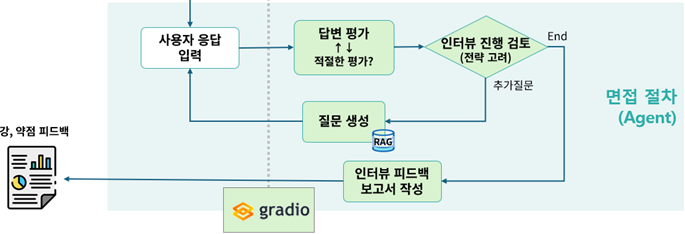

### (1) 답변 입력

In [ ]:
def evaluate_answer(state: InterviewState) -> InterviewState:
    model = ChatOpenAI(model="gpt-4o-mini")

    current_question = state.get("current_question", "")
    current_answer = state.get("current_answer", "")
    current_strategy = state.get("current_strategy", "")
    question_strategy = state.get("question_strategy", "")
    resume_summary = state.get("resume_summary", "")
    resume_keywords = ", ".join(state.get("resume_keywords", []))
    company_info = state.get("company_info", "")

    # print("🚨 현재 evaluate 진입 시 질문:", state.get("current_question"))
    # print("🚨 현재 답변:", state.get("current_answer"))

    # ✅ 질문이나 답변이 비어 있으면 평가 건너뜀
    if not current_question or not current_answer:
        print("⚠️ 질문이나 답변이 비어 있어 평가를 건너뜁니다.")
        return state

    # 질문 전략 추출
    #strategy_block = ""

    strategy_block = question_strategy.get(current_strategy, {}).get("질문전략", "")
    if isinstance(question_strategy, dict):
        strategy_block = question_strategy.get(current_strategy, {}).get("질문전략", "")
    elif isinstance(question_strategy, str):
        try:
            parsed = ast.literal_eval(question_strategy)
            strategy_block = parsed.get(current_strategy, {}).get("질문전략", "")
        except Exception:
            strategy_block = ""

    prompt = ChatPromptTemplate.from_template("""
당신은 인터뷰 평가를 위한 AI 평가자입니다.
다음의 참조 정보(지원자의 이력서 요약, 키워드, 질문 전략, 현재 질문과 답변)를 확인하세요.
[참고 정보]
- 이력서 요약: {resume_summary}
- 이력서 키워드: {resume_keywords}
- 질문 전략({current_strategy}): {strategy}
- 질문: {question}
- 답변: {answer}
- 회사 정보: {company_info}

위 정보를 바탕으로 아래 세 가지 항목에 따라 [답변]을 평가해 주세요.
- [답변]이 너무 짧거나 비어 있으면 낮게 평가.

각 항목의 평가는 다음과 같은 기준에 따라 진행합니다:

1. **질문과의 연관성**
   - 상: 질문의 핵심 의도에 정확히 부합하며 관련 내용을 잘 다룸
   - 중: 관련성은 있으나 핵심 포인트가 일부 누락됨
   - 하: 질문과의 관련성이 낮거나 엉뚱한 내용 포함

2. **답변의 구체성**
   - 상: 실질적인 예시, 수치, 경험 등이 포함되어 매우 구체적임
   - 중: 일부 구체적이나 설명이 부족함
   - 하: 추상적이고 일반적인 말로만 구성됨

3. **회사의 가치관**
   - 상: 회사의 가치관과 매우 잘 맞는 태도, 표현, 경험을 보임
   - 중: 회사의 가치관과 관련은 있으나 구체적인 연결이 부족함
   - 하: 회사의 가치관과 관련이 적거나 반대되는 인상을 줌


각 항목에 대해 점수(상/중/하)뿐 아니라 **그 이유**도 함께 작성해 주세요.

최종 결과는 아래 형식의 딕셔너리로만 출력해 주세요:
출력 예시 :
{{
  "질문과의 연관성": ["상", "질문 의도에 정확히 맞게 경력을 연결함"],
  "답변의 구체성": ["중", "경험은 제시했으나 수치나 구체적 결과가 부족함"],
  "회사의 가치관": ["하", "가치관과의 직접적 연결이 없음"]
}}
""")

    # 프롬프트 구성

    formatted_prompt = prompt.format(
        resume_summary=resume_summary,
        resume_keywords=resume_keywords,
        strategy=strategy_block,
        current_strategy=current_strategy,
        question=current_question,
        answer=current_answer,
        company_info = company_info
    )

    response = model.invoke(formatted_prompt)
    # print(response.content.strip())
    # 딕셔너리로 변환
    eval_dict = response.content.strip()
    if isinstance(eval_dict, str):
        try:
            eval_dict = ast.literal_eval(eval_dict)
        except Exception as e:
            raise ValueError("question_strategy를 딕셔너리로 변환하는 데 실패했습니다.") from e

    # # (1) 대화 저장 (질문/답변 1쌍)
    # state["conversation"].append({"question": current_question, "answer": current_answer})

    # # 전략 로그도 누적
    # state.setdefault("strategy_log", []).append(state["current_strategy"])

    # # (2) 평가 저장 (인덱스 포함)
    # evaluation = state.get("evaluation", [])
    # #eval_dict["question_index"] = len(state["conversation"]) - 1
    # eval_dict["question_index"] = len(state.get("conversation", []))
    # evaluation.append(eval_dict)

    # # 대화 저장
    # state.setdefault("conversation", []).append({
    #     "question": current_question,
    #     "answer": current_answer
    # })

    # 1. 대화 저장 (한 쌍만)
    state.setdefault("conversation", []).append({
        "question": current_question,
        "answer": current_answer
    })

    # 2. 전략 로그 저장
    #state.setdefault("strategy_log", []).append(current_strategy)
    # 2. 전략 로그 중복 방지 후 저장
    strategy_log = state.setdefault("strategy_log", [])
    if not strategy_log or strategy_log[-1] != current_strategy:
        strategy_log.append(current_strategy)

    # 3. 평가 저장
    evaluation = state.get("evaluation", [])
    eval_dict["question_index"] = len(state["conversation"]) - 1
    evaluation.append(eval_dict)

    # ✅ 전략 로그 누적
    state.setdefault("strategy_log", []).append(current_strategy)
    # print("📌 append 대상 current_strategy:", current_strategy)
    # print("📌 strategy_log 누적 전:", state.get("strategy_log"))
    # #state.setdefault("strategy_log", []).append(current_strategy)
    # print("📌 strategy_log 누적 후:", state["strategy_log"])


    return {
        **state,
        "evaluation": evaluation
    }


### (2) 답변 평가 : 고도화
* 고도화 제안
    * 평가가 적절한지 피드백 : reflection 노드 추가
    * conversation 저장이 중복되지 않도록 코드 조정

| 항목 | 설명 |
| ---- | ---- |
 목적 | 최근 평가가 적절한지 되돌아보고 판단 (보완 필요 여부 포함)
 입력 | current_question, current_answer, evaluation[-1]
 출력 | 판단 결과: "정상" or "재평가 필요" → state["reflection_status"] 저장
분기 구조 | "정상" → decide_next_step, "재평가 필요" → re_evaluate_answer



In [ ]:
def reflection_node(state: InterviewState) -> InterviewState:
    model = ChatOpenAI(model="gpt-4o-mini")

    current_question = state.get("current_question", "")
    current_answer = state.get("current_answer", "")
    evaluation = state["evaluation"]
    last_eval = evaluation[-1] if evaluation else {}
    company_info = state.get("company_info", "")

    rel = last_eval.get("질문과의 연관성", "")
    spec = last_eval.get("답변의 구체성", "")
    com = last_eval.get("회사의 가치관", "")

    # 프롬프트 직접 작성
    prompt = HumanMessage(content=f"""~
당신은 인터뷰 평가를 모니터링하는 Reflection AI입니다.

다음 정보는 최근 인터뷰 질문, 답변, 그리고 해당 답변에 대한 평가 결과입니다.

<정보>

질문: {current_question}
답변: {current_answer}
회사 정보: {company_info}

평가 결과:
  질문과의 연관성: {rel}
  답변의 구체성: {spec}
  회사의 가치관: {com}

이 평가가 적절했는지 판단해 주세요.

다음의 기준을 참고하여 판단해 주세요.
1. 답변이 질문에 대해 충분한 내용을 담고 있는지 확인해 주세요.
2. 답변이 지나치게 짧거나 "모름", "잘 기억나지 않음"처럼 무성의한 표현으로 이루어졌다면 부적절한 평가일 수 있습니다.
적절하게 평가되었다고 판단되면 "정상"이라고만 출력해 주세요.
3. "질문과의 연관성"과 "답변의 구체성"이 모두 낮음(‘하’)인데 답변이 어느 정도 성실하다면, 평가가 부적절한 평가일 수 있습니다.

이러한 기준을 바탕으로, 평가가 전반적으로 적절했다면 "정상",
그렇지 않다면 "재평가 필요"라고 **정확히 한 단어로만** 출력해 주세요.

출력 형식 예시:
정상
또는
재평가 필요
""")

    # ✅ invoke에 리스트로 넘기기
    response = model.invoke([prompt])
    reflection = response.content.strip()

    return {
        **state,
        "reflection": reflection
    }

In [ ]:
def re_evaluate_answer(state: InterviewState) -> InterviewState:
    model = ChatOpenAI(model="gpt-4o-mini")

    current_question = state.get("current_question", "")
    current_answer = state.get("current_answer", "")
    current_strategy = state.get("current_strategy", "")
    question_strategy = state.get("question_strategy", "")
    resume_summary = state.get("resume_summary", "")
    resume_keywords = ", ".join(state.get("resume_keywords", []))
    current_reflection = state.get("reflection", "")
    company_info = state.get("company_info", "")

    # 질문 전략 추출
    strategy_block = ""
    if isinstance(question_strategy, dict):
        strategy_block = question_strategy.get(current_strategy, {}).get("질문전략", "")
    else:
        try:
            parsed = ast.literal_eval(question_strategy)
            strategy_block = parsed.get(current_strategy, {}).get("질문전략", "")
        except Exception:
            strategy_block = ""

    # 프롬프트 템플릿
    prompt = ChatPromptTemplate.from_template("""
당신은 인터뷰 평가를 위한 AI 평가자입니다.
다음의 참조 정보(지원자의 이력서 요약, 키워드, 질문 전략, 현재 질문과 답변)를 확인하세요.
[참고 정보]
- 이력서 요약: {resume_summary}
- 이력서 키워드: {resume_keywords}
- 질문 전략({current_strategy}): {strategy}
- 질문: {question}
- 답변: {answer}
- 재평가 여부: {reflection}
- 회사 정보: {company_info}


위 정보를 바탕으로 아래 세 가지 항목에 따라 [답변]을 평가해 주세요.
[답변]이 너무 짧거나 비어 있으면 낮게 평가.

각 항목의 평가는 다음과 같은 기준에 따라 진행합니다:

1. **질문과의 연관성**
   - 상: 질문의 핵심 의도에 정확히 부합하며 관련 내용을 잘 다룸
   - 중: 관련성은 있으나 핵심 포인트가 일부 누락됨
   - 하: 질문과의 관련성이 낮거나 엉뚱한 내용 포함

2. **답변의 구체성**
   - 상: 실질적인 예시, 수치, 경험 등이 포함되어 매우 구체적임
   - 중: 일부 구체적이나 설명이 부족함
   - 하: 추상적이고 일반적인 말로만 구성됨

3. **회사의 가치관**
   - 상: 회사의 가치관과 매우 잘 맞는 태도, 표현, 경험을 보임
   - 중: 회사의 가치관과 관련은 있으나 구체적인 연결이 부족함
   - 하: 회사의 가치관과 관련이 적거나 반대되는 인상을 줌


각 항목에 대해 점수(상/중/하)뿐 아니라 **그 이유**도 함께 작성해 주세요.

최종 결과는 아래 형식의 딕셔너리로만 출력해 주세요:
출력 예시 :
{{
  "질문과의 연관성": ["상", "질문 의도에 정확히 맞게 경력을 연결함"],
  "답변의 구체성": ["중", "경험은 제시했으나 수치나 구체적 결과가 부족함"],
  "회사의 가치관": ["하", "가치관과의 직접적 연결이 없음"]
}}
""")

    formatted_prompt = prompt.format(
        resume_summary=resume_summary,
        resume_keywords=resume_keywords,
        strategy=strategy_block,
        current_strategy=current_strategy,
        question=current_question,
        answer=current_answer,
        reflection=current_reflection,
        company_info = company_info
    )

    # 모델 응답
    response = model.invoke(formatted_prompt)
    eval_dict = response.content.strip()

    try:
        eval_dict = ast.literal_eval(eval_dict)
    except Exception as e:
        raise ValueError("평가 결과를 딕셔너리로 변환하는 데 실패했습니다.") from e

    # 기존 평가 대체 (마지막 평가를 교체)
    evaluation = state.get("evaluation", [])
    if evaluation:
        eval_dict["question_index"] = evaluation[-1]["question_index"]
        evaluation[-1] = eval_dict  # 마지막 평가 교체
    else:
        eval_dict["question_index"] = 0
        evaluation.append(eval_dict)

    return {
        **state,
        "evaluation": evaluation,
        "reflection": "재평가 완료"
    }


### (3) 인터뷰 진행 검토 : 고도화

* 조건
    * 모든 전략 영역을 한 번 이상 커버했으면 → "end"
    * 전체 질문&답변이 5번 진행되었으면 → "end"  (인터뷰가 너무 길어지는 것 방지)
    * 가장 최근 평가에 "하"가 있다면 → additional_question (현재 전략 유지)
    * 최근 평가가 "상" or "중" → next_strategy (다음 전략으로 전환)

In [ ]:
def decide_next_step(state: InterviewState) -> InterviewState:
    evaluation = state.get("evaluation", [])
    strategy_log = state.get("strategy_log", [])
    current_strategy = state.get("current_strategy", "")

    strategies = ["자기소개서", "경력 및 경험", "동기 및 커뮤니케이션", "논리적 사고"]
    strategy_counts = {s: 0 for s in strategies}
    strategy_last_eval = {s: None for s in strategies}
    strategy_done = {}

    # 1. 전략별 질문 수와 마지막 평가 저장
    for i, strategy in enumerate(strategy_log):
        if strategy in strategies:
            strategy_counts[strategy] += 1
            if i < len(evaluation):
                strategy_last_eval[strategy] = evaluation[i]

    # 2. 각 전략 완료 여부 판단
    for strategy in strategies:
        count = strategy_counts[strategy]
        last_eval = strategy_last_eval[strategy]
        if count >= 5:
            strategy_done[strategy] = True
        elif count == 1 and last_eval:
            num_high = sum(1 for v in last_eval.values() if v == "상")
            strategy_done[strategy] = num_high >= 2
        else:
            strategy_done[strategy] = False

    # 3. 모든 전략 완료 시 종료
    if all(strategy_done.values()):
        next_step = "end"

    # 4. 현재 전략이 완료되었거나, 같은 전략에서 질문이 3개 이상이면 다음 전략
    elif strategy_done.get(current_strategy, False) or strategy_counts[current_strategy] >= 4:
        next_step = "next_strategy"

    # 5. 그 외에는 추가 질문
    else:
        next_step = "additional_question"

    # print("\n📊 전략별 질문 수:", strategy_counts)
    # print("✅ 현재 전략:", current_strategy)
    # print("✅ 완료 여부:", strategy_done)
    # print("➡️ 결정된 next_step:", next_step)

    return {
        **state,
        "next_step": next_step
    }

In [ ]:
def next_strategy(state: InterviewState) -> InterviewState:
    strategies = ["자기소개서","경력 및 경험", "동기 및 커뮤니케이션", "논리적 사고"]
    current = state.get("current_strategy", "")

    try:
        current_index = strategies.index(current)
        next_index = current_index + 1
    except ValueError:
        next_index = 0  # 시작 전략 없을 경우 첫 전략부터

    # 전략을 다 돌았으면 종료
    if next_index >= len(strategies):
        return {
            **state,
            "next_step": "end"
        }

    # 다음 전략 설정
    state["current_strategy"] = strategies[next_index]

    # LLM 기반 질문 생성
    return generate_question(state)

In [ ]:
def additional_question(state: InterviewState) -> InterviewState:
    current = state.get("current_strategy", "")
    asked = [c["question"] for c in state.get("conversation", [])]
    all_questions = state["question_strategy"].get(current, {}).get("예시 질문", [])

    remaining_questions = [q for q in all_questions if q not in asked]

    if remaining_questions:
        # 예시 질문이 남아있다면 그걸 활용
        state["current_question"] = remaining_questions[0]
        state["current_answer"] = ""
        return state

    # 예시 질문이 없으면 LLM으로 생성
    return generate_question(state)

### (4) 질문 생성 : 고도화

* 요건
    * 현재 generate_question()은 기존 전략 예시 질문과 최근 답변을 기반으로 심화 질문 생성
    * 여기에 Chroma Vector DB를 추가해서, 유사 질문 3개 정도를 LLM 프롬프트에 참조 정보로 포함
    * 질문은 여전히 LLM이 생성, 유사 질문은 참고로만 사용

In [ ]:
def question_Rag(company_name, question_strategy, current_strategy, conversation, resume_summary, resume_keywords) -> str:

    # ✅ 3. Retriever 구성
    filtered_retriever = vectorstore.as_retriever(
        search_kwargs={"filter": {"company": company_name.strip() + " 기업 정보"}, "k": 3}
    )

    # ✅ 4. LLM + Retrieval QA
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
    rag_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=filtered_retriever,
        return_source_documents=False,
        chain_type="stuff"
    )

    # ✅ 5. RAG 프롬프트 구성
    prompt_query = (
        f"{company_name}에 지원한 지원자의 이력 요약: {resume_summary}\n"
        f"이력 핵심 키워드: {', '.join(resume_keywords)}\n\n"
        f"현재 면접 전략: {current_strategy}\n"
        f"질문 전략: {question_strategy}\n\n"
        f"지금까지의 면접 대화 흐름:\n{conversation}\n\n"
        f"위 내용을 바탕으로 {company_name} 기업의 특성과 가치에 맞춘, 심도 있는 예상 면접 질문 3개를 생성해줘.\n"
        f"각 질문은 기업의 사업 방향성과 지원자의 강점이 교차하도록 해줘."
    )

    # ✅ 6. 실행
    company_info = rag_chain.run(prompt_query)
    return company_info


In [ ]:
def generate_question(state: InterviewState) -> InterviewState:
    from langchain.chat_models import ChatOpenAI
    from langchain.prompts import ChatPromptTemplate

    llm = ChatOpenAI(model="gpt-4o-mini")

    # 상태 정보 추출
    resume_summary = state.get("resume_summary", "")
    resume_keywords = ", ".join(state.get("resume_keywords", []))
    question_strategy = state.get("question_strategy", {})
    current_strategy = state.get("current_strategy", "")
    strategy_desc = question_strategy.get(current_strategy, {}).get("질문전략", "전략 설명 없음")
    conversation = state.get("conversation", [])
    evaluation = state.get("evaluation", [])
    #company_name = state.get("selected_company")
    #company_question = question_Rag(company_name, question_strategy, current_strategy, conversation, resume_summary, resume_keywords) # rag 메소드 호출해서 기업 관련 질문 가져옴

    # 현재 전략에서 이미 질문한 내용 필터링
    strategy_qas = [
        qa for qa in conversation
        if current_strategy in qa["question"]
    ]
    is_first_question = len(strategy_qas) == 0
    last_eval = evaluation[-1] if evaluation else {}

    # 전략의 첫 질문이면
    if is_first_question:
        prompt_text = """
당신은 인터뷰 질문을 설계하는 AI입니다.

아래는 질문 생성을 위한 지원자의 정보입니다:
- 전략명: {current_strategy}
- 전략 설명: {strategy_desc}
- 이력서 요약: {resume_summary}
- 키워드: {resume_keywords}
이 전략에 대한 첫 번째 질문입니다.
지원자의 기본적인 경험, 동기, 혹은 시야를 파악할 수 있는 질문을 한 문장으로 생성해 주세요.
"""
        prompt = ChatPromptTemplate.from_template(prompt_text)
        messages = prompt.format_messages(
            current_strategy=current_strategy,
            strategy_desc=strategy_desc,
            resume_summary=resume_summary,
            resume_keywords=resume_keywords
            #company_question=company_question
        )

    # 전략 내 추가 질문이면
    else:
        last_qa = strategy_qas[-1]
        prev_question = last_qa["question"]
        prev_answer = last_qa["answer"]

        prompt_text = """
당신은 인터뷰 질문을 설계하는 AI입니다.

지원자의 이력과 전략 설명, 그리고 이전 질문과 답변, 평가를 바탕으로
이 전략에서 더 깊이 파고들 수 있는 **심화 인터뷰 질문**을 생성해 주세요.

- 전략명: {current_strategy}
- 전략 설명: {strategy_desc}
- 이력서 요약: {resume_summary}
- 키워드: {resume_keywords}
- 이전 질문: {prev_question}
- 이전 답변: {prev_answer}
- 이전 평가: {last_eval}
지원자의 사고력, 문제 해결 방식, 혹은 기술적 깊이를 더 확인할 수 있도록
날카롭고 구체적인 질문을 한 문장으로 생성해 주세요.
"""
        prompt = ChatPromptTemplate.from_template(prompt_text)
        messages = prompt.format_messages(
            current_strategy=current_strategy,
            strategy_desc=strategy_desc,
            resume_summary=resume_summary,
            resume_keywords=resume_keywords,
            prev_question=prev_question,
            prev_answer=prev_answer,
            last_eval=str(last_eval)
            #company_question=company_question
        )

    # LLM 호출
    response = llm.invoke(messages)
    content = response.content.strip()

    # fallback
    if not content:
        content = f"{current_strategy}에 대해 더 자세히 말씀해 주세요."

    return {
        **state,
        "current_question": content,
        "current_answer": ""
    }


### (5) 인터뷰 피드백 보고서 : 고도화


* 제안
    * 전략별 요약 : 각 전략 영역별로 답변 스타일, 강점/약점 정리
    * 종합 피드백 : 전체 인터뷰의 인상, 강점, 보완점
    * 형식 : 구조화된 텍스트 (분야별 블록 + 전체 종합 평가)
* 입력으로 활용할 요소
    * state["conversation"]       # 질문/답변 리스트
    * state["evaluation"]         # 질문별 평가 (연관성, 구체성)
    * state["question_strategy"]  # 전략 분류용

In [ ]:
def summarize_interview(state: InterviewState) -> InterviewState:
    llm = ChatOpenAI(model="gpt-4o-mini")
    resume_summary = state.get("resume_summary", "")
    evaluation = state.get("evaluation", [])
    conversation = state.get("conversation", [])

    print("\n 인터뷰 종료 보고서")
    print("-" * 50)
    for i, turn in enumerate(state["conversation"]):
        print(f"[질문 {i+1}] {turn['question']}")
        print(f"[답변 {i+1}] {turn['answer']}")
        if i < len(state["evaluation"]):
            eval_result = state["evaluation"][i]
            print(f"[평가] 질문과의 연관성: {eval_result['질문과의 연관성']}, 답변의 구체성: {eval_result['답변의 구체성']}, 회사의 가치관: {eval_result['회사의 가치관']}")
        print("-" * 50)

    #추가
    prompt = ChatPromptTemplate.from_template("""
당신은 면접을 담당하는 인사 담당자입니다. 면접을 실행한 후 면접에 대한 최종 평가를 내려야 합니다.

다음은 실행된 면접에 대한 정보입니다.
- 이력서 요약: {resume_summary}
- 평가: {evaluation}
- 면접 내용 : {conversation}

위 정보를 바탕으로 면접자의 강점, 실제 면접에서 보완해야 할 점을 정리해서 알려줘야 합니다.
면접자의 강점은 면접을 할 때 얼마나 질문과 연관된 답변을 했으며 구체적으로 잘 얘기했는지를 기준으로 알려줘야 합니다.
답변을 할 때에는 **과 ###을 절대 사용하면 안 됩니다.

면접 내용에 대해 평가한 후 합격/불합격에 대한 예측 결과를 알려줍니다.
예측 결과는 평가에서 얻은 '상'의 개수로 판단합니다.
'상'이 전체 평가의 70% 이상이면 합격 예상, 미만이면 불합격 예상으로 판단합니다.

출력 형식의 예시 다음과 같습니다.
강점 :
면접자의 강점에 대해 알려줍니다.
보완해야 할 점 :
보완해야 할 점에 대해 알려줍니다.
합격 예측 : 합격
""")

    formatted_prompt = prompt.format(
        resume_summary=resume_summary,
        evaluation=evaluation,
        conversation=conversation
    )

    response = llm.invoke(formatted_prompt)
    state["final_summary"] = response.content

    print("\n[종합 평가 요약]")
    print(response.content)
    print("-" * 50)


    return state

### (6) 면접 Agent

In [ ]:
# 분기 판단 함수
def route_next(state: InterviewState) -> Literal["generate", "summarize"]:
    return "summarize" if state["next_step"] == "end" else "generate"

def reflection_next(state: InterviewState) -> Literal["decide", "re_evaluate"]: # reflection
   return "decide" if state["reflection"] == "정상" else "re_evaluate"

def strategy_next(state: InterviewState) -> Literal["summarize", "next_strategy", "additional_question" ]:
    if state["next_step"] == "end":
      return "summarize"
    elif state["next_step"] == "next_strategy":
      return "next_strategy"
    else :
      return "additional_question"

# 그래프 정의 시작
builder = StateGraph(InterviewState)

# 노드 추가
builder.add_node("evaluate", evaluate_answer)
builder.add_node("reflect", reflection_node)
builder.add_node("re_evaluate", re_evaluate_answer)
builder.add_node("next_strategy", next_strategy)
builder.add_node("additional_question", additional_question)
builder.add_node("decide", decide_next_step)
#builder.add_node("generate", generate_question)
builder.add_node("summarize", summarize_interview)

# 노드 연결
builder.set_entry_point("evaluate")
builder.add_edge("evaluate", "reflect")
builder.add_conditional_edges("reflect", reflection_next)
builder.add_edge("re_evaluate", "decide")
builder.add_conditional_edges("decide", strategy_next, {"summarize": "summarize", "next_strategy":"next_strategy", "additional_question":"additional_question"})
builder.add_edge("next_strategy", END)      # 루프
builder.add_edge("additional_question", END)      # 루프
builder.add_edge("summarize", END)            # 종료

# 컴파일
graph = builder.compile()

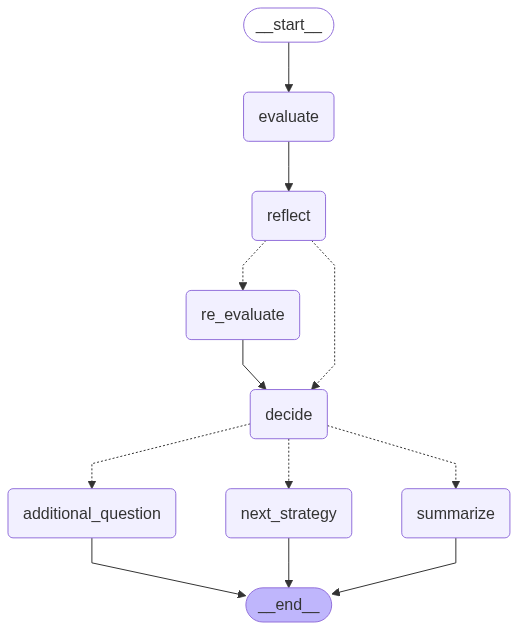

In [ ]:
from IPython.display import Image, display

# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	evaluate(evaluate)
	reflect(reflect)
	re_evaluate(re_evaluate)
	next_strategy(next_strategy)
	additional_question(additional_question)
	decide(decide)
	summarize(summarize)
	__end__([<p>__end__</p>]):::last
	__start__ --> evaluate;
	decide -.-> additional_question;
	decide -.-> next_strategy;
	decide -.-> summarize;
	evaluate --> reflect;
	re_evaluate --> decide;
	reflect -.-> decide;
	reflect -.-> re_evaluate;
	additional_question --> __end__;
	next_strategy --> __end__;
	summarize --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [ ]:
# 파일 입력
file_path = path + 'Resume_sample.pdf'
state = preProcessing_Interview(file_path=file_path, selected_company="KK기술", introduce_text="", introduce_summary="""안녕하세요, KK기술에 지원한 홍길동입니다.
저는 한국대학교 전기정보공학부를 졸업하고, KT AI연구소 인턴 경험과 다양한 AI 기반 프로젝트를 통해 실무 역량을 쌓아왔습니다. 특히 Python과 Spring을 기반으로 한 서버 개발과 알고리즘 문제 해결에 강점이 있으며, AI 면접관 시스템, 교통량 예측 등 실전형 프로젝트를 수행해왔습니다.

금융 시스템의 안정성과 기술 혁신을 중시하는 KK기술의 개발 문화는 제가 성장하고 기여하기에 최적의 환경이라 생각해 지원했습니다. 맡은 바 책임을 다하며, 함께 성장하는 개발자가 되겠습니다. 감사합니다.""")
state

<ipython-input-12-e4e3d2a8232c>:7: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
<ipython-input-12-e4e3d2a8232c>:26: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  company_info = rag_chain.run(prompt_query)


{'company_list': ['AA테크', 'BB소프트', 'CC넷', 'DD엔진', 'EE디지털', 'KK기술'],
 'selected_company': 'KK기술',
 'company_info': '죄송하지만, KK기술 기업에 대한 구체적인 정보는 가지고 있지 않습니다. 해당 기업에 대한 개요, 역사, 비전, 미션, 핵심 가치에 대한 정보를 확인하려면 공식 웹사이트나 관련 자료를 참고하시기 바랍니다.',
 'resume_text': '<이력서> \n홍길동 (Gil-dong Hong) \n이메일: gildong.hong@example.com \n전화번호: 010-1234-5678 \n학력 \n- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02) \n  GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리 \n경력 \n- KT, AI 연구소 인턴 (2021.07 ~ 2021.12) \n  • OCR 기반 문서 처리 시스템 고도화 \n  • Tesseract + 딥러닝 후처리 파이프라인 설계 \n  • 사내 법률문서 정제 정확도 12% 개선 \n- 빅데이터 학생연합 (BDSA) 기술부장 (2020.03 ~ 2021.02) \n  • Python 기반 크롤러 및 Flask API 개발 \n  • 공공데이터 기반 부동산 가격 예측 프로젝트 리드 \n프로젝트 \n- AI 면접관 시스템 개발 (졸업 과제) \n  • OpenAI GPT + Streamlit + FAISS 기반 질문-응답 시스템 구현 \n  • 이력서 기반 질문 자동 생성 + 답변 피드백 제공 \n- 딥러닝 기반 교통량 예측 (교과목 프로젝트) \n  • LSTM 기반 모델 + 서울시 교통데이터 \n  • MAE 15% 이하로 개선 \n기술 스택 \n- Python, PyTorch, TensorFlow, OpenCV \n- MySQL, MongoDB, Git, Docker \n\n- 영어 (TOEIC 915, 영어면접 가능) \n수상 및 자격 \n- SKT Big

In [ ]:
# 사용자 응답 루프
while True:
    print("\n[질문]")
    print(state["current_question"])
    print("현재 질문 주제: " + state["current_strategy"])

    state["current_answer"] = input("\n[답변 입력]:\n")

    # 그래프 실행: 평가 → 판단 → 다음 질문 생성 or 종료
    state = graph.invoke(state)

    if state["next_step"] == "end":
        state = summarize_interview(state)
        break


[질문]
홍길동님은 전기정보공학을 전공하시고 높은 GPA를 기록하셨습니다. 이를 통해 얻은 지식이 KK기술에서 어떻게 활용될 수 있을 것이라고 생각하시나요?
현재 질문 주제: 자기소개서

[답변 입력]:
전기정보공학에서 배운 데이터 분석과 신호처리 지식은 KK기술의 AI 기반 금융 시스템 개발과 리스크 예측 모델에 직접적으로 기여할 수 있습니다.

[질문]
"KK기술에서의 성장 가능성을 고려할 때, 전기정보공학 전공과 AI 연구소에서의 인턴 경험이 당신에게 어떤 동기를 주었으며, 이를 통해 회사에 어떻게 기여할 수 있을지 설명해 주실 수 있나요?"
현재 질문 주제: 자기소개서

[답변 입력]:
전공 지식과 AI 연구소 인턴 경험을 통해 데이터 기반 문제 해결 역량을 키웠고, 이를 바탕으로 KK기술의 안정적이고 혁신적인 금융 시스템 개발에 적극 기여하고 싶다는 동기를 갖게 되었습니다.

[질문]
"전기정보공학 전공과 AI 연구소 인턴 경험을 바탕으로, KK기술에서 어떤 방식으로 자신의 기술적 역량을 활용하고 성장해 나가고 싶은지 구체적으로 설명해 주시겠습니까?"
현재 질문 주제: 자기소개서

[답변 입력]:
전공을 통해 쌓은 데이터 처리와 신호 해석 능력, 그리고 인턴십에서 경험한 딥러닝 기반 시스템 개발 역량을 바탕으로, KK기술의 투자 알고리즘이나 리스크 관리 시스템 고도화에 기여하며, 실무 프로젝트를 통해 AI 금융 기술 전문가로 성장하고 싶습니다.

[질문]
"전기정보공학을 전공하며 다양한 프로젝트와 인턴 경험을 쌓아오신 만큼, 이러한 경험들이 지원자의 문제 해결 접근 방식이나 기술적 동기에 어떤 영향을 미쳤는지 구체적으로 설명해 주실 수 있나요?"
현재 질문 주제: 경력 및 경험

[답변 입력]:
전공 과정과 인턴 경험을 통해 문제를 수학적·논리적으로 분석하고, 실제 데이터 기반으로 해결책을 구현하는 습관이 생겼으며, 복잡한 문제일수록 도전의식을 느끼고 기술로 풀어내는 데서 큰 동기를 얻고 있습니다.

[질문]
"KT의 AI 연구소에서 인턴으로 근무하

In [ ]:
print(state["final_summary"])

강점 :
면접자는 전공과 인턴 경험을 바탕으로 질문의 의도에 정확하게 맞춘 답변을 제공하였으며, 특히 기술적 역량과 문제 해결 접근 방식에 대한 설명이 구체적이었습니다. 예를 들어, KT AI 연구소에서의 OCR 시스템 고도화 프로젝트에서의 성과를 구체적으로 언급하며, 자신이 어떤 기술적 능력을 발전시켰는지를 명확히 설명했습니다. 또한, KK기술의 가치관과 관련된 문제 해결에 대한 열정과 기술적 도전 정신을 잘 표현하였습니다.

보완해야 할 점 :
면접자의 답변 중 일부는 구체적인 예시나 수치적 성과가 부족해 아쉬움이 있었습니다. 특히 몇 가지 질문에서는 구체적인 경험에 대한 설명 대신 "열심히 하겠습니다"라는 추상적인 답변이 있었고, 이는 면접자의 역량을 잘 전달하지 못하는 점에서 보완이 필요합니다. 회사의 가치관과의 연결성을 더욱 명확히 하는 것도 중요합니다.

합격 예측 : 불합격


## **4. 시스템 실행**

미션3에서 수행한 결과를 통합 테스트 해 봅시다.

### Gradio를 이용하여 인터페이스 구현


In [ ]:
def update_current_answer(state: InterviewState, user_answer: str) -> InterviewState:
    return {
        **state,
        "current_answer": user_answer.strip()
    }

In [ ]:
import gradio as gr
import tempfile

# 세션 상태 초기화 함수
def initialize_state():
    return {
        "state": None,
        "interview_started": False,
        "interview_ended": False,
        "chat_history": [],
        "introduced": False,
        "company_selected": False,
    }

# 인터뷰 초기화 및 바로 진행
def upload_and_initialize(file_obj, selected_company, introduce_text, session_state):
    if file_obj is None or not selected_company or not introduce_text:
        session_state["chat_history"].append(["🤖 AI 면접관", "⚠️ 이력서, 회사명, 자기소개를 모두 입력해주세요."])
        return session_state, session_state["chat_history"]


    file_path = file_obj.name

    # (1) 자기소개 요약
    introduce_summary = ChatOpenAI().invoke(
        "다음은 면접 지원자의 1분 자기소개이다. 자기소개 내용을 요약하라.\n\n" + introduce_text
    ).content

    # (2) 인터뷰 사전 처리
    state = preProcessing_Interview(
        file_path=file_path,
        selected_company=selected_company,
        introduce_text=introduce_text,
        introduce_summary=introduce_summary
    )

    # (3) 상태 저장
    session_state["state"] = state
    session_state["interview_started"] = True
    session_state["company_selected"] = True
    session_state["introduced"] = True

    # (4) 초기 채팅 이력 설정
    session_state["chat_history"].append(["🤖 AI 면접관", f"{selected_company} 기업이 선택되었습니다."])
    session_state["chat_history"].append(["🤖 AI 면접관", "1분 자기소개 감사합니다."])
    session_state["chat_history"].append(["🤖 AI 면접관", "면접을 시작하겠습니다."])
    session_state["chat_history"].append(["🤖 AI 면접관", state["current_question"]])

    return session_state, session_state["chat_history"]

# 답변 처리 및 다음 질문 생성
def chat_interview(user_input, session_state):
    if not session_state["interview_started"]:
        return session_state, "먼저 이력서를 업로드하고 인터뷰를 시작하세요."

    # 사용자 답변 저장
    session_state["chat_history"].append(["🙋‍♂️ 지원자", user_input])
    session_state["state"] = update_current_answer(session_state["state"], user_input)

    # 그래프 실행
    session_state["state"] = graph.invoke(session_state["state"])

    # 종료 여부 확인
    if session_state["state"]["next_step"] == "end":
        state = summarize_interview(session_state["state"])
        session_state["interview_ended"] = True
        final_summary = "✅ 인터뷰가 종료되었습니다!\n\n"
        for i, turn in enumerate(session_state["state"]["conversation"]):
            final_summary += f"\n**[질문 {i+1}]** {turn['question']}\n**[답변 {i+1}]** {turn['answer']}\n"
            if i < len(session_state["state"]["evaluation"]):
                eval_result = session_state["state"]["evaluation"][i]
                final_summary += f"_평가 - 질문 연관성: {eval_result['질문과의 연관성']}, 답변 구체성: {eval_result['답변의 구체성']}_\n"
        session_state["chat_history"].append(["🤖 AI 면접관", final_summary])

        final_summary = session_state["state"].get("final_summary", "⚠️ 요약 정보를 가져올 수 없습니다.")
        session_state["chat_history"].append(["🤖 AI 면접관", final_summary])
        return session_state, session_state["chat_history"]
    else:
        next_question = session_state["state"]["current_question"]
        session_state["chat_history"].append(["🤖 AI 면접관", next_question])
        return session_state, session_state["chat_history"]

# Gradio 인터페이스 구성
with gr.Blocks() as demo:
    session_state = gr.State(initialize_state())

    gr.Markdown("# 🤖 AI 면접관\n이력서, 기업명, 자기소개를 입력하고 인터뷰를 시작하세요!")

    with gr.Row():
        file_input = gr.File(label="이력서 업로드 (PDF 또는 DOCX)")
        company_input = gr.Textbox(label="다음 기업 중 면접을 진행할 기업을 선택해주세요.", placeholder="[AA테크, BB소프트, CC넷, DD엔진, EE디지털, KK기술]")
        intro_input = gr.Textbox(label="1분 자기소개 입력", lines=3)
        upload_btn = gr.Button("인터뷰 시작")

    chatbot = gr.Chatbot()
    user_input = gr.Textbox(show_label=False, placeholder="답변을 입력하고 Enter를 누르세요.")

    # 초기 업로드 및 인터뷰 시작
    upload_btn.click(
        upload_and_initialize,
        inputs=[file_input, company_input, intro_input, session_state],
        outputs=[session_state, chatbot]
    )

    # 인터뷰 답변 진행
    user_input.submit(chat_interview, inputs=[user_input, session_state], outputs=[session_state, chatbot])
    user_input.submit(lambda: "", None, user_input)

# 실행
demo.launch(share=True)


<ipython-input-33-594e9552dabd>:95: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8466fdb74f0b7f98e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
